## Описание задачи

Разбираем в ноутбуке стандартный CGCNN из репозитория. Смотрим как он работает на датасете из CIF файлов. Этот датасет был использован мной при запуске CGCNN через командную строку (эта задача с использованием датасета была описана в статье https://dzen.ru/a/Z6Jxn-2D4QCDm3vj )  Датасет получен путём загрузки данных из базы MaterialsProject. Для примера выбраны соединения кремния (Si), а в условиях отбора обозначена только кубическая сингония (один из типов кристаллических структур).

---

## Источники используемой модели CGCNN

В данном ноутбуке применяется модель Crystal Graph Convolutional Neural Network (CGCNN), реализованная в репозитории:

- **Crystal Graph Convolutional Neural Networks**  
  GitHub: [txie-93/cgcnn](https://github.com/txie-93/cgcnn) :contentReference[oaicite:1]{index=1}  
  Исходная архитектура описана в статье:  
  *T. Xie & J. C. Grossman, Crystal Graph Convolutional Neural Networks for an Accurate and Interpretable Prediction of Material Properties*, Phys. Rev. Lett. 120, 145301 (2018). :contentReference[oaicite:2]{index=2}

Эта модель используется как **основа** — переиспользуется генерация графа, Conv‑слои, логика обучения. При этом доработки, выполненные в этом ноутбуке, адаптируют модель под специфические задачи и структуру данных.


В данном проекте стояла задача разабраться в коде проекта Xie, Tian and Grossman, Jeffrey C. из университета MIT https://github.com/txie-93/cgcnn  Соответственно, взят из код с незначительными корректировками для его использования в отдельном файле jupyter notebook. Посколько задача была разобраться, в файле содержится множество описаний кода и распечаток содержания структуры разных объектов. Ссылка на изначальную исследовательскую статью указанных авторов https://link.aps.org/doi/10.1103/PhysRevLett.120.145301


Файл **[main.py](https://github.com/txie-93/cgcnn/blob/master/main.py)** из репозитория **CGCNN (Crystal Graph Convolutional Neural Networks)** — это основной скрипт для обучения и оценки модели, предсказывающей свойства кристаллических материалов. Разберём его структуру и функциональность:

---

 **1. Назначение файла**
Главные задачи `main.py`:
- **Обучение модели CGCNN** на данных кристаллических структур (в формате CIF-файлов).
- **Оценка качества модели** на валидационной и тестовой выборках.
- **Сохранение чекпоинтов** лучших версий модели.
- **Интеграция с командной строкой** для гибкой настройки параметров через аргументы.

---

 **2. Ключевые инструменты и их роль**
  **Аргументы командной строки (argparse)**
Файл принимает параметры через `argparse`, что позволяет настраивать:
- **Пути к данным**: `root_dir` с CIF-файлами и `id_prop.csv` .
- **Гиперпараметры модели**: 
  - `--atom-fea-len`: размер атомных эмбеддингов.
  - `--h-fea-len`: размер скрытых слоёв после пулинга.
  - `--n-conv`: количество графовых свёрточных слоёв .
- **Параметры обучения**:
  - `--lr`: скорость обучения.
  - `--batch-size`: размер батча.
  - `--epochs`: число эпох.

  **Загрузка данных (CIFData)**
- Класс `CIFData` из `cgcnn.data` загружает кристаллические структуры из CIF-файлов и их свойства из `id_prop.csv` .
- Использует `collate_pool` для объединения данных в батчи с учётом разного числа атомов в кристаллах.

  **Модель (CrystalGraphConvNet)**
- **Архитектура CGCNN**:
  - **Графовые свёртки**: Преобразуют атомные признаки с учётом связей между соседями.
  - **Пулинг (global_mean_pool)**: Агрегирует атомные эмбеддинги в дескриптор кристалла.
  - **Полносвязные слои**: Предсказывают целевое свойство (например, энергию образования) .

  **Оптимизация и обучение**
- **Оптимизатор**: По умолчанию — SGD, но можно выбрать Adam (`--optim`).
- **Планировщик LR**: `MultiStepLR` для изменения learning rate на заданных эпохах (`--lr-milestones`).
- **Функция потерь**: Для регрессии — MSE, для классификации — кросс-энтропия .

  **Логирование и сохранение**
- **Вывод метрик**: Средняя абсолютная ошибка (MAE) для регрессии, точность для классификации.
- **Чекпоинты**: Сохраняются в `model_best.pth.tar` при улучшении качества на валидации.

---

  **3. Пример запуска**
```bash
python main.py ./data --task regression --epochs 100 --batch-size 32
```
Где:
- `./data` — папка с CIF-файлами и `id_prop.csv`.
- `--task regression` — режим регрессии (предсказание энергии).

---

  **4. Важные особенности**
1. **Гибкость входных данных**:
   - Поддерживает как регрессию, так и классификацию (`--task`).
   - Позволяет задавать размер выборок через `--train-ratio`/`--train-size` .

2. **Интеграция с PyTorch**:
   - Использует `DataLoader` для эффективной загрузки данных.
   - Поддержка GPU (`--disable-cuda` для отключения).

3. **Воспроизводимость**:
   - Фиксирует seed для случайных процессов.
   - Сохраняет лучшую модель для последующего использования .

---

  **5. Сравнение с аналогами**
CGCNN отличается от других GNN-архитектур для материалов:
- **Упрощённый подход**: Не учитывает углы между связями (в отличие от DimeNet++).
- **Акцент на кристаллическую структуру**: Использует параметры решётки и межатомные расстояния .

---

  **Заключение**
`main.py` в CGCNN — это **готовый пайплайн** для обучения модели на кристаллических данных. Он сочетает:
- Загрузку и предобработку CIF-файлов.
- Графовые свёртки для анализа локального окружения атомов.
- Гибкую настройку через командную строку.

Для более сложных задач (например, предсказания нескольких свойств) можно рассмотреть **mt-cgcnn** (мультитаргетную версию) .

В файле **[model.py](https://github.com/txie-93/cgcnn/blob/master/cgcnn/model.py)** реализована архитектура **Crystal Graph Convolutional Neural Network (CGCNN)** — специализированной графовой нейросети для предсказания свойств кристаллических материалов. Разберём код с подробными комментариями:

---

  **1. Импорты**
```python
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch_geometric.nn import global_mean_pool  # Для агрегации атомных признаков
```
- **torch.nn**: Базовые модули PyTorch (линейные слои, функции активации).
- **global_mean_pool**: Пулинг-слой для объединения атомных признаков в графовый дескриптор.

---

  **2. Класс `CrystalGraphConvNet`**
Главный класс модели, наследуемый от `nn.Module`.

  **Инициализация (`__init__`)**
```python
def __init__(self, orig_atom_fea_len, nbr_fea_len, atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1):
    super(CrystalGraphConvNet, self).__init__()
```
- **Параметры**:
  - `orig_atom_fea_len`: Размер исходных атомных признаков (например, 92 для атомного номера).
  - `nbr_fea_len`: Размер признаков связи (например, межатомное расстояние).
  - `atom_fea_len`: Размер скрытых атомных эмбеддингов (по умолчанию 64).
  - `n_conv`: Количество графовых свёрточных слоёв (по умолчанию 3).
  - `h_fea_len`: Размер скрытого слоя после пулинга (по умолчанию 128).
  - `n_h`: Количество полносвязных слоёв (по умолчанию 1).

---

  **3. Графовые свёрточные слои (`conv_layers`)**
```python
self.conv_layers = nn.ModuleList([
    ConvLayer(orig_atom_fea_len=orig_atom_fea_len if i == 0 else atom_fea_len,
              nbr_fea_len=nbr_fea_len,
              atom_fea_len=atom_fea_len)
    for i in range(n_conv)
])
```
- **ConvLayer**: Кастомный свёрточный слой (определён ниже).
- **Особенности**:
  - Первый слой принимает исходные атомные признаки (`orig_atom_fea_len`).
  - Последующие слои работают с выходом предыдущих (`atom_fea_len`).
  - Число слоёв задаётся через `n_conv`.

---

  **4. Полносвязные слои (`fc_layers`)**
```python
self.fc_layers = nn.ModuleList([
    nn.Linear(atom_fea_len if i == 0 else h_fea_len, 
              h_fea_len)
    for i in range(n_h)
])
```
- **Структура**:
  - Линейные слои с размерностью `atom_fea_len → h_fea_len` (если `n_h=1`, то один слой).
  - Активация `ReLU` применяется после каждого слоя.

---

  **5. Выходной слой (`fc_out`)**
```python
self.fc_out = nn.Linear(h_fea_len, 1)  # Регрессия (1 выход)
```
- Предсказывает **скалярное значение** (например, энергию образования).

---

  **6. Прямой проход (`forward`)**
```python
def forward(self, atom_fea, nbr_fea, nbr_idx, crystal_atom_idx):
    # 1. Графовые свёртки
    for conv in self.conv_layers:
        atom_fea = conv(atom_fea, nbr_fea, nbr_idx)
    
    # 2. Глобальный пулинг
    crys_fea = global_mean_pool(atom_fea, crystal_atom_idx)
    
    # 3. Полносвязные слои
    for fc in self.fc_layers:
        crys_fea = torch.relu(fc(crys_fea))
    
    # 4. Выход
    return self.fc_out(crys_fea)
```
- **Входы**:
  - `atom_fea`: Признаки атомов `[num_atoms, orig_atom_fea_len]`.
  - `nbr_fea`: Признаки связей `[num_atoms, max_nbr, nbr_fea_len]`.
  - `nbr_idx`: Индексы соседей `[num_atoms, max_nbr]`.
  - `crystal_atom_idx`: Индексы атомов для пулинга `[num_atoms]`.
- **Шаги**:
  1. **Графовые свёртки**: Обновляют атомные признаки с учётом локального окружения.
  2. **Пулинг**: Усреднение признаков по атому для всего кристалла.
  3. **Полносвязные слои**: Преобразуют глобальные признаки.
  4. **Выход**: Предсказание свойства.

---

  **7. Класс `ConvLayer` (графовая свёртка)**
```python
class ConvLayer(nn.Module):
    def __init__(self, orig_atom_fea_len, nbr_fea_len, atom_fea_len):
        super(ConvLayer, self).__init__()
        self.fc_full = nn.Linear(2*orig_atom_fea_len + nbr_fea_len, atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
```
- **Формула свёртки**:
  ```
  h_i^(l+1) = h_i^l + Σ_{j∈N(i)} σ(W_f * [h_i^l || h_j^l || e_ij] + b_f)
  ```
  Где:
  - `h_i^l`: Признаки атома `i` на слое `l`.
  - `e_ij`: Признаки связи между атомами `i` и `j`.
  - `σ`: Сигмоидальная активация для "ворот" (gate mechanism).

---

  **8. Прямой проход в `ConvLayer`**
```python
def forward(self, atom_in_fea, nbr_fea, nbr_idx):
    # 1. Сбор признаков соседей
    N, M = nbr_idx.shape  # N = число атомов, M = число соседей
    atom_nbr_fea = atom_in_fea[nbr_idx.view(-1)].view(N, M, -1)
    
    # 2. Конкатенация признаков
    total_fea = torch.cat([atom_in_fea.unsqueeze(1).expand(N, M, -1),
                           atom_nbr_fea,
                           nbr_fea], dim=2)
    
    # 3. Применение линейного слоя и активаций
    total_fea = self.softplus(self.fc_full(total_fea))
    total_fea = self.sigmoid(total_fea)
    
    # 4. Агрегация по соседям
    return torch.sum(total_fea, dim=1)
```
- **Результат**: Обновлённые атомные признаки `[num_atoms, atom_fea_len]`.

---

  **9. Особенности архитектуры**
1. **Учёт локального окружения**:
   - Графовые свёртки используют информацию о соседних атомах и межатомных расстояниях.
2. **Простота**:
   - Нет учёта углов между связями (в отличие от DimeNet++).
3. **Эффективность**:
   - Пулинг позволяет обрабатывать кристаллы с разным числом атомов.

---

  **10. Пример использования**
```python
model = CrystalGraphConvNet(orig_atom_fea_len=92, nbr_fea_len=5)
output = model(atom_fea, nbr_fea, nbr_idx, crystal_atom_idx)  # [batch_size, 1]
```

Этот файл — **ядро CGCNN**, реализующее ключевые механизмы для работы с кристаллическими графами. Для расширения функциональности (например, учёта углов) можно модифицировать класс `ConvLayer`.

## Импортируем необходимые библиотеки

In [1]:
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn as nn

In [2]:
# common libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm, os
import seaborn as sns
from datetime import date

from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

# torch libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
# Torch geometric libraries
from torch_geometric.data import Data 
from torch_geometric.data import Dataset as Dataset_geometric
from torch_geometric.loader import DataLoader as DataLoader_geometric

In [4]:
# assistive libraries
plt.rcParams.update(plt.rcParamsDefault) # Сброс настроек
import openpyxl # работа с excel

In [5]:
import time

In [6]:
import torch.optim as optim
from sklearn import metrics
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR

In [7]:
# добавим для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [170]:
import pickle # модуль для сохранения обученных моделей

## Разберем загрузку данных через parser

Разбираем часть кода связанного с парсером. Выяснили, что парсер нужен для запуска кода файла из командной строки. С помощью данного парсера из командной строки можно запускать различные функции и сообщать им необходимые параметры. В данной работе мы не используем парсер, но нужно разобраться как он работает.

В файле **[main.py](https://github.com/txie-93/cgcnn/blob/master/main.py)** CGCNN парсер (`argparse.ArgumentParser`) играет **ключевую роль в управлении конфигурацией** обучения и оценки модели. Разберем его функционал:

---

  **1. Основное назначение парсера**
Парсер обрабатывает **аргументы командной строки**, позволяя гибко настраивать:
- Пути к данным
- Гиперпараметры модели
- Параметры обучения
- Режимы работы (регрессия/классификация)

---

  **2. Ключевые группы аргументов**
  **a) Данные (`data_options`, `--task`)**
```python
parser.add_argument('data_options', nargs='+', help='Path to dataset and options')
parser.add_argument('--task', choices=['regression', 'classification'], default='regression')
```
- **Роль**: Задает путь к данным (`root_dir`) и тип задачи (предсказание энергии/классификация).

  **b) Параметры модели**
```python
parser.add_argument('--atom-fea-len', type=int, default=64, help='Размер атомных эмбеддингов')
parser.add_argument('--n-conv', type=int, default=3, help='Число графовых слоёв')
```
- **Роль**: Контролирует архитектуру CGCNN.

  **c) Обучение**
```python
parser.add_argument('--epochs', type=int, default=30, help='Число эпох')
parser.add_argument('--lr', type=float, default=0.01, help='Learning rate')
```
- **Роль**: Управляет процессом обучения.

  **d) Разделение данных**
```python
train_group = parser.add_mutually_exclusive_group()
train_group.add_argument('--train-ratio', type=float)
train_group.add_argument('--train-size', type=int)
```
- **Роль**: Позволяет задать размер обучающей выборки **либо** в процентах, **либо** в абсолютных числах.

---


  **3. Как парсер интегрирован в программу?**
  **a) Инициализация**
```python
parser = argparse.ArgumentParser(description='Crystal Graph CNN')
```
Создает парсер с описанием программы.

  **b) Парсинг аргументов**
```python
args = parser.parse_args()
```
Преобразует строку командной строки в объект `args` с атрибутами:
```python
args.epochs  # -> 30 (значение по умолчанию)
args.root_dir  # -> Путь из data_options
```

  **c) Использование в коде**
Параметры применяются во всех критических компонентах:
```python
# Загрузка данных
dataset = CIFData(args.root_dir)

# Инициализация модели
model = CrystalGraphConvNet(
    atom_fea_len=args.atom_fea_len,
    n_conv=args.n_conv
)

# Обучение
train_loader = DataLoader(..., batch_size=args.batch_size)
```

---


  **4. Особенности реализации**
1. **Взаимоисключающие группы**:
   ```python
   train_group = parser.add_mutually_exclusive_group()
   ```
   Гарантирует, что можно указать **либо** `--train-ratio`, **либо** `--train-size`, но не оба сразу.

2. **Умолчания для CUDA**:
   ```python
   args.cuda = not args.disable_cuda and torch.cuda.is_available()
   ```
   Автоматически определяет использование GPU.

3. **Динамическая инициализация**:
   ```python
   if args.task == 'regression':
       criterion = nn.MSELoss()
   else:
       criterion = nn.CrossEntropyLoss()
   ```
   Выбирает функцию потерь в зависимости от задачи.

---



 **5. Пример запуска с аргументами**
```bash
python main.py ./data \
    --task regression \
    --epochs 100 \
    --batch-size 64 \
    --atom-fea-len 128
```
- `./data` → `args.data_options[0]`
- Остальные флаги → соответствующие атрибуты `args`.

---



 **6. Отличия от других реализаций**
| Особенность         | CGCNN (`main.py`)      | Стандартный подход      |
|---------------------|-----------------------|------------------------|
| **Управление данными** | Гибкие группы (`train-ratio`/`size`) | Фиксированные параметры |
| **Интеграция модели**  | Параметры архитектуры через CLI       | Жёстко закодированы     |
| **Режимы работы**    | Регрессия/классификация переключается флагом | Отдельные скрипты |

---

 **Вывод**
Парсер в CGCNN:
- **Стандартизирует** настройку экспериментов через командную строку
- **Упрощает** воспроизводимость (все параметры сохраняются в командной строке)
- **Делает код модульным** — можно менять гиперпараметры без правки исходников

Это ключевой компонент, превращающий `main.py` в **универсальный инструмент** для исследований в материаловедении.

Если вы работаете с моделью **CGCNN напрямую в Jupyter Notebook**, парсер аргументов командной строки (`argparse`) вам **не нужен**. Вот как адаптировать код для ноутбука:

---

  **1. Замена парсера на ручные параметры**
Вместо:
```python
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', default=30, type=int)
args = parser.parse_args()
```
Просто задайте параметры как переменные:
```python
epochs = 30         # Вместо args.epochs
batch_size = 256    # Вместо args.batch_size
task = "regression" # Вместо args.task
```

---

  **2. Пример настройки модели в Jupyter**
```python
# Параметры данных
root_dir = "./data"  # Путь к CIF-файлам
train_ratio = 0.8    # Доля обучающей выборки

# Параметры модели
atom_fea_len = 64    # Размер атомных эмбеддингов
n_conv = 3           # Число графовых слоёв

# Параметры обучения
lr = 0.01            # Скорость обучения
epochs = 50          # Число эпох

# Инициализация модели
model = CrystalGraphConvNet(
    orig_atom_fea_len=92,  # Для атомных номеров
    nbr_fea_len=5,         # Для межатомных расстояний
    atom_fea_len=atom_fea_len,
    n_conv=n_conv,
    h_fea_len=128
)

# Пример цикла обучения
for epoch in range(epochs):
    train(model, lr, batch_size)
```

---

  **3. Что делать с обязательным `data_options`?**
В оригинальном коде `data_options` — позиционный аргумент. В Jupyter замените его на переменную:
```python
# Вместо: 
# python main.py ./data --epochs 50
# В Jupyter:
data_path = "./data"  # Аналог data_options[0]
```

---

  **4. Как упростить загрузку данных**
Оригинальный `CIFData` требует `root_dir` из аргументов. Адаптируем:
```python
from cgcnn.data import CIFData

dataset = CIFData(root_dir="./data")  # Прямое указание пути
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
```

---

  **5. Плюсы отказа от парсера в Jupyter**
- **Наглядность**: Все параметры видны в одном месте.
- **Гибкость**: Меняйте значения без перезапуска терминала.
- **Интерактивность**: Тестируйте разные параметры в реальном времени.

---

  **6. Когда парсер всё же полезен в Jupyter**
Если хотите **сохранить совместимость** с оригинальным кодом, эмулируйте аргументы:
```python
import sys
sys.argv = ["", "./data", "--epochs", "50"]  # Эмуляция командной строки
args = parser.parse_args()
```

---

  **7. Пример end-to-end workflow**
```python
# 1. Импорт
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import CIFData
from torch.utils.data import DataLoader

# 2. Ручные параметры
params = {
    "data_path": "./data",
    "atom_fea_len": 64,
    "epochs": 30,
    "batch_size": 128
}

# 3. Загрузка данных
dataset = CIFData(root_dir=params["data_path"])
loader = DataLoader(dataset, batch_size=params["batch_size"])

# 4. Обучение
model = CrystalGraphConvNet(...)
for epoch in range(params["epochs"]):
    train(...)
```

---

  **Вывод**
Для Jupyter Notebook:
1. **Замените `argparse` на обычные переменные**.
2. **Прямо передавайте параметры** в классы модели и данных.
3. **Совет**: Выносите параметры в отдельный словарь (как в примере выше) для удобства управления.

Парсер нужен только для запуска через командную строку — в интерактивной среде он избыточен.

## Модель CGCNN

In [8]:
class ConvLayer(nn.Module):
    """
    Convolutional operation on graphs
    Определяет слой сверточной нейронной сети для обработки атомных признаков и их соседей.
    """
    def __init__(self, atom_fea_len, nbr_fea_len):
        """
        Initialize ConvLayer.

        Parameters:
        ----------
        atom_fea_len (int): Number of atom hidden features. Размерность вектора признаков атома
        nbr_fea_len (int): Number of bond features. Размерность вектора признаков соседей
        """
        super(ConvLayer, self).__init__()

        self.atom_fea_len = atom_fea_len # Размерность вектора признаков атома
        self.nbr_fea_len = nbr_fea_len # Размерность вектора признаков соседей
        self.fc_full = nn.Linear(2*self.atom_fea_len+self.nbr_fea_len,
                                 2*self.atom_fea_len) # Полносвязный слой для объединения признаков атома и его соседей
        
        self.sigmoid = nn.Sigmoid() # Функция активации сигмоид для фильтрации признаков       
        self.softplus1 = nn.Softplus() # Функция активации softplus для обработки признаков

        self.bn1 = nn.BatchNorm1d(2*self.atom_fea_len) # Нормализация батча для стабилизации обучения
        self.bn2 = nn.BatchNorm1d(self.atom_fea_len) # Нормализация батча для выходных признаков
        self.softplus2 = nn.Softplus()

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        Forward pass  Прямой проход данных через слой.

        N: Total number of atoms in the batch
        M: Max number of neighbors

        Parameters
        ----------

        atom_in_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom hidden features before convolution
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom

        Returns
        -------

        atom_out_fea: nn.Variable shape (N, atom_fea_len)
          Atom hidden features after convolution

        """
        # TODO will there be problems with the index zero padding?
        N, M = nbr_fea_idx.shape  # N - число атомов, M - число соседей для каждого атома
        
        # convolution
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :] # Извлечение признаков соседних атомов по индексам
        
        # Объединение признаков центрального атома, его соседей и их взаимодействий
        total_nbr_fea = torch.cat(
            [atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len),
             atom_nbr_fea, nbr_fea], dim=2) 
        total_gated_fea = self.fc_full(total_nbr_fea) # Пропуск через полносвязный слой
        
        # Применение нормализации и активации
        total_gated_fea = self.bn1(total_gated_fea.view(
            -1, self.atom_fea_len*2)).view(N, M, self.atom_fea_len*2)
        
        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim=2) # Разделение на две части
        nbr_filter = self.sigmoid(nbr_filter) # Фильтр признаков
        nbr_core = self.softplus1(nbr_core) # Основные признаки
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        out = self.softplus2(atom_in_fea + nbr_sumed) # Финальная активация и обновление признаков атома
        return out

In [9]:
class CrystalGraphConvNet(nn.Module):
    """
    Create a crystal graph convolutional neural network for predicting total
    material properties.
    Определяет всю архитектуру сверточной нейронной сети на графах для предсказания свойств кристаллов.
    """
    def __init__(self, orig_atom_fea_len, nbr_fea_len,
                 atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
                 classification=False):
        """
        Initialize CrystalGraphConvNet. Инициализация сети.

        Parameters
        ----------
        orig_atom_fea_len: int
          Number of atom features in the input. Исходная размерность вектора признаков атома.
        nbr_fea_len: int
          Number of bond features. Количество элементов связи.
        atom_fea_len: int
          Number of hidden atom features in the convolutional layers. Количество скрытых элементов атома в сверточных слоях
        n_conv: int
          Number of convolutional layers
        h_fea_len: int
          Number of hidden features after pooling
        n_h: int
          Number of hidden layers after pooling
        """
        super(CrystalGraphConvNet, self).__init__()
        self.classification = classification
        
        # Линейный слой для преобразования исходных признаков атома в скрытое пространство
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        # Создание списка сверточных слоев
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len,
                                    nbr_fea_len=nbr_fea_len)
                                    for _ in range(n_conv)])
        # Линейный слой для преобразования после свертки перед полносвязными слоями
        self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        self.conv_to_fc_softplus = nn.Softplus()
        
        # Создание полносвязных слоев и функций активации для них
        if n_h > 1:
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len)
                                      for _ in range(n_h-1)])
            self.softpluses = nn.ModuleList([nn.Softplus()
                                             for _ in range(n_h-1)])
        # Выходной слой: для классификации - 2 нейрона, для регрессии - 1 нейрон
        if self.classification:
            self.fc_out = nn.Linear(h_fea_len, 2)
        else:
            self.fc_out = nn.Linear(h_fea_len, 1)
        
        # Если задача классификации, добавляем слой Dropout для регуляризации
        if self.classification:
            self.logsoftmax = nn.LogSoftmax(dim=1)
            self.dropout = nn.Dropout()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """
        Forward pass  Прямой проход данных через модель.

        N: Total number of atoms in the batch
        M: Max number of neighbors
        N0: Total number of crystals in the batch

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, orig_atom_fea_len)
          Atom features from atom type
        nbr_fea: Variable(torch.Tensor) shape (N, M, nbr_fea_len)
          Bond features of each atom's M neighbors
        nbr_fea_idx: torch.LongTensor shape (N, M)
          Indices of M neighbors of each atom
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx   Отображение из crystal idx в atom idx

        Returns
        -------

        prediction: nn.Variable shape (N, )
          Atom hidden features after convolution

        """
        # Преобразование исходных признаков атомов в эмбеддинги
        atom_fea = self.embedding(atom_fea)

        # Последовательное применение сверточных слоев
        for conv_func in self.convs:
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
        # Агрегация признаков атомов для каждого кристалла
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        
        # Преобразование после свертки перед полносвязными слоями
        crys_fea = self.conv_to_fc_softplus(crys_fea)
        
        # Если задача классификации, применяем Dropout перед выходным слоем
        if self.classification:
            crys_fea = self.dropout(crys_fea)
        
        # Последовательное применение полносвязных слоев с функцией активации Softplus
        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
        
        # Выходной слой для получения предсказаний
        out = self.fc_out(crys_fea)
        
        # Если задача классификации, применяем логарифмическую софтмакс-функцию для получения лог-вероятностей классов
        if self.classification:
            out = self.logsoftmax(out)
        return out

    def pooling(self, atom_fea, crystal_atom_idx):
        """
        Pooling the atom features to crystal features / Агрегация (пулинг) признаков атомов для каждого кристалла.

        N: Total number of atoms in the batch 
        N0: Total number of crystals in the batch 

        Parameters
        ----------

        atom_fea: Variable(torch.Tensor) shape (N, atom_fea_len)
          Atom feature vectors of the batch
        crystal_atom_idx: list of torch.LongTensor of length N0
          Mapping from the crystal idx to atom idx
        """
        assert sum([len(idx_map) for idx_map in crystal_atom_idx]) ==\
            atom_fea.data.shape[0]
        
        # Инициализация списка для хранения агрегированных признаков каждого кристалла
        summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True)
                      for idx_map in crystal_atom_idx]
        # Объединение списка в тензор
        return torch.cat(summed_fea, dim=0)

## Вспомогательные функции

### class Normalizer

In [74]:
class Normalizer(object):
    """Нормализатор тензоров: выполняет нормализацию и денормализацию данных.
    
    Используется для приведения данных к нулевому среднему и единичной дисперсии.
    """

    def __init__(self, tensor):
        """Инициализация на основе примера данных.
        
        Args:
            tensor (torch.Tensor): Тензор-пример для вычисления среднего и стандартного отклонения.
        """
        # Вычисляем среднее значение и стандартное отклонение по входному тензору
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        """Нормализация входного тензора.
        
        Args:
            tensor (torch.Tensor): Входной тензор для нормализации.
        Returns:
            torch.Tensor: Нормализованный тензор.
        """
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        """Обратное преобразование нормализованного тензора.
        
        Args:
            normed_tensor (torch.Tensor): Нормализованный тензор.
        Returns:
            torch.Tensor: Тензор в исходной шкале.
        """
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        """Возвращает состояние нормализатора для сохранения.
        
        Returns:
            dict: Словарь с параметрами нормализатора.
        """
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        """Загружает состояние нормализатора.
        
        Args:
            state_dict (dict): Словарь с параметрами нормализатора.
        """
        self.mean = state_dict['mean']
        self.std = state_dict['std']


def mae(prediction, target):
    """Вычисляет среднюю абсолютную ошибку (Mean Absolute Error) между предсказанием и целью.
    
    Args:
        prediction (torch.Tensor): Тензор предсказаний размерности (N, 1).
        target (torch.Tensor): Тензор истинных значений размерности (N, 1).
    
    Returns:
        torch.Tensor: Значение MAE.
    """
    return torch.mean(torch.abs(target - prediction))


def class_eval(prediction, target):
    """Вычисляет метрики качества для задачи классификации.
    
    Args:
        prediction (torch.Tensor): Выход модели до softmax.
        target (torch.Tensor): Истинные метки классов.
    
    Returns:
        tuple: (accuracy, precision, recall, fscore, auc_score)
    """
    # Применяем exp для получения ненормализованных вероятностей (аналог softmax)
    prediction = np.exp(prediction.numpy())
    target = target.numpy()
    
    # Получаем предсказанные метки (класс с максимальной вероятностью)
    pred_label = np.argmax(prediction, axis=1)
    
    # Обеспечиваем корректную форму для целевых меток
    target_label = np.squeeze(target)
    if not target_label.shape:
        target_label = np.asarray([target_label])
    
    # Вычисляем метрики только для бинарной классификации
    if prediction.shape[1] == 2:
        # precision (точность), recall (полнота), fscore (F1-мера)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
            target_label, pred_label, average='binary')
        
        # AUC-ROC (площадь под ROC-кривой)
        auc_score = metrics.roc_auc_score(target_label, prediction[:, 1])
        
        # accuracy (доля правильных ответов)
        accuracy = metrics.accuracy_score(target_label, pred_label)
    else:
        raise NotImplementedError("Поддерживается только бинарная классификация")
    
    return accuracy, precision, recall, fscore, auc_score

Ключевые особенности:

1. **Normalizer**:
   - Работает по принципу стандартизации: `(x - mean) / std`
   - Сохраняет состояние (mean и std) для согласованной нормализации/денормализации
   - Позволяет сохранять и загружать параметры нормализации

2. **mae()**:
   - Простая реализация средней абсолютной ошибки
   - Устойчива к выбросам по сравнению с MSE

3. **class_eval()**:
   - Рассчитывает комплекс метрик для бинарной классификации
   - Использует numpy для совместимости с sklearn.metrics
   - Включает как threshold-метрики (accuracy, precision, recall), так и score-метрику (AUC-ROC)
   - Автоматически обрабатывает разные форматы входных меток

Важные нюансы:
- Normalizer вычисляет статистики по всему тензору (а не по измерениям)
- class_eval ожидает на входе логарифмы вероятностей (логиты)
- Для мультиклассовой классификации потребуется модификация class_eval

### class AverageMeter

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### def save_checkpoint

In [12]:
import shutil

In [13]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)  # Сохраняем текущее состояние
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar') # Копируем лучшую модель

Функция `save_checkpoint` и концепция **checkpoint'ов** — это важный механизм для безопасного сохранения и восстановления состояния модели во время обучения.

---

**1. Что такое checkpoint?**
Checkpoint (контрольная точка) — это снимок состояния модели в определённый момент обучения, который включает:
- Веса модели (`state_dict`)
- Состояние оптимизатора
- Номер эпохи
- Лучшие достигнутые метрики
- Другие параметры обучения

---

**2. Зачем нужны checkpoint'ы?**
    
    Основные причины:
1. **Защита от сбоев**  
   Если обучение прервётся (например, отключится электричество), можно восстановить модель с последней сохранённой точки.

2. **Возобновление обучения**  
   Можно остановить и позже продолжить обучение без потери прогресса.

3. **Сохранение лучшей версии модели**  
   Автоматическое сохранение модели с наилучшими метриками (например, минимальной ошибкой).

4. **Эксперименты**  
   Возможность сравнивать разные версии модели, обученные с разными параметрами.

    **3. Как работает `save_checkpoint` в вашем коде?**
   Разберём вашу функцию:
   ```python
   def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
       torch.save(state, filename)  # Сохраняем текущее состояние
       if is_best:
           shutil.copyfile(filename, 'model_best.pth.tar')  # Копируем лучшую модель
   ```
   
     Параметры:
   - `state`: Словарь с состоянием модели, например:
     ```python
     {
         'epoch': epoch,
         'state_dict': model.state_dict(),
         'best_mae_error': best_mae_error,
         'optimizer': optimizer.state_dict(),
         'normalizer': normalizer.state_dict(),
         'args': args
     }
     ```
   - `is_best`: Флаг, указывающий, что текущая модель — лучшая по метрике
   - `filename`: Имя файла для сохранения
   
   ---
   
     **4. Когда вызывается эта функция?**
   Пример использования в цикле обучения:
   ```python
   for epoch in range(epochs):
       train(...)
       mae_error = validate(...)
       
       is_best = mae_error < best_mae_error
       save_checkpoint({
           'epoch': epoch + 1,
           'state_dict': model.state_dict(),
           'best_mae_error': best_mae_error,
           'optimizer': optimizer.state_dict(),
           'normalizer': normalizer.state_dict(),
           'args': args
       }, is_best)
   ```
   
   ---
   
     **5. Что содержит файл checkpoint?**
   Сохранённый файл (`checkpoint.pth.tar` или `model_best.pth.tar`) включает:
   - `epoch`: Номер последней эпохи
   - `state_dict`: Веса модели
   - `optimizer`: Состояние оптимизатора (моменты для Adam, скорости для SGD)
   - `best_mae_error`: Лучшее значение метрики
   - `args`: Параметры обучения (для воспроизводимости)
   
   ---
   
     **6. Как восстановить модель из checkpoint?**
   Пример загрузки:
   ```python
   checkpoint = torch.load('model_best.pth.tar')
   model.load_state_dict(checkpoint['state_dict'])
   optimizer.load_state_dict(checkpoint['optimizer'])
   epoch = checkpoint['epoch']
   best_mae_error = checkpoint['best_mae_error']
   ```
   
   ---
   
     **7. Почему используется формат `.pth.tar`?**
   - `.pth` — стандартное расширение для PyTorch
   - `.tar` указывает, что данные могут содержать несколько компонентов (модель + оптимизатор + метаданные)
   
   ---
   
    **8. Best practices**
   1. **Регулярное сохранение**  
      Сохраняйте checkpoint не только для лучшей модели, но и периодически (например, каждые 10 эпох).
   
   2. **Именование с метаданными**  
      Пример: `checkpoint_epoch{epoch}_mae{error:.3f}.pth.tar`
   
   3. **Очистка старых checkpoint'ов**  
      Удаляйте ненужные версии, чтобы не тратить место на диске.
   
   4. **Валидация перед сохранением**  
      Убедитесь, что `state_dict` модели и оптимизатора совместимы.
   
   ---
   
   **9. Альтернативные подходы**
    
     Для больших моделей:
   - **Сохранение только весов**:
     ```python
     torch.save(model.state_dict(), 'weights_only.pth')
     ```
   - **Gradient checkpointing**  
     Экономия памяти при обучении (но не то же самое, что checkpoint'ы!).
   
     Использование сторонних решений:
   - **PyTorch Lightning** (автоматическое управление checkpoint'ами)
   - **Hugging Face Accelerate**
   - **MLflow/Weights & Biases** (трекинг экспериментов + управление моделями)
   
   ---
   
     **Пример улучшенной версии функции**
   ```python
   def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', save_all=False):
       # Сохраняем текущий checkpoint
       torch.save(state, filename)
       
       # Дополнительно сохраняем по эпохам
       if save_all:
           epoch = state['epoch']
           torch.save(state, f'checkpoint_epoch{epoch}.pth.tar')
       
       # Отдельно сохраняем лучшую модель
       if is_best:
           best_path = 'model_best.pth.tar'
           torch.save(state, best_path)
           print(f"New best model saved to {best_path} with MAE: {state['best_mae_error']:.4f}")
   ```
   
   ---
   
     **Когда можно отказаться от checkpoint'ов?**
   1. **Очень маленькие модели** (обучение за секунды)
   2. **Одноразовые эксперименты** (без возможности возобновления)
   3. **Использование облачных решений** (например, Colab с автосохранением)
   
   Но для серьёзных проектов checkpoint's — must have!
   



### def adjust_learning_rate

In [14]:
def adjust_learning_rate(optimizer, epoch, k):
    """Sets the learning rate to the initial LR decayed by 10 every k epochs
    Устанавливает скорость обучения на исходное значение LR, уменьшаемое на 10 каждые k эпох
    """
    assert type(k) is int
    # lr = args.lr * (0.1 ** (epoch // k))
    lr = args_lr_ * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### def validate

In [15]:
# зададим глобальные переменные
args_task_ = 'regression'
args_cuda_ = None
args_print_freq_ = 4

In [146]:
def validate(val_loader, model, criterion, normalizer, test=False):
    """
    Функция для валидации/тестирования модели
    
    Параметры:
        val_loader (DataLoader): Загрузчик данных для валидации/теста
        model (nn.Module): Модель для валидации
        criterion: Функция потерь
        normalizer: Нормализатор для целевых значений
        test (bool): Флаг режима тестирования (если True - сохраняет предсказания)
    """
    
    # Инициализация счетчиков метрик
    batch_time = AverageMeter()  # Время обработки батча
    losses = AverageMeter()      # Значения функции потерь
    
    # Инициализация метрик в зависимости от типа задачи
    if args_task_ == 'regression':
        mae_errors = AverageMeter()  # Средняя абсолютная ошибка
        print('validate mae_errors_1', mae_errors)
    else:
        # Метрики классификации
        accuracies = AverageMeter()  # Точность
        precisions = AverageMeter()  # Прецизионность
        recalls = AverageMeter()     # Полнота
        fscores = AverageMeter()     # F1-мера
        auc_scores = AverageMeter()  # AUC-ROC
    
    # Инициализация списков для сохранения результатов (в режиме теста)
    if test:
        test_targets = []    # Истинные значения
        test_preds = []      # Предсказания модели
        test_cif_ids = []    # Идентификаторы образцов

    # Переводим модель в режим оценки (отключаем dropout/batchnorm)
    model.eval()

    end = time.time()  # Засекаем время
    
    # Основной цикл по данным
    for i, (input, target, batch_cif_ids) in enumerate(val_loader):
        # Подготовка входных данных
        if args_cuda_:
            with torch.no_grad():  # Отключаем вычисление градиентов
                # Переносим данные на GPU
                input_var = (
                    Variable(input[0].cuda(non_blocking=True)),  # Основные признаки
                    Variable(input[1].cuda(non_blocking=True)),  # Признаки соседей
                    input[2].cuda(non_blocking=True),           # Индексы
                    [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]]  # Кристаллические индексы
                )
        else:
            with torch.no_grad():
                # CPU-версия
                input_var = (
                    Variable(input[0]),
                    Variable(input[1]),
                    input[2],
                    input[3]
                )
            # print('validate input_var', input_var)

        # Нормализация целевых значений
        if args_task_ == 'regression':
            target_normed = normalizer.norm(target)  # Нормализуем для регрессии
            print('validate target_normed рассчитан')
            # print('validate target_normed', target_normed)
        else:
            target_normed = target.view(-1).long()  # Преобразуем для классификации
        
        # Подготовка целевых переменных
        if args_cuda_:
            with torch.no_grad():
                target_var = Variable(target_normed.cuda(non_blocking=True))
        else:
            with torch.no_grad():
                target_var = Variable(target_normed)
                # print('validate target_var', target_var)

        # Прямой проход (forward pass)
        output = model(*input_var)        # Получаем предсказания
        # print('validate output', output)
        print('validate output пройдено')
        loss = criterion(output, target_var)  # Вычисляем потери
        # print('validate loss', loss)
        print('validate loss пройдено')

        # Вычисление и обновление метрик
        if args_task_ == 'regression':
            # Денормализуем предсказания для расчета MAE
            mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            print('validate mae_error', mae_error)
            losses.update(loss.data.cpu().item(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
            print('validate mae_errors', mae_errors)
            
            if test:
                print('validate, if test 1')
                # Сохраняем предсказания для регрессии
                test_pred = normalizer.denorm(output.data.cpu())
                test_target = target
                test_preds += test_pred.view(-1).tolist()
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids
        else:
            # Вычисляем метрики классификации
            accuracy, precision, recall, fscore, auc_score = \
                class_eval(output.data.cpu(), target)
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))
            
            if test:
                # Сохраняем предсказания для классификации
                test_pred = torch.exp(output.data.cpu())  # Получаем вероятности
                test_target = target
                assert test_pred.shape[1] == 2  # Проверка для бинарной классификации
                test_preds += test_pred[:, 1].tolist()  # Вероятность положительного класса
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids

        # Обновление времени обработки
        batch_time.update(time.time() - end)
        end = time.time()

        # Периодический вывод статистики
        if i % args_print_freq_ == 0:
            if args_task_ == 'regression':
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    mae_errors=mae_errors))
            else:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
                      'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
                      'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
                      'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
                      'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    accu=accuracies, prec=precisions, recall=recalls,
                    f1=fscores, auc=auc_scores))

    # Сохранение результатов в режиме теста
    if test:
        print('validate, if test 2 # Сохранение результатов в режиме теста')
        star_label = '**'
        import csv
        with open('test_results.csv', 'w') as f:
            writer = csv.writer(f)
            for cif_id, target, pred in zip(test_cif_ids, test_targets, test_preds):
                writer.writerow((cif_id, target, pred))  # Запись в CSV: ID, истинное значение, предсказание
    else:
        star_label = '*'
    
    # Финальный вывод результатов
    if args_task_ == 'regression':
        print('validate mae_errors')
        print(' {star} MAE {mae_errors.avg:.3f}'.format(star=star_label,
                                                      mae_errors=mae_errors))
        return mae_errors.avg
    else:
        print(' {star} AUC {auc.avg:.3f}'.format(star=star_label,
                                               auc=auc_scores))
        return auc_scores.avg
    
    # return test_cif_ids, test_targets, test_preds

In [ ]:
# def validate(val_loader, model, criterion, normalizer, test=False):
#     """
#     Функция для валидации/тестирования модели
    
#     Параметры:
#         val_loader (DataLoader): Загрузчик данных для валидации/теста
#         model (nn.Module): Модель для валидации
#         criterion: Функция потерь
#         normalizer: Нормализатор для целевых значений
#         test (bool): Флаг режима тестирования (если True - сохраняет предсказания)
#     """
    
#     # Инициализация счетчиков метрик
#     batch_time = AverageMeter()  # Время обработки батча
#     losses = AverageMeter()      # Значения функции потерь
    
#     # Инициализация метрик в зависимости от типа задачи
#     if args_task_ == 'regression':
#         mae_errors = AverageMeter()  # Средняя абсолютная ошибка
#         print('validate mae_errors_1', mae_errors)
#     else:
#         # Метрики классификации
#         accuracies = AverageMeter()  # Точность
#         precisions = AverageMeter()  # Прецизионность
#         recalls = AverageMeter()     # Полнота
#         fscores = AverageMeter()     # F1-мера
#         auc_scores = AverageMeter()  # AUC-ROC
    
#     # Инициализация списков для сохранения результатов (в режиме теста)
#     if test:
#         test_targets = []    # Истинные значения
#         test_preds = []      # Предсказания модели
#         test_cif_ids = []    # Идентификаторы образцов

#     # Переводим модель в режим оценки (отключаем dropout/batchnorm)
#     model.eval()

#     end = time.time()  # Засекаем время
    
#     # Основной цикл по данным
#     for i, (input, target, batch_cif_ids) in enumerate(val_loader):
#         # Подготовка входных данных
#         if args_cuda_:
#             with torch.no_grad():  # Отключаем вычисление градиентов
#                 # Переносим данные на GPU
#                 input_var = (
#                     Variable(input[0].cuda(non_blocking=True)),  # Основные признаки
#                     Variable(input[1].cuda(non_blocking=True)),  # Признаки соседей
#                     input[2].cuda(non_blocking=True),           # Индексы
#                     [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]]  # Кристаллические индексы
#                 )
#         else:
#             with torch.no_grad():
#                 # CPU-версия
#                 input_var = (
#                     Variable(input[0]),
#                     Variable(input[1]),
#                     input[2],
#                     input[3]
#                 )
#             # print('validate input_var', input_var)

#         # Нормализация целевых значений
#         if args_task_ == 'regression':
#             target_normed = normalizer.norm(target)  # Нормализуем для регрессии
#             print('validate target_normed рассчитан')
#             # print('validate target_normed', target_normed)
#         else:
#             target_normed = target.view(-1).long()  # Преобразуем для классификации
        
#         # Подготовка целевых переменных
#         if args_cuda_:
#             with torch.no_grad():
#                 target_var = Variable(target_normed.cuda(non_blocking=True))
#         else:
#             with torch.no_grad():
#                 target_var = Variable(target_normed)
#                 # print('validate target_var', target_var)

#         # Прямой проход (forward pass)
#         output = model(*input_var)        # Получаем предсказания
#         # print('validate output', output)
#         print('validate output пройдено')
#         loss = criterion(output, target_var)  # Вычисляем потери
#         # print('validate loss', loss)
#         print('validate loss пройдено')

#         # Вычисление и обновление метрик
#         if args_task_ == 'regression':
#             # Денормализуем предсказания для расчета MAE
#             mae_error = mae(normalizer.denorm(output.data.cpu()), target)
#             print('validate mae_error', mae_error)
#             losses.update(loss.data.cpu().item(), target.size(0))
#             mae_errors.update(mae_error, target.size(0))
#             print('validate mae_errors', mae_errors)
            
#             if test:
#                 print('validate, if test 1')
#                 # Сохраняем предсказания для регрессии
#                 test_pred = normalizer.denorm(output.data.cpu())
#                 test_target = target
#                 test_preds += test_pred.view(-1).tolist()
#                 test_targets += test_target.view(-1).tolist()
#                 test_cif_ids += batch_cif_ids
#         else:
#             # Вычисляем метрики классификации
#             accuracy, precision, recall, fscore, auc_score = \
#                 class_eval(output.data.cpu(), target)
#             losses.update(loss.data.cpu().item(), target.size(0))
#             accuracies.update(accuracy, target.size(0))
#             precisions.update(precision, target.size(0))
#             recalls.update(recall, target.size(0))
#             fscores.update(fscore, target.size(0))
#             auc_scores.update(auc_score, target.size(0))
            
#             if test:
#                 # Сохраняем предсказания для классификации
#                 test_pred = torch.exp(output.data.cpu())  # Получаем вероятности
#                 test_target = target
#                 assert test_pred.shape[1] == 2  # Проверка для бинарной классификации
#                 test_preds += test_pred[:, 1].tolist()  # Вероятность положительного класса
#                 test_targets += test_target.view(-1).tolist()
#                 test_cif_ids += batch_cif_ids

#         # Обновление времени обработки
#         batch_time.update(time.time() - end)
#         end = time.time()

#         # Периодический вывод статистики
#         if i % args_print_freq_ == 0:
#             if args_task_ == 'regression':
#                 print('Test: [{0}/{1}]\t'
#                       'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                       'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
#                     i, len(val_loader), batch_time=batch_time, loss=losses,
#                     mae_errors=mae_errors))
#             else:
#                 print('Test: [{0}/{1}]\t'
#                       'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                       'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
#                       'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
#                       'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
#                       'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
#                       'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(
#                     i, len(val_loader), batch_time=batch_time, loss=losses,
#                     accu=accuracies, prec=precisions, recall=recalls,
#                     f1=fscores, auc=auc_scores))

#     # Сохранение результатов в режиме теста
#     if test:
#         print('validate, if test 2 # Сохранение результатов в режиме теста')
#         star_label = '**'
#         import csv
#         with open('test_results.csv', 'w') as f:
#             writer = csv.writer(f)
#             for cif_id, target, pred in zip(test_cif_ids, test_targets, test_preds):
#                 writer.writerow((cif_id, target, pred))  # Запись в CSV: ID, истинное значение, предсказание
#     else:
#         star_label = '*'
    
#     # Финальный вывод результатов
#     if args_task_ == 'regression':
#         print('validate mae_errors')
#         print(' {star} MAE {mae_errors.avg:.3f}'.format(star=star_label,
#                                                       mae_errors=mae_errors))
#         # return mae_errors.avg
#     else:
#         print(' {star} AUC {auc.avg:.3f}'.format(star=star_label,
#                                                auc=auc_scores))
#         # return auc_scores.avg
    
#     return test_cif_ids, test_targets, test_preds

### def train(...)

In [18]:
# глобальные переменные
args_task_ = 'regression'
args_cuda_ = None

In [19]:
def train(train_loader, model, criterion, optimizer, epoch, normalizer):
    """
    Функция для обучения модели на одной эпохе
    Параметры:
        train_loader - DataLoader для обучающих данных
        model - модель нейронной сети
        criterion - функция потерь
        optimizer - оптимизатор
        epoch - номер текущей эпохи
        normalizer - нормализатор для целевых значений
    """
    
    # Инициализация счетчиков для мониторинга процесса обучения:
    
    # batch_time - время обработки одного батча
    batch_time = AverageMeter()
    print('train batch_time', batch_time)
    # data_time - время загрузки данных
    data_time = AverageMeter()
    print('train data_time', data_time)
    # losses - значения функции потерь
    losses = AverageMeter()
    print('train losses', losses)
    
    # В зависимости от типа задачи инициализируем соответствующие метрики:
    if args_task_ == 'regression':
        # Для регрессии используем MAE (Mean Absolute Error)
        mae_errors = AverageMeter()
        print('train mae_errors', mae_errors)
    else:
        # Для классификации используем несколько метрик:
        accuracies = AverageMeter()    # Точность
        precisions = AverageMeter()    # Прецизионность
        recalls = AverageMeter()       # Полнота
        fscores = AverageMeter()       # F1-мера
        auc_scores = AverageMeter()    # AUC-ROC

    # Переводим модель в режим обучения (это важно для слоев типа Dropout и BatchNorm)
    model.train()
    print('train Сработало model.train()')

    # Фиксируем время начала обработки
    end = time.time()
    print('train end', end)
    
    # Основной цикл обучения по батчам:
    print('train Начинаем цикл обучения по батчам!')
    for i, (input, target, _) in tqdm(enumerate(train_loader)):
        print('\n')
        print('train Новый i-й шаг цикла по батчам:', i)
        # print('train input - входные данные модели', input)
        # print('train target - целевые значения', target)

        # input - входные данные модели
        # target - целевые значения
        # _ - дополнительные метаданные (не используются)
        
        # 1. Измеряем время загрузки данных
        data_time.update(time.time() - end)
        print('train Измеряем время загрузки данных')

        # 2. Подготовка входных данных:
        # Переносим данные на GPU, если используется CUDA
        if args_cuda_:
            print('args_cuda_')
            input_var = (
                Variable(input[0].cuda(non_blocking=True)),  # Атомные признаки
                Variable(input[1].cuda(non_blocking=True)),  # Признаки соседей
                input[2].cuda(non_blocking=True),           # Индексы соседей
                [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]]  # Индексы кристаллов
            )
        else:
            print('train args_cuda_ else')
            input_var = (
                Variable(input[0]),
                Variable(input[1]),
                input[2],
                input[3]
            )

        # 3. Нормализация целевых значений:
        if args_task_ == 'regression':
            print('train Нормализация целевых значений: args_task_ == regression')
            # Для регрессии нормализуем целевые значения
            target_normed = normalizer.norm(target)
        else:
            print('train Нормализация целевых значений else')
            # Для классификации просто изменяем форму тензора
            target_normed = target.view(-1).long()
        
        # Переносим целевые значения на GPU, если нужно
        if args_cuda_:
            print('train args_cuda_')
            target_var = Variable(target_normed.cuda(non_blocking=True))
        else:
            print('train args_cuda_ is None')
            target_var = Variable(target_normed)

        # 4. Прямой проход (forward pass):
        # Вычисляем выход модели для текущего батча
        output = model(*input_var)
        # print('train output', output)
        # Вычисляем значение функции потерь
        loss = criterion(output, target_var)
        print('train loss', loss)

        # 5. Вычисление метрик:
        if args_task_ == 'regression':
            # Для регрессии:
            # Денормализуем предсказания и вычисляем MAE
            mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            print('train mae_error', mae_error)
            # Обновляем счетчики потерь и ошибок
            losses.update(loss.data.cpu(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
        else:
            # Для классификации:
            # Вычисляем различные метрики качества
            accuracy, precision, recall, fscore, auc_score = \
                class_eval(output.data.cpu(), target)
            # Обновляем все счетчики метрик
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))

        # print('Цикл 5. Вычисление метрик: завершен')

        # 6. Обратный проход (backward pass) и оптимизация:
        # Обнуляем градиенты (важно делать перед каждым backward)
        optimizer.zero_grad()
        # Вычисляем градиенты
        loss.backward()
        # Обновляем веса модели
        optimizer.step()

        # 7. Измеряем общее время обработки батча
        batch_time.update(time.time() - end)
        end = time.time()

        # 8. Периодический вывод статистики:
        if args_task_ == 'regression':
            # Вывод для регрессии
            print('train Epoch', epoch)
            print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses, mae_errors=mae_errors)
            )

### def main()

В данном ноутбуке функция main() не используется, но мы ниже разбираем её пошагово

In [20]:
def main():
    # Объявляем глобальные переменные, которые будут использоваться в функции
    global args, best_mae_error

    # 1. ЗАГРУЗКА ДАННЫХ
    # Создаем объект dataset, используя данные из args.data_options
    dataset = CIFData(*args.data_options)
    
    # Указываем функцию для объединения данных в батчи
    collate_fn = collate_pool
    
    # Разделяем данные на обучающую, валидационную и тестовую выборки
    train_loader, val_loader, test_loader = get_train_val_test_loader(
        dataset=dataset,               # исходный датасет
        collate_fn=collate_fn,         # функция для объединения данных
        batch_size=args.batch_size,    # размер батча
        train_ratio=args.train_ratio,  # доля обучающих данных
        num_workers=args.workers,      # количество процессов для загрузки
        val_ratio=args.val_ratio,      # доля валидационных данных
        test_ratio=args.test_ratio,    # доля тестовых данных
        pin_memory=args.cuda,          # использовать ли pinned memory (если CUDA)
        train_size=args.train_size,    # абсолютный размер обучающей выборки
        val_size=args.val_size,        # абсолютный размер валидационной выборки
        test_size=args.test_size,      # абсолютный размер тестовой выборки
        return_test=True)             # возвращать ли тестовый загрузчик

    # 2. НОРМАЛИЗАЦИЯ ЦЕЛЕВЫХ ЗНАЧЕНИЙ
    if args.task == 'classification':
        # Для классификации создаем "пустой" нормализатор (не изменяет данные)
        normalizer = Normalizer(torch.zeros(2))
        normalizer.load_state_dict({'mean': 0., 'std': 1.})
    else:
        # Для регрессии предупреждаем, если данных мало
        if len(dataset) < 500:
            warnings.warn('Dataset has less than 500 data points. '
                          'Lower accuracy is expected. ')
            # Берем все данные для нормализации, если их меньше 500
            sample_data_list = [dataset[i] for i in range(len(dataset))]
        else:
            # Иначе берем случайную выборку из 500 точек
            sample_data_list = [dataset[i] for i in
                                sample(range(len(dataset)), 500)]
        
        # Получаем целевые значения для нормализации
        _, sample_target, _ = collate_pool(sample_data_list)
        normalizer = Normalizer(sample_target)

    # 3. ПОСТРОЕНИЕ МОДЕЛИ
    # Получаем структуры из первого элемента датасета
    structures, _, _ = dataset[0]
    
    # Определяем размерности входных данных
    orig_atom_fea_len = structures[0].shape[-1]  # размерность признаков атома
    nbr_fea_len = structures[1].shape[-1]        # размерность признаков соседей
    
    # Создаем модель кристаллической графовой сверточной сети
    model = CrystalGraphConvNet(
        orig_atom_fea_len,               # размерность входных признаков атома
        nbr_fea_len,                     # размерность признаков соседей
        atom_fea_len=args.atom_fea_len,  # размерность скрытых признаков атома
        n_conv=args.n_conv,              # количество сверточных слоев
        h_fea_len=args.h_fea_len,        # размерность скрытого слоя
        n_h=args.n_h,                    # количество скрытых слоев
        classification=True if args.task == 'classification' else False  # тип задачи
    )
    
    # Переносим модель на GPU, если доступно
    if args.cuda:
        model.cuda()

    # 4. ОПРЕДЕЛЕНИЕ ФУНКЦИИ ПОТЕРИ И ОПТИМИЗАТОРА
    if args.task == 'classification':
        criterion = nn.NLLLoss()  # Negative Log Likelihood Loss для классификации
    else:
        criterion = nn.MSELoss()  # Mean Squared Error Loss для регрессии
    
    # Выбираем оптимизатор
    if args.optim == 'SGD':
        optimizer = optim.SGD(
            model.parameters(), 
            args.lr,                     # скорость обучения
            momentum=args.momentum,      # момент
            weight_decay=args.weight_decay  # вес для L2-регуляризации
        )
    elif args.optim == 'Adam':
        optimizer = optim.Adam(
            model.parameters(), 
            args.lr,                     # скорость обучения
            weight_decay=args.weight_decay  # вес для L2-регуляризации
        )
    else:
        raise NameError('Only SGD or Adam is allowed as --optim')

    # 5. ЗАГРУЗКА ЧЕКПОЙНТА (ЕСЛИ НУЖНО)
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            
            # Восстанавливаем состояние из чекпойнта
            args.start_epoch = checkpoint['epoch']
            best_mae_error = checkpoint['best_mae_error']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            normalizer.load_state_dict(checkpoint['normalizer'])
            
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    # 6. НАСТРОЙКА РАСПИСАНИЯ СКОРОСТИ ОБУЧЕНИЯ
    scheduler = MultiStepLR(
        optimizer, 
        milestones=args.lr_milestones,  # эпохи, когда нужно уменьшать lr
        gamma=0.1                       # множитель для уменьшения lr
    )

    # 7. ЦИКЛ ОБУЧЕНИЯ
    for epoch in range(args.start_epoch, args.epochs):
        # Обучаем модель на одной эпохе
        train(train_loader, model, criterion, optimizer, epoch, normalizer)

        # Оцениваем на валидационной выборке
        mae_error = validate(val_loader, model, criterion, normalizer)

        # Проверяем на NaN (если ошибка NaN, прекращаем выполнение)
        if mae_error != mae_error:
            print('Exit due to NaN')
            sys.exit(1)

        # Обновляем скорость обучения
        scheduler.step()

        # Сохраняем лучшую модель
        if args.task == 'regression':
            is_best = mae_error < best_mae_error  # для регрессии ищем минимум ошибки
            best_mae_error = min(mae_error, best_mae_error)
        else:
            is_best = mae_error > best_mae_error  # для классификации может быть другой критерий
            best_mae_error = max(mae_error, best_mae_error)
        
        # Сохраняем чекпойнт
        save_checkpoint({
            'epoch': epoch + 1,          # текущая эпоха
            'state_dict': model.state_dict(),  # параметры модели
            'best_mae_error': best_mae_error,  # лучшая ошибка
            'optimizer': optimizer.state_dict(),  # состояние оптимизатора
            'normalizer': normalizer.state_dict(),  # параметры нормализатора
            'args': vars(args)           # аргументы командной строки
        }, is_best)  # is_best указывает, является ли это лучшей моделью

    # 8. ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ
    print('---------Evaluate Model on Test Set---------------')
    # Загружаем лучшую модель
    best_checkpoint = torch.load('model_best.pth.tar')
    model.load_state_dict(best_checkpoint['state_dict'])
    # Оцениваем на тестовой выборке
    validate(test_loader, model, criterion, normalizer, test=True)

Основные этапы работы функции:

1. Загрузка и подготовка данных
2. Нормализация целевых значений
3. Построение модели нейронной сети
4. Настройка функции потерь и оптимизатора
5. Загрузка чекпойнта (если требуется)
6. Настройка расписания изменения скорости обучения
7. Цикл обучения с валидацией и сохранением лучшей модели
8. Финальное тестирование на тестовом наборе данных

## Загрузка данных напрямую, без парсера

In [21]:
# import os
import csv
import random
import warnings
import functools
# import numpy as np
# import torch
# from torch.utils.data import Dataset
from pymatgen.core import Structure

 Ключевые особенности:
1. **Формат данных**:
   - Требует строгой структуры директории (`id_prop.csv`, `atom_init.json`, CIF-файлы).
   - `id_prop.csv` связывает ID кристалла с целевым свойством.

2. **Обработка кристаллов**:
   - Использует `pymatgen` для чтения CIF-файлов.
   - Автоматически находит соседей в заданном радиусе.

3. **Кэширование**:
   - Декоратор `@functools.lru_cache` ускоряет загрузку при повторных обращениях.

4. **Гибкость**:
   - Параметры `max_num_nbr` и `radius` контролируют построение графа.
   - `GaussianDistance` кодирует межатомные расстояния.

5. **Выходные данные**:
   - Возвращает признаки атомов, связи и целевое значение в формате, готовом для PyTorch.

Этот класс — ключевой компонент для преобразования кристаллических структур в графы, понятные нейросетевой модели CGCNN.

### def get_train_val_test_loader

In [22]:
from torch.utils.data.dataloader import default_collate

In [23]:
from torch.utils.data.sampler import SubsetRandomSampler

In [24]:
def get_train_val_test_loader(dataset, collate_fn=default_collate,
                            batch_size=64, train_ratio=None,
                            val_ratio=0.1, test_ratio=0.1, return_test=False,
                            num_workers=1, pin_memory=False, **kwargs):
    """
    Утилита для разделения датасета на тренировочную, валидационную и тестовую части
    и создания соответствующих DataLoader'ов.

    Важно: Датасет должен быть предварительно перемешан!

    Параметры:
    ----------
    dataset : torch.utils.data.Dataset
        Полный датасет для разделения
    collate_fn : callable, optional
        Функция для объединения выборок в батчи (по умолчанию default_collate)
    batch_size : int, optional
        Размер батча (по умолчанию 64)
    train_ratio : float, optional
        Доля тренировочных данных. Если None, вычисляется как 1 - val_ratio - test_ratio
    val_ratio : float, optional
        Доля валидационных данных (по умолчанию 0.1)
    test_ratio : float, optional
        Доля тестовых данных (по умолчанию 0.1)
    return_test : bool, optional
        Возвращать ли test_loader (по умолчанию False)
    num_workers : int, optional
        Количество подпроцессов для загрузки данных (по умолчанию 1)
    pin_memory : bool, optional
        Копировать ли данные в CUDA-pinned память (по умолчанию False)
    **kwargs : dict
        Дополнительные параметры:
        - train_size : int - абсолютный размер тренировочной выборки
        - val_size : int - абсолютный размер валидационной выборки
        - test_size : int - абсолютный размер тестовой выборки

    Возвращает:
    -------
    train_loader : DataLoader
        DataLoader для тренировочных данных
    val_loader : DataLoader
        DataLoader для валидационных данных
    test_loader : DataLoader, optional
        DataLoader для тестовых данных (только если return_test=True)
    """
    
    # Получаем общий размер датасета
    total_size = len(dataset)
    
    # Обработка размеров выборок
    if kwargs.get('train_size') is None:
        # Если размер тренировочной выборки не задан явно
        if train_ratio is None:
            # Если не задана доля тренировочных данных, вычисляем автоматически
            assert val_ratio + test_ratio < 1, "Сумма val_ratio и test_ratio должна быть < 1"
            train_ratio = 1 - val_ratio - test_ratio
            print(f'[Предупреждение] train_ratio не задан, используем 1 - val_ratio - '
                  f'test_ratio = {train_ratio} как долю тренировочных данных.')
        else:
            # Проверяем корректность заданных долей
            assert train_ratio + val_ratio + test_ratio <= 1, "Сумма долей должна быть <= 1"
    
    # Создаем список индексов [0, 1, 2, ..., total_size-1]
    indices = list(range(total_size))
    
    # Определяем размеры выборок
    # Тренировочная выборка
    train_size = kwargs.get('train_size', int(train_ratio * total_size))
    
    # Тестовая выборка
    test_size = kwargs.get('test_size', int(test_ratio * total_size))
    print('test_size', test_size)
    
    # Валидационная выборка
    valid_size = kwargs.get('val_size', int(val_ratio * total_size))
    
    # Создаем сэмплеры для разных частей датасета
    # Тренировочная выборка: первые train_size элементов
    train_sampler = SubsetRandomSampler(indices[:train_size])
    
    # Валидационная выборка: элементы между train_size и train_size+valid_size
    val_sampler = SubsetRandomSampler(
        indices[-(valid_size + test_size):-test_size] if test_size > 0 
        else indices[train_size:train_size + valid_size])
    
    # Тестовая выборка: последние test_size элементов
    if return_test:
        test_sampler = SubsetRandomSampler(indices[-test_size:])
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn, 
        pin_memory=pin_memory
    )
    
    val_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn, 
        pin_memory=pin_memory
    )
    
    if return_test:
        test_loader = DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=test_sampler,
            num_workers=num_workers,
            collate_fn=collate_fn, 
            pin_memory=pin_memory
        )
        return train_loader, val_loader, test_loader
    else:
        return train_loader, val_loader, None

Детализированный разбор функции `get_train_val_test_loader` с комментариями:

Ключевые особенности:

1. **Гибкость разделения данных**:
   - Поддерживает как относительные доли (`train_ratio`), так и абсолютные размеры (`train_size`)
   - Автоматически вычисляет тренировочную долю, если не задана

2. **Сэмплеры**:
   - `SubsetRandomSampler` обеспечивает случайную выборку без дублирования
   - Четкое разделение данных без перекрытия

3. **DataLoader**:
   - Поддержка многопоточной загрузки (`num_workers`)
   - Опция `pin_memory` для ускорения передачи на GPU
   - Кастомная функция `collate_fn` для специфичных форматов данных

4. **Пример использования**:
```python
# Разделение датасета
train_loader, val_loader = get_train_val_test_loader(
    dataset=my_dataset,
    batch_size=32,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    num_workers=4,
    pin_memory=True
)

# Или с абсолютными размерами
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=my_dataset,
    batch_size=32,
    train_size=8000,
    val_size=1000,
    test_size=1000,
    return_test=True
)
```

Важные замечания:
1. Датасет должен быть предварительно перемешан!
2. При использовании относительных долей убедитесь, что их сумма ≤ 1
3. Для воспроизводимости следует фиксировать random seed перед перемешиванием датасета

Эта функция стандартизирует процесс разделения данных в PyTorch-проектах, особенно полезная для задач машинного обучения с кристаллическими структурами.

разберём, что такое `default_collate` из `torch.utils.data.dataloader` и для чего он нужен.

---

 📦 `from torch.utils.data.dataloader import default_collate`

🔹 Что это?
`default_collate` — это **встроенная функция PyTorch**, которая используется по умолчанию в `DataLoader` для **объединения (collate) элементов батча**.

Когда `DataLoader` загружает батч данных (например, список из `batch_size` объектов, возвращённых `__getitem__`), он должен **объединить** их в один тензор. Именно это и делает `default_collate`.

---

 🧠 Пример

Допустим, у нас есть простой датасет:
```python
dataset = [torch.tensor([1, 2]), torch.tensor([3, 4]), torch.tensor([5, 6])]
```

Если мы хотим получить батч из трёх элементов:
```python
from torch.utils.data.dataloader import default_collate

batch = default_collate(dataset)
print(batch)
```

**Вывод:**
```python
tensor([[1, 2],
        [3, 4],
        [5, 6]])
```

➡ `default_collate` просто **объединяет список тензоров в один батч-тензор**, добавляя первую размерность — размер батча.

---

 🔄 Как работает внутри
`default_collate` умеет **рекурсивно** обрабатывать:
- тензоры (`torch.Tensor`)
- словари (`dict`)
- списки (`list`)
- кортежи (`tuple`)
- `NamedTuple`

👉 Это полезно, если каждый элемент датасета — это, например, словарь:
```python
sample = {'x': torch.tensor([1, 2]), 'y': torch.tensor([0])}
```
И `DataLoader` собирает:
```python
[
  {'x': tensor([1, 2]), 'y': tensor([0])},
  {'x': tensor([3, 4]), 'y': tensor([1])}
]
```

📦 `default_collate` превратит это в:
```python
{
  'x': tensor([[1, 2], [3, 4]]),
  'y': tensor([[0], [1]])
}
```

---

 🧩 Когда и зачем использовать явно?

Ты можешь **явно использовать `default_collate`**, если создаёшь **кастомный `collate_fn`** в `DataLoader`. Например:

```python
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

def my_collate(batch):
    # Например, можно отфильтровать или изменить элементы
    batch = [sample for sample in batch if sample is not None]
    return default_collate(batch)

loader = DataLoader(my_dataset, batch_size=4, collate_fn=my_collate)
```

---

 ✅ В контексте `torch_geometric`
В `torch_geometric`, `DataLoader` **не использует `default_collate`**, потому что графовые данные нельзя объединить простым `stack`.

Вместо этого используется `Batch.from_data_list()` — специализированный метод, который умеет собирать графы в батч (и обновлять `batch`, `edge_index`, и т.д.).

---

 📌 Вывод

| Что делает `default_collate` | Пример |
|------------------------------|--------|
| Объединяет элементы батча в тензоры | Список → батч |
| Работает с dict/list/tuple | Да |
| Используется по умолчанию в `DataLoader` | Да |
| Не используется в `torch_geometric` | Нет — у них своё объединение графов |

Если ты пишешь свои функции загрузки или фильтрации — `default_collate` может быть полезным инструментом.

комментарий к строке:

```python
from torch.utils.data.sampler import SubsetRandomSampler
```

---

 📦 Что такое `SubsetRandomSampler`?

Это класс из PyTorch, который позволяет **выбирать случайные подмножества данных** из датасета **по заданным индексам**.

---

 🧠 Для чего используется?

Чтобы, например:
- Сделать **тренировочную/валидационную выборку** вручную
- Использовать **не весь датасет**, а только часть
- Загружать **разные случайные подмножества** при каждом запуске

---

 🔧 Пример использования:

```python
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

indices = list(range(100))  # Индексы доступных данных
train_indices = indices[:80]  # Возьмём первые 80 для обучения

sampler = SubsetRandomSampler(train_indices)

loader = DataLoader(dataset, batch_size=16, sampler=sampler)
```

🔁 **Важно**: `sampler` и `shuffle=True` несовместимы — если указываешь `sampler`, `shuffle` игнорируется.

---

✅ Когда применять?
- Когда хочешь **точно указать**, какие элементы использовать (например, валидация по индексам)
- При **кросс-валидации**
- Для **контролируемого** выбора данных

---

Если нужно — покажу, как применить `SubsetRandomSampler` для разбиения твоего датасета!

### def collate_pool(dataset_list)

In [25]:
def collate_pool(dataset_list):
    """
    Функция для объединения данных о кристаллах в батчи.
    
    Основная задача: преобразовать список отдельных кристаллов в один большой граф,
    где все атомы всех кристаллов объединены, но сохраняют принадлежность к исходным кристаллам.

    Параметры:
    ----------
    dataset_list: list of tuples
        Список кортежей для каждого кристалла в формате:
        ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)
        
        Где:
        - atom_fea: Тензор признаков атомов [n_i, atom_fea_len]
        - nbr_fea: Тензор признаков связей [n_i, M, nbr_fea_len] 
        - nbr_fea_idx: Тензор индексов соседей [n_i, M]
        - target: Целевое значение [1, ]
        - cif_id: Идентификатор кристалла (str/int)

    Возвращает:
    -------
    Кортеж из:
    1. Подграфы для батча:
        - batch_atom_fea: Объединенные признаки атомов [N, atom_fea_len]
        - batch_nbr_fea: Объединенные признаки связей [N, M, nbr_fea_len]
        - batch_nbr_fea_idx: Объединенные индексы соседей [N, M]
        - crystal_atom_idx: Список тензоров для маппинга атомов к кристаллам
    2. batch_target: Объединенные целевые значения [N, 1]
    3. batch_cif_ids: Список идентификаторов кристаллов
    """
    
    # Инициализация пустых списков для сбора данных
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    batch_cif_ids = []
    base_idx = 0  # Базовый индекс для сквозной нумерации атомов

    # Обработка каждого кристалла в датасете
    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id) in enumerate(dataset_list):
        n_i = atom_fea.shape[0]  # Количество атомов в текущем кристалле

        # 1. Собираем признаки атомов
        batch_atom_fea.append(atom_fea)

        # 2. Собираем признаки связей
        batch_nbr_fea.append(nbr_fea)

        # 3. Корректируем индексы соседей с учетом базового индекса
        # (чтобы индексы были уникальными в объединенном графе)
        batch_nbr_fea_idx.append(nbr_fea_idx + base_idx)

        # 4. Создаем маппинг атомов к кристаллу
        new_idx = torch.LongTensor(np.arange(n_i) + base_idx)
        crystal_atom_idx.append(new_idx)

        # 5. Собираем целевые значения и идентификаторы
        batch_target.append(target)
        batch_cif_ids.append(cif_id)

        # 6. Увеличиваем базовый индекс на число атомов в текущем кристалле
        base_idx += n_i

    # Возвращаем объединенные данные:
    return (
        # Объединенные графовые данные:
        (
            torch.cat(batch_atom_fea, dim=0),    # Объединенные атомные признаки [N, atom_fea_len]
            torch.cat(batch_nbr_fea, dim=0),     # Объединенные признаки связей [N, M, nbr_fea_len]
            torch.cat(batch_nbr_fea_idx, dim=0),  # Объединенные индексы соседей [N, M]
            crystal_atom_idx                     # Маппинг атомов к кристаллам
        ),
        torch.stack(batch_target, dim=0),        # Объединенные целевые значения [N, 1]
        batch_cif_ids                            # Список идентификаторов
    )

 Ключевые особенности collate_pool :

1. **Объединение графов**:
   - Создает один большой граф из всех кристаллов батча
   - Сохраняет принадлежность атомов через `crystal_atom_idx`

2. **Коррекция индексов**:
   - Добавляет `base_idx` к индексам соседей, чтобы избежать коллизий
   - `base_idx` увеличивается на число атомов в каждом кристалле

3. **Структура вывода**:
   - Позволяет обрабатывать кристаллы с разным числом атомов
   - Совместима с PyTorch Geometric (аналог `Batch.from_data_list`)

4. **Эффективность**:
   - Использует `torch.cat` для быстрого объединения тензоров
   - Сохраняет исходные идентификаторы кристаллов (`cif_id`)

 Пример использования:
```python
# Предположим, dataset_list содержит 2 кристалла:
# - Кристалл 1: 3 атома
# - Кристалл 2: 5 атомов

batched_data = collate_pool(dataset_list)

# batched_data будет содержать:
# - batch_atom_fea.shape = [8, atom_fea_len] (3+5 атомов)
# - crystal_atom_idx = [tensor([0,1,2]), tensor([3,4,5,6,7])]
```

Функция критически важна для обучения CGCNN, так как преобразует список отдельных кристаллов в формат, пригодный для батч-обработки в нейросетях.

### class AtomInitializer

In [26]:
class AtomInitializer(object):
    """
    Базовый класс для инициализации векторных представлений атомов.
    
    Основная ответственность:
    - Хранение векторных представлений (эмбеддингов) для атомных типов
    - Преобразование между атомными номерами и их векторными представлениями
    
    Важно: 
    - Использовать один экземпляр AtomInitializer для каждого датасета!
    - Наследники класса должны заполнять словарь self._embedding
    
    Параметры:
    ----------
    atom_types : iterable
        Коллекция атомных номеров (например, {1, 6, 8} для H, C, O)
    """

    def __init__(self, atom_types):
        """
        Инициализация базового класса.
        
        Args:
            atom_types: множество поддерживаемых атомных номеров
        """
        self.atom_types = set(atom_types)  # Храним как множество для быстрого поиска
        self._embedding = {}  # Словарь {атомный_номер: вектор_признаков}
        self._decodedict = None  # Для обратного преобразования (инициализируется лениво)

    def get_atom_fea(self, atom_type):
        """
        Возвращает вектор признаков для указанного атомного типа.
        
        Args:
            atom_type: int (атомный номер элемента)
            
        Returns:
            Векторное представление атома
            
        Raises:
            AssertionError: если запрошен неизвестный атомный тип
        """
        assert atom_type in self.atom_types, f"Неизвестный атомный тип: {atom_type}"
        return self._embedding[atom_type]

    def load_state_dict(self, state_dict):
        """
        Загружает словарь эмбеддингов из внешнего источника.
        
        Args:
            state_dict: dict {атомный_номер: вектор_признаков}
            
        Обновляет:
            - self._embedding
            - self.atom_types
            - self._decodedict (лениво инициализируется при необходимости)
        """
        self._embedding = state_dict
        self.atom_types = set(self._embedding.keys())  # Обновляем множество атомных типов
        self._decodedict = {idx: atom_type for atom_type, idx in 
                          self._embedding.items()}  # Создаем обратный словарь

    def state_dict(self):
        """
        Возвращает текущие эмбеддинги в виде словаря.
        
        Returns:
            dict {атомный_номер: вектор_признаков}
            
        Использование:
            - Для сохранения/загрузки модели
            - Для передачи между процессами
        """
        return self._embedding

    def decode(self, idx):
        """
        Обратное преобразование: из индекса в атомный тип.
        
        Args:
            idx: индекс атомного типа в внутреннем представлении
            
        Returns:
            int: атомный номер элемента
            
        Note:
            Инициализирует _decodedict при первом вызове, если не был инициализирован
        """
        if not hasattr(self, '_decodedict') or self._decodedict is None:
            self._decodedict = {idx: atom_type for atom_type, idx in 
                              self._embedding.items()}
        return self._decodedict[idx]

Разбор базового класса `AtomInitializer` с комментариями:

Ключевые особенности:

1. **Гибкая инициализация**:
   - Базовый класс только определяет интерфейс
   - Конкретные реализации (как `AtomCustomJSONInitializer`) заполняют `self._embedding`

2. **Безопасность**:
   - Проверка атомных типов через `assert` в `get_atom_fea`
   - Ленивая инициализация `_decodedict` для обратного преобразования

3. **Сериализация**:
   - Методы `state_dict()`/`load_state_dict()` позволяют:
     - Сохранять/загружать эмбеддинги
     - Передавать между процессами
     - Использовать в PyTorch-моделях

4. **Пример использования**:
```python
# Инициализация
initializer = AtomCustomJSONInitializer('atom_init.json')  # Наследник AtomInitializer

# Получение признаков
feats = initializer.get_atom_fea(8)  # Признаки для кислорода

# Сериализация
saved_state = initializer.state_dict()

# Десериализация
new_initializer = AtomInitializer([1, 6, 8])
new_initializer.load_state_dict(saved_state)
```

Примечания для разработчиков:
1. Наследники класса должны:
   - Заполнять `self._embedding` в своем `__init__`
   - Следить за согласованностью `self.atom_types` и ключей `self._embedding`

2. Для работы с PyTorch:
```python
# В составе Module
class MyModel(nn.Module):
    def __init__(self, atom_initializer):
        super().__init__()
        self.atom_init = atom_initializer
```

Этот класс обеспечивает единый интерфейс для работы с атомными признаками во всей системе CGCNN.

### class AtomCustomJSONInitializer

In [27]:
import json
import numpy as np

class AtomCustomJSONInitializer(AtomInitializer):
    """
    Класс для инициализации признаков атомов на основе JSON-файла.
    Создает векторные представления (эмбеддинги) для каждого типа атома.

    Параметры:
    ----------
    elem_embedding_file : str
        Путь к JSON-файлу с эмбеддингами элементов.
        Формат файла: {atomic_number: [feature1, feature2, ...], ...}

    Наследует:
    ----------
    AtomInitializer : Базовый класс для инициализации атомных признаков

    Атрибуты:
    -------
    _embedding : dict
        Словарь, где ключи - атомные номера, значения - numpy-массивы признаков
    """

    def __init__(self, elem_embedding_file):
        """
        Инициализация загрузчика атомных признаков.

        1. Загружает JSON-файл с эмбеддингами элементов
        2. Преобразует ключи в int (атомные номера)
        3. Инициализирует базовый класс с набором атомных типов
        4. Сохраняет эмбеддинги в словарь _embedding
        """
        
        # 1. Загрузка JSON-файла с эмбеддингами
        with open(elem_embedding_file) as f:
            elem_embedding = json.load(f)  # Загружаем данные из файла
        
        # 2. Преобразование ключей в int (атомные номера)
        elem_embedding = {
            int(key): value  # Преобразуем строковые ключи в целые числа
            for key, value in elem_embedding.items()
        }
        
        # 3. Получаем уникальные атомные типы
        atom_types = set(elem_embedding.keys())
        
        # 4. Инициализация родительского класса
        super(AtomCustomJSONInitializer, self).__init__(atom_types)
        
        # 5. Сохранение эмбеддингов в numpy-формате
        for key, value in elem_embedding.items():
            self._embedding[key] = np.array(value, dtype=float)

    def get_atom_fea(self, atom_type):
        """
        Возвращает вектор признаков для указанного типа атома.

        Параметры:
        ----------
        atom_type : int
            Атомный номер элемента (например, 6 для углерода)

        Возвращает:
        -------
        numpy.ndarray
            Вектор признаков для данного атома

        Вызывает:
        -------
        ValueError
            Если передан неизвестный тип атома
        """
        return super(AtomCustomJSONInitializer, self).get_atom_fea(atom_type)

### class GaussianDistance

In [28]:
import numpy as np

class GaussianDistance(object):
    """
    Класс для преобразования межатомных расстояний в гауссовы базисные функции.
    Используется для кодирования непрерывных расстояний в дискретные признаки.

    Основная идея: представить каждое расстояние как комбинацию гауссовых "колоколов",
    центрированных на определенных точках (self.filter).

    Единицы измерения: ангстремы (Å)
    """

    def __init__(self, dmin, dmax, step, var=None):
        """
        Инициализация гауссова фильтра.

        Параметры:
        ----------
        dmin : float
            Минимальное межатомное расстояние (в ангстремах)
            Пример: 0.5 Å

        dmax : float
            Максимальное межатомное расстояние (в ангстремах)
            Пример: 8.0 Å

        step : float
            Шаг между центрами гауссовых функций
            Пример: 0.2 Å

        var : float, optional
            Дисперсия (ширина) гауссовых функций. 
            Если None, используется значение step.
            Пример: 0.2
        """
        # Проверка корректности входных параметров
        assert dmin < dmax, "Минимальное расстояние должно быть меньше максимального"
        assert dmax - dmin > step, "Интервал (dmax-dmin) должен быть больше шага"

        # Создание массива центров гауссовых функций
        # np.arange создает значения от dmin до dmax с шагом step
        self.filter = np.arange(dmin, dmax + step, step)
        # Пример: при dmin=0.5, dmax=8.0, step=0.2:
        # filter = [0.5, 0.7, 0.9, ..., 8.0]

        # Установка дисперсии (ширины колоколов)
        self.var = var if var is not None else step
        # Ширина обычно равна шагу между центрами

    def expand(self, distances):
        """
        Преобразует массив расстояний в гауссовы признаки.

        Параметры:
        ----------
        distances : np.array
            Массив межатомных расстояний любой формы (например, [n_atoms, n_neighbors])
            Пример: [[1.2, 1.5], [2.1, 2.3]]

        Возвращает:
        -------
        expanded_distance : np.array
            Массив с добавленным последним измерением длины len(self.filter)
            Пример формы для входа (2,2): (2, 2, 40) (если 40 гауссовых функций)
        """
        # Добавляем новое измерение к distances для broadcasting
        # distances[..., np.newaxis] имеет форму (..., 1)
        # self.filter имеет форму (n_filters,)
        # Результат будет формы (..., n_filters)
        diff = distances[..., np.newaxis] - self.filter

        # Применяем гауссову функцию:
        # exp(-(x - μ)^2 / (2σ^2)) (здесь σ = self.var)
        gaussian = np.exp(-(diff ** 2) / (self.var ** 2))

        return gaussian

Разбор класса `GaussianDistance` с подробными комментариями:

 Ключевые особенности:

1. **Гауссов базис**:
   - Преобразует скалярное расстояние в вектор признаков
   - Каждый элемент вектора - значение гауссовой функции с центром в `self.filter[i]`

2. **Пример работы**:
   ```python
   gdf = GaussianDistance(dmin=0.5, dmax=8.0, step=0.2)
   distances = np.array([1.0, 2.0, 3.0])
   expanded = gdf.expand(distances)
   # expanded.shape = (3, 38)  (примерно 38 функций при таких параметрах)
   ```

3. **Параметры по умолчанию**:
   - Если `var` не указана, используется `step`
   - Это обеспечивает плавное перекрытие между соседними гауссовыми функциями

4. **Математическая формула**:
   ```
   G(d) = [exp(-(d - μ₁)²/σ²), exp(-(d - μ₂)²/σ²), ..., exp(-(d - μₙ)²/σ²)]
   где μᵢ - центры из self.filter, σ = self.var
   ```

5. **Использование в CGCNN**:
   - Преобразует межатомные расстояния в признаки связей
   - Позволяет сети учитывать не только факт связи, но и ее длину

 Визуализация гауссовых функций:
Для `dmin=0.5`, `dmax=3.0`, `step=0.5`, `var=0.5`:
```
   |
1.0|  /\      /\      /\      /\      /\      /\   
   | /  \    /  \    /  \    /  \    /  \    /  \  
0.5|/    \__/    \__/    \__/    \__/    \__/    \_
   +-----|-----|-----|-----|-----|-----|-----|-----|
   0.5  1.0  1.5  2.0  2.5  3.0
```

Этот класс критически важен для кодирования геометрической информации о кристаллической структуре в CGCNN.

### class CIFData

In [29]:
class CIFData(Dataset):
    """
    Датсет для работы с кристаллическими структурами в формате CIF-файлов.
    
    Структура директории:
    root_dir
    ├── id_prop.csv     # Свойства материалов (ID + целевое значение)
    ├── atom_init.json  # Инициализация векторов для атомов
    ├── id0.cif         # CIF-файлы структур
    ├── id1.cif
    └── ...
    
    Параметры:
    ----------
    root_dir: str       # Путь к директории с данными
    max_num_nbr: int    # Макс. число соседей в графе (по умолчанию 12)
    radius: float       # Радиус поиска соседей в ангстремах (по умолчанию 8)
    dmin: float         # Минимальное расстояние для GaussianDistance
    step: float         # Шаг дискретизации расстояний
    random_seed: int    # Seed для воспроизводимости
    """
    
    def __init__(self, root_dir, max_num_nbr=12, radius=8, dmin=0, step=0.2, random_seed=123):
        self.root_dir = root_dir
        self.max_num_nbr = max_num_nbr
        self.radius = radius
        
        # Проверка существования директории
        assert os.path.exists(root_dir), 'Директория не существует!'
        
        # Загрузка id_prop.csv (ID кристаллов и целевые значения)
        id_prop_file = os.path.join(self.root_dir, 'id_prop.csv')
        assert os.path.exists(id_prop_file), 'Файл id_prop.csv не найден!'
        with open(id_prop_file) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]  # Список вида [[id1, target1], ...]
        
        # Перемешивание данных
        random.seed(random_seed)
        random.shuffle(self.id_prop_data)
        
        # Инициализация атомных векторов
        atom_init_file = os.path.join(self.root_dir, 'atom_init.json')
        assert os.path.exists(atom_init_file), 'Файл atom_init.json не найден!'
        self.ari = AtomCustomJSONInitializer(atom_init_file)  # Парсит JSON с атомными признаками
        
        # Инициализация преобразователя расстояний
        self.gdf = GaussianDistance(dmin=dmin, dmax=self.radius, step=step)

    def __len__(self):
        """Возвращает количество кристаллов в датасете."""
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize=None)  # Кэширование загруженных структур
    def __getitem__(self, idx):
        """
        Возвращает данные для одного кристалла по индексу.
        
        Возвращает:
        --------
        (atom_fea, nbr_fea, nbr_fea_idx): tuple
            - atom_fea: Признаки атомов [n_atoms, atom_fea_len]
            - nbr_fea: Признаки связей [n_atoms, max_num_nbr, nbr_fea_len]
            - nbr_fea_idx: Индексы соседей [n_atoms, max_num_nbr]
        target: float
            Целевое значение свойства
        cif_id: str
            Идентификатор кристалла
        """
        cif_id, target = self.id_prop_data[idx]
        
        # Загрузка структуры из CIF-файла
        crystal = Structure.from_file(os.path.join(self.root_dir, cif_id + '.cif'))
        
        # Получение признаков атомов
        atom_fea = np.vstack([
            self.ari.get_atom_fea(crystal[i].specie.number)  # Вектор для атомного номера
            for i in range(len(crystal))
        ])
        
        # Поиск соседей в радиусе
        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]  # Сортировка по расстоянию
        
        # Обработка соседей
        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                # Если соседей меньше max_num_nbr - заполнение нулями
                warnings.warn(f'{cif_id}: недостаточно соседей (увеличьте радиус)')
                nbr_fea_idx.append(
                    [x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr))
                )
                nbr_fea.append(
                    [x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr))
                )
            else:
                # Берем ближайших max_num_nbr соседей
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])
        
        # Преобразование в тензоры PyTorch
        nbr_fea = self.gdf.expand(np.array(nbr_fea))  # Кодирование расстояний
        atom_fea = torch.Tensor(atom_fea)
        nbr_fea = torch.Tensor(nbr_fea)
        nbr_fea_idx = torch.LongTensor(np.array(nbr_fea_idx))
        target = torch.Tensor([float(target)])
        
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id

## Реализация функции main() по отдельным шагам

### 1. load data

In [180]:
# загрузка данных

# PATH = r'C:\Users\lazarevnv\Desktop\materials_science\code_materials\graphs_code\for_cif_files'
PATH = 'data/cif_files_Silicon_compounds_cubic_syngony_only'
dataset = CIFData(PATH)

In [31]:
dataset

In [32]:
type(dataset)

__main__.CIFData

In [32]:
# проверили dataset на итерируемость
for i, val_tensor in enumerate(dataset):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\io\cif.py:1290: UserWarning: Issues encountered while parsing CIF: 9 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498


C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_18448\247230285.py:90: UserWarning: 1208620: недостаточно соседей (увеличьте радиус)
  warnings.warn(f'{cif_id}: недостаточно соседей (увеличьте радиус)')


499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527


c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\io\cif.py:1290: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558


In [34]:
# смотрим структуру
dataset[0]

((tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [35]:
# смотрим структуру
dataset[0][0][2]

tensor([[2, 3, 3, 3, 2, 2, 2, 3, 1, 1, 1, 1],
        [3, 2, 2, 2, 3, 3, 3, 2, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 3, 3, 3, 3],
        [1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2]])

In [36]:
# смотрим размеры
dataset[0][0][0].shape

torch.Size([4, 92])

In [37]:
# смотрим размеры
dataset[0][0][1].shape

torch.Size([4, 12, 41])

In [38]:
# смотрим размеры
dataset[0][0][2].shape

torch.Size([4, 12])

In [39]:
# смотрим тип данных
type(dataset[0])

tuple

In [40]:
# смотрим тип данных
type(dataset[0][0][0])

torch.Tensor

In [41]:
# смотрим структуру и тип данных
dataset[0][0][0][2], type(dataset[0][0][0][2])

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.]),
 torch.Tensor)

In [42]:
# смотрим данные
dataset[0][2], type(dataset[0][2])

('865507', str)

### train_loader, val_loader, test_loader

In [43]:
# смотрим
collate_pool

<function __main__.collate_pool(dataset_list)>

In [44]:
# присваиваем значение
collate_fn = collate_pool

In [33]:
def get_train_val_test_loader(dataset, collate_fn=default_collate,
                            batch_size=64, train_ratio=None,
                            val_ratio=0.1, test_ratio=0.1, return_test=False,
                            num_workers=1, pin_memory=False, **kwargs):
    """
    Утилита для разделения датасета на тренировочную, валидационную и тестовую части
    и создания соответствующих DataLoader'ов.

    Важно: Датасет должен быть предварительно перемешан!

    Параметры:
    ----------
    dataset : torch.utils.data.Dataset
        Полный датасет для разделения
    collate_fn : callable, optional
        Функция для объединения выборок в батчи (по умолчанию default_collate)
    batch_size : int, optional
        Размер батча (по умолчанию 64)
    train_ratio : float, optional
        Доля тренировочных данных. Если None, вычисляется как 1 - val_ratio - test_ratio
    val_ratio : float, optional
        Доля валидационных данных (по умолчанию 0.1)
    test_ratio : float, optional
        Доля тестовых данных (по умолчанию 0.1)
    return_test : bool, optional
        Возвращать ли test_loader (по умолчанию False)
    num_workers : int, optional
        Количество подпроцессов для загрузки данных (по умолчанию 1)
    pin_memory : bool, optional
        Копировать ли данные в CUDA-pinned память (по умолчанию False)
    **kwargs : dict
        Дополнительные параметры:
        - train_size : int - абсолютный размер тренировочной выборки
        - val_size : int - абсолютный размер валидационной выборки
        - test_size : int - абсолютный размер тестовой выборки

    Возвращает:
    -------
    train_loader : DataLoader
        DataLoader для тренировочных данных
    val_loader : DataLoader
        DataLoader для валидационных данных
    test_loader : DataLoader, optional
        DataLoader для тестовых данных (только если return_test=True)
    """
    
    # Получаем общий размер датасета
    total_size = len(dataset)
    
    # Обработка размеров выборок
    if kwargs.get('train_size') is None:
        # Если размер тренировочной выборки не задан явно
        if train_ratio is None:
            # Если не задана доля тренировочных данных, вычисляем автоматически
            assert val_ratio + test_ratio < 1, "Сумма val_ratio и test_ratio должна быть < 1"
            train_ratio = 1 - val_ratio - test_ratio
            print(f'[Предупреждение] train_ratio не задан, используем 1 - val_ratio - '
                  f'test_ratio = {train_ratio} как долю тренировочных данных.')
        else:
            # Проверяем корректность заданных долей
            assert train_ratio + val_ratio + test_ratio <= 1, "Сумма долей должна быть <= 1"
    
    # Создаем список индексов [0, 1, 2, ..., total_size-1]
    indices = list(range(total_size))
    
    # Определяем размеры выборок
    # Тренировочная выборка
    train_size = kwargs.get('train_size', int(train_ratio * total_size))
    
    # Тестовая выборка
    test_size = kwargs.get('test_size', int(test_ratio * total_size))
    print('test_size', test_size)
    
    # Валидационная выборка
    valid_size = kwargs.get('val_size', int(val_ratio * total_size))
    
    # Создаем сэмплеры для разных частей датасета
    # Тренировочная выборка: первые train_size элементов
    train_sampler = SubsetRandomSampler(indices[:train_size])
    
    # Валидационная выборка: элементы между train_size и train_size+valid_size
    val_sampler = SubsetRandomSampler(
        indices[-(valid_size + test_size):-test_size] if test_size > 0 
        else indices[train_size:train_size + valid_size])
    
    # Тестовая выборка: последние test_size элементов
    if return_test:
        test_sampler = SubsetRandomSampler(indices[-test_size:])
        print('test_sampler', test_sampler)
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn, 
        pin_memory=pin_memory
    )
    
    val_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn, 
        pin_memory=pin_memory
    )
    
    if return_test:
        test_loader = DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=test_sampler,
            num_workers=num_workers,
            collate_fn=collate_fn, 
            pin_memory=pin_memory
        )
        return train_loader, val_loader, test_loader
    else:
        return train_loader, val_loader, None

In [39]:
# Указываем функцию для объединения данных в батчи
collate_fn = collate_pool
# collate_fn = callable


In [40]:
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset, # исходный датасет
    collate_fn=collate_fn, # функция для объединения данных
    batch_size=32, # размер батча
    train_ratio=0.8, # доля обучающих данных
    val_ratio=0.1, # доля валидационных данных
    test_ratio=0.1, # доля тестовых данных
    num_workers=0, # количество процессов для загрузки ????
    return_test=True, # возвращать ли тестовый загрузчик
    pin_memory=False # использовать ли pinned memory (если CUDA)
)

test_size 55
test_sampler <torch.utils.data.sampler.SubsetRandomSampler object at 0x0000028617EB10D0>


In [41]:
# смотрим
val_loader.__dict__, test_loader.__dict__

({'dataset': <__main__.CIFData at 0x286178dc530>,
  'num_workers': 0,
  'prefetch_factor': None,
  'pin_memory': False,
  'pin_memory_device': '',
  'timeout': 0,
  'worker_init_fn': None,
  '_DataLoader__multiprocessing_context': None,
  '_dataset_kind': 0,
  'batch_size': 32,
  'drop_last': False,
  'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x28619a2df70>,
  'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x286197823f0>,
  'generator': None,
  'collate_fn': <function __main__.collate_pool(dataset_list)>,
  'persistent_workers': False,
  '_DataLoader__initialized': True,
  '_IterableDataset_len_called': None,
  '_iterator': None},
 {'dataset': <__main__.CIFData at 0x286178dc530>,
  'num_workers': 0,
  'prefetch_factor': None,
  'pin_memory': False,
  'pin_memory_device': '',
  'timeout': 0,
  'worker_init_fn': None,
  '_DataLoader__multiprocessing_context': None,
  '_dataset_kind': 0,
  'batch_size': 32,
  'drop_last': False,
  'sampler': <torch.utils.data

In [42]:
# смотрим
test_loader

In [49]:
# смотрим перечень атрибутов torch.utils.data.dataloader.DataLoader
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [50]:
# смотрим значение атрибута
train_loader.pin_memory

False

In [51]:
# смотрим перечень данных в загрузчике
train_loader.__dict__

{'dataset': <__main__.CIFData at 0x1884b0317f0>,
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 32,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x1884b2037d0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x18847c00200>,
 'generator': None,
 'collate_fn': <function __main__.collate_pool(dataset_list)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [52]:
# смотрим значение
train_loader.__class__

torch.utils.data.dataloader.DataLoader

In [53]:
# смотрим значение
train_loader.__annotations__

{'dataset': torch.utils.data.dataset.Dataset[+T_co],
 'batch_size': typing.Optional[int],
 'num_workers': int,
 'pin_memory': bool,
 'drop_last': bool,
 'timeout': float,
 'sampler': typing.Union[torch.utils.data.sampler.Sampler, typing.Iterable],
 'pin_memory_device': str,
 'prefetch_factor': typing.Optional[int],
 '_iterator': typing.Optional[ForwardRef('_BaseDataLoaderIter')]}

In [43]:
# создаём батч для изучения его структуры
batch = next(iter(train_loader))


In [55]:
# это исходные данные батча
batch[0]

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.

In [56]:
# это целевые значения в батче
batch[1]

tensor([[-0.4483],
        [-0.1869],
        [-0.4615],
        [-0.3316],
        [-0.2957],
        [-0.1832],
        [-0.4564],
        [-2.0447],
        [-1.9598],
        [-2.2187],
        [-0.9292],
        [-0.4810],
        [-0.8136],
        [ 0.4052],
        [-0.8847],
        [-0.0224],
        [-0.7006],
        [-0.2626],
        [-0.4283],
        [-0.6156],
        [-0.1839],
        [-2.1320],
        [-0.1355],
        [-0.3840],
        [ 0.1273],
        [-2.8174],
        [-0.3374],
        [-2.3942],
        [-0.8763],
        [-0.8362],
        [-3.4257],
        [-0.1731]])

In [57]:
# смотрим
len(batch), type(batch)

(3, tuple)

In [58]:
# смотрим
type(train_loader)

torch.utils.data.dataloader.DataLoader

Подробный разбор содержимого `train_loader.__dict__` для `DataLoader` в PyTorch:

---

**1. Основные параметры загрузки данных**
```python
'dataset': CIFData(559)  # Объект датасета (в нашем случае CIFData с 559 образцами)
'num_workers': 4         # Количество процессов для загрузки данных (ускоряет загрузку)
'prefetch_factor': 2     # Сколько батчей каждый worker загружает заранее
'pin_memory': True       # Копировать данные в pinned memory (ускоряет перенос на GPU)
'pin_memory_device': ''  # Устройство для pin_memory (пусто = автоматически)
'timeout': 0             # Максимальное время ожидания данных от worker (0 = бесконечно)
```

---

 **2. Стратегии выборки (sampling)**
```python
'sampler': SubsetRandomSampler  # Стратегия выборки элементов (в вашем случае случайная из подмножества)
'batch_sampler': BatchSampler   # Формирует батчи из индексов, полученных от sampler
'drop_last': False             # Не отбрасывать последний неполный батч (если len(dataset) % batch_size != 0)
'batch_size': 32               # Размер батча
```

---

 **3. Функции обработки данных**
```python
'collate_fn': default_collate  # Функция для объединения отдельных элементов в батч
'worker_init_fn': None        # Функция инициализации worker-процессов (не используется)
```

---

 **4. Внутренние служебные поля**
```python
'_DataLoader__multiprocessing_context': None  # Контекст для многопроцессорности (None = стандартный)
'_dataset_kind': 0          # Тип датасета (0 = обычный Dataset, 1 = IterableDataset)
'generator': None           # Генератор для случайных операций (если используется)
'persistent_workers': False # Сохранять ли workers между эпохами (экономит время на создание процессов)
'_DataLoader__initialized': True  # Флаг инициализации DataLoader
'_IterableDataset_len_called': None  # Для IterableDataset
'_iterator': None           # Текущий активный итератор (None = не создан)
```

---

 **Подробное объяснение ключевых компонентов**

 **1. Dataset (`CIFData(559)`)**
- **Что это**: Ваш кастомный датасет, содержащий 559 образцов.
- **Как проверить**:
  ```python
  print(train_loader.dataset[0])  # Посмотреть первый элемент
  print(len(train_loader.dataset))  # Проверить размер (должно быть 559)
  ```

 **2. Multi-processing (`num_workers=4`)**
- **Зачем**: Параллельная загрузка данных (4 процесса).
- **Проблемы**: Если данные загружаются медленно:
  ```python
  # Временное отключение для диагностики
  train_loader = DataLoader(..., num_workers=0)
  ```

 **3. Batch Formation (`batch_sampler`, `collate_fn`)**
- **Как работает**:
  1. `sampler` выбирает индексы (например, `[3, 1, 4]`).
  2. `batch_sampler` группирует их в батчи (`[[3,1,4], [5,2,6], ...]`).
  3. `collate_fn` объединяет данные по этим индексам в тензоры.

- **Пример для `default_collate`**:
  ```python
  batch = [dataset[i] for i in [0,1,2]]  # 3 отдельных элемента
  print(train_loader.collate_fn(batch))   # Объединенный батч
  ```

 **4. Pinned Memory (`pin_memory=True`)**
- **Зачем**: Ускоряет копирование данных на GPU (используется `cuda()`).
- **Проверка**:
  ```python
  batch = next(iter(train_loader))
  print(batch[0].is_pinned())  # Должно быть True
  ```

---

 **Как диагностировать проблемы**

 **Если загрузка зависает**:
1. Проверьте датасет без `DataLoader`:
   ```python
   # Работает ли датасет напрямую?
   for i in range(3):
       print(dataset[i])  # Не должно зависать
   ```

2. Тест `collate_fn`:
   ```python
   sample = [dataset[i] for i in range(2)]
   print(train_loader.collate_fn(sample))  # Должен вернуть батч
   ```

3. Отключите многопоточность:
   ```python
   test_loader = DataLoader(dataset, num_workers=0)
   next(iter(test_loader))  # Проверяем работу
   ```

---

 **Вывод**
Ваш `DataLoader` настроен для:
- Параллельной загрузки (4 workers)
- Случайной выборки (`SubsetRandomSampler`)
- Оптимизированной передачи на GPU (`pin_memory=True`)

Если есть проблемы (например, зависание), начинайте диагностику с:
1. Проверки датасета (`dataset[0]`)
2. Отключения `num_workers`
3. Проверки `collate_fn`.

**`train_loader` — это не часть датасета, а "инструмент" для загрузки данных из датасета батчами.** Разберём подробно:

---

 **1. Что такое `train_loader`?**
Это объект класса `torch.utils.data.DataLoader`, который:
- **Не содержит данные напрямую** — он лишь организует доступ к ним через датасет (`dataset`).
- **Автоматически разбивает данные на батчи** (пачки фиксированного размера).
- **Поддерживает многопоточную загрузку** (если `num_workers > 0`).
- **Может перемешивать данные** (если `shuffle=True`).

```python
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,          # Ваш датасет (например, CIFData)
    batch_size=32,    # Размер батча
    shuffle=True,     # Перемешивание данных
    num_workers=4     # Число процессов для загрузки
)
```

---

 **2. Как связаны `train_loader` и `dataset`?**
| **`dataset`** | **`train_loader`** |
|--------------|-------------------|
| Содержит **все данные** (например, 559 образцов в вашем случае). | Содержит **метаданные** о том, как загружать данные из `dataset`. |
| Возвращает **один элемент** при обращении по индексу (`dataset[i]`). | Возвращает **пачку элементов (батч)** при итерации (`next(iter(train_loader))`). |
| Пример: `CIFData(559)` | Пример: `DataLoader(dataset=CIFData(559), batch_size=32)` → 18 батчей (559/32=17.46 → 18 с учётом `drop_last=False`). |

---

 **3. Как проверить содержимое?**
 Для датасета:
```python
print(len(dataset))      # Общее число образцов (например, 559)
print(dataset[0])        # Первый образец (зависит от вашего CIFData)
```

 Для DataLoader:
```python
print(len(train_loader))  # Число батчей (например, 18 при batch_size=32)
batch = next(iter(train_loader))
print(batch[0].shape)    # Размерность входных данных в батче (например, [32, ...])
```

---

 **4. Почему `train_loader` не является частью датасета?**
- **Данные физически хранятся в `dataset`** — `train_loader` лишь управляет доступом к ним.
- **Один датасет можно использовать в нескольких `DataLoader`** с разными параметрами:
  ```python
  train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=16, shuffle=False)
  ```

---

 **5. Аналогия из реального мира**
| **Концепция** | **Аналог** |
|--------------|-----------|
| `dataset` | Библиотека с книгами (все данные). |
| `train_loader` | Библиотекарь, который: <br> - Приносит книги пачками (`batch_size`), <br> - Может перемешивать порядок (`shuffle`), <br> - Работает с помощниками (`num_workers`). |

---

 **6. Что возвращает итерация по `train_loader`?**
Структура батча зависит от того, что возвращает ваш `dataset.__getitem__()`. Например:
- Если `dataset[i]` возвращает `(input, target, metadata)`, то:
  ```python
  for batch in train_loader:
      inputs, targets, _ = batch  # inputs.shape = [32, ...], targets.shape = [32]
  ```
- Если `dataset[i]` возвращает `dict`, то `batch` будет словарём.

Проверьте структуру вашего датасета:
```python
sample = dataset[0]
print("Элемент датасета:", type(sample), sample)
```

---

 **Вывод**
`train_loader` — это **"интеллектуальный обёрточный слой"** для датасета, который:
1. Не дублирует данные.
2. Управляет батчированием, перемешиванием и многопоточной загрузкой.
3. Позволяет итерироваться по данным в удобном для обучения формате.

Если нужно работать с сырыми данными — обращайтесь напрямую к `dataset`. Для обучения моделей используйте `train_loader`.

### 2. obtain target value normalizer  НОРМАЛИЗАЦИЯ ЦЕЛЕВЫХ ЗНАЧЕНИЙ

In [82]:
import warnings
from random import sample

In [83]:
# глобальные переменные
args_task_ = 'regression'

In [84]:
# obtain target value normalizer
# if args.task == 'classification':
if args_task_ == 'classification':
    # Для классификации создаем "пустой" нормализатор (не изменяет данные)
    normalizer = Normalizer(torch.zeros(2))
    normalizer.load_state_dict({'mean': 0., 'std': 1.})
else:
    # Для регрессии предупреждаем, если данных мало
    if len(dataset) < 500:
        warnings.warn('Dataset has less than 500 data points. '
                        'Lower accuracy is expected. ') # Набор данных содержит менее 500 точек данных, ожидается более низкая точность
        # Берем все данные для нормализации, если их меньше 500
        sample_data_list = [dataset[i] for i in range(len(dataset))]
    else:
        # Иначе берем случайную выборку из 500 точек
        sample_data_list = [dataset[i] for i in
                            sample(range(len(dataset)), 500)]
        
    # Получаем целевые значения для нормализации
    _, sample_target, _ = collate_pool(sample_data_list)
    normalizer = Normalizer(sample_target)

Этот блок кода выполняет **нормализацию целевых значений (target values)**

---

**1. Зачем нормализовать целевые значения?**
В задачах регрессии (например, предсказание энергии кристалла или проводимости):
- **Проблема:** Целевые значения (например, энергия в эВ) могут иметь:
  - Большой разброс (`[0.1, 1000]`).
  - Смещённое распределение (например, большинство значений в диапазоне `[0, 10]`, но есть выбросы до `1000`).
- **Решение:** Нормализация:
  - Делает данные более "удобными" для оптимизации (градиентный спуск работает стабильнее).
  - Ускоряет сходимость модели.
  - Особенно важна, если:
    - Используются функции потерь типа MSE.
    - В модели есть слои с ограниченным диапазоном активаций (например, sigmoid).

---

 **2. Как работает этот код?**
 **Для классификации (`args_task_ == 'classification'`)**:
- Создаётся "пустой" нормализатор, который **не изменяет данные**:
  ```python
  normalizer = Normalizer(torch.zeros(2))  # Фиктивные параметры
  normalizer.load_state_dict({'mean': 0., 'std': 1.})  # mean=0, std=1 → данные не меняются
  ```
  Это нужно для совместимости кода, даже если нормализация не требуется.

 **Для регрессии**:
1. **Выборка данных**:
   - Если данных < 500, берутся все (`sample_data_list = [dataset[i] for i in range(len(dataset))]`).
   - Если данных ≥ 500, берётся случайная подвыборка из 500 точек (`sample(range(len(dataset)), 500`).
   - *Зачем 500?* Этого достаточно для оценки распределения, но не перегружает память.

2. **Расчёт параметров нормализации**:
   - Из выборки извлекаются целевые значения (`sample_target`).
   - Создаётся нормализатор:
     ```python
     normalizer = Normalizer(sample_target)  # Вычисляет mean и std по выборке
     ```
   - **Формула нормализации**:
     \[
     y_{\text{norm}} = \frac{y - \text{mean}}{\text{std}}
     \]

---

 **3. Где и как применяется нормализатор?**
1. **Перед обучением**:
   - Целевые значения нормализуются:
     ```python
     y_norm = normalizer.norm(y_true)  # Например, превращает 1000 → ~0.5
     ```
2. **При предсказании**:
   - Предсказания модели денормализуются:
     ```python
     y_pred = normalizer.denorm(model_output)  # ~0.5 → 1000
     ```

---

 **4. Почему это не ошибка?**
- **Нормализация таргетов — стандартная практика** в регрессии, особенно когда:
  - Данные имеют нестандартный масштаб (например, энергия в мэВ vs. эВ).
  - Модель использует MSE-лосс, чувствительный к масштабу.
- **Пример из реальных проектов**:
  - В Materials Project нормализуют энергию образования (значения в диапазоне `[-10, 0]` эВ/атом → `[-1, 1]`).
  - Или, например, у твердотельных электролитов проводимость может варьироваться от `1e-6` до `1e3` См/см.

---

**5. Что будет, если не нормализовать?**
- Модель может:
  - Медленно сходиться или не сходиться вообще.
  - Давать предсказания со смещением (bias).
  - Быть чувствительной к выбросам.

---

**6. Проверка корректности**
Убедитесь, что:
1. Класс `Normalizer` реализован правильно. Пример:
   ```python
   class Normalizer:
       def __init__(self, tensor):
           self.mean = torch.mean(tensor)
           self.std = torch.std(tensor)
       
       def norm(self, tensor):
           return (tensor - self.mean) / self.std
       
       def denorm(self, tensor):
           return tensor * self.std + self.mean
   ```
2. Нормализатор применяется **только к тренировочным данным**, а его параметры (`mean`, `std`) сохраняются для валидации/теста.

---

**Вывод**
Этот блок кода **корректен и важен** для стабильного обучения модели. Он:
- Нормализует целевые значения для регрессии.
- Игнорирует нормализацию для классификации.
- Оптимизирует работу с большими датасетами через подвыборку.

**Рекомендация**: Для задач, где таргеты имеют логарифмическое распределение (например, проводимость), можно добавить логарифмическое преобразование перед нормализацией:
```python
sample_target = torch.log(sample_target)  # Если данные в диапазоне 1e-6..1e3
normalizer = Normalizer(sample_target)
```

### 3. build model ПОСТРОЕНИЕ МОДЕЛИ

In [46]:
# build model
# Получаем структуры из первого элемента датасета
structures, _, _ = dataset[0] # 

In [47]:
# смотрим данные
dataset[0], len(dataset[0])

(((tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
            0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 1.

In [48]:
# смотрим данные
structures, len(structures)

((tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [49]:
# смотрим данные
structures[0].shape

torch.Size([4, 92])

In [50]:
# смотрим данные
dataset[0][0][0], len(dataset[0][0][0])

(tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.

In [51]:
# смотрим данные
dataset[0][0][0][0], len(dataset[0][0][0][0])

(tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.]),
 92)

In [52]:
# смотрим данные
structures[1].shape

torch.Size([4, 12, 41])

In [53]:
# Определяем размерности входных данных
orig_atom_fea_len = structures[0].shape[-1] # размерность признаков атома
nbr_fea_len = structures[1].shape[-1]        # размерность признаков соседей

In [54]:
# смотрим данные
orig_atom_fea_len, nbr_fea_len

(92, 41)

In [55]:
# Создаем модель кристаллической графовой сверточной сети
model = CrystalGraphConvNet(
    orig_atom_fea_len,               # размерность входных признаков атома
    nbr_fea_len,                     # размерность признаков соседей
    # atom_fea_len=args.atom_fea_len,  # размерность скрытых признаков атома
    atom_fea_len = 64,  # размерность скрытых признаков атома /# Размер атомных эмбеддингов
    # n_conv=args.n_conv,              # количество сверточных слоев
    n_conv = 3,              # количество сверточных слоев
    # h_fea_len=args.h_fea_len,        # размерность скрытого слоя
    h_fea_len=128,        # размерность скрытого слоя
    # n_h=args.n_h,                    # количество скрытых слоев
    n_h=3,                    # количество скрытых слоев
    # classification=True if args.task == 'classification' else False  # тип задачи
    classification=True if args_task_ == 'classification' else False  # тип задачи
)

### 4. ОПРЕДЕЛЕНИЕ ФУНКЦИИ ПОТЕРИ И ОПТИМИЗАТОРА

In [56]:
# 4. ОПРЕДЕЛЕНИЕ ФУНКЦИИ ПОТЕРИ И ОПТИМИЗАТОРА
if args_task_ == 'classification':
    criterion = nn.NLLLoss()  # Negative Log Likelihood Loss для классификации
else:
    criterion = nn.MSELoss()  # Mean Squared Error Loss для регрессии

In [57]:
# смотрим данные
criterion

MSELoss()

In [59]:
# глобальные переменные
# Параметры обучения
args_lr_ = 0.01            # Скорость обучения
epochs = 60          # Число эпох
args_optim_ = 'Adam'
args_momentum_ = None # при SGD нужно задать этот параметр
args_weight_decay_ = 0 # поробуем 0

In [60]:
# Выбираем оптимизатор
if args_optim_ == 'SGD':
    optimizer = optim.SGD(
        model.parameters(), 
        args_lr_,                     # скорость обучения
        momentum=args_momentum_,      # момент
        weight_decay=args_weight_decay_  # вес для L2-регуляризации
    )
elif args_optim_ == 'Adam':
    optimizer = optim.Adam(
        model.parameters(), 
        args_lr_,                     # скорость обучения
        weight_decay=args_weight_decay_  # вес для L2-регуляризации
    )
else:
    raise NameError('Only SGD or Adam is allowed as --optim')

In [61]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

 **Оптимизатор в машинном обучении: что это и зачем он нужен?**  
**На примере `args_optim_ == 'Adam'` (оптимизатор Adam)**  

---

**1. Что такое оптимизатор?**  
**Оптимизатор** — это алгоритм, который **обновляет параметры модели** (веса и смещения) для минимизации функции потерь (например, MSE в регрессии или Cross-Entropy в классификации).  

Грубая аналогия:  
> Представьте, что вы в горах и хотите спуститься в самую низкую точку (минимум ошибки). Оптимизатор — это ваш «метод спуска», который подсказывает, куда идти: быстро бежать вниз по склону или осторожно шагать, чтобы не промахнуться мимо цели.  

---

 **2. Зачем он нужен?**  
Без оптимизатора модель не сможет **научиться** на данных. Его задачи:  
1. **Вычисление градиентов** (производных функции потерь по параметрам).  
2. **Обновление весов** модели так, чтобы ошибка уменьшалась.  
3. **Адаптация скорости обучения** (learning rate) для баланса между скоростью и стабильностью.  

---

 **3. Почему Adam?**  
В вашем коде используется **Adam** (от *Adaptive Moment Estimation*) — один из самых популярных оптимизаторов.  

 **Преимущества Adam**  
| Характеристика       | Описание                                                                 |
|----------------------|--------------------------------------------------------------------------|
| **Адаптивный LR**    | Автоматически настраивает шаг обучения для каждого параметра.           |
| **Учет моментов**    | Использует скользящие средние градиентов (моменты 1-го и 2-го порядка). |
| **Работа с шумом**   | Устойчив к зашумленным градиентам.                                      |
| **Универсальность**  | Хорошо работает как для регрессии, так и для классификации.             |

 **Формула обновления весов в Adam**  
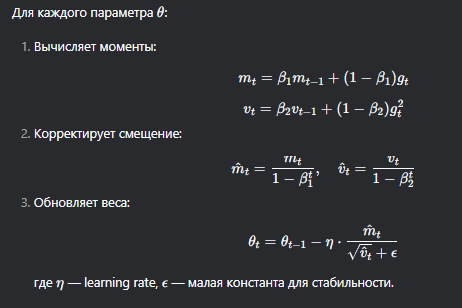

---

 **4. Как это работает в коде?**  
Пример инициализации Adam:  
```python
optimizer = torch.optim.Adam(
    model.parameters(),  # Параметры модели (веса GNN)
    lr=0.001,           # Скорость обучения (по умолчанию)
    betas=(0.9, 0.999), # Коэффициенты моментов (β₁, β₂)
    weight_decay=1e-5   # L2-регуляризация (для борьбы с переобучением)
)
```

 **Что делает каждая настройка?**  
- **`lr=0.001`** — стартовая скорость обучения.  
  - Слишком высокий `lr` → модель «перепрыгнет» минимум.  
  - Слишком низкий `lr` → обучение будет медленным.  
- **`betas=(0.9, 0.999)`** — коэффициенты для моментов.  
  - Чем ближе к 1, тем больше «память» о прошлых градиентах.  
- **`weight_decay=1e-5`** — штраф за большие веса (аналог L2-регуляризации).  

---

 **5. Сравнение с другими оптимизаторами**  
| Оптимизатор  | Плюсы                          | Минусы                         | Когда использовать?           |
|--------------|--------------------------------|--------------------------------|-------------------------------|
| **SGD**      | Простота, хорошая обобщаемость | Требует ручного подбора `lr`   | Для небольших датасетов       |
| **Adam**     | Автонастройка `lr`, скорость   | Может «проскакивать» минимумы  | Большинство задач (по умолчанию) |
| **RMSprop**  | Хорош для RNN                  | Нет адаптации моментов         | Рекуррентные сети             |

---

 **6. Практические советы для проекта**  
1. **Если модель не сходится**:  
   - Попробуйте уменьшить `lr` (например, до `0.0001`).  
   - Добавьте `weight_decay` (например, `1e-4`).  
2. **Для задач регрессии** (как в нашем проекте):  
   - Adam часто лучше SGD, особенно если данные разного масштаба.  
3. **Мониторинг**:  
   - Следите за loss на валидации — если он скачет, возможно, `lr` слишком велик.  

---

 **Вывод**  
**Adam** — это «золотая середина» среди оптимизаторов:  
- Берёт лучшее от **SGD** (точность) и **RMSprop** (адаптивность).  
- Подходит для большинства задач, включая предсказание свойств материалов.  

Для проекта (`args_optim_ == 'Adam'`) это хороший выбор, особенно если:  
- Данные разнородные (например, энергия и проводимость в разных единицах).  
- Модель сложная (например, GNN с несколькими слоями).  

**Что проверить:**  
```python
print(optimizer.param_groups[0]['lr'])  # Текущий learning rate
```  
Если loss колеблется — уменьшайте `lr` в 10 раз и тестируйте снова.

In [ ]:
# Текущий learning rate
optimizer.param_groups[0]['lr']

0.01

### 5. ЗАГРУЗКА ЧЕКПОЙНТА (ЕСЛИ НУЖНО)

In [78]:
# глобальные переменные
# args_resume_ = None
args_resume_ = 'models/for_CGCNN_checkpoint'

In [79]:
# 5. ЗАГРУЗКА ЧЕКПОЙНТА (ЕСЛИ НУЖНО)
if args_resume_:
    if os.path.isfile(args_resume_):
        print("=> loading checkpoint '{}'".format(args_resume_))
        checkpoint = torch.load(args_resume_)
        
        # Восстанавливаем состояние из чекпойнта
        args_start_epoch_ = checkpoint['epoch']
        best_mae_error = checkpoint['best_mae_error']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        normalizer.load_state_dict(checkpoint['normalizer'])
        
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(args_resume_, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args_resume_))

=> no checkpoint found at 'models/for_CGCNN_checkpoint'


 Этот блок кода отвечает за **загрузку чекпойнтов (checkpoints)** — сохраненных состояний модели во время обучения. 

 **1. Что такое чекпойнт?**
Чекпойнт — это "снимок" модели в определённый момент обучения, который включает:
- **Веса модели** (`state_dict`)
- **Состояние оптимизатора** (например, моменты Adam)
- **Номер эпохи** (`epoch`)
- **Лучшая достигнутая метрика** (`best_mae_error`)
- **Параметры нормализатора**

---

 **2. Зачем это нужно?**
 **a) Защита от сбоев**
- Обучение GNN на больших датасетах может занимать **дни или недели**. Если процесс прервётся (например, отключится электричество), чекпойнт позволит продолжить с последней сохранённой точки, а не начинать заново.

 **b) Возможность ранней остановки**
- Можно вручную остановить обучение, если метрики перестали улучшаться, а затем загрузить модель с лучшего чекпойнта.

 **c) Воспроизводимость**
- Чекпойнты позволяют точно воспроизвести результаты, даже если код или окружение изменились.

 **d) Transfer Learning**
- Обученную модель можно дообучать на новых данных, начав с чекпойнта вместо случайной инициализации.

---

 **3. Как это работает в вашем коде?**
```python
if args_resume_:  # Если указан путь к чекпойнту
    checkpoint = torch.load(args_resume_)  # Загружаем файл
    model.load_state_dict(checkpoint['state_dict'])  # Восстанавливаем модель
    optimizer.load_state_dict(checkpoint['optimizer'])  # И оптимизатор
    normalizer.load_state_dict(checkpoint['normalizer'])  # И нормализатор
```

---

 **4. Почему нельзя обойтись без чекпойнтов?**
| Без чекпойнтов                     | С чекпойнтами                     |
|------------------------------------|------------------------------------|
| Потеря прогресса при сбое          | Возобновление с последней точки    |
| Невозможность ранней остановки     | Гибкий контроль обучения          |
| Сложность отладки                  | Лёгкое сравнение разных версий    |

---

 **5. Когда чекпойнты особенно важны?**
1. **Долгое обучение** (например, 100+ эпох).
2. **Эксперименты с гиперпараметрами** — можно сравнивать разные чекпойнты одной модели.
3. **Критически важные задачи** (например, предсказание свойств для научной публикации).

---

 **6. Что будет, если удалить этот блок?**
- **Риски**:
  - При любом сбое обучение придётся начинать с нуля.
  - Невозможно будет выбрать лучшую модель по валидации.
- **Исключение**:
  - Если модель обучается быстро (минуты/часы), а результаты не требуют сохранения — можно удалить, но это плохая практика.

---

 **7. Как улучшить текущую реализацию?**
1. **Автосохранение**:
   ```python
   if epoch % 10 == 0:  # Сохраняем каждые 10 эпох
       torch.save(checkpoint, f'checkpoint_epoch{epoch}.pth')
   ```
2. **Лучший чекпойнт**:
   ```python
   if val_mae < best_mae_error:
       best_mae_error = val_mae
       torch.save(checkpoint, 'best_model.pth')
   ```
3. **Cloud-бэкап**:
   - Автоматическая загрузка чекпойнтов в Google Drive/S3.

---

 **Вывод**
Этот блок **нельзя удалять** — он обеспечивает:
- Надёжность обучения.
- Гибкость управления.
- Экономию времени и ресурсов.

**Рекомендация**: Добавьте регулярное автосохранение (см. п.7), особенно если модель обучается на GPU-кластере.

### 6. НАСТРОЙКА РАСПИСАНИЯ СКОРОСТИ ОБУЧЕНИЯ

In [67]:
# 6. НАСТРОЙКА РАСПИСАНИЯ СКОРОСТИ ОБУЧЕНИЯ
scheduler = MultiStepLR(
    optimizer, 
    # milestones=args.lr_milestones,  # эпохи, когда нужно уменьшать lr
    milestones=[10],  # эпохи, когда нужно уменьшать lr
    gamma=0.1                       # множитель для уменьшения lr
)

### 7. ЦИКЛ ОБУЧЕНИЯ

In [68]:
import sys

In [69]:
args_epochs_ = 60 # число эпох
args_start_epoch_ = 0

**Смотрим как итерировать DataLoader:** 
`DataLoader` (в нашем случае `train_loader`) **является итерируемым объектом**, но не является *индексируемым* (то есть не поддерживает операцию `train_loader[0]`). Это разные понятия!

---

 **Как правильно итерироваться по `train_loader`**

 1. **Базовый вариант (если `batch = (input, target, metadata)`)**
```python
from tqdm import tqdm

for batch in tqdm(train_loader):  # Автоматически создаёт итератор
    input, target, _ = batch      # Распаковываем батч
    # Ваш код обработки
    print(input.shape, target.shape)
```

 2. **С доступом к индексу батча (если нужен `i`)**
```python
for i, (input, target, _) in tqdm(enumerate(train_loader)):
    # Ваш код
    print(f"Batch {i}: Input={input.shape}, Target={target.shape}")
```

---

 **Ключевые выводы**
1. `train_loader` — **итерируемый**, но не индексируемый.
2. Используйте `for batch in train_loader` или `enumerate(train_loader)`.
3. Если цикл не работает — проверьте:
   - Не пуст ли `dataset`,
   - Корректность `collate_fn`,
   - Размеры данных в батче.

Для нашего случая с `(input, target, _)` подойдёт вариант 1 или 2 из примеров выше.

### def train с корректировками

In [83]:
# смотрим
train_loader.batch_size

32

In [84]:
# смотрим
len(train_loader)

14

In [85]:
# смотрим
train_loader.__dict__

{'dataset': <__main__.CIFData at 0x1884b0317f0>,
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 32,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x1884b2037d0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x18847c00200>,
 'generator': None,
 'collate_fn': <function __main__.collate_pool(dataset_list)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [86]:
# смотрим
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [87]:
# смотрим как итерировать train_loader
n = 0
for i, batch in tqdm(enumerate(train_loader)):
    print(i)
    n+=1
    # print(batch)

14it [00:00, 181.82it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [70]:
def train(train_loader, model, criterion, optimizer, epoch, normalizer):
    """
    Функция для обучения модели на одной эпохе
    Параметры:
        train_loader - DataLoader для обучающих данных
        model - модель нейронной сети
        criterion - функция потерь
        optimizer - оптимизатор
        epoch - номер текущей эпохи
        normalizer - нормализатор для целевых значений
    """
    
    # Инициализация счетчиков для мониторинга процесса обучения:
    print('train Начало работы функции')
    # batch_time - время обработки одного батча
    batch_time = AverageMeter()
    print('batch_time', batch_time)
    # data_time - время загрузки данных
    data_time = AverageMeter()
    print('data_time', data_time)
    # losses - значения функции потерь
    losses = AverageMeter()
    print('losses', losses)
    
    # В зависимости от типа задачи инициализируем соответствующие метрики:
    if args_task_ == 'regression':
        # Для регрессии используем MAE (Mean Absolute Error)
        mae_errors = AverageMeter()
        print('mae_errors', mae_errors)
    else:
        # Для классификации используем несколько метрик:
        accuracies = AverageMeter()    # Точность
        precisions = AverageMeter()    # Прецизионность
        recalls = AverageMeter()       # Полнота
        fscores = AverageMeter()       # F1-мера
        auc_scores = AverageMeter()    # AUC-ROC

    # Переводим модель в режим обучения (это важно для слоев типа Dropout и BatchNorm)
    model.train()
    print('train Сработало model.train()')

    # Фиксируем время начала обработки
    end = time.time()
    print('end', end)
    
    # Основной цикл обучения по батчам:
    print('train Начинаем цикл обучения по батчам!')
    for i, (batch) in tqdm(enumerate(train_loader)):
        input = batch[0]
        target = batch[1]
        print('Новый i-й шаг цикла:', i)
        # print('input - входные данные модели', input)
        # print('target - целевые значения', target)

        # input - входные данные модели
        # target - целевые значения
        # _ - дополнительные метаданные (не используются)
        
        # 1. Измеряем время загрузки данных
        data_time.update(time.time() - end)
        print('train Измеряем время загрузки данных')

        # 2. Подготовка входных данных:
        # Переносим данные на GPU, если используется CUDA
        if args_cuda_:
            print('train args_cuda_')
            input_var = (
                Variable(input[0].cuda(non_blocking=True)),  # Атомные признаки
                Variable(input[1].cuda(non_blocking=True)),  # Признаки соседей
                input[2].cuda(non_blocking=True),           # Индексы соседей
                [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]]  # Индексы кристаллов
            )
        else:
            print('train args_cuda_ else')
            input_var = (
                Variable(input[0]),
                Variable(input[1]),
                input[2],
                input[3]
            )

        # 3. Нормализация целевых значений:
        if args_task_ == 'regression':
            print('train Нормализация целевых значений: args_task_ == regression')
            # Для регрессии нормализуем целевые значения
            target_normed = normalizer.norm(target)
        else:
            print('train Нормализация целевых значений else')
            # Для классификации просто изменяем форму тензора
            target_normed = target.view(-1).long()
        
        # Переносим целевые значения на GPU, если нужно
        if args_cuda_:
            print('train args_cuda_')
            target_var = Variable(target_normed.cuda(non_blocking=True))
        else:
            print('train args_cuda_ is None')
            target_var = Variable(target_normed)

        # 4. Прямой проход (forward pass):
        # Вычисляем выход модели для текущего батча
        output = model(*input_var)
        print('train output', output)
        # Вычисляем значение функции потерь
        loss = criterion(output, target_var)
        print('train loss', loss)

        # 5. Вычисление метрик:
        if args_task_ == 'regression':
            # Для регрессии:
            # Денормализуем предсказания и вычисляем MAE
            mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            print('train mae_error', mae_error)
            # Обновляем счетчики потерь и ошибок
            losses.update(loss.data.cpu(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
        else:
            # Для классификации:
            # Вычисляем различные метрики качества
            accuracy, precision, recall, fscore, auc_score = \
                class_eval(output.data.cpu(), target)
            # Обновляем все счетчики метрик
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))

        # print('Цикл 5. Вычисление метрик: завершен')

        # 6. Обратный проход (backward pass) и оптимизация:
        # Обнуляем градиенты (важно делать перед каждым backward)
        optimizer.zero_grad()
        # Вычисляем градиенты
        loss.backward()
        # Обновляем веса модели
        optimizer.step()

        # 7. Измеряем общее время обработки батча
        batch_time.update(time.time() - end)
        end = time.time()

        # 8. Периодический вывод статистики:
        if args_task_ == 'regression':
            # Вывод для регрессии
            print('train Вывод для регрессии')
            print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses, mae_errors=mae_errors)
            )

### пробуем один проход 

In [71]:
# способ для итерации 
batch = next(iter(train_loader))
batch

((tensor([[0., 1., 0.,  ..., 0., 0., 1.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],
  
          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0

In [313]:
dataset

CIFData(559)

In [316]:
train_loader.dataset[0]

((tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [317]:
val_loader.dataset[0]

((tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [195]:
# способ для итерации 
# batch = next(iter(train_loader))
batch

((tensor([[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 

In [72]:
# данные о том какие элементы содержаться в материале
x = batch[0][0][0]
len(x), x, (x).shape, type(x)

(92,
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]),
 torch.Size([92]),
 torch.Tensor)

In [197]:
batch[0][0].shape

torch.Size([847, 92])

In [198]:
batch[0][1].shape

torch.Size([847, 12, 41])

In [200]:
# данные о месторасположении атомов ???
x = batch[0][1][0][0]
len(x), x, (x).shape, type(x)

(41,
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8483e-39,
         1.0847e-31, 8.6151e-25, 9.2603e-19, 1.3471e-13, 2.6521e-09, 7.0661e-06,
         2.5479e-03, 1.2434e-01, 8.2118e-01, 7.3397e-01, 8.8783e-02, 1.4534e-03,
         3.2201e-06, 9.6550e-10, 3.9178e-14, 2.1516e-19, 1.5991e-25, 1.6084e-32,
         2.1895e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 torch.Size([41]),
 torch.Tensor)

In [201]:
x = batch[0][0]
len(x), x, (x).shape, type(x)

(847,
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([847, 92]),
 torch.Tensor)

In [ ]:
# все входные данные кроме прогнозируемой величины
x = batch[0]
len(x), x, type(x)

(4,
 (tensor([[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  .

In [212]:
# 32 значения прогнозируемой величины
x = batch[1]
len(x), x.shape, type(x), x  

(32,
 torch.Size([32, 1]),
 torch.Tensor,
 tensor([[-0.5033],
         [-0.3249],
         [-0.3679],
         [-0.4565],
         [-2.0655],
         [-0.5070],
         [-0.0283],
         [-0.0300],
         [ 0.6390],
         [-0.2140],
         [-1.9074],
         [-0.1738],
         [-3.3895],
         [-2.8427],
         [-0.2969],
         [-0.2082],
         [-0.8660],
         [-1.2103],
         [-1.5221],
         [-0.4448],
         [-1.2653],
         [-0.5825],
         [-0.2206],
         [-0.1846],
         [ 0.1920],
         [-1.6749],
         [-1.0399],
         [ 0.2659],
         [-2.3199],
         [ 0.7493],
         [-0.3112],
         [-0.1322]]))

In [214]:
# 32 значения номера файлов
x = batch[2]
len(x), type(x), x

(32,
 list,
 ['1191765',
  '961686',
  '642279',
  '636953',
  '19071',
  '865652',
  '1103513',
  '531',
  '631548',
  '1214552',
  '1211457',
  '861876',
  '4047',
  '1016821',
  '20211',
  '978526',
  '1200984',
  '1214037',
  '1364379',
  '867878',
  '754940',
  '510324',
  '1105932',
  '1227277',
  '1009813',
  '1186997',
  '1214132',
  '1008689',
  '555755',
  '999187',
  '972810',
  '14378'])

In [216]:
# 847 примеров структуры данные о элементах
x = batch[0][0]
len(x), x.shape, type(x), x

(847,
 torch.Size([847, 92]),
 torch.Tensor,
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
# 847 примеров структуры данные о ...
x = batch[0][1]
len(x), x.shape, type(x), x

(847,
 torch.Size([847, 12, 41]),
 torch.Tensor,
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],

In [ ]:
# 847х12 примеров структуры данные о ...
x = batch[0][2]
len(x), x.shape, type(x), x

(847,
 torch.Size([847, 12]),
 torch.Tensor,
 tensor([[ 19,  13,  16,  ...,   7,   9,   6],
         [ 14,  17,  11,  ...,   8,   9,   7],
         [ 18,  12,  15,  ...,   7,   9,   8],
         ...,
         [826, 816, 822,  ..., 835, 838, 837],
         [824, 823, 821,  ..., 836, 835, 833],
         [815, 810, 831,  ..., 835, 836, 838]]))

In [221]:
len(batch[0])

4

In [222]:
# 847 примеров структуры данные о ...
x = batch[0][3]
len(x), type(x), x

(32,
 list,
 [tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21]),
  tensor([22, 23, 24]),
  tensor([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
          43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]),
  tensor([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
          72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
  tensor([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
  tensor([ 97,  98,  99, 100]),
  tensor([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
          115]),
  tensor([116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
          130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
          144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]),
  tensor([170, 171, 172, 173]),
  tensor([174, 175, 176, 177, 178, 17

In [173]:
len(next(iter(train_loader))[0]), next(iter(train_loader))[0], type(next(iter(train_loader))[0])

(4,
 (tensor([[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  .

In [95]:
input = batch[0]

In [96]:
input_var = (
    Variable(input[0]),
    Variable(input[1]),
    input[2],
    input[3])

In [86]:
target = batch[1]

In [87]:
 # 3. Нормализация целевых значений:
target_normed = normalizer.norm(target)

In [88]:
target

tensor([[-0.0256],
        [-0.2626],
        [-0.3741],
        [-0.8315],
        [-0.0423],
        [-0.2969],
        [-0.8763],
        [-0.5546],
        [-0.4625],
        [-0.8660],
        [-0.0283],
        [ 0.3212],
        [-0.2080],
        [ 0.8456],
        [-0.3073],
        [ 0.5390],
        [-1.2214],
        [-0.5426],
        [-2.3551],
        [-0.1388],
        [-0.8362],
        [ 0.7493],
        [-0.5177],
        [-0.7837],
        [ 0.5418],
        [-0.9408],
        [-2.8266],
        [-0.9726],
        [-2.1641],
        [-0.1355],
        [ 0.0085],
        [-0.3568]])

In [89]:
target.max(), target.min()

(tensor(0.8456), tensor(-2.8266))

In [90]:
target_normed.max(), target_normed.min()

(tensor(1.5439), tensor(-2.0008))

In [91]:
target_normed

tensor([[ 0.7029],
        [ 0.4742],
        [ 0.3666],
        [-0.0750],
        [ 0.6868],
        [ 0.4411],
        [-0.1182],
        [ 0.1923],
        [ 0.2812],
        [-0.1083],
        [ 0.7003],
        [ 1.0377],
        [ 0.5268],
        [ 1.5439],
        [ 0.4310],
        [ 1.2479],
        [-0.4514],
        [ 0.2039],
        [-1.5457],
        [ 0.5937],
        [-0.0796],
        [ 1.4509],
        [ 0.2279],
        [-0.0288],
        [ 1.2506],
        [-0.1805],
        [-2.0008],
        [-0.2111],
        [-1.3613],
        [ 0.5968],
        [ 0.7359],
        [ 0.3832]])

In [233]:
args_cuda_

In [92]:
# Переносим целевые значения на GPU, если нужно
target_var = Variable(target_normed)

In [93]:
target_var

tensor([[ 0.7029],
        [ 0.4742],
        [ 0.3666],
        [-0.0750],
        [ 0.6868],
        [ 0.4411],
        [-0.1182],
        [ 0.1923],
        [ 0.2812],
        [-0.1083],
        [ 0.7003],
        [ 1.0377],
        [ 0.5268],
        [ 1.5439],
        [ 0.4310],
        [ 1.2479],
        [-0.4514],
        [ 0.2039],
        [-1.5457],
        [ 0.5937],
        [-0.0796],
        [ 1.4509],
        [ 0.2279],
        [-0.0288],
        [ 1.2506],
        [-0.1805],
        [-2.0008],
        [-0.2111],
        [-1.3613],
        [ 0.5968],
        [ 0.7359],
        [ 0.3832]])

In [97]:
# 4. Прямой проход (forward pass):
# Вычисляем выход модели для текущего батча
output = model(*input_var)
print('output', output)

output tensor([[0.2626],
        [0.3113],
        [0.2879],
        [0.3039],
        [0.2853],
        [0.3046],
        [0.2862],
        [0.2835],
        [0.3560],
        [0.2844],
        [0.2663],
        [0.2974],
        [0.2686],
        [0.2890],
        [0.3100],
        [0.2732],
        [0.3061],
        [0.2942],
        [0.2899],
        [0.2792],
        [0.2914],
        [0.3084],
        [0.2959],
        [0.3071],
        [0.2764],
        [0.3160],
        [0.2882],
        [0.2843],
        [0.2888],
        [0.2807],
        [0.2828],
        [0.2859]], grad_fn=<AddmmBackward0>)


In [98]:
# Вычисляем значение функции потерь
loss = criterion(output, target_var)
print('loss', loss)

loss tensor(0.6110, grad_fn=<MseLossBackward0>)


In [99]:
# Для регрессии:
# Денормализуем предсказания и вычисляем MAE
mae_error = mae(normalizer.denorm(output.data.cpu()), target)
print('mae_error', mae_error)

mae_error tensor(0.5838)


In [100]:
losses = AverageMeter()

In [101]:
# Обновляем счетчики потерь и ошибок
losses.update(loss.data.cpu(), target.size(0))

In [102]:
loss.data, target.size(0)

(tensor(0.6110), 32)

In [103]:
mae_errors = AverageMeter()

In [104]:
mae_errors.update(mae_error, target.size(0))

In [105]:
mae_errors.__dir__

<function AverageMeter.__dir__()>

In [106]:
dir(mae_errors)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'avg',
 'count',
 'reset',
 'sum',
 'update',
 'val']

In [107]:
mae_errors.__dict__

{'val': tensor(0.5838),
 'avg': tensor(0.5838),
 'sum': tensor(18.6809),
 'count': 32}

In [108]:
mae_errors.val

tensor(0.5838)

In [109]:
# 6. Обратный проход (backward pass) и оптимизация:
# Обнуляем градиенты (важно делать перед каждым backward)
optimizer.zero_grad()

In [110]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [111]:
# Вычисляем градиенты
loss.backward()

In [112]:
dir(loss)

['H',
 'T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr_

In [113]:
loss

tensor(0.6110, grad_fn=<MseLossBackward0>)

In [115]:
# Обновляем веса модели
optimizer.step()

In [117]:
end = time.time()

In [118]:
batch_time = AverageMeter()

In [119]:
batch_time.update(time.time() - end)

In [120]:
batch_time.__dict__

{'val': 5.0477118492126465,
 'avg': 5.0477118492126465,
 'sum': 5.0477118492126465,
 'count': 1}

In [121]:
from datetime  import datetime 

In [122]:
str(datetime.now())

'2025-06-04 13:02:25.726090'

In [123]:
data_time = datetime.now()

In [302]:
data_time.date()

datetime.date(2025, 4, 9)

In [301]:
data_time.time()

datetime.time(17, 4, 36, 139024)

In [126]:
len(train_loader)

14

In [285]:
print(batch_time)

In [127]:
loss

tensor(0.6110, grad_fn=<MseLossBackward0>)

In [287]:
losses

In [128]:
mae_errors

In [129]:
batch_time.__dict__

{'val': 5.0477118492126465,
 'avg': 5.0477118492126465,
 'sum': 5.0477118492126465,
 'count': 1}

In [130]:
batch_time.val

5.0477118492126465

In [131]:
data_time

datetime.datetime(2025, 6, 4, 13, 2, 28, 524234)

In [132]:
print(f'Epoch: [{0}][{1}/{2}]\t'
            f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t')

Epoch: [0][1/2]	Time 5.048 (5.048)	


In [133]:
loss

tensor(0.6110, grad_fn=<MseLossBackward0>)

In [139]:
# в данном случае, пусть будет первая эпоха
epoch = 0

In [140]:
# 8. Периодический вывод статистики:
if args_task_ == 'regression':
    # Вывод для регрессии
    print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            # 'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
        epoch, i, len(train_loader), batch_time=batch_time,
        data_time=data_time, loss=losses, mae_errors=mae_errors)
    )

Epoch: [0][558/14]	Time 5.048 (5.048)	Loss 0.6110 (0.6110)	MAE 0.584 (0.584)


### Обучаем модель на одной эпохе

In [ ]:
# for i, batch in enumerate(train_loader):
#     print(i, batch)

In [141]:
# Основной цикл обучения по батчам:
print('Начинаем цикл обучения по батчам!')
for i, (input, target, _) in tqdm(enumerate(train_loader)):
    print('Новый i-й шаг цикла:', i)
    print('input - входные данные модели', input)
    print('target - целевые значения', target)

Начинаем цикл обучения по батчам!


0it [00:00, ?it/s]

6it [00:00, 53.45it/s]

Новый i-й шаг цикла: 0
input - входные данные модели (tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0.

14it [00:00, 60.64it/s]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0

In [142]:
epoch = 0
# Обучаем модель на одной эпохе
train(train_loader, model, criterion, optimizer, epoch, normalizer)

train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619782090>
data_time <__main__.AverageMeter object at 0x0000028619780890>
losses <__main__.AverageMeter object at 0x0000028619782C60>
mae_errors <__main__.AverageMeter object at 0x0000028619781A60>
train Сработало model.train()
end 1749031634.0851462
train Начинаем цикл обучения по батчам!


0it [00:00, ?it/s]

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-3.5137],
        [-3.5567],
        [-3.4485],
        [-3.8271],
        [-3.4130],
        [-3.4936],
        [-3.4585],
        [-3.7363],
        [-3.8028],
        [-3.8247],
        [-3.3472],
        [-3.4814],
        [-3.4866],
        [-3.7606],
        [-3.6705],
        [-3.6726],
        [-3.5113],
        [-3.4743],
        [-3.4927],
        [-3.4694],
        [-3.5173],
        [-3.5771],
        [-3.4944],
        [-3.5108],
        [-3.5469],
        [-3.5115],
        [-3.5380],
        [-3.4232],
        [-3.4284],
        [-3.3862],
        [-3.4617],
        [-3.6741]], grad_fn=<AddmmBackward0>)
train loss tensor(12.6688, grad_fn=<MseLossBackward0>)
train mae_error tensor(3.5366)


1it [00:00,  4.41it/s]

train Вывод для регрессии
Epoch: [0][0/14]	Time 0.231 (0.231)	Data 0.009 (0.009)	Loss 12.6688 (12.6688)	MAE 3.537 (3.537)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[1.0271],
        [0.8232],
        [0.6412],
        [1.2667],
        [0.5612],
        [0.2893],
        [0.6493],
        [0.6707],
        [0.4598],
        [0.7241],
        [0.7834],
        [0.5415],
        [0.4882],
        [0.1900],
        [0.1715],
        [0.6496],
        [0.1678],
        [0.4435],
        [0.4520],
        [0.5003],
        [0.1859],
        [0.6183],
        [0.4270],
        [0.2880],
        [0.4450],
        [0.5106],
        [0.4512],
        [0.4203],
        [0.9615],
        [0.4258],
        [0.3374],
        [1.0398]], grad_fn=<AddmmBackward0>)
train loss tensor(1.1666, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8345)
train Вы

3it [00:00,  5.02it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[1.6232],
        [1.3867],
        [1.4839],
        [1.2114],
        [1.5298],
        [1.4367],
        [1.4316],
        [1.4113],
        [1.3164],
        [1.7456],
        [1.1908],
        [1.2266],
        [1.3080],
        [1.1850],
        [1.2299],
        [1.5547],
        [1.5059],
        [1.1889],
        [1.5689],
        [1.3681],
        [1.5547],
        [1.5205],
        [1.4240],
        [1.1795],
        [1.2025],
        [1.3094],
        [1.3447],
        [1.5075],
        [1.4265],
        [1.4214],
        [1.2908],
        [1.4989]], grad_fn=<AddmmBackward0>)
train loss tensor(2.9576, grad_fn=<MseLossBackward0>)
train mae_error tensor(1.5221)
train Вывод для регрессии
Epoch: [0][2/14]	Time 0.192 (0.205)	Data 0.005 (0.006)	Loss 2.9576 (5.5976)	MAE 1.522 (1.964)


4it [00:00,  5.25it/s]

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[1.0002],
        [0.9460],
        [1.0598],
        [1.0797],
        [1.0432],
        [0.9535],
        [0.9525],
        [1.0316],
        [1.0246],
        [1.0208],
        [1.0230],
        [1.0086],
        [1.0316],
        [1.0195],
        [1.0449],
        [1.0604],
        [1.0220],
        [1.0147],
        [1.0156],
        [1.0164],
        [1.0232],
        [0.9397],
        [1.0229],
        [0.9514],
        [1.0123],
        [1.0167],
        [1.0184],
        [1.0225],
        [1.0125],
        [1.0264],
        [1.0177],
        [0.9402]], grad_fn=<AddmmBackward0>)
train loss tensor(2.4602, grad_fn=<MseLossBackward0>)
train mae_error tensor(1.1924)
train Вывод для регрессии
Epoch: [0][3/14]	Time 0.177 (0.198)	Data 0.003 (0.005)	Loss 2.4602 (4.8133)	MAE 1.192 (1.771)
Новый i-й 

6it [00:01,  4.83it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[0.2574],
        [0.2572],
        [0.2239],
        [0.2473],
        [0.1983],
        [0.2344],
        [0.2529],
        [0.2540],
        [0.1577],
        [0.2179],
        [0.2327],
        [0.2385],
        [0.1808],
        [0.2612],
        [0.2470],
        [0.1760],
        [0.2476],
        [0.2216],
        [0.1994],
        [0.2139],
        [0.2519],
        [0.2297],
        [0.2445],
        [0.2554],
        [0.2176],
        [0.2179],
        [0.2626],
        [0.2403],
        [0.2104],
        [0.2308],
        [0.2136],
        [0.2398]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6327, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.5195)
train Вывод для регрессии
Epoch: [0][5/14]	Time 0.168 (0.209)	Data 0.004 (0.005)	Loss 0.6327 (3.5363)	MAE 0.519 (1.403)
Новый i-й 

7it [00:01,  4.89it/s]

train output tensor([[-0.0050],
        [-0.0393],
        [ 0.0105],
        [ 0.0089],
        [-0.0172],
        [-0.0007],
        [ 0.0189],
        [ 0.0152],
        [ 0.0208],
        [-0.0409],
        [ 0.0240],
        [-0.0215],
        [ 0.0100],
        [ 0.0158],
        [-0.0070],
        [ 0.0183],
        [ 0.0082],
        [-0.0013],
        [ 0.0114],
        [ 0.0128],
        [ 0.0109],
        [ 0.0113],
        [-0.0188],
        [-0.0014],
        [ 0.0023],
        [ 0.0113],
        [ 0.0168],
        [-0.0339],
        [ 0.0126],
        [ 0.0118],
        [-0.0276],
        [-0.0509]], grad_fn=<AddmmBackward0>)
train loss tensor(1.1814, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8645)
train Вывод для регрессии
Epoch: [0][6/14]	Time 0.199 (0.207)	Data 0.003 (0.005)	Loss 1.1814 (3.1999)	MAE 0.864 (1.326)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tra

9it [00:01,  5.27it/s]

train Вывод для регрессии
Epoch: [0][7/14]	Time 0.194 (0.206)	Data 0.003 (0.005)	Loss 0.9071 (2.9133)	MAE 0.831 (1.264)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.3039],
        [-0.2971],
        [-0.2781],
        [-0.2764],
        [-0.3034],
        [-0.2867],
        [-0.2764],
        [-0.2841],
        [-0.2757],
        [-0.2789],
        [-0.3029],
        [-0.2893],
        [-0.2763],
        [-0.2814],
        [-0.2900],
        [-0.2903],
        [-0.2940],
        [-0.2818],
        [-0.2766],
        [-0.2882],
        [-0.3041],
        [-0.2828],
        [-0.3006],
        [-0.2795],
        [-0.3000],
        [-0.3009],
        [-0.2751],
        [-0.3044],
        [-0.2943],
        [-0.2828],
        [-0.2830],
        [-0.2834]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0469, grad_fn=<MseLossBackward0>)
train mae

11it [00:02,  5.06it/s]

Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2774],
        [-0.2792],
        [-0.2794],
        [-0.2759],
        [-0.2796],
        [-0.2844],
        [-0.2800],
        [-0.2796],
        [-0.2790],
        [-0.2805],
        [-0.2776],
        [-0.2803],
        [-0.2765],
        [-0.2763],
        [-0.2779],
        [-0.2777],
        [-0.2755],
        [-0.2784],
        [-0.2747],
        [-0.2811],
        [-0.2839],
        [-0.2828],
        [-0.2756],
        [-0.2770],
        [-0.2791],
        [-0.2761],
        [-0.2791],
        [-0.2757],
        [-0.2762],
        [-0.2761],
        [-0.2752],
        [-0.2841]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0405, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.9166)
train Вывод для регрессии
Epoch: [0][10/14]	Time 0.176 (0.203)	Data 0.005 (0.005)	Loss 1.0405 (2.

12it [00:02,  4.46it/s]

train output tensor([[-0.2114],
        [-0.2099],
        [-0.2105],
        [-0.2092],
        [-0.2101],
        [-0.2129],
        [-0.2109],
        [-0.2108],
        [-0.2103],
        [-0.2100],
        [-0.2110],
        [-0.2091],
        [-0.2118],
        [-0.2099],
        [-0.2100],
        [-0.2102],
        [-0.2094],
        [-0.2109],
        [-0.2097],
        [-0.2102],
        [-0.2104],
        [-0.2072],
        [-0.2104],
        [-0.2105],
        [-0.2094],
        [-0.2090],
        [-0.2093],
        [-0.2114],
        [-0.2094],
        [-0.2096],
        [-0.2090],
        [-0.2104]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9684, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8638)
train Вывод для регрессии
Epoch: [0][11/14]	Time 0.286 (0.210)	Data 0.006 (0.005)	Loss 0.9684 (2.2897)	MAE 0.864 (1.147)


13it [00:02,  4.65it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1354],
        [-0.1353],
        [-0.1355],
        [-0.1341],
        [-0.1353],
        [-0.1351],
        [-0.1349],
        [-0.1348],
        [-0.1353],
        [-0.1348],
        [-0.1357],
        [-0.1340],
        [-0.1355],
        [-0.1341],
        [-0.1353],
        [-0.1354],
        [-0.1348],
        [-0.1357],
        [-0.1357],
        [-0.1345],
        [-0.1343],
        [-0.1351],
        [-0.1342],
        [-0.1349],
        [-0.1340],
        [-0.1352],
        [-0.1353],
        [-0.1350],
        [-0.1338],
        [-0.1341],
        [-0.1352],
        [-0.1353]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0304, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8711)
train Вывод для регрессии
Epoch: [0][12/14]	Time 0.194 (0.209)	Data 0.006 (0.005)	Loss 1.0304 (2.

14it [00:02,  4.84it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0581],
        [-0.0596],
        [-0.0591],
        [-0.0585],
        [-0.0586],
        [-0.0569],
        [-0.0589],
        [-0.0580],
        [-0.0571],
        [-0.0586],
        [-0.0576],
        [-0.0569],
        [-0.0578],
        [-0.0584],
        [-0.0570],
        [-0.0585],
        [-0.0597],
        [-0.0585],
        [-0.0574],
        [-0.0587],
        [-0.0578],
        [-0.0575],
        [-0.0579],
        [-0.0581],
        [-0.0577],
        [-0.0586],
        [-0.0581],
        [-0.0578],
        [-0.0577],
        [-0.0590],
        [-0.0597]], grad_fn=<AddmmBackward0>)
train loss tensor(1.1986, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.9066)
train Вывод для регрессии
Epoch: [0][13/14]	Time 0.187 (0.207)	Data 0.003 (0.005)	Loss 1.1986 (2.1239)	MAE 0.907 (1.

14it [00:02,  4.84it/s]


In [350]:
args_start_epoch_

0

In [351]:
args_epochs_

60

### Запускаем цикл обучения по эпохам

Обучаем нашу модель на нашем датасете. Выбрано 60 эпох.

In [143]:
# задаём очередную глобальную переменную
best_mae_error = 1e10
best_mae_error

10000000000.0

In [147]:
# 7. ЦИКЛ ОБУЧЕНИЯ
for epoch in tqdm(range(args_start_epoch_, args_epochs_)):
    print('\n\n\n')
    print('Новый шаг цикла по эпохам epoch', epoch)
    # Обучаем модель на одной эпохе
    train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # Оцениваем на валидационной выборке
    mae_error = validate(val_loader, model, criterion, normalizer)
    print('Цикл mae_error', mae_error)

    # Проверяем на NaN (если ошибка NaN, прекращаем выполнение)
    if mae_error != mae_error:
        print('Exit due to NaN')
        sys.exit(1)

    # Обновляем скорость обучения
    scheduler.step()

    # Сохраняем лучшую модель
    if args_task_ == 'regression':
        is_best = mae_error < best_mae_error  # для регрессии ищем минимум ошибки
        best_mae_error = min(mae_error, best_mae_error)
    else:
        is_best = mae_error > best_mae_error  # для классификации может быть другой критерий
        best_mae_error = max(mae_error, best_mae_error)
    
    # Сохраняем чекпойнт
    save_checkpoint({
        'epoch': epoch + 1,          # текущая эпоха
        'state_dict': model.state_dict(),  # параметры модели
        'best_mae_error': best_mae_error,  # лучшая ошибка
        'optimizer': optimizer.state_dict(),  # состояние оптимизатора
        'normalizer': normalizer.state_dict(),  # параметры нормализатора
        # 'args': vars(args)           # аргументы командной строки
    }, is_best)  # is_best указывает, является ли это лучшей моделью

  0%|          | 0/60 [00:00<?, ?it/s]





Новый шаг цикла по эпохам epoch 0
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861820B5F0>
data_time <__main__.AverageMeter object at 0x00000286198535F0>
losses <__main__.AverageMeter object at 0x0000028619850B00>
mae_errors <__main__.AverageMeter object at 0x00000286198511C0>
train Сработало model.train()
end 1749031873.6002564
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[0.0409],
        [0.0408],
        [0.0434],
        [0.0436],
        [0.0445],
        [0.0436],
        [0.0437],
        [0.0432],
        [0.0386],
        [0.0387],
        [0.0391],
        [0.0431],
        [0.0416],
        [0.0438],
        [0.0383],
        [0.0445],
        [0.0382],
        [0.0446],
        [0.0388],
        [0.0432],
        [0.0411],
        [0.0445],
        [0.0436],
        [0.0433],
        [0.0438],
        [0.0438],
        [0.0446],
        [0.0429],
        [0.0444],
        [0.0383],
        [0.0435],
        [0.0442]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6381, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.6710)


train Вывод для регрессии
Epoch: [0][0/14]	Time 0.225 (0.225)	Data 0.015 (0.015)	Loss 0.6381 (0.6381)	MAE 0.671 (0.671)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0130],
        [-0.0114],
        [-0.0118],
        [-0.0121],
        [-0.0148],
        [-0.0166],
        [-0.0116],
        [-0.0127],
        [-0.0113],
        [-0.0114],
        [-0.0160],
        [-0.0169],
        [-0.0113],
        [-0.0125],
        [-0.0122],
        [-0.0143],
        [-0.0129],
        [-0.0116],
        [-0.0134],
        [-0.0123],
        [-0.0129],
        [-0.0127],
        [-0.0169],
        [-0.0176],
        [-0.0167],
        [-0.0122],
        [-0.0166],
        [-0.0120],
        [-0.0118],
        [-0.0114],
        [-0.0114],
        [-0.0113]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0255, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][1/14]	Time 0.216 (0.220)	Data 0.007 (0.011)	Loss 1.0255 (0.8318)	MAE 0.815 (0.743)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0623],
        [-0.0568],
        [-0.0570],
        [-0.0630],
        [-0.0579],
        [-0.0609],
        [-0.0569],
        [-0.0570],
        [-0.0598],
        [-0.0569],
        [-0.0601],
        [-0.0632],
        [-0.0617],
        [-0.0587],
        [-0.0571],
        [-0.0620],
        [-0.0599],
        [-0.0595],
        [-0.0576],
        [-0.0580],
        [-0.0606],
        [-0.0587],
        [-0.0570],
        [-0.0620],
        [-0.0581],
        [-0.0573],
        [-0.0624],
        [-0.0571],
        [-0.0637],
        [-0.0569],
        [-0.0569],
        [-0.0592]], grad_fn=<AddmmBackward0>)
train loss tensor(1.4623, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][2/14]	Time 0.223 (0.221)	Data 0.007 (0.010)	Loss 1.4623 (1.0420)	MAE 1.001 (0.829)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1192],
        [-0.1219],
        [-0.1207],
        [-0.1230],
        [-0.1219],
        [-0.1187],
        [-0.1193],
        [-0.1189],
        [-0.1253],
        [-0.1184],
        [-0.1222],
        [-0.1203],
        [-0.1191],
        [-0.1253],
        [-0.1189],
        [-0.1193],
        [-0.1186],
        [-0.1187],
        [-0.1204],
        [-0.1191],
        [-0.1205],
        [-0.1202],
        [-0.1183],
        [-0.1186],
        [-0.1215],
        [-0.1230],
        [-0.1253],
        [-0.1230],
        [-0.1208],
        [-0.1185],
        [-0.1253],
        [-0.1199]], grad_fn=<AddmmBackward0>)
train loss tensor(0.8017, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][4/14]	Time 0.192 (0.198)	Data 0.004 (0.008)	Loss 1.2790 (1.0413)	MAE 1.003 (0.855)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1055],
        [-0.1081],
        [-0.1008],
        [-0.1050],
        [-0.0958],
        [-0.0940],
        [-0.0953],
        [-0.0948],
        [-0.0954],
        [-0.1005],
        [-0.0953],
        [-0.0945],
        [-0.1077],
        [-0.1042],
        [-0.0943],
        [-0.0956],
        [-0.0957],
        [-0.0950],
        [-0.0953],
        [-0.0989],
        [-0.0960],
        [-0.0946],
        [-0.0948],
        [-0.0945],
        [-0.0961],
        [-0.0950],
        [-0.0956],
        [-0.1035],
        [-0.0951],
        [-0.0958],
        [-0.0948],
        [-0.0946]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9178, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][5/14]	Time 0.208 (0.200)	Data 0.004 (0.007)	Loss 0.9178 (1.0207)	MAE 0.768 (0.841)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0803],
        [-0.0814],
        [-0.0887],
        [-0.0805],
        [-0.0795],
        [-0.0801],
        [-0.0940],
        [-0.0937],
        [-0.0823],
        [-0.0779],
        [-0.0950],
        [-0.0793],
        [-0.0802],
        [-0.0812],
        [-0.0795],
        [-0.0810],
        [-0.0799],
        [-0.0823],
        [-0.0805],
        [-0.0789],
        [-0.0766],
        [-0.0920],
        [-0.0801],
        [-0.0801],
        [-0.0802],
        [-0.0799],
        [-0.0802],
        [-0.0801],
        [-0.0931],
        [-0.0804],
        [-0.0803],
        [-0.0789]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6882, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][6/14]	Time 0.296 (0.214)	Data 0.007 (0.007)	Loss 0.6882 (0.9732)	MAE 0.689 (0.819)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0205],
        [-0.0268],
        [-0.0372],
        [-0.0283],
        [-0.0246],
        [-0.0318],
        [-0.0305],
        [-0.0300],
        [-0.0300],
        [-0.0290],
        [-0.0137],
        [-0.0243],
        [-0.0176],
        [-0.0146],
        [-0.0209],
        [-0.0279],
        [-0.0209],
        [-0.0132],
        [-0.0357],
        [-0.0288],
        [-0.0170],
        [-0.0345],
        [-0.0298],
        [-0.0352],
        [-0.0359],
        [-0.0250],
        [-0.0248],
        [-0.0341],
        [-0.0223],
        [-0.0340],
        [-0.0273],
        [-0.0235]], grad_fn=<AddmmBackward0>)
train loss tensor(1.1951, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][7/14]	Time 0.252 (0.218)	Data 0.008 (0.007)	Loss 1.1951 (1.0010)	MAE 0.880 (0.827)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0055],
        [ 0.0054],
        [ 0.0068],
        [ 0.0079],
        [ 0.0051],
        [-0.0033],
        [-0.0020],
        [ 0.0160],
        [ 0.0218],
        [ 0.0093],
        [ 0.0339],
        [ 0.0169],
        [-0.0009],
        [ 0.0077],
        [-0.0039],
        [ 0.0067],
        [ 0.0050],
        [ 0.0016],
        [ 0.0050],
        [ 0.0056],
        [ 0.0245],
        [ 0.0085],
        [ 0.0069],
        [ 0.0163],
        [ 0.0103],
        [-0.0024],
        [ 0.0087],
        [ 0.0353],
        [ 0.0174],
        [ 0.0120],
        [ 0.0143],
        [ 0.0116]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6692, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [0][8/14]	Time 0.245 (0.221)	Data 0.009 (0.007)	Loss 0.6692 (0.9641)	MAE 0.608 (0.802)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[0.0421],
        [0.0409],
        [0.0403],
        [0.0567],
        [0.0429],
        [0.0516],
        [0.0245],
        [0.0643],
        [0.0672],
        [0.0591],
        [0.0640],
        [0.0475],
        [0.0684],
        [0.0235],
        [0.0455],
        [0.0299],
        [0.0310],
        [0.0418],
        [0.0628],
        [0.0713],
        [0.0298],
        [0.0415],
        [0.0432],
        [0.0528],
        [0.0492],
        [0.0284],
        [0.0471],
        [0.0316],
        [0.0432],
        [0.0420],
        [0.0429],
        [0.0450]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0025, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8063)


train Вывод для регрессии
Epoch: [0][9/14]	Time 0.242 (0.223)	Data 0.010 (0.008)	Loss 1.0025 (0.9679)	MAE 0.806 (0.803)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[0.0123],
        [0.0647],
        [0.0570],
        [0.0474],
        [0.0398],
        [0.0467],
        [0.0762],
        [0.0518],
        [0.0445],
        [0.0167],
        [0.0451],
        [0.0444],
        [0.0455],
        [0.0469],
        [0.0155],
        [0.0420],
        [0.0420],
        [0.0410],
        [0.0447],
        [0.0163],
        [0.0142],
        [0.0428],
        [0.0466],
        [0.0139],
        [0.0422],
        [0.0397],
        [0.0417],
        [0.0416],
        [0.0205],
        [0.0539],
        [0.0409],
        [0.0550]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9319, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.7585)


train Вывод для регрессии
Epoch: [0][10/14]	Time 0.230 (0.224)	Data 0.006 (0.008)	Loss 0.9319 (0.9647)	MAE 0.759 (0.799)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[0.0325],
        [0.0118],
        [0.0354],
        [0.0335],
        [0.0345],
        [0.0313],
        [0.0374],
        [0.0324],
        [0.0333],
        [0.0344],
        [0.0358],
        [0.0409],
        [0.0369],
        [0.0349],
        [0.0315],
        [0.0316],
        [0.0085],
        [0.0349],
        [0.0447],
        [0.0303],
        [0.0368],
        [0.0468],
        [0.0316],
        [0.0322],
        [0.0115],
        [0.0393],
        [0.0352],
        [0.0367],
        [0.0084],
        [0.0048],
        [0.0368],
        [0.0055]], grad_fn=<AddmmBackward0>)
train loss tensor(0.8180, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.7344)
train Вы

train Вывод для регрессии
Epoch: [0][12/14]	Time 0.192 (0.216)	Data 0.005 (0.007)	Loss 1.5565 (0.9989)	MAE 0.952 (0.806)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0225],
        [ 0.0128],
        [ 0.0058],
        [ 0.0013],
        [ 0.0159],
        [ 0.0122],
        [ 0.0148],
        [-0.0229],
        [ 0.0174],
        [ 0.0226],
        [ 0.0096],
        [ 0.0249],
        [ 0.0248],
        [ 0.0127],
        [ 0.0084],
        [-0.0114],
        [-0.0240],
        [ 0.0238],
        [ 0.0028],
        [ 0.0121],
        [ 0.0121],
        [ 0.0119],
        [ 0.0033],
        [ 0.0146],
        [-0.0265],
        [-0.0155],
        [ 0.0088],
        [ 0.0039],
        [ 0.0034],
        [-0.0184],
        [ 0.0073]], grad_fn=<AddmmBackward0>)
train loss tensor(0.7790, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.6

14it [00:03,  4.65it/s]
  2%|▏         | 1/60 [00:03<03:06,  3.16s/it]

train Вывод для регрессии
Epoch: [0][13/14]	Time 0.214 (0.216)	Data 0.004 (0.007)	Loss 0.7790 (0.9836)	MAE 0.685 (0.797)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286183113A0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.8688)
validate mae_errors <__main__.AverageMeter object at 0x00000286183113A0>
Test: [0/2]	Time 0.078 (0.078)	Loss 1.3191 (1.3191)	MAE 0.869 (0.869)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.7551)
validate mae_errors <__main__.AverageMeter object at 0x00000286183113A0>
validate mae_errors
 * MAE 0.821
Цикл mae_error tensor(0.8213)




Новый шаг цикла по эпохам epoch 1
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861821B800>
data_time <__main__.AverageMeter object at 0x0000028617B29760>
losses <__main__.AverageMeter object at 0x000002861778C4A0>
mae_errors <__main__.AverageMeter object a

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0652],
        [-0.0130],
        [-0.0182],
        [ 0.0039],
        [-0.0232],
        [-0.0667],
        [-0.0366],
        [ 0.0292],
        [-0.0171],
        [-0.0126],
        [-0.0218],
        [-0.0222],
        [-0.0245],
        [-0.0243],
        [ 0.0080],
        [-0.0727],
        [-0.0244],
        [-0.0636],
        [-0.0413],
        [-0.0293],
        [-0.0710],
        [-0.0208],
        [-0.0199],
        [ 0.0112],
        [-0.0302],
        [ 0.0039],
        [-0.0254],
        [-0.0721],
        [-0.0731],
        [-0.0202],
        [-0.0271],
        [-0.0222]], grad_fn=<AddmmBackward0>)
train loss tensor(0.8814, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.7626)


train Вывод для регрессии
Epoch: [1][0/14]	Time 0.345 (0.345)	Data 0.008 (0.008)	Loss 0.8814 (0.8814)	MAE 0.763 (0.763)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0036],
        [-0.0079],
        [-0.0346],
        [-0.0504],
        [ 0.0492],
        [-0.0577],
        [-0.0116],
        [-0.0376],
        [-0.1272],
        [-0.0572],
        [-0.1056],
        [-0.0362],
        [-0.0305],
        [-0.0443],
        [-0.0325],
        [ 0.0068],
        [-0.0314],
        [-0.0284],
        [-0.0361],
        [-0.0010],
        [-0.0087],
        [-0.1092],
        [-0.0511],
        [-0.1186],
        [-0.0487],
        [ 0.0439],
        [-0.0542],
        [-0.0253],
        [-0.1084],
        [-0.0155],
        [-0.0454],
        [-0.0618]], grad_fn=<AddmmBackward0>)
train loss tensor(0.7843, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [1][1/14]	Time 0.244 (0.294)	Data 0.006 (0.007)	Loss 0.7843 (0.8329)	MAE 0.719 (0.741)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0112],
        [ 0.0435],
        [-0.0060],
        [ 0.0428],
        [ 0.0178],
        [ 0.1261],
        [ 0.0700],
        [ 0.0034],
        [-0.0082],
        [-0.0007],
        [ 0.0379],
        [ 0.0326],
        [-0.1187],
        [ 0.0617],
        [ 0.0017],
        [-0.0003],
        [-0.1167],
        [ 0.1185],
        [ 0.0137],
        [ 0.1565],
        [-0.0932],
        [-0.1076],
        [-0.0888],
        [-0.1103],
        [ 0.0147],
        [ 0.0510],
        [ 0.0401],
        [-0.0043],
        [ 0.0658],
        [ 0.1435],
        [-0.1216],
        [ 0.0281]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6793, grad_fn=<MseLossBackward0>)
train mae

3it [00:00,  4.14it/s]

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0783],
        [ 0.1121],
        [ 0.0731],
        [ 0.1101],
        [ 0.0775],
        [ 0.0839],
        [ 0.0857],
        [ 0.0768],
        [-0.0339],
        [ 0.1096],
        [-0.0423],
        [ 0.0793],
        [ 0.2567],
        [ 0.0933],
        [ 0.0790],
        [ 0.1331],
        [ 0.1196],
        [ 0.1085],
        [ 0.1296],
        [ 0.2988],
        [ 0.1161],
        [ 0.0604],
        [ 0.1725],
        [ 0.0873],
        [ 0.0777],
        [ 0.0787],
        [ 0.1071],
        [ 0.2500],
        [-0.0323],
        [ 0.0853],
        [-0.0549],
        [ 0.0820]], grad_fn=<AddmmBackward0>)
train loss tensor(0.8252, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.6869)
train Вывод для регрессии
Epoch: [1][3/14]	Time 0.161 (0.235)	Data 0.006 (0.007)	Loss 0.8252 (0.79


6it [00:01,  5.49it/s]

train Вывод для регрессии
Epoch: [1][4/14]	Time 0.146 (0.217)	Data 0.005 (0.006)	Loss 0.8702 (0.8081)	MAE 0.618 (0.691)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2083],
        [-0.2270],
        [-0.0387],
        [ 0.1363],
        [ 0.0637],
        [ 0.2619],
        [ 0.1222],
        [ 0.5134],
        [-0.0111],
        [-0.2326],
        [ 0.1306],
        [ 0.1416],
        [ 0.1774],
        [ 0.0876],
        [ 0.0903],
        [ 0.3953],
        [ 0.2708],
        [ 0.1483],
        [-0.2365],
        [ 0.1077],
        [ 0.0931],
        [ 0.1171],
        [ 0.1001],
        [ 0.1617],
        [ 0.0551],
        [ 0.0786],
        [ 0.1265],
        [ 0.0908],
        [ 0.0831],
        [ 0.1087],
        [ 0.1344],
        [ 0.0741]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9128, grad_fn=<MseLossBackward0>)
train mae

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4146],
        [ 0.2260],
        [ 0.2301],
        [-0.2174],
        [ 0.7116],
        [-0.2822],
        [-0.2768],
        [ 0.3502],
        [ 0.2785],
        [ 0.3839],
        [-0.2807],
        [ 0.4161],
        [ 0.4465],
        [ 0.2744],
        [ 0.5053],
        [ 0.2681],
        [ 0.4264],
        [ 0.2207],
        [-0.1821],
        [ 0.4147],
        [ 0.2758],
        [ 0.2140],
        [ 0.4872],
        [ 0.2325],
        [ 0.1554],
        [ 0.2639],
        [-0.2279],
        [-0.1559],
        [ 0.5874],
        [-0.1673],
        [ 0.1647],
        [-0.1644]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9167, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.7087)
train Вывод для регрессии
Epoch: [1][6/14]	Time 0.164 (0.203)	Data 0.006 (0.006)	Loss 0.9167 (0.83

train output tensor([[-0.3183],
        [ 0.2975],
        [ 0.3549],
        [ 0.2434],
        [ 0.2239],
        [ 0.4875],
        [ 0.3722],
        [ 0.1179],
        [-0.0117],
        [ 0.1707],
        [ 0.0832],
        [ 0.1746],
        [ 0.2337],
        [ 0.2208],
        [-0.3668],
        [ 0.1903],
        [ 0.1861],
        [ 0.4101],
        [ 0.1342],
        [-0.3589],
        [ 0.5346],
        [ 0.1542],
        [ 0.1984],
        [ 0.1868],
        [-0.3610],
        [-0.3315],
        [ 0.2780],
        [-0.3183],
        [ 0.1604],
        [ 0.1799],
        [ 0.1741],
        [ 0.2231]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3716, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4483)
train Вывод для регрессии
Epoch: [1][7/14]	Time 0.185 (0.201)	Data 0.004 (0.006)	Loss 0.3716 (0.7802)	MAE 0.448 (0.675)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tra

tensor(0.5371)
train Вывод для регрессии
Epoch: [1][8/14]	Time 0.187 (0.199)	Data 0.005 (0.006)	Loss 0.5126 (0.7505)	MAE 0.537 (0.660)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0367],
        [-0.5850],
        [-0.5879],
        [-0.0065],
        [ 0.3069],
        [ 0.1469],
        [ 0.3115],
        [ 0.1839],
        [-0.5874],
        [ 0.0670],
        [-0.5886],
        [ 0.1725],
        [ 0.6694],
        [ 0.2550],
        [ 0.1307],
        [ 0.1766],
        [-0.2563],
        [ 0.1346],
        [-0.0270],
        [ 0.2220],
        [ 0.3751],
        [-0.3488],
        [-0.5808],
        [-0.0176],
        [ 0.2211],
        [ 0.4896],
        [ 0.1706],
        [ 0.2567],
        [ 0.4485],
        [ 0.1063],
        [ 0.1014],
        [ 0.3099]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5956, grad_fn=<MseLossBackwa

train Вывод для регрессии
Epoch: [1][9/14]	Time 0.184 (0.198)	Data 0.005 (0.005)	Loss 0.5956 (0.7350)	MAE 0.617 (0.655)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4571],
        [-0.6806],
        [ 0.9496],
        [-0.0822],
        [ 0.3261],
        [ 0.6265],
        [-0.4175],
        [ 0.4287],
        [-0.2291],
        [-0.0359],
        [ 0.4194],
        [ 0.5113],
        [ 0.9248],
        [ 0.3836],
        [ 0.4006],
        [ 0.7738],
        [ 0.8049],
        [ 0.6307],
        [-0.6876],
        [ 0.9582],
        [-0.6877],
        [-0.0253],
        [ 0.4029],
        [-0.5893],
        [ 0.6944],
        [-0.6890],
        [ 0.6041],
        [-0.6857],
        [ 0.8247],
        [-0.6466],
        [-0.1047],
        [ 0.4309]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3593, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 1.7142],
        [-0.7530],
        [ 1.7901],
        [ 2.0536],
        [-0.7748],
        [ 1.4273],
        [ 1.5231],
        [ 2.8801],
        [ 1.0427],
        [ 1.3098],
        [-0.7456],
        [ 0.6685],
        [ 1.5702],
        [ 1.1315],
        [ 1.5203],
        [ 1.9512],
        [ 1.9904],
        [ 1.4609],
        [ 1.0428],
        [ 0.5700],
        [ 1.4330],
        [-0.6431],
        [-0.6094],
        [-0.4927],
        [ 0.6922],
        [ 0.6612],
        [ 0.0097],
        [-0.7526],
        [ 2.3213],
        [ 1.0872],
        [ 1.0500],
        [ 2.1829]], grad_fn=<AddmmBackward0>)
train loss tensor(1.1849, grad_fn=<MseLossBackward0>)
train mae_error tensor(1.0408)
train Вывод для регрессии
Epoch: [1][11/14]	Time 0.213 (0.195)	Data 0.008 (0.006)	Loss 1.1849 (0.7412)	MAE 1.041 (0.669)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
t

train Вывод для регрессии
Epoch: [1][12/14]	Time 0.167 (0.193)	Data 0.004 (0.005)	Loss 0.2637 (0.7044)	MAE 0.438 (0.651)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.3460],
        [-0.9208],
        [-0.4268],
        [-1.3458],
        [-1.3458],
        [-0.7821],
        [-0.8423],
        [-0.3873],
        [-0.4398],
        [-1.3463],
        [-0.6992],
        [-0.6626],
        [-1.3464],
        [-0.0792],
        [-0.4232],
        [-0.2039],
        [-1.3464],
        [-1.3464],
        [-0.2100],
        [-0.5576],
        [-0.3859],
        [-0.5884],
        [-0.7631],
        [-1.2560],
        [-0.4577],
        [-0.2961],
        [-1.3464],
        [-0.2140],
        [-1.3459],
        [-0.4467],
        [-0.9031]], grad_fn=<AddmmBackward0>)
train loss tensor(0.9730, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.9

14it [00:02,  5.02it/s]
  3%|▎         | 2/60 [00:06<02:55,  3.02s/it]

train Вывод для регрессии
Epoch: [1][13/14]	Time 0.283 (0.199)	Data 0.006 (0.005)	Loss 0.9730 (0.7231)	MAE 0.911 (0.669)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861821B800>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(1.6639)
validate mae_errors <__main__.AverageMeter object at 0x000002861821B800>
Test: [0/2]	Time 0.063 (0.063)	Loss 3.0396 (3.0396)	MAE 1.664 (1.664)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(1.2496)
validate mae_errors <__main__.AverageMeter object at 0x000002861821B800>
validate mae_errors
 * MAE 1.491
Цикл mae_error tensor(1.4906)




Новый шаг цикла по эпохам epoch 2
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861778C4A0>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x0000028617EB0AD0>
mae_errors <__main__.AverageMeter object a

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.9628],
        [-1.5262],
        [-0.7116],
        [-1.5262],
        [-1.5259],
        [-1.5262],
        [-0.5909],
        [-0.7087],
        [-0.6490],
        [-1.5261],
        [-1.5261],
        [-0.6060],
        [-0.7020],
        [-0.7937],
        [-0.8520],
        [-1.5258],
        [-0.8535],
        [-0.5156],
        [-0.5236],
        [-0.8517],
        [-0.7697],
        [-0.6871],
        [-0.6675],
        [-0.6995],
        [-1.5262],
        [-0.9227],
        [-0.7044],
        [-0.5863],
        [-0.8335],
        [-1.0707],
        [-1.5249],
        [-1.5233]], grad_fn=<AddmmBackward0>)
train loss tensor(1.0347, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.9040)



1it [00:00,  3.01it/s]

train Вывод для регрессии
Epoch: [2][0/14]	Time 0.336 (0.336)	Data 0.007 (0.007)	Loss 1.0347 (1.0347)	MAE 0.904 (0.904)


Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.6290],
        [-1.1561],
        [-1.5812],
        [-0.5410],
        [-0.2452],
        [-0.5624],
        [-0.6386],
        [-0.9064],
        [-0.5434],
        [-0.5864],
        [-1.5812],
        [-0.5112],
        [-0.6934],
        [-0.7131],
        [-0.5740],
        [-0.5951],
        [-0.7172],
        [-0.7915],
        [-1.5812],
        [-0.5459],
        [-1.5811],
        [-1.5812],
        [-1.5811],
        [-1.3554],
        [-0.5092],
        [-1.5812],
        [-0.9292],
        [-1.5811],
        [-0.9449],
        [-0.6098],
        [-0.4691],
        [-0.5646]], grad_fn=<AddmmBackward0>)
train loss tensor(1.3040, grad_fn=<MseLossBackward0>)
train mae_error tensor(1.0346)


train Вывод для регрессии
Epoch: [2][1/14]	Time 0.313 (0.324)	Data 0.007 (0.007)	Loss 1.3040 (1.1694)	MAE 1.035 (0.969)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.6504],
        [-1.5164],
        [-0.9436],
        [-0.4140],
        [-0.6125],
        [-0.9433],
        [-0.2372],
        [-0.7629],
        [-0.2912],
        [-0.9545],
        [-0.2579],
        [-1.1576],
        [-0.2004],
        [-0.2620],
        [-0.5504],
        [-0.7837],
        [-0.6494],
        [-1.5164],
        [-1.1096],
        [-0.5172],
        [-0.7154],
        [-0.7648],
        [-0.8336],
        [-0.6658],
        [-0.7209],
        [-0.6728],
        [-0.4566],
        [-1.5164],
        [-0.5401],
        [-1.5164],
        [-0.5804],
        [-0.3615]], grad_fn=<AddmmBackward0>)
train loss tensor(1.3503, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [2][3/14]	Time 0.217 (0.246)	Data 0.005 (0.006)	Loss 0.2755 (0.9911)	MAE 0.445 (0.868)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1839],
        [-1.0333],
        [ 1.0640],
        [-0.7093],
        [ 1.1533],
        [-0.6683],
        [ 1.0833],
        [ 1.0558],
        [ 0.9704],
        [ 0.9372],
        [ 1.1045],
        [ 1.4811],
        [ 1.0143],
        [ 1.1173],
        [ 0.9379],
        [ 1.1225],
        [ 1.0211],
        [ 1.0648],
        [-0.7988],
        [ 0.9945],
        [ 0.9992],
        [ 0.8104],
        [-1.0361],
        [ 1.1144],
        [ 1.1586],
        [ 1.1985],
        [ 1.1052],
        [ 1.0851],
        [ 1.1347],
        [ 1.3189],
        [ 1.0661],
        [ 1.0330]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5760, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [2][5/14]	Time 0.142 (0.215)	Data 0.004 (0.006)	Loss 0.6811 (0.8703)	MAE 0.797 (0.829)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9821],
        [ 0.6802],
        [ 1.0003],
        [-0.9296],
        [ 0.9067],
        [ 0.9119],
        [-0.7324],
        [ 0.9492],
        [ 0.8338],
        [ 1.0733],
        [ 0.9436],
        [-0.5756],
        [ 0.7262],
        [-0.8711],
        [ 0.8950],
        [ 0.6691],
        [-0.9596],
        [ 0.8983],
        [ 0.9220],
        [ 0.9015],
        [-0.5196],
        [-0.6676],
        [ 0.8772],
        [ 1.2291],
        [ 1.0811],
        [ 0.7463],
        [ 0.8469],
        [ 0.7758],
        [ 1.0231],
        [ 0.8748],
        [ 0.9428],
        [ 0.9507]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5014, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [2][7/14]	Time 0.174 (0.204)	Data 0.004 (0.005)	Loss 0.3760 (0.7624)	MAE 0.468 (0.761)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2244],
        [ 0.1647],
        [ 0.2651],
        [ 0.0098],
        [ 0.2942],
        [ 0.3072],
        [-1.1037],
        [ 0.2871],
        [ 0.1753],
        [ 0.2167],
        [-0.8940],
        [ 0.2983],
        [ 0.2201],
        [ 0.2531],
        [ 0.2416],
        [-1.1602],
        [ 0.2753],
        [-1.1183],
        [ 0.2507],
        [-0.9156],
        [ 0.2714],
        [ 0.2055],
        [ 0.2676],
        [-1.1307],
        [ 0.2248],
        [ 0.2608],
        [-1.0417],
        [-1.0360],
        [ 0.2545],
        [ 0.0882],
        [ 0.3612],
        [ 0.3162]], grad_fn=<AddmmBackward0>)
train loss tensor(0.4679, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [2][8/14]	Time 0.306 (0.215)	Data 0.006 (0.005)	Loss 0.4679 (0.7296)	MAE 0.490 (0.731)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1093],
        [ 0.1439],
        [ 0.1041],
        [-1.3280],
        [ 0.1003],
        [-0.0846],
        [ 0.0858],
        [-0.9325],
        [-0.2679],
        [-0.8229],
        [ 0.1247],
        [ 0.1127],
        [ 0.1567],
        [ 0.1230],
        [ 0.0895],
        [ 0.0573],
        [ 0.0926],
        [ 0.0917],
        [-1.0985],
        [ 0.0301],
        [-0.7665],
        [ 0.0333],
        [-1.0373],
        [ 0.0634],
        [ 0.1804],
        [ 0.0941],
        [ 0.1003],
        [ 0.0904],
        [ 0.1485],
        [-1.0750],
        [ 0.0335],
        [ 0.2297]], grad_fn=<AddmmBackward0>)
train loss tensor(0.7830, grad_fn=<MseLossBackward0>)
train mae

train output tensor([[-4.5468e-02],
        [ 2.2051e-02],
        [-4.6855e-02],
        [-8.2068e-02],
        [-3.7846e-02],
        [-3.1357e-02],
        [-3.3857e-02],
        [-1.8631e-02],
        [-1.4846e-02],
        [-5.1157e-01],
        [-5.2739e-01],
        [-2.5659e-02],
        [-5.7274e-01],
        [-4.5594e-02],
        [-1.3371e+00],
        [-5.0128e-05],
        [-1.2716e+00],
        [-6.0316e-02],
        [-1.0647e+00],
        [ 2.0622e-02],
        [-4.5216e-03],
        [-4.7302e-02],
        [-6.3740e-01],
        [-5.0619e-02],
        [ 1.6445e-02],
        [-4.6826e-02],
        [-4.0026e-02],
        [-5.4286e-02],
        [-4.3043e-02],
        [-7.5729e-01],
        [-5.7230e-01],
        [-5.5124e-02]], grad_fn=<AddmmBackward0>)
train loss tensor(0.8987, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.8574)
train Вывод для регрессии
Epoch: [2][10/14]	Time 0.218 (0.210)	Data 0.004 (0.005)	Loss 0.8987 (0.7499)	MAE 0.857 (0.734)
Новый i-й шаг цикл

train output tensor([[-0.1163],
        [-0.1533],
        [-0.1480],
        [-0.1254],
        [-0.1386],
        [-0.1368],
        [-1.3709],
        [-0.1234],
        [-0.1556],
        [-0.1335],
        [-0.1374],
        [-0.1518],
        [-0.1526],
        [-1.4070],
        [-0.1444],
        [-0.1541],
        [-0.1329],
        [-0.0901],
        [-1.4908],
        [-0.1347],
        [-0.1464],
        [-1.4145],
        [-0.0384],
        [-1.4367],
        [-0.1486],
        [-0.1349],
        [-0.1895],
        [-0.1404],
        [-0.0866],
        [-0.1520],
        [-0.1433],
        [-0.0857]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5362, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.6671)
train Вывод для регрессии
Epoch: [2][11/14]	Time 0.209 (0.210)	Data 0.005 (0.005)	Loss 0.5362 (0.7321)	MAE 0.667 (0.729)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
t

14it [00:02,  4.89it/s]


train Вывод для регрессии
Epoch: [2][12/14]	Time 0.206 (0.210)	Data 0.005 (0.005)	Loss 0.3349 (0.7015)	MAE 0.477 (0.709)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-7.4863e-02],
        [-1.6407e+00],
        [-3.5901e-02],
        [ 4.1115e-02],
        [-3.3856e-02],
        [-8.7506e-03],
        [-3.9653e-02],
        [ 2.3152e-02],
        [ 2.9705e-02],
        [-1.6481e+00],
        [-6.7308e-03],
        [ 9.4728e-03],
        [-3.9708e-02],
        [-1.6444e+00],
        [-2.9864e-02],
        [-1.8231e-02],
        [-4.3563e-02],
        [-3.2961e-02],
        [ 1.8132e-02],
        [-3.1907e-02],
        [-1.4466e+00],
        [-3.4354e-02],
        [ 4.6963e-02],
        [-5.2018e-03],
        [-1.6667e-02],
        [-4.1509e-02],
        [-1.4850e+00],
        [-3.9781e-02],
        [-1.1917e-03],
        [-1.8912e-02],
      

  5%|▌         | 3/60 [00:09<02:52,  3.03s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4427)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
Test: [0/2]	Time 0.069 (0.069)	Loss 0.3487 (0.3487)	MAE 0.443 (0.443)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3830)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
validate mae_errors
 * MAE 0.418
Цикл mae_error tensor(0.4177)




Новый шаг цикла по эпохам epoch 3
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2D220>
data_time <__main__.AverageMeter object at 0x0000028617EB0AD0>
losses <__main__.AverageMeter object at 0x0000028617EB0110>
mae_errors <__main__.AverageMeter object at 0x000002861A43AD50>
train Сработало model.train()
end 1749031882.7283447
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2327],
        [-0.4237],
        [-0.0301],
        [ 0.1290],
        [-0.1676],
        [ 0.1164],
        [-0.0513],
        [-0.3974],
        [-0.0065],
        [ 0.0928],
        [ 0.0721],
        [ 0.0282],
        [-1.6598],
        [-1.2056],
        [-1.6598],
        [-0.2687],
        [-0.0807],
        [-0.7194],
        [-0.1874],
        [ 0.1735],
        [-0.1897],
        [-0.5035],
        [ 0.1798],
        [ 0.0734],
        [-0.0751],
        [-1.0125],
        [-0.1183],
        [-0.1479],
        [-1.1843],
        [-0.1543],
        [-0.1722],
        [ 0.0636]], grad_fn=<AddmmBackward0>)
train loss tensor(0.6529, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.6949)


train Вывод для регрессии
Epoch: [3][0/14]	Time 0.167 (0.167)	Data 0.013 (0.013)	Loss 0.6529 (0.6529)	MAE 0.695 (0.695)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2351],
        [ 0.4522],
        [ 0.2340],
        [-1.4035],
        [ 0.2014],
        [-1.5810],
        [-1.5203],
        [ 0.3418],
        [-1.6052],
        [-1.5762],
        [ 0.2000],
        [-1.5026],
        [-1.5702],
        [ 0.2448],
        [-1.4737],
        [ 0.2098],
        [-1.6060],
        [ 0.2059],
        [-1.2962],
        [ 0.1537],
        [ 0.2091],
        [ 0.2081],
        [ 0.2091],
        [ 0.2136],
        [ 0.2808],
        [ 0.1977],
        [ 0.3095],
        [ 0.2214],
        [ 0.2539],
        [ 0.1969],
        [-1.6090],
        [-1.6055]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1281, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [3][1/14]	Time 0.235 (0.201)	Data 0.005 (0.009)	Loss 0.1281 (0.3905)	MAE 0.305 (0.500)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 0.3359],
        [ 0.2541],
        [ 0.2821],
        [ 0.3418],
        [ 0.3349],
        [ 0.4270],
        [ 0.3452],
        [ 0.2843],
        [ 0.4386],
        [ 0.1842],
        [ 0.4421],
        [ 0.4703],
        [ 0.3602],
        [ 0.2880],
        [-1.4855],
        [ 0.4059],
        [ 0.3780],
        [ 0.3142],
        [ 0.2668],
        [ 0.2538],
        [ 0.3819],
        [ 0.2962],
        [ 0.3338],
        [-1.5834],
        [ 0.2691],
        [-1.5836],
        [-1.5126],
        [ 0.2830],
        [ 0.3104],
        [-1.5564],
        [ 0.2323],
        [ 0.2802]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1313, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2901)
train Вывод для регрессии
Epoch: [3][2/14]	Time 0.148 (0.183)	Data 0.007 (0.008)	Loss 0.1313 (0.3041)	MAE 0.290 (0.430)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tra

train Вывод для регрессии
Epoch: [3][3/14]	Time 0.219 (0.192)	Data 0.004 (0.007)	Loss 0.1803 (0.2732)	MAE 0.341 (0.408)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 0.5923],
        [-1.4645],
        [ 0.4648],
        [ 0.6812],
        [ 0.5951],
        [ 0.7099],
        [-1.5486],
        [ 0.6167],
        [ 0.5519],
        [-1.5005],
        [ 0.5087],
        [ 0.4868],
        [ 0.5688],
        [ 0.4730],
        [ 0.4641],
        [ 0.5331],
        [ 1.0529],
        [-1.5433],
        [ 0.5324],
        [ 0.5900],
        [ 0.5267],
        [ 0.5554],
        [ 0.4765],
        [ 0.5770],
        [-1.3744],
        [ 0.5503],
        [-1.4396],
        [ 0.4706],
        [-1.5540],
        [ 0.4876],
        [-1.5507],
        [ 0.5237]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2074, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3723)
train Вывод для регрессии
Epoch: [3][4/14]	Time 0.198 (0.193)	Data 0.006 (0.007)	Loss 0.2074 (0.2600)	MAE 0.372 (0.401)


5it [00:00,  5.10it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4888],
        [ 0.5503],
        [ 0.6586],
        [ 0.6160],
        [ 0.5539],
        [ 0.5307],
        [ 0.5541],
        [ 0.5458],
        [ 0.6296],
        [ 0.4966],
        [ 0.5063],
        [ 0.5260],
        [ 0.7827],
        [ 0.5164],
        [ 0.8001],
        [ 0.5390],
        [-1.5450],
        [ 0.4754],
        [ 0.5657],
        [ 0.7356],
        [ 0.6943],
        [ 0.7425],
        [ 0.6216],
        [ 0.5168],
        [-1.5538],
        [ 0.5215],
        [ 0.4909],
        [ 0.5761],
        [ 0.6083],
        [ 0.5785],
        [ 0.4401],
        [ 0.9776]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2121, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3701)


train Вывод для регрессии
Epoch: [3][5/14]	Time 0.200 (0.195)	Data 0.007 (0.007)	Loss 0.2121 (0.2520)	MAE 0.370 (0.395)


6it [00:01,  5.06it/s]

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6804],
        [ 0.5943],
        [ 0.7318],
        [ 0.6033],
        [ 0.6925],
        [-1.5508],
        [ 0.7916],
        [ 0.7588],
        [ 0.6831],
        [ 0.6813],
        [ 0.6316],
        [ 0.7205],
        [-1.5566],
        [-1.5409],
        [ 0.9290],
        [ 0.7719],
        [-1.5391],
        [-1.5054],
        [ 0.8114],
        [ 0.8512],
        [-1.5488],
        [ 0.7893],
        [ 0.5757],
        [ 0.6667],
        [ 0.7270],
        [ 0.6098],
        [ 1.1751],
        [ 0.6010],
        [ 0.8601],
        [ 0.6982],
        [ 0.6489],
        [ 0.6499]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2665, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4550)


train Вывод для регрессии
Epoch: [3][6/14]	Time 0.214 (0.197)	Data 0.007 (0.007)	Loss 0.2665 (0.2541)	MAE 0.455 (0.404)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7474],
        [ 0.4755],
        [-1.3625],
        [ 0.8406],
        [ 1.1140],
        [-1.5444],
        [ 0.7743],
        [ 0.7427],
        [ 0.7396],
        [ 0.8047],
        [ 0.8068],
        [ 0.7709],
        [ 1.3962],
        [-1.2726],
        [ 0.6701],
        [ 0.9408],
        [-1.2868],
        [ 0.9375],
        [-1.5617],
        [ 0.9177],
        [ 0.8282],
        [ 0.7385],
        [-1.3258],
        [-1.4532],
        [ 0.7672],
        [ 0.7645],
        [ 0.8011],
        [-1.3445],
        [ 1.1207],
        [ 0.7572],
        [ 0.8057],
        [ 1.1749]], grad_fn=<AddmmBackward0>)
train loss tensor(0.4644, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [3][7/14]	Time 0.215 (0.200)	Data 0.006 (0.007)	Loss 0.4644 (0.2804)	MAE 0.608 (0.429)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.2325],
        [-1.5958],
        [ 0.7488],
        [ 0.7239],
        [ 1.0771],
        [-1.2972],
        [ 0.7827],
        [ 0.8171],
        [-1.4568],
        [-0.2495],
        [-0.9643],
        [-1.5864],
        [ 0.8054],
        [ 0.7711],
        [ 1.3717],
        [ 0.7254],
        [ 0.7512],
        [ 0.7246],
        [ 0.7628],
        [-1.5772],
        [-1.5973],
        [ 0.6374],
        [ 0.8494],
        [ 0.8738],
        [ 0.7397],
        [ 1.5501],
        [-0.9855],
        [ 0.8193],
        [ 0.7063],
        [-0.7677],
        [ 0.8508],
        [ 0.8124]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5481, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [3][8/14]	Time 0.291 (0.210)	Data 0.005 (0.007)	Loss 0.5481 (0.3101)	MAE 0.638 (0.453)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4271],
        [ 0.4155],
        [ 0.4250],
        [ 0.4726],
        [ 0.4784],
        [ 0.5684],
        [-1.6130],
        [ 0.5103],
        [ 0.5086],
        [ 0.6464],
        [-1.6500],
        [-1.6337],
        [ 0.4843],
        [-1.6446],
        [ 0.4910],
        [-1.6627],
        [ 0.4871],
        [ 0.5677],
        [ 0.4961],
        [-1.6625],
        [-1.6473],
        [-1.4824],
        [ 0.5708],
        [-1.6615],
        [-1.6498],
        [ 0.7590],
        [ 0.5480],
        [-1.3779],
        [ 0.5188],
        [ 0.5440],
        [ 0.7665],
        [ 0.5426]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2947, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [3][9/14]	Time 0.197 (0.208)	Data 0.009 (0.007)	Loss 0.2947 (0.3086)	MAE 0.470 (0.454)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1134],
        [ 0.0990],
        [ 0.4036],
        [-1.7238],
        [ 0.2329],
        [ 0.1626],
        [ 0.0895],
        [ 0.0186],
        [ 0.1770],
        [ 0.3612],
        [ 0.1899],
        [ 0.2139],
        [ 0.1774],
        [-1.7237],
        [ 0.1930],
        [ 0.1536],
        [ 0.1055],
        [ 0.0558],
        [ 0.2099],
        [ 0.1273],
        [-1.7238],
        [ 0.1859],
        [ 0.1527],
        [ 0.0861],
        [-1.7236],
        [ 0.1870],
        [ 0.3550],
        [ 0.7507],
        [ 0.1313],
        [ 0.0668],
        [-1.7237],
        [ 0.0527]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2320, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [3][10/14]	Time 0.231 (0.211)	Data 0.005 (0.007)	Loss 0.2320 (0.3016)	MAE 0.394 (0.449)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1248],
        [-0.0565],
        [ 0.0577],
        [-1.7776],
        [ 0.0076],
        [ 0.0234],
        [-0.1817],
        [-1.7776],
        [-0.0248],
        [ 0.0770],
        [ 0.4034],
        [ 0.0640],
        [ 0.0516],
        [-1.7774],
        [ 0.1954],
        [ 0.5375],
        [-1.7776],
        [ 0.0681],
        [ 0.4359],
        [-1.7776],
        [-0.0574],
        [-1.7776],
        [ 0.1386],
        [ 0.1194],
        [ 0.2547],
        [ 0.0161],
        [-1.7776],
        [-0.0132],
        [-0.0311],
        [-0.0313],
        [ 0.1003],
        [ 0.0532]], grad_fn=<AddmmBackward0>)
train loss tensor(0.7852, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [3][12/14]	Time 0.184 (0.204)	Data 0.007 (0.007)	Loss 0.4408 (0.3495)	MAE 0.514 (0.470)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0722],
        [-1.7765],
        [-0.0592],
        [-0.1012],
        [ 0.0548],
        [ 0.0493],
        [ 0.0602],
        [-0.0683],
        [ 0.1919],
        [-0.0694],
        [ 0.1906],
        [-0.5961],
        [-1.7765],
        [-1.7765],
        [ 0.1779],
        [-1.7763],
        [ 0.2337],
        [-0.0076],
        [-0.0860],
        [-1.7765],
        [-0.0492],
        [-1.7764],
        [ 0.0325],
        [ 0.2330],
        [-0.0456],
        [ 0.0971],
        [-0.2843],
        [-0.1086],
        [-0.0144],
        [-0.1097],
        [-1.7765]], grad_fn=<AddmmBackward0>)
train loss tensor(0.4725, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.5

14it [00:02,  4.91it/s]
  7%|▋         | 4/60 [00:12<02:50,  3.04s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x000002861A43AD50>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4547)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43AD50>
Test: [0/2]	Time 0.080 (0.080)	Loss 0.4101 (0.4101)	MAE 0.455 (0.455)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3539)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43AD50>
validate mae_errors
 * MAE 0.413
Цикл mae_error tensor(0.4126)




Новый шаг цикла по эпохам epoch 4
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286178DC410>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x000002861801AFC0>
mae_errors <__main__.AverageMeter object at 0x0000028617980AD0>
train Сработало model.train()
end 1749031885.7747445
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1068],
        [ 0.1550],
        [ 0.1140],
        [-1.7491],
        [ 0.1984],
        [-1.7492],
        [ 0.1187],
        [ 0.3807],
        [ 0.1339],
        [ 0.0967],
        [ 0.2916],
        [ 0.0666],
        [ 0.1915],
        [-1.7500],
        [ 0.0926],
        [ 0.1002],
        [ 0.4272],
        [ 0.0414],
        [-1.7503],
        [ 0.0938],
        [ 0.0528],
        [ 0.0502],
        [-1.7501],
        [ 0.0777],
        [ 0.0344],
        [ 0.0696],
        [-1.7503],
        [ 0.1570],
        [ 0.0223],
        [ 0.1647],
        [ 0.0691],
        [ 0.0598]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3096, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4747)
train Вывод для регрессии
Epoch: [4][0/14]	Time 0.195 (0.195)	Data 0.017 (0.017)	Loss 0.3096 (0.30

1it [00:00,  5.24it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 2.6963e-02],
        [ 3.7296e-02],
        [ 1.5520e-02],
        [ 4.1360e-02],
        [ 3.9980e-04],
        [ 1.4636e-01],
        [ 4.4764e-02],
        [ 4.0046e-02],
        [ 6.9281e-02],
        [ 4.9861e-01],
        [-3.0303e-02],
        [ 1.5634e-01],
        [ 4.1374e-01],
        [ 1.0466e-01],
        [ 2.8433e-01],
        [ 3.1730e-02],
        [ 1.1461e-01],
        [-1.7159e+00],
        [ 1.6677e-01],
        [-1.7161e+00],
        [ 1.6739e-01],
        [ 1.2313e-01],
        [-1.7161e+00],
        [ 4.7122e-02],
        [ 1.6580e-01],
        [ 2.6837e-01],
        [-1.7162e+00],
        [ 1.7372e-02],
        [-1.7158e+00],
        [ 1.3212e-01],
        [-1.7162e+00],
        [-1.7161e+00]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3306, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4407)
train Вывод для регрессии
Epoch: [4][1/14]	Time 0.155 (0.175)	Data 0.006 (0.011)	Loss 0.3306 (0.3201)	MAE 0.441 (0.458)
Новый i-й шаг цикла

train Вывод для регрессии
Epoch: [4][2/14]	Time 0.223 (0.191)	Data 0.005 (0.009)	Loss 0.1516 (0.2639)	MAE 0.320 (0.412)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2232],
        [-1.6555],
        [ 0.1719],
        [-1.6558],
        [ 0.1799],
        [ 0.6618],
        [ 0.2600],
        [ 0.2148],
        [ 0.1569],
        [ 0.2146],
        [ 0.2267],
        [ 0.1609],
        [ 0.3686],
        [-1.5522],
        [ 0.2092],
        [ 0.1096],
        [ 0.1572],
        [ 0.1820],
        [ 0.2321],
        [ 0.2138],
        [-1.6553],
        [-1.6562],
        [ 0.2037],
        [ 0.3220],
        [ 0.1522],
        [ 0.2338],
        [ 0.1746],
        [ 0.2010],
        [ 0.3528],
        [ 0.2427],
        [ 0.1664],
        [-1.6561]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2510, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [4][3/14]	Time 0.217 (0.198)	Data 0.004 (0.008)	Loss 0.2510 (0.2607)	MAE 0.412 (0.412)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6233],
        [ 0.1229],
        [-1.6234],
        [ 0.1007],
        [ 0.3297],
        [ 0.1986],
        [ 0.1125],
        [ 0.0387],
        [-1.6233],
        [ 0.1106],
        [-1.6233],
        [ 0.1291],
        [ 0.2649],
        [ 0.1345],
        [ 0.1278],
        [ 0.3594],
        [ 0.1947],
        [ 0.1894],
        [ 0.1719],
        [ 0.1529],
        [ 0.0865],
        [ 0.1751],
        [ 0.3176],
        [ 0.0517],
        [ 0.0526],
        [ 0.4936],
        [ 0.2743],
        [-1.6234],
        [-0.3793],
        [ 0.1253],
        [ 0.1586],
        [ 0.1527]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1777, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [4][4/14]	Time 0.235 (0.205)	Data 0.005 (0.007)	Loss 0.1777 (0.2441)	MAE 0.360 (0.402)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2698],
        [-1.5898],
        [ 0.2852],
        [ 0.3815],
        [ 0.2982],
        [-1.5905],
        [ 0.3357],
        [-1.5904],
        [ 0.3935],
        [ 0.3004],
        [-1.5895],
        [ 0.3547],
        [-1.5896],
        [ 0.2730],
        [ 0.3581],
        [ 0.3002],
        [ 0.3240],
        [ 0.5880],
        [ 0.3116],
        [-1.5902],
        [ 0.2826],
        [ 0.3329],
        [ 0.8297],
        [ 0.5487],
        [ 0.3299],
        [-1.5899],
        [ 0.3900],
        [ 0.3137],
        [ 0.3237],
        [ 0.3931],
        [ 0.4642],
        [ 0.2901]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0818, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [4][5/14]	Time 0.275 (0.217)	Data 0.009 (0.008)	Loss 0.0818 (0.2171)	MAE 0.223 (0.372)


6it [00:01,  4.25it/s]

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2281],
        [ 0.2590],
        [ 0.2714],
        [ 0.2433],
        [-1.5521],
        [ 0.0771],
        [ 0.3008],
        [ 0.3124],
        [ 0.2899],
        [ 0.2170],
        [ 0.2258],
        [ 0.2332],
        [-1.5521],
        [-1.1581],
        [ 0.2651],
        [ 0.2261],
        [-1.5521],
        [ 0.3867],
        [ 0.1805],
        [ 0.2057],
        [ 0.0925],
        [ 0.5935],
        [ 0.3527],
        [-1.5521],
        [ 0.2635],
        [ 0.1435],
        [ 1.3527],
        [ 0.3150],
        [ 0.3084],
        [ 0.2358],
        [ 0.2936],
        [ 0.2651]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2149, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3258)
train Вывод для регрессии
Epoch: [4][6/14]	Time 0.141 (0.206)	Data 0.005 (0.007)	Loss 0.2149 (0.21

train Вывод для регрессии
Epoch: [4][7/14]	Time 0.203 (0.206)	Data 0.004 (0.007)	Loss 0.2183 (0.2169)	MAE 0.358 (0.364)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.4740],
        [ 0.5816],
        [-1.4742],
        [-1.4738],
        [ 0.3974],
        [ 0.6813],
        [ 0.6862],
        [ 0.6162],
        [ 0.5480],
        [ 0.4939],
        [ 0.4864],
        [ 0.4219],
        [-1.4736],
        [ 0.4276],
        [ 0.8058],
        [ 0.5068],
        [ 0.4954],
        [-1.4741],
        [ 0.5489],
        [-1.4740],
        [-1.4741],
        [-1.4729],
        [ 0.4948],
        [ 0.8367],
        [ 0.8508],
        [ 0.5302],
        [-1.4741],
        [-1.4737],
        [ 0.5031],
        [ 0.5360],
        [ 0.6408],
        [ 0.5694]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2499, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [4][9/14]	Time 0.299 (0.211)	Data 0.006 (0.007)	Loss 0.3407 (0.2326)	MAE 0.516 (0.386)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.3306],
        [-1.4766],
        [ 0.8769],
        [ 0.6548],
        [-1.4764],
        [ 0.6962],
        [-1.4762],
        [ 0.6709],
        [ 0.6009],
        [ 0.7014],
        [ 0.6010],
        [ 0.6819],
        [-1.4769],
        [-1.4761],
        [ 0.5183],
        [-1.4773],
        [ 0.5187],
        [ 0.6041],
        [ 0.7185],
        [ 0.6745],
        [ 0.5626],
        [ 0.6219],
        [ 0.6353],
        [ 0.8983],
        [-1.4760],
        [ 0.5674],
        [ 0.6375],
        [ 0.7089],
        [-1.4758],
        [ 0.7269],
        [ 1.4960],
        [ 0.6321]], grad_fn=<AddmmBackward0>)
train loss tensor(0.5239, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [4][10/14]	Time 0.252 (0.215)	Data 0.006 (0.006)	Loss 0.5239 (0.2591)	MAE 0.541 (0.400)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5014],
        [-1.5014],
        [ 0.3433],
        [ 0.6047],
        [ 0.6783],
        [ 0.5769],
        [ 0.5171],
        [ 0.4590],
        [ 0.5987],
        [ 0.4416],
        [ 2.4596],
        [ 0.5504],
        [ 0.7544],
        [ 0.5270],
        [ 0.5276],
        [ 0.5938],
        [-1.5015],
        [ 0.5810],
        [-1.5011],
        [ 0.4900],
        [ 0.4874],
        [ 0.5112],
        [ 0.4845],
        [-1.5015],
        [ 0.6820],
        [ 0.5483],
        [ 0.5307],
        [-1.5011],
        [-1.5012],
        [-1.5013],
        [ 0.5052],
        [ 0.7545]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3485, grad_fn=<MseLossBackward0>)
train m

12it [00:02,  4.50it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2470],
        [ 0.4568],
        [ 0.4330],
        [-1.4633],
        [-1.5370],
        [ 0.3848],
        [-1.5370],
        [ 0.5044],
        [-1.5370],
        [-1.5370],
        [ 0.4078],
        [ 0.4754],
        [ 0.7082],
        [ 0.1769],
        [ 0.4498],
        [ 0.3559],
        [ 0.4574],
        [ 0.0622],
        [ 0.2879],
        [ 0.4233],
        [ 0.3559],
        [ 0.3993],
        [ 0.4170],
        [ 0.3984],
        [ 1.5597],
        [-1.5370],
        [ 0.4206],
        [ 0.4355],
        [ 0.1895],
        [ 0.3855],
        [ 0.4086],
        [ 0.4865]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2243, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3830)


14it [00:02,  4.74it/s]

train Вывод для регрессии
Epoch: [4][12/14]	Time 0.254 (0.216)	Data 0.007 (0.007)	Loss 0.2243 (0.2633)	MAE 0.383 (0.403)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5582],
        [ 0.2771],
        [ 0.5955],
        [ 0.9310],
        [ 0.6667],
        [ 0.4457],
        [ 0.4440],
        [ 0.6492],
        [ 0.5888],
        [ 0.8297],
        [ 0.3738],
        [ 0.3350],
        [ 0.4532],
        [ 0.5354],
        [-1.5554],
        [ 0.4187],
        [ 0.4045],
        [ 0.4347],
        [ 0.4107],
        [-1.5552],
        [ 0.4280],
        [ 0.5502],
        [-1.5555],
        [ 0.4635],
        [ 0.4662],
        [ 0.4776],
        [ 0.3999],
        [ 0.4733],
        [-1.5549],
        [ 0.6210],
        [ 0.5279]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0879, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2


  8%|▊         | 5/60 [00:15<02:47,  3.05s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4063)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
Test: [0/2]	Time 0.079 (0.079)	Loss 0.3041 (0.3041)	MAE 0.406 (0.406)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3486)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
validate mae_errors
 * MAE 0.382
Цикл mae_error tensor(0.3822)




Новый шаг цикла по эпохам epoch 5
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861801AFC0>
data_time <__main__.AverageMeter object at 0x00000286182B7740>
losses <__main__.AverageMeter object at 0x00000286182B72C0>
mae_errors <__main__.AverageMeter object at 0x0000028617EB0AD0>
train Сработало model.train()
end 1749031888.8568645
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5751],
        [ 0.5199],
        [ 0.6859],
        [ 0.4963],
        [-1.5753],
        [-1.5738],
        [-1.5754],
        [ 0.6187],
        [ 0.6464],
        [-1.5743],
        [ 0.6769],
        [ 0.5081],
        [ 0.6954],
        [-1.5744],
        [ 0.4816],
        [-1.5730],
        [ 0.4923],
        [ 0.4342],
        [ 0.5250],
        [ 0.7081],
        [ 0.6244],
        [-1.5752],
        [-1.5746],
        [ 0.4085],
        [ 0.4952],
        [ 0.5829],
        [ 0.5373],
        [ 0.8677],
        [ 0.9270],
        [ 0.5172],
        [ 0.4337],
        [ 0.5250]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1617, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3601)


train Вывод для регрессии
Epoch: [5][0/14]	Time 0.261 (0.261)	Data 0.011 (0.011)	Loss 0.1617 (0.1617)	MAE 0.360 (0.360)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3067],
        [-1.6102],
        [ 1.0041],
        [ 0.1918],
        [ 0.5887],
        [ 0.3326],
        [-1.6100],
        [ 0.4635],
        [ 0.3451],
        [ 0.2332],
        [ 0.3528],
        [ 0.6767],
        [ 0.3644],
        [ 0.2646],
        [ 0.4706],
        [ 0.3573],
        [ 0.2995],
        [ 0.3073],
        [-1.6101],
        [-1.6103],
        [ 0.3865],
        [-1.6102],
        [-1.6101],
        [ 0.3424],
        [ 0.3516],
        [ 0.3606],
        [ 0.3330],
        [ 0.3414],
        [ 0.4229],
        [ 0.3630],
        [ 0.2834],
        [ 0.3546]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1686, grad_fn=<MseLossBackward0>)
train mae

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3734],
        [-1.6445],
        [-1.6455],
        [ 0.4877],
        [ 0.4566],
        [ 0.4014],
        [-1.6449],
        [ 0.4077],
        [ 0.3920],
        [ 0.4502],
        [-1.6454],
        [ 0.6315],
        [ 0.7503],
        [ 0.5964],
        [ 0.4468],
        [ 0.8200],
        [-1.6449],
        [ 0.3248],
        [ 0.4579],
        [ 1.0023],
        [ 0.4418],
        [ 0.2009],
        [ 0.3973],
        [ 0.4267],
        [-1.6453],
        [-1.6454],
        [ 0.4983],
        [ 0.3504],
        [ 0.4250],
        [ 0.3683],
        [ 0.4397],
        [-1.6450]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1904, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3576)


train Вывод для регрессии
Epoch: [5][2/14]	Time 0.209 (0.216)	Data 0.007 (0.007)	Loss 0.1904 (0.1736)	MAE 0.358 (0.336)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3756],
        [ 0.2451],
        [ 0.3463],
        [-1.6367],
        [ 0.4845],
        [ 0.1119],
        [ 0.2350],
        [ 0.2297],
        [-1.6773],
        [-1.6773],
        [ 0.2845],
        [-0.2411],
        [ 0.3522],
        [ 0.2275],
        [ 0.2185],
        [ 0.4494],
        [ 0.3379],
        [ 0.5923],
        [ 0.3899],
        [ 0.7658],
        [ 0.3373],
        [ 0.5035],
        [ 0.4685],
        [-1.6773],
        [ 0.1278],
        [ 0.1989],
        [ 0.2287],
        [ 0.2571],
        [ 0.4308],
        [ 0.3857],
        [ 0.2104],
        [ 0.6740]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2082, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][4/14]	Time 0.286 (0.221)	Data 0.006 (0.007)	Loss 0.1969 (0.1851)	MAE 0.317 (0.341)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3209],
        [-1.7303],
        [ 0.2547],
        [-1.7305],
        [ 0.3567],
        [ 0.7645],
        [ 0.4310],
        [-1.7314],
        [-1.7306],
        [ 0.2660],
        [ 0.3330],
        [ 0.3129],
        [ 0.3496],
        [-1.7310],
        [ 0.3271],
        [ 0.2357],
        [-1.7298],
        [ 0.7956],
        [ 0.4572],
        [ 0.3145],
        [ 0.7146],
        [ 0.5431],
        [ 0.2959],
        [ 0.1982],
        [-1.7304],
        [ 0.5271],
        [-1.7312],
        [ 0.3405],
        [ 0.3197],
        [ 0.3003],
        [ 0.2795],
        [-1.7307]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2398, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][5/14]	Time 0.221 (0.221)	Data 0.007 (0.007)	Loss 0.2398 (0.1942)	MAE 0.377 (0.347)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7421],
        [-1.7422],
        [ 0.1906],
        [ 0.2167],
        [ 0.3128],
        [-1.7422],
        [ 0.2150],
        [-1.7423],
        [ 0.2013],
        [ 0.2600],
        [ 0.1771],
        [ 0.1445],
        [ 0.1807],
        [ 0.3316],
        [ 0.2623],
        [ 0.0168],
        [-0.0521],
        [ 0.0923],
        [ 0.2089],
        [ 0.1080],
        [ 0.4125],
        [ 0.3189],
        [-1.7420],
        [ 0.2554],
        [ 0.3714],
        [-1.7422],
        [ 0.4081],
        [ 0.4044],
        [-1.7422],
        [ 0.4038],
        [ 0.3132],
        [ 0.1821]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2591, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][6/14]	Time 0.282 (0.230)	Data 0.007 (0.007)	Loss 0.2591 (0.2035)	MAE 0.428 (0.358)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4193],
        [ 0.8252],
        [ 0.4109],
        [ 0.3463],
        [-1.7499],
        [-1.7486],
        [ 0.9257],
        [ 0.5496],
        [ 0.2503],
        [ 0.4766],
        [ 1.0367],
        [ 0.4822],
        [ 0.5342],
        [ 0.3243],
        [ 0.2161],
        [ 0.2598],
        [ 0.3985],
        [ 0.5095],
        [ 0.3377],
        [ 0.3323],
        [-1.7484],
        [ 0.4210],
        [ 0.3887],
        [ 0.6103],
        [ 0.3861],
        [ 0.3846],
        [ 0.5866],
        [ 0.2439],
        [-1.7485],
        [-1.7470],
        [ 0.2525],
        [ 0.1802]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1576, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][7/14]	Time 0.262 (0.234)	Data 0.007 (0.007)	Loss 0.1576 (0.1978)	MAE 0.321 (0.354)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2760],
        [-1.7565],
        [ 0.1457],
        [-1.7573],
        [ 0.6047],
        [ 0.8134],
        [ 0.5991],
        [-1.7576],
        [-1.7576],
        [ 0.3316],
        [ 0.3442],
        [-1.7574],
        [ 0.2688],
        [-1.7576],
        [ 0.3179],
        [ 0.3249],
        [ 0.3733],
        [ 0.1797],
        [ 0.2691],
        [ 0.3327],
        [ 0.4209],
        [ 1.3254],
        [ 0.3138],
        [-1.7581],
        [ 0.5417],
        [ 0.3385],
        [ 0.3195],
        [ 0.2693],
        [-1.7582],
        [ 0.8922],
        [ 0.3254],
        [-1.7579]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1709, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][8/14]	Time 0.238 (0.234)	Data 0.009 (0.007)	Loss 0.1709 (0.1948)	MAE 0.340 (0.352)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3828],
        [-1.7730],
        [ 0.3595],
        [ 0.4237],
        [ 0.1964],
        [-1.7717],
        [ 0.4907],
        [ 0.3376],
        [ 0.4816],
        [ 0.4756],
        [-1.7730],
        [ 0.3453],
        [ 0.3626],
        [ 0.3883],
        [ 0.3738],
        [ 0.3022],
        [ 0.3226],
        [-1.7715],
        [-1.7724],
        [-1.7727],
        [ 0.7194],
        [ 0.3339],
        [-1.7730],
        [ 0.3447],
        [ 0.3593],
        [-1.7730],
        [ 0.4325],
        [ 0.3785],
        [-1.7735],
        [ 0.3208],
        [ 0.4053],
        [-1.7661]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2326, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [5][9/14]	Time 0.299 (0.241)	Data 0.006 (0.007)	Loss 0.2326 (0.1986)	MAE 0.352 (0.352)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2275],
        [ 0.4601],
        [ 0.4606],
        [ 0.2560],
        [ 0.3241],
        [ 0.5420],
        [ 0.8123],
        [ 0.2683],
        [-1.7606],
        [ 0.3264],
        [ 0.2016],
        [ 0.3604],
        [-1.7603],
        [ 0.4137],
        [ 0.7141],
        [ 0.2393],
        [ 0.5245],
        [-0.1814],
        [ 0.3495],
        [ 0.3665],
        [ 0.2552],
        [-1.7606],
        [ 0.2913],
        [ 0.5161],
        [-0.1398],
        [ 0.3563],
        [ 0.1556],
        [ 0.5319],
        [-1.7599],
        [-1.7596],
        [ 0.4294],
        [ 0.4426]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2012, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [5][10/14]	Time 0.258 (0.242)	Data 0.007 (0.007)	Loss 0.2012 (0.1988)	MAE 0.336 (0.351)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5258],
        [-1.7514],
        [ 0.2082],
        [-1.7516],
        [ 0.2175],
        [-1.7517],
        [ 0.5727],
        [-1.7517],
        [ 0.2643],
        [-1.7517],
        [ 0.3251],
        [ 0.1968],
        [ 0.1922],
        [ 0.4623],
        [ 0.2863],
        [ 0.2068],
        [ 0.2840],
        [ 1.1650],
        [ 0.2751],
        [ 0.6805],
        [-1.7514],
        [-1.7517],
        [ 0.6219],
        [ 0.3379],
        [ 0.3058],
        [-1.7516],
        [ 0.4376],
        [ 0.5479],
        [ 0.4217],
        [ 0.1176],
        [ 0.4138],
        [ 0.4405]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2646, grad_fn=<MseLossBackward0>)
train m

12it [00:02,  4.13it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4164],
        [ 0.4969],
        [ 0.2395],
        [ 0.5449],
        [ 0.1834],
        [-1.7238],
        [-1.7240],
        [ 0.5366],
        [-1.7240],
        [ 0.4142],
        [ 0.1823],
        [-1.7243],
        [ 0.3982],
        [ 0.6566],
        [ 0.4149],
        [ 0.6542],
        [ 0.3524],
        [ 0.3428],
        [ 0.7961],
        [ 0.5140],
        [ 0.5301],
        [ 0.4550],
        [ 0.4223],
        [ 0.4738],
        [ 0.1315],
        [ 0.6862],
        [ 1.2815],
        [ 0.3043],
        [ 0.3700],
        [ 0.9043],
        [ 0.3334],
        [-1.7218]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1657, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3111)


train Вывод для регрессии
Epoch: [5][12/14]	Time 0.277 (0.242)	Data 0.008 (0.008)	Loss 0.1657 (0.2013)	MAE 0.311 (0.347)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7142],
        [ 0.4489],
        [ 1.5404],
        [ 0.4692],
        [ 0.8107],
        [ 0.5840],
        [ 0.4849],
        [ 0.4011],
        [ 0.4159],
        [-1.6945],
        [ 0.3523],
        [-1.6940],
        [ 0.5139],
        [-1.6938],
        [-1.6943],
        [ 0.3908],
        [ 0.8528],
        [ 0.3511],
        [ 0.4297],
        [ 0.5179],
        [ 0.5439],
        [ 0.6781],
        [ 0.5030],
        [ 0.3255],
        [-1.6924],
        [-1.6933],
        [ 0.6322],
        [ 0.3787],
        [ 0.5362],
        [-0.2708],
        [ 0.5745]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1220, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2

14it [00:03,  4.19it/s]
 10%|█         | 6/60 [00:18<02:53,  3.21s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B7740>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4515)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B7740>
Test: [0/2]	Time 0.078 (0.078)	Loss 0.3431 (0.3431)	MAE 0.451 (0.451)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3055)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B7740>
validate mae_errors
 * MAE 0.390
Цикл mae_error tensor(0.3904)




Новый шаг цикла по эпохам epoch 6
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x0000028617EB0AD0>
mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
train Сработало model.train()
end 1749031892.3783553
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6654],
        [ 0.5174],
        [-1.6417],
        [ 0.5702],
        [ 0.5867],
        [-1.2675],
        [ 0.6592],
        [ 0.5800],
        [-1.6647],
        [-1.6637],
        [ 0.6163],
        [ 0.0022],
        [-1.6633],
        [ 0.5889],
        [ 0.4598],
        [-1.6632],
        [-1.6651],
        [ 1.5763],
        [-1.6599],
        [ 0.8845],
        [ 0.5885],
        [ 0.6397],
        [ 0.7332],
        [-1.6631],
        [-1.6640],
        [ 0.6272],
        [ 0.4205],
        [ 1.0713],
        [ 0.5136],
        [ 0.5979],
        [ 0.3707],
        [ 0.5761]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2704, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4397)


train Вывод для регрессии
Epoch: [6][0/14]	Time 0.303 (0.303)	Data 0.012 (0.012)	Loss 0.2704 (0.2704)	MAE 0.440 (0.440)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1909],
        [ 0.2449],
        [ 0.5018],
        [ 0.9211],
        [-1.6384],
        [ 0.4390],
        [ 1.0039],
        [-1.6382],
        [-1.6372],
        [-1.6385],
        [ 0.5469],
        [ 0.4750],
        [ 1.4514],
        [ 0.4561],
        [ 0.4421],
        [ 0.4757],
        [ 0.4206],
        [ 0.3758],
        [ 0.4635],
        [ 0.7962],
        [ 0.6635],
        [ 0.3996],
        [ 0.4037],
        [ 0.3690],
        [-1.6385],
        [ 0.4407],
        [ 0.7146],
        [ 0.5491],
        [-1.6385],
        [ 0.3808],
        [-1.6382],
        [-0.4648]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1020, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][1/14]	Time 0.346 (0.325)	Data 0.006 (0.009)	Loss 0.1020 (0.1862)	MAE 0.260 (0.350)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3440],
        [ 0.2995],
        [ 0.7723],
        [-0.0883],
        [ 0.4313],
        [ 0.6725],
        [-1.6217],
        [ 0.3432],
        [ 1.5615],
        [-0.2040],
        [-1.6206],
        [ 0.7554],
        [ 0.5845],
        [-1.6208],
        [-1.6216],
        [ 0.5841],
        [ 1.2592],
        [ 0.5168],
        [ 0.3888],
        [ 0.6211],
        [ 0.7298],
        [ 0.3218],
        [ 0.5050],
        [ 0.7124],
        [ 0.3732],
        [ 0.4139],
        [ 0.6766],
        [ 0.5145],
        [ 0.6428],
        [ 0.4715],
        [-0.6005],
        [ 0.6868]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0692, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][2/14]	Time 0.284 (0.311)	Data 0.011 (0.010)	Loss 0.0692 (0.1472)	MAE 0.206 (0.302)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3306],
        [ 0.4835],
        [-1.6103],
        [ 0.2509],
        [ 0.5170],
        [-1.6093],
        [ 0.6220],
        [ 0.4253],
        [ 0.1551],
        [-1.6099],
        [ 0.7719],
        [ 0.6112],
        [-1.6091],
        [ 0.5402],
        [ 0.3116],
        [ 0.4716],
        [ 0.5425],
        [ 0.7340],
        [ 0.4742],
        [-0.9441],
        [-1.6035],
        [-1.6074],
        [ 0.4075],
        [ 0.7874],
        [-1.6090],
        [ 0.4220],
        [ 0.3903],
        [ 0.4712],
        [ 0.4406],
        [-1.6073],
        [ 0.7781],
        [ 0.1731]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1829, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][3/14]	Time 0.341 (0.319)	Data 0.011 (0.010)	Loss 0.1829 (0.1561)	MAE 0.344 (0.312)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5253],
        [ 0.6685],
        [ 0.4574],
        [-0.1492],
        [ 1.0221],
        [-1.6177],
        [ 0.4403],
        [ 0.6902],
        [-1.6177],
        [ 0.5364],
        [ 0.6857],
        [ 0.3050],
        [ 0.3276],
        [-1.6177],
        [ 0.5045],
        [ 0.5885],
        [ 0.3694],
        [ 0.4467],
        [ 0.3461],
        [ 0.0251],
        [ 0.1827],
        [-1.6177],
        [ 1.8838],
        [ 0.4995],
        [ 0.0180],
        [ 0.9636],
        [ 0.3099],
        [ 0.4106],
        [-1.3673],
        [ 0.2858],
        [ 0.4962],
        [-1.6177]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1601, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][4/14]	Time 0.218 (0.298)	Data 0.007 (0.009)	Loss 0.1601 (0.1569)	MAE 0.299 (0.310)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.9380],
        [ 0.4220],
        [-1.6169],
        [ 0.5561],
        [ 0.3326],
        [ 0.7385],
        [ 0.5547],
        [ 0.5389],
        [ 0.2721],
        [-1.6160],
        [-1.6193],
        [ 0.4501],
        [-0.4867],
        [ 0.3672],
        [ 0.3090],
        [ 0.3850],
        [ 0.3873],
        [ 0.4396],
        [ 0.6093],
        [ 0.3775],
        [ 0.3736],
        [ 0.5377],
        [ 0.6112],
        [ 0.6212],
        [ 0.7764],
        [ 0.4298],
        [ 0.2723],
        [-1.1243],
        [ 0.5167],
        [ 0.6514],
        [-1.6030],
        [ 0.3883]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2573, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][5/14]	Time 0.309 (0.300)	Data 0.006 (0.009)	Loss 0.2573 (0.1737)	MAE 0.363 (0.319)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6335],
        [ 0.3463],
        [ 0.2522],
        [ 0.2158],
        [ 0.5278],
        [-1.6335],
        [ 0.4112],
        [ 0.2513],
        [-1.6331],
        [ 0.2489],
        [ 0.4322],
        [ 0.3228],
        [ 0.2863],
        [ 0.4026],
        [-1.6333],
        [ 0.2099],
        [ 0.4179],
        [-0.2822],
        [ 0.2334],
        [ 0.6321],
        [ 0.1175],
        [ 0.2460],
        [-0.8389],
        [ 0.9707],
        [ 0.2490],
        [ 0.7043],
        [ 0.2140],
        [-0.1591],
        [ 0.4435],
        [ 0.4682],
        [ 0.1399],
        [ 0.1395]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1070, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][6/14]	Time 0.212 (0.287)	Data 0.009 (0.009)	Loss 0.1070 (0.1641)	MAE 0.251 (0.309)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6432],
        [-1.6434],
        [-1.6434],
        [-1.6434],
        [ 0.1919],
        [ 0.4202],
        [-1.6429],
        [ 0.3267],
        [-1.6431],
        [ 0.6512],
        [ 0.2220],
        [-1.6430],
        [ 0.8785],
        [ 0.1656],
        [ 0.1356],
        [ 0.1509],
        [ 0.3574],
        [ 0.7088],
        [ 0.3390],
        [ 0.0583],
        [-0.2369],
        [ 0.4378],
        [ 0.4056],
        [ 0.2303],
        [-0.5739],
        [ 0.4863],
        [-1.6435],
        [ 0.4379],
        [ 0.4137],
        [ 0.5075],
        [ 0.1381],
        [ 0.1476]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1276, grad_fn=<MseLossBackward0>)
train mae

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3282],
        [-1.6495],
        [ 0.3480],
        [ 0.0580],
        [ 0.2426],
        [ 0.3025],
        [ 0.5964],
        [-1.6492],
        [ 0.1558],
        [ 0.2734],
        [ 0.4591],
        [ 0.2637],
        [ 0.7825],
        [ 0.2325],
        [-1.6484],
        [-1.6496],
        [ 0.5592],
        [ 0.3488],
        [ 0.2910],
        [ 0.7087],
        [ 0.6771],
        [-0.1564],
        [ 0.0956],
        [ 0.2033],
        [ 0.1674],
        [-1.6489],
        [ 0.4821],
        [ 0.3722],
        [-1.6501],
        [-0.0334],
        [ 0.6479],
        [ 0.6870]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1919, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3449)


train Вывод для регрессии
Epoch: [6][8/14]	Time 0.219 (0.268)	Data 0.008 (0.009)	Loss 0.1919 (0.1632)	MAE 0.345 (0.312)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.3173],
        [-1.6473],
        [ 0.3862],
        [ 0.2239],
        [-1.6469],
        [ 0.2872],
        [ 0.4106],
        [ 0.1994],
        [-1.6472],
        [-1.6463],
        [ 0.2297],
        [ 0.2947],
        [ 0.3191],
        [ 0.9796],
        [ 0.1387],
        [ 0.6497],
        [ 0.0878],
        [-1.6479],
        [ 0.4743],
        [ 0.1456],
        [ 0.3177],
        [ 0.4369],
        [ 0.4389],
        [ 0.5435],
        [ 0.2547],
        [ 0.6107],
        [-1.6473],
        [-0.0742],
        [-1.6479],
        [ 0.3026],
        [ 0.3180],
        [-1.6467]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2684, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [6][9/14]	Time 0.260 (0.267)	Data 0.006 (0.008)	Loss 0.2684 (0.1737)	MAE 0.381 (0.319)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4648],
        [ 0.4130],
        [ 0.5538],
        [-1.6551],
        [-1.6556],
        [ 0.1463],
        [ 0.4824],
        [ 0.5293],
        [ 0.2387],
        [-0.1212],
        [ 0.4849],
        [ 0.4741],
        [-1.6548],
        [ 0.3134],
        [-1.6556],
        [ 0.3801],
        [-1.6564],
        [ 0.2072],
        [ 0.4834],
        [ 0.3301],
        [ 0.1936],
        [ 0.3020],
        [-1.6566],
        [ 0.3356],
        [ 0.1985],
        [ 0.4503],
        [ 0.0118],
        [-1.6551],
        [-1.6565],
        [ 0.1477],
        [ 0.3933],
        [ 0.6921]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2677, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [6][10/14]	Time 0.282 (0.269)	Data 0.007 (0.008)	Loss 0.2677 (0.1822)	MAE 0.383 (0.324)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1554],
        [-1.6442],
        [ 0.4678],
        [ 0.2564],
        [-1.6444],
        [ 0.4387],
        [ 0.7245],
        [ 0.2784],
        [-1.6442],
        [ 0.3642],
        [ 1.1200],
        [ 0.6134],
        [ 0.3804],
        [-0.1455],
        [-1.6443],
        [ 0.2411],
        [ 0.2643],
        [ 0.3013],
        [ 0.4552],
        [-1.6443],
        [-0.3604],
        [ 0.4321],
        [-1.6447],
        [ 0.3839],
        [ 0.5442],
        [ 0.2641],
        [ 0.4730],
        [ 0.2687],
        [ 0.2263],
        [-1.6443],
        [-0.1211],
        [-0.1403]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2261, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [6][11/14]	Time 0.249 (0.267)	Data 0.007 (0.008)	Loss 0.2261 (0.1859)	MAE 0.350 (0.327)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2529],
        [ 0.6684],
        [ 0.4036],
        [ 0.3916],
        [-1.6258],
        [-1.6262],
        [ 0.0129],
        [ 0.4823],
        [-1.6247],
        [-1.6260],
        [ 0.3711],
        [ 0.3875],
        [ 0.2232],
        [-1.6259],
        [ 0.4024],
        [ 0.2086],
        [ 0.4914],
        [-1.6268],
        [ 0.2388],
        [ 0.5888],
        [ 0.2851],
        [ 1.1162],
        [-1.6270],
        [ 0.2612],
        [ 0.5161],
        [ 0.8487],
        [ 1.1920],
        [ 0.3939],
        [ 0.4529],
        [ 0.5454],
        [-1.5321],
        [-0.4769]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2401, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [6][12/14]	Time 0.255 (0.266)	Data 0.008 (0.008)	Loss 0.2401 (0.1901)	MAE 0.392 (0.332)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1749],
        [-1.5950],
        [ 0.2182],
        [ 0.1908],
        [ 0.6896],
        [ 0.3410],
        [-1.5951],
        [ 1.6017],
        [-0.6419],
        [-1.5948],
        [-0.2338],
        [ 1.8794],
        [-0.0516],
        [-0.7585],
        [-1.5950],
        [ 0.2224],
        [ 0.2872],
        [ 0.1369],
        [ 0.5633],
        [ 0.1323],
        [-0.0583],
        [ 0.9443],
        [ 0.2152],
        [ 0.3421],
        [ 0.5765],
        [ 0.4046],
        [ 0.1593],
        [ 0.6610],
        [-1.5948],
        [ 0.2103],
        [ 0.5815]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1667, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2

14it [00:03,  3.80it/s]
 12%|█▏        | 7/60 [00:22<03:01,  3.42s/it]

train Вывод для регрессии
Epoch: [6][13/14]	Time 0.226 (0.263)	Data 0.010 (0.008)	Loss 0.1667 (0.1884)	MAE 0.299 (0.329)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4255)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.066 (0.066)	Loss 0.3246 (0.3246)	MAE 0.425 (0.425)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2180)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.339
Цикл mae_error tensor(0.3387)




Новый шаг цикла по эпохам epoch 7
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861A439CD0>
data_time <__main__.AverageMeter object at 0x000002861A43AD50>
losses <__main__.AverageMeter object at 0x000002861A4397C0>
mae_errors <__main__.AverageMeter object a

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5715],
        [ 0.4488],
        [-1.5700],
        [ 0.3272],
        [ 0.4778],
        [-0.2636],
        [ 0.2705],
        [ 0.1659],
        [ 0.3268],
        [ 0.5005],
        [ 0.7184],
        [-1.5698],
        [ 0.1931],
        [ 1.4037],
        [-1.5699],
        [-1.5697],
        [ 0.6676],
        [ 0.5548],
        [-1.5698],
        [ 0.1340],
        [ 0.3608],
        [ 0.3503],
        [ 0.3465],
        [ 0.6374],
        [-1.5697],
        [ 0.3483],
        [-0.3214],
        [ 0.2858],
        [ 0.1829],
        [ 0.7027],
        [ 0.2757],
        [ 0.4236]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1317, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2673)


train Вывод для регрессии
Epoch: [7][0/14]	Time 0.256 (0.256)	Data 0.012 (0.012)	Loss 0.1317 (0.1317)	MAE 0.267 (0.267)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3844],
        [ 0.6868],
        [-1.5416],
        [ 0.4840],
        [ 0.3582],
        [ 2.3624],
        [ 0.4684],
        [ 1.1861],
        [ 1.2955],
        [ 0.5428],
        [-1.5416],
        [ 0.4852],
        [ 0.4420],
        [-1.5423],
        [ 0.4269],
        [ 0.6962],
        [ 0.4845],
        [ 0.4082],
        [-1.5411],
        [ 0.3552],
        [-1.5398],
        [ 0.6933],
        [-1.5415],
        [ 0.3688],
        [ 0.3618],
        [ 0.7382],
        [ 0.2265],
        [ 0.6919],
        [-1.5416],
        [ 0.6996],
        [ 0.5531],
        [-1.5418]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2316, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][1/14]	Time 0.277 (0.267)	Data 0.007 (0.010)	Loss 0.2316 (0.1816)	MAE 0.411 (0.339)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4950],
        [ 0.4873],
        [ 0.3337],
        [ 0.6669],
        [ 0.6848],
        [ 0.3516],
        [ 1.9627],
        [ 0.7019],
        [ 0.3364],
        [ 0.4410],
        [ 0.9818],
        [ 0.5856],
        [ 0.4544],
        [-1.5326],
        [ 0.8285],
        [ 0.3913],
        [-0.2617],
        [ 0.5580],
        [ 0.1098],
        [ 0.4996],
        [ 0.7491],
        [-0.0442],
        [-1.5328],
        [ 0.4524],
        [-1.5327],
        [ 0.6454],
        [ 0.5281],
        [ 0.0475],
        [-1.5327],
        [ 0.3293],
        [-1.5327],
        [ 0.6244]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2214, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][2/14]	Time 0.295 (0.276)	Data 0.008 (0.009)	Loss 0.2214 (0.1949)	MAE 0.389 (0.356)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1733],
        [ 1.1694],
        [ 0.2407],
        [ 0.4455],
        [ 0.3512],
        [ 0.2737],
        [ 0.3052],
        [ 0.1992],
        [ 0.4331],
        [-0.0285],
        [ 0.1442],
        [ 0.4504],
        [ 0.0949],
        [ 0.1971],
        [ 0.4172],
        [ 1.2906],
        [ 0.2995],
        [ 0.2746],
        [ 0.5775],
        [ 0.5728],
        [ 0.2100],
        [-1.5445],
        [ 0.3929],
        [-1.5445],
        [ 0.4138],
        [ 1.2042],
        [ 0.5364],
        [-1.5445],
        [ 0.8177],
        [ 0.4505],
        [ 0.4183],
        [ 1.2062]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1199, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][3/14]	Time 0.293 (0.280)	Data 0.011 (0.010)	Loss 0.1199 (0.1761)	MAE 0.262 (0.332)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7083],
        [ 1.4965],
        [ 0.6062],
        [ 1.3785],
        [ 0.3985],
        [ 0.5695],
        [-1.5537],
        [-1.5545],
        [-1.5564],
        [-1.5546],
        [ 0.5040],
        [-1.5563],
        [ 0.5061],
        [ 0.6528],
        [ 0.7387],
        [ 0.3941],
        [ 0.9353],
        [ 0.4416],
        [ 0.7677],
        [ 0.6038],
        [ 0.4253],
        [ 0.6511],
        [-1.5543],
        [-1.5554],
        [-1.5558],
        [ 0.5253],
        [ 0.3453],
        [ 0.6518],
        [ 0.3661],
        [ 0.5316],
        [ 0.2964],
        [ 0.3505]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1839, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][4/14]	Time 0.224 (0.269)	Data 0.009 (0.009)	Loss 0.1839 (0.1777)	MAE 0.349 (0.336)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6755],
        [ 0.2646],
        [-1.5701],
        [-1.5707],
        [ 0.4704],
        [ 0.5440],
        [ 0.5034],
        [-1.5710],
        [ 0.3652],
        [ 0.1120],
        [ 0.8315],
        [-1.5700],
        [ 0.5104],
        [ 0.6015],
        [ 1.1172],
        [ 0.4616],
        [ 0.5893],
        [ 0.7836],
        [-1.5710],
        [-1.5706],
        [-1.5693],
        [ 0.5360],
        [-1.5699],
        [ 1.0364],
        [-1.5714],
        [ 0.4089],
        [ 0.5270],
        [ 0.7146],
        [-1.5706],
        [ 0.5099],
        [ 1.5492],
        [ 0.9864]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2479, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][5/14]	Time 0.332 (0.279)	Data 0.008 (0.009)	Loss 0.2479 (0.1894)	MAE 0.420 (0.350)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7058],
        [-1.5829],
        [ 0.8614],
        [ 0.4114],
        [ 0.7122],
        [-1.5155],
        [ 0.5907],
        [-1.5887],
        [-1.5892],
        [ 1.0022],
        [-1.5898],
        [-1.5910],
        [ 0.7667],
        [ 0.4962],
        [-1.5897],
        [ 1.1885],
        [ 0.4171],
        [ 0.6372],
        [-1.5889],
        [ 0.6253],
        [ 0.4665],
        [ 0.9884],
        [ 0.1724],
        [ 0.5888],
        [ 0.5118],
        [ 0.4604],
        [ 0.4800],
        [-1.5850],
        [ 0.6697],
        [ 0.4282],
        [ 0.4130],
        [ 0.8163]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2224, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][6/14]	Time 0.287 (0.280)	Data 0.007 (0.009)	Loss 0.2224 (0.1941)	MAE 0.406 (0.358)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7732],
        [ 0.3177],
        [ 0.5443],
        [ 0.3818],
        [ 0.2340],
        [-0.2714],
        [-1.6010],
        [ 0.5408],
        [ 0.4417],
        [ 0.2141],
        [ 0.4840],
        [ 0.5455],
        [ 0.2120],
        [ 0.5153],
        [ 0.4288],
        [ 0.7647],
        [ 0.3845],
        [ 0.3176],
        [ 0.2801],
        [ 0.4992],
        [ 0.5151],
        [ 0.5683],
        [-1.6010],
        [ 0.5883],
        [ 0.6215],
        [ 0.1917],
        [-1.6010],
        [ 0.2037],
        [-1.6010],
        [ 0.5191],
        [ 0.5635],
        [-0.2663]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0485, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][7/14]	Time 0.272 (0.279)	Data 0.010 (0.009)	Loss 0.0485 (0.1759)	MAE 0.166 (0.334)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3853],
        [-1.6070],
        [ 0.2292],
        [ 0.3730],
        [ 0.3842],
        [ 0.3274],
        [ 0.4284],
        [ 0.6756],
        [ 0.3132],
        [ 0.2619],
        [ 0.4920],
        [ 0.3729],
        [ 0.8353],
        [ 0.0234],
        [ 0.4690],
        [ 0.2796],
        [ 1.3991],
        [ 0.4108],
        [ 0.4506],
        [ 0.6051],
        [-1.6061],
        [ 0.1942],
        [ 0.3293],
        [ 0.4351],
        [ 0.2752],
        [ 1.0553],
        [ 0.5195],
        [ 0.2832],
        [-1.6068],
        [ 0.4449],
        [ 0.2489],
        [ 0.3494]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1958, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][8/14]	Time 0.231 (0.274)	Data 0.008 (0.009)	Loss 0.1958 (0.1781)	MAE 0.358 (0.336)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5650],
        [-1.6262],
        [-1.6253],
        [ 0.0502],
        [ 0.6036],
        [-1.6261],
        [ 0.8162],
        [ 0.4208],
        [-1.6247],
        [ 0.1385],
        [ 0.2524],
        [ 0.3061],
        [ 0.2365],
        [ 0.7512],
        [ 0.3458],
        [-1.6247],
        [ 0.3216],
        [-1.6250],
        [ 0.4739],
        [ 0.4180],
        [-1.6252],
        [ 0.5767],
        [ 0.4100],
        [ 0.0861],
        [ 0.4476],
        [ 0.3309],
        [ 0.3466],
        [-1.6266],
        [ 0.3025],
        [ 0.1697],
        [ 0.1679],
        [ 0.1702]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1865, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [7][9/14]	Time 0.347 (0.281)	Data 0.012 (0.009)	Loss 0.1865 (0.1790)	MAE 0.337 (0.336)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2430],
        [ 0.1299],
        [ 0.4081],
        [ 0.6041],
        [ 0.4993],
        [ 0.4346],
        [ 0.2835],
        [ 0.6470],
        [ 0.4224],
        [-1.6509],
        [-1.6508],
        [ 0.5090],
        [-1.6512],
        [-1.6493],
        [ 0.8007],
        [-1.6492],
        [ 0.4539],
        [-1.6489],
        [ 0.5411],
        [ 0.3944],
        [-1.6510],
        [ 0.2501],
        [ 0.5379],
        [ 0.2738],
        [ 0.4377],
        [ 0.3458],
        [-1.6498],
        [-1.5595],
        [ 0.4787],
        [ 0.8718],
        [ 0.2103],
        [ 0.7557]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1921, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [7][10/14]	Time 0.223 (0.276)	Data 0.009 (0.009)	Loss 0.1921 (0.1802)	MAE 0.331 (0.336)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6807],
        [ 0.2650],
        [ 0.2361],
        [ 0.1389],
        [ 0.3728],
        [ 0.5403],
        [ 0.3588],
        [ 0.4896],
        [-1.6786],
        [ 0.0784],
        [ 0.3993],
        [ 0.6905],
        [ 0.3771],
        [ 0.8437],
        [ 0.5558],
        [ 0.4204],
        [-1.6794],
        [ 0.2292],
        [-1.6797],
        [ 0.5802],
        [ 0.1388],
        [ 0.0710],
        [ 0.1219],
        [ 0.5680],
        [-1.6793],
        [ 0.3102],
        [ 0.3258],
        [ 0.4274],
        [-1.6816],
        [ 0.5607],
        [ 0.1835],
        [-1.6804]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2025, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [7][11/14]	Time 0.363 (0.283)	Data 0.007 (0.009)	Loss 0.2025 (0.1820)	MAE 0.347 (0.337)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3526],
        [-1.7155],
        [ 0.2561],
        [ 0.7131],
        [ 0.2049],
        [ 0.6956],
        [ 0.0317],
        [ 0.3950],
        [ 0.6095],
        [ 0.3894],
        [-1.7157],
        [-1.7128],
        [ 0.8541],
        [ 0.5266],
        [ 0.6315],
        [ 0.2895],
        [-1.7134],
        [ 0.7343],
        [ 0.2248],
        [-1.7090],
        [ 0.2258],
        [ 0.3186],
        [ 0.5359],
        [ 0.5899],
        [ 0.3518],
        [ 0.3846],
        [ 0.3817],
        [ 0.4278],
        [-1.7152],
        [ 0.3843],
        [ 0.5829],
        [-1.7097]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0911, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [7][12/14]	Time 0.260 (0.281)	Data 0.008 (0.009)	Loss 0.0911 (0.1750)	MAE 0.239 (0.329)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7431],
        [-1.7377],
        [ 0.6336],
        [ 0.9219],
        [ 0.9951],
        [-1.7404],
        [ 0.4580],
        [ 0.6270],
        [ 0.3311],
        [ 0.2163],
        [ 0.5095],
        [ 0.6101],
        [ 0.8307],
        [-1.7173],
        [ 0.1594],
        [-1.7376],
        [ 0.1993],
        [-0.7627],
        [ 0.1378],
        [ 0.1850],
        [ 0.7315],
        [ 0.4384],
        [ 0.4810],
        [ 0.3881],
        [ 0.0848],
        [ 0.4423],
        [ 0.3508],
        [ 0.4609],
        [-1.7361],
        [ 0.5221],
        [ 0.2632]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1437, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3

14it [00:03,  3.51it/s]
 13%|█▎        | 8/60 [00:26<03:10,  3.66s/it]

train Вывод для регрессии
Epoch: [7][13/14]	Time 0.340 (0.286)	Data 0.009 (0.009)	Loss 0.1437 (0.1728)	MAE 0.302 (0.327)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B7740>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2576)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B7740>
Test: [0/2]	Time 0.105 (0.105)	Loss 0.0986 (0.0986)	MAE 0.258 (0.258)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.4177)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B7740>
validate mae_errors
 * MAE 0.325
Цикл mae_error tensor(0.3245)




Новый шаг цикла по эпохам epoch 8
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286183113A0>
data_time <__main__.AverageMeter object at 0x00000286182B72C0>
losses <__main__.AverageMeter object at 0x00000286182B7740>
mae_errors <__main__.AverageMeter object a

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2169],
        [-0.1349],
        [ 0.2417],
        [ 0.2355],
        [ 0.0761],
        [-0.3034],
        [ 0.3547],
        [ 0.9883],
        [-0.5333],
        [ 0.2893],
        [ 0.1921],
        [-1.7742],
        [ 0.1156],
        [ 0.3328],
        [ 0.3079],
        [ 0.2139],
        [-1.7740],
        [-0.2233],
        [ 0.2232],
        [-1.7743],
        [-0.1510],
        [-0.0466],
        [-0.2295],
        [ 0.8290],
        [-0.1829],
        [-1.7739],
        [ 0.2201],
        [-1.7744],
        [ 0.2424],
        [ 0.1755],
        [ 0.5175],
        [ 0.5403]], grad_fn=<AddmmBackward0>)
train loss tensor(0.3847, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4959)


train Вывод для регрессии
Epoch: [8][0/14]	Time 0.346 (0.346)	Data 0.013 (0.013)	Loss 0.3847 (0.3847)	MAE 0.496 (0.496)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1966],
        [ 0.2085],
        [-0.3535],
        [ 0.4561],
        [-0.2594],
        [ 0.6623],
        [ 0.3250],
        [ 0.4924],
        [-0.0922],
        [ 0.5983],
        [ 0.0773],
        [ 0.5484],
        [ 0.1110],
        [ 0.3885],
        [ 0.2417],
        [ 0.3307],
        [ 1.0164],
        [-1.7605],
        [ 0.6450],
        [ 0.6611],
        [ 0.3970],
        [-1.7604],
        [ 0.4856],
        [-1.7604],
        [ 0.6714],
        [-1.7604],
        [ 0.0347],
        [-1.7604],
        [ 0.3828],
        [-1.7604],
        [ 0.3014],
        [-0.9186]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1225, grad_fn=<MseLossBackward0>)
train mae

2it [00:00,  3.80it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2472],
        [ 0.7715],
        [ 0.6697],
        [-1.7488],
        [ 0.3719],
        [ 0.7499],
        [ 0.7151],
        [ 0.4808],
        [ 0.2376],
        [ 0.7369],
        [-1.7482],
        [ 0.6863],
        [ 0.3586],
        [ 0.2488],
        [-1.7486],
        [-1.7487],
        [ 0.0254],
        [ 0.1462],
        [ 0.5515],
        [ 0.6861],
        [ 0.6594],
        [-1.7475],
        [ 1.1269],
        [ 0.7146],
        [-1.7487],
        [ 0.4894],
        [ 0.5954],
        [-1.7479],
        [ 0.6205],
        [-1.7489],
        [-1.7487],
        [ 0.5519]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0999, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2700)


train Вывод для регрессии
Epoch: [8][2/14]	Time 0.331 (0.295)	Data 0.008 (0.009)	Loss 0.0999 (0.2024)	MAE 0.270 (0.340)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4149],
        [-1.7445],
        [-1.7448],
        [ 0.2162],
        [-1.7438],
        [ 1.0991],
        [ 0.3466],
        [-1.7453],
        [-0.0351],
        [ 0.1502],
        [ 0.7022],
        [ 0.6294],
        [ 0.6576],
        [ 0.4157],
        [ 1.1981],
        [-1.7443],
        [ 0.6971],
        [-1.7451],
        [ 0.4485],
        [ 0.5401],
        [ 0.4601],
        [ 0.4946],
        [ 0.5067],
        [ 0.6950],
        [ 0.6688],
        [ 0.4183],
        [-1.7443],
        [ 0.9536],
        [ 0.1534],
        [ 0.4355],
        [ 0.0390],
        [ 0.4049]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0850, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [8][3/14]	Time 0.261 (0.287)	Data 0.008 (0.009)	Loss 0.0850 (0.1730)	MAE 0.247 (0.317)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7414],
        [ 0.3536],
        [ 0.3381],
        [ 0.5883],
        [-1.7414],
        [ 0.8553],
        [-1.7417],
        [ 0.8948],
        [ 0.1102],
        [ 0.1928],
        [ 0.5149],
        [-0.2338],
        [ 0.5684],
        [ 0.5925],
        [ 0.3145],
        [-0.0600],
        [ 0.4807],
        [ 0.4370],
        [ 0.0831],
        [ 0.4284],
        [ 0.9058],
        [ 0.5294],
        [ 0.1287],
        [ 0.3229],
        [ 0.8677],
        [ 0.5145],
        [ 0.9087],
        [ 0.4035],
        [ 0.2450],
        [-1.7426],
        [ 0.9500],
        [ 0.6214]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1645, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [8][4/14]	Time 0.219 (0.273)	Data 0.006 (0.008)	Loss 0.1645 (0.1713)	MAE 0.314 (0.316)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7263],
        [ 0.7844],
        [ 0.4294],
        [ 0.6394],
        [ 0.3672],
        [ 0.5429],
        [ 0.2923],
        [ 0.5719],
        [-1.7256],
        [-1.7251],
        [ 0.6071],
        [ 0.8497],
        [-1.7256],
        [ 0.7367],
        [ 0.2646],
        [ 0.5866],
        [ 0.2328],
        [ 0.4202],
        [ 0.4420],
        [ 0.0172],
        [ 0.3862],
        [ 0.5105],
        [ 1.5871],
        [ 0.6257],
        [-1.7254],
        [ 0.0675],
        [-1.7247],
        [-1.7251],
        [ 0.4089],
        [ 0.3761],
        [ 0.6858],
        [ 0.3778]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1417, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [8][5/14]	Time 0.305 (0.278)	Data 0.006 (0.008)	Loss 0.1417 (0.1664)	MAE 0.303 (0.314)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7112],
        [-0.0916],
        [-1.7112],
        [ 0.0780],
        [ 0.8086],
        [-1.7115],
        [-0.1238],
        [-1.7119],
        [ 0.3251],
        [ 1.0653],
        [-1.7117],
        [ 0.7164],
        [ 0.2714],
        [-1.7114],
        [ 0.5719],
        [ 0.5541],
        [ 0.5937],
        [ 0.1512],
        [-1.7117],
        [ 0.1334],
        [ 0.4246],
        [ 0.3758],
        [ 1.4450],
        [ 0.5408],
        [ 0.5915],
        [ 0.5937],
        [-0.0785],
        [-0.0689],
        [-1.7112],
        [ 0.4211],
        [ 0.1950],
        [-1.7114]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1939, grad_fn=<MseLossBackward0>)
train mae

7it [00:01,  4.05it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6830],
        [ 1.3133],
        [ 0.4874],
        [ 0.3924],
        [ 0.5449],
        [-1.6834],
        [ 1.2936],
        [ 0.1299],
        [ 0.6129],
        [ 0.4730],
        [ 0.2001],
        [-1.6834],
        [ 0.6651],
        [-1.6832],
        [-1.6827],
        [ 1.3245],
        [ 0.2298],
        [ 0.6880],
        [ 0.8865],
        [ 0.8113],
        [-1.6829],
        [-1.6834],
        [ 0.7991],
        [-1.6836],
        [ 0.6194],
        [ 0.4692],
        [ 1.9366],
        [ 0.3858],
        [ 0.5571],
        [ 0.4695],
        [ 0.7218],
        [ 0.8914]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1131, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2779)


train Вывод для регрессии
Epoch: [8][7/14]	Time 0.228 (0.261)	Data 0.007 (0.008)	Loss 0.1131 (0.1632)	MAE 0.278 (0.311)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6227],
        [ 1.2807],
        [ 0.3133],
        [ 0.6566],
        [ 0.6750],
        [-1.6648],
        [ 0.6482],
        [ 1.3142],
        [ 0.2301],
        [ 1.7652],
        [ 0.4229],
        [-1.6652],
        [-1.6657],
        [ 0.5758],
        [-1.6631],
        [ 0.1475],
        [ 0.6111],
        [ 0.6186],
        [ 0.6335],
        [ 0.4585],
        [-1.6526],
        [ 1.2838],
        [-1.6630],
        [ 0.6045],
        [ 1.0889],
        [ 0.2288],
        [ 0.4255],
        [ 0.4591],
        [ 0.2309],
        [-1.1785],
        [ 0.3244],
        [ 1.1451]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1011, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [8][8/14]	Time 0.288 (0.264)	Data 0.007 (0.008)	Loss 0.1011 (0.1563)	MAE 0.265 (0.306)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 2.0339],
        [ 0.4571],
        [ 1.0957],
        [-0.0244],
        [-1.6688],
        [ 0.5556],
        [ 0.4454],
        [ 0.2406],
        [ 0.8337],
        [ 0.7751],
        [ 0.6188],
        [ 0.1498],
        [ 0.8730],
        [-1.6683],
        [-1.6675],
        [ 0.7445],
        [ 0.3624],
        [-1.6681],
        [ 0.0328],
        [ 0.4750],
        [ 0.4601],
        [-1.6674],
        [ 0.2222],
        [-1.6684],
        [ 0.2715],
        [ 0.3776],
        [ 0.3325],
        [-1.6696],
        [ 0.6482],
        [ 0.3836],
        [ 0.8152],
        [-1.6696]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2476, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [8][9/14]	Time 0.306 (0.268)	Data 0.008 (0.008)	Loss 0.2476 (0.1654)	MAE 0.371 (0.313)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9753],
        [ 1.5130],
        [ 0.2189],
        [-1.6839],
        [ 0.8157],
        [-1.6843],
        [ 0.1582],
        [ 0.6359],
        [-0.0782],
        [ 0.4900],
        [ 0.6129],
        [ 1.0671],
        [ 0.8495],
        [ 0.4898],
        [ 0.0426],
        [ 0.2203],
        [-1.6856],
        [ 0.6397],
        [ 0.6799],
        [ 0.2407],
        [-1.6843],
        [ 0.1946],
        [ 0.6407],
        [ 0.2510],
        [ 0.5995],
        [-1.6851],
        [ 0.5078],
        [ 0.4680],
        [ 0.1888],
        [ 0.2368],
        [ 0.1881],
        [-1.6855]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1239, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2833],
        [ 0.0298],
        [ 0.7137],
        [ 0.2406],
        [-1.6966],
        [ 0.4175],
        [ 0.3369],
        [ 0.2497],
        [ 1.4636],
        [-1.6984],
        [ 0.7282],
        [ 0.4252],
        [-1.6944],
        [ 0.5815],
        [-1.6937],
        [ 0.2595],
        [-1.6979],
        [ 0.3642],
        [ 0.6403],
        [ 0.2055],
        [ 0.3021],
        [ 0.3182],
        [-1.6254],
        [-1.6991],
        [ 0.0428],
        [ 0.4923],
        [ 0.3837],
        [-1.6905],
        [ 0.2499],
        [-1.6989],
        [ 0.0180],
        [-1.6952]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2202, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3908)


train Вывод для регрессии
Epoch: [8][11/14]	Time 0.329 (0.267)	Data 0.008 (0.008)	Loss 0.2202 (0.1665)	MAE 0.391 (0.314)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.4882],
        [-1.7219],
        [ 0.5209],
        [ 1.1572],
        [ 0.6867],
        [ 0.3901],
        [ 0.4664],
        [-0.2862],
        [ 0.3262],
        [ 0.7419],
        [ 0.1384],
        [ 0.6898],
        [-1.7219],
        [ 0.3382],
        [ 0.2526],
        [ 0.3443],
        [ 0.1425],
        [-0.0102],
        [ 1.0619],
        [ 0.1953],
        [ 0.2725],
        [ 0.2957],
        [ 0.3154],
        [ 0.0985],
        [ 0.0901],
        [ 0.1023],
        [-0.1808],
        [ 0.0235],
        [ 0.0691],
        [ 0.9728],
        [-0.2960],
        [-0.0149]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2047, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [8][12/14]	Time 0.247 (0.266)	Data 0.008 (0.008)	Loss 0.2047 (0.1694)	MAE 0.348 (0.317)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2785],
        [ 0.7096],
        [ 0.4159],
        [ 0.1412],
        [ 0.5128],
        [-0.0587],
        [ 0.3586],
        [-0.2032],
        [ 0.5390],
        [ 0.0593],
        [ 0.1295],
        [ 0.4560],
        [ 0.2492],
        [-1.7124],
        [ 0.2063],
        [-1.7134],
        [ 0.5287],
        [ 0.2147],
        [ 0.4867],
        [ 0.2837],
        [ 0.4406],
        [ 0.8912],
        [ 0.0109],
        [ 0.0093],
        [-0.1008],
        [-1.7129],
        [ 0.4077],
        [-1.7139],
        [ 0.7133],
        [-1.7130],
        [-1.7134]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1460, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2

14it [00:03,  3.71it/s]

train Вывод для регрессии
Epoch: [8][13/14]	Time 0.325 (0.270)	Data 0.013 (0.008)	Loss 0.1460 (0.1678)	MAE 0.264 (0.313)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B72C0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2805)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B72C0>
Test: [0/2]	Time 0.139 (0.139)	Loss 0.1259 (0.1259)	MAE 0.281 (0.281)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3501)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B72C0>
validate mae_errors
 * MAE 0.310
Цикл mae_error tensor(0.3096)



 15%|█▌        | 9/60 [00:30<03:11,  3.76s/it]





Новый шаг цикла по эпохам epoch 9
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286178DC260>
data_time <__main__.AverageMeter object at 0x0000028618312AE0>
losses <__main__.AverageMeter object at 0x00000286182B69C0>
mae_errors <__main__.AverageMeter object at 0x00000286182B7740>
train Сработало model.train()
end 1749031904.387688
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1332],
        [-1.7058],
        [ 0.2352],
        [ 0.3483],
        [ 0.3364],
        [ 0.1239],
        [-0.0691],
        [ 0.7941],
        [-1.7056],
        [ 0.3910],
        [-0.0590],
        [-0.4845],
        [ 0.0347],
        [-0.0969],
        [ 0.4632],
        [ 0.5078],
        [ 0.5627],
        [-0.0281],
        [ 0.4967],
        [ 0.1650],
        [ 0.3826],
        [-1.7059],
        [ 0.1320],
        [-1.7062],
        [-0.1212],
        [ 0.3761],
        [-1.7060],
        [-1.7060],
        [ 0.4058],
        [-1.7056],
        [-0.1320],
        [-1.7057]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1371, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3007)


train Вывод для регрессии
Epoch: [9][0/14]	Time 0.328 (0.328)	Data 0.013 (0.013)	Loss 0.1371 (0.1371)	MAE 0.301 (0.301)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2595],
        [-1.7089],
        [-1.7054],
        [ 0.2531],
        [ 0.4055],
        [ 0.5246],
        [ 0.1905],
        [ 0.6567],
        [-1.6975],
        [ 0.3463],
        [-1.6460],
        [ 0.0875],
        [-0.1637],
        [ 0.4496],
        [ 0.7473],
        [ 0.2868],
        [ 0.2822],
        [ 0.1297],
        [-1.2884],
        [ 0.2736],
        [ 0.1230],
        [ 0.7804],
        [ 0.3161],
        [-1.7071],
        [-1.6949],
        [ 0.5941],
        [ 0.5453],
        [ 1.0358],
        [ 1.2326],
        [ 0.0507],
        [ 0.4870],
        [ 0.2273]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1632, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][1/14]	Time 0.239 (0.283)	Data 0.006 (0.009)	Loss 0.1632 (0.1501)	MAE 0.316 (0.309)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6707],
        [ 0.4667],
        [ 0.9262],
        [ 0.5495],
        [ 0.7433],
        [ 0.0019],
        [-1.7274],
        [ 0.4885],
        [ 0.9380],
        [ 0.3504],
        [ 0.3014],
        [ 0.3156],
        [-0.1230],
        [-1.7275],
        [ 0.0651],
        [ 0.7128],
        [ 0.2122],
        [ 0.0705],
        [ 0.0063],
        [-0.3650],
        [ 0.6383],
        [-1.7275],
        [-1.7277],
        [-1.7281],
        [ 0.6052],
        [ 0.1319],
        [ 0.3311],
        [-0.0092],
        [ 0.0379],
        [-1.7277],
        [ 0.9905],
        [ 0.4432]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0798, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][2/14]	Time 0.361 (0.309)	Data 0.008 (0.009)	Loss 0.0798 (0.1267)	MAE 0.231 (0.283)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3185],
        [ 0.5951],
        [ 0.3544],
        [ 0.8720],
        [ 0.4221],
        [ 0.2360],
        [ 0.5268],
        [ 0.0939],
        [ 0.0450],
        [ 0.3971],
        [-1.7634],
        [ 0.2479],
        [-1.7638],
        [ 0.4189],
        [ 0.7309],
        [-1.7624],
        [-1.7626],
        [ 0.6197],
        [-1.7641],
        [ 0.5439],
        [ 0.0365],
        [ 0.2874],
        [ 0.3087],
        [ 0.7014],
        [ 1.6791],
        [ 0.3107],
        [ 1.3460],
        [-0.0378],
        [-1.7628],
        [ 0.0372],
        [ 0.4099],
        [ 0.3259]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1572, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][3/14]	Time 0.224 (0.288)	Data 0.006 (0.008)	Loss 0.1572 (0.1343)	MAE 0.295 (0.286)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0902],
        [ 0.1172],
        [-1.7891],
        [-1.7880],
        [ 0.4051],
        [ 1.3661],
        [ 0.3049],
        [ 0.7977],
        [-1.7886],
        [-1.7885],
        [ 0.5807],
        [ 0.3531],
        [ 0.4793],
        [ 0.5298],
        [ 0.4957],
        [ 0.2194],
        [ 0.2739],
        [-0.2487],
        [ 0.2460],
        [ 0.3575],
        [ 0.1954],
        [ 0.0108],
        [ 0.3547],
        [-1.7888],
        [ 0.2482],
        [ 0.6259],
        [ 0.4882],
        [ 0.0912],
        [ 0.0645],
        [-1.7884],
        [ 0.5506],
        [ 0.7238]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1112, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][4/14]	Time 0.261 (0.282)	Data 0.008 (0.008)	Loss 0.1112 (0.1297)	MAE 0.262 (0.281)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1634],
        [ 0.2821],
        [ 0.1008],
        [-1.7955],
        [ 0.1092],
        [ 0.2908],
        [ 0.1477],
        [ 0.1074],
        [-0.1959],
        [ 0.2419],
        [ 0.2876],
        [-0.1858],
        [-1.7952],
        [-1.7951],
        [ 0.1984],
        [ 0.4300],
        [ 0.3875],
        [-1.7949],
        [ 0.4509],
        [-1.7948],
        [ 0.6071],
        [ 1.5273],
        [-1.7951],
        [ 0.1232],
        [ 0.7206],
        [ 0.7501],
        [ 0.2367],
        [ 0.1873],
        [ 0.4519],
        [ 0.8676],
        [ 0.6009],
        [ 0.2546]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2236, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][5/14]	Time 0.270 (0.280)	Data 0.009 (0.008)	Loss 0.2236 (0.1453)	MAE 0.333 (0.290)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8237],
        [-1.7724],
        [ 0.9267],
        [ 0.7407],
        [-1.7717],
        [ 0.9875],
        [ 0.5485],
        [-1.7710],
        [ 0.6697],
        [ 0.3857],
        [ 0.7480],
        [-1.7719],
        [ 0.5665],
        [ 0.3721],
        [-1.7725],
        [-1.7714],
        [ 0.3362],
        [-1.7554],
        [ 0.5569],
        [ 0.0918],
        [ 0.5013],
        [ 0.7747],
        [ 1.1201],
        [-1.7715],
        [ 0.0308],
        [ 0.7204],
        [-0.4272],
        [ 0.6920],
        [ 0.4890],
        [-0.0067],
        [ 0.5269],
        [ 0.3318]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1986, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][6/14]	Time 0.401 (0.297)	Data 0.011 (0.009)	Loss 0.1986 (0.1529)	MAE 0.361 (0.300)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.4438],
        [ 0.2578],
        [-1.7506],
        [-0.4562],
        [ 0.7251],
        [ 0.7678],
        [ 0.1961],
        [ 0.1858],
        [ 0.4790],
        [-1.7506],
        [ 0.7039],
        [-0.1440],
        [-1.7136],
        [-0.4584],
        [ 0.6429],
        [ 0.4129],
        [ 0.4022],
        [ 0.1226],
        [ 0.5392],
        [ 0.6738],
        [ 0.5720],
        [ 0.5038],
        [ 0.4493],
        [-1.7506],
        [ 0.6180],
        [ 0.6940],
        [ 0.7126],
        [ 0.2665],
        [-0.4420],
        [ 0.2531],
        [ 1.0699],
        [ 0.4742]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2255, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][7/14]	Time 0.272 (0.294)	Data 0.007 (0.009)	Loss 0.2255 (0.1620)	MAE 0.304 (0.300)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7035],
        [-1.7041],
        [ 0.6442],
        [ 0.3888],
        [-1.7043],
        [ 0.6272],
        [ 0.1837],
        [ 0.3538],
        [ 1.1236],
        [-1.7027],
        [ 0.1507],
        [-1.7025],
        [ 0.4938],
        [ 0.7005],
        [ 0.6640],
        [-1.7051],
        [ 0.6532],
        [ 1.4122],
        [ 1.1357],
        [-1.7041],
        [ 0.4509],
        [ 1.2616],
        [ 0.9456],
        [ 0.5838],
        [ 0.2030],
        [ 0.7474],
        [ 0.4987],
        [-1.5227],
        [-1.7054],
        [ 0.6204],
        [ 0.7491],
        [ 1.0477]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1878, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][8/14]	Time 0.294 (0.294)	Data 0.011 (0.009)	Loss 0.1878 (0.1649)	MAE 0.325 (0.303)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6457],
        [ 1.1476],
        [-1.6276],
        [-1.6434],
        [ 0.7495],
        [-0.6551],
        [-1.6450],
        [-1.6414],
        [ 0.6777],
        [ 0.4237],
        [ 0.5860],
        [-1.6415],
        [ 1.0856],
        [ 0.3084],
        [ 0.7251],
        [ 0.9923],
        [ 0.8687],
        [ 0.5504],
        [-1.6185],
        [-1.6420],
        [ 1.0211],
        [-1.6419],
        [ 0.7206],
        [-1.6416],
        [ 0.3184],
        [ 0.8622],
        [-1.6374],
        [ 0.0692],
        [-1.6401],
        [-1.6437],
        [ 0.4338],
        [ 0.9545]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2642, grad_fn=<MseLossBackward0>)
train mae

train Вывод для регрессии
Epoch: [9][9/14]	Time 0.311 (0.296)	Data 0.006 (0.008)	Loss 0.2642 (0.1748)	MAE 0.475 (0.320)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3468],
        [-1.6008],
        [ 0.7079],
        [-1.6041],
        [ 0.8212],
        [-1.6024],
        [ 0.6741],
        [ 0.7670],
        [ 0.5820],
        [ 1.5129],
        [ 0.7407],
        [ 1.4478],
        [ 0.2724],
        [ 0.9484],
        [ 0.1846],
        [ 0.4385],
        [ 1.4672],
        [-1.6031],
        [ 0.7246],
        [-1.6044],
        [ 1.0704],
        [ 0.4804],
        [ 0.6136],
        [ 0.6213],
        [-1.6024],
        [-1.6028],
        [ 0.8019],
        [ 0.8488],
        [ 0.2014],
        [ 0.6123],
        [ 0.5028],
        [ 0.7339]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2251, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [9][10/14]	Time 0.355 (0.301)	Data 0.010 (0.009)	Loss 0.2251 (0.1794)	MAE 0.421 (0.329)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4559],
        [ 0.8220],
        [ 0.0804],
        [ 0.7779],
        [ 0.6115],
        [ 1.1837],
        [ 0.3086],
        [ 0.1141],
        [ 0.5345],
        [ 0.3303],
        [ 0.4192],
        [ 0.4686],
        [ 0.3028],
        [ 0.4643],
        [ 0.7389],
        [ 0.2036],
        [-1.5887],
        [ 0.4148],
        [ 0.3429],
        [ 0.6154],
        [ 1.1571],
        [ 0.8706],
        [ 0.6649],
        [ 0.8172],
        [ 0.6893],
        [ 0.5617],
        [-1.5880],
        [-0.0278],
        [ 0.5545],
        [ 0.2511],
        [ 0.7035],
        [ 0.9186]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1315, grad_fn=<MseLossBackward0>)
train m

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5420],
        [ 0.6333],
        [ 0.3232],
        [ 0.2800],
        [ 0.0124],
        [ 1.2078],
        [ 0.4178],
        [ 0.8814],
        [ 0.1609],
        [ 0.5026],
        [-1.5804],
        [ 0.2280],
        [-1.5804],
        [ 0.2847],
        [ 0.7323],
        [ 0.5837],
        [ 0.2612],
        [ 0.4641],
        [ 0.7176],
        [ 0.8863],
        [ 0.1002],
        [-1.5801],
        [ 0.5045],
        [ 0.6210],
        [ 0.2690],
        [ 0.5247],
        [ 0.5200],
        [ 0.5830],
        [-1.5805],
        [-1.5807],
        [ 0.1379],
        [ 0.4561]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1045, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2615)


train Вывод для регрессии
Epoch: [9][12/14]	Time 0.265 (0.290)	Data 0.009 (0.008)	Loss 0.1045 (0.1699)	MAE 0.262 (0.322)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5734],
        [-1.5729],
        [ 0.3887],
        [-0.0153],
        [ 0.5720],
        [ 0.1486],
        [-1.5718],
        [ 0.3430],
        [ 0.4370],
        [-1.5735],
        [ 0.6734],
        [ 0.4277],
        [-1.5738],
        [-1.5725],
        [ 0.2155],
        [ 0.4980],
        [ 0.3722],
        [ 0.5777],
        [-1.5725],
        [ 0.6698],
        [ 0.3838],
        [ 1.0528],
        [-1.5657],
        [ 0.6091],
        [ 0.1619],
        [ 0.4274],
        [ 0.3682],
        [-0.0156],
        [-0.0324],
        [ 0.7539],
        [ 0.2983]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1029, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2

14it [00:04,  3.36it/s]
 17%|█▋        | 10/60 [00:35<03:17,  3.95s/it]

train Вывод для регрессии
Epoch: [9][13/14]	Time 0.409 (0.298)	Data 0.009 (0.008)	Loss 0.1029 (0.1653)	MAE 0.239 (0.316)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028618312AE0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3095)
validate mae_errors <__main__.AverageMeter object at 0x0000028618312AE0>
Test: [0/2]	Time 0.071 (0.071)	Loss 0.1427 (0.1427)	MAE 0.309 (0.309)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3749)
validate mae_errors <__main__.AverageMeter object at 0x0000028618312AE0>
validate mae_errors
 * MAE 0.337
Цикл mae_error tensor(0.3368)




Новый шаг цикла по эпохам epoch 10
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B7740>
data_time <__main__.AverageMeter object at 0x0000028617B2BD40>
losses <__main__.AverageMeter object at 0x00000286178DC260>
mae_errors <__main__.AverageMeter object 

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5603],
        [-1.5595],
        [ 0.0634],
        [ 0.3477],
        [ 0.2408],
        [ 0.2065],
        [-0.0532],
        [ 0.7079],
        [-1.5596],
        [ 0.8747],
        [ 0.4522],
        [ 0.3468],
        [ 0.2527],
        [ 0.0980],
        [-1.5598],
        [ 0.3798],
        [ 0.3972],
        [-1.5601],
        [-0.6527],
        [ 1.0955],
        [ 0.4268],
        [ 0.0295],
        [-1.5607],
        [-1.5603],
        [ 0.3190],
        [ 0.3504],
        [ 0.2820],
        [-1.5613],
        [ 0.3011],
        [ 0.3345],
        [-1.5597],
        [-1.5601]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1716, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3370)


train Вывод для регрессии
Epoch: [10][0/14]	Time 0.381 (0.381)	Data 0.012 (0.012)	Loss 0.1716 (0.1716)	MAE 0.337 (0.337)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2177],
        [ 0.4791],
        [-1.5607],
        [ 0.3503],
        [-1.5608],
        [ 0.5546],
        [ 0.1431],
        [ 0.7680],
        [ 0.8028],
        [-1.5606],
        [-1.5608],
        [ 0.4303],
        [ 0.0811],
        [ 0.5317],
        [ 1.1328],
        [-1.5607],
        [ 0.8155],
        [ 0.3314],
        [ 0.6691],
        [ 0.0335],
        [ 0.1817],
        [ 0.2775],
        [ 0.2080],
        [ 0.3215],
        [ 1.0427],
        [ 0.5725],
        [-0.3878],
        [ 0.2899],
        [ 0.7741],
        [ 0.3864],
        [ 0.2349],
        [-0.0739]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2056, grad_fn=<MseLossBackward0>)
train ma

2it [00:00,  3.77it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3003],
        [ 0.5048],
        [ 0.5667],
        [ 0.4075],
        [ 0.6161],
        [ 0.4406],
        [ 0.6593],
        [ 0.3229],
        [ 0.5043],
        [ 0.4210],
        [ 0.4399],
        [ 0.6102],
        [-1.5528],
        [-1.5539],
        [-1.5567],
        [ 0.1717],
        [ 0.5134],
        [ 0.7397],
        [ 0.1990],
        [ 0.1927],
        [ 0.6093],
        [ 0.3801],
        [ 0.4444],
        [ 0.2406],
        [ 1.4201],
        [-1.5547],
        [ 0.4175],
        [ 0.1359],
        [-1.5542],
        [-1.5476],
        [ 0.4862],
        [-0.1503]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1327, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2932)


train Вывод для регрессии
Epoch: [10][2/14]	Time 0.336 (0.302)	Data 0.007 (0.009)	Loss 0.1327 (0.1700)	MAE 0.293 (0.321)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1965],
        [-1.5576],
        [ 0.0843],
        [ 0.7666],
        [ 0.4962],
        [ 0.1294],
        [ 0.5035],
        [-1.5582],
        [ 0.6558],
        [ 0.3621],
        [-1.5580],
        [ 0.8060],
        [ 0.3678],
        [ 0.0197],
        [ 0.4747],
        [ 0.7651],
        [ 0.3568],
        [ 0.4321],
        [ 0.3447],
        [ 0.8934],
        [-1.5579],
        [ 0.3762],
        [ 0.2943],
        [ 0.2699],
        [-1.5580],
        [ 0.2971],
        [ 1.0231],
        [ 0.9363],
        [ 0.4898],
        [-1.5576],
        [ 0.2141],
        [-1.5554]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1429, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [10][3/14]	Time 0.225 (0.283)	Data 0.006 (0.008)	Loss 0.1429 (0.1632)	MAE 0.327 (0.322)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2593],
        [ 0.3857],
        [-1.5574],
        [ 0.0568],
        [ 0.5141],
        [-0.0270],
        [ 0.8284],
        [ 0.4902],
        [-1.5576],
        [-1.5561],
        [ 0.5297],
        [ 0.2379],
        [ 0.6011],
        [-1.5585],
        [ 0.5136],
        [ 1.0105],
        [ 0.3259],
        [ 0.3584],
        [ 0.2068],
        [ 0.7603],
        [ 0.4165],
        [-1.5545],
        [-1.5570],
        [ 0.4604],
        [-1.5563],
        [ 0.2469],
        [-1.5576],
        [-1.5554],
        [ 0.2898],
        [ 0.2276],
        [ 0.4114],
        [ 0.1261]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1140, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [10][4/14]	Time 0.379 (0.302)	Data 0.008 (0.008)	Loss 0.1140 (0.1534)	MAE 0.267 (0.311)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6252],
        [-1.5457],
        [ 1.1859],
        [-0.4836],
        [ 0.8131],
        [-0.0631],
        [ 0.2182],
        [ 0.1937],
        [ 0.5020],
        [-0.2517],
        [ 0.5376],
        [ 0.2728],
        [-0.8691],
        [-0.1522],
        [-1.5625],
        [-1.5625],
        [-1.5625],
        [ 0.3433],
        [-1.5621],
        [ 0.2644],
        [ 0.5074],
        [ 0.6349],
        [ 0.0665],
        [ 0.2512],
        [ 0.5926],
        [-0.0505],
        [ 0.4923],
        [ 0.1795],
        [ 0.3250],
        [ 0.4190],
        [ 0.2095],
        [ 0.1745]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1825, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [10][5/14]	Time 0.341 (0.308)	Data 0.008 (0.008)	Loss 0.1825 (0.1582)	MAE 0.355 (0.318)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5607e+00],
        [ 1.0985e+00],
        [ 9.4126e-01],
        [ 4.8489e-01],
        [-1.5626e+00],
        [ 2.7883e-01],
        [ 2.4323e-01],
        [ 1.1743e-01],
        [ 1.3270e-01],
        [ 5.9064e-01],
        [ 5.3541e-02],
        [ 3.4517e-02],
        [ 5.7045e-01],
        [ 4.5340e-01],
        [ 9.1651e-02],
        [-1.5611e+00],
        [ 9.7285e-02],
        [ 5.6907e-01],
        [ 1.4720e+00],
        [-1.5615e+00],
        [ 3.8297e-01],
        [-1.5624e+00],
        [ 1.9899e-01],
        [ 1.3224e-01],
        [-3.6148e-04],
        [ 5.0994e-01],
        [-1.5615e+00],
        [ 2.9126e-01],
        [-1.5613e+00],
        [-1.5613e+00],
       

train Вывод для регрессии
Epoch: [10][6/14]	Time 0.454 (0.329)	Data 0.013 (0.009)	Loss 0.1212 (0.1529)	MAE 0.250 (0.309)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4296],
        [ 0.2699],
        [ 0.6293],
        [-1.5632],
        [ 0.4787],
        [ 0.2520],
        [ 0.3748],
        [-0.0671],
        [ 0.5950],
        [ 0.0830],
        [-1.5635],
        [-0.0971],
        [ 0.4466],
        [ 0.4109],
        [-1.5647],
        [ 0.3897],
        [ 0.3680],
        [ 0.5214],
        [-1.5641],
        [ 0.5110],
        [-1.5630],
        [ 0.7377],
        [-1.5644],
        [-0.0268],
        [ 0.4376],
        [-1.5642],
        [-1.5637],
        [ 0.6355],
        [ 0.4562],
        [ 0.7314],
        [ 0.5463],
        [ 0.3477]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0886, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [10][7/14]	Time 0.305 (0.326)	Data 0.011 (0.009)	Loss 0.0886 (0.1449)	MAE 0.226 (0.298)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0139],
        [ 0.6552],
        [ 0.5602],
        [ 0.3686],
        [ 0.4008],
        [ 0.2183],
        [-1.5667],
        [-1.5666],
        [ 0.2097],
        [-1.5659],
        [ 0.1380],
        [ 0.4301],
        [ 0.3738],
        [ 0.2806],
        [ 0.4776],
        [-1.5645],
        [-1.5663],
        [ 0.6923],
        [ 0.3665],
        [ 0.4886],
        [-1.5614],
        [-1.5498],
        [-0.2235],
        [ 0.3388],
        [-1.5170],
        [ 0.3724],
        [-1.5649],
        [ 0.3582],
        [ 0.3496],
        [-1.5666],
        [ 0.4334],
        [ 0.7169]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0959, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [10][8/14]	Time 0.323 (0.326)	Data 0.011 (0.009)	Loss 0.0959 (0.1394)	MAE 0.223 (0.290)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 8.3150e-01],
        [-1.5691e+00],
        [ 1.3773e+00],
        [ 2.7152e-01],
        [ 4.0103e-01],
        [-1.5685e+00],
        [ 3.1724e-01],
        [ 5.6184e-02],
        [ 3.9276e-01],
        [ 6.9426e-01],
        [-1.0489e-03],
        [ 3.5165e-01],
        [ 6.8052e-01],
        [ 3.2472e-01],
        [-1.5686e+00],
        [ 4.5718e-01],
        [ 3.0219e-01],
        [ 3.8490e-01],
        [-1.5678e+00],
        [ 2.2994e-01],
        [ 4.6796e-01],
        [ 2.7807e-02],
        [ 7.1312e-01],
        [ 8.3865e-01],
        [ 4.0474e-01],
        [-1.5684e+00],
        [ 6.6747e-02],
        [ 1.0353e-01],
        [ 4.0922e-01],
        [ 4.7232e-01],
       

train Вывод для регрессии
Epoch: [10][9/14]	Time 0.295 (0.323)	Data 0.011 (0.009)	Loss 0.1307 (0.1386)	MAE 0.267 (0.288)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5085],
        [-1.5726],
        [ 0.1655],
        [ 0.2667],
        [-0.0876],
        [ 0.3647],
        [ 0.2440],
        [ 0.3204],
        [ 0.3008],
        [ 0.0998],
        [ 0.4726],
        [ 0.6998],
        [ 0.6055],
        [ 0.3182],
        [ 0.9595],
        [-1.5726],
        [-0.2732],
        [ 0.4535],
        [ 0.2078],
        [-1.0267],
        [ 0.7037],
        [ 0.1793],
        [ 0.2282],
        [-1.5726],
        [ 0.3206],
        [ 0.0765],
        [-0.6512],
        [ 0.0888],
        [ 0.3557],
        [ 0.4849],
        [ 0.2505],
        [ 0.6680]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1698, grad_fn=<MseLossBackward0>)
train m

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8766],
        [ 0.4876],
        [-1.5728],
        [ 0.3892],
        [ 0.6329],
        [ 0.6903],
        [-1.5749],
        [ 0.2948],
        [ 0.4799],
        [ 0.3336],
        [ 0.1275],
        [ 0.6951],
        [ 0.2473],
        [ 0.3538],
        [-0.0260],
        [ 0.4285],
        [ 0.2379],
        [ 0.1187],
        [ 0.3198],
        [ 0.2538],
        [ 0.3529],
        [-1.5748],
        [ 0.2920],
        [ 0.1086],
        [-1.5745],
        [ 1.0855],
        [ 0.2080],
        [-0.0754],
        [-1.5734],
        [ 0.7355],
        [-1.5725],
        [ 0.4847]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1145, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2381)


train Вывод для регрессии
Epoch: [10][11/14]	Time 0.284 (0.308)	Data 0.012 (0.009)	Loss 0.1145 (0.1392)	MAE 0.238 (0.284)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4787],
        [ 0.9288],
        [ 0.2810],
        [ 0.8824],
        [-1.5751],
        [-0.0836],
        [-1.5767],
        [ 0.2486],
        [ 0.4223],
        [ 0.3155],
        [ 0.1672],
        [ 0.6402],
        [ 0.4146],
        [ 0.6844],
        [ 0.0479],
        [-1.5748],
        [ 0.3491],
        [ 0.0233],
        [ 0.3741],
        [ 0.4396],
        [ 0.3394],
        [ 0.1894],
        [ 0.2609],
        [ 0.7902],
        [-1.5753],
        [-1.5737],
        [-1.5758],
        [-1.5752],
        [ 0.1340],
        [ 0.0549],
        [-1.5766],
        [ 0.1156]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1687, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [10][12/14]	Time 0.325 (0.309)	Data 0.010 (0.009)	Loss 0.1687 (0.1414)	MAE 0.309 (0.286)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5718],
        [ 0.4717],
        [-1.5644],
        [ 0.1409],
        [ 0.6131],
        [ 0.2335],
        [ 0.0290],
        [ 0.3309],
        [ 0.5803],
        [ 0.7116],
        [-1.5772],
        [ 1.2725],
        [ 0.5715],
        [ 0.9210],
        [-0.1280],
        [ 0.1313],
        [ 0.5156],
        [ 0.6071],
        [ 0.5021],
        [ 0.4420],
        [ 0.5220],
        [ 0.4546],
        [ 0.8571],
        [ 0.2004],
        [ 0.4775],
        [-1.5780],
        [ 0.1460],
        [ 0.7658],
        [ 0.5605],
        [ 0.9166],
        [ 0.6595]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0671, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:04,  3.28it/s]

train Вывод для регрессии
Epoch: [10][13/14]	Time 0.246 (0.305)	Data 0.011 (0.010)	Loss 0.0671 (0.1363)	MAE 0.212 (0.281)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861A43BB30>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3406)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43BB30>
Test: [0/2]	Time 0.093 (0.093)	Loss 0.1990 (0.1990)	MAE 0.341 (0.341)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3101)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43BB30>
validate mae_errors
 * MAE 0.328
Цикл mae_error tensor(0.3279)



 18%|█▊        | 11/60 [00:39<03:21,  4.11s/it]





Новый шаг цикла по эпохам epoch 11
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B7740>
data_time <__main__.AverageMeter object at 0x0000028617E9A6F0>
losses <__main__.AverageMeter object at 0x0000028619A2CEF0>
mae_errors <__main__.AverageMeter object at 0x0000028619783D40>
train Сработало model.train()
end 1749031913.2319567
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2199],
        [ 0.4586],
        [-0.2235],
        [ 0.1042],
        [-0.1412],
        [ 0.5595],
        [ 0.5830],
        [ 0.2453],
        [ 0.2044],
        [ 0.4558],
        [-1.5798],
        [ 0.5030],
        [ 0.2983],
        [-0.2852],
        [ 0.5612],
        [ 0.6170],
        [ 0.9792],
        [-1.5798],
        [ 0.4931],
        [ 0.2934],
        [ 0.3152],
        [-0.3175],
        [-0.3809],
        [ 0.3037],
        [-0.3324],
        [-1.5798],
        [-1.5797],
        [-1.5798],
        [ 0.3074],
        [-1.5688],
        [-0.5377],
        [ 0.0675]], grad_fn=<AddmmBackward0>)
train loss tensor(0.4634, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.4099)


train Вывод для регрессии
Epoch: [11][0/14]	Time 0.340 (0.340)	Data 0.016 (0.016)	Loss 0.4634 (0.4634)	MAE 0.410 (0.410)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1118],
        [-1.5752],
        [ 0.3270],
        [ 0.2037],
        [ 0.4284],
        [-1.5761],
        [-1.5752],
        [ 0.5227],
        [ 0.3850],
        [ 0.2173],
        [ 0.0078],
        [ 0.1835],
        [ 0.1991],
        [ 0.5510],
        [-1.5761],
        [-0.0654],
        [ 0.7399],
        [ 0.8270],
        [-0.0171],
        [ 0.3717],
        [ 0.6048],
        [ 0.5698],
        [ 0.3207],
        [ 0.5075],
        [ 0.0308],
        [ 1.3883],
        [ 0.0595],
        [ 0.2070],
        [-1.5759],
        [ 0.3313],
        [ 0.0609],
        [ 0.3637]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1564, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][1/14]	Time 0.349 (0.344)	Data 0.009 (0.012)	Loss 0.1564 (0.3099)	MAE 0.315 (0.362)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4642],
        [ 0.5191],
        [ 0.6708],
        [ 0.4200],
        [ 0.2765],
        [ 0.1979],
        [ 0.6409],
        [ 0.5410],
        [ 0.1142],
        [-1.5716],
        [ 0.2731],
        [ 1.1285],
        [-1.5717],
        [-1.5726],
        [ 1.3285],
        [ 0.5890],
        [ 0.9671],
        [ 0.4075],
        [-1.5712],
        [ 0.4306],
        [ 0.0637],
        [ 0.5550],
        [ 0.6708],
        [-1.5713],
        [-1.5717],
        [ 0.5210],
        [ 0.0414],
        [ 0.4659],
        [-1.5695],
        [-1.5726],
        [ 0.7414],
        [ 0.0880]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1438, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][2/14]	Time 0.256 (0.315)	Data 0.009 (0.011)	Loss 0.1438 (0.2545)	MAE 0.285 (0.336)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1748],
        [ 0.2629],
        [ 0.3481],
        [ 0.0992],
        [ 0.4504],
        [ 1.0692],
        [ 0.4393],
        [-1.5696],
        [ 0.2493],
        [ 0.1410],
        [ 0.0898],
        [ 0.7453],
        [-1.5711],
        [ 0.4416],
        [ 0.3241],
        [ 0.3553],
        [ 0.3862],
        [ 0.3751],
        [ 0.3465],
        [-1.5712],
        [ 0.4015],
        [-1.5714],
        [-0.0720],
        [ 0.3870],
        [-1.5706],
        [ 0.5873],
        [ 0.6610],
        [-0.0736],
        [ 0.2481],
        [ 1.0460],
        [ 0.9240],
        [ 0.6438]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1004, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][3/14]	Time 0.286 (0.308)	Data 0.009 (0.011)	Loss 0.1004 (0.2160)	MAE 0.233 (0.311)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8063],
        [-1.5641],
        [ 0.4927],
        [ 0.4057],
        [ 0.1601],
        [-1.4282],
        [ 0.0104],
        [ 0.4054],
        [ 0.3472],
        [-0.2334],
        [-1.5701],
        [-1.5701],
        [ 0.3848],
        [ 0.7399],
        [ 0.7604],
        [-1.5672],
        [ 0.3851],
        [ 0.3237],
        [-0.0253],
        [-1.5676],
        [ 0.9913],
        [ 0.4619],
        [ 0.6309],
        [ 1.1622],
        [ 0.1722],
        [-0.0685],
        [ 0.4131],
        [-1.5685],
        [-1.5332],
        [ 0.5090],
        [ 0.0915],
        [ 1.2602]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2095, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][4/14]	Time 0.283 (0.303)	Data 0.012 (0.011)	Loss 0.2095 (0.2147)	MAE 0.375 (0.323)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5257],
        [ 0.2782],
        [ 0.4783],
        [ 0.8224],
        [ 0.1015],
        [ 0.3610],
        [ 0.4238],
        [-1.5720],
        [ 0.4396],
        [ 0.0656],
        [ 0.2549],
        [-1.5723],
        [ 0.5952],
        [ 0.3451],
        [ 0.8457],
        [ 0.4232],
        [-1.5713],
        [ 0.9971],
        [ 0.6796],
        [ 0.1890],
        [ 0.2516],
        [ 0.0718],
        [-1.5709],
        [ 0.8571],
        [-1.5711],
        [ 0.0791],
        [-0.1311],
        [ 0.4702],
        [-1.5707],
        [ 0.5919],
        [-1.5715],
        [-0.1187]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0962, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][5/14]	Time 0.230 (0.291)	Data 0.009 (0.011)	Loss 0.0962 (0.1950)	MAE 0.231 (0.308)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6985],
        [-1.5729],
        [ 0.4866],
        [-1.5696],
        [ 0.3414],
        [ 0.4474],
        [-1.5428],
        [-1.5692],
        [ 0.5371],
        [ 0.5121],
        [ 0.4485],
        [-1.5602],
        [-1.0510],
        [ 1.3200],
        [-1.5748],
        [ 0.2800],
        [ 1.1463],
        [-1.5608],
        [ 0.2867],
        [-1.5709],
        [ 0.0724],
        [ 0.5014],
        [ 0.0809],
        [ 0.3284],
        [ 0.9356],
        [-1.5747],
        [ 0.5017],
        [ 0.5801],
        [ 0.2909],
        [ 0.1436],
        [ 0.8120],
        [ 0.4957]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1999, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][6/14]	Time 0.258 (0.286)	Data 0.007 (0.010)	Loss 0.1999 (0.1957)	MAE 0.343 (0.313)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5756],
        [ 0.3034],
        [ 0.6323],
        [ 0.2297],
        [ 0.6152],
        [ 0.9524],
        [ 1.3656],
        [ 0.4554],
        [-1.5766],
        [ 0.4534],
        [ 0.5953],
        [ 0.1851],
        [ 0.9294],
        [ 0.2528],
        [ 0.3428],
        [ 0.3750],
        [-0.0236],
        [-1.5763],
        [-1.5747],
        [ 0.8237],
        [ 0.6146],
        [ 0.5301],
        [-1.5753],
        [ 0.8182],
        [ 0.3769],
        [ 0.6889],
        [ 0.3279],
        [ 0.6751],
        [-1.5770],
        [ 0.4339],
        [ 0.2021],
        [ 0.5205]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0743, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][7/14]	Time 0.302 (0.288)	Data 0.008 (0.010)	Loss 0.0743 (0.1805)	MAE 0.224 (0.302)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5765],
        [-1.5782],
        [ 0.2025],
        [ 0.3989],
        [ 0.4326],
        [-1.5799],
        [ 0.5906],
        [ 1.1257],
        [ 0.4071],
        [-1.5714],
        [-1.5777],
        [ 0.8527],
        [ 0.3068],
        [ 0.1020],
        [ 0.3658],
        [-1.5774],
        [ 0.2959],
        [ 0.3213],
        [ 0.6233],
        [ 0.2685],
        [ 0.7791],
        [ 0.5026],
        [ 0.3958],
        [ 1.1391],
        [-1.5751],
        [-0.0065],
        [ 0.5855],
        [ 0.3659],
        [ 0.5480],
        [ 1.1472],
        [ 0.4226],
        [ 0.3259]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0846, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][8/14]	Time 0.432 (0.304)	Data 0.011 (0.010)	Loss 0.0846 (0.1698)	MAE 0.219 (0.293)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3382],
        [-0.5821],
        [ 0.6484],
        [ 0.6300],
        [ 0.1395],
        [-0.3964],
        [ 0.4817],
        [ 0.7620],
        [ 0.6204],
        [-1.5850],
        [ 0.6785],
        [-0.5137],
        [ 0.5156],
        [-1.5851],
        [ 0.3355],
        [-1.5849],
        [ 0.1322],
        [ 0.6301],
        [ 0.5598],
        [ 0.6429],
        [ 0.3550],
        [ 0.2774],
        [-1.5850],
        [ 0.3633],
        [-1.5851],
        [-0.4002],
        [ 0.4756],
        [ 0.6580],
        [ 0.0521],
        [ 0.7022],
        [ 0.0684],
        [ 0.4214]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1080, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [11][9/14]	Time 0.254 (0.299)	Data 0.010 (0.010)	Loss 0.1080 (0.1637)	MAE 0.256 (0.289)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5887],
        [ 0.5187],
        [ 1.1769],
        [ 0.6110],
        [ 0.0343],
        [-1.5887],
        [ 0.8634],
        [ 0.3765],
        [-1.5893],
        [ 0.2864],
        [ 0.6360],
        [-1.4508],
        [-1.5882],
        [ 0.8264],
        [-1.5884],
        [-1.5881],
        [ 0.0075],
        [ 0.2970],
        [ 0.3875],
        [ 0.2095],
        [ 0.7214],
        [ 0.0071],
        [-1.5888],
        [ 0.1504],
        [-1.5879],
        [ 0.1264],
        [ 1.3525],
        [ 0.4312],
        [ 0.7465],
        [-1.5888],
        [ 0.2834],
        [ 0.3635]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1667, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [11][10/14]	Time 0.248 (0.294)	Data 0.011 (0.010)	Loss 0.1667 (0.1639)	MAE 0.290 (0.289)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5237],
        [ 0.8830],
        [ 0.4760],
        [ 0.1950],
        [ 0.2625],
        [-1.5907],
        [-1.5911],
        [-1.5905],
        [ 0.2214],
        [-1.5916],
        [ 1.3763],
        [ 1.0400],
        [ 0.3472],
        [ 0.3565],
        [ 0.4720],
        [ 0.6591],
        [-0.0859],
        [ 0.3248],
        [ 0.7295],
        [ 0.7764],
        [ 0.4787],
        [ 1.0152],
        [ 1.0926],
        [ 0.1738],
        [ 1.1512],
        [ 0.4487],
        [-1.5923],
        [ 0.4159],
        [ 0.4294],
        [ 0.5881],
        [-1.5913],
        [ 0.5817]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1058, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [11][11/14]	Time 0.392 (0.302)	Data 0.011 (0.010)	Loss 0.1058 (0.1591)	MAE 0.273 (0.288)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4821],
        [ 0.3908],
        [-0.0430],
        [-0.4831],
        [ 1.5844],
        [ 0.6153],
        [ 0.2524],
        [ 0.5341],
        [ 0.6669],
        [ 0.3735],
        [-1.5974],
        [ 0.5266],
        [ 0.3545],
        [-0.0843],
        [ 0.4255],
        [ 0.3248],
        [ 0.5069],
        [ 0.5358],
        [-1.5974],
        [ 0.4633],
        [-1.5977],
        [ 0.8909],
        [-1.5974],
        [ 0.2856],
        [-1.5976],
        [ 0.3633],
        [ 0.1794],
        [-1.5975],
        [ 0.4344],
        [ 0.4592],
        [-1.5961],
        [ 0.5293]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1374, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [11][12/14]	Time 0.225 (0.296)	Data 0.006 (0.010)	Loss 0.1374 (0.1574)	MAE 0.272 (0.286)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4512],
        [ 0.5859],
        [ 0.5982],
        [ 0.4448],
        [ 0.6357],
        [ 0.7078],
        [ 0.5582],
        [-0.0171],
        [ 0.0145],
        [ 0.3267],
        [ 0.7994],
        [ 0.4710],
        [ 0.4175],
        [ 0.5316],
        [-1.5992],
        [-1.6001],
        [-1.5999],
        [ 0.0762],
        [ 0.3568],
        [ 0.7886],
        [ 1.8102],
        [-1.6007],
        [ 0.0686],
        [-1.5998],
        [ 0.3546],
        [-1.6003],
        [ 0.5928],
        [ 0.2605],
        [ 0.4012],
        [ 0.5566],
        [ 0.6033]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0977, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:04,  3.33it/s]
 20%|██        | 12/60 [00:44<03:21,  4.20s/it]

train Вывод для регрессии
Epoch: [11][13/14]	Time 0.350 (0.300)	Data 0.009 (0.010)	Loss 0.0977 (0.1533)	MAE 0.237 (0.283)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617E9A6F0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3380)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9A6F0>
Test: [0/2]	Time 0.108 (0.108)	Loss 0.1907 (0.1907)	MAE 0.338 (0.338)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3001)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9A6F0>
validate mae_errors
 * MAE 0.322
Цикл mae_error tensor(0.3222)




Новый шаг цикла по эпохам epoch 12
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617F75FD0>
data_time <__main__.AverageMeter object at 0x0000028617B29760>
losses <__main__.AverageMeter object at 0x0000028619783D40>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4136],
        [ 0.0516],
        [ 0.5376],
        [ 0.5756],
        [ 0.4109],
        [ 0.0208],
        [ 0.9165],
        [ 0.8816],
        [ 0.4003],
        [ 0.8429],
        [ 0.0312],
        [-0.1917],
        [ 0.6742],
        [-1.5889],
        [ 0.4674],
        [-1.5991],
        [-0.0265],
        [-1.6036],
        [-1.5989],
        [ 0.2546],
        [-1.6026],
        [ 0.8722],
        [ 0.3784],
        [ 0.6428],
        [-1.6020],
        [ 0.5846],
        [ 0.1504],
        [-1.6025],
        [ 0.4222],
        [-1.6037],
        [ 0.5300],
        [-1.6017]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1578, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2967)


train Вывод для регрессии
Epoch: [12][0/14]	Time 0.454 (0.454)	Data 0.012 (0.012)	Loss 0.1578 (0.1578)	MAE 0.297 (0.297)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5215],
        [ 0.2791],
        [ 0.8880],
        [-1.6022],
        [ 0.7367],
        [-1.6027],
        [-1.5996],
        [-1.6041],
        [ 0.5320],
        [ 0.4634],
        [ 0.4713],
        [ 0.3237],
        [-1.6027],
        [-1.6046],
        [ 0.3368],
        [-1.6031],
        [ 0.6566],
        [ 0.5005],
        [ 0.1455],
        [ 0.3683],
        [-1.5996],
        [ 1.0979],
        [-1.6064],
        [ 0.0062],
        [ 0.1578],
        [-1.6051],
        [-1.6057],
        [ 1.8762],
        [ 0.8847],
        [ 1.9570],
        [ 0.4620],
        [-1.6024]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1378, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][1/14]	Time 0.337 (0.396)	Data 0.009 (0.010)	Loss 0.1378 (0.1478)	MAE 0.294 (0.295)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1797],
        [-1.6111],
        [ 0.5364],
        [-0.1519],
        [ 1.6709],
        [ 0.5760],
        [ 0.3755],
        [ 0.3290],
        [ 0.4147],
        [ 0.4423],
        [ 0.5905],
        [ 0.3076],
        [ 0.3304],
        [-0.0441],
        [ 1.0390],
        [ 0.7051],
        [-0.0294],
        [ 0.1314],
        [ 1.0401],
        [ 0.2287],
        [ 0.2734],
        [ 0.4811],
        [ 0.4421],
        [ 0.0161],
        [ 0.1585],
        [ 0.4034],
        [ 0.4179],
        [-1.6108],
        [ 0.5770],
        [ 0.0607],
        [-0.1364],
        [-0.1506]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0612, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][2/14]	Time 0.213 (0.335)	Data 0.006 (0.009)	Loss 0.0612 (0.1190)	MAE 0.170 (0.253)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6139],
        [-1.6155],
        [-1.6161],
        [ 0.6987],
        [ 0.5280],
        [-0.2502],
        [ 0.8354],
        [ 0.5680],
        [ 0.5588],
        [ 0.9282],
        [ 0.0738],
        [-0.0024],
        [ 0.4149],
        [ 0.3100],
        [-1.6143],
        [ 0.4383],
        [ 0.7721],
        [ 0.9241],
        [ 0.5068],
        [ 0.3269],
        [-0.1258],
        [ 0.4980],
        [ 0.3452],
        [ 0.6360],
        [-0.5493],
        [ 1.4083],
        [ 0.4922],
        [-1.6159],
        [-1.6157],
        [ 0.3269],
        [ 0.5198],
        [ 1.0053]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1125, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][3/14]	Time 0.262 (0.317)	Data 0.007 (0.008)	Loss 0.1125 (0.1173)	MAE 0.272 (0.258)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3702],
        [ 0.5268],
        [ 0.4121],
        [ 0.4217],
        [ 0.2880],
        [ 0.4641],
        [ 0.4857],
        [-1.6225],
        [ 0.3107],
        [ 0.0073],
        [ 0.5646],
        [ 0.1691],
        [ 0.2290],
        [-1.6224],
        [-1.6224],
        [-0.2434],
        [ 0.5522],
        [ 0.3743],
        [ 0.6207],
        [-1.6225],
        [ 0.5294],
        [-1.6225],
        [ 0.4249],
        [-0.5748],
        [ 0.2343],
        [-1.6214],
        [-0.1567],
        [ 0.9637],
        [ 0.9626],
        [ 1.6206],
        [-1.6226],
        [-1.6227]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1036, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][4/14]	Time 0.296 (0.312)	Data 0.007 (0.008)	Loss 0.1036 (0.1146)	MAE 0.247 (0.256)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0775],
        [ 0.2240],
        [ 0.3135],
        [ 0.4546],
        [-1.6267],
        [-1.6267],
        [ 0.1351],
        [ 0.1567],
        [ 0.7320],
        [ 0.2821],
        [ 0.3419],
        [ 0.2901],
        [-1.6277],
        [-1.6272],
        [-0.0457],
        [ 0.3783],
        [ 0.1099],
        [ 0.7605],
        [ 0.5102],
        [-1.6280],
        [ 0.4950],
        [ 1.4253],
        [ 0.1025],
        [-1.6272],
        [ 0.3974],
        [ 0.1537],
        [ 0.1662],
        [-1.6280],
        [ 0.9258],
        [ 0.2195],
        [ 0.5554],
        [ 0.4462]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1362, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][5/14]	Time 0.268 (0.305)	Data 0.010 (0.008)	Loss 0.1362 (0.1182)	MAE 0.283 (0.260)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6230],
        [ 0.1495],
        [-1.6328],
        [ 0.1672],
        [ 0.0092],
        [ 0.7471],
        [ 0.1095],
        [ 0.4204],
        [ 0.2069],
        [-1.6334],
        [ 0.2759],
        [ 0.5775],
        [ 0.3810],
        [ 0.9093],
        [-1.6329],
        [ 0.0071],
        [ 1.1151],
        [ 0.0505],
        [-1.6325],
        [ 0.0096],
        [ 0.3766],
        [ 0.0613],
        [ 0.4136],
        [ 0.8421],
        [ 0.3965],
        [-1.6310],
        [ 0.6076],
        [ 0.5291],
        [-0.1636],
        [ 0.9749],
        [ 0.4776],
        [ 0.2344]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1294, grad_fn=<MseLossBackward0>)
train ma

7it [00:02,  3.88it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 3.2522e-01],
        [ 1.8545e-01],
        [ 5.7484e-01],
        [ 2.0542e-02],
        [ 4.2311e-01],
        [ 7.6352e-01],
        [ 4.5675e-01],
        [ 2.6330e-01],
        [ 2.7668e-01],
        [ 1.9312e-01],
        [-1.6374e+00],
        [ 6.7823e-01],
        [ 6.9306e-01],
        [ 3.5213e-01],
        [ 1.9578e-01],
        [-1.2832e-01],
        [-6.7843e-01],
        [ 4.5416e-01],
        [ 1.1908e+00],
        [ 6.9151e-01],
        [-1.6362e+00],
        [-1.6375e+00],
        [ 4.3469e-01],
        [ 2.5870e-01],
        [ 4.9227e-01],
        [ 1.4677e-01],
        [-1.6378e+00],
        [-5.6729e-02],
        [ 7.6142e-01],
        [-1.6378e+00],
        [ 5.6899e-01],
        [-1.5723e-03]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1120, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [12][7/14]	Time 0.227 (0.283)	Data 0.009 (0.008)	Loss 0.1120 (0.1188)	MAE 0.259 (0.259)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9932],
        [-1.6405],
        [ 0.1692],
        [-1.6394],
        [ 0.5789],
        [ 0.8650],
        [-1.6391],
        [ 0.1687],
        [ 0.2694],
        [-1.6404],
        [ 0.2891],
        [ 0.2492],
        [-1.6415],
        [ 0.6576],
        [-1.6411],
        [ 0.4022],
        [ 0.6131],
        [ 1.1912],
        [ 0.3423],
        [ 0.2536],
        [ 0.4256],
        [-0.1056],
        [ 0.7365],
        [-1.6400],
        [ 0.0400],
        [ 0.4851],
        [ 0.2315],
        [ 0.1936],
        [ 0.4692],
        [ 0.2343],
        [ 0.2248],
        [-1.6407]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2286, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [12][8/14]	Time 0.260 (0.280)	Data 0.009 (0.009)	Loss 0.2286 (0.1310)	MAE 0.362 (0.270)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 4.4392e-01],
        [ 4.8473e-01],
        [ 6.5311e-01],
        [ 3.2723e-01],
        [ 1.1758e+00],
        [-1.6416e+00],
        [ 3.0043e-01],
        [ 6.6201e-01],
        [-1.1091e-01],
        [ 6.4609e-01],
        [ 1.7605e-01],
        [ 1.3091e+00],
        [-1.6415e+00],
        [ 3.5136e-01],
        [ 5.4954e-01],
        [ 2.9969e-02],
        [ 2.8762e-01],
        [-1.6415e+00],
        [ 4.6318e-01],
        [ 6.5643e-01],
        [-1.6418e+00],
        [ 1.0111e-01],
        [ 2.7355e-04],
        [ 1.2212e+00],
        [-1.6419e+00],
        [ 3.4458e-01],
        [ 3.3734e-01],
        [ 4.3079e-01],
        [ 3.6392e-01],
        [ 1.8202e-01],
       

train Вывод для регрессии
Epoch: [12][9/14]	Time 0.290 (0.281)	Data 0.011 (0.009)	Loss 0.0979 (0.1277)	MAE 0.242 (0.268)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4332],
        [ 0.5670],
        [-1.6407],
        [-1.6403],
        [ 0.3364],
        [ 1.5139],
        [-1.6408],
        [-1.6371],
        [ 0.3449],
        [ 0.0697],
        [ 1.1466],
        [ 1.1109],
        [ 1.4219],
        [ 1.5553],
        [ 0.0080],
        [ 0.5492],
        [ 0.5192],
        [ 0.5518],
        [-1.6406],
        [-1.6406],
        [ 0.4438],
        [ 0.6869],
        [ 0.5090],
        [ 0.2805],
        [ 0.2829],
        [ 0.5168],
        [ 0.5288],
        [-1.6400],
        [ 0.0791],
        [ 0.5498],
        [ 0.2001],
        [ 0.3698]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1360, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [12][10/14]	Time 0.385 (0.291)	Data 0.015 (0.009)	Loss 0.1360 (0.1285)	MAE 0.302 (0.271)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0528],
        [-1.6432],
        [ 0.3965],
        [ 0.2862],
        [ 0.1034],
        [ 0.2238],
        [ 0.4799],
        [ 0.6840],
        [-1.6434],
        [ 0.4549],
        [ 0.4769],
        [-0.1792],
        [-0.0669],
        [ 0.3026],
        [-1.6433],
        [ 1.3349],
        [-1.6435],
        [ 0.1587],
        [ 0.5935],
        [ 0.3082],
        [ 0.4488],
        [-1.6433],
        [ 0.4657],
        [-0.1673],
        [ 0.5014],
        [ 0.9384],
        [ 0.5435],
        [ 0.5761],
        [ 0.3653],
        [ 0.4486],
        [-1.6433],
        [ 0.6549]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0993, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [12][11/14]	Time 0.243 (0.287)	Data 0.013 (0.010)	Loss 0.0993 (0.1260)	MAE 0.250 (0.269)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7100],
        [-1.6403],
        [ 0.2750],
        [ 0.4577],
        [-1.6416],
        [-1.6419],
        [ 0.3826],
        [ 0.8994],
        [-1.6434],
        [ 0.5090],
        [ 0.0509],
        [ 0.4588],
        [-0.0202],
        [ 0.4526],
        [-0.2804],
        [ 0.5766],
        [ 0.6072],
        [ 0.3805],
        [-1.6390],
        [ 0.1467],
        [-1.6421],
        [-1.6414],
        [ 0.1771],
        [ 0.3994],
        [ 0.5295],
        [ 0.0881],
        [-1.6425],
        [ 0.8554],
        [ 0.2300],
        [ 0.9059],
        [ 0.9755],
        [ 0.1127]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1026, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [12][12/14]	Time 0.493 (0.303)	Data 0.009 (0.010)	Loss 0.1026 (0.1242)	MAE 0.247 (0.267)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9385],
        [-0.1877],
        [-0.0408],
        [ 0.7921],
        [ 0.4432],
        [-0.6166],
        [ 0.4010],
        [ 1.3528],
        [-1.6448],
        [ 0.7926],
        [ 0.5179],
        [ 0.6829],
        [ 0.3664],
        [ 0.4384],
        [ 0.4321],
        [-1.6317],
        [-1.6408],
        [ 0.3547],
        [-1.4883],
        [-1.6455],
        [-1.6452],
        [ 0.6524],
        [ 0.4001],
        [ 0.3713],
        [ 0.1290],
        [ 0.2953],
        [ 0.2968],
        [ 1.2271],
        [ 0.4668],
        [ 0.6289],
        [ 0.4940]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1943, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:04,  3.38it/s]
 22%|██▏       | 13/60 [00:48<03:19,  4.23s/it]

train Вывод для регрессии
Epoch: [12][13/14]	Time 0.206 (0.296)	Data 0.011 (0.010)	Loss 0.1943 (0.1291)	MAE 0.348 (0.273)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617F75FD0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3051)
validate mae_errors <__main__.AverageMeter object at 0x0000028617F75FD0>
Test: [0/2]	Time 0.079 (0.079)	Loss 0.1705 (0.1705)	MAE 0.305 (0.305)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2871)
validate mae_errors <__main__.AverageMeter object at 0x0000028617F75FD0>
validate mae_errors
 * MAE 0.298
Цикл mae_error tensor(0.2976)




Новый шаг цикла по эпохам epoch 13
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
data_time <__main__.AverageMeter object at 0x0000028619A2D220>
losses <__main__.AverageMeter object at 0x0000028617B29760>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4574],
        [ 0.7828],
        [ 0.7823],
        [ 0.2946],
        [ 0.1978],
        [ 0.3958],
        [ 0.7631],
        [ 0.5797],
        [ 0.0812],
        [ 0.4431],
        [-1.6491],
        [ 0.5994],
        [ 1.3428],
        [ 0.7272],
        [ 0.6313],
        [-0.0090],
        [-0.0581],
        [ 0.1275],
        [ 0.5256],
        [ 0.5832],
        [ 0.7041],
        [ 0.5853],
        [-1.6496],
        [ 0.3785],
        [-0.4771],
        [ 0.8131],
        [-1.6497],
        [ 0.6690],
        [ 0.2160],
        [ 0.0952],
        [ 0.4032],
        [ 0.9210]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0756, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2277)


train Вывод для регрессии
Epoch: [13][0/14]	Time 0.272 (0.272)	Data 0.011 (0.011)	Loss 0.0756 (0.0756)	MAE 0.228 (0.228)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1187],
        [ 0.6592],
        [-0.0417],
        [ 0.1344],
        [ 0.3023],
        [ 0.6138],
        [-1.6551],
        [ 0.1766],
        [ 0.2763],
        [ 0.3565],
        [ 0.3975],
        [ 0.2194],
        [ 0.2994],
        [ 0.7325],
        [ 0.6516],
        [ 0.3280],
        [ 1.3345],
        [ 0.1523],
        [-1.6542],
        [ 1.3180],
        [-1.6541],
        [ 0.3824],
        [ 0.0375],
        [ 0.4854],
        [-1.6533],
        [ 0.3196],
        [ 0.5730],
        [ 0.1767],
        [-1.0164],
        [ 0.1981],
        [ 0.2075],
        [-1.6551]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1114, grad_fn=<MseLossBackward0>)
train ma

2it [00:00,  4.54it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3489],
        [ 0.4621],
        [ 0.2782],
        [ 0.7050],
        [ 1.0403],
        [ 0.1453],
        [ 0.5376],
        [-1.6573],
        [-1.6576],
        [-1.6581],
        [ 1.2235],
        [ 0.0827],
        [ 0.1885],
        [ 0.2006],
        [ 0.2944],
        [-1.6479],
        [ 1.1881],
        [ 0.1584],
        [ 0.2785],
        [ 0.2668],
        [ 0.1827],
        [-1.6589],
        [-1.6603],
        [-1.6599],
        [-1.6572],
        [ 0.3336],
        [ 1.2564],
        [-1.6596],
        [-0.1223],
        [ 0.1555],
        [-1.6601],
        [-1.6586]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1503, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2941)


train Вывод для регрессии
Epoch: [13][2/14]	Time 0.335 (0.265)	Data 0.008 (0.009)	Loss 0.1503 (0.1124)	MAE 0.294 (0.257)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5837],
        [ 0.7480],
        [ 0.5606],
        [ 1.0221],
        [-1.6626],
        [ 0.9104],
        [ 0.4949],
        [ 0.4576],
        [ 0.3432],
        [-0.2995],
        [-1.6638],
        [ 0.6308],
        [-1.6633],
        [-0.0084],
        [ 0.7254],
        [ 0.0371],
        [-1.6630],
        [ 0.3067],
        [ 0.3110],
        [-0.3144],
        [ 0.4671],
        [ 1.6432],
        [ 0.5495],
        [ 0.4825],
        [-1.6626],
        [-1.6637],
        [ 0.2531],
        [ 0.2147],
        [ 0.1623],
        [-1.6633],
        [ 0.6862],
        [ 0.5438]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1063, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [13][3/14]	Time 0.288 (0.271)	Data 0.007 (0.009)	Loss 0.1063 (0.1109)	MAE 0.270 (0.260)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2289],
        [ 0.2465],
        [ 0.3963],
        [ 0.6818],
        [-1.6677],
        [ 0.9889],
        [ 1.1075],
        [ 0.7161],
        [ 0.5346],
        [ 0.9385],
        [ 0.0658],
        [ 0.3509],
        [ 0.7988],
        [ 0.2567],
        [ 0.1803],
        [-1.6672],
        [-0.1827],
        [ 0.4869],
        [-0.2716],
        [ 0.7645],
        [ 0.4065],
        [ 0.9315],
        [ 0.5648],
        [ 0.4059],
        [-1.6667],
        [-1.6676],
        [-1.6688],
        [ 0.5613],
        [ 0.3062],
        [ 0.7696],
        [ 0.4741],
        [-1.6493]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1788, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [13][4/14]	Time 0.234 (0.264)	Data 0.010 (0.009)	Loss 0.1788 (0.1245)	MAE 0.333 (0.275)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6731],
        [ 0.0749],
        [ 1.3191],
        [ 0.4080],
        [ 0.4221],
        [ 0.2535],
        [ 0.8227],
        [-1.6723],
        [ 0.0166],
        [ 0.0340],
        [ 0.8377],
        [-0.1906],
        [ 0.3867],
        [ 0.6173],
        [ 1.6128],
        [ 0.0581],
        [-1.6717],
        [ 0.2734],
        [ 0.5447],
        [ 0.4411],
        [ 0.8787],
        [ 0.5591],
        [ 0.3531],
        [-1.6730],
        [ 0.0314],
        [ 0.1886],
        [ 0.9724],
        [ 0.4153],
        [ 0.5791],
        [ 0.2856],
        [ 0.2416],
        [ 0.8610]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1219, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [13][5/14]	Time 0.370 (0.281)	Data 0.008 (0.009)	Loss 0.1219 (0.1241)	MAE 0.294 (0.278)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3284],
        [ 0.3990],
        [ 0.1270],
        [-1.6477],
        [ 0.4431],
        [ 0.2002],
        [-1.6740],
        [-1.6751],
        [ 0.0511],
        [ 0.2923],
        [ 1.3568],
        [ 0.4504],
        [ 0.3029],
        [ 0.3209],
        [-1.6734],
        [ 0.4763],
        [ 1.0480],
        [-1.5928],
        [-0.0197],
        [ 0.3569],
        [ 0.4104],
        [-1.6743],
        [-1.6751],
        [-0.0183],
        [ 0.3986],
        [ 0.1874],
        [-1.6716],
        [ 0.5182],
        [-1.6746],
        [ 0.2981],
        [ 0.1108],
        [ 0.6545]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0801, grad_fn=<MseLossBackward0>)
train ma

7it [00:01,  3.82it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9636],
        [ 0.3906],
        [-1.6746],
        [ 1.2063],
        [-1.6738],
        [-0.0724],
        [ 0.1692],
        [ 0.1478],
        [-1.6765],
        [ 0.3020],
        [ 0.1525],
        [ 0.6949],
        [-1.6747],
        [-0.0681],
        [-1.6734],
        [ 0.4794],
        [-1.6768],
        [-0.0614],
        [ 0.8889],
        [-1.6764],
        [ 0.4545],
        [ 0.0550],
        [-1.6754],
        [ 1.0263],
        [-1.5042],
        [ 0.1288],
        [ 0.4494],
        [ 0.6500],
        [ 0.2313],
        [ 0.1843],
        [ 0.3580],
        [-1.6757]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2183, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3511)


train Вывод для регрессии
Epoch: [13][7/14]	Time 0.359 (0.279)	Data 0.007 (0.010)	Loss 0.2183 (0.1304)	MAE 0.351 (0.281)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9877],
        [ 0.7705],
        [-1.6735],
        [ 0.0668],
        [-1.6739],
        [ 0.1729],
        [ 0.8131],
        [ 0.5188],
        [ 0.9662],
        [ 0.7081],
        [ 0.5863],
        [-1.6696],
        [ 0.4175],
        [-1.6706],
        [ 0.3188],
        [ 0.5026],
        [ 0.9318],
        [ 0.0179],
        [-1.6743],
        [ 0.5535],
        [ 1.0825],
        [ 0.3930],
        [ 0.3669],
        [-1.6751],
        [ 0.4561],
        [ 1.2280],
        [ 0.5858],
        [ 0.7362],
        [-1.6730],
        [-1.6739],
        [ 0.0084],
        [ 0.0191]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1223, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [13][8/14]	Time 0.251 (0.276)	Data 0.007 (0.010)	Loss 0.1223 (0.1295)	MAE 0.251 (0.278)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6719],
        [ 0.3616],
        [ 0.4814],
        [ 0.4554],
        [ 0.4965],
        [ 0.3605],
        [ 0.3277],
        [ 0.3701],
        [ 0.5256],
        [-1.6701],
        [ 1.8792],
        [ 0.5319],
        [ 0.9743],
        [-1.6720],
        [ 0.3380],
        [-1.6710],
        [ 0.4352],
        [ 0.3052],
        [-0.3683],
        [-1.6713],
        [ 0.0360],
        [ 0.3737],
        [-1.6718],
        [ 0.4447],
        [-1.6713],
        [ 0.1573],
        [-1.6726],
        [ 0.4258],
        [ 0.5493],
        [ 0.2040],
        [-0.0662],
        [ 0.3004]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0850, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [13][9/14]	Time 0.267 (0.275)	Data 0.006 (0.009)	Loss 0.0850 (0.1250)	MAE 0.236 (0.273)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1214],
        [-0.1287],
        [ 0.3563],
        [ 0.7796],
        [-1.6723],
        [ 0.3940],
        [ 0.0609],
        [-1.6722],
        [ 0.5736],
        [ 0.3332],
        [ 0.2668],
        [-0.1397],
        [ 0.2265],
        [ 0.3079],
        [ 0.4251],
        [-1.6709],
        [ 0.5335],
        [-1.6717],
        [-0.1559],
        [-1.6715],
        [ 0.3856],
        [ 0.2916],
        [ 1.1408],
        [ 0.4017],
        [-1.6719],
        [-0.2522],
        [ 0.5413],
        [ 0.3201],
        [ 0.4056],
        [ 1.0522],
        [ 0.6859],
        [ 0.7067]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0536, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [13][10/14]	Time 0.270 (0.275)	Data 0.008 (0.009)	Loss 0.0536 (0.1185)	MAE 0.177 (0.265)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2543],
        [-0.1759],
        [ 0.9997],
        [-0.0867],
        [ 0.5593],
        [ 0.3325],
        [ 0.4717],
        [ 0.3322],
        [ 0.0897],
        [-1.6742],
        [-0.6612],
        [-0.0781],
        [-0.1393],
        [ 0.6583],
        [-1.6744],
        [ 1.5005],
        [ 0.2201],
        [ 0.8487],
        [ 0.3481],
        [ 0.5307],
        [ 0.2395],
        [-1.6741],
        [ 0.5437],
        [ 1.3254],
        [-1.6741],
        [ 0.3148],
        [ 0.7838],
        [ 0.3915],
        [ 0.7113],
        [ 0.5825],
        [ 0.0896],
        [ 0.3214]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0854, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [13][11/14]	Time 0.273 (0.275)	Data 0.007 (0.009)	Loss 0.0854 (0.1158)	MAE 0.209 (0.260)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6191],
        [ 0.4949],
        [ 0.4413],
        [ 0.2512],
        [-1.6754],
        [-1.6751],
        [-0.2114],
        [ 0.5181],
        [ 1.5479],
        [ 0.5068],
        [-0.0996],
        [ 0.5088],
        [-1.6753],
        [ 0.2209],
        [ 0.5212],
        [-1.6755],
        [-1.6755],
        [ 0.5195],
        [-1.6755],
        [ 0.5976],
        [ 0.2361],
        [ 0.1141],
        [ 0.7492],
        [-1.6754],
        [-0.2037],
        [-0.1864],
        [ 0.3250],
        [-0.0064],
        [ 0.1447],
        [ 0.5798],
        [-1.6753],
        [ 0.4080]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0892, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [13][12/14]	Time 0.266 (0.274)	Data 0.008 (0.009)	Loss 0.0892 (0.1137)	MAE 0.243 (0.259)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6998],
        [-1.6774],
        [-0.0104],
        [ 0.5753],
        [ 0.1777],
        [ 0.4216],
        [ 0.2035],
        [ 0.2779],
        [-0.1549],
        [ 0.5014],
        [ 0.4734],
        [ 0.2077],
        [ 0.6362],
        [ 0.6705],
        [ 0.9026],
        [-0.2835],
        [-1.6774],
        [-1.6778],
        [ 0.4395],
        [ 0.4989],
        [ 0.5331],
        [ 0.2851],
        [ 1.2769],
        [ 0.0373],
        [ 0.0906],
        [ 0.4203],
        [ 0.6265],
        [ 1.3676],
        [ 0.6961],
        [-1.6779],
        [-1.6780]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0472, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.71it/s]
 23%|██▎       | 14/60 [00:52<03:10,  4.15s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x000002861866B3B0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2948)
validate mae_errors <__main__.AverageMeter object at 0x000002861866B3B0>
Test: [0/2]	Time 0.061 (0.061)	Loss 0.1773 (0.1773)	MAE 0.295 (0.295)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2798)
validate mae_errors <__main__.AverageMeter object at 0x000002861866B3B0>
validate mae_errors
 * MAE 0.289
Цикл mae_error tensor(0.2885)




Новый шаг цикла по эпохам epoch 14
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028617E9A6F0>
mae_errors <__main__.AverageMeter object at 0x00000286182B72C0>
train Сработало model.train()
end 1749031925.8915298
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла:

 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6799e+00],
        [ 6.7327e-01],
        [ 4.9397e-01],
        [ 2.2975e-01],
        [ 1.9106e-01],
        [-1.6801e+00],
        [ 4.7285e-01],
        [ 5.4994e-01],
        [-1.6801e+00],
        [ 4.7117e-03],
        [ 1.0309e+00],
        [-2.6352e-01],
        [ 1.5701e+00],
        [ 2.5383e-01],
        [ 5.5385e-01],
        [ 5.8665e-01],
        [ 3.3215e-01],
        [-1.6795e+00],
        [ 5.7868e-01],
        [-1.6799e+00],
        [-1.2239e-01],
        [ 1.1555e+00],
        [ 1.1132e+00],
        [ 1.6846e-01],
        [ 2.9295e-01],
        [ 7.9642e-02],
        [ 2.3169e-01],
        [ 6.4543e-04],
        [ 6.4060e-01],
        [ 6.5148e-01],
        [-1.4883e-01],
        [ 5.4196e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1483, grad_fn=<MseLossBackward0>)
train mae_error tenso

1it [00:00,  5.07it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3226],
        [ 0.1674],
        [ 0.3390],
        [ 0.7132],
        [ 0.6679],
        [ 0.2548],
        [-0.0428],
        [-0.1925],
        [ 0.4184],
        [-0.0229],
        [-0.0478],
        [ 0.1254],
        [ 0.4288],
        [ 0.5559],
        [ 0.3922],
        [ 0.7034],
        [ 0.0238],
        [ 0.4569],
        [-1.6805],
        [ 0.2131],
        [ 0.4835],
        [ 0.3806],
        [ 0.5129],
        [ 0.8693],
        [-0.0413],
        [ 0.1726],
        [ 1.0140],
        [-0.3361],
        [ 0.8862],
        [ 0.3603],
        [ 0.7662],
        [-1.6808]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0709, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1895)


train Вывод для регрессии
Epoch: [14][1/14]	Time 0.285 (0.244)	Data 0.008 (0.010)	Loss 0.0709 (0.1096)	MAE 0.190 (0.208)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6795],
        [ 0.4329],
        [ 0.2582],
        [ 0.4021],
        [ 0.3704],
        [ 0.1949],
        [ 0.3823],
        [ 0.6257],
        [ 0.4610],
        [ 1.9212],
        [-1.6803],
        [-1.6802],
        [-1.6773],
        [-0.1948],
        [-1.6799],
        [ 0.0755],
        [ 0.3642],
        [ 0.9847],
        [ 0.5244],
        [-1.6808],
        [ 0.2321],
        [-1.6794],
        [ 0.5481],
        [ 0.4031],
        [ 0.3925],
        [ 1.0035],
        [ 0.5425],
        [ 0.8637],
        [ 0.2584],
        [ 0.8506],
        [-1.6806],
        [-1.6803]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1187, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5975],
        [ 0.3100],
        [ 0.1287],
        [-1.6799],
        [ 0.0957],
        [-0.1775],
        [ 0.8856],
        [ 0.4824],
        [ 0.6014],
        [ 0.0076],
        [-1.6798],
        [-0.0366],
        [ 0.0764],
        [ 1.0411],
        [ 0.3774],
        [-0.8209],
        [ 0.0821],
        [-0.0878],
        [ 0.0861],
        [-0.1444],
        [ 0.3019],
        [-1.6802],
        [-1.6806],
        [ 0.4310],
        [ 0.5706],
        [ 0.1047],
        [-1.6792],
        [ 0.5743],
        [ 1.1938],
        [ 0.6216],
        [-1.6796],
        [ 0.7016]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1837, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3204)
train Вывод для регрессии
Epoch: [14][3/14]	Time 0.161 (0.209)	Data 0.008 (0.009)	Loss 0.1837 (0.1

train Вывод для регрессии
Epoch: [14][4/14]	Time 0.361 (0.240)	Data 0.007 (0.008)	Loss 0.1241 (0.1291)	MAE 0.291 (0.257)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4403],
        [ 0.3096],
        [ 0.1701],
        [ 0.9721],
        [ 0.4495],
        [ 0.5073],
        [ 0.1253],
        [ 0.5333],
        [-1.6776],
        [ 0.3816],
        [-1.6776],
        [ 0.4265],
        [-1.6775],
        [ 0.3851],
        [-1.6776],
        [ 0.6296],
        [-1.6775],
        [ 0.7996],
        [-1.6775],
        [ 0.0948],
        [ 0.4167],
        [ 0.4193],
        [-1.6776],
        [ 0.1807],
        [ 0.2594],
        [ 0.5698],
        [-0.4398],
        [ 0.2790],
        [ 0.4547],
        [ 0.5456],
        [-0.2052],
        [ 0.2709]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0925, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4475],
        [-0.0612],
        [ 0.4458],
        [ 0.7386],
        [ 0.4751],
        [-1.6748],
        [-1.6741],
        [ 0.4632],
        [ 0.6194],
        [ 0.4019],
        [-1.6742],
        [-1.6740],
        [-1.6747],
        [-1.6745],
        [ 0.8614],
        [ 0.2365],
        [-0.3817],
        [ 0.3393],
        [ 0.3454],
        [-0.0718],
        [ 0.8322],
        [-0.5498],
        [ 0.2458],
        [ 0.2527],
        [ 0.1939],
        [ 0.2872],
        [ 0.3805],
        [ 0.2329],
        [ 1.2502],
        [-1.6745],
        [-1.6741],
        [ 0.3311]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1217, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2537)


train Вывод для регрессии
Epoch: [14][6/14]	Time 0.321 (0.244)	Data 0.008 (0.008)	Loss 0.1217 (0.1228)	MAE 0.254 (0.254)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6736],
        [ 0.6570],
        [-1.6735],
        [ 0.2258],
        [-0.0163],
        [-1.6738],
        [-0.4188],
        [ 0.4207],
        [ 0.3012],
        [ 0.4499],
        [ 0.5228],
        [ 0.5479],
        [-0.0881],
        [ 0.3711],
        [ 1.0303],
        [-1.6720],
        [ 0.4822],
        [ 0.8872],
        [ 0.0638],
        [ 0.3602],
        [ 0.7676],
        [ 0.4195],
        [ 0.5060],
        [-0.4622],
        [ 1.2602],
        [ 0.6648],
        [ 0.4192],
        [ 0.8860],
        [ 0.4143],
        [-0.3371],
        [ 0.2999],
        [ 0.1552]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1632, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [14][8/14]	Time 0.399 (0.252)	Data 0.007 (0.008)	Loss 0.1519 (0.1306)	MAE 0.358 (0.271)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4468],
        [ 0.4536],
        [-1.6667],
        [-1.5565],
        [ 0.6103],
        [-1.6673],
        [-0.0479],
        [-0.1301],
        [ 0.4385],
        [ 0.1606],
        [ 0.7228],
        [ 0.2920],
        [-1.6650],
        [-1.2422],
        [ 0.7107],
        [ 0.0969],
        [ 0.5045],
        [ 0.5311],
        [ 1.3062],
        [ 0.3251],
        [-1.6684],
        [ 0.1037],
        [ 0.4342],
        [ 0.9297],
        [-1.6480],
        [ 0.5346],
        [-1.6526],
        [ 0.5820],
        [ 0.2083],
        [ 0.5037],
        [ 0.3864],
        [ 0.6450]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1329, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [14][9/14]	Time 0.360 (0.263)	Data 0.006 (0.008)	Loss 0.1329 (0.1308)	MAE 0.272 (0.271)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6666],
        [ 0.9575],
        [ 0.4364],
        [ 0.3929],
        [-1.6658],
        [-1.6662],
        [ 0.3354],
        [ 0.2728],
        [ 0.4956],
        [ 0.4210],
        [ 0.3711],
        [-1.6670],
        [ 0.4718],
        [ 1.3623],
        [ 0.5777],
        [ 0.1305],
        [ 0.4572],
        [ 0.2923],
        [-0.1108],
        [ 2.1735],
        [ 0.4782],
        [-1.6657],
        [ 0.4229],
        [-1.6648],
        [ 1.2872],
        [-0.0846],
        [ 0.5503],
        [ 1.5966],
        [-1.6652],
        [ 0.4816],
        [ 0.4168],
        [ 0.5334]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0790, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [14][10/14]	Time 0.375 (0.273)	Data 0.009 (0.008)	Loss 0.0790 (0.1261)	MAE 0.225 (0.267)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6661],
        [ 0.0613],
        [ 0.0722],
        [ 0.2246],
        [ 0.1769],
        [-0.1132],
        [ 0.2319],
        [ 0.1278],
        [-1.6659],
        [ 0.4354],
        [ 1.1652],
        [ 0.3199],
        [-1.6647],
        [ 0.4212],
        [ 0.1418],
        [-1.6647],
        [-1.6648],
        [ 0.2587],
        [ 0.4935],
        [ 0.7772],
        [-1.6657],
        [ 0.6137],
        [ 0.0820],
        [ 0.5110],
        [ 1.2439],
        [ 0.5417],
        [ 0.1943],
        [ 0.2361],
        [ 0.0919],
        [ 0.8990],
        [-0.2635],
        [ 1.3069]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0869, grad_fn=<MseLossBackward0>)
train 

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8387],
        [-0.1319],
        [ 0.9713],
        [-0.1204],
        [ 0.7236],
        [ 0.5260],
        [ 0.6353],
        [ 0.8714],
        [ 1.0858],
        [ 1.0245],
        [ 0.4064],
        [ 0.1595],
        [ 0.6871],
        [ 0.3272],
        [-0.1245],
        [ 0.2445],
        [ 0.0999],
        [-1.6681],
        [-0.1320],
        [ 0.7454],
        [ 0.6116],
        [ 0.5924],
        [-0.2843],
        [ 0.5202],
        [ 0.6832],
        [ 0.3801],
        [-1.6681],
        [ 0.2975],
        [-1.6681],
        [ 0.3726],
        [ 0.1699],
        [-1.6680]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0638, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2101)
train Вывод для регрессии
Epoch: [14][12/14]	Time 0.198 (0.262)	Data 0.007 (0.008)	Loss 0.0638 (0

13it [00:03,  3.82it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6691],
        [ 0.4721],
        [ 0.3869],
        [ 0.7781],
        [ 0.7570],
        [-1.6690],
        [ 0.3128],
        [ 0.1023],
        [-0.0635],
        [ 0.3836],
        [ 1.2822],
        [ 0.0935],
        [ 0.7630],
        [ 0.8341],
        [ 0.3301],
        [ 0.5014],
        [-1.6697],
        [-0.8048],
        [-1.6654],
        [-1.6663],
        [-1.6668],
        [ 0.9873],
        [ 0.2326],
        [-1.6674],
        [ 0.8219],
        [ 0.2768],
        [-1.6674],
        [-1.4267],
        [-1.6687],
        [ 0.6669],
        [ 0.4364]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1584, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3164)


14it [00:03,  3.68it/s]
 25%|██▌       | 15/60 [00:56<03:04,  4.10s/it]

train Вывод для регрессии
Epoch: [14][13/14]	Time 0.405 (0.272)	Data 0.010 (0.008)	Loss 0.1584 (0.1211)	MAE 0.316 (0.263)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2961)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.105 (0.105)	Loss 0.1163 (0.1163)	MAE 0.296 (0.296)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3054)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.300
Цикл mae_error tensor(0.3000)




Новый шаг цикла по эпохам epoch 15
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286178DE870>
data_time <__main__.AverageMeter object at 0x0000028617F1CF20>
losses <__main__.AverageMeter object at 0x0000028617903560>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5733],
        [ 0.6948],
        [ 0.9477],
        [-0.0797],
        [-0.0227],
        [-1.6700],
        [ 0.4787],
        [ 0.0990],
        [ 0.3074],
        [ 0.3906],
        [ 0.6949],
        [ 0.6666],
        [-1.6677],
        [ 1.0506],
        [ 0.3978],
        [ 0.8766],
        [ 0.0788],
        [ 0.7089],
        [ 0.1610],
        [-1.6712],
        [-1.6708],
        [ 0.1527],
        [-0.0283],
        [-1.6712],
        [-1.6699],
        [ 0.7687],
        [-1.6698],
        [-1.6687],
        [ 0.1125],
        [ 0.8829],
        [ 0.5549],
        [ 0.2355]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0830, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2534)


train Вывод для регрессии
Epoch: [15][0/14]	Time 0.336 (0.336)	Data 0.008 (0.008)	Loss 0.0830 (0.0830)	MAE 0.253 (0.253)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6055],
        [ 0.2782],
        [ 0.5774],
        [ 0.5336],
        [-0.0924],
        [ 0.0129],
        [-0.0076],
        [ 0.2133],
        [ 0.6339],
        [ 1.7087],
        [ 0.1759],
        [ 1.2031],
        [ 0.3804],
        [ 0.5248],
        [ 0.5847],
        [-1.6737],
        [ 0.4280],
        [ 0.7986],
        [ 0.2547],
        [ 0.5659],
        [ 0.8205],
        [ 0.5888],
        [ 1.0527],
        [-1.6745],
        [ 1.0588],
        [ 0.5483],
        [ 0.6569],
        [-1.6737],
        [ 0.4729],
        [ 0.1376],
        [-1.6741],
        [ 0.2414]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0992, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][1/14]	Time 0.223 (0.279)	Data 0.006 (0.007)	Loss 0.0992 (0.0911)	MAE 0.235 (0.244)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2545],
        [ 0.3787],
        [ 0.8301],
        [ 0.9941],
        [-1.6759],
        [ 0.5068],
        [ 0.2041],
        [ 0.8330],
        [ 0.6627],
        [ 0.3081],
        [ 0.9942],
        [ 0.3402],
        [-1.6748],
        [-1.6782],
        [ 0.1105],
        [ 0.6237],
        [ 0.2463],
        [ 0.2809],
        [ 0.3053],
        [ 1.4199],
        [ 0.5005],
        [-1.6755],
        [-0.0297],
        [ 0.3352],
        [-1.6760],
        [ 0.3694],
        [ 0.4000],
        [-1.6775],
        [ 0.3299],
        [-1.6770],
        [ 0.2582],
        [ 0.3684]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1395, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][2/14]	Time 0.255 (0.271)	Data 0.007 (0.007)	Loss 0.1395 (0.1073)	MAE 0.266 (0.251)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5268],
        [ 1.0824],
        [ 0.2824],
        [ 0.8111],
        [ 0.3268],
        [ 0.4707],
        [ 0.4635],
        [-1.6785],
        [-1.6785],
        [ 0.7654],
        [ 0.1141],
        [-1.6788],
        [ 0.1555],
        [ 0.2072],
        [-0.0323],
        [-0.4264],
        [-0.3993],
        [ 0.5705],
        [-1.6788],
        [ 0.4938],
        [-1.6788],
        [ 1.2779],
        [ 0.8072],
        [ 0.7512],
        [ 1.1952],
        [ 0.4692],
        [-1.6787],
        [ 1.3662],
        [-1.6787],
        [ 0.7197],
        [ 0.3313],
        [-0.0294]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1649, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][3/14]	Time 0.255 (0.267)	Data 0.009 (0.008)	Loss 0.1649 (0.1217)	MAE 0.323 (0.269)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0056],
        [ 0.4165],
        [-1.6798],
        [ 1.0802],
        [-1.6790],
        [-1.6794],
        [ 0.3892],
        [ 0.2589],
        [-1.6805],
        [ 0.1860],
        [-1.6796],
        [ 0.4245],
        [ 0.0490],
        [ 0.3377],
        [ 0.4132],
        [ 0.5353],
        [ 1.1138],
        [-1.6795],
        [ 1.7421],
        [ 0.5140],
        [-0.0962],
        [ 0.2216],
        [ 0.9323],
        [ 0.4204],
        [-1.6793],
        [ 0.8454],
        [-1.6798],
        [ 0.4580],
        [ 0.6468],
        [ 0.3604],
        [ 0.6915],
        [-1.6794]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1316, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][4/14]	Time 0.346 (0.283)	Data 0.008 (0.008)	Loss 0.1316 (0.1236)	MAE 0.299 (0.275)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6833],
        [ 0.4380],
        [-1.6802],
        [ 0.3612],
        [-1.6767],
        [ 0.6187],
        [ 1.0789],
        [ 0.5777],
        [ 0.6456],
        [-1.2791],
        [ 0.3986],
        [ 0.4258],
        [ 0.8556],
        [ 0.2052],
        [ 0.2933],
        [-1.6813],
        [ 0.3813],
        [-0.6819],
        [ 0.5647],
        [-1.6795],
        [-1.6798],
        [ 0.2180],
        [ 0.1094],
        [ 0.3375],
        [ 0.1895],
        [-1.6836],
        [ 0.3920],
        [-1.6826],
        [-1.6820],
        [ 0.1478],
        [-1.6507],
        [-1.6816]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0726, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][5/14]	Time 0.408 (0.304)	Data 0.007 (0.008)	Loss 0.0726 (0.1151)	MAE 0.220 (0.266)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2049],
        [ 0.4684],
        [ 0.0371],
        [ 0.0378],
        [ 0.5959],
        [-1.6891],
        [-1.6891],
        [-0.3205],
        [ 0.6318],
        [ 0.6643],
        [-0.2770],
        [ 0.2278],
        [-1.6891],
        [ 1.6990],
        [ 0.1086],
        [ 0.4688],
        [-1.6891],
        [-0.0395],
        [ 0.9562],
        [ 0.8791],
        [ 0.4007],
        [ 0.4848],
        [ 0.6462],
        [ 0.4475],
        [ 0.2688],
        [-1.6891],
        [ 0.4596],
        [ 0.5521],
        [ 0.8042],
        [-1.6891],
        [ 0.4352],
        [-0.0970]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0948, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][7/14]	Time 0.243 (0.273)	Data 0.007 (0.007)	Loss 0.1068 (0.1116)	MAE 0.238 (0.262)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2488],
        [ 0.2454],
        [ 0.3063],
        [ 0.4387],
        [ 0.5417],
        [ 0.7225],
        [-1.6976],
        [ 0.1595],
        [ 0.5312],
        [ 0.3878],
        [ 0.2179],
        [-0.1189],
        [-1.6977],
        [ 0.4029],
        [-0.1425],
        [-1.6976],
        [-0.0730],
        [ 1.0437],
        [-1.6976],
        [ 0.3172],
        [-0.3083],
        [-0.1719],
        [-1.6976],
        [ 0.3651],
        [-0.2969],
        [ 1.5916],
        [ 0.6239],
        [ 0.3622],
        [-1.6976],
        [ 0.9095],
        [ 0.4342],
        [ 0.0348]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1019, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][8/14]	Time 0.259 (0.271)	Data 0.006 (0.007)	Loss 0.1019 (0.1105)	MAE 0.245 (0.260)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4057],
        [ 0.7332],
        [ 0.5311],
        [ 0.4795],
        [-0.5013],
        [ 0.6277],
        [ 0.1071],
        [ 0.4754],
        [ 0.3485],
        [ 0.4987],
        [ 0.4204],
        [-1.6990],
        [ 0.3917],
        [ 0.7740],
        [ 0.7689],
        [ 0.6503],
        [-0.6048],
        [-0.1285],
        [ 0.5358],
        [ 0.2706],
        [-1.6985],
        [-1.6989],
        [ 0.5701],
        [ 0.6914],
        [ 0.4435],
        [ 1.1524],
        [ 0.5879],
        [ 0.5957],
        [ 0.1493],
        [ 0.2317],
        [ 0.9024],
        [-0.6486]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1112, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [15][9/14]	Time 0.228 (0.267)	Data 0.006 (0.007)	Loss 0.1112 (0.1106)	MAE 0.200 (0.254)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4638],
        [ 0.5257],
        [ 0.6987],
        [ 0.2397],
        [-1.7007],
        [ 0.1644],
        [ 1.4850],
        [ 0.0588],
        [ 0.1296],
        [ 0.4600],
        [ 0.9508],
        [ 0.4410],
        [-1.7006],
        [ 0.4023],
        [-1.7009],
        [ 0.4401],
        [ 0.7021],
        [ 0.7473],
        [ 0.0036],
        [ 1.6044],
        [ 0.8624],
        [ 0.3263],
        [-1.7008],
        [ 0.2733],
        [ 0.0065],
        [-0.3427],
        [-1.7009],
        [ 0.0834],
        [ 0.4775],
        [ 0.3515],
        [ 0.7689],
        [ 0.6968]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1387, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [15][10/14]	Time 0.329 (0.273)	Data 0.009 (0.007)	Loss 0.1387 (0.1131)	MAE 0.287 (0.257)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8122],
        [ 0.6430],
        [-1.7026],
        [-1.7015],
        [-1.7017],
        [ 0.8586],
        [ 0.4717],
        [ 0.2979],
        [ 0.2153],
        [-0.0268],
        [ 0.9896],
        [-0.0897],
        [ 0.7880],
        [ 0.2680],
        [ 0.2975],
        [ 1.1167],
        [ 0.9377],
        [-0.1386],
        [ 0.3739],
        [ 0.4612],
        [ 0.2623],
        [ 0.1575],
        [ 0.5186],
        [-1.7013],
        [ 0.4023],
        [ 1.2433],
        [ 0.6804],
        [ 0.6557],
        [ 0.4574],
        [-1.7009],
        [ 1.2176],
        [ 1.3683]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1502, grad_fn=<MseLossBackward0>)
train 

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7559],
        [ 0.2250],
        [ 0.0958],
        [ 0.3263],
        [ 0.8239],
        [ 0.3729],
        [-1.7009],
        [-1.6978],
        [ 0.4214],
        [ 0.1095],
        [ 0.9231],
        [ 0.4754],
        [ 0.3335],
        [ 1.1577],
        [ 0.1943],
        [-1.7022],
        [ 0.4750],
        [-0.0787],
        [-0.1117],
        [ 0.7779],
        [-1.7012],
        [ 0.8605],
        [ 0.1031],
        [ 0.1210],
        [-1.7020],
        [ 0.5198],
        [ 0.9814],
        [-1.7020],
        [-0.0549],
        [-1.7005],
        [ 0.4694],
        [ 0.6865]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1075, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2666)


train Вывод для регрессии
Epoch: [15][12/14]	Time 0.347 (0.274)	Data 0.010 (0.007)	Loss 0.1075 (0.1155)	MAE 0.267 (0.259)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6693],
        [ 0.4022],
        [ 0.7273],
        [ 0.4186],
        [ 0.3823],
        [-1.7004],
        [ 0.5689],
        [ 0.1771],
        [ 0.2536],
        [ 0.4267],
        [ 0.0565],
        [-0.9720],
        [-1.7016],
        [-1.7002],
        [-0.3247],
        [ 0.2656],
        [-1.7000],
        [ 0.3409],
        [ 1.2458],
        [ 0.1185],
        [ 0.4212],
        [ 0.2045],
        [ 0.6356],
        [ 1.0011],
        [-1.7017],
        [ 0.6930],
        [ 0.3065],
        [ 0.7272],
        [ 0.2813],
        [ 0.2768],
        [ 0.8209]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1027, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.68it/s]
 27%|██▋       | 16/60 [01:00<02:58,  4.07s/it]

train Вывод для регрессии
Epoch: [15][13/14]	Time 0.247 (0.272)	Data 0.008 (0.007)	Loss 0.1027 (0.1146)	MAE 0.263 (0.259)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286178DE870>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2999)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
Test: [0/2]	Time 0.076 (0.076)	Loss 0.1694 (0.1694)	MAE 0.300 (0.300)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2865)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
validate mae_errors
 * MAE 0.294
Цикл mae_error tensor(0.2943)




Новый шаг цикла по эпохам epoch 16
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x00000286182B72C0>
losses <__main__.AverageMeter object at 0x0000028619780AA0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4473],
        [ 0.5632],
        [ 0.6160],
        [-1.7009],
        [ 0.4675],
        [ 0.2941],
        [-1.7007],
        [ 0.4401],
        [-1.7016],
        [-1.7011],
        [ 0.3590],
        [ 0.9418],
        [-1.7003],
        [ 0.0267],
        [ 0.3979],
        [ 1.2558],
        [-0.9828],
        [ 0.0866],
        [ 0.2435],
        [ 1.3680],
        [ 0.3071],
        [ 1.6165],
        [ 0.2028],
        [ 0.0445],
        [-1.7017],
        [-0.1075],
        [-1.7005],
        [ 0.0618],
        [ 0.5058],
        [ 0.3898],
        [ 0.8663],
        [-1.7017]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1348, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2681)


train Вывод для регрессии
Epoch: [16][0/14]	Time 0.328 (0.328)	Data 0.012 (0.012)	Loss 0.1348 (0.1348)	MAE 0.268 (0.268)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0862e+00],
        [-1.7027e+00],
        [ 1.4116e-01],
        [ 5.8373e-01],
        [-1.7027e+00],
        [ 2.8718e-01],
        [ 7.9049e-01],
        [ 1.3068e-01],
        [ 1.6560e-01],
        [ 5.5566e-01],
        [ 7.4262e-01],
        [ 8.8793e-01],
        [ 4.3972e-01],
        [-2.3379e-01],
        [ 6.3735e-04],
        [ 6.5128e-01],
        [ 2.2335e-01],
        [ 4.0953e-01],
        [-1.7026e+00],
        [ 6.2592e-01],
        [ 2.0803e-01],
        [-4.5961e-02],
        [ 8.4371e-03],
        [ 3.9492e-01],
        [-1.0476e-01],
        [ 6.1295e-01],
        [ 1.5096e+00],
        [ 1.7582e-01],
        [ 7.5680e-01],
        [ 7.5273e-02],
       

train Вывод для регрессии
Epoch: [16][1/14]	Time 0.220 (0.274)	Data 0.006 (0.009)	Loss 0.1827 (0.1587)	MAE 0.280 (0.274)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8832],
        [-1.6974],
        [ 0.4511],
        [-0.0546],
        [ 0.3028],
        [-1.7006],
        [ 0.4706],
        [-0.0519],
        [ 0.5137],
        [ 0.9482],
        [ 0.5212],
        [ 1.1170],
        [-1.7005],
        [-1.7012],
        [ 0.8557],
        [ 0.5203],
        [ 0.1901],
        [ 0.5564],
        [ 0.2283],
        [-0.7160],
        [-0.5619],
        [-1.7005],
        [ 0.1755],
        [-1.7004],
        [ 0.6249],
        [ 0.6095],
        [ 0.3455],
        [-1.7011],
        [ 0.7158],
        [-0.0326],
        [ 0.0138],
        [ 0.3472]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1212, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][2/14]	Time 0.314 (0.287)	Data 0.005 (0.008)	Loss 0.1212 (0.1462)	MAE 0.238 (0.262)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5522],
        [ 0.0061],
        [ 0.4082],
        [ 0.7733],
        [-0.0098],
        [-1.6995],
        [ 1.4676],
        [ 0.3407],
        [ 0.0633],
        [ 0.4249],
        [ 0.7315],
        [ 0.4778],
        [-1.6995],
        [-1.6996],
        [ 0.5336],
        [ 0.4606],
        [ 0.0977],
        [ 0.1745],
        [ 0.4114],
        [ 0.3614],
        [-1.6997],
        [ 0.2330],
        [ 0.4036],
        [-0.3010],
        [ 0.3525],
        [ 0.2943],
        [ 0.3554],
        [ 0.5465],
        [ 0.4165],
        [-0.2903],
        [ 1.0659],
        [-0.2158]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0887, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][3/14]	Time 0.335 (0.299)	Data 0.006 (0.007)	Loss 0.0887 (0.1318)	MAE 0.202 (0.247)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6474],
        [-1.2553],
        [ 0.2680],
        [ 0.7057],
        [ 0.2993],
        [ 0.9462],
        [ 0.1696],
        [-1.6962],
        [ 1.5488],
        [ 0.0384],
        [ 0.7827],
        [ 0.9753],
        [ 0.6829],
        [ 0.6597],
        [ 0.0673],
        [ 0.6545],
        [-1.6970],
        [ 0.6459],
        [-0.0021],
        [-1.6420],
        [-1.6962],
        [ 0.8139],
        [ 0.4938],
        [-1.2742],
        [ 0.7299],
        [ 0.3264],
        [-1.6970],
        [ 1.1885],
        [-1.6972],
        [ 0.5602],
        [ 1.1309],
        [-1.6865]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1257, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][4/14]	Time 0.292 (0.298)	Data 0.006 (0.007)	Loss 0.1257 (0.1306)	MAE 0.314 (0.261)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4915],
        [ 0.4279],
        [ 1.1705],
        [ 0.4253],
        [ 1.1871],
        [-1.6968],
        [ 0.7278],
        [ 0.3814],
        [ 0.8289],
        [ 0.2158],
        [ 0.0255],
        [-1.6990],
        [ 0.7677],
        [ 0.7245],
        [ 0.0722],
        [ 1.1032],
        [ 0.5800],
        [-1.6976],
        [-1.6961],
        [-0.0057],
        [-0.0082],
        [ 0.4274],
        [-1.6968],
        [-0.3410],
        [ 0.6399],
        [ 1.0160],
        [-1.6972],
        [ 1.0286],
        [-1.6984],
        [-1.6973],
        [ 0.1641],
        [ 0.3822]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1153, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][5/14]	Time 0.336 (0.304)	Data 0.008 (0.007)	Loss 0.1153 (0.1281)	MAE 0.279 (0.264)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3357],
        [ 0.4040],
        [-1.6952],
        [-1.6963],
        [ 0.6984],
        [ 0.7184],
        [ 0.5498],
        [-1.6974],
        [-1.6966],
        [-1.6976],
        [ 1.7059],
        [-1.1132],
        [ 0.4674],
        [-1.6972],
        [-1.6980],
        [-0.2552],
        [ 0.4818],
        [ 0.6053],
        [-0.0973],
        [ 0.2209],
        [-0.0279],
        [ 0.4353],
        [ 0.3647],
        [-1.6961],
        [ 0.6734],
        [ 0.2309],
        [ 0.2890],
        [ 0.1213],
        [ 0.5713],
        [ 0.6214],
        [ 0.7245],
        [ 0.2757]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1004, grad_fn=<MseLossBackward0>)
train ma

7it [00:02,  3.68it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6827],
        [-1.3038],
        [ 0.0692],
        [ 0.4327],
        [-1.6973],
        [ 0.6104],
        [-1.6960],
        [ 0.4338],
        [-0.0775],
        [ 0.2115],
        [-0.0457],
        [ 0.5269],
        [-1.6949],
        [ 0.8931],
        [-1.6952],
        [-1.6926],
        [-1.6963],
        [ 1.4656],
        [ 1.2737],
        [ 1.3554],
        [-1.6961],
        [ 0.6213],
        [ 0.3653],
        [ 0.3521],
        [ 0.3680],
        [ 0.4308],
        [ 0.2840],
        [ 0.3763],
        [ 1.0645],
        [-1.6957],
        [ 0.7762],
        [ 0.8225]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0819, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2121)


train Вывод для регрессии
Epoch: [16][7/14]	Time 0.268 (0.285)	Data 0.007 (0.007)	Loss 0.0819 (0.1188)	MAE 0.212 (0.252)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6650],
        [-1.6953],
        [ 0.8408],
        [ 1.4521],
        [ 0.6364],
        [ 0.5806],
        [ 0.2624],
        [-1.6955],
        [ 0.3193],
        [ 0.0163],
        [ 0.4078],
        [ 0.7966],
        [-1.6951],
        [ 0.0469],
        [ 0.5365],
        [ 0.3430],
        [ 0.5326],
        [ 0.4616],
        [-1.6960],
        [-0.5038],
        [ 0.0218],
        [ 0.6918],
        [-1.6952],
        [ 1.4032],
        [ 0.4270],
        [-0.7658],
        [ 0.3733],
        [ 0.5635],
        [-1.6959],
        [ 0.4807],
        [ 0.3736],
        [ 0.4271]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0721, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][8/14]	Time 0.230 (0.279)	Data 0.007 (0.007)	Loss 0.0721 (0.1137)	MAE 0.232 (0.250)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6946],
        [ 0.0652],
        [ 0.4721],
        [ 0.6406],
        [-1.6946],
        [ 0.1797],
        [ 0.3983],
        [-0.3034],
        [ 0.3849],
        [-0.4343],
        [ 0.3492],
        [-0.0593],
        [ 0.8748],
        [ 0.1367],
        [ 0.7490],
        [-1.6946],
        [ 0.2237],
        [ 0.5011],
        [ 0.2781],
        [-0.3758],
        [ 0.0329],
        [ 0.8204],
        [-0.1390],
        [-1.6947],
        [ 0.2878],
        [ 0.0985],
        [-1.6947],
        [-1.6946],
        [ 0.1964],
        [ 0.5734],
        [ 0.8931],
        [ 0.1247]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1400, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [16][9/14]	Time 0.220 (0.273)	Data 0.006 (0.007)	Loss 0.1400 (0.1163)	MAE 0.306 (0.256)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7496],
        [ 0.0286],
        [-1.6898],
        [ 0.9523],
        [ 0.5532],
        [ 0.9144],
        [ 0.0647],
        [ 0.3075],
        [ 1.2980],
        [ 0.5973],
        [ 1.4574],
        [-1.6897],
        [-1.6908],
        [ 0.5582],
        [ 0.4349],
        [ 0.5145],
        [ 0.8158],
        [-0.1260],
        [-1.6906],
        [ 0.2749],
        [ 0.6233],
        [ 0.0484],
        [-1.6898],
        [ 0.4950],
        [ 0.0332],
        [-1.6809],
        [-0.3582],
        [ 0.6111],
        [ 0.4852],
        [-1.6894],
        [-1.6885],
        [ 0.6482]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1538, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [16][10/14]	Time 0.319 (0.277)	Data 0.009 (0.007)	Loss 0.1538 (0.1197)	MAE 0.305 (0.260)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5553],
        [ 0.0835],
        [-1.6891],
        [ 0.4555],
        [ 0.3225],
        [ 0.0844],
        [-0.0539],
        [ 0.8959],
        [ 0.4082],
        [-0.3523],
        [ 0.0902],
        [ 0.3898],
        [ 0.0903],
        [-0.0501],
        [ 0.5527],
        [-0.2050],
        [-1.6892],
        [ 0.2589],
        [ 0.2781],
        [ 1.2151],
        [ 0.3553],
        [-1.6888],
        [-0.6630],
        [ 0.3298],
        [ 0.3782],
        [ 0.4180],
        [ 0.1950],
        [ 0.0745],
        [ 0.5050],
        [-0.1475],
        [ 0.6242],
        [ 0.4815]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1248, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [16][11/14]	Time 0.208 (0.272)	Data 0.006 (0.007)	Loss 0.1248 (0.1201)	MAE 0.286 (0.262)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6308],
        [ 0.1098],
        [ 0.2238],
        [ 0.5144],
        [ 0.1683],
        [-0.0931],
        [-0.0340],
        [ 1.0689],
        [ 0.1480],
        [ 0.4796],
        [ 0.1402],
        [-1.6844],
        [ 0.6810],
        [ 0.6207],
        [-1.6773],
        [-1.6800],
        [ 0.6977],
        [-1.6846],
        [-1.6859],
        [-1.6848],
        [ 0.7415],
        [ 0.3549],
        [ 1.1092],
        [-1.6845],
        [ 0.6617],
        [ 0.7159],
        [ 0.4336],
        [-1.5508],
        [-1.6474],
        [ 1.6018],
        [ 0.5110],
        [ 0.2031]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1385, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [16][12/14]	Time 0.242 (0.269)	Data 0.006 (0.007)	Loss 0.1385 (0.1215)	MAE 0.299 (0.265)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6866],
        [ 0.3348],
        [ 0.5051],
        [ 0.4876],
        [ 0.8031],
        [ 1.5968],
        [ 0.3265],
        [ 0.9385],
        [ 0.7146],
        [ 1.2615],
        [ 0.8656],
        [-0.6706],
        [-0.0778],
        [ 0.3947],
        [-1.6868],
        [ 0.1930],
        [ 0.6268],
        [ 0.1891],
        [ 0.4608],
        [ 0.2034],
        [ 0.4105],
        [ 0.9733],
        [-0.0321],
        [ 0.3755],
        [ 0.2329],
        [ 0.1787],
        [ 0.8920],
        [-1.6859],
        [ 0.2616],
        [-1.6861],
        [ 0.7369]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0950, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.66it/s]
 28%|██▊       | 17/60 [01:04<02:53,  4.05s/it]

train Вывод для регрессии
Epoch: [16][13/14]	Time 0.327 (0.273)	Data 0.006 (0.007)	Loss 0.0950 (0.1197)	MAE 0.248 (0.264)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2448)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
Test: [0/2]	Time 0.069 (0.069)	Loss 0.0902 (0.0902)	MAE 0.245 (0.245)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3447)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate mae_errors
 * MAE 0.287
Цикл mae_error tensor(0.2866)




Новый шаг цикла по эпохам epoch 17
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861A439CD0>
data_time <__main__.AverageMeter object at 0x000002861A438B00>
losses <__main__.AverageMeter object at 0x000002861A4397C0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5085],
        [ 0.3921],
        [-1.6822],
        [ 1.0381],
        [-1.6812],
        [ 0.4730],
        [-0.0498],
        [ 0.6212],
        [ 0.2672],
        [ 0.5285],
        [-1.6832],
        [ 0.5112],
        [ 0.2813],
        [ 0.5703],
        [ 0.6631],
        [ 0.8107],
        [-1.6830],
        [-1.6833],
        [-1.6847],
        [-0.0384],
        [-1.6827],
        [ 0.1045],
        [ 0.9984],
        [-0.3603],
        [ 0.3269],
        [ 0.1159],
        [ 0.4079],
        [ 0.5518],
        [ 0.7434],
        [ 0.5810],
        [-0.7773],
        [ 0.6783]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0712, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2071)
train Вывод для регрессии


Epoch: [17][0/14]	Time 0.261 (0.261)	Data 0.009 (0.009)	Loss 0.0712 (0.0712)	MAE 0.207 (0.207)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0216e+00],
        [ 4.1445e-03],
        [ 7.1626e-01],
        [-1.6853e+00],
        [ 6.0360e-01],
        [ 8.5565e-01],
        [-1.6862e+00],
        [-1.6209e-02],
        [ 5.5120e-02],
        [ 4.1140e-01],
        [-3.9282e-01],
        [ 4.9047e-01],
        [ 5.4383e-01],
        [-1.6864e+00],
        [ 2.4973e-01],
        [-3.0220e-01],
        [ 3.8327e-01],
        [ 8.0168e-01],
        [ 4.3719e-02],
        [-1.6862e+00],
        [ 6.3553e-01],
        [ 4.5712e-01],
        [-1.6860e+00],
        [ 3.8894e-01],
        [ 5.7313e-01],
        [-1.6855e+00],
        [-1.6859e+00],
        [ 4.1396e-01],
        [ 4.7279e-01],
        [-1.6856e+00],
        [ 5.7908e-04],
        [ 

train Вывод для регрессии
Epoch: [17][1/14]	Time 0.267 (0.264)	Data 0.010 (0.009)	Loss 0.1145 (0.0929)	MAE 0.243 (0.225)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.4938],
        [ 1.2327],
        [ 0.0290],
        [-0.1448],
        [ 0.8104],
        [ 0.4188],
        [ 0.3305],
        [ 0.1898],
        [ 0.3075],
        [ 1.0908],
        [ 0.3183],
        [ 0.1938],
        [-1.6884],
        [ 0.3117],
        [ 0.7726],
        [ 0.1598],
        [-1.6883],
        [ 1.2378],
        [ 0.2128],
        [ 0.3798],
        [-1.6883],
        [-0.0416],
        [ 0.3265],
        [ 0.1425],
        [ 1.4849],
        [-0.0423],
        [ 0.2183],
        [ 0.3450],
        [ 0.2868],
        [-1.6884],
        [ 0.3966],
        [ 0.4343]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1025, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [17][2/14]	Time 0.216 (0.248)	Data 0.009 (0.009)	Loss 0.1025 (0.0961)	MAE 0.243 (0.231)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6910],
        [-0.0389],
        [ 0.5089],
        [ 0.0681],
        [ 0.2983],
        [ 0.7406],
        [-1.6910],
        [ 0.2259],
        [-0.2335],
        [ 0.5528],
        [ 0.7984],
        [ 1.2400],
        [ 0.1340],
        [-1.6910],
        [-0.3750],
        [ 0.5419],
        [ 0.1214],
        [-0.5462],
        [-0.0434],
        [ 0.8961],
        [ 0.1887],
        [-0.7270],
        [ 0.3483],
        [ 0.3988],
        [-0.0666],
        [ 0.6198],
        [ 0.5377],
        [ 0.7159],
        [ 1.1665],
        [-0.1765],
        [ 0.5425],
        [-0.0247]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1338, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[-0.3696],
        [ 0.6552],
        [ 0.6842],
        [ 0.4074],
        [-1.6915],
        [ 0.7133],
        [ 0.3708],
        [ 0.3457],
        [-1.6915],
        [ 0.1239],
        [ 0.4563],
        [ 0.5524],
        [ 0.0023],
        [-1.6915],
        [ 0.1707],
        [-0.2082],
        [ 0.4647],
        [-1.2644],
        [ 0.5218],
        [ 0.9626],
        [-1.6915],
        [-1.6916],
        [ 1.5677],
        [ 0.3032],
        [ 0.4370],
        [-1.6916],
        [-0.0105],
        [ 1.1364],
        [ 0.4444],
        [ 0.3926],
        [ 0.4927],
        [-0.0659]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1238, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2789)
train Вывод для регрессии
Epoch: [17][4/14]	Time 0.204 (0.225)	Data 0.005 (0.008)	Loss 0.1238 (0.1092)	MAE 0.279 (0.252)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train Вывод для регрессии
Epoch: [17][5/14]	Time 0.300 (0.237)	Data 0.005 (0.007)	Loss 0.0690 (0.1025)	MAE 0.214 (0.246)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6296],
        [ 0.3771],
        [-1.6884],
        [-1.6880],
        [ 0.1149],
        [ 0.4573],
        [ 0.0048],
        [ 0.1137],
        [ 0.6881],
        [ 1.1106],
        [ 0.0083],
        [ 0.2617],
        [ 0.9179],
        [ 0.0285],
        [ 0.2804],
        [ 0.5590],
        [ 0.4555],
        [ 1.1201],
        [ 0.5353],
        [ 0.2891],
        [-1.6875],
        [ 0.6407],
        [ 0.1320],
        [ 0.5798],
        [ 0.7029],
        [ 0.3937],
        [-1.6890],
        [-1.6888],
        [ 0.7737],
        [ 1.1580],
        [ 0.6028],
        [ 0.9965]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1139, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [17][6/14]	Time 0.198 (0.232)	Data 0.008 (0.007)	Loss 0.1139 (0.1041)	MAE 0.258 (0.248)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4161],
        [ 0.5780],
        [-0.5034],
        [-1.6859],
        [ 0.6715],
        [ 0.9959],
        [-1.6872],
        [ 0.2020],
        [ 0.4188],
        [-1.6855],
        [ 0.3108],
        [-0.0053],
        [-1.6877],
        [-1.6862],
        [ 0.7465],
        [ 0.6929],
        [ 0.3717],
        [-1.6873],
        [-0.2077],
        [-1.6867],
        [ 0.5073],
        [ 0.5230],
        [ 0.2820],
        [ 0.6749],
        [ 0.3535],
        [-1.6847],
        [ 0.3454],
        [ 0.8204],
        [ 0.0434],
        [ 0.1284],
        [-1.0221],
        [ 0.3374]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1342, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [17][7/14]	Time 0.252 (0.234)	Data 0.006 (0.007)	Loss 0.1342 (0.1079)	MAE 0.302 (0.254)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6844],
        [ 0.5600],
        [ 0.1126],
        [ 0.6011],
        [-1.6836],
        [-1.6837],
        [ 0.5230],
        [ 0.4421],
        [ 0.7818],
        [ 0.9756],
        [ 0.0402],
        [-1.6852],
        [ 0.8140],
        [ 1.1857],
        [-1.6844],
        [-1.6836],
        [ 0.6481],
        [ 0.5883],
        [-1.6838],
        [ 0.9946],
        [ 0.6109],
        [-1.6847],
        [ 0.5359],
        [ 0.1732],
        [ 0.0928],
        [ 1.2073],
        [ 0.2530],
        [-1.6847],
        [-0.0098],
        [ 1.0801],
        [ 1.0671],
        [ 0.5014]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1507, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [17][8/14]	Time 0.240 (0.235)	Data 0.007 (0.007)	Loss 0.1507 (0.1126)	MAE 0.315 (0.261)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6719],
        [ 0.1220],
        [-1.6829],
        [ 1.3230],
        [ 0.1940],
        [ 0.5023],
        [-1.6693],
        [-1.6770],
        [ 0.4274],
        [ 0.8339],
        [-1.5372],
        [ 0.7546],
        [-1.6813],
        [ 0.2468],
        [-1.5014],
        [-1.6813],
        [-1.6728],
        [ 1.0655],
        [ 0.6844],
        [ 0.4018],
        [-1.0997],
        [ 0.6044],
        [ 1.4596],
        [ 0.3936],
        [-1.5599],
        [-1.6515],
        [ 0.0992],
        [ 0.6662],
        [ 0.4607],
        [ 0.3078],
        [-1.6787],
        [-0.0259]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1358, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [17][9/14]	Time 0.230 (0.234)	Data 0.007 (0.007)	Loss 0.1358 (0.1149)	MAE 0.286 (0.264)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.6975],
        [-1.6808],
        [ 0.0205],
        [ 0.3750],
        [-0.0971],
        [ 0.9564],
        [ 0.5219],
        [ 0.3885],
        [ 0.2181],
        [ 0.4183],
        [-0.2617],
        [ 0.2879],
        [ 0.2044],
        [-1.6806],
        [-1.6808],
        [ 0.7942],
        [-1.6808],
        [ 0.5145],
        [ 0.4755],
        [ 0.2816],
        [-1.6808],
        [ 0.7891],
        [ 0.3860],
        [-1.6807],
        [ 0.5044],
        [ 0.3084],
        [ 0.1999],
        [ 0.6319],
        [ 0.1965],
        [ 0.7248],
        [ 0.4274],
        [-0.1542]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0870, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [17][10/14]	Time 0.322 (0.242)	Data 0.006 (0.007)	Loss 0.0870 (0.1124)	MAE 0.208 (0.259)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3083],
        [ 0.1700],
        [ 0.3820],
        [-0.0193],
        [-1.6773],
        [ 0.8546],
        [-1.6774],
        [ 0.7624],
        [ 0.5324],
        [-0.2671],
        [ 0.9865],
        [ 1.4006],
        [-1.1076],
        [ 0.4954],
        [-1.6773],
        [ 0.2590],
        [ 0.5967],
        [ 0.2570],
        [-0.1462],
        [ 0.2919],
        [ 0.4069],
        [ 0.1545],
        [ 0.2495],
        [ 0.7195],
        [ 0.6082],
        [ 0.5314],
        [-1.6775],
        [ 0.2806],
        [ 0.1566],
        [ 0.3923],
        [ 0.3134],
        [-1.6773]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0836, grad_fn=<MseLossBackward0>)
train 

train output tensor([[ 0.5288],
        [ 0.5186],
        [ 0.1526],
        [-1.6711],
        [ 0.2850],
        [ 0.7531],
        [ 0.3144],
        [-1.6565],
        [ 0.5158],
        [ 0.0562],
        [-1.6735],
        [ 0.5142],
        [ 0.4603],
        [ 0.0632],
        [-0.1268],
        [-1.6725],
        [ 0.7181],
        [ 0.4974],
        [ 0.5142],
        [ 0.4774],
        [-1.6724],
        [ 0.3985],
        [-1.6623],
        [ 0.7026],
        [ 0.2395],
        [ 0.2057],
        [ 0.2738],
        [ 0.3718],
        [ 1.4665],
        [ 0.1049],
        [ 1.7437],
        [ 0.5749]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0844, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2084)
train Вывод для регрессии
Epoch: [17][12/14]	Time 0.256 (0.237)	Data 0.007 (0.007)	Loss 0.0844 (0.1080)	MAE 0.208 (0.252)


13it [00:03,  4.18it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6563],
        [-1.6674],
        [ 1.6184],
        [ 0.1886],
        [ 0.3163],
        [ 0.1991],
        [ 0.5197],
        [ 0.8541],
        [-1.6710],
        [ 0.5441],
        [ 1.2984],
        [ 0.1212],
        [ 0.2315],
        [-1.6726],
        [-1.6618],
        [-1.6693],
        [ 0.4218],
        [ 0.5272],
        [ 0.6349],
        [ 0.3973],
        [ 0.5360],
        [ 0.5997],
        [ 0.2407],
        [ 1.7234],
        [ 0.0207],
        [ 0.4452],
        [-1.6674],
        [-1.6376],
        [-0.0064],
        [ 0.3691],
        [-1.6624]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0615, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2142)


14it [00:03,  4.06it/s]
 30%|███       | 18/60 [01:07<02:44,  3.91s/it]

train Вывод для регрессии
Epoch: [17][13/14]	Time 0.367 (0.247)	Data 0.007 (0.007)	Loss 0.0615 (0.1048)	MAE 0.214 (0.249)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861A438B00>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2569)
validate mae_errors <__main__.AverageMeter object at 0x000002861A438B00>
Test: [0/2]	Time 0.058 (0.058)	Loss 0.1035 (0.1035)	MAE 0.257 (0.257)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3187)
validate mae_errors <__main__.AverageMeter object at 0x000002861A438B00>
validate mae_errors
 * MAE 0.283
Цикл mae_error tensor(0.2827)




Новый шаг цикла по эпохам epoch 18
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028619A2CEF0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5806],
        [ 0.9154],
        [-1.6720],
        [ 0.0520],
        [ 0.5518],
        [ 0.4081],
        [-1.6720],
        [ 1.0569],
        [ 0.1409],
        [ 0.5538],
        [ 0.7354],
        [-0.4632],
        [ 0.1724],
        [ 0.5555],
        [ 0.4171],
        [-1.6718],
        [ 1.8564],
        [ 0.6208],
        [-1.6724],
        [ 0.5189],
        [ 0.6149],
        [ 0.6236],
        [ 0.2690],
        [ 0.1710],
        [ 0.0068],
        [-1.6728],
        [ 0.0455],
        [ 0.4459],
        [ 0.8404],
        [-1.6714],
        [ 0.7109],
        [ 0.5468]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1140, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2729)
train Вывод для регрессии


Epoch: [18][0/14]	Time 0.276 (0.276)	Data 0.009 (0.009)	Loss 0.1140 (0.1140)	MAE 0.273 (0.273)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2362],
        [-1.6732],
        [ 0.3550],
        [-1.6719],
        [-1.6729],
        [ 0.0529],
        [ 0.5142],
        [-1.6725],
        [ 0.6171],
        [-1.6733],
        [ 0.3654],
        [ 0.3679],
        [-1.6704],
        [ 0.3039],
        [-1.6726],
        [ 0.5363],
        [ 0.2895],
        [ 0.2276],
        [ 0.5787],
        [-0.0479],
        [ 0.3675],
        [-0.0895],
        [ 0.3593],
        [-1.6677],
        [ 0.5694],
        [-1.6691],
        [ 0.4066],
        [ 0.0357],
        [ 0.9066],
        [ 0.3857],
        [-1.6722],
        [ 1.6382]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0823, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2117)


train Вывод для регрессии
Epoch: [18][1/14]	Time 0.353 (0.315)	Data 0.011 (0.010)	Loss 0.0823 (0.0982)	MAE 0.212 (0.242)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3315],
        [ 0.6375],
        [ 0.5976],
        [ 0.4940],
        [-1.6740],
        [-1.6737],
        [ 0.8200],
        [-0.1660],
        [-1.6734],
        [ 0.4216],
        [-1.6733],
        [ 0.1003],
        [-1.6729],
        [-1.6723],
        [ 0.5190],
        [ 1.4449],
        [ 0.4685],
        [ 0.3981],
        [-0.8800],
        [ 0.4525],
        [-1.6730],
        [ 1.6072],
        [ 0.2752],
        [-1.6734],
        [ 0.3590],
        [ 0.4058],
        [ 0.8730],
        [-0.2766],
        [ 0.2291],
        [ 0.2311],
        [-1.6734],
        [ 0.3959]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1751, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.7617],
        [ 0.5729],
        [-1.6741],
        [ 0.4563],
        [ 0.6425],
        [ 0.8560],
        [-1.6755],
        [ 0.9509],
        [ 0.1479],
        [ 0.1550],
        [-1.6755],
        [ 0.0628],
        [ 0.3777],
        [ 0.5832],
        [-1.6750],
        [-1.6707],
        [ 0.3735],
        [ 0.3530],
        [ 0.6640],
        [ 1.0955],
        [-1.6731],
        [ 0.3925],
        [-1.6743],
        [ 0.4359],
        [ 0.9053],
        [ 1.1079],
        [ 0.0313],
        [ 0.3195],
        [-1.6744],
        [ 0.4477],
        [ 1.6117],
        [ 0.7071]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0609, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2008)
train Вывод для регрессии
Epoch: [18][3/14]	Time 0.232 (0.257)	Data 0.006 (0.008)	Loss 0.0609 (0.1081)	MAE 0.201 (0.256)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train Вывод для регрессии
Epoch: [18][4/14]	Time 0.400 (0.286)	Data 0.007 (0.008)	Loss 0.0520 (0.0969)	MAE 0.191 (0.243)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0356],
        [-1.6829],
        [ 0.2597],
        [-0.1566],
        [ 0.3884],
        [ 0.0504],
        [ 0.1954],
        [ 0.2215],
        [ 0.4875],
        [ 0.3323],
        [-0.1331],
        [ 0.4609],
        [ 0.0023],
        [ 0.1050],
        [ 0.3916],
        [-1.6793],
        [ 0.3096],
        [-1.6829],
        [ 0.4718],
        [ 0.4582],
        [-0.2492],
        [ 0.2038],
        [ 1.4271],
        [ 0.4895],
        [ 0.2668],
        [ 0.0318],
        [-1.6827],
        [ 1.3516],
        [-1.6832],
        [ 0.0193],
        [-0.2755],
        [ 0.4597]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1947, grad_fn=<MseLossBackward0>)
train ma

6it [00:01,  3.84it/s]

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6820],
        [ 0.8288],
        [ 0.5361],
        [ 0.6772],
        [ 1.1681],
        [ 0.3581],
        [ 0.9095],
        [-1.6428],
        [ 1.3449],
        [ 0.0636],
        [ 0.7060],
        [-1.6809],
        [-1.6794],
        [ 0.4421],
        [ 0.6108],
        [ 0.9999],
        [-1.6818],
        [ 0.0814],
        [ 0.4370],
        [-1.6822],
        [-1.6829],
        [ 0.6877],
        [-1.6817],
        [-0.8184],
        [ 0.4456],
        [ 0.7657],
        [ 0.8459],
        [ 0.4526],
        [ 0.8218],
        [ 0.1058],
        [ 0.1424],
        [ 0.1673]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1710, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3767)


train Вывод для регрессии
Epoch: [18][6/14]	Time 0.218 (0.262)	Data 0.006 (0.007)	Loss 0.1710 (0.1214)	MAE 0.377 (0.272)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5051],
        [ 0.8900],
        [ 0.7739],
        [-1.6838],
        [ 0.1703],
        [ 0.3646],
        [-1.6846],
        [ 0.2871],
        [ 1.3167],
        [ 0.4212],
        [-0.1422],
        [-1.6839],
        [ 0.1679],
        [ 1.2949],
        [ 0.2290],
        [ 0.5704],
        [ 0.2050],
        [-1.6841],
        [ 1.1093],
        [-1.6828],
        [ 0.2145],
        [-1.6837],
        [ 0.7679],
        [ 0.8287],
        [-1.6345],
        [ 0.5042],
        [ 1.5869],
        [ 0.2896],
        [ 0.2949],
        [ 0.6189],
        [ 0.4829],
        [-0.0098]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1104, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [18][7/14]	Time 0.246 (0.260)	Data 0.006 (0.007)	Loss 0.1104 (0.1201)	MAE 0.282 (0.273)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3048],
        [ 0.4722],
        [ 0.0808],
        [ 0.3445],
        [ 0.4617],
        [ 0.3325],
        [ 0.3865],
        [ 0.5587],
        [ 0.8150],
        [-1.6866],
        [ 0.3880],
        [ 0.5051],
        [ 1.1645],
        [ 0.0200],
        [-1.5614],
        [ 0.2654],
        [ 0.4493],
        [ 0.8239],
        [ 0.3025],
        [-1.6795],
        [ 0.4194],
        [ 0.2593],
        [-1.6851],
        [-1.6836],
        [-1.6881],
        [ 0.3057],
        [-0.0674],
        [-1.6867],
        [ 0.2110],
        [ 1.0670],
        [ 0.4468],
        [ 0.2068]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1446, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [18][8/14]	Time 0.195 (0.253)	Data 0.009 (0.007)	Loss 0.1446 (0.1228)	MAE 0.261 (0.272)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6902],
        [ 0.5629],
        [-0.1476],
        [ 0.6140],
        [ 0.2063],
        [ 0.4648],
        [-0.2121],
        [-0.2613],
        [ 0.6714],
        [-1.6438],
        [ 0.4949],
        [ 0.3851],
        [-1.6902],
        [-1.6902],
        [-1.3808],
        [ 0.1437],
        [ 1.2489],
        [ 1.0578],
        [-0.0176],
        [ 0.7271],
        [ 0.5891],
        [ 0.2835],
        [ 0.5001],
        [ 0.3592],
        [ 1.3204],
        [-1.2264],
        [-0.0448],
        [ 0.0162],
        [ 0.2986],
        [ 0.2852],
        [ 0.5864],
        [ 0.1901]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1135, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [18][10/14]	Time 0.180 (0.238)	Data 0.005 (0.007)	Loss 0.2022 (0.1292)	MAE 0.333 (0.274)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1914],
        [ 0.3904],
        [ 0.8626],
        [ 0.0146],
        [-1.6849],
        [-0.0366],
        [ 0.4826],
        [ 0.3390],
        [ 0.1497],
        [-1.6865],
        [ 0.2290],
        [ 0.1554],
        [ 0.6265],
        [ 0.6352],
        [ 0.2716],
        [ 1.4961],
        [ 0.3493],
        [ 0.4849],
        [-1.6858],
        [ 0.5842],
        [-1.6862],
        [ 0.4093],
        [-1.6853],
        [ 1.2411],
        [ 0.5917],
        [ 0.2967],
        [-1.6854],
        [ 0.2313],
        [ 0.2897],
        [ 0.3618],
        [ 0.6660],
        [-1.6550]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1426, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [18][11/14]	Time 0.283 (0.242)	Data 0.006 (0.007)	Loss 0.1426 (0.1303)	MAE 0.265 (0.274)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1295],
        [ 0.3032],
        [ 0.5008],
        [ 0.1303],
        [-1.5185],
        [ 0.2326],
        [ 1.3361],
        [-1.6361],
        [ 0.9867],
        [-1.6792],
        [-0.0430],
        [ 0.7482],
        [ 0.6535],
        [ 0.3389],
        [ 1.0266],
        [ 0.5908],
        [ 0.2969],
        [-1.6305],
        [ 0.4438],
        [-1.6822],
        [ 0.3075],
        [ 0.1275],
        [-1.6819],
        [-1.6810],
        [-0.0467],
        [-1.5584],
        [-1.6776],
        [-1.6805],
        [ 0.4462],
        [ 0.6135],
        [ 0.5160],
        [-1.6788]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1094, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [18][12/14]	Time 0.227 (0.241)	Data 0.006 (0.007)	Loss 0.1094 (0.1287)	MAE 0.237 (0.271)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3418],
        [ 0.2959],
        [ 0.1421],
        [ 0.6871],
        [ 0.9192],
        [ 0.2406],
        [ 0.3779],
        [-1.6772],
        [ 0.5232],
        [-1.6764],
        [ 0.6324],
        [ 0.0899],
        [-1.6753],
        [-0.2661],
        [-1.6655],
        [ 0.6433],
        [ 0.2577],
        [ 0.5129],
        [ 0.5300],
        [-1.6764],
        [-1.6740],
        [ 0.3505],
        [-0.0495],
        [-1.6768],
        [ 1.0252],
        [ 1.1674],
        [ 0.3603],
        [ 0.1761],
        [ 0.5841],
        [ 0.1952],
        [-1.6757]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0960, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.23it/s]
 32%|███▏      | 19/60 [01:11<02:34,  3.77s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2515)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.082 (0.082)	Loss 0.0838 (0.0838)	MAE 0.251 (0.251)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3182)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.279
Цикл mae_error tensor(0.2794)




Новый шаг цикла по эпохам epoch 19
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028618312AE0>
data_time <__main__.AverageMeter object at 0x000002861820B5F0>
losses <__main__.AverageMeter object at 0x0000028617B29760>
mae_errors <__main__.AverageMeter object at 0x0000028619A2D220>
train Сработало model.train()
end 1749031944.9169781
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3933],
        [-1.6737],
        [ 0.1417],
        [-1.6727],
        [-1.6689],
        [ 0.3312],
        [ 0.3336],
        [ 0.7705],
        [ 0.6183],
        [ 0.3597],
        [ 0.2036],
        [ 0.3037],
        [ 0.0126],
        [ 0.2911],
        [-1.6697],
        [-1.6727],
        [ 0.4824],
        [ 0.5598],
        [ 0.6132],
        [-1.4076],
        [ 0.5376],
        [ 0.0449],
        [ 0.0057],
        [ 0.5781],
        [ 0.7792],
        [ 0.1996],
        [-1.2148],
        [-1.6730],
        [-1.6749],
        [-1.6496],
        [-1.6625],
        [-1.1129]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1738, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3339)



1it [00:00,  3.88it/s]

train Вывод для регрессии
Epoch: [19][0/14]	Time 0.262 (0.262)	Data 0.008 (0.008)	Loss 0.1738 (0.1738)	MAE 0.334 (0.334)


Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3889],
        [-1.6721],
        [ 0.5247],
        [-1.6733],
        [ 0.8993],
        [ 0.4669],
        [ 0.5823],
        [ 1.4215],
        [ 1.0576],
        [ 0.2922],
        [ 0.4614],
        [ 0.4012],
        [-0.3216],
        [ 0.0853],
        [-1.5750],
        [ 0.4084],
        [ 0.9624],
        [ 0.3055],
        [-1.6727],
        [ 0.5527],
        [ 0.2262],
        [ 1.0736],
        [ 0.1092],
        [ 0.4576],
        [ 0.7469],
        [-1.6717],
        [ 0.0334],
        [-1.6726],
        [ 1.3144],
        [ 0.9285],
        [ 0.4318],
        [ 0.1382]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1161, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2529)


train Вывод для регрессии
Epoch: [19][1/14]	Time 0.240 (0.251)	Data 0.007 (0.008)	Loss 0.1161 (0.1449)	MAE 0.253 (0.293)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.8451],
        [-0.0030],
        [ 0.1949],
        [-1.6712],
        [ 0.0056],
        [-1.6715],
        [-0.0745],
        [ 0.3560],
        [ 0.6088],
        [-1.6712],
        [-1.6713],
        [ 0.6177],
        [ 0.5996],
        [ 0.4648],
        [ 0.7795],
        [ 0.5371],
        [ 0.3383],
        [ 0.3118],
        [ 0.7203],
        [ 0.3289],
        [ 0.3527],
        [ 0.6169],
        [ 0.2784],
        [ 0.3494],
        [ 0.3071],
        [ 0.4440],
        [-1.6714],
        [ 0.0711],
        [ 1.0455],
        [ 1.0871],
        [-0.0761],
        [-0.0844]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1007, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [19][2/14]	Time 0.218 (0.240)	Data 0.009 (0.008)	Loss 0.1007 (0.1302)	MAE 0.247 (0.278)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3005],
        [ 1.4637],
        [ 0.1443],
        [-1.0917],
        [ 0.3791],
        [ 0.3595],
        [ 0.5964],
        [ 0.3726],
        [ 0.3718],
        [-0.1831],
        [-0.2188],
        [ 0.3610],
        [ 0.4670],
        [ 0.3436],
        [ 0.1397],
        [-1.6702],
        [ 0.3182],
        [ 0.4302],
        [-1.6702],
        [ 1.0833],
        [-1.6699],
        [ 1.1142],
        [ 0.6739],
        [-1.6697],
        [ 0.2569],
        [-1.6700],
        [ 0.5617],
        [ 0.6852],
        [ 0.3649],
        [ 0.4186],
        [-1.6700],
        [ 0.2510]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1003, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [19][4/14]	Time 0.341 (0.243)	Data 0.006 (0.007)	Loss 0.0855 (0.1153)	MAE 0.234 (0.266)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 4.9546e-01],
        [-1.6656e+00],
        [ 1.0158e+00],
        [ 2.0115e-01],
        [-2.3464e-01],
        [ 5.6083e-01],
        [ 1.3702e-03],
        [-1.6668e+00],
        [ 9.1150e-01],
        [-1.6653e+00],
        [ 5.8569e-01],
        [ 4.7636e-01],
        [ 5.3187e-01],
        [ 4.2881e-01],
        [ 7.7783e-02],
        [-1.6663e+00],
        [ 4.3044e-01],
        [-1.6659e+00],
        [ 4.1737e-01],
        [ 7.5655e-01],
        [ 5.1849e-01],
        [-1.6652e+00],
        [ 6.3830e-01],
        [ 2.7878e-01],
        [ 6.1896e-01],
        [-6.5149e-03],
        [ 3.9434e-01],
        [ 6.4064e-01],
        [ 4.5693e-01],
        [ 5.7818e-01],
       

train Вывод для регрессии
Epoch: [19][5/14]	Time 0.316 (0.255)	Data 0.008 (0.007)	Loss 0.0931 (0.1116)	MAE 0.225 (0.259)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1196],
        [ 0.8475],
        [ 0.1375],
        [ 0.2630],
        [ 0.5383],
        [-1.6676],
        [ 0.3443],
        [ 1.4301],
        [ 0.3158],
        [ 0.1752],
        [-1.6672],
        [-1.6673],
        [-1.6669],
        [ 0.4374],
        [ 0.2098],
        [-0.0570],
        [ 1.0059],
        [ 0.5139],
        [-0.1702],
        [ 0.6719],
        [ 0.8898],
        [ 0.8669],
        [ 0.4568],
        [-1.6673],
        [ 0.1129],
        [ 0.4438],
        [ 0.4212],
        [-1.6672],
        [ 0.2693],
        [-0.5819],
        [ 0.8584],
        [ 0.5125]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0335, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [19][7/14]	Time 0.313 (0.248)	Data 0.007 (0.007)	Loss 0.1460 (0.1061)	MAE 0.302 (0.251)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7009],
        [ 2.0347],
        [-1.6689],
        [ 0.3452],
        [ 0.1856],
        [ 0.0858],
        [ 0.6531],
        [ 0.0068],
        [ 0.1926],
        [ 0.3445],
        [ 0.5152],
        [ 0.5518],
        [ 0.5863],
        [ 0.8718],
        [-1.6689],
        [-1.6691],
        [ 0.4585],
        [ 0.9978],
        [ 0.7827],
        [-0.0195],
        [ 0.2538],
        [-1.6690],
        [ 0.2556],
        [ 0.7222],
        [ 0.4834],
        [ 0.4257],
        [ 0.5644],
        [ 0.3788],
        [ 0.2268],
        [ 0.8160],
        [-1.6689],
        [ 0.1183]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1043, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [19][8/14]	Time 0.264 (0.250)	Data 0.007 (0.007)	Loss 0.1043 (0.1059)	MAE 0.271 (0.253)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9466],
        [ 0.3736],
        [-0.0571],
        [-1.6596],
        [ 0.5892],
        [ 0.9470],
        [ 0.1228],
        [ 0.3158],
        [-1.6707],
        [-1.6713],
        [ 0.6463],
        [ 0.1004],
        [ 0.5072],
        [ 0.8867],
        [-1.6712],
        [ 0.3172],
        [-0.0620],
        [ 0.5100],
        [-1.6704],
        [-1.6698],
        [ 0.2576],
        [ 0.8987],
        [ 0.4651],
        [ 0.2645],
        [ 0.1407],
        [ 0.2368],
        [-1.6699],
        [-1.6690],
        [-1.6716],
        [-0.4457],
        [ 0.5179],
        [ 0.1705]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0907, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [19][9/14]	Time 0.230 (0.248)	Data 0.007 (0.007)	Loss 0.0907 (0.1044)	MAE 0.222 (0.250)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6069],
        [-0.8069],
        [ 0.4657],
        [ 0.2772],
        [-1.6724],
        [ 0.2419],
        [-1.6755],
        [ 1.3962],
        [-1.6736],
        [-1.6689],
        [ 0.4929],
        [ 0.0512],
        [ 0.4169],
        [ 0.5941],
        [ 0.8744],
        [ 0.6085],
        [ 1.1220],
        [-1.5572],
        [ 0.5025],
        [ 0.2077],
        [ 0.1187],
        [ 1.3080],
        [ 1.6872],
        [-0.0822],
        [-0.0105],
        [ 0.7973],
        [-1.6739],
        [ 0.5806],
        [ 0.0905],
        [ 0.8054],
        [ 0.5023],
        [-1.6551]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2057, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [19][10/14]	Time 0.260 (0.249)	Data 0.006 (0.007)	Loss 0.2057 (0.1136)	MAE 0.367 (0.261)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6811],
        [ 0.4024],
        [ 0.1327],
        [-1.6808],
        [ 0.7144],
        [-1.6807],
        [ 0.3230],
        [ 0.5608],
        [ 1.5824],
        [ 0.3723],
        [ 0.6461],
        [ 0.3540],
        [-1.6808],
        [ 1.1611],
        [-0.1282],
        [ 0.2916],
        [ 0.4527],
        [ 0.2882],
        [ 0.0089],
        [ 0.0105],
        [ 0.2293],
        [ 0.2763],
        [ 0.4059],
        [-1.6806],
        [-1.6807],
        [ 0.2576],
        [ 0.3346],
        [ 0.0370],
        [ 0.2451],
        [ 0.5935],
        [ 0.2657],
        [ 0.3406]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0761, grad_fn=<MseLossBackward0>)
train 

train output tensor([[ 0.5566],
        [-1.6858],
        [ 0.2022],
        [-0.4082],
        [ 0.2646],
        [ 0.3587],
        [ 0.2672],
        [ 0.0313],
        [ 0.2780],
        [ 0.3751],
        [ 0.6863],
        [ 0.6092],
        [ 0.2853],
        [ 0.2548],
        [ 0.6818],
        [ 0.4897],
        [-1.6861],
        [ 0.7774],
        [ 0.6566],
        [ 0.7243],
        [-1.6857],
        [-1.6858],
        [ 0.5424],
        [ 1.5737],
        [-0.0675],
        [ 0.3539],
        [-1.6856],
        [ 0.6803],
        [ 0.3969],
        [ 1.4596],
        [ 1.0427],
        [ 0.5301]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0979, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2190)
train Вывод для регрессии
Epoch: [19][12/14]	Time 0.214 (0.239)	Data 0.005 (0.007)	Loss 0.0979 (0.1095)	MAE 0.219 (0.253)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression


train output tensor([[ 0.4751],
        [ 0.3183],
        [-1.6881],
        [ 0.0503],
        [-0.0416],
        [ 0.5930],
        [ 0.2050],
        [ 1.0602],
        [ 0.5043],
        [-1.6859],
        [ 0.9815],
        [ 0.5958],
        [-0.0762],
        [ 0.7202],
        [ 0.5358],
        [ 0.4587],
        [ 0.7461],
        [-1.6862],
        [-1.6857],
        [ 0.4917],
        [ 0.3842],
        [ 1.0520],
        [ 0.4307],
        [-1.6861],
        [-1.6870],
        [ 0.3289],
        [-0.5484],
        [ 0.3976],
        [ 0.4566],
        [ 1.4527],
        [ 0.9583]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1320, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2623)
train Вывод для регрессии
Epoch: [19][13/14]	Time 0.289 (0.242)	Data 0.007 (0.007)	Loss 0.1320 (0.1111)	MAE 0.262 (0.253)


14it [00:03,  4.13it/s]
 33%|███▎      | 20/60 [01:14<02:28,  3.70s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028618312AE0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2984)
validate mae_errors <__main__.AverageMeter object at 0x0000028618312AE0>
Test: [0/2]	Time 0.086 (0.086)	Loss 0.1252 (0.1252)	MAE 0.298 (0.298)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2603)
validate mae_errors <__main__.AverageMeter object at 0x0000028618312AE0>
validate mae_errors
 * MAE 0.282
Цикл mae_error tensor(0.2825)




Новый шаг цикла по эпохам epoch 20
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028618312AE0>
data_time <__main__.AverageMeter object at 0x0000028617B29760>
losses <__main__.AverageMeter object at 0x000002861801AFC0>
mae_errors <__main__.AverageMeter object at 0x0000028619A2E510>
train Сработало model.train()
end 1749031948.4600358
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 0.3350],
        [ 0.3751],
        [-1.6896],
        [-0.7228],
        [-0.8498],
        [-1.6896],
        [-0.0578],
        [ 1.0264],
        [ 0.6373],
        [-1.6894],
        [ 0.5649],
        [-1.6893],
        [ 0.4245],
        [ 0.7474],
        [-0.0123],
        [-0.0613],
        [ 0.3465],
        [ 0.5968],
        [-1.6896],
        [ 1.2336],
        [ 0.2117],
        [ 0.4159],
        [ 0.8371],
        [ 0.7640],
        [-1.6893],
        [ 0.2783],
        [ 0.0530],
        [ 0.1184],
        [ 1.4159],
        [ 0.7813],
        [ 0.6950],
        [-1.6896]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0775, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2061)
train Вывод для регрессии
Epoch: [20][0/14]	Time 0.223 (0.223)	Data 0.010 (0.010)	Loss 0.0775 (0.0775)	MAE 0.206 (0.206)


1it [00:00,  4.62it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 0.8213],
        [-1.6895],
        [-0.0222],
        [-0.0388],
        [ 0.3940],
        [ 1.0531],
        [ 0.4938],
        [ 0.2533],
        [ 0.4886],
        [ 0.0855],
        [ 0.3669],
        [ 0.4070],
        [ 0.3418],
        [ 0.6382],
        [ 0.0251],
        [ 1.1376],
        [ 0.3381],
        [ 0.6614],
        [ 0.7348],
        [ 0.3301],
        [-1.6893],
        [ 0.3630],
        [-1.6895],
        [ 0.6782],
        [-0.0145],
        [ 0.5948],
        [ 0.2883],
        [ 0.0300],
        [-0.1166],
        [ 1.0805],
        [-1.6894],
        [-1.6895]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0536, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1862)
train Вывод для регрессии
Epoch: [20][1/14]	Time 0.181 (0.202)	Data 0.007 (0.008)	Loss 0.0536 (0.0655)	MAE 0.186 (0.196)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train Вывод для регрессии
Epoch: [20][2/14]	Time 0.321 (0.241)	Data 0.006 (0.008)	Loss 0.1166 (0.0826)	MAE 0.251 (0.214)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4489],
        [-1.6920],
        [ 0.1795],
        [-1.6929],
        [-1.5490],
        [-1.6933],
        [ 0.1222],
        [ 0.4986],
        [ 0.0669],
        [-1.6925],
        [ 0.4717],
        [ 0.5345],
        [ 0.5139],
        [ 0.6004],
        [-1.6804],
        [ 1.4228],
        [ 0.4914],
        [ 0.4041],
        [-1.6676],
        [ 0.5697],
        [ 0.5156],
        [ 1.3179],
        [ 1.8563],
        [ 0.7917],
        [ 0.9596],
        [ 0.1964],
        [ 0.8243],
        [ 0.0393],
        [ 0.3407],
        [ 0.9671],
        [-1.6909],
        [ 0.4161]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0876, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][3/14]	Time 0.379 (0.276)	Data 0.006 (0.007)	Loss 0.0876 (0.0838)	MAE 0.238 (0.220)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6992],
        [ 0.3808],
        [ 0.2164],
        [ 0.5771],
        [ 0.2969],
        [ 1.0719],
        [ 0.4182],
        [ 0.3117],
        [ 0.5491],
        [ 0.0354],
        [ 0.3936],
        [ 0.3797],
        [ 0.4839],
        [ 0.3253],
        [ 0.5034],
        [ 0.6472],
        [ 0.2949],
        [ 0.5471],
        [ 0.7186],
        [ 0.5006],
        [-1.6979],
        [-1.6996],
        [-1.6989],
        [-0.1347],
        [-1.6986],
        [ 1.6433],
        [ 0.7167],
        [ 0.4311],
        [ 0.6129],
        [ 1.1310],
        [ 0.6359],
        [-0.0678]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0679, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][5/14]	Time 0.120 (0.228)	Data 0.008 (0.007)	Loss 0.2174 (0.1034)	MAE 0.318 (0.231)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5833],
        [ 1.2524],
        [-1.7050],
        [ 0.2992],
        [ 0.3770],
        [ 0.3087],
        [ 0.3161],
        [-1.7049],
        [ 0.1443],
        [-0.0744],
        [ 0.4540],
        [ 1.1522],
        [ 0.2287],
        [ 0.8716],
        [ 0.5886],
        [ 0.5765],
        [ 1.2533],
        [-1.7046],
        [ 0.0672],
        [ 0.4757],
        [ 0.5497],
        [ 0.1371],
        [ 0.4603],
        [ 1.2941],
        [ 0.0190],
        [-1.7049],
        [ 0.4206],
        [ 0.4857],
        [ 0.4593],
        [ 0.2666],
        [ 0.1470],
        [-0.8640]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1067, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][6/14]	Time 0.234 (0.229)	Data 0.006 (0.007)	Loss 0.1067 (0.1039)	MAE 0.244 (0.233)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2444],
        [-1.6988],
        [ 1.5595],
        [ 0.3162],
        [ 0.7147],
        [-1.7038],
        [-1.5841],
        [ 0.2834],
        [ 0.5210],
        [ 1.2112],
        [-1.7048],
        [-0.1328],
        [-1.7026],
        [ 0.4451],
        [ 0.1411],
        [-1.7034],
        [ 0.3594],
        [ 0.2199],
        [ 0.4945],
        [ 0.5184],
        [-1.7039],
        [-1.6909],
        [-1.7043],
        [ 0.4786],
        [-1.6865],
        [ 0.4840],
        [ 0.5098],
        [ 0.2040],
        [-0.1451],
        [ 0.4045],
        [-1.7035],
        [ 0.1655]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0912, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][7/14]	Time 0.264 (0.233)	Data 0.008 (0.007)	Loss 0.0912 (0.1023)	MAE 0.231 (0.233)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4601],
        [ 0.2009],
        [ 0.3693],
        [ 0.1833],
        [ 0.2350],
        [ 0.4981],
        [-0.0637],
        [ 0.4808],
        [ 0.2946],
        [-1.5872],
        [-1.7043],
        [ 0.3238],
        [ 0.5985],
        [-1.7043],
        [ 0.7613],
        [-1.7041],
        [ 0.0993],
        [ 0.6684],
        [-1.7041],
        [-1.7041],
        [ 0.5082],
        [ 0.6390],
        [-1.7040],
        [ 0.3164],
        [-0.1821],
        [ 0.3796],
        [-1.7042],
        [ 0.4688],
        [-1.7041],
        [ 0.1376],
        [ 0.5867],
        [ 0.2743]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1703, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][8/14]	Time 0.253 (0.235)	Data 0.008 (0.007)	Loss 0.1703 (0.1099)	MAE 0.299 (0.240)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0591],
        [-1.6928],
        [-0.1275],
        [ 0.6775],
        [ 0.5375],
        [ 0.9198],
        [ 0.3256],
        [ 0.7391],
        [ 0.4779],
        [ 0.4122],
        [ 0.4902],
        [ 0.5466],
        [ 1.3797],
        [ 0.6127],
        [ 0.1343],
        [ 0.5638],
        [ 0.3002],
        [-1.0720],
        [-1.6973],
        [ 1.1818],
        [ 0.5148],
        [-1.6970],
        [ 0.2171],
        [-1.6959],
        [ 0.0344],
        [-1.6980],
        [-1.5615],
        [-1.6975],
        [-1.6971],
        [-1.6594],
        [ 0.1442],
        [ 0.4040]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1090, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [20][9/14]	Time 0.294 (0.241)	Data 0.006 (0.007)	Loss 0.1090 (0.1098)	MAE 0.240 (0.240)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.3338],
        [ 0.0066],
        [ 0.6940],
        [-1.6981],
        [ 0.6078],
        [ 0.5637],
        [ 0.7106],
        [-1.6982],
        [ 0.3632],
        [ 0.7342],
        [ 0.0808],
        [-0.2920],
        [ 0.3937],
        [ 0.6409],
        [ 0.3222],
        [-1.6981],
        [ 0.2553],
        [ 1.0706],
        [ 0.1503],
        [ 0.2299],
        [ 0.1390],
        [-0.2444],
        [-1.6981],
        [ 0.0439],
        [-1.6981],
        [ 0.2533],
        [ 0.9135],
        [ 0.4579],
        [-0.7108],
        [-1.6981],
        [ 0.4396],
        [ 0.2176]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1847, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [20][10/14]	Time 0.226 (0.240)	Data 0.005 (0.007)	Loss 0.1847 (0.1166)	MAE 0.303 (0.246)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1636],
        [ 1.0959],
        [ 0.4251],
        [ 0.3632],
        [ 0.1720],
        [ 0.7856],
        [ 0.2057],
        [ 0.3529],
        [ 0.9742],
        [ 0.5852],
        [ 0.7718],
        [ 0.4842],
        [-0.4710],
        [-1.1605],
        [-1.6921],
        [-0.0635],
        [ 0.0718],
        [ 0.4827],
        [-0.0219],
        [ 0.3791],
        [ 0.1064],
        [ 0.1706],
        [ 0.0185],
        [ 0.7473],
        [ 1.5673],
        [-1.6921],
        [ 0.4284],
        [ 0.1732],
        [ 1.0831],
        [ 1.3804],
        [ 0.4087],
        [-1.6922]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0784, grad_fn=<MseLossBackward0>)
train 

12it [00:02,  4.33it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6314],
        [-1.6839],
        [ 0.5372],
        [-0.1045],
        [ 0.3251],
        [ 0.3947],
        [-1.6795],
        [ 0.4767],
        [ 0.2915],
        [-1.6845],
        [ 0.4049],
        [ 0.8878],
        [ 0.4035],
        [ 0.7615],
        [ 0.5311],
        [-1.6861],
        [ 0.3333],
        [ 0.1402],
        [-1.6760],
        [-1.6861],
        [ 0.5120],
        [ 0.2325],
        [ 0.4376],
        [-1.6750],
        [-1.6838],
        [ 0.8054],
        [ 0.9791],
        [-1.6583],
        [-0.0386],
        [ 0.7340],
        [ 1.6996],
        [ 0.0532]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1139, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2643)


train Вывод для регрессии
Epoch: [20][12/14]	Time 0.262 (0.238)	Data 0.007 (0.007)	Loss 0.1139 (0.1134)	MAE 0.264 (0.246)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3106],
        [ 0.6931],
        [ 0.4657],
        [ 0.4709],
        [ 0.3159],
        [ 0.5971],
        [ 0.4878],
        [ 0.4025],
        [-1.6634],
        [-0.1277],
        [-0.1358],
        [ 0.2989],
        [ 0.3860],
        [-1.6194],
        [ 0.6899],
        [-1.6821],
        [-0.0964],
        [-0.2527],
        [ 0.3452],
        [ 0.0099],
        [-1.6812],
        [ 0.4641],
        [ 0.8784],
        [-1.5092],
        [ 0.9006],
        [ 0.4682],
        [-1.6787],
        [-0.7523],
        [-0.0306],
        [ 0.5581],
        [-1.6815]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0642, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.13it/s]
 35%|███▌      | 21/60 [01:18<02:22,  3.65s/it]

train Вывод для регрессии
Epoch: [20][13/14]	Time 0.297 (0.242)	Data 0.008 (0.007)	Loss 0.0642 (0.1100)	MAE 0.187 (0.242)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3468)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.065 (0.065)	Loss 0.2168 (0.2168)	MAE 0.347 (0.347)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2028)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.287
Цикл mae_error tensor(0.2866)




Новый шаг цикла по эпохам epoch 21
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x000002861801AFC0>
losses <__main__.AverageMeter object at 0x00000286178DE870>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5953],
        [ 0.0761],
        [ 0.1508],
        [-1.6811],
        [-1.6800],
        [ 0.4695],
        [ 0.2328],
        [ 0.5151],
        [ 0.3821],
        [ 0.4816],
        [ 0.4546],
        [ 0.0947],
        [ 0.1959],
        [-0.0906],
        [-0.5661],
        [ 0.4938],
        [ 0.3645],
        [-1.6805],
        [ 0.4087],
        [-1.6793],
        [-1.6804],
        [ 0.6829],
        [ 0.2496],
        [ 0.2952],
        [ 1.6784],
        [-1.6801],
        [ 0.9691],
        [ 0.0130],
        [ 0.0733],
        [ 0.0728],
        [ 0.4213],
        [ 0.8300]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0848, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2185)


train Вывод для регрессии
Epoch: [21][0/14]	Time 0.311 (0.311)	Data 0.010 (0.010)	Loss 0.0848 (0.0848)	MAE 0.219 (0.219)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0778],
        [ 0.5731],
        [ 0.6363],
        [ 0.2586],
        [-1.6817],
        [ 0.7743],
        [ 0.2997],
        [ 0.6986],
        [ 1.0609],
        [-0.6999],
        [ 0.2845],
        [-1.6807],
        [ 0.9059],
        [ 0.5000],
        [ 0.4949],
        [ 0.6839],
        [ 0.4802],
        [ 0.4228],
        [ 0.2624],
        [-0.0751],
        [ 0.3702],
        [-1.6812],
        [ 0.3916],
        [ 0.5848],
        [ 0.1916],
        [-1.6803],
        [ 0.9950],
        [-0.1727],
        [-1.6821],
        [ 0.5900],
        [ 0.4374],
        [ 0.3400]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0564, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [21][1/14]	Time 0.226 (0.268)	Data 0.006 (0.008)	Loss 0.0564 (0.0706)	MAE 0.178 (0.198)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6705],
        [ 0.3566],
        [ 1.0174],
        [ 0.3182],
        [ 0.3516],
        [ 1.0493],
        [ 0.0673],
        [ 0.3725],
        [-1.6810],
        [ 0.4580],
        [ 1.4070],
        [-1.6810],
        [ 0.1429],
        [ 0.7723],
        [ 0.0613],
        [ 0.8230],
        [-1.6827],
        [ 0.1768],
        [ 0.2653],
        [ 0.4651],
        [ 0.2235],
        [ 0.1688],
        [-0.1708],
        [-1.6769],
        [-1.6794],
        [ 0.4711],
        [ 0.4242],
        [-1.6806],
        [ 0.3537],
        [ 0.4911],
        [-0.8479],
        [ 0.2516]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0565, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0318],
        [ 1.4672],
        [ 0.7258],
        [ 0.1588],
        [ 0.6163],
        [ 1.3600],
        [ 0.2442],
        [ 0.9132],
        [-1.6832],
        [ 0.0751],
        [ 0.4484],
        [ 0.7133],
        [-1.6834],
        [-0.1280],
        [ 0.5701],
        [ 0.9591],
        [-1.6833],
        [ 0.5367],
        [ 0.3534],
        [-0.0219],
        [-1.6829],
        [-1.6835],
        [-0.4963],
        [ 0.2160],
        [-0.0263],
        [ 0.4951],
        [ 0.6529],
        [ 0.9434],
        [ 0.3786],
        [-1.6838],
        [ 0.1100],
        [-1.6830]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0983, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2338)


train Вывод для регрессии
Epoch: [21][3/14]	Time 0.292 (0.277)	Data 0.007 (0.008)	Loss 0.0983 (0.0740)	MAE 0.234 (0.204)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2785],
        [ 0.2175],
        [-1.6861],
        [-0.7795],
        [ 0.5986],
        [ 0.5889],
        [ 0.4353],
        [ 0.6297],
        [-1.4485],
        [ 0.2714],
        [ 0.6913],
        [ 0.3557],
        [ 0.5084],
        [-0.2133],
        [-1.6861],
        [ 0.5255],
        [ 0.2816],
        [-0.1565],
        [-1.4496],
        [ 0.5472],
        [ 0.1869],
        [-0.5600],
        [-1.6861],
        [ 0.2634],
        [-1.6861],
        [ 0.3998],
        [ 0.3920],
        [ 0.1583],
        [-1.6861],
        [ 0.4309],
        [ 0.3769],
        [-0.1025]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1245, grad_fn=<MseLossBackward0>)
train ma

5it [00:01,  4.16it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4245],
        [ 0.4358],
        [-0.7926],
        [ 1.5712],
        [ 1.0177],
        [ 0.8715],
        [ 0.3359],
        [-1.6819],
        [ 0.4478],
        [ 0.3728],
        [ 0.1442],
        [ 0.4778],
        [ 0.5633],
        [ 0.0720],
        [ 0.3952],
        [-1.6838],
        [ 1.2062],
        [ 0.2571],
        [-1.6266],
        [-1.6839],
        [-1.6769],
        [ 1.3297],
        [-1.6835],
        [ 0.6376],
        [ 0.8926],
        [ 0.1959],
        [ 0.6917],
        [-1.6834],
        [ 0.3786],
        [ 0.5562],
        [-0.0056],
        [ 0.1014]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0731, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2151)


train Вывод для регрессии
Epoch: [21][5/14]	Time 0.272 (0.259)	Data 0.007 (0.007)	Loss 0.0731 (0.0823)	MAE 0.215 (0.218)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6309],
        [ 0.7131],
        [ 0.6807],
        [-0.0480],
        [ 0.4370],
        [ 0.6199],
        [ 0.2702],
        [ 0.5604],
        [ 0.5008],
        [ 0.6240],
        [-0.0556],
        [ 0.3621],
        [-1.6846],
        [ 0.5212],
        [ 0.7339],
        [ 0.4575],
        [ 0.6506],
        [ 0.6415],
        [ 0.4365],
        [-1.6839],
        [-0.1446],
        [ 0.4398],
        [-1.6844],
        [ 0.0684],
        [-1.6840],
        [-0.0413],
        [-1.6844],
        [ 0.8987],
        [ 0.3439],
        [ 0.4775],
        [ 0.8061],
        [ 0.3746]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0662, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [21][6/14]	Time 0.221 (0.254)	Data 0.008 (0.007)	Loss 0.0662 (0.0800)	MAE 0.214 (0.217)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6834],
        [ 0.3025],
        [ 0.4427],
        [ 0.9617],
        [ 0.6975],
        [ 0.2569],
        [-1.6859],
        [ 0.4576],
        [ 0.4640],
        [-1.6851],
        [ 1.2948],
        [-1.6842],
        [ 0.2018],
        [ 0.7061],
        [ 1.0079],
        [ 0.4032],
        [-1.6842],
        [-1.6848],
        [ 1.3296],
        [ 0.1726],
        [ 0.8079],
        [ 0.6064],
        [ 0.2316],
        [-1.6845],
        [-1.6844],
        [ 0.5558],
        [ 0.0782],
        [ 0.2803],
        [-0.2076],
        [ 0.6991],
        [ 1.0857],
        [ 0.1766]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1662, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [21][7/14]	Time 0.217 (0.249)	Data 0.007 (0.007)	Loss 0.1662 (0.0907)	MAE 0.362 (0.235)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3067],
        [ 0.3718],
        [-1.6868],
        [ 0.2090],
        [ 0.4445],
        [ 1.1630],
        [ 0.1329],
        [-1.6863],
        [ 0.1114],
        [ 0.4611],
        [-0.1803],
        [ 0.7640],
        [ 0.4910],
        [ 0.0837],
        [ 0.3139],
        [ 0.3084],
        [ 0.9293],
        [ 0.5276],
        [-1.6871],
        [-1.6875],
        [-1.6859],
        [-0.1800],
        [ 0.1042],
        [ 0.2736],
        [-1.6868],
        [ 0.3897],
        [ 0.4589],
        [-1.6869],
        [-1.6862],
        [ 0.8065],
        [ 0.8672],
        [ 0.8478]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1098, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [21][8/14]	Time 0.263 (0.251)	Data 0.006 (0.007)	Loss 0.1098 (0.0929)	MAE 0.262 (0.238)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6884],
        [-1.6882],
        [ 0.6713],
        [-1.6881],
        [ 0.4244],
        [ 1.0239],
        [ 0.3171],
        [ 0.0483],
        [ 0.2804],
        [ 0.5483],
        [ 0.0438],
        [ 0.0641],
        [ 1.0420],
        [ 0.3674],
        [ 1.0941],
        [-1.6891],
        [ 0.4086],
        [ 1.4068],
        [ 0.4925],
        [ 0.6711],
        [ 0.8406],
        [-1.6890],
        [ 0.7870],
        [ 0.9793],
        [-1.6885],
        [-1.6884],
        [ 0.1334],
        [-1.6879],
        [-0.1581],
        [ 0.1053],
        [ 0.5555],
        [ 0.3025]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1116, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [21][9/14]	Time 0.286 (0.254)	Data 0.006 (0.007)	Loss 0.1116 (0.0947)	MAE 0.260 (0.241)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5270],
        [ 0.2316],
        [ 1.4352],
        [ 0.7485],
        [ 0.0924],
        [ 0.2205],
        [ 0.2724],
        [ 0.2191],
        [ 0.6789],
        [ 0.6158],
        [ 0.3376],
        [ 0.8944],
        [ 0.5811],
        [ 0.4173],
        [ 0.1736],
        [-1.6916],
        [-1.6913],
        [ 0.2749],
        [ 0.3858],
        [ 0.4617],
        [-1.6917],
        [ 0.5428],
        [-1.6915],
        [ 0.4711],
        [-0.7618],
        [ 0.3587],
        [ 1.1691],
        [ 0.0504],
        [ 0.0589],
        [ 0.9443],
        [ 0.4125],
        [ 0.6249]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0595, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [21][10/14]	Time 0.279 (0.257)	Data 0.007 (0.007)	Loss 0.0595 (0.0915)	MAE 0.184 (0.235)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6994],
        [-1.6891],
        [-0.0544],
        [-1.6924],
        [ 0.1223],
        [ 0.5793],
        [ 0.5590],
        [ 0.7522],
        [ 0.6823],
        [-1.4578],
        [-1.6913],
        [ 0.1560],
        [-1.6923],
        [ 0.5859],
        [ 0.4190],
        [ 0.0047],
        [ 0.5180],
        [ 0.3580],
        [ 0.5608],
        [ 0.5410],
        [-0.1200],
        [ 0.6566],
        [ 0.3723],
        [-1.6916],
        [ 0.4052],
        [ 0.4923],
        [ 1.0492],
        [-1.6822],
        [ 0.4066],
        [ 1.0042],
        [-1.6923],
        [ 0.0293]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1645, grad_fn=<MseLossBackward0>)
train 

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0936],
        [-1.6817],
        [ 0.5654],
        [-0.0834],
        [ 0.1300],
        [-0.4669],
        [ 0.2546],
        [ 0.2442],
        [ 1.2446],
        [ 0.3901],
        [ 0.5634],
        [ 0.5560],
        [ 0.2271],
        [-1.3922],
        [ 0.1969],
        [-1.6906],
        [-1.6917],
        [ 0.2933],
        [ 0.4095],
        [ 1.7234],
        [-1.6891],
        [ 0.0144],
        [ 0.0490],
        [ 1.4601],
        [-1.6855],
        [-1.6733],
        [ 0.0803],
        [ 0.7299],
        [ 0.8333],
        [-1.6898],
        [-0.0710],
        [ 0.3047]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0421, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1750)


train Вывод для регрессии
Epoch: [21][12/14]	Time 0.325 (0.257)	Data 0.008 (0.007)	Loss 0.0421 (0.0933)	MAE 0.175 (0.237)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0133],
        [ 0.3595],
        [ 0.6543],
        [ 0.7106],
        [-0.0667],
        [-1.6923],
        [ 1.0582],
        [ 1.4332],
        [ 0.5926],
        [-1.6907],
        [-1.6908],
        [ 0.3531],
        [ 1.3466],
        [-1.6906],
        [ 0.5938],
        [ 0.2084],
        [ 0.5633],
        [ 0.7076],
        [-1.6912],
        [ 0.3285],
        [ 0.0135],
        [-0.0557],
        [-0.0084],
        [ 0.5936],
        [-1.6909],
        [ 0.4511],
        [-1.6916],
        [ 0.2514],
        [ 0.5784],
        [ 1.5252],
        [ 0.7154]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2302, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.85it/s]
 37%|███▋      | 22/60 [01:22<02:20,  3.69s/it]

train Вывод для регрессии
Epoch: [21][13/14]	Time 0.296 (0.259)	Data 0.011 (0.008)	Loss 0.2302 (0.1028)	MAE 0.347 (0.244)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2708)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.091 (0.091)	Loss 0.1632 (0.1632)	MAE 0.271 (0.271)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3056)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.285
Цикл mae_error tensor(0.2854)




Новый шаг цикла по эпохам epoch 22
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861801AFC0>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x00000286178DE870>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1088e+00],
        [ 1.0008e+00],
        [ 7.1059e-01],
        [-1.6887e+00],
        [-1.6885e+00],
        [ 5.3709e-01],
        [ 9.5351e-01],
        [-1.6886e+00],
        [ 4.5218e-01],
        [ 3.4153e-01],
        [-7.3068e-02],
        [ 1.2981e+00],
        [ 7.7212e-02],
        [ 6.4930e-03],
        [ 4.8191e-01],
        [ 6.8125e-01],
        [ 6.2842e-01],
        [ 9.3889e-01],
        [ 1.4408e-01],
        [ 4.9530e-01],
        [ 5.7586e-01],
        [ 1.6000e-02],
        [ 9.1971e-01],
        [ 4.5042e-01],
        [ 4.1140e-01],
        [-7.9433e-01],
        [ 7.3320e-01],
        [ 3.9146e-01],
        [-1.6886e+00],
        [ 9.6014e-01],
        [-1.6886e+00],
        [ 3.7146e-04]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0903, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [22][0/14]	Time 0.267 (0.267)	Data 0.010 (0.010)	Loss 0.0903 (0.0903)	MAE 0.228 (0.228)


1it [00:00,  3.80it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4416],
        [ 0.4471],
        [ 0.0445],
        [ 0.0458],
        [ 0.5918],
        [ 0.7728],
        [ 0.0970],
        [ 0.8389],
        [ 0.5066],
        [ 0.2070],
        [ 0.1486],
        [ 0.1885],
        [ 0.6449],
        [ 0.6727],
        [-1.6865],
        [ 0.4963],
        [-1.6860],
        [ 0.6182],
        [-1.6864],
        [ 0.1992],
        [-1.6848],
        [-1.6861],
        [ 0.0630],
        [ 0.8333],
        [ 0.4035],
        [ 0.9693],
        [ 0.5505],
        [ 0.8044],
        [ 0.1849],
        [ 0.8203],
        [ 1.6132],
        [-1.6840]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0860, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2481)


train Вывод для регрессии
Epoch: [22][1/14]	Time 0.299 (0.283)	Data 0.009 (0.010)	Loss 0.0860 (0.0882)	MAE 0.248 (0.238)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8219],
        [ 0.4320],
        [ 0.0874],
        [-0.1689],
        [ 0.1961],
        [-1.6890],
        [-0.0874],
        [ 0.4835],
        [ 0.5528],
        [-1.6886],
        [ 0.6524],
        [ 0.0308],
        [ 0.2794],
        [ 0.7960],
        [ 0.6103],
        [ 0.7494],
        [-0.3038],
        [ 0.6729],
        [-1.6890],
        [ 0.2578],
        [ 0.2190],
        [ 1.4709],
        [-1.6889],
        [ 0.2262],
        [ 0.2664],
        [ 0.5538],
        [ 0.3703],
        [ 0.2696],
        [-0.4316],
        [ 0.2001],
        [ 0.0772],
        [-1.6890]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0962, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][2/14]	Time 0.262 (0.276)	Data 0.007 (0.009)	Loss 0.0962 (0.0908)	MAE 0.241 (0.239)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1148],
        [ 0.4458],
        [ 0.2136],
        [ 0.3362],
        [ 0.3147],
        [ 0.4131],
        [ 0.5221],
        [ 0.2936],
        [ 0.0820],
        [-1.6707],
        [ 0.0899],
        [ 0.1204],
        [ 0.8714],
        [ 0.2428],
        [-1.6791],
        [ 0.3364],
        [ 0.5057],
        [-0.0509],
        [-1.6562],
        [ 0.4284],
        [ 0.9988],
        [-1.6869],
        [ 1.7723],
        [ 0.1215],
        [-1.6865],
        [ 0.5014],
        [ 0.4353],
        [ 0.9844],
        [ 0.6790],
        [ 0.5103],
        [-1.6857],
        [ 0.8141]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0791, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][4/14]	Time 0.378 (0.276)	Data 0.008 (0.008)	Loss 0.1430 (0.0989)	MAE 0.277 (0.237)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4096],
        [ 0.3575],
        [ 0.5478],
        [ 0.4896],
        [-1.6871],
        [ 0.0344],
        [ 0.7751],
        [ 0.5454],
        [-0.3448],
        [ 1.0641],
        [-1.6859],
        [-1.6873],
        [ 0.5368],
        [-0.1596],
        [ 0.6227],
        [-1.6849],
        [ 0.4645],
        [-1.6865],
        [ 0.4084],
        [ 0.8193],
        [ 0.3688],
        [ 0.4321],
        [ 0.4026],
        [ 0.5059],
        [ 0.4452],
        [ 0.5020],
        [ 1.5383],
        [ 0.3236],
        [-1.6861],
        [ 0.4201],
        [ 0.0910],
        [-1.6882]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1052, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][5/14]	Time 0.268 (0.275)	Data 0.009 (0.008)	Loss 0.1052 (0.1000)	MAE 0.243 (0.238)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2377],
        [ 1.3832],
        [-1.6851],
        [-1.6858],
        [ 0.6004],
        [ 0.2390],
        [ 0.3035],
        [ 0.3434],
        [ 1.4321],
        [-0.0715],
        [ 0.2397],
        [ 0.6774],
        [-1.6852],
        [ 0.4082],
        [-1.6866],
        [ 0.6858],
        [ 0.3253],
        [-0.0185],
        [-0.1104],
        [ 0.2208],
        [-1.6855],
        [-1.6466],
        [ 0.8266],
        [ 0.0370],
        [ 0.4472],
        [ 0.6073],
        [ 0.9841],
        [-1.6825],
        [ 0.1880],
        [ 0.6632],
        [ 0.2668],
        [ 0.1520]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1314, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][6/14]	Time 0.340 (0.284)	Data 0.008 (0.008)	Loss 0.1314 (0.1045)	MAE 0.239 (0.238)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5430],
        [ 0.5464],
        [ 0.2105],
        [-1.6801],
        [-0.0546],
        [ 0.2798],
        [ 0.1376],
        [-1.5606],
        [ 0.5029],
        [-1.6823],
        [-1.6823],
        [ 0.2985],
        [ 0.5551],
        [ 0.4765],
        [ 0.6970],
        [ 1.3994],
        [-0.0425],
        [ 0.5459],
        [-0.0394],
        [-1.6838],
        [ 1.0586],
        [-1.6826],
        [ 0.7551],
        [-1.6808],
        [ 0.1582],
        [-0.0275],
        [-1.3799],
        [ 0.6400],
        [-1.6818],
        [ 0.9013],
        [ 0.2483],
        [-1.6809]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1166, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][7/14]	Time 0.342 (0.292)	Data 0.011 (0.009)	Loss 0.1166 (0.1060)	MAE 0.262 (0.241)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8774],
        [ 1.0278],
        [ 0.6559],
        [ 0.2116],
        [ 0.6178],
        [-0.0659],
        [ 0.1093],
        [ 0.5918],
        [ 0.1146],
        [ 0.1331],
        [ 0.3352],
        [ 0.4292],
        [-0.1175],
        [ 0.4663],
        [ 0.7876],
        [-1.6818],
        [ 0.7796],
        [ 1.1156],
        [-1.6835],
        [ 0.4770],
        [ 0.3665],
        [ 1.2883],
        [-1.6784],
        [-0.0564],
        [ 0.5479],
        [ 0.5232],
        [-1.5956],
        [-1.6790],
        [ 0.6109],
        [-1.6809],
        [-1.6829],
        [ 1.2595]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1144, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][8/14]	Time 0.285 (0.291)	Data 0.010 (0.009)	Loss 0.1144 (0.1069)	MAE 0.235 (0.240)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3399],
        [ 0.5138],
        [ 0.2727],
        [ 0.9233],
        [ 0.4876],
        [ 1.1372],
        [-1.6827],
        [-0.0282],
        [ 0.4935],
        [-1.6822],
        [-1.6826],
        [-1.6772],
        [-1.6814],
        [-1.6816],
        [ 0.4612],
        [ 1.3864],
        [ 0.9782],
        [-1.6821],
        [ 0.2255],
        [ 0.1028],
        [ 0.4701],
        [ 0.4795],
        [ 0.3277],
        [ 0.3949],
        [ 0.4350],
        [-1.6825],
        [-0.0331],
        [ 1.3706],
        [ 0.4707],
        [-1.6827],
        [ 1.2215],
        [ 1.2510]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0694, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [22][9/14]	Time 0.385 (0.300)	Data 0.017 (0.010)	Loss 0.0694 (0.1032)	MAE 0.203 (0.237)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6685],
        [ 0.2683],
        [ 0.4107],
        [ 0.4184],
        [ 0.0250],
        [ 1.3205],
        [-1.6832],
        [ 1.3077],
        [ 0.6990],
        [ 0.4245],
        [ 0.5750],
        [ 0.0698],
        [-0.0401],
        [ 0.7564],
        [-0.7588],
        [ 0.6394],
        [ 0.7076],
        [-1.6833],
        [-0.5349],
        [ 0.4235],
        [ 0.9898],
        [-1.6711],
        [ 0.3238],
        [-1.6829],
        [ 0.2983],
        [-1.6833],
        [-0.1156],
        [ 0.1053],
        [ 0.3671],
        [-1.6832],
        [ 0.1384],
        [ 0.0726]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0757, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [22][10/14]	Time 0.399 (0.309)	Data 0.022 (0.011)	Loss 0.0757 (0.1007)	MAE 0.203 (0.234)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6825e+00],
        [ 7.6991e-01],
        [-4.6233e-01],
        [-1.6824e+00],
        [ 5.5414e-01],
        [ 4.7816e-01],
        [ 1.5721e+00],
        [-6.0686e-01],
        [ 4.4685e-01],
        [ 1.0749e+00],
        [ 4.9517e-01],
        [ 1.9707e-01],
        [ 2.5611e-01],
        [ 2.0716e-01],
        [-1.3929e-01],
        [-1.6825e+00],
        [-6.6014e-01],
        [ 1.2449e-01],
        [ 6.8631e-01],
        [ 1.3778e+00],
        [ 1.6205e-01],
        [-1.6823e+00],
        [ 3.3091e-01],
        [-1.6829e+00],
        [ 5.9367e-01],
        [ 2.3695e-01],
        [-6.7379e-04],
        [ 3.7742e-01],
        [ 5.8357e-01],
        [-1.6824e+00],
     

train Вывод для регрессии
Epoch: [22][11/14]	Time 0.292 (0.308)	Data 0.012 (0.011)	Loss 0.0672 (0.0979)	MAE 0.219 (0.232)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2138],
        [ 0.4608],
        [ 1.1242],
        [ 0.7354],
        [ 0.4692],
        [ 0.5120],
        [ 0.0257],
        [ 0.4674],
        [ 0.1556],
        [ 0.2006],
        [-1.6816],
        [ 0.3994],
        [ 0.1994],
        [ 0.6448],
        [-1.6818],
        [ 0.4157],
        [ 0.8296],
        [-1.6806],
        [ 0.1777],
        [-1.6802],
        [ 0.4830],
        [-1.6810],
        [ 0.3794],
        [ 1.2528],
        [-0.0073],
        [ 0.1693],
        [-1.6814],
        [ 0.4941],
        [-1.6809],
        [ 0.3191],
        [ 0.1587],
        [ 0.5469]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0736, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [22][12/14]	Time 0.302 (0.307)	Data 0.008 (0.011)	Loss 0.0736 (0.0960)	MAE 0.190 (0.229)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4451],
        [ 0.3496],
        [ 0.1757],
        [ 0.8288],
        [ 0.6635],
        [ 0.2518],
        [ 0.7198],
        [ 0.2027],
        [ 0.4349],
        [ 0.4979],
        [ 0.7424],
        [ 0.4451],
        [-1.6774],
        [ 0.1800],
        [ 0.5624],
        [ 0.2894],
        [-0.0654],
        [-1.6779],
        [-1.6765],
        [ 0.4040],
        [-1.6800],
        [-1.6770],
        [ 0.6127],
        [-1.6763],
        [ 0.1887],
        [ 0.6237],
        [ 0.5807],
        [ 0.0728],
        [ 0.1995],
        [ 0.2876],
        [ 1.8209]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1345, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:04,  3.30it/s]
 38%|███▊      | 23/60 [01:26<02:24,  3.91s/it]

train Вывод для регрессии
Epoch: [22][13/14]	Time 0.248 (0.303)	Data 0.010 (0.011)	Loss 0.1345 (0.0987)	MAE 0.263 (0.231)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861801AFC0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2761)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
Test: [0/2]	Time 0.106 (0.106)	Loss 0.1043 (0.1043)	MAE 0.276 (0.276)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3004)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
validate mae_errors
 * MAE 0.286
Цикл mae_error tensor(0.2863)




Новый шаг цикла по эпохам epoch 23
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861801AFC0>
data_time <__main__.AverageMeter object at 0x0000028617EB01D0>
losses <__main__.AverageMeter object at 0x00000286183113A0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5270],
        [-1.6780],
        [ 0.0880],
        [ 0.2400],
        [-1.6784],
        [-1.6769],
        [-1.6770],
        [ 0.3204],
        [ 0.5638],
        [ 1.0922],
        [-0.2762],
        [-1.6771],
        [-1.6761],
        [ 0.1725],
        [-1.6768],
        [ 0.6388],
        [ 0.1905],
        [ 0.2991],
        [-0.4852],
        [ 1.3344],
        [ 0.8989],
        [ 0.2689],
        [-1.6775],
        [ 0.5506],
        [-1.6761],
        [ 0.3653],
        [-0.1786],
        [ 0.3451],
        [ 0.1148],
        [ 0.1754],
        [ 0.6687],
        [ 0.7694]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1308, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2625)


train Вывод для регрессии
Epoch: [23][0/14]	Time 0.416 (0.416)	Data 0.011 (0.011)	Loss 0.1308 (0.1308)	MAE 0.262 (0.262)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3655],
        [ 0.1849],
        [ 0.0195],
        [-1.6757],
        [-0.3735],
        [ 1.1031],
        [ 0.2989],
        [-0.0140],
        [ 0.5004],
        [ 0.6873],
        [ 0.2961],
        [-0.3676],
        [ 0.5732],
        [ 0.2878],
        [ 0.8143],
        [ 0.8022],
        [-1.6752],
        [ 0.3083],
        [ 0.1054],
        [-1.6760],
        [-0.0083],
        [ 0.2432],
        [-1.6753],
        [-0.0660],
        [ 0.5894],
        [ 0.3202],
        [ 0.2761],
        [ 0.2689],
        [ 0.4753],
        [-1.6763],
        [ 1.0951],
        [ 0.4604]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0726, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [23][1/14]	Time 0.299 (0.357)	Data 0.010 (0.010)	Loss 0.0726 (0.1017)	MAE 0.214 (0.238)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6379],
        [ 0.8407],
        [-1.6718],
        [-0.0248],
        [ 0.2636],
        [ 0.2712],
        [ 1.2884],
        [-1.6731],
        [ 0.2770],
        [-0.4390],
        [-1.6739],
        [-0.0149],
        [ 0.3587],
        [ 1.0355],
        [ 0.7259],
        [-1.6701],
        [-1.6722],
        [-1.6740],
        [ 0.5118],
        [ 1.0102],
        [ 1.1459],
        [ 0.5564],
        [-1.6084],
        [ 0.4664],
        [ 0.7053],
        [ 0.8568],
        [ 0.1732],
        [ 0.5589],
        [ 0.6322],
        [ 1.2637],
        [-1.6667],
        [ 0.2613]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1214, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [23][2/14]	Time 0.335 (0.350)	Data 0.009 (0.010)	Loss 0.1214 (0.1082)	MAE 0.238 (0.238)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8440],
        [-1.6716],
        [ 0.3661],
        [ 0.7581],
        [ 0.2363],
        [ 0.8724],
        [-0.0374],
        [-0.0127],
        [ 0.5172],
        [-1.6257],
        [ 0.1941],
        [ 0.2867],
        [ 1.4331],
        [ 1.3239],
        [ 0.5761],
        [ 0.7015],
        [-1.6729],
        [ 0.6954],
        [-1.6595],
        [ 0.8201],
        [-1.6310],
        [ 0.4869],
        [ 0.1244],
        [ 0.6316],
        [ 0.7112],
        [-1.6725],
        [ 0.5003],
        [ 0.1849],
        [ 1.8559],
        [ 0.7902],
        [-1.6701],
        [ 0.6204]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1330, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [23][3/14]	Time 0.272 (0.330)	Data 0.008 (0.009)	Loss 0.1330 (0.1144)	MAE 0.303 (0.254)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1163],
        [ 0.3344],
        [ 0.1069],
        [-1.6662],
        [ 0.3959],
        [ 0.5645],
        [-1.6723],
        [ 1.7520],
        [ 0.4164],
        [ 0.9189],
        [ 0.2534],
        [-1.6362],
        [ 0.1758],
        [ 0.4541],
        [-1.6716],
        [ 0.7420],
        [ 0.0149],
        [ 0.1811],
        [ 0.5310],
        [-1.6056],
        [ 0.5811],
        [ 0.2360],
        [ 0.4927],
        [ 0.4607],
        [-1.6723],
        [ 0.3841],
        [-1.6678],
        [-1.5368],
        [ 0.5218],
        [-1.6715],
        [-0.0048],
        [ 0.0253]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1032, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [23][4/14]	Time 0.458 (0.356)	Data 0.009 (0.009)	Loss 0.1032 (0.1122)	MAE 0.245 (0.253)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 4.9907e-01],
        [ 2.3187e-01],
        [-1.6705e+00],
        [ 4.8458e-01],
        [-1.6714e+00],
        [-4.3046e-02],
        [ 5.1360e-02],
        [ 5.5671e-01],
        [-1.3829e-01],
        [ 5.9335e-04],
        [ 9.5488e-01],
        [-1.6690e+00],
        [-1.6709e+00],
        [ 9.7257e-01],
        [ 6.4407e-01],
        [ 4.1687e-01],
        [ 5.2813e-01],
        [-1.6718e+00],
        [-1.6719e+00],
        [ 7.3233e-01],
        [ 7.2305e-01],
        [ 2.7139e-01],
        [ 5.6511e-01],
        [ 3.4689e-01],
        [ 6.3630e-01],
        [ 5.9868e-01],
        [ 5.1465e-01],
        [ 3.4973e-01],
        [ 3.0434e-01],
        [-1.6699e+00],
       

train Вывод для регрессии
Epoch: [23][5/14]	Time 0.378 (0.359)	Data 0.012 (0.010)	Loss 0.0979 (0.1098)	MAE 0.242 (0.251)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6220],
        [ 0.2424],
        [-0.0394],
        [ 1.4730],
        [ 0.1467],
        [-0.0381],
        [-1.6708],
        [ 1.6120],
        [ 0.6510],
        [ 0.3527],
        [-0.0305],
        [ 0.6247],
        [ 0.6384],
        [ 0.5038],
        [ 0.2862],
        [ 0.6251],
        [-1.6702],
        [ 0.7061],
        [ 0.6546],
        [ 0.4354],
        [ 1.2824],
        [ 0.6642],
        [ 0.0464],
        [-1.6708],
        [ 0.2540],
        [ 0.5779],
        [ 0.1729],
        [-1.6706],
        [ 0.9608],
        [-1.6704],
        [ 0.6231],
        [ 0.5073]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0835, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 1.4388],
        [-0.1226],
        [ 0.3625],
        [ 0.5274],
        [ 0.2230],
        [ 0.2227],
        [ 0.2171],
        [ 0.5973],
        [ 0.0523],
        [ 0.4447],
        [ 0.6897],
        [ 0.5190],
        [ 0.0359],
        [ 0.1976],
        [ 0.4716],
        [ 0.3001],
        [ 0.3417],
        [ 0.3882],
        [ 0.4719],
        [-1.6687],
        [ 0.3692],
        [ 0.6655],
        [ 1.6329],
        [-1.6692],
        [-1.6689],
        [-0.1158],
        [ 0.2571],
        [ 0.2654],
        [ 0.5475],
        [ 0.4618],
        [-1.6690],
        [-0.7712]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1095, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2373)
train Вывод для регрессии
Epoch: [23][7/14]	Time 0.200 (0.317)	Data 0.007 (0.009)	Loss 0.1095 (0.1065)	MAE 0.237 (0.244)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train Вывод для регрессии
Epoch: [23][8/14]	Time 0.136 (0.296)	Data 0.006 (0.009)	Loss 0.0377 (0.0988)	MAE 0.152 (0.234)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3110],
        [ 0.1160],
        [ 0.3237],
        [ 0.3205],
        [-0.2624],
        [ 0.2756],
        [ 0.8740],
        [-1.6625],
        [-1.6625],
        [-1.6625],
        [-1.6625],
        [ 0.1303],
        [ 0.4416],
        [ 0.6022],
        [ 0.8980],
        [ 0.6647],
        [ 1.5496],
        [ 0.1698],
        [ 0.3861],
        [ 0.4674],
        [-1.6625],
        [ 1.6279],
        [ 0.4585],
        [ 0.4678],
        [ 0.3699],
        [-0.0046],
        [ 0.2929],
        [ 0.6106],
        [ 0.2717],
        [-1.6625],
        [ 0.2701],
        [-0.1782]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1459, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [23][9/14]	Time 0.232 (0.290)	Data 0.006 (0.009)	Loss 0.1459 (0.1035)	MAE 0.284 (0.239)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5866],
        [ 0.4945],
        [ 0.5799],
        [ 0.3814],
        [-1.6544],
        [ 1.3612],
        [ 0.2680],
        [ 1.9845],
        [ 0.2416],
        [ 0.3975],
        [-1.6581],
        [ 0.4223],
        [ 0.3839],
        [ 0.3551],
        [ 1.6049],
        [-1.6465],
        [-1.6579],
        [ 0.9917],
        [-1.6561],
        [ 0.2363],
        [ 0.3498],
        [ 0.3952],
        [-0.0286],
        [-1.6507],
        [-1.6583],
        [-1.6476],
        [ 0.7494],
        [ 0.6336],
        [ 0.5122],
        [ 0.0925],
        [ 0.9177],
        [ 0.1717]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0980, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [23][10/14]	Time 0.264 (0.288)	Data 0.006 (0.008)	Loss 0.0980 (0.1030)	MAE 0.243 (0.239)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6944],
        [ 0.3117],
        [ 0.4314],
        [-1.6574],
        [ 0.4740],
        [-1.6574],
        [ 0.3177],
        [-1.6574],
        [ 0.0718],
        [ 0.1371],
        [ 0.1031],
        [ 0.7427],
        [-0.2971],
        [ 0.1538],
        [-0.3839],
        [-1.6574],
        [ 0.5858],
        [ 1.6976],
        [ 0.3161],
        [ 0.3083],
        [ 0.2191],
        [-1.6574],
        [-1.6574],
        [ 0.8500],
        [ 0.7008],
        [-1.6574],
        [-0.1903],
        [ 1.2617],
        [ 0.5280],
        [ 0.0421],
        [-0.9923],
        [ 0.7960]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1439, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [23][11/14]	Time 0.253 (0.285)	Data 0.007 (0.008)	Loss 0.1439 (0.1064)	MAE 0.303 (0.244)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5270],
        [ 1.4494],
        [-1.6545],
        [-0.4709],
        [-1.6470],
        [ 0.5883],
        [-0.3416],
        [ 0.0179],
        [-1.6515],
        [ 0.5739],
        [ 0.3274],
        [ 0.1556],
        [ 0.9967],
        [-1.6438],
        [ 0.6720],
        [-1.6521],
        [ 0.0294],
        [-1.6420],
        [ 0.4225],
        [ 0.3819],
        [ 0.2355],
        [ 1.4781],
        [ 1.1972],
        [-1.6524],
        [-1.6524],
        [-0.1506],
        [ 0.2227],
        [ 0.0532],
        [ 0.4892],
        [-1.6515],
        [ 0.4686],
        [ 0.6808]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2241, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [23][12/14]	Time 0.286 (0.285)	Data 0.008 (0.008)	Loss 0.2241 (0.1155)	MAE 0.375 (0.254)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3499],
        [ 0.8552],
        [-1.6581],
        [ 0.5277],
        [-0.1202],
        [ 0.0615],
        [ 0.3253],
        [ 0.6888],
        [-0.2215],
        [ 0.5017],
        [ 0.6365],
        [-0.0794],
        [ 0.4415],
        [ 0.7765],
        [ 0.5221],
        [-1.6585],
        [ 0.3721],
        [ 1.3845],
        [-1.6582],
        [ 0.5768],
        [-0.1082],
        [ 0.5592],
        [ 0.3233],
        [ 0.4021],
        [-1.6584],
        [ 1.3333],
        [ 0.9826],
        [ 0.9222],
        [ 0.2639],
        [-1.6579],
        [-0.1102]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0814, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.57it/s]
 40%|████      | 24/60 [01:30<02:22,  3.96s/it]

train Вывод для регрессии
Epoch: [23][13/14]	Time 0.219 (0.280)	Data 0.008 (0.008)	Loss 0.0814 (0.1131)	MAE 0.213 (0.252)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286197817C0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2875)
validate mae_errors <__main__.AverageMeter object at 0x00000286197817C0>
Test: [0/2]	Time 0.084 (0.084)	Loss 0.1223 (0.1223)	MAE 0.287 (0.287)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2925)
validate mae_errors <__main__.AverageMeter object at 0x00000286197817C0>
validate mae_errors
 * MAE 0.290
Цикл mae_error tensor(0.2896)




Новый шаг цикла по эпохам epoch 24
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861820B5F0>
data_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
losses <__main__.AverageMeter object at 0x0000028619A2D220>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3992],
        [ 0.9503],
        [ 0.4419],
        [ 0.7117],
        [ 0.3921],
        [ 0.0732],
        [-1.6611],
        [-1.6611],
        [ 0.3580],
        [ 0.5737],
        [-1.6618],
        [ 0.1185],
        [ 0.5436],
        [-0.0400],
        [ 0.2417],
        [ 2.0380],
        [ 0.3021],
        [ 0.3315],
        [ 0.5671],
        [ 0.6604],
        [ 0.0493],
        [ 0.3023],
        [-1.6247],
        [-1.6600],
        [-1.6613],
        [ 0.1817],
        [-1.6594],
        [ 0.5284],
        [-1.6603],
        [ 0.1669],
        [-1.5790],
        [ 1.3809]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0955, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2529)


train Вывод для регрессии
Epoch: [24][0/14]	Time 0.314 (0.314)	Data 0.010 (0.010)	Loss 0.0955 (0.0955)	MAE 0.253 (0.253)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3263],
        [-1.6692],
        [ 0.5070],
        [ 0.6333],
        [ 0.2666],
        [ 0.1076],
        [ 0.3842],
        [ 1.4157],
        [-0.1480],
        [ 0.9898],
        [-1.6631],
        [ 0.3648],
        [-0.7509],
        [-1.6639],
        [-1.6642],
        [ 0.5404],
        [ 0.6116],
        [-1.6660],
        [ 1.1382],
        [ 0.9071],
        [ 0.6986],
        [ 0.7062],
        [ 0.7082],
        [-1.6577],
        [ 0.7450],
        [ 0.5677],
        [-1.2211],
        [ 0.4396],
        [-0.8751],
        [-1.6639],
        [ 0.2517],
        [-1.6646]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1152, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [24][1/14]	Time 0.327 (0.321)	Data 0.009 (0.010)	Loss 0.1152 (0.1053)	MAE 0.240 (0.246)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6880],
        [ 1.2375],
        [ 0.2772],
        [ 0.4145],
        [ 0.1527],
        [ 0.2978],
        [-1.6766],
        [-0.0837],
        [ 0.6044],
        [-0.1055],
        [ 0.3651],
        [-1.6773],
        [ 0.0402],
        [ 0.1335],
        [-1.6768],
        [ 0.1460],
        [ 0.5952],
        [-0.1279],
        [ 0.2559],
        [ 0.3410],
        [ 0.0942],
        [ 1.4190],
        [-1.6768],
        [-1.6776],
        [ 0.8888],
        [ 0.2327],
        [ 0.3313],
        [-0.0903],
        [ 0.9252],
        [-1.6770],
        [ 1.2546],
        [ 0.4330]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1366, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [24][2/14]	Time 0.225 (0.289)	Data 0.008 (0.009)	Loss 0.1366 (0.1158)	MAE 0.271 (0.255)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 7.1697e-01],
        [ 1.0659e+00],
        [ 7.5935e-01],
        [-1.4420e-01],
        [ 4.4496e-01],
        [ 3.9165e-01],
        [ 1.2964e+00],
        [-2.5439e-01],
        [ 2.2849e-01],
        [ 3.4134e-01],
        [ 6.3492e-01],
        [-1.6805e+00],
        [-1.6793e+00],
        [ 4.8961e-01],
        [-1.6798e+00],
        [ 6.0354e-01],
        [-1.6813e+00],
        [-6.1798e-01],
        [ 3.6201e-01],
        [ 4.3901e-01],
        [ 3.5335e-01],
        [ 2.9482e-01],
        [ 3.6840e-01],
        [-1.6801e+00],
        [-3.0203e-04],
        [ 3.2744e-01],
        [-1.6810e+00],
        [ 2.8608e-01],
        [-1.6799e+00],
        [ 2.2835e-01],
       

train Вывод для регрессии
Epoch: [24][3/14]	Time 0.306 (0.293)	Data 0.009 (0.009)	Loss 0.1664 (0.1284)	MAE 0.320 (0.271)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1502],
        [ 0.5905],
        [-0.0552],
        [ 0.9863],
        [ 1.0078],
        [ 1.2086],
        [ 0.1212],
        [-1.6823],
        [-0.0148],
        [ 0.4885],
        [-0.1823],
        [ 0.2550],
        [-1.6817],
        [ 0.5598],
        [ 0.4736],
        [ 0.4269],
        [ 0.3581],
        [-1.6819],
        [ 0.8301],
        [ 0.2838],
        [ 0.1207],
        [ 0.4350],
        [-1.6821],
        [-0.0903],
        [ 0.2941],
        [-1.6819],
        [-0.0404],
        [ 0.3327],
        [-0.7135],
        [-1.6820],
        [ 0.9531],
        [-1.6822]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1146, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [24][4/14]	Time 0.310 (0.297)	Data 0.010 (0.009)	Loss 0.1146 (0.1257)	MAE 0.272 (0.271)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1313],
        [-1.6832],
        [ 0.3793],
        [ 0.8910],
        [ 0.4566],
        [ 0.6990],
        [ 0.9711],
        [ 0.7959],
        [-1.6825],
        [ 1.0895],
        [ 0.4090],
        [ 1.3932],
        [ 0.0286],
        [ 0.8501],
        [ 0.2631],
        [ 0.0280],
        [-0.0276],
        [-1.6815],
        [ 0.0597],
        [ 0.5454],
        [-1.6822],
        [-0.0076],
        [ 0.4673],
        [ 0.3208],
        [ 1.3708],
        [-1.6828],
        [ 0.3976],
        [ 0.1665],
        [ 0.8439],
        [ 0.1629],
        [ 0.5666],
        [ 1.0466]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0797, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [24][5/14]	Time 0.323 (0.301)	Data 0.009 (0.009)	Loss 0.0797 (0.1180)	MAE 0.234 (0.265)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6852],
        [-1.6861],
        [ 0.4199],
        [ 0.3933],
        [ 0.2563],
        [-1.6858],
        [ 0.2638],
        [ 1.1013],
        [-1.6855],
        [ 1.5386],
        [ 0.4958],
        [-1.6858],
        [ 0.5197],
        [ 0.6642],
        [ 0.5973],
        [ 0.5581],
        [ 0.3843],
        [-1.6853],
        [-0.6498],
        [ 0.2123],
        [ 0.2921],
        [-1.6781],
        [ 0.3548],
        [ 0.3764],
        [ 1.1008],
        [ 0.2336],
        [ 0.6216],
        [-0.0243],
        [ 0.4234],
        [ 0.9910],
        [-0.0020],
        [ 0.6646]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0966, grad_fn=<MseLossBackward0>)
train ma


8it [00:02,  4.03it/s]

train Вывод для регрессии
Epoch: [24][6/14]	Time 0.240 (0.292)	Data 0.007 (0.009)	Loss 0.0966 (0.1150)	MAE 0.236 (0.261)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4797],
        [ 1.0048],
        [-1.6868],
        [ 0.5022],
        [-1.6868],
        [-1.6869],
        [ 0.5728],
        [ 0.0480],
        [ 0.6847],
        [ 0.3958],
        [ 0.5594],
        [ 0.2333],
        [-0.6057],
        [ 0.4711],
        [-0.1534],
        [ 0.3800],
        [ 0.7825],
        [-1.6867],
        [ 0.1442],
        [ 0.2228],
        [ 1.0669],
        [ 0.9746],
        [ 0.4286],
        [ 0.5732],
        [ 0.3684],
        [-0.0283],
        [ 0.6067],
        [-1.6869],
        [ 0.0457],
        [-1.6868],
        [ 0.1842],
        [ 0.3971]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0501, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3597],
        [ 0.6314],
        [-0.0523],
        [ 0.4673],
        [ 1.2895],
        [ 0.2912],
        [-1.6870],
        [ 0.3337],
        [-0.0284],
        [ 0.6548],
        [ 0.4650],
        [ 0.1600],
        [ 0.6067],
        [ 0.4907],
        [ 0.4392],
        [ 0.2276],
        [ 2.0324],
        [ 1.0447],
        [ 0.7959],
        [ 0.3036],
        [ 1.0690],
        [-1.6875],
        [ 0.2017],
        [-1.6860],
        [-0.0151],
        [-1.6870],
        [-1.6870],
        [ 0.2148],
        [ 0.5205],
        [ 0.2450],
        [ 0.2841],
        [ 0.3917]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0412, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1687)


train Вывод для регрессии
Epoch: [24][8/14]	Time 0.262 (0.276)	Data 0.008 (0.008)	Loss 0.0412 (0.0995)	MAE 0.169 (0.243)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5104],
        [ 0.3158],
        [ 0.3262],
        [-1.6906],
        [ 0.3864],
        [-1.6912],
        [ 0.4827],
        [ 0.4283],
        [ 0.9256],
        [ 0.2499],
        [ 0.2609],
        [-1.6909],
        [ 0.4014],
        [ 0.6871],
        [ 0.2756],
        [-0.0447],
        [-1.6899],
        [ 0.0555],
        [ 0.5159],
        [-0.0326],
        [ 0.5225],
        [ 0.4366],
        [-0.0168],
        [-1.6902],
        [ 0.1807],
        [-0.0741],
        [ 0.7777],
        [ 1.4970],
        [ 0.7096],
        [ 0.4938],
        [ 0.2641],
        [-1.6905]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0712, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [24][9/14]	Time 0.226 (0.271)	Data 0.005 (0.008)	Loss 0.0712 (0.0967)	MAE 0.186 (0.237)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0835],
        [ 0.4732],
        [ 0.1135],
        [ 0.5359],
        [ 0.0113],
        [ 0.7368],
        [-1.6952],
        [ 0.7215],
        [ 0.8258],
        [-1.6950],
        [ 1.4221],
        [-1.6948],
        [ 0.0261],
        [-1.6941],
        [ 0.6087],
        [ 0.3623],
        [ 0.4409],
        [ 0.7343],
        [-0.0861],
        [ 0.7127],
        [ 0.2141],
        [ 0.4546],
        [ 0.4241],
        [-1.6951],
        [ 0.1101],
        [ 0.6041],
        [ 0.7638],
        [ 0.2582],
        [ 0.0433],
        [-1.6946],
        [-0.1171],
        [-1.6945]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0781, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [24][10/14]	Time 0.308 (0.274)	Data 0.005 (0.008)	Loss 0.0781 (0.0950)	MAE 0.217 (0.235)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3085],
        [ 0.0335],
        [ 0.5507],
        [ 0.2632],
        [ 0.8034],
        [ 0.2915],
        [-0.0333],
        [ 0.5961],
        [ 0.1324],
        [ 0.4594],
        [ 0.4334],
        [ 1.0223],
        [-1.7002],
        [-1.7002],
        [ 0.0508],
        [ 0.1324],
        [ 0.4941],
        [ 0.0534],
        [-1.7001],
        [ 0.2146],
        [ 0.2915],
        [ 0.4165],
        [-1.7003],
        [ 0.2152],
        [ 0.8911],
        [ 0.6662],
        [ 0.4352],
        [-0.2768],
        [ 1.0435],
        [ 0.1905],
        [-1.7003],
        [ 1.2919]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1328, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [24][11/14]	Time 0.295 (0.276)	Data 0.007 (0.008)	Loss 0.1328 (0.0982)	MAE 0.242 (0.236)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7012],
        [-1.7008],
        [ 0.1487],
        [ 0.9895],
        [ 1.4055],
        [ 0.4275],
        [-0.5125],
        [ 1.1373],
        [ 0.3710],
        [-0.0986],
        [ 0.6078],
        [ 0.7938],
        [-0.0620],
        [ 0.3846],
        [ 0.5548],
        [-1.7010],
        [ 0.6921],
        [ 0.3927],
        [ 0.1770],
        [-0.0141],
        [ 0.7224],
        [-1.7019],
        [-1.7013],
        [ 0.9238],
        [ 0.4228],
        [ 0.0745],
        [ 0.5459],
        [ 0.6049],
        [ 0.8180],
        [ 0.2571],
        [-0.4029],
        [-1.7010]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1210, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [24][12/14]	Time 0.263 (0.275)	Data 0.008 (0.008)	Loss 0.1210 (0.0999)	MAE 0.247 (0.237)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7016],
        [-0.0138],
        [ 0.3312],
        [-1.7031],
        [-0.1636],
        [ 1.3353],
        [-0.0975],
        [ 1.2617],
        [ 0.7868],
        [ 1.0809],
        [ 0.1947],
        [ 0.3760],
        [-1.7002],
        [-1.6901],
        [ 0.4976],
        [ 0.2804],
        [ 0.5355],
        [ 0.4392],
        [ 1.5285],
        [ 0.5751],
        [ 0.5090],
        [-1.6929],
        [ 0.4385],
        [-1.6946],
        [ 0.4560],
        [ 0.3760],
        [ 0.3404],
        [ 0.3118],
        [ 0.2142],
        [-1.7000],
        [ 0.5262]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1567, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.68it/s]
 42%|████▏     | 25/60 [01:34<02:18,  3.95s/it]

train Вывод для регрессии
Epoch: [24][13/14]	Time 0.230 (0.272)	Data 0.007 (0.008)	Loss 0.1567 (0.1039)	MAE 0.304 (0.241)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3643)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
Test: [0/2]	Time 0.058 (0.058)	Loss 0.2505 (0.2505)	MAE 0.364 (0.364)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1889)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate mae_errors
 * MAE 0.291
Цикл mae_error tensor(0.2909)




Новый шаг цикла по эпохам epoch 25
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617E9BB60>
data_time <__main__.AverageMeter object at 0x00000286182B7650>
losses <__main__.AverageMeter object at 0x00000286182B69F0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0105],
        [ 0.3082],
        [ 0.3215],
        [ 0.5831],
        [ 1.1079],
        [-1.7020],
        [-0.0436],
        [ 0.2095],
        [ 0.1617],
        [ 0.3758],
        [ 1.0976],
        [-1.7017],
        [ 0.4859],
        [-1.7020],
        [-0.0528],
        [ 0.3354],
        [ 0.8559],
        [ 0.6273],
        [ 0.9224],
        [ 0.7670],
        [ 0.1817],
        [ 0.4708],
        [-1.7011],
        [ 0.9977],
        [ 0.2577],
        [ 0.3243],
        [-1.7017],
        [ 0.5510],
        [ 0.4032],
        [ 1.3825],
        [ 1.4609],
        [ 0.8103]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0809, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2320)


train Вывод для регрессии
Epoch: [25][0/14]	Time 0.290 (0.290)	Data 0.010 (0.010)	Loss 0.0809 (0.0809)	MAE 0.232 (0.232)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4520],
        [ 0.3478],
        [ 0.8534],
        [ 0.0809],
        [ 0.5628],
        [ 0.3753],
        [-1.7052],
        [ 0.4265],
        [-1.7051],
        [-1.7053],
        [ 0.5599],
        [ 0.1992],
        [ 0.6587],
        [-1.7055],
        [-0.5536],
        [-0.1529],
        [ 0.2027],
        [ 1.5813],
        [ 0.6702],
        [ 0.4203],
        [-0.1242],
        [ 0.3737],
        [ 0.5450],
        [ 0.3823],
        [-0.0834],
        [ 0.4374],
        [-1.7051],
        [-1.7053],
        [-0.6452],
        [-1.7051],
        [-1.7052],
        [ 1.8045]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1783, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [25][1/14]	Time 0.288 (0.289)	Data 0.006 (0.008)	Loss 0.1783 (0.1296)	MAE 0.338 (0.285)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2466],
        [ 0.5536],
        [ 0.8195],
        [ 0.4889],
        [ 0.8143],
        [-0.1212],
        [ 0.4744],
        [-1.7044],
        [ 0.2553],
        [ 0.7176],
        [ 1.0082],
        [ 0.0568],
        [ 0.2956],
        [-1.1528],
        [ 0.2709],
        [-1.7043],
        [ 0.1541],
        [-1.7044],
        [ 0.6402],
        [ 0.1745],
        [ 1.1651],
        [ 0.4456],
        [ 0.7897],
        [ 0.1286],
        [ 1.2480],
        [ 0.2317],
        [ 0.2987],
        [-1.7043],
        [ 0.2969],
        [ 0.0302],
        [ 1.3390],
        [-0.7985]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2252, grad_fn=<MseLossBackward0>)
train ma

3it [00:00,  4.06it/s]

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3087],
        [ 0.2734],
        [-0.0324],
        [ 0.1669],
        [-1.6989],
        [ 0.2399],
        [-0.1957],
        [ 0.2172],
        [-0.2058],
        [-0.5238],
        [-1.6988],
        [ 0.3410],
        [-1.6988],
        [ 0.5771],
        [ 0.7353],
        [ 0.0047],
        [ 0.0904],
        [ 0.3696],
        [ 0.6149],
        [-0.8599],
        [-1.6989],
        [ 0.3810],
        [ 0.2401],
        [ 0.6390],
        [ 0.6921],
        [ 0.2390],
        [ 0.2431],
        [ 0.5505],
        [-1.6835],
        [ 1.0414],
        [-1.6988],
        [-1.6989]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1045, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2418)
train Вывод для регрессии
Epoch: [25][3/14]	Time 0.180 (0.239)	Data 0.007 (0.008)	Loss 0.1045 (0.1

train output tensor([[ 0.6971],
        [-0.1226],
        [ 0.4063],
        [ 0.3874],
        [ 0.0317],
        [-1.6910],
        [ 0.2131],
        [ 0.7401],
        [ 0.4222],
        [ 0.5163],
        [-1.6907],
        [ 0.6583],
        [ 0.8447],
        [ 0.1244],
        [ 0.7276],
        [ 0.2440],
        [ 0.1644],
        [-1.6905],
        [-0.1098],
        [ 0.4298],
        [ 0.5947],
        [-1.6906],
        [ 0.6179],
        [ 0.5471],
        [ 1.4750],
        [-1.6898],
        [ 0.3996],
        [ 0.5935],
        [ 0.1914],
        [ 0.6366],
        [-1.6908],
        [-1.6900]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0614, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1922)
train Вывод для регрессии
Epoch: [25][4/14]	Time 0.282 (0.248)	Data 0.006 (0.007)	Loss 0.0614 (0.1301)	MAE 0.192 (0.264)


5it [00:01,  4.12it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2102],
        [ 0.0888],
        [ 0.7278],
        [ 0.4744],
        [ 0.5923],
        [ 0.5616],
        [-1.6080],
        [-1.6804],
        [-1.6846],
        [ 0.5711],
        [ 0.4316],
        [ 0.4329],
        [ 0.1261],
        [ 1.7067],
        [ 0.5770],
        [ 0.2776],
        [ 1.4144],
        [-1.6832],
        [ 0.2993],
        [ 0.6652],
        [ 0.4830],
        [-1.6616],
        [ 0.3442],
        [-1.6802],
        [-0.0137],
        [ 0.5796],
        [ 0.2170],
        [ 0.5465],
        [ 0.3380],
        [-0.2185],
        [ 0.3912],
        [-1.6840]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0750, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2008)


train Вывод для регрессии
Epoch: [25][5/14]	Time 0.234 (0.246)	Data 0.007 (0.007)	Loss 0.0750 (0.1209)	MAE 0.201 (0.254)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2152],
        [-0.1068],
        [ 1.1146],
        [ 0.1743],
        [ 0.9480],
        [ 0.3843],
        [ 0.0972],
        [-1.6795],
        [-1.6779],
        [-1.6781],
        [ 0.2053],
        [ 0.5508],
        [ 0.7017],
        [ 0.2989],
        [ 1.2372],
        [-0.5835],
        [ 0.6627],
        [ 0.3804],
        [ 0.2591],
        [ 0.1064],
        [ 0.0978],
        [ 0.2606],
        [-1.6775],
        [ 0.3639],
        [ 0.1640],
        [ 0.5126],
        [-1.6786],
        [-0.1550],
        [ 0.2668],
        [ 0.3631],
        [ 0.4159],
        [ 0.5163]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1206, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [25][6/14]	Time 0.279 (0.251)	Data 0.005 (0.007)	Loss 0.1206 (0.1209)	MAE 0.265 (0.255)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7453],
        [ 0.4677],
        [ 0.2967],
        [ 1.6539],
        [ 0.8837],
        [-0.0680],
        [-1.6733],
        [ 0.3293],
        [-1.3222],
        [ 0.7572],
        [ 0.6667],
        [ 0.4169],
        [-0.2795],
        [ 0.1981],
        [ 0.4731],
        [ 0.2509],
        [ 0.6938],
        [ 0.4759],
        [-0.0376],
        [-1.6734],
        [-1.6734],
        [ 0.4315],
        [ 0.3265],
        [ 0.6687],
        [ 0.4352],
        [ 0.5575],
        [-1.6734],
        [ 0.9218],
        [ 0.4781],
        [ 0.0404],
        [-1.6734],
        [ 0.5085]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0807, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [25][8/14]	Time 0.170 (0.228)	Data 0.006 (0.007)	Loss 0.1011 (0.1142)	MAE 0.229 (0.248)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6629],
        [ 0.8921],
        [ 0.4191],
        [ 0.5017],
        [-1.6622],
        [ 0.3186],
        [ 0.6030],
        [-0.9761],
        [-1.6626],
        [ 0.1344],
        [-1.6628],
        [ 0.1223],
        [ 0.2617],
        [ 0.8521],
        [ 0.2589],
        [ 0.5447],
        [-1.6638],
        [ 1.0245],
        [-0.0096],
        [ 0.1395],
        [ 0.7577],
        [-1.6411],
        [ 0.3176],
        [-1.6622],
        [-1.6633],
        [-0.3515],
        [-1.6622],
        [ 0.5856],
        [ 0.8623],
        [ 0.3938],
        [ 0.4166],
        [ 0.5564]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0874, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [25][9/14]	Time 0.325 (0.238)	Data 0.006 (0.007)	Loss 0.0874 (0.1115)	MAE 0.251 (0.249)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3321],
        [ 0.1700],
        [-1.6595],
        [ 0.2011],
        [ 0.2864],
        [ 1.3433],
        [ 0.9654],
        [-1.6272],
        [ 0.0989],
        [ 0.6469],
        [ 0.5942],
        [ 1.2048],
        [ 0.8100],
        [ 0.3380],
        [ 0.5738],
        [ 0.6615],
        [ 1.2675],
        [ 1.4752],
        [-1.6563],
        [-1.6539],
        [ 0.2979],
        [ 1.1281],
        [ 0.1078],
        [ 0.7763],
        [ 0.6744],
        [ 0.6248],
        [ 0.7433],
        [-1.6565],
        [-1.6597],
        [ 0.0789],
        [-1.6430],
        [-1.6568]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0770, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [25][10/14]	Time 0.231 (0.237)	Data 0.009 (0.007)	Loss 0.0770 (0.1084)	MAE 0.245 (0.248)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6597],
        [ 0.7342],
        [-1.6523],
        [ 0.0203],
        [ 0.3312],
        [ 0.2438],
        [ 1.0276],
        [-0.1069],
        [ 0.5752],
        [-1.6592],
        [-1.6597],
        [ 1.0812],
        [-1.6591],
        [ 0.3957],
        [ 0.8430],
        [ 1.0723],
        [ 0.1860],
        [ 0.4948],
        [ 0.0164],
        [ 0.5222],
        [ 0.5038],
        [-0.1684],
        [-1.6588],
        [ 0.5266],
        [ 0.2551],
        [ 0.5485],
        [ 0.6248],
        [ 0.2097],
        [-1.6595],
        [ 0.4353],
        [ 0.3442],
        [ 0.6068]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1001, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [25][11/14]	Time 0.305 (0.243)	Data 0.006 (0.007)	Loss 0.1001 (0.1077)	MAE 0.195 (0.244)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5389],
        [-1.6536],
        [-1.6469],
        [ 0.0954],
        [ 0.0069],
        [-1.6039],
        [-1.6549],
        [ 0.6918],
        [ 1.3202],
        [-1.6525],
        [-0.0125],
        [ 0.0884],
        [ 0.3379],
        [ 0.5462],
        [-1.6543],
        [-0.0669],
        [ 1.2479],
        [-1.6529],
        [ 0.2464],
        [ 0.7676],
        [-1.6539],
        [ 0.1266],
        [-1.6565],
        [-1.6550],
        [-0.0464],
        [-1.6542],
        [ 0.3192],
        [ 0.5461],
        [-1.6537],
        [ 0.4046],
        [-1.6554],
        [ 0.4683]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1186, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [25][12/14]	Time 0.249 (0.243)	Data 0.009 (0.007)	Loss 0.1186 (0.1085)	MAE 0.271 (0.246)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9294],
        [-1.6555],
        [ 0.0537],
        [ 0.7052],
        [ 1.3213],
        [ 0.5240],
        [-1.6561],
        [ 0.2178],
        [-1.6559],
        [ 1.1763],
        [ 0.6972],
        [ 0.4025],
        [ 0.1720],
        [ 1.0518],
        [ 0.5985],
        [ 0.5120],
        [ 1.3790],
        [ 0.3105],
        [ 0.5017],
        [-1.6533],
        [ 0.8041],
        [ 0.3720],
        [ 0.1742],
        [-1.6529],
        [ 0.9447],
        [-1.6494],
        [ 0.4630],
        [-0.5086],
        [-0.0029],
        [ 0.4375],
        [-1.6543]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0708, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.15it/s]
 43%|████▎     | 26/60 [01:38<02:09,  3.82s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617E9BB60>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3089)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
Test: [0/2]	Time 0.076 (0.076)	Loss 0.1378 (0.1378)	MAE 0.309 (0.309)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2722)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
validate mae_errors
 * MAE 0.294
Цикл mae_error tensor(0.2936)




Новый шаг цикла по эпохам epoch 26
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028679302330>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028619A2D220>
mae_errors <__main__.AverageMeter object at 0x0000028619780D10>
train Сработало model.train()
end 1749031971.7328112
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5440],
        [-1.5912],
        [-0.5413],
        [-1.6570],
        [ 1.9454],
        [ 0.6917],
        [ 0.6726],
        [ 0.3913],
        [ 0.6266],
        [ 0.9272],
        [ 1.0437],
        [-1.6543],
        [ 0.5465],
        [-1.6577],
        [ 0.6701],
        [-1.6536],
        [ 0.3624],
        [ 0.7814],
        [-1.6248],
        [ 0.3330],
        [-1.6456],
        [-0.0580],
        [ 0.5724],
        [ 0.1463],
        [ 0.3125],
        [ 0.7961],
        [ 0.9589],
        [ 0.4446],
        [ 0.5121],
        [ 0.1657],
        [-1.6573],
        [ 0.0204]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0783, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2356)
train Вывод для регрессии


Epoch: [26][0/14]	Time 0.245 (0.245)	Data 0.010 (0.010)	Loss 0.0783 (0.0783)	MAE 0.236 (0.236)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3390],
        [-1.6535],
        [-0.0889],
        [-1.6599],
        [-1.6599],
        [ 1.1112],
        [ 0.0158],
        [ 0.4621],
        [ 0.1445],
        [ 0.3086],
        [-1.6594],
        [ 0.3774],
        [ 0.5038],
        [ 0.3524],
        [ 1.0062],
        [-1.6597],
        [-0.1680],
        [ 1.4466],
        [-1.6596],
        [-0.0353],
        [ 0.8153],
        [ 0.5858],
        [ 0.9707],
        [ 0.9485],
        [ 0.6339],
        [ 0.5311],
        [ 0.5005],
        [ 0.5662],
        [-0.0225],
        [ 0.1621],
        [ 0.4230],
        [ 0.0612]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1500, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2452)


train Вывод для регрессии
Epoch: [26][1/14]	Time 0.261 (0.253)	Data 0.008 (0.009)	Loss 0.1500 (0.1142)	MAE 0.245 (0.240)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3024],
        [ 0.3337],
        [ 0.9107],
        [-1.6596],
        [-1.6596],
        [ 0.2661],
        [ 0.6493],
        [-0.0383],
        [ 0.0299],
        [-0.0724],
        [-0.0024],
        [ 0.2288],
        [ 1.2887],
        [ 0.5864],
        [-1.6596],
        [ 0.4667],
        [ 0.5858],
        [ 1.0140],
        [ 0.8831],
        [-1.6367],
        [ 0.8706],
        [ 0.1195],
        [ 0.4739],
        [ 0.7680],
        [-1.6596],
        [ 0.6483],
        [ 0.8112],
        [ 0.1044],
        [-1.6596],
        [ 0.4849],
        [ 0.6627],
        [-0.3623]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0775, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[-1.6553],
        [ 0.0188],
        [-1.6580],
        [ 0.4735],
        [ 0.4345],
        [ 0.5075],
        [ 0.4843],
        [ 0.3910],
        [ 0.3731],
        [ 1.1421],
        [ 0.0594],
        [ 0.2226],
        [-1.6565],
        [-1.6573],
        [ 0.3205],
        [ 0.4022],
        [ 0.5874],
        [ 0.4015],
        [ 0.5480],
        [ 1.3867],
        [ 1.0599],
        [ 0.0549],
        [-1.6551],
        [-1.6564],
        [ 1.2148],
        [ 0.3776],
        [ 0.6321],
        [ 0.5297],
        [ 0.6085],
        [ 0.0343],
        [-1.6566],
        [ 0.4180]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0814, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2273)
train Вывод для регрессии
Epoch: [26][3/14]	Time 0.267 (0.234)	Data 0.008 (0.008)	Loss 0.0814 (0.0968)	MAE 0.227 (0.231)


4it [00:00,  4.29it/s]

Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3660],
        [ 0.2865],
        [-1.6579],
        [ 1.3504],
        [ 0.1385],
        [ 0.1865],
        [ 0.3801],
        [ 0.5192],
        [ 0.7208],
        [-1.6579],
        [ 1.2728],
        [-1.6578],
        [ 0.2349],
        [-1.6579],
        [-1.6579],
        [-0.5624],
        [-0.1032],
        [-1.6579],
        [ 0.1954],
        [ 0.3599],
        [ 0.5615],
        [ 0.7913],
        [ 0.2617],
        [ 0.1097],
        [ 0.0817],
        [ 0.3738],
        [ 0.3626],
        [-1.6582],
        [-0.0635],
        [ 1.0258],
        [-0.1829],
        [ 0.2904]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0971, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2314)


train Вывод для регрессии
Epoch: [26][4/14]	Time 0.281 (0.243)	Data 0.007 (0.008)	Loss 0.0971 (0.0969)	MAE 0.231 (0.231)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2391],
        [-1.6510],
        [-0.0882],
        [-0.1502],
        [ 0.4430],
        [ 0.3393],
        [-1.6589],
        [-0.1175],
        [ 0.7907],
        [ 0.0718],
        [ 0.6939],
        [ 0.4667],
        [ 0.1749],
        [ 0.4553],
        [ 0.2810],
        [ 0.5339],
        [-1.6580],
        [ 1.0478],
        [-1.4984],
        [ 0.6339],
        [-1.6580],
        [ 0.2511],
        [-1.6579],
        [ 0.2250],
        [ 0.1110],
        [ 0.5206],
        [ 0.9528],
        [ 0.6401],
        [ 0.8590],
        [-1.6571],
        [-0.0304],
        [ 0.2429]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0716, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [26][5/14]	Time 0.239 (0.243)	Data 0.008 (0.008)	Loss 0.0716 (0.0927)	MAE 0.180 (0.223)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4008],
        [-0.0018],
        [ 1.4496],
        [ 0.5719],
        [ 0.4417],
        [ 0.2359],
        [ 0.0638],
        [ 0.3005],
        [ 0.2912],
        [ 0.3065],
        [ 0.2498],
        [ 0.0788],
        [ 0.3828],
        [-1.6604],
        [ 0.6744],
        [-0.1338],
        [ 1.0643],
        [-0.0281],
        [ 0.6921],
        [-1.6608],
        [-1.6613],
        [ 0.7426],
        [-1.6602],
        [ 0.9841],
        [ 0.3061],
        [ 0.7055],
        [ 0.1975],
        [-0.0818],
        [ 0.2292],
        [ 0.0328],
        [-1.6607],
        [-1.6605]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1005, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [26][6/14]	Time 0.267 (0.246)	Data 0.005 (0.007)	Loss 0.1005 (0.0938)	MAE 0.246 (0.226)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.4615],
        [ 0.6989],
        [-1.5864],
        [ 0.5421],
        [ 0.1072],
        [ 0.8736],
        [-1.6598],
        [ 0.5473],
        [ 0.9084],
        [ 0.4405],
        [ 1.1613],
        [ 1.1814],
        [ 0.3336],
        [ 0.2332],
        [-0.0301],
        [-1.6644],
        [-1.6629],
        [ 0.3006],
        [-1.6035],
        [ 0.4674],
        [-1.6600],
        [ 0.0776],
        [-0.6537],
        [-1.6603],
        [ 0.3544],
        [ 0.5483],
        [ 0.0816],
        [ 0.9774],
        [ 0.7162],
        [-0.0289],
        [-1.6093],
        [ 0.8191]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1498, grad_fn=<MseLossBackward0>)
train ma

8it [00:01,  4.19it/s]

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2513],
        [-1.6661],
        [ 0.1134],
        [ 0.4227],
        [ 0.3523],
        [ 1.2261],
        [ 0.4485],
        [ 0.2941],
        [-0.2375],
        [ 0.5977],
        [ 0.8064],
        [ 0.7033],
        [-1.6632],
        [-1.6636],
        [-0.0758],
        [-0.2996],
        [ 0.4196],
        [ 1.1111],
        [-1.6509],
        [ 0.0837],
        [ 0.4334],
        [ 0.7994],
        [ 0.2412],
        [-1.6668],
        [ 0.1358],
        [-1.6674],
        [-1.6632],
        [-1.6657],
        [-1.6643],
        [ 0.4780],
        [ 0.6584],
        [ 0.4160]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1227, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2743)


train Вывод для регрессии
Epoch: [26][8/14]	Time 0.214 (0.238)	Data 0.008 (0.007)	Loss 0.1227 (0.1032)	MAE 0.274 (0.241)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5000],
        [ 0.6647],
        [ 0.3530],
        [-1.6713],
        [-1.6683],
        [ 0.4778],
        [-1.5208],
        [-1.6712],
        [-0.0439],
        [ 1.3388],
        [ 0.3671],
        [ 0.1766],
        [-0.3470],
        [ 0.3178],
        [ 0.3607],
        [-0.0343],
        [ 0.4960],
        [-1.6707],
        [ 0.6164],
        [ 1.1955],
        [ 0.9063],
        [-1.6697],
        [-1.6684],
        [-1.6672],
        [ 0.5357],
        [ 0.4214],
        [-1.6726],
        [ 0.0715],
        [ 0.9012],
        [ 0.2312],
        [ 0.5588],
        [ 0.5973]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1523, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [26][9/14]	Time 0.300 (0.244)	Data 0.006 (0.007)	Loss 0.1523 (0.1081)	MAE 0.277 (0.245)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5111],
        [ 0.6606],
        [ 0.1094],
        [ 0.1724],
        [ 1.1865],
        [ 0.1987],
        [ 0.3875],
        [ 1.5325],
        [ 0.7073],
        [ 0.2252],
        [ 0.3791],
        [ 0.3644],
        [ 0.6869],
        [ 0.2792],
        [ 0.1871],
        [ 1.0964],
        [ 0.4263],
        [-1.6762],
        [ 0.0849],
        [-1.6756],
        [-0.0777],
        [ 0.6109],
        [ 0.2365],
        [ 0.2318],
        [ 0.5708],
        [-1.6760],
        [ 0.4543],
        [-1.6761],
        [ 0.7364],
        [ 0.4641],
        [ 0.1837],
        [ 1.4205]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0846, grad_fn=<MseLossBackward0>)
train m

11it [00:02,  4.33it/s]


Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4193],
        [-0.6866],
        [ 1.5866],
        [ 0.2271],
        [-0.1055],
        [ 0.4771],
        [ 0.1301],
        [ 0.4874],
        [-1.6818],
        [ 0.4738],
        [ 0.9782],
        [ 0.6431],
        [ 0.7136],
        [-1.6815],
        [ 0.4731],
        [ 0.4286],
        [ 0.1139],
        [-1.6811],
        [ 0.2532],
        [-1.6766],
        [ 1.1188],
        [-1.6815],
        [ 0.2343],
        [ 0.3753],
        [ 0.0861],
        [ 0.1224],
        [ 0.0270],
        [ 0.4331],
        [ 0.7403],
        [ 0.8229],
        [-1.6799],
        [ 0.3475]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0722, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2040)
train Вывод для регрессии
Epoch: [26][11/14]	Time 0.203 (0.236)	Data 0.006 (0.007)	Loss 0.0722 (0

12it [00:02,  4.49it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2205],
        [-1.6853],
        [-1.6850],
        [ 0.2103],
        [-1.6842],
        [ 0.7392],
        [ 0.0483],
        [-1.6842],
        [ 0.3868],
        [-1.6849],
        [ 0.0972],
        [-1.6836],
        [-1.6853],
        [ 0.0957],
        [ 0.7161],
        [-1.6845],
        [ 0.3111],
        [ 0.3280],
        [ 0.2405],
        [ 0.5013],
        [ 0.0253],
        [ 0.2452],
        [ 0.4261],
        [-0.2653],
        [ 0.5066],
        [ 0.3375],
        [ 1.0946],
        [ 0.3604],
        [ 0.3310],
        [ 0.4125],
        [-1.6851],
        [ 1.0159]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1650, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2934)


train Вывод для регрессии
Epoch: [26][12/14]	Time 0.383 (0.247)	Data 0.007 (0.007)	Loss 0.1650 (0.1079)	MAE 0.293 (0.244)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4746e-01],
        [ 1.5296e+00],
        [ 3.3819e-01],
        [ 2.4983e-01],
        [ 2.6783e-01],
        [ 1.3736e-01],
        [-1.5913e+00],
        [ 1.7868e-01],
        [ 3.3439e-01],
        [ 2.0945e-01],
        [ 2.3884e-01],
        [ 4.1569e-02],
        [ 3.1957e-01],
        [ 9.3798e-04],
        [ 3.2607e-01],
        [ 9.9229e-01],
        [-1.2631e-01],
        [ 5.3577e-01],
        [ 6.9459e-01],
        [-1.6863e+00],
        [ 4.0841e-01],
        [ 6.1346e-01],
        [ 6.9274e-01],
        [-3.0698e-01],
        [-1.6863e+00],
        [ 3.8034e-01],
        [-6.5831e-02],
        [ 1.7397e-01],
        [-5.6502e-01],
        [ 3.5238e-01],
     

14it [00:03,  4.08it/s]
 45%|████▌     | 27/60 [01:41<02:04,  3.76s/it]

train Вывод для регрессии
Epoch: [26][13/14]	Time 0.217 (0.245)	Data 0.008 (0.007)	Loss 0.2171 (0.1155)	MAE 0.310 (0.249)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028679302330>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2040)
validate mae_errors <__main__.AverageMeter object at 0x0000028679302330>
Test: [0/2]	Time 0.115 (0.115)	Loss 0.0811 (0.0811)	MAE 0.204 (0.204)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3956)
validate mae_errors <__main__.AverageMeter object at 0x0000028679302330>
validate mae_errors
 * MAE 0.284
Цикл mae_error tensor(0.2841)




Новый шаг цикла по эпохам epoch 27
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028679302330>
data_time <__main__.AverageMeter object at 0x00000286182B69F0>
losses <__main__.AverageMeter object at 0x0000028619A2F080>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1272],
        [-1.6765],
        [ 0.7768],
        [ 0.5039],
        [-1.6790],
        [ 0.5498],
        [ 0.1602],
        [ 0.6825],
        [ 0.6665],
        [ 0.6223],
        [ 0.3527],
        [ 0.1851],
        [-1.1187],
        [-1.6788],
        [ 0.6732],
        [ 1.1146],
        [ 0.4694],
        [ 0.5701],
        [ 0.3915],
        [-0.0396],
        [-1.6810],
        [-1.6792],
        [ 1.1894],
        [ 0.4210],
        [-0.0289],
        [ 0.4535],
        [ 0.5341],
        [ 0.3778],
        [ 0.8336],
        [ 0.4508],
        [ 0.5525],
        [-0.6400]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0565, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2024)


train Вывод для регрессии
Epoch: [27][0/14]	Time 0.271 (0.271)	Data 0.012 (0.012)	Loss 0.0565 (0.0565)	MAE 0.202 (0.202)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6697],
        [-1.6476],
        [ 0.4841],
        [ 0.4995],
        [ 0.3823],
        [ 0.5719],
        [ 0.6540],
        [ 0.3540],
        [ 0.2127],
        [ 0.3022],
        [ 0.6631],
        [-1.6747],
        [ 0.3376],
        [-1.5958],
        [-1.6634],
        [ 0.8712],
        [-1.6043],
        [-0.0169],
        [-0.3433],
        [ 0.1592],
        [-1.6749],
        [ 0.1601],
        [-1.6722],
        [ 0.4505],
        [ 0.9373],
        [ 0.4995],
        [ 0.1881],
        [-1.6388],
        [-0.1720],
        [ 0.5878],
        [ 1.1231],
        [-1.6708]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0835, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][1/14]	Time 0.373 (0.322)	Data 0.013 (0.012)	Loss 0.0835 (0.0700)	MAE 0.240 (0.221)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7199],
        [ 0.8170],
        [ 0.1476],
        [-1.6730],
        [ 0.3146],
        [ 0.6242],
        [ 0.3940],
        [ 0.2365],
        [ 0.3495],
        [ 0.2392],
        [ 0.9636],
        [ 0.2733],
        [-1.6732],
        [ 0.1541],
        [-0.2911],
        [ 0.3690],
        [-1.1563],
        [ 0.6378],
        [-0.0071],
        [-1.6730],
        [ 0.7110],
        [ 0.5102],
        [ 0.4055],
        [ 0.3649],
        [ 0.6876],
        [-1.6732],
        [ 0.3806],
        [-0.0907],
        [ 0.3438],
        [ 0.4366],
        [-0.1370],
        [-1.6730]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1271, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][2/14]	Time 0.326 (0.323)	Data 0.007 (0.011)	Loss 0.1271 (0.0890)	MAE 0.282 (0.242)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.7099],
        [ 0.1124],
        [-1.6685],
        [-0.1037],
        [ 0.6170],
        [ 0.5077],
        [ 1.7079],
        [ 0.2987],
        [ 0.4576],
        [ 0.3391],
        [ 0.4160],
        [-1.6683],
        [ 0.6015],
        [ 0.3518],
        [-0.0297],
        [-0.0237],
        [ 0.6452],
        [ 0.5138],
        [-1.6685],
        [-1.6692],
        [ 0.1170],
        [ 1.0622],
        [ 0.4295],
        [-1.6677],
        [ 0.4753],
        [ 0.3027],
        [ 0.5934],
        [-1.6697],
        [-1.6693],
        [ 0.2150],
        [ 0.5164],
        [-1.6690]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1292, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][3/14]	Time 0.200 (0.293)	Data 0.007 (0.010)	Loss 0.1292 (0.0991)	MAE 0.262 (0.247)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1180],
        [-0.0197],
        [ 0.5678],
        [-1.6585],
        [ 0.4739],
        [-1.6591],
        [ 0.3436],
        [ 0.4417],
        [ 0.3196],
        [-1.6127],
        [-1.4793],
        [ 0.6732],
        [ 0.6786],
        [ 0.4006],
        [-0.2202],
        [ 0.6067],
        [ 0.1444],
        [ 1.0180],
        [ 0.3162],
        [ 0.3996],
        [ 0.5672],
        [-0.0248],
        [ 0.4048],
        [ 0.2333],
        [ 1.3012],
        [-1.1562],
        [ 0.1275],
        [-0.4725],
        [-1.6259],
        [-1.5545],
        [ 0.6498],
        [-1.6503]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0865, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][4/14]	Time 0.276 (0.289)	Data 0.007 (0.009)	Loss 0.0865 (0.0966)	MAE 0.236 (0.244)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0323],
        [-1.6570],
        [-1.6566],
        [ 0.8202],
        [-1.6575],
        [ 0.0973],
        [-1.6575],
        [ 0.6083],
        [ 0.2109],
        [ 0.3169],
        [ 0.8786],
        [-0.1903],
        [ 0.5179],
        [ 0.2320],
        [-0.0039],
        [-0.0822],
        [ 0.4630],
        [ 0.4619],
        [ 0.6456],
        [ 0.3776],
        [-1.6543],
        [-0.4402],
        [ 0.6149],
        [ 0.1324],
        [-1.6571],
        [ 0.5641],
        [ 1.0233],
        [ 0.3050],
        [-0.0620],
        [ 0.5501],
        [-0.0634],
        [ 0.7537]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1256, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][5/14]	Time 0.241 (0.281)	Data 0.005 (0.009)	Loss 0.1256 (0.1014)	MAE 0.254 (0.246)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8882],
        [ 0.1926],
        [-0.0065],
        [ 0.9234],
        [ 0.0743],
        [-1.6562],
        [ 0.3686],
        [ 0.2870],
        [-1.6565],
        [ 0.4299],
        [ 0.3183],
        [-1.6559],
        [ 1.6390],
        [-1.6514],
        [ 0.2329],
        [ 0.3908],
        [ 0.3304],
        [ 0.2504],
        [ 0.6132],
        [-1.6436],
        [ 0.8740],
        [-1.6557],
        [ 0.9875],
        [-1.6522],
        [-1.3311],
        [ 0.4724],
        [-1.6543],
        [-1.6544],
        [ 0.2527],
        [-1.0753],
        [ 0.1717],
        [-1.6328]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1258, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][6/14]	Time 0.335 (0.289)	Data 0.007 (0.008)	Loss 0.1258 (0.1049)	MAE 0.275 (0.250)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4432],
        [ 1.5832],
        [ 1.0062],
        [-1.6605],
        [ 0.7844],
        [-0.0436],
        [ 0.2771],
        [ 1.3653],
        [ 0.0452],
        [ 0.3263],
        [ 0.3126],
        [ 0.7522],
        [ 0.3195],
        [ 0.3232],
        [-0.2583],
        [ 0.3496],
        [-1.6603],
        [-0.0914],
        [-1.6600],
        [ 0.4828],
        [ 0.4378],
        [ 0.8160],
        [ 0.3050],
        [ 0.8222],
        [-0.0262],
        [ 0.1166],
        [ 0.3610],
        [-1.6607],
        [ 0.5936],
        [ 0.3103],
        [ 0.2949],
        [ 0.3906]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0915, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][7/14]	Time 0.225 (0.281)	Data 0.008 (0.008)	Loss 0.0915 (0.1032)	MAE 0.249 (0.250)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1189],
        [ 0.1324],
        [-0.1720],
        [ 0.2476],
        [-1.6383],
        [ 1.4543],
        [ 0.2490],
        [-1.6622],
        [ 0.5293],
        [-1.5931],
        [ 0.6625],
        [ 0.8774],
        [-1.6560],
        [ 0.4963],
        [-1.6613],
        [ 0.5162],
        [ 0.9832],
        [ 0.4521],
        [ 0.0274],
        [ 0.2039],
        [-1.6605],
        [ 1.2246],
        [ 0.3769],
        [ 0.0479],
        [ 0.8588],
        [ 1.5904],
        [ 0.6869],
        [-1.6613],
        [ 0.0222],
        [-1.6634],
        [ 0.2078],
        [-1.6624]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1338, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][8/14]	Time 0.227 (0.275)	Data 0.007 (0.008)	Loss 0.1338 (0.1066)	MAE 0.260 (0.251)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4402],
        [ 0.2449],
        [-1.6642],
        [ 0.7753],
        [ 0.3297],
        [ 0.0436],
        [ 1.2402],
        [ 0.2126],
        [ 0.2824],
        [ 1.5476],
        [ 0.4455],
        [-1.6644],
        [ 0.3578],
        [ 0.6219],
        [-1.6641],
        [-1.6642],
        [-1.6641],
        [ 0.6968],
        [ 0.3426],
        [ 1.4040],
        [ 0.5531],
        [-1.6643],
        [ 0.5189],
        [ 0.4299],
        [-1.6643],
        [ 1.0655],
        [ 0.5137],
        [ 0.2882],
        [-0.5651],
        [ 0.1258],
        [ 0.5856],
        [ 0.0170]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1194, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [27][9/14]	Time 0.222 (0.269)	Data 0.006 (0.008)	Loss 0.1194 (0.1079)	MAE 0.249 (0.251)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3727],
        [ 0.7446],
        [ 0.0381],
        [ 0.2724],
        [ 0.5676],
        [-0.0036],
        [ 0.2964],
        [ 0.5596],
        [-1.6640],
        [-1.6637],
        [ 0.5910],
        [-1.6643],
        [ 0.0211],
        [ 1.4084],
        [-1.6608],
        [-0.0262],
        [-0.0113],
        [-0.0710],
        [ 0.0481],
        [-0.1571],
        [ 0.3360],
        [ 1.2235],
        [-1.6642],
        [-1.6640],
        [ 0.9594],
        [ 0.1989],
        [ 0.6841],
        [ 0.4601],
        [ 0.4365],
        [ 0.5212],
        [ 0.8411],
        [ 0.3856]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1317, grad_fn=<MseLossBackward0>)
train m

11it [00:02,  4.30it/s]

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6688],
        [-1.6645],
        [ 0.8596],
        [ 1.4939],
        [ 0.4201],
        [-0.0691],
        [ 0.3864],
        [ 0.5028],
        [-1.6647],
        [ 0.1708],
        [ 1.5557],
        [ 0.4292],
        [ 0.5478],
        [-1.6643],
        [ 0.2439],
        [ 0.2398],
        [ 0.5929],
        [ 0.2930],
        [ 0.1374],
        [ 1.1448],
        [ 0.4028],
        [ 0.6035],
        [ 0.2886],
        [-0.4867],
        [ 0.4169],
        [ 0.1566],
        [-1.6646],
        [-1.6649],
        [ 0.9181],
        [-1.6650],
        [ 0.1300],
        [ 0.0480]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1049, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2194)
train Вывод для регрессии
Epoch: [27][11/14]	Time 0.171 (0.256)	Data 0.007 (0.008)	Loss 0.1049 (0

train Вывод для регрессии
Epoch: [27][12/14]	Time 0.259 (0.256)	Data 0.007 (0.008)	Loss 0.0568 (0.1056)	MAE 0.185 (0.243)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 7.1162e-01],
        [ 1.3491e-01],
        [ 3.7151e-01],
        [ 1.3107e+00],
        [ 3.6510e-01],
        [ 7.5376e-01],
        [-1.6689e+00],
        [ 2.8272e-01],
        [ 6.8043e-01],
        [-1.6691e+00],
        [ 3.5450e-01],
        [ 6.9462e-01],
        [-6.0953e-02],
        [-1.6688e+00],
        [ 4.7893e-01],
        [-3.6637e-01],
        [ 1.2403e+00],
        [ 9.2229e-01],
        [ 8.4717e-02],
        [ 9.4281e-01],
        [ 8.0187e-01],
        [-8.2878e-04],
        [ 4.7823e-01],
        [ 7.7373e-01],
        [ 7.6864e-01],
        [-1.6689e+00],
        [ 1.1922e+00],
        [ 4.3728e-01],
        [ 2.4486e-01],
        [ 2.5216e-01],
     

14it [00:03,  3.98it/s]
 47%|████▋     | 28/60 [01:45<01:59,  3.73s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028679302330>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2685)
validate mae_errors <__main__.AverageMeter object at 0x0000028679302330>
Test: [0/2]	Time 0.083 (0.083)	Loss 0.1654 (0.1654)	MAE 0.269 (0.269)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3498)
validate mae_errors <__main__.AverageMeter object at 0x0000028679302330>
validate mae_errors
 * MAE 0.303
Цикл mae_error tensor(0.3025)




Новый шаг цикла по эпохам epoch 28
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617E9BB60>
data_time <__main__.AverageMeter object at 0x00000286182B69F0>
losses <__main__.AverageMeter object at 0x0000028619A2CEF0>
mae_errors <__main__.AverageMeter object at 0x0000028619A2F080>
train Сработало model.train()
end 1749031979.0069075
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7920],
        [ 0.5236],
        [ 0.7829],
        [ 0.4291],
        [ 0.2878],
        [ 0.5606],
        [-1.6702],
        [ 0.5581],
        [ 0.5171],
        [ 1.1832],
        [-1.6703],
        [ 1.7090],
        [ 0.2972],
        [ 0.6132],
        [-1.6674],
        [-1.6708],
        [-0.1596],
        [ 0.2339],
        [-1.6706],
        [ 0.6802],
        [ 0.4960],
        [ 0.2215],
        [-1.6711],
        [ 0.3210],
        [ 0.2878],
        [ 0.4366],
        [-1.6709],
        [-0.0617],
        [-0.1268],
        [-0.0640],
        [ 0.1731],
        [ 0.0921]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0597, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1683)


train Вывод для регрессии
Epoch: [28][0/14]	Time 0.276 (0.276)	Data 0.011 (0.011)	Loss 0.0597 (0.0597)	MAE 0.168 (0.168)


1it [00:00,  3.72it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6448],
        [ 0.2916],
        [ 0.2217],
        [ 0.5768],
        [ 0.2359],
        [ 0.4075],
        [ 0.3435],
        [ 0.5025],
        [-1.6732],
        [-1.6732],
        [ 0.5468],
        [ 0.3479],
        [-1.6736],
        [-0.3108],
        [ 1.1637],
        [ 0.3141],
        [ 0.5490],
        [ 0.4352],
        [ 0.2768],
        [ 0.2985],
        [ 0.5508],
        [ 0.2955],
        [ 0.8328],
        [-0.0167],
        [-1.6734],
        [-0.7533],
        [ 0.3984],
        [ 0.3788],
        [ 0.8518],
        [ 0.3532],
        [ 0.2281],
        [ 0.4106]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0618, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2013)
train Вывод для регрессии
Epoch: [28][1/14]	Time 0.176 (0.226)	Data 0.005 (0.008)	Loss 0.0618 (0.0

train Вывод для регрессии
Epoch: [28][2/14]	Time 0.292 (0.248)	Data 0.008 (0.008)	Loss 0.1424 (0.0880)	MAE 0.290 (0.220)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7882],
        [-1.6618],
        [ 0.5168],
        [-1.6784],
        [-1.6736],
        [-0.8245],
        [ 0.6873],
        [ 0.9944],
        [-1.6604],
        [ 0.3769],
        [-0.6174],
        [ 0.6816],
        [-1.6667],
        [ 0.1593],
        [ 0.6089],
        [-1.6733],
        [ 0.3602],
        [ 0.4775],
        [ 0.1329],
        [ 0.8549],
        [ 0.4253],
        [ 0.5526],
        [ 1.0094],
        [-1.3221],
        [ 0.7236],
        [ 0.1369],
        [ 0.2064],
        [ 1.0399],
        [-0.0433],
        [ 0.7353],
        [-1.6752],
        [-1.6762]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1644, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][3/14]	Time 0.448 (0.298)	Data 0.007 (0.008)	Loss 0.1644 (0.1071)	MAE 0.329 (0.247)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8929],
        [ 0.2245],
        [-0.6508],
        [ 0.4937],
        [ 0.2362],
        [ 0.6775],
        [ 1.3762],
        [ 0.5871],
        [-1.6838],
        [ 0.4940],
        [ 0.5661],
        [ 0.4416],
        [ 1.4622],
        [ 0.1329],
        [-1.6844],
        [ 0.4039],
        [-1.6841],
        [ 0.8946],
        [ 0.0370],
        [-1.6841],
        [ 0.9479],
        [-1.6825],
        [ 0.6571],
        [ 0.1541],
        [ 0.1284],
        [ 0.2496],
        [-1.6828],
        [ 0.4335],
        [ 0.4938],
        [-1.6277],
        [ 0.3919],
        [ 0.4868]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0938, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][4/14]	Time 0.241 (0.287)	Data 0.007 (0.008)	Loss 0.0938 (0.1044)	MAE 0.224 (0.243)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2489],
        [ 0.6087],
        [-1.6849],
        [ 1.0543],
        [ 0.4580],
        [ 0.2535],
        [ 0.0407],
        [-1.6914],
        [-1.6850],
        [-0.3210],
        [ 0.0760],
        [ 0.1469],
        [-1.6908],
        [ 0.3696],
        [ 0.4642],
        [ 0.1038],
        [ 0.4036],
        [-1.6896],
        [ 1.1792],
        [ 1.1656],
        [-1.6893],
        [-1.6890],
        [ 0.7120],
        [ 1.1027],
        [ 0.2223],
        [-1.6916],
        [ 0.5404],
        [ 0.1846],
        [ 0.8825],
        [ 0.4008],
        [ 0.8187],
        [ 0.5372]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1938, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][5/14]	Time 0.283 (0.286)	Data 0.010 (0.008)	Loss 0.1938 (0.1193)	MAE 0.363 (0.263)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4362],
        [ 0.5515],
        [ 0.7879],
        [ 0.6924],
        [-1.6952],
        [ 0.2822],
        [ 0.5672],
        [-1.6968],
        [-1.6949],
        [-1.6955],
        [ 0.9923],
        [ 0.1165],
        [ 0.4039],
        [-1.6966],
        [ 1.2874],
        [ 0.7708],
        [ 0.4426],
        [-0.3880],
        [ 0.9443],
        [ 0.7148],
        [ 0.3417],
        [ 0.2871],
        [ 0.2478],
        [ 0.4121],
        [-0.1667],
        [-0.0039],
        [ 0.6999],
        [-1.6967],
        [-1.6949],
        [-1.6980],
        [-1.6966],
        [ 0.0294]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0911, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][6/14]	Time 0.232 (0.278)	Data 0.007 (0.008)	Loss 0.0911 (0.1153)	MAE 0.241 (0.259)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7168],
        [ 0.7414],
        [ 0.3751],
        [ 0.4293],
        [ 0.4583],
        [-1.7033],
        [ 0.6882],
        [-0.0578],
        [ 1.1586],
        [-1.7032],
        [ 0.7077],
        [ 0.6164],
        [ 0.5522],
        [ 0.1871],
        [ 0.1212],
        [ 0.6064],
        [-0.3968],
        [ 0.9087],
        [ 1.2215],
        [ 0.1393],
        [ 0.6410],
        [-1.0967],
        [ 0.5798],
        [-1.7032],
        [ 1.4071],
        [ 1.4376],
        [ 0.4114],
        [ 0.6871],
        [-0.0666],
        [ 0.3820],
        [ 0.4320],
        [ 0.9310]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0688, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][7/14]	Time 0.249 (0.275)	Data 0.005 (0.008)	Loss 0.0688 (0.1095)	MAE 0.195 (0.251)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7073],
        [ 0.0741],
        [ 0.3703],
        [ 0.2991],
        [-0.0643],
        [-1.7071],
        [ 0.6366],
        [ 0.8324],
        [ 0.6033],
        [-1.7073],
        [-0.2398],
        [ 0.3500],
        [-1.7074],
        [ 1.6100],
        [ 0.4341],
        [ 0.6263],
        [ 0.4814],
        [ 0.4987],
        [-1.7072],
        [ 0.3381],
        [ 0.5608],
        [ 0.5929],
        [ 0.2062],
        [-0.0292],
        [ 0.3222],
        [ 0.3852],
        [ 0.2221],
        [-0.6051],
        [ 0.5683],
        [ 0.4067],
        [-1.7078],
        [ 1.0017]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0615, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [28][8/14]	Time 0.227 (0.269)	Data 0.007 (0.007)	Loss 0.0615 (0.1041)	MAE 0.191 (0.245)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 7.5142e-01],
        [ 4.5288e-01],
        [ 6.2826e-01],
        [ 1.0493e-03],
        [ 5.0668e-01],
        [-1.7127e+00],
        [ 5.2088e-01],
        [-1.7124e+00],
        [-4.1625e-01],
        [-1.7126e+00],
        [ 6.3135e-01],
        [ 5.6596e-01],
        [ 6.6240e-01],
        [-1.7128e+00],
        [-1.7128e+00],
        [ 8.8283e-01],
        [-3.6283e-01],
        [-1.7125e+00],
        [ 1.2007e+00],
        [ 3.0201e-01],
        [ 7.2885e-02],
        [-1.7129e+00],
        [ 1.2370e+00],
        [ 7.0053e-01],
        [-2.6119e-01],
        [-3.2101e-01],
        [ 7.3718e-01],
        [ 3.8581e-01],
        [ 2.9165e-01],
        [ 3.4868e-01],
       

10it [00:02,  4.14it/s]

Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3125],
        [ 0.4616],
        [ 0.3827],
        [ 0.4434],
        [ 0.3167],
        [-0.0264],
        [ 0.3146],
        [ 0.3779],
        [ 1.0834],
        [-0.2346],
        [-0.2160],
        [-1.7137],
        [ 0.3409],
        [ 0.4806],
        [ 0.3530],
        [-0.1319],
        [ 1.1685],
        [ 0.2053],
        [-0.0772],
        [ 1.3597],
        [-1.7136],
        [ 0.4400],
        [ 0.7242],
        [ 1.2039],
        [ 0.0284],
        [-1.7138],
        [-1.7135],
        [ 0.6172],
        [ 0.5275],
        [-1.7134],
        [ 0.9852],
        [ 0.4730]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0995, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2188)


train Вывод для регрессии
Epoch: [28][10/14]	Time 0.215 (0.260)	Data 0.008 (0.007)	Loss 0.0995 (0.1080)	MAE 0.219 (0.248)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0574],
        [ 0.3056],
        [ 0.4736],
        [-0.0099],
        [ 0.1342],
        [-0.6942],
        [-1.7132],
        [ 0.4512],
        [ 0.6406],
        [ 0.8208],
        [-1.7145],
        [ 0.0411],
        [ 0.2006],
        [ 0.1285],
        [ 0.5373],
        [ 0.4518],
        [ 0.0043],
        [-1.7138],
        [ 0.0169],
        [ 0.8087],
        [ 0.5158],
        [-1.7152],
        [ 0.8081],
        [-0.3666],
        [ 0.0063],
        [ 1.2678],
        [ 1.4258],
        [ 0.3359],
        [-1.7150],
        [ 0.6555],
        [ 0.4649],
        [ 0.3349]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0708, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [28][12/14]	Time 0.319 (0.257)	Data 0.006 (0.007)	Loss 0.0689 (0.1021)	MAE 0.204 (0.241)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7086],
        [ 0.3576],
        [ 0.3204],
        [ 0.2468],
        [-1.7132],
        [ 0.3155],
        [ 0.6913],
        [ 0.4206],
        [-1.7148],
        [ 0.3720],
        [-1.7143],
        [-1.7118],
        [-1.7113],
        [ 0.1946],
        [-0.9323],
        [ 1.0486],
        [ 1.1384],
        [-1.7016],
        [ 0.3181],
        [-1.7129],
        [ 0.3554],
        [ 0.9419],
        [ 0.5250],
        [ 0.3892],
        [ 0.0660],
        [-1.7138],
        [-1.7128],
        [ 0.7146],
        [ 0.9596],
        [ 0.0460],
        [-0.0073]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1280, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.85it/s]
 48%|████▊     | 29/60 [01:49<01:56,  3.75s/it]

train Вывод для регрессии
Epoch: [28][13/14]	Time 0.296 (0.260)	Data 0.007 (0.007)	Loss 0.1280 (0.1039)	MAE 0.281 (0.244)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861801AFC0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3505)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
Test: [0/2]	Time 0.086 (0.086)	Loss 0.2748 (0.2748)	MAE 0.351 (0.351)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2286)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
validate mae_errors
 * MAE 0.300
Цикл mae_error tensor(0.2995)




Новый шаг цикла по эпохам epoch 29
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B6D50>
data_time <__main__.AverageMeter object at 0x00000286182B4800>
losses <__main__.AverageMeter object at 0x00000286182B69F0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 6.7435e-01],
        [ 4.4841e-01],
        [ 4.1293e-01],
        [ 1.0467e+00],
        [ 2.3739e-02],
        [ 7.9074e-01],
        [-1.7129e+00],
        [ 1.6356e-03],
        [-2.3615e-01],
        [-5.1670e-02],
        [ 3.1218e-01],
        [ 4.7634e-01],
        [ 2.9621e-01],
        [-1.7127e+00],
        [-1.7122e+00],
        [ 8.8079e-01],
        [ 5.5505e-01],
        [-1.7124e+00],
        [ 3.3309e-01],
        [-1.7125e+00],
        [ 2.7354e-01],
        [ 6.9227e-01],
        [ 1.4475e+00],
        [ 4.6691e-01],
        [ 1.1252e+00],
        [ 6.5189e-01],
        [-1.7124e+00],
        [-1.7127e+00],
        [ 2.3349e-01],
        [ 4.4228e-01],
        [-9.8179e-02],
        [ 6.9581e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0927, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [29][0/14]	Time 0.297 (0.297)	Data 0.009 (0.009)	Loss 0.0927 (0.0927)	MAE 0.229 (0.229)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8058],
        [ 0.3663],
        [ 0.3176],
        [ 0.5584],
        [-1.7063],
        [-1.7080],
        [ 0.8428],
        [ 0.3110],
        [-1.7086],
        [ 0.6093],
        [-0.0759],
        [ 0.6127],
        [-1.7059],
        [ 0.4851],
        [ 0.6081],
        [ 0.4663],
        [ 0.3241],
        [-1.7083],
        [ 1.1128],
        [ 0.5946],
        [ 1.2242],
        [-1.7096],
        [ 0.3611],
        [ 0.7235],
        [ 0.8166],
        [ 1.1007],
        [ 0.1532],
        [ 0.3374],
        [ 0.4195],
        [ 0.4539],
        [-0.1535],
        [-0.2388]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0720, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][2/14]	Time 0.370 (0.274)	Data 0.006 (0.007)	Loss 0.1900 (0.1182)	MAE 0.298 (0.244)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5627],
        [ 0.1886],
        [ 0.4898],
        [ 0.0791],
        [-0.0660],
        [ 0.4140],
        [-1.7031],
        [-1.7035],
        [ 0.4143],
        [-0.2381],
        [ 0.2080],
        [ 0.1187],
        [ 0.1656],
        [ 0.5755],
        [-1.7029],
        [ 0.1356],
        [-1.7043],
        [ 0.0794],
        [-1.7034],
        [-1.7037],
        [ 0.5789],
        [ 1.5152],
        [ 0.6436],
        [ 0.4024],
        [-1.7043],
        [-1.7031],
        [-0.5803],
        [ 0.4781],
        [ 0.2974],
        [ 0.1628],
        [-0.0331],
        [ 0.3752]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0807, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][3/14]	Time 0.252 (0.268)	Data 0.006 (0.007)	Loss 0.0807 (0.1089)	MAE 0.218 (0.237)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0416],
        [ 0.1237],
        [ 0.2620],
        [-1.7018],
        [ 0.4641],
        [-0.5139],
        [ 0.7311],
        [ 1.4833],
        [ 0.0515],
        [ 0.4723],
        [-0.0126],
        [ 0.9377],
        [-1.7017],
        [-0.5461],
        [ 0.4884],
        [-0.0260],
        [ 0.6197],
        [ 1.1907],
        [-0.2554],
        [ 0.8999],
        [ 0.3648],
        [-1.7017],
        [-0.0836],
        [ 0.5262],
        [ 0.4257],
        [ 0.2451],
        [ 0.7923],
        [-1.7017],
        [ 0.4818],
        [ 0.2409],
        [ 0.8053],
        [ 0.5813]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1005, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][4/14]	Time 0.256 (0.266)	Data 0.007 (0.007)	Loss 0.1005 (0.1072)	MAE 0.236 (0.237)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3241],
        [ 0.5364],
        [-1.6954],
        [-1.6947],
        [-1.6943],
        [-0.2011],
        [-1.6938],
        [ 0.5179],
        [ 0.6163],
        [ 0.6622],
        [ 1.3785],
        [ 0.3632],
        [ 0.3958],
        [ 0.5047],
        [-0.0055],
        [ 0.5157],
        [ 0.1638],
        [ 0.4185],
        [ 0.0678],
        [ 0.5399],
        [ 0.3753],
        [ 0.5218],
        [ 0.7555],
        [ 0.7058],
        [ 0.5624],
        [ 0.2693],
        [ 0.3423],
        [ 1.5263],
        [ 0.3723],
        [ 0.0770],
        [ 1.3713],
        [ 0.5108]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0418, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][5/14]	Time 0.228 (0.259)	Data 0.008 (0.007)	Loss 0.0418 (0.0963)	MAE 0.157 (0.224)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0049],
        [-1.6886],
        [ 0.3630],
        [-0.0196],
        [-1.6874],
        [ 0.7649],
        [ 0.2148],
        [ 0.4240],
        [-1.6887],
        [ 0.4561],
        [ 0.0548],
        [ 0.7696],
        [ 0.2490],
        [ 0.0875],
        [ 0.4124],
        [ 0.6004],
        [-1.6877],
        [ 0.5018],
        [ 0.3629],
        [-1.6887],
        [ 0.5738],
        [ 0.3273],
        [-1.6890],
        [-1.6881],
        [ 1.1703],
        [-0.0523],
        [ 0.1450],
        [ 0.6462],
        [-1.6886],
        [ 0.3572],
        [ 1.7671],
        [-1.6886]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1362, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][6/14]	Time 0.218 (0.254)	Data 0.006 (0.007)	Loss 0.1362 (0.1020)	MAE 0.293 (0.234)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5999],
        [ 0.6258],
        [ 1.5992],
        [ 0.1328],
        [ 0.5262],
        [-1.6838],
        [-1.6818],
        [ 0.3321],
        [ 0.4383],
        [ 0.6910],
        [ 0.9816],
        [ 0.2237],
        [ 0.1222],
        [-1.6832],
        [ 0.7641],
        [-1.6826],
        [ 0.4450],
        [-0.3464],
        [ 0.6552],
        [ 0.3943],
        [-1.6817],
        [ 0.2953],
        [ 0.9839],
        [ 1.4921],
        [-0.0207],
        [ 1.2704],
        [ 0.0209],
        [ 1.0206],
        [ 0.6997],
        [ 0.4107],
        [-1.6819],
        [ 0.6831]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0937, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [29][7/14]	Time 0.364 (0.267)	Data 0.006 (0.007)	Loss 0.0937 (0.1010)	MAE 0.232 (0.233)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5991],
        [ 0.8368],
        [ 0.3926],
        [ 0.6703],
        [ 1.2308],
        [ 1.5657],
        [ 0.6296],
        [ 0.7084],
        [ 0.5947],
        [-1.6776],
        [ 0.1454],
        [-0.3008],
        [-1.6775],
        [ 1.0167],
        [ 1.2217],
        [ 0.6159],
        [-1.6793],
        [ 0.1036],
        [ 0.4937],
        [ 0.7145],
        [ 0.4195],
        [ 0.1000],
        [ 0.4403],
        [ 0.2788],
        [ 0.2438],
        [-1.6792],
        [-1.6788],
        [-1.6777],
        [-1.6801],
        [-1.6775],
        [ 0.6577],
        [-1.6795]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1271, grad_fn=<MseLossBackward0>)
train ma

9it [00:02,  3.98it/s]

Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3995],
        [ 1.2199],
        [ 0.4544],
        [-1.6750],
        [-1.6775],
        [ 0.0768],
        [-0.9929],
        [ 0.8554],
        [-1.6741],
        [-0.1100],
        [-1.6773],
        [ 0.2746],
        [ 0.5057],
        [ 0.2475],
        [ 0.7123],
        [ 0.7519],
        [ 0.5042],
        [ 0.3518],
        [ 1.3672],
        [-1.6765],
        [ 0.3199],
        [ 0.4884],
        [-0.7555],
        [ 0.6076],
        [ 0.5452],
        [-1.6747],
        [ 0.7960],
        [ 0.4615],
        [-1.6759],
        [ 0.1996],
        [ 0.3314],
        [-1.6758]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0972, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2732)


train Вывод для регрессии
Epoch: [29][9/14]	Time 0.232 (0.256)	Data 0.007 (0.007)	Loss 0.0972 (0.1032)	MAE 0.273 (0.244)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6780],
        [ 1.0621],
        [-1.6766],
        [ 0.7245],
        [ 0.0068],
        [ 0.6299],
        [ 0.2373],
        [ 0.3135],
        [ 0.2775],
        [ 1.0077],
        [ 0.5576],
        [ 1.2008],
        [-1.6745],
        [ 0.2884],
        [-1.6763],
        [-1.6760],
        [ 0.5889],
        [ 0.2882],
        [-1.6738],
        [-1.6721],
        [ 0.0156],
        [ 0.4386],
        [ 0.5317],
        [ 1.4069],
        [ 0.2426],
        [-1.6741],
        [-1.6762],
        [ 0.5352],
        [ 0.1577],
        [ 0.0387],
        [ 1.1691],
        [-1.6776]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1257, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [29][10/14]	Time 0.248 (0.255)	Data 0.004 (0.006)	Loss 0.1257 (0.1052)	MAE 0.257 (0.245)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6774],
        [ 0.4575],
        [-0.6720],
        [ 0.4631],
        [ 0.4447],
        [ 0.5599],
        [-1.6759],
        [-1.6779],
        [ 0.5062],
        [ 0.7364],
        [ 0.2490],
        [ 0.4281],
        [ 0.3141],
        [-1.6785],
        [ 0.7194],
        [-1.6774],
        [-0.0288],
        [-1.6776],
        [ 0.3354],
        [ 0.0235],
        [ 1.7509],
        [ 0.2901],
        [ 0.6625],
        [ 0.8917],
        [ 0.9035],
        [-1.6766],
        [-1.6774],
        [ 0.5495],
        [ 1.1899],
        [ 0.4214],
        [ 0.4588],
        [-1.6760]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1270, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [29][11/14]	Time 0.232 (0.253)	Data 0.008 (0.007)	Loss 0.1270 (0.1070)	MAE 0.248 (0.245)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7239],
        [ 1.6560],
        [ 1.7626],
        [ 1.3044],
        [-1.6801],
        [ 0.5131],
        [ 0.7887],
        [ 1.0774],
        [ 0.4773],
        [ 1.1396],
        [ 0.2769],
        [ 0.3220],
        [-1.6785],
        [ 0.2652],
        [-1.6807],
        [-1.6812],
        [ 0.1695],
        [ 0.4572],
        [ 0.3220],
        [-1.6779],
        [ 0.3621],
        [-0.1764],
        [ 0.2668],
        [ 0.7430],
        [ 0.1811],
        [-0.5752],
        [ 0.6397],
        [ 0.3679],
        [ 0.8095],
        [-1.6785],
        [ 1.0031],
        [ 0.0090]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0537, grad_fn=<MseLossBackward0>)
train 

14it [00:03,  4.05it/s]

train Вывод для регрессии
Epoch: [29][12/14]	Time 0.267 (0.254)	Data 0.007 (0.007)	Loss 0.0537 (0.1029)	MAE 0.190 (0.241)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0754],
        [-1.6847],
        [ 0.3365],
        [-0.1426],
        [ 0.6909],
        [ 0.3369],
        [ 0.3211],
        [ 0.2646],
        [ 1.1469],
        [-1.6847],
        [ 0.4494],
        [ 1.4578],
        [ 0.9318],
        [-1.6836],
        [ 0.3310],
        [ 0.4815],
        [-1.6848],
        [ 0.1576],
        [ 0.0290],
        [ 0.0343],
        [ 0.3330],
        [ 1.0832],
        [ 0.1941],
        [-1.0322],
        [ 0.5920],
        [ 0.9594],
        [ 0.6248],
        [ 0.8065],
        [-0.0594],
        [-1.6846],
        [ 0.3296]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1233, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.


 50%|█████     | 30/60 [01:52<01:51,  3.71s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3312)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
Test: [0/2]	Time 0.080 (0.080)	Loss 0.2047 (0.2047)	MAE 0.331 (0.331)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2422)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
validate mae_errors
 * MAE 0.294
Цикл mae_error tensor(0.2940)




Новый шаг цикла по эпохам epoch 30
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861A4397C0>
data_time <__main__.AverageMeter object at 0x000002861A43B200>
losses <__main__.AverageMeter object at 0x0000028617EB0110>
mae_errors <__main__.AverageMeter object at 0x0000028619782420>
train Сработало model.train()
end 1749031986.40688
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6847e+00],
        [ 1.6146e+00],
        [ 1.0347e+00],
        [ 1.0550e-03],
        [ 1.1546e+00],
        [ 4.7594e-01],
        [-2.0436e-02],
        [ 5.8611e-01],
        [ 5.6875e-01],
        [-1.6817e+00],
        [ 9.5905e-01],
        [-1.6817e+00],
        [-1.6793e+00],
        [-1.4795e+00],
        [ 1.3284e+00],
        [ 7.5720e-01],
        [-1.5724e+00],
        [-1.6596e+00],
        [ 7.4633e-01],
        [ 2.7579e-01],
        [ 1.1603e-01],
        [ 6.9388e-01],
        [ 1.0201e-01],
        [ 1.3725e-01],
        [-1.6843e+00],
        [ 8.9025e-01],
        [ 7.6430e-01],
        [ 4.1295e-01],
        [-1.6812e+00],
        [ 5.2005e-01],
        [ 5.0172e-01],
        [-1.6813e+00]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1358, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [30][0/14]	Time 0.277 (0.277)	Data 0.010 (0.010)	Loss 0.1358 (0.1358)	MAE 0.318 (0.318)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8989],
        [-1.6783],
        [ 0.2951],
        [ 0.6843],
        [ 1.0289],
        [ 0.0485],
        [ 0.1355],
        [ 0.3467],
        [-1.6837],
        [ 1.4802],
        [ 0.1939],
        [ 0.0396],
        [ 0.3488],
        [-1.6837],
        [-1.6390],
        [ 0.4671],
        [ 0.9756],
        [ 0.6067],
        [-1.6799],
        [-1.6863],
        [ 0.1588],
        [ 0.4921],
        [-1.6012],
        [-0.0032],
        [-0.2501],
        [-0.4084],
        [ 0.3776],
        [ 0.8601],
        [-1.6805],
        [ 0.4066],
        [ 0.6110],
        [-1.6800]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1276, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [30][2/14]	Time 0.230 (0.221)	Data 0.007 (0.008)	Loss 0.2310 (0.1648)	MAE 0.317 (0.300)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 9.9912e-02],
        [ 3.4201e-01],
        [-1.6787e+00],
        [ 5.4496e-01],
        [ 5.5922e-01],
        [-1.6787e+00],
        [ 5.4183e-01],
        [ 3.9430e-01],
        [ 1.1696e-03],
        [ 2.5237e-01],
        [ 3.3648e-01],
        [-1.6795e+00],
        [ 4.1708e-01],
        [-1.0821e-03],
        [ 3.8520e-01],
        [ 1.3711e+00],
        [ 7.2113e-01],
        [ 6.1219e-01],
        [ 4.4924e-01],
        [ 9.3315e-01],
        [-1.6789e+00],
        [-1.6790e+00],
        [ 1.1591e+00],
        [ 1.5471e-01],
        [-1.6800e+00],
        [-5.5338e-02],
        [ 4.0408e-01],
        [-1.2911e-03],
        [ 4.6858e-01],
        [-1.6776e+00],
       

train Вывод для регрессии
Epoch: [30][3/14]	Time 0.222 (0.222)	Data 0.006 (0.008)	Loss 0.1098 (0.1511)	MAE 0.227 (0.282)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6739],
        [ 0.3484],
        [ 0.2392],
        [-1.6740],
        [-0.1008],
        [ 0.3147],
        [ 0.3152],
        [ 0.7300],
        [-1.6733],
        [ 0.6343],
        [ 0.6844],
        [-0.0651],
        [-1.6743],
        [ 0.3702],
        [ 0.9782],
        [ 0.3072],
        [ 0.8183],
        [ 0.2596],
        [ 0.4119],
        [-1.6725],
        [ 0.4054],
        [ 0.3689],
        [ 1.6726],
        [-1.6678],
        [-0.1110],
        [ 0.4224],
        [ 0.4050],
        [ 0.3457],
        [ 0.4610],
        [-1.6701],
        [-1.6704],
        [ 1.1221]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0861, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [30][4/14]	Time 0.390 (0.255)	Data 0.005 (0.007)	Loss 0.0861 (0.1381)	MAE 0.218 (0.269)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0585],
        [ 0.5929],
        [ 0.2775],
        [-1.5999],
        [-1.6686],
        [ 0.0210],
        [ 0.1462],
        [-1.6675],
        [ 0.3532],
        [ 0.2009],
        [-1.6687],
        [ 0.1197],
        [ 0.5379],
        [-1.6697],
        [ 1.0418],
        [-0.5170],
        [-1.6690],
        [ 0.3341],
        [ 0.7227],
        [ 0.2218],
        [-0.0575],
        [ 0.6330],
        [-1.6681],
        [ 0.3195],
        [ 0.3011],
        [ 0.5223],
        [-1.6692],
        [ 0.7902],
        [-1.6695],
        [ 0.0411],
        [ 0.1531],
        [ 0.7397]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0894, grad_fn=<MseLossBackward0>)
train ma

6it [00:01,  4.03it/s]


Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4498],
        [-0.1239],
        [ 0.2764],
        [-1.6627],
        [ 0.2901],
        [ 0.3951],
        [-0.0974],
        [ 0.9735],
        [-1.6642],
        [ 0.4200],
        [ 0.8358],
        [ 0.3961],
        [ 0.1824],
        [ 0.7094],
        [-1.6632],
        [ 1.3201],
        [-1.6633],
        [ 0.8159],
        [-1.6626],
        [ 0.4080],
        [ 0.2539],
        [-0.2675],
        [-1.6627],
        [ 0.4379],
        [ 0.0467],
        [ 0.3142],
        [-1.6635],
        [ 0.5190],
        [ 0.2120],
        [ 0.1245],
        [ 0.6686],
        [ 0.1875]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0748, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2007)
train Вывод для регрессии
Epoch: [30][6/14]	Time 0.217 (0.240)	Data 0.006 (0.007)	Loss 0.0748 (0.1

7it [00:01,  4.20it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6586],
        [-0.0753],
        [ 0.1168],
        [ 0.5895],
        [ 0.7397],
        [ 1.3517],
        [ 0.6669],
        [-1.6603],
        [ 0.1761],
        [-1.6585],
        [-1.6604],
        [-1.6595],
        [ 0.5557],
        [ 0.3828],
        [ 0.7756],
        [-1.6603],
        [ 0.2316],
        [ 0.0610],
        [ 0.7676],
        [ 0.6280],
        [ 0.7375],
        [ 0.2414],
        [-0.2494],
        [ 0.2856],
        [ 0.7487],
        [ 0.9883],
        [ 0.1694],
        [-0.0815],
        [ 0.1830],
        [ 0.8236],
        [ 0.2614],
        [ 1.3094]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0656, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2202)


train Вывод для регрессии
Epoch: [30][7/14]	Time 0.278 (0.245)	Data 0.007 (0.007)	Loss 0.0656 (0.1150)	MAE 0.220 (0.245)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8068],
        [ 1.1058],
        [ 0.5170],
        [ 0.5485],
        [ 1.5280],
        [ 0.1260],
        [-0.2056],
        [ 0.4343],
        [ 0.3392],
        [ 0.9526],
        [ 1.3175],
        [ 0.3100],
        [ 0.3476],
        [ 0.2183],
        [ 0.3284],
        [ 0.0037],
        [ 0.2780],
        [ 0.4736],
        [ 0.2674],
        [ 0.2546],
        [ 0.6374],
        [ 0.3873],
        [ 0.1746],
        [ 0.0166],
        [ 0.0036],
        [ 1.2327],
        [-1.6580],
        [ 0.3875],
        [ 0.8526],
        [ 0.2041],
        [-1.4937],
        [ 0.3946]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1375, grad_fn=<MseLossBackward0>)
train ma

9it [00:02,  4.28it/s]


Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6531],
        [-0.9941],
        [ 0.5103],
        [-1.6527],
        [ 0.1110],
        [-0.4774],
        [ 0.1855],
        [ 0.5459],
        [ 1.0959],
        [-1.6531],
        [ 0.3561],
        [ 0.9727],
        [ 0.2850],
        [ 0.8321],
        [ 0.0322],
        [ 0.0823],
        [ 0.0204],
        [ 0.5212],
        [ 0.1388],
        [ 0.3545],
        [ 0.4420],
        [ 1.3161],
        [ 0.3711],
        [ 0.3581],
        [ 0.3938],
        [ 0.3745],
        [-1.0308],
        [ 0.2889],
        [ 0.4880],
        [ 0.0381],
        [ 0.3523],
        [ 0.3538]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0445, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1667)
train Вывод для регрессии
Epoch: [30][9/14]	Time 0.194 (0.235)	Data 0.005 (0.007)	Loss 0.0445 (0.1

10it [00:02,  4.52it/s]

Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1380],
        [ 0.4457],
        [ 0.3542],
        [ 0.1810],
        [-0.1166],
        [-0.0218],
        [ 0.4736],
        [ 0.2942],
        [ 0.2029],
        [-1.6470],
        [ 0.5320],
        [-1.6470],
        [-1.6469],
        [ 0.3322],
        [ 0.3611],
        [ 0.4067],
        [ 0.5012],
        [-1.6467],
        [ 1.4229],
        [ 0.0069],
        [ 0.2531],
        [ 0.3697],
        [-1.6471],
        [-1.6477],
        [ 0.9285],
        [ 0.3392],
        [ 0.9810],
        [ 0.3564],
        [-1.6473],
        [ 0.3219],
        [ 1.7065],
        [-0.0110]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0883, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2170)


train Вывод для регрессии
Epoch: [30][10/14]	Time 0.240 (0.235)	Data 0.007 (0.007)	Loss 0.0883 (0.1082)	MAE 0.217 (0.238)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4683],
        [-0.0066],
        [ 0.4012],
        [ 0.2475],
        [-0.0830],
        [ 1.9727],
        [-1.6455],
        [ 0.5988],
        [ 0.1787],
        [ 0.4738],
        [ 0.4391],
        [ 0.3113],
        [ 0.6884],
        [ 0.0900],
        [ 0.5915],
        [ 0.3356],
        [-1.6454],
        [ 0.1393],
        [ 0.4540],
        [ 1.1161],
        [ 0.6433],
        [ 0.2846],
        [ 0.7213],
        [ 0.3542],
        [ 0.2111],
        [-1.6456],
        [-0.4911],
        [-1.6454],
        [ 0.3315],
        [-0.0631],
        [ 0.2964],
        [-1.6455]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0744, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [30][11/14]	Time 0.332 (0.243)	Data 0.006 (0.007)	Loss 0.0744 (0.1054)	MAE 0.211 (0.236)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4709],
        [ 0.5868],
        [ 0.5250],
        [ 0.3297],
        [ 0.1820],
        [ 0.1711],
        [ 0.5440],
        [-0.0163],
        [-1.6413],
        [ 0.5240],
        [ 0.3622],
        [-1.6418],
        [-1.6410],
        [ 0.2778],
        [ 0.2783],
        [-1.6185],
        [ 0.8062],
        [ 0.4049],
        [ 0.4620],
        [ 0.0838],
        [-0.0570],
        [ 0.6482],
        [ 0.3366],
        [ 0.0919],
        [-1.6425],
        [ 0.3092],
        [-0.0704],
        [-1.6422],
        [ 0.3986],
        [ 1.1214],
        [-1.6435],
        [-0.0664]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0847, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [30][12/14]	Time 0.246 (0.243)	Data 0.012 (0.007)	Loss 0.0847 (0.1038)	MAE 0.209 (0.233)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.9471],
        [ 0.2530],
        [ 0.5311],
        [ 0.1082],
        [ 0.9313],
        [ 0.0539],
        [-1.6431],
        [ 0.6469],
        [-0.5460],
        [ 0.4112],
        [-1.5951],
        [-1.6425],
        [ 0.6533],
        [ 0.2414],
        [ 0.3909],
        [ 1.0442],
        [ 0.4157],
        [-1.6423],
        [ 0.5703],
        [ 0.2340],
        [ 0.4750],
        [ 0.2720],
        [-0.1924],
        [-1.6423],
        [ 0.9208],
        [ 0.2277],
        [-1.5841],
        [-1.6433],
        [ 0.0894],
        [ 0.2972],
        [-1.6428]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1495, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.14it/s]
 52%|█████▏    | 31/60 [01:56<01:45,  3.65s/it]

train Вывод для регрессии
Epoch: [30][13/14]	Time 0.216 (0.241)	Data 0.005 (0.007)	Loss 0.1495 (0.1070)	MAE 0.293 (0.238)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861A4397C0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3062)
validate mae_errors <__main__.AverageMeter object at 0x000002861A4397C0>
Test: [0/2]	Time 0.070 (0.070)	Loss 0.1933 (0.1933)	MAE 0.306 (0.306)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2603)
validate mae_errors <__main__.AverageMeter object at 0x000002861A4397C0>
validate mae_errors
 * MAE 0.287
Цикл mae_error tensor(0.2870)




Новый шаг цикла по эпохам epoch 31
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x0000028617E9A6F0>
losses <__main__.AverageMeter object at 0x0000028617E9BB60>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3086],
        [-1.6045],
        [ 0.0527],
        [-0.4346],
        [ 0.2108],
        [-1.4286],
        [ 0.2725],
        [ 0.6144],
        [ 0.4825],
        [ 0.1041],
        [ 0.1118],
        [-0.0108],
        [ 1.4195],
        [ 0.8082],
        [ 0.3485],
        [-1.5392],
        [ 0.5965],
        [-1.6394],
        [ 0.5180],
        [-1.6394],
        [ 0.6095],
        [ 0.2650],
        [ 1.1931],
        [-1.4220],
        [-1.6419],
        [-1.6397],
        [ 1.5135],
        [-1.6413],
        [ 0.5278],
        [ 0.0355],
        [-1.5043],
        [ 0.6061]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1041, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2462)


train Вывод для регрессии
Epoch: [31][0/14]	Time 0.405 (0.405)	Data 0.010 (0.010)	Loss 0.1041 (0.1041)	MAE 0.246 (0.246)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6462],
        [ 0.5204],
        [-1.6465],
        [ 0.1477],
        [ 0.2371],
        [ 0.9861],
        [-1.6463],
        [ 0.6653],
        [-1.6459],
        [ 0.2246],
        [ 0.4040],
        [ 0.2753],
        [-0.1423],
        [ 0.3751],
        [ 0.5590],
        [ 0.6117],
        [ 1.3724],
        [ 0.2203],
        [ 0.3223],
        [ 0.4807],
        [ 0.0637],
        [ 0.3676],
        [-0.5387],
        [ 0.6373],
        [ 0.6637],
        [ 0.3853],
        [-1.6466],
        [ 1.0366],
        [-0.0998],
        [ 0.6601],
        [ 0.1494],
        [ 0.6874]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0684, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][1/14]	Time 0.288 (0.347)	Data 0.009 (0.010)	Loss 0.0684 (0.0862)	MAE 0.189 (0.218)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1707],
        [ 0.3046],
        [-0.1234],
        [-0.1350],
        [ 0.2762],
        [ 0.4320],
        [-0.0046],
        [ 0.5315],
        [ 0.2639],
        [ 0.3665],
        [ 0.4288],
        [ 0.5385],
        [ 0.2626],
        [-1.6483],
        [-0.2401],
        [ 0.7400],
        [ 0.7153],
        [ 0.3943],
        [ 0.6321],
        [-1.6489],
        [ 0.7372],
        [-1.6487],
        [ 0.3485],
        [ 0.5753],
        [ 0.6888],
        [ 0.4250],
        [ 0.0439],
        [ 0.4894],
        [ 0.2574],
        [ 0.3481],
        [ 1.1063],
        [ 0.6347]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0464, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][2/14]	Time 0.236 (0.310)	Data 0.009 (0.009)	Loss 0.0464 (0.0729)	MAE 0.161 (0.199)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0689],
        [ 0.5136],
        [ 0.4127],
        [ 0.2462],
        [ 0.5208],
        [ 0.6525],
        [ 0.5793],
        [ 0.2987],
        [-1.6504],
        [-0.1660],
        [ 1.2969],
        [-0.2400],
        [ 0.3579],
        [ 0.5319],
        [ 0.5955],
        [-1.6507],
        [ 0.3269],
        [ 0.2241],
        [-1.6509],
        [ 0.7898],
        [ 0.8480],
        [ 1.0182],
        [ 0.6313],
        [ 0.3641],
        [-0.0578],
        [ 0.3959],
        [-0.0276],
        [ 0.0739],
        [ 0.5872],
        [ 0.1690],
        [-1.6503],
        [-1.6504]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0930, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][3/14]	Time 0.287 (0.304)	Data 0.006 (0.009)	Loss 0.0930 (0.0780)	MAE 0.224 (0.205)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4003],
        [ 0.2032],
        [ 0.4355],
        [-1.6503],
        [-0.1456],
        [ 0.0351],
        [ 0.4931],
        [-1.6500],
        [ 0.3992],
        [ 0.4740],
        [ 0.5833],
        [ 0.9914],
        [ 0.4014],
        [ 0.4181],
        [-0.4796],
        [ 0.3690],
        [ 0.6242],
        [-0.0929],
        [ 0.3121],
        [ 0.5731],
        [ 1.1161],
        [ 1.1480],
        [ 0.6204],
        [-0.0371],
        [ 0.3482],
        [ 0.6442],
        [ 0.5067],
        [-1.6503],
        [-1.6505],
        [-0.0359],
        [-0.0548],
        [ 1.2683]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0611, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][4/14]	Time 0.250 (0.293)	Data 0.006 (0.008)	Loss 0.0611 (0.0746)	MAE 0.200 (0.204)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1224],
        [ 0.2066],
        [-0.0110],
        [ 0.5315],
        [ 0.7399],
        [ 0.2536],
        [-1.6366],
        [ 0.4577],
        [ 1.0860],
        [-1.6507],
        [ 0.3175],
        [-1.6501],
        [-1.6491],
        [ 0.4854],
        [ 1.6096],
        [-1.4150],
        [ 0.4374],
        [ 1.3667],
        [ 0.4904],
        [ 0.3846],
        [-1.6499],
        [-1.6497],
        [ 0.1850],
        [ 0.6134],
        [-0.0700],
        [ 0.9146],
        [ 0.1101],
        [-1.6497],
        [ 0.7292],
        [ 0.5397],
        [ 0.3036],
        [ 0.3847]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0901, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][5/14]	Time 0.294 (0.293)	Data 0.007 (0.008)	Loss 0.0901 (0.0772)	MAE 0.223 (0.207)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2432],
        [-1.6524],
        [ 0.1684],
        [ 0.3319],
        [ 0.7573],
        [ 0.9492],
        [ 1.4481],
        [ 0.2792],
        [ 0.6204],
        [-1.6523],
        [ 0.3345],
        [-1.6523],
        [ 0.7444],
        [ 0.6589],
        [ 0.0625],
        [-1.6525],
        [-1.6521],
        [-0.8043],
        [-1.6522],
        [-1.6523],
        [ 0.7772],
        [-0.6229],
        [-1.4943],
        [ 0.4824],
        [ 0.3898],
        [ 0.5548],
        [ 0.1892],
        [ 0.8390],
        [-1.6519],
        [-0.0198],
        [-1.6523],
        [ 0.7505]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0774, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [31][6/14]	Time 0.220 (0.283)	Data 0.007 (0.008)	Loss 0.0774 (0.0772)	MAE 0.201 (0.206)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0933],
        [-1.6525],
        [-1.6532],
        [-1.6522],
        [ 0.4600],
        [ 0.2524],
        [-0.0272],
        [ 0.4949],
        [ 0.3594],
        [ 0.6605],
        [ 0.2371],
        [ 0.4388],
        [ 1.4059],
        [-1.6535],
        [ 0.4890],
        [ 0.3162],
        [ 0.4230],
        [ 0.3037],
        [ 0.1030],
        [-0.1484],
        [ 1.2904],
        [ 0.0345],
        [ 0.1956],
        [-1.6537],
        [-1.6532],
        [ 0.3875],
        [-1.6528],
        [ 1.1748],
        [ 0.1431],
        [-1.6516],
        [ 0.5077],
        [-0.0572]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0944, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6526],
        [ 0.1519],
        [ 0.0515],
        [ 0.4535],
        [ 0.3923],
        [ 0.7331],
        [ 0.2800],
        [-1.6529],
        [-1.6491],
        [ 0.5437],
        [ 0.3140],
        [ 0.7957],
        [ 0.2511],
        [-1.6517],
        [ 0.5773],
        [ 0.5957],
        [ 0.6023],
        [-0.0107],
        [-1.6517],
        [ 0.6173],
        [-0.0461],
        [ 0.8950],
        [-1.6544],
        [ 0.3202],
        [ 0.8861],
        [ 0.8666],
        [ 0.2756],
        [ 0.5603],
        [ 1.3766],
        [ 0.6253],
        [ 1.7070],
        [ 0.1029]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1496, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2803)
train Вывод для регрессии
Epoch: [31][8/14]	Time 0.168 (0.262)	Data 0.008 (0.008)	Loss 0.1496 (0.0

train output tensor([[-1.6548],
        [ 1.2795],
        [ 0.2786],
        [ 0.4845],
        [ 0.7585],
        [ 1.3396],
        [ 0.4008],
        [ 1.1572],
        [ 0.5977],
        [-1.6556],
        [ 0.5497],
        [ 0.1492],
        [-1.6548],
        [ 0.3396],
        [-0.3516],
        [ 1.1803],
        [-0.1774],
        [-1.6546],
        [ 0.0100],
        [ 0.4938],
        [ 0.0806],
        [ 0.6291],
        [ 0.9001],
        [ 0.0609],
        [ 0.1823],
        [ 0.1277],
        [ 1.0787],
        [ 0.1447],
        [ 0.5902],
        [-1.6544],
        [ 0.3417],
        [ 0.2936]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0837, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2153)
train Вывод для регрессии
Epoch: [31][9/14]	Time 0.150 (0.251)	Data 0.007 (0.008)	Loss 0.0837 (0.0868)	MAE 0.215 (0.216)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
t

train output tensor([[ 0.3332],
        [-0.0559],
        [ 0.4743],
        [ 0.6469],
        [ 1.1867],
        [-1.6572],
        [-1.6574],
        [ 0.5541],
        [ 0.4880],
        [ 0.5558],
        [-0.0478],
        [-1.6570],
        [ 0.0259],
        [-1.6575],
        [ 0.7888],
        [-0.3089],
        [ 0.6956],
        [ 0.3619],
        [ 1.5186],
        [-1.6570],
        [ 0.4911],
        [ 0.4702],
        [ 0.5680],
        [-1.6569],
        [ 0.1738],
        [ 0.4300],
        [ 0.5959],
        [ 0.3450],
        [ 1.4511],
        [-1.6570],
        [ 0.3816],
        [ 0.5022]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0593, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2050)
train Вывод для регрессии
Epoch: [31][10/14]	Time 0.300 (0.255)	Data 0.006 (0.007)	Loss 0.0593 (0.0843)	MAE 0.205 (0.215)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression


train Вывод для регрессии
Epoch: [31][11/14]	Time 0.305 (0.259)	Data 0.006 (0.007)	Loss 0.1790 (0.0922)	MAE 0.328 (0.225)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0968],
        [ 0.3518],
        [ 0.2875],
        [-1.6602],
        [ 0.3399],
        [-1.6610],
        [ 0.6080],
        [ 1.4769],
        [ 0.3297],
        [-1.5677],
        [-1.6610],
        [ 0.3237],
        [ 0.0660],
        [ 0.3637],
        [-1.6607],
        [ 0.6430],
        [ 0.5644],
        [ 0.1230],
        [ 0.2547],
        [-1.6598],
        [ 0.2835],
        [-1.6591],
        [ 1.4805],
        [ 0.2626],
        [ 0.6343],
        [-1.6392],
        [-0.1614],
        [ 0.0270],
        [ 0.2843],
        [ 0.1121],
        [ 0.2632],
        [ 0.5855]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1197, grad_fn=<MseLossBackward0>)
train 

14it [00:03,  3.88it/s]
 53%|█████▎    | 32/60 [02:00<01:43,  3.69s/it]

train Вывод для регрессии
Epoch: [31][13/14]	Time 0.313 (0.258)	Data 0.010 (0.007)	Loss 0.1011 (0.0948)	MAE 0.230 (0.227)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286197817C0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3106)
validate mae_errors <__main__.AverageMeter object at 0x00000286197817C0>
Test: [0/2]	Time 0.078 (0.078)	Loss 0.1966 (0.1966)	MAE 0.311 (0.311)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2264)
validate mae_errors <__main__.AverageMeter object at 0x00000286197817C0>
validate mae_errors
 * MAE 0.275
Цикл mae_error tensor(0.2754)




Новый шаг цикла по эпохам epoch 32
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182099D0>
data_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
losses <__main__.AverageMeter object at 0x0000028619A2D220>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6612],
        [-1.6680],
        [-1.6671],
        [ 1.3424],
        [ 1.0999],
        [ 0.2901],
        [-0.1995],
        [ 0.3761],
        [-1.6670],
        [ 0.9028],
        [ 0.3581],
        [ 0.7432],
        [ 1.4616],
        [ 0.5916],
        [-0.1470],
        [-1.6661],
        [-0.1406],
        [-1.6671],
        [ 0.1534],
        [ 0.4226],
        [ 0.4229],
        [ 0.3297],
        [ 0.2245],
        [ 0.2905],
        [ 0.2343],
        [ 0.3707],
        [ 1.2265],
        [-1.6668],
        [ 0.3399],
        [ 0.0538],
        [-1.6676],
        [ 0.1630]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1201, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2417)


train Вывод для регрессии
Epoch: [32][0/14]	Time 0.260 (0.260)	Data 0.010 (0.010)	Loss 0.1201 (0.1201)	MAE 0.242 (0.242)


1it [00:00,  3.93it/s]


Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6720],
        [-1.6728],
        [ 0.6504],
        [-0.0474],
        [ 0.5024],
        [ 0.3891],
        [ 0.3216],
        [ 0.1048],
        [ 0.9255],
        [-1.6724],
        [ 1.2090],
        [ 0.6769],
        [ 0.5059],
        [-1.6715],
        [-1.6710],
        [ 0.0874],
        [ 0.6129],
        [ 0.4372],
        [ 0.9530],
        [-1.1983],
        [ 1.2790],
        [-1.6714],
        [ 0.6506],
        [ 0.1912],
        [ 0.1687],
        [-0.0227],
        [-0.1040],
        [-0.0182],
        [ 0.4184],
        [ 0.2689],
        [ 0.4172],
        [-1.6729]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1007, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2275)
train Вывод для регрессии
Epoch: [32][1/14]	Time 0.213 (0.237)	Data 0.006 (0.008)	Loss 0.1007 (0.1

2it [00:00,  4.36it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3252],
        [-1.6770],
        [ 0.5760],
        [ 0.3234],
        [ 0.1579],
        [ 0.4228],
        [ 0.2053],
        [ 0.1566],
        [-1.6765],
        [ 0.9061],
        [-1.6770],
        [-0.0139],
        [-0.2300],
        [ 0.7344],
        [ 0.5099],
        [ 0.5699],
        [ 0.0172],
        [ 0.1851],
        [ 0.6520],
        [ 1.6801],
        [ 0.3885],
        [ 0.8193],
        [ 0.3182],
        [-1.6760],
        [-1.6767],
        [ 0.6621],
        [-1.6769],
        [ 0.3708],
        [-1.6776],
        [ 1.0483],
        [-1.6782],
        [ 0.8825]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1273, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2820)


train Вывод для регрессии
Epoch: [32][2/14]	Time 0.216 (0.230)	Data 0.005 (0.007)	Loss 0.1273 (0.1160)	MAE 0.282 (0.250)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6820],
        [ 0.2891],
        [ 0.1675],
        [ 0.4748],
        [-0.2512],
        [ 0.2487],
        [-1.6823],
        [ 0.3893],
        [ 1.0947],
        [ 0.6133],
        [ 0.4911],
        [ 0.1275],
        [ 0.6505],
        [-0.0105],
        [ 0.3907],
        [ 0.8963],
        [-1.6828],
        [ 0.8410],
        [-1.4419],
        [-1.6804],
        [ 0.0543],
        [ 0.1644],
        [-1.4359],
        [ 0.7443],
        [ 1.4875],
        [ 0.1360],
        [ 0.4757],
        [ 0.2287],
        [ 0.6465],
        [ 0.0839],
        [ 0.4618],
        [-1.6818]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0826, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [32][3/14]	Time 0.282 (0.243)	Data 0.005 (0.006)	Loss 0.0826 (0.1077)	MAE 0.227 (0.244)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9401],
        [ 1.3112],
        [-0.1679],
        [ 0.3244],
        [ 0.4211],
        [ 0.3720],
        [-1.6909],
        [-0.2276],
        [ 1.0473],
        [ 0.0764],
        [ 1.2687],
        [ 0.4607],
        [ 0.3706],
        [-0.0671],
        [ 0.2849],
        [-1.6906],
        [ 0.9790],
        [ 1.4299],
        [-1.6907],
        [ 0.2826],
        [ 0.4548],
        [ 0.5148],
        [ 0.3905],
        [ 0.3505],
        [-1.6905],
        [ 0.5512],
        [ 0.1596],
        [ 0.6210],
        [ 0.0367],
        [-1.6907],
        [ 0.6684],
        [ 0.4885]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1156, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [32][4/14]	Time 0.322 (0.259)	Data 0.007 (0.007)	Loss 0.1156 (0.1093)	MAE 0.251 (0.246)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0612],
        [ 0.4234],
        [ 0.4094],
        [ 0.6160],
        [ 0.5675],
        [-1.6965],
        [-1.6965],
        [ 1.3766],
        [-1.6967],
        [ 0.5177],
        [-1.6965],
        [-0.1993],
        [-0.1749],
        [ 0.5048],
        [ 0.2796],
        [ 0.4530],
        [ 0.2415],
        [-1.6964],
        [-0.1213],
        [ 0.4792],
        [ 0.2052],
        [ 0.2746],
        [ 0.4872],
        [-0.0026],
        [ 1.1802],
        [-0.0564],
        [ 1.5462],
        [ 0.2061],
        [-0.2172],
        [ 0.5463],
        [-1.6968],
        [ 0.2903]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1089, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [32][5/14]	Time 0.223 (0.253)	Data 0.007 (0.007)	Loss 0.1089 (0.1092)	MAE 0.201 (0.238)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4528],
        [ 0.3490],
        [ 0.3596],
        [-1.6915],
        [-1.6810],
        [ 0.5027],
        [ 0.1065],
        [ 0.5959],
        [ 0.2330],
        [ 1.0677],
        [ 0.8807],
        [ 0.5289],
        [-1.6967],
        [ 0.2455],
        [-1.6971],
        [-1.6983],
        [ 0.0349],
        [ 0.8375],
        [ 0.3482],
        [ 0.3098],
        [ 1.3804],
        [ 0.2840],
        [-1.6993],
        [ 0.5857],
        [ 0.7797],
        [ 0.2397],
        [-1.6994],
        [ 0.1363],
        [-0.6198],
        [ 0.0905],
        [-1.6915],
        [ 0.7420]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0939, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [32][6/14]	Time 0.283 (0.257)	Data 0.006 (0.007)	Loss 0.0939 (0.1070)	MAE 0.235 (0.238)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0713],
        [-1.7001],
        [ 0.4173],
        [ 0.5465],
        [ 0.0770],
        [-1.7006],
        [ 0.2808],
        [ 1.0070],
        [ 0.3320],
        [ 1.3709],
        [ 0.5569],
        [ 1.2256],
        [-1.7006],
        [ 1.2504],
        [ 1.1569],
        [ 0.2613],
        [ 0.1184],
        [-1.7005],
        [-1.7006],
        [ 0.4114],
        [-1.6997],
        [ 0.4204],
        [ 1.5512],
        [-1.7004],
        [ 0.0556],
        [ 0.3800],
        [ 0.0702],
        [ 0.3658],
        [ 0.1401],
        [ 0.5552],
        [-1.7005],
        [ 0.4277]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1109, grad_fn=<MseLossBackward0>)
train ma

8it [00:01,  4.16it/s]

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3102],
        [ 0.6118],
        [ 0.1430],
        [ 0.5533],
        [ 0.6069],
        [-0.0942],
        [-1.7000],
        [ 0.6205],
        [ 0.3804],
        [ 0.5670],
        [ 0.5437],
        [ 0.2543],
        [ 0.1058],
        [-1.6993],
        [ 0.9722],
        [ 0.6553],
        [ 0.2298],
        [ 0.9585],
        [ 0.4065],
        [ 0.0629],
        [ 1.3931],
        [ 0.2648],
        [ 0.3349],
        [-0.1783],
        [-0.5199],
        [-1.6978],
        [ 0.2611],
        [ 1.1199],
        [ 0.3255],
        [-1.6994],
        [-0.1164],
        [-1.6991]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0678, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1855)


train Вывод для регрессии
Epoch: [32][8/14]	Time 0.267 (0.250)	Data 0.009 (0.007)	Loss 0.0678 (0.1031)	MAE 0.185 (0.232)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.0997],
        [-1.6982],
        [ 0.8874],
        [-0.1721],
        [ 0.4106],
        [-1.6982],
        [ 1.4664],
        [-1.6981],
        [ 0.7775],
        [ 0.6489],
        [ 0.4925],
        [ 0.2041],
        [ 0.3665],
        [ 0.7093],
        [ 0.5710],
        [ 0.1175],
        [ 0.5663],
        [ 0.3552],
        [ 0.2794],
        [ 0.1156],
        [-0.2067],
        [-0.0491],
        [-0.1893],
        [-1.6979],
        [ 0.5275],
        [ 1.5688],
        [ 0.7704],
        [ 0.5689],
        [-1.2716],
        [ 0.5696],
        [ 0.2970],
        [ 0.3990]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0521, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [32][9/14]	Time 0.340 (0.259)	Data 0.008 (0.007)	Loss 0.0521 (0.0980)	MAE 0.183 (0.227)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2171],
        [ 0.4616],
        [ 0.3635],
        [ 1.0123],
        [-0.3928],
        [ 1.5906],
        [ 0.5503],
        [-0.2946],
        [ 0.2384],
        [ 0.5473],
        [ 0.3906],
        [ 0.3047],
        [-1.6909],
        [ 0.5388],
        [ 0.2458],
        [-1.6941],
        [ 0.3250],
        [-1.6941],
        [ 0.1227],
        [ 0.5659],
        [ 0.1082],
        [ 0.8177],
        [ 0.3137],
        [ 0.5059],
        [-0.9820],
        [-1.6945],
        [ 0.1162],
        [-1.6939],
        [ 0.4742],
        [ 0.8501],
        [-1.6944],
        [ 0.2398]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0457, grad_fn=<MseLossBackward0>)
train m

11it [00:02,  3.98it/s]

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8215],
        [ 0.4251],
        [ 0.3868],
        [ 1.0816],
        [-1.6909],
        [ 0.4524],
        [-0.0860],
        [-1.6909],
        [-0.2149],
        [ 1.1507],
        [ 0.3315],
        [ 0.4333],
        [ 0.6051],
        [-1.6911],
        [ 0.1045],
        [ 0.7002],
        [ 0.7528],
        [-1.6914],
        [ 0.5533],
        [ 0.9894],
        [-1.6895],
        [ 0.0421],
        [-0.1318],
        [ 0.8184],
        [ 0.4293],
        [-1.6917],
        [ 0.6384],
        [ 1.0705],
        [ 0.9848],
        [ 0.2840],
        [ 0.6717],
        [-1.6924]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0901, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2250)


train Вывод для регрессии
Epoch: [32][11/14]	Time 0.226 (0.251)	Data 0.008 (0.007)	Loss 0.0901 (0.0930)	MAE 0.225 (0.222)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6901],
        [ 0.3528],
        [ 0.1647],
        [ 1.1622],
        [-1.6898],
        [ 0.6482],
        [ 0.8059],
        [ 0.3512],
        [ 0.4111],
        [-1.6896],
        [ 0.3640],
        [ 0.2144],
        [ 0.3160],
        [ 0.0445],
        [ 0.4200],
        [ 1.2970],
        [ 0.3121],
        [ 0.1127],
        [ 0.2009],
        [-1.6874],
        [ 0.1086],
        [ 0.3430],
        [ 0.3834],
        [ 0.0187],
        [-1.5877],
        [-0.0459],
        [ 0.8078],
        [ 0.7447],
        [-1.6874],
        [ 0.5653],
        [ 0.7330],
        [-0.0292]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0788, grad_fn=<MseLossBackward0>)
train 

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7947],
        [ 0.3218],
        [-1.6872],
        [ 0.4070],
        [ 0.2407],
        [-0.0709],
        [ 0.2402],
        [ 0.8443],
        [-1.6886],
        [-1.6815],
        [-1.6788],
        [ 0.8234],
        [ 0.6114],
        [ 0.4069],
        [ 1.4582],
        [ 0.4590],
        [ 1.4281],
        [-1.6904],
        [ 0.0559],
        [ 0.4436],
        [-1.6675],
        [ 0.0029],
        [ 0.4358],
        [ 0.1915],
        [-1.6872],
        [-0.2032],
        [-1.6744],
        [ 0.3425],
        [-1.6880],
        [ 0.7592],
        [ 0.4425]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1134, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2313)


14it [00:03,  4.09it/s]

train Вывод для регрессии
Epoch: [32][13/14]	Time 0.200 (0.245)	Data 0.007 (0.007)	Loss 0.1134 (0.0934)	MAE 0.231 (0.223)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2863)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
Test: [0/2]	Time 0.154 (0.154)	Loss 0.1967 (0.1967)	MAE 0.286 (0.286)
validate target_normed рассчитан



 55%|█████▌    | 33/60 [02:03<01:39,  3.67s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2832)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate mae_errors
 * MAE 0.285
Цикл mae_error tensor(0.2850)




Новый шаг цикла по эпохам epoch 33
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B4800>
data_time <__main__.AverageMeter object at 0x0000028617E9A600>
losses <__main__.AverageMeter object at 0x0000028617E9A6F0>
mae_errors <__main__.AverageMeter object at 0x000002861820A8D0>
train Сработало model.train()
end 1749031997.352482
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8538],
        [ 1.1381],
        [ 0.6657],
        [-0.0752],
        [ 1.0331],
        [ 0.3328],
        [ 0.5068],
        [ 0.6529],
        [ 0.3980],
        [-1.6909],
        [-1.6909],
        [-1.6909],
        [ 0.3746],
        [-0.4965],
        [ 0.4131],
        [ 0.3901],
        [ 0.0109],
        [-0.5683],
        [ 0.0149],
        [ 1.4512],
        [-0.5063],
        [ 1.7230],
        [ 0.2404],
        [ 0.1178],
        [-0.1497],
        [ 0.4325],
        [ 0.2998],
        [-1.6909],
        [ 0.1540],
        [ 0.6852],
        [ 0.4259],
        [-0.5598]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0714, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2184)


train Вывод для регрессии
Epoch: [33][0/14]	Time 0.254 (0.254)	Data 0.007 (0.007)	Loss 0.0714 (0.0714)	MAE 0.218 (0.218)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5310],
        [ 0.4024],
        [ 1.0859],
        [-1.6434],
        [-1.6811],
        [-1.6867],
        [ 0.2703],
        [-1.5987],
        [ 0.5184],
        [-1.3616],
        [ 0.2903],
        [-1.0013],
        [ 0.4098],
        [ 0.8359],
        [-0.6913],
        [-1.3384],
        [ 0.7197],
        [-1.6828],
        [ 0.1362],
        [ 0.0645],
        [ 0.3353],
        [ 1.0613],
        [ 0.3746],
        [ 0.7483],
        [-0.7925],
        [ 0.7880],
        [-1.6757],
        [ 1.2455],
        [-1.6524],
        [ 0.6427],
        [ 0.0769],
        [ 0.0587]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2563, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [33][1/14]	Time 0.338 (0.296)	Data 0.008 (0.007)	Loss 0.2563 (0.1639)	MAE 0.368 (0.293)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3072],
        [-1.6889],
        [ 0.5231],
        [ 1.4986],
        [ 0.5429],
        [ 0.2395],
        [ 0.7832],
        [-1.6891],
        [ 0.3967],
        [-1.6881],
        [ 0.6507],
        [ 0.1586],
        [-1.6873],
        [-1.6793],
        [ 0.2184],
        [ 0.2182],
        [-1.6889],
        [ 1.0080],
        [ 0.3925],
        [ 0.2104],
        [ 0.3439],
        [-1.6897],
        [-1.6891],
        [ 0.3419],
        [-0.0470],
        [ 0.6433],
        [ 0.5406],
        [-0.2102],
        [-1.6867],
        [ 0.6786],
        [-1.6759],
        [-1.6899]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1246, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [33][2/14]	Time 0.299 (0.297)	Data 0.008 (0.008)	Loss 0.1246 (0.1508)	MAE 0.262 (0.283)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8620],
        [-1.6883],
        [ 1.3260],
        [-0.0104],
        [ 0.4298],
        [ 0.0089],
        [-1.6881],
        [ 0.4007],
        [ 0.3647],
        [-1.6880],
        [ 0.3417],
        [-0.0686],
        [ 0.0306],
        [ 1.8875],
        [ 0.1211],
        [-1.6883],
        [ 0.3647],
        [ 0.3506],
        [ 0.3128],
        [ 0.7616],
        [ 0.5859],
        [ 1.3355],
        [ 0.4512],
        [-0.6870],
        [-1.6887],
        [ 1.1025],
        [ 0.1276],
        [ 0.9479],
        [ 0.4357],
        [ 0.4132],
        [ 0.4777],
        [-1.6885]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0924, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [33][3/14]	Time 0.220 (0.278)	Data 0.008 (0.008)	Loss 0.0924 (0.1362)	MAE 0.231 (0.270)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0606],
        [ 0.3990],
        [ 0.3326],
        [-1.6860],
        [ 0.5080],
        [ 0.8487],
        [ 0.4057],
        [ 0.5024],
        [ 1.0897],
        [-0.1969],
        [-1.6858],
        [ 0.1963],
        [ 0.6152],
        [ 0.5550],
        [ 0.2951],
        [ 0.2783],
        [ 0.4593],
        [ 0.3593],
        [ 0.3411],
        [ 0.4262],
        [ 0.7822],
        [-1.6861],
        [ 0.3718],
        [ 0.4750],
        [ 0.6473],
        [ 1.6423],
        [ 0.0123],
        [ 0.3422],
        [ 0.8718],
        [ 0.5895],
        [-1.6864],
        [-0.6412]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0486, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [33][4/14]	Time 0.237 (0.269)	Data 0.007 (0.008)	Loss 0.0486 (0.1187)	MAE 0.172 (0.250)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0336],
        [ 1.4913],
        [ 0.2856],
        [ 0.5427],
        [ 0.9377],
        [ 0.4509],
        [ 0.6100],
        [ 0.1107],
        [-1.6842],
        [-1.6848],
        [ 0.4901],
        [ 0.1703],
        [ 0.6345],
        [ 0.8965],
        [-1.6847],
        [ 0.9027],
        [-0.0757],
        [ 0.4617],
        [-1.6832],
        [ 0.7500],
        [ 0.6056],
        [ 0.8252],
        [ 0.0603],
        [ 0.8081],
        [-1.6838],
        [ 0.6967],
        [ 1.1876],
        [ 1.2448],
        [ 0.2169],
        [ 0.7994],
        [ 0.1522],
        [ 0.7859]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0703, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.4841],
        [ 0.3117],
        [ 0.4566],
        [ 0.3187],
        [-0.0861],
        [ 1.0834],
        [-1.6867],
        [ 0.4298],
        [ 0.1146],
        [-0.0707],
        [ 0.3565],
        [ 1.2722],
        [ 0.4474],
        [ 0.7213],
        [-1.6871],
        [ 0.4453],
        [ 0.4397],
        [ 0.1076],
        [ 0.4394],
        [ 1.5484],
        [ 0.2188],
        [-0.8848],
        [-1.6867],
        [ 1.1102],
        [-1.6860],
        [ 0.3787],
        [ 0.8438],
        [ 0.5147],
        [-1.6861],
        [ 0.0147],
        [ 0.1951],
        [ 0.2968]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0690, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1771)
train Вывод для регрессии
Epoch: [33][6/14]	Time 0.204 (0.247)	Data 0.008 (0.007)	Loss 0.0690 (0.1046)	MAE 0.177 (0.237)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train loss tensor(0.0931, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2727)
train Вывод для регрессии
Epoch: [33][7/14]	Time 0.236 (0.246)	Data 0.006 (0.007)	Loss 0.0931 (0.1032)	MAE 0.273 (0.241)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6942],
        [-1.6937],
        [ 0.3812],
        [ 0.3858],
        [ 0.9582],
        [ 1.1756],
        [ 0.5479],
        [ 0.4939],
        [ 0.2742],
        [-1.6945],
        [ 0.4711],
        [-1.6953],
        [ 0.7632],
        [ 0.6273],
        [ 0.0781],
        [ 0.5274],
        [ 1.3888],
        [ 0.0418],
        [ 0.8443],
        [ 0.4602],
        [ 0.3403],
        [ 0.5628],
        [-1.6928],
        [-0.0471],
        [ 0.5124],
        [ 1.2290],
        [-1.6945],
        [ 0.1754],
        [ 0.0358],
        [ 0.4173],
        [ 0.8484],
        [ 0.2060]], gra

train Вывод для регрессии
Epoch: [33][8/14]	Time 0.241 (0.245)	Data 0.005 (0.007)	Loss 0.0810 (0.1007)	MAE 0.205 (0.237)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0161],
        [ 0.2865],
        [ 0.2120],
        [ 0.6428],
        [ 0.0521],
        [-1.6988],
        [ 0.6138],
        [ 0.5723],
        [ 0.8169],
        [-1.6982],
        [ 0.6931],
        [ 0.5453],
        [-1.6974],
        [-1.7000],
        [ 0.3814],
        [ 0.4416],
        [ 0.3382],
        [-0.0293],
        [ 0.2110],
        [ 0.3787],
        [ 0.4732],
        [ 0.3755],
        [ 0.4089],
        [ 0.3709],
        [-1.6976],
        [ 0.8438],
        [-1.6969],
        [ 0.0485],
        [-1.6981],
        [ 1.0114],
        [ 0.7595],
        [-1.6997]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1300, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [33][9/14]	Time 0.246 (0.245)	Data 0.008 (0.007)	Loss 0.1300 (0.1037)	MAE 0.264 (0.240)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7012],
        [-1.7011],
        [ 0.6206],
        [-1.7021],
        [ 0.3847],
        [ 0.9466],
        [ 0.0868],
        [ 0.1661],
        [-1.7017],
        [ 0.3824],
        [ 0.1390],
        [ 0.4204],
        [ 0.5454],
        [ 0.4863],
        [ 1.4383],
        [ 0.8069],
        [ 0.1287],
        [ 0.3322],
        [ 0.6536],
        [-0.0298],
        [ 0.2454],
        [-1.7003],
        [-1.7013],
        [ 0.5974],
        [ 0.3030],
        [-1.7017],
        [ 0.7908],
        [ 0.8306],
        [-0.1263],
        [ 0.5409],
        [ 1.2512],
        [-1.7024]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1107, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [33][10/14]	Time 0.231 (0.244)	Data 0.006 (0.007)	Loss 0.1107 (0.1043)	MAE 0.271 (0.243)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0122],
        [ 0.1503],
        [ 0.7956],
        [ 0.6017],
        [ 0.9279],
        [ 0.8689],
        [-0.0464],
        [ 0.4357],
        [ 0.6851],
        [ 0.3069],
        [ 0.5845],
        [ 0.6519],
        [-1.7038],
        [ 0.9493],
        [ 0.5527],
        [-1.7033],
        [ 0.0553],
        [ 1.3921],
        [ 0.3256],
        [ 0.2291],
        [-1.7032],
        [ 0.5905],
        [ 0.3573],
        [-0.4501],
        [-1.7026],
        [ 0.3537],
        [ 0.6733],
        [ 0.5856],
        [ 0.2122],
        [ 0.2510],
        [-1.7030],
        [ 0.6043]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0808, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [33][11/14]	Time 0.208 (0.241)	Data 0.008 (0.007)	Loss 0.0808 (0.1023)	MAE 0.222 (0.241)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5100],
        [ 0.7205],
        [ 0.7188],
        [ 0.9454],
        [ 0.3906],
        [ 0.1686],
        [ 0.3931],
        [-1.7071],
        [ 0.3180],
        [ 0.3468],
        [ 0.2576],
        [-0.2459],
        [ 0.0212],
        [ 0.9743],
        [ 0.5154],
        [ 0.1943],
        [ 0.4112],
        [-1.7071],
        [ 1.1848],
        [-1.7071],
        [-0.1444],
        [-1.7071],
        [-0.1645],
        [ 0.4038],
        [ 0.5007],
        [ 0.5172],
        [ 0.9849],
        [-0.3682],
        [ 0.9488],
        [-1.7070],
        [ 0.8144],
        [-0.8361]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1271, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [33][12/14]	Time 0.222 (0.239)	Data 0.005 (0.007)	Loss 0.1271 (0.1042)	MAE 0.261 (0.243)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5282],
        [ 1.2243],
        [ 0.4950],
        [ 0.5244],
        [ 0.6969],
        [ 0.8322],
        [ 0.4658],
        [-1.7072],
        [ 0.7534],
        [-1.7094],
        [ 0.0999],
        [-1.7082],
        [-1.7081],
        [ 0.4988],
        [ 0.1025],
        [ 1.1263],
        [-1.7095],
        [-0.6006],
        [-1.7091],
        [ 1.0989],
        [ 0.2943],
        [ 0.0233],
        [ 0.4177],
        [-1.7074],
        [ 0.1467],
        [ 0.6533],
        [ 1.3636],
        [-1.7081],
        [ 0.1144],
        [-1.7086],
        [ 1.3210]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2098, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.01it/s]
 57%|█████▋    | 34/60 [02:07<01:35,  3.66s/it]

train Вывод для регрессии
Epoch: [33][13/14]	Time 0.378 (0.249)	Data 0.006 (0.007)	Loss 0.2098 (0.1116)	MAE 0.375 (0.252)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617E9A600>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2713)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9A600>
Test: [0/2]	Time 0.082 (0.082)	Loss 0.1711 (0.1711)	MAE 0.271 (0.271)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3368)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9A600>
validate mae_errors
 * MAE 0.299
Цикл mae_error tensor(0.2987)




Новый шаг цикла по эпохам epoch 34
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617E9A6F0>
data_time <__main__.AverageMeter object at 0x0000028617E9A600>
losses <__main__.AverageMeter object at 0x000002861820A8D0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1426],
        [ 0.5229],
        [ 0.0652],
        [ 0.3712],
        [ 0.0753],
        [ 0.4857],
        [ 0.4353],
        [ 0.0730],
        [-1.7099],
        [-0.0021],
        [ 0.4978],
        [-1.7098],
        [ 0.2640],
        [ 0.7499],
        [ 0.4885],
        [ 0.9587],
        [-1.7097],
        [-1.7097],
        [ 0.4636],
        [ 0.3075],
        [ 0.2924],
        [-1.7098],
        [ 0.1918],
        [ 1.0360],
        [-1.7099],
        [-0.0833],
        [ 0.1394],
        [-1.7098],
        [ 1.4046],
        [ 0.5485],
        [ 0.1595],
        [ 0.3825]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0872, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2225)


train Вывод для регрессии
Epoch: [34][0/14]	Time 0.302 (0.302)	Data 0.009 (0.009)	Loss 0.0872 (0.0872)	MAE 0.222 (0.222)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2377e-01],
        [ 3.6747e-01],
        [ 7.2095e-02],
        [ 1.4548e+00],
        [ 4.1903e-01],
        [-1.7072e+00],
        [-1.7084e+00],
        [ 6.3329e-01],
        [-1.7055e+00],
        [ 2.9193e-01],
        [ 1.1141e-03],
        [ 8.1833e-01],
        [ 9.3640e-01],
        [ 6.8237e-01],
        [-1.7071e+00],
        [ 5.4973e-01],
        [ 6.3547e-01],
        [-7.9833e-01],
        [-1.7082e+00],
        [ 6.4090e-01],
        [ 1.0478e+00],
        [ 5.3667e-01],
        [-1.7045e+00],
        [-1.7068e+00],
        [ 5.3863e-01],
        [ 4.2951e-01],
        [-1.7055e+00],
        [ 4.6115e-01],
        [-1.6843e+00],
        [ 2.7291e-01],
       

train Вывод для регрессии
Epoch: [34][1/14]	Time 0.225 (0.264)	Data 0.006 (0.007)	Loss 0.1386 (0.1129)	MAE 0.305 (0.264)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2865],
        [ 0.2381],
        [-1.7086],
        [-1.7089],
        [ 0.3905],
        [-0.1964],
        [ 0.6546],
        [ 0.2648],
        [ 0.0520],
        [ 0.1140],
        [-1.7087],
        [ 0.3222],
        [ 0.3676],
        [ 0.4521],
        [ 0.4489],
        [ 0.3728],
        [-1.7084],
        [ 0.4726],
        [-1.7088],
        [ 0.1588],
        [ 1.1326],
        [ 1.2094],
        [ 0.7932],
        [ 0.2245],
        [ 0.8645],
        [ 0.4332],
        [ 0.4402],
        [ 0.2461],
        [ 0.4483],
        [ 0.5154],
        [ 1.2625],
        [ 0.2786]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1089, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [34][2/14]	Time 0.274 (0.267)	Data 0.008 (0.008)	Loss 0.1089 (0.1116)	MAE 0.205 (0.244)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4760],
        [ 0.5526],
        [ 0.4006],
        [ 0.2242],
        [-1.7056],
        [ 0.6204],
        [ 0.2286],
        [ 0.2696],
        [-1.7054],
        [ 0.5829],
        [ 0.0735],
        [-1.7058],
        [-0.0884],
        [ 0.5473],
        [ 0.4832],
        [ 0.6511],
        [-1.7058],
        [ 0.3209],
        [ 0.7462],
        [ 0.8722],
        [ 0.2292],
        [ 0.4625],
        [ 0.1636],
        [-0.8009],
        [-1.7052],
        [ 0.6564],
        [ 0.2610],
        [ 0.7688],
        [-1.7051],
        [ 0.5884],
        [ 1.1243],
        [ 1.1649]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0716, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [34][3/14]	Time 0.294 (0.274)	Data 0.007 (0.007)	Loss 0.0716 (0.1016)	MAE 0.222 (0.239)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0102],
        [ 0.6031],
        [ 0.7593],
        [-1.7031],
        [-1.7056],
        [ 1.4142],
        [ 0.1823],
        [ 0.2472],
        [-0.3696],
        [ 0.3852],
        [ 0.1727],
        [-1.7055],
        [-0.0024],
        [ 1.3685],
        [ 1.0028],
        [ 0.3212],
        [-0.7817],
        [ 0.6348],
        [ 0.0555],
        [ 0.7052],
        [-1.7046],
        [ 1.2030],
        [ 0.9187],
        [ 0.4683],
        [-1.7041],
        [ 0.6526],
        [-1.7053],
        [-0.6730],
        [ 0.4551],
        [ 0.5621],
        [ 0.3097],
        [-1.7058]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1154, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3730],
        [ 0.1609],
        [ 0.1387],
        [-0.0733],
        [ 0.2603],
        [-1.7067],
        [ 0.8522],
        [ 0.7586],
        [ 0.3722],
        [ 0.5374],
        [ 0.5022],
        [ 0.4773],
        [-1.7058],
        [-1.7045],
        [ 0.6894],
        [ 0.2101],
        [-1.7064],
        [ 0.2397],
        [ 0.2126],
        [ 0.1284],
        [ 0.1254],
        [-0.0744],
        [ 0.3143],
        [ 0.6361],
        [ 0.5659],
        [ 0.8161],
        [ 0.3069],
        [-1.7071],
        [-1.7058],
        [ 0.9071],
        [ 0.2744],
        [ 0.1417]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0627, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1804)


train Вывод для регрессии
Epoch: [34][5/14]	Time 0.246 (0.255)	Data 0.006 (0.007)	Loss 0.0627 (0.0974)	MAE 0.180 (0.234)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5707],
        [ 0.8950],
        [-0.2397],
        [ 0.4222],
        [-1.7091],
        [ 1.7941],
        [ 0.2767],
        [-1.7091],
        [ 0.4401],
        [ 1.2341],
        [ 1.1191],
        [-1.7086],
        [-0.2559],
        [-1.7049],
        [ 0.4845],
        [ 0.5174],
        [ 0.4827],
        [-1.7085],
        [-1.7089],
        [-0.0064],
        [-1.7096],
        [ 0.2471],
        [ 0.3262],
        [ 0.3257],
        [ 0.4089],
        [ 0.2613],
        [ 0.5938],
        [ 0.3949],
        [ 0.3300],
        [-1.7090],
        [ 0.3172],
        [-0.0787]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1999, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [34][6/14]	Time 0.314 (0.263)	Data 0.007 (0.007)	Loss 0.1999 (0.1120)	MAE 0.266 (0.238)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5310],
        [ 0.1708],
        [ 0.4808],
        [-1.7063],
        [ 0.1309],
        [-1.7055],
        [-0.0047],
        [ 0.0119],
        [ 0.0361],
        [ 0.7467],
        [ 1.2737],
        [-0.1106],
        [ 1.3905],
        [-1.7079],
        [ 0.3980],
        [ 1.3099],
        [ 0.5283],
        [ 0.2905],
        [ 0.4966],
        [ 0.7088],
        [-1.7058],
        [ 0.5276],
        [-1.7076],
        [-0.3479],
        [-1.7069],
        [ 0.7268],
        [ 1.3674],
        [-1.7071],
        [ 0.5178],
        [ 0.2183],
        [ 0.3870],
        [-1.7082]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1227, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [34][7/14]	Time 0.243 (0.261)	Data 0.006 (0.007)	Loss 0.1227 (0.1134)	MAE 0.254 (0.240)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0465],
        [-0.5087],
        [ 0.3639],
        [ 0.4269],
        [ 0.3477],
        [ 0.4045],
        [-0.1873],
        [-0.2078],
        [ 0.3470],
        [ 0.3766],
        [ 0.6007],
        [-0.3042],
        [-0.2576],
        [-0.3430],
        [-0.0527],
        [ 1.1521],
        [ 0.4368],
        [ 0.3388],
        [ 0.4744],
        [ 0.4163],
        [ 0.6102],
        [-1.7064],
        [ 0.2562],
        [-0.1232],
        [ 0.2230],
        [ 0.7375],
        [-1.7066],
        [ 1.1243],
        [ 0.3934],
        [ 0.3345],
        [ 0.3402],
        [-1.7068]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0521, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.4516],
        [ 0.4106],
        [-1.7023],
        [-1.7019],
        [ 0.8291],
        [-0.1162],
        [-0.1252],
        [ 0.6695],
        [-1.7025],
        [ 0.8491],
        [ 0.3421],
        [ 0.9469],
        [ 0.2552],
        [ 1.3795],
        [-0.3002],
        [ 0.0691],
        [ 0.2531],
        [ 0.0706],
        [ 0.5164],
        [ 0.4508],
        [ 0.4773],
        [ 0.4144],
        [ 0.0319],
        [ 0.1700],
        [ 0.4821],
        [ 0.3491],
        [-1.7035],
        [ 1.0845],
        [ 1.1332],
        [-1.7038],
        [ 0.7141],
        [ 0.5170]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1406, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2593)
train Вывод для регрессии
Epoch: [34][9/14]	Time 0.215 (0.245)	Data 0.006 (0.007)	Loss 0.1406 (0.1100)	MAE 0.259 (0.237)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
t

train Вывод для регрессии
Epoch: [34][10/14]	Time 0.343 (0.254)	Data 0.007 (0.007)	Loss 0.0451 (0.1041)	MAE 0.160 (0.230)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-6.8269e-01],
        [ 5.6273e-01],
        [ 2.8605e-01],
        [ 8.0526e-01],
        [ 3.4870e-01],
        [-1.6892e+00],
        [-1.6904e+00],
        [-3.1954e-02],
        [ 7.5038e-01],
        [ 3.2426e-01],
        [-3.8228e-03],
        [ 6.1038e-01],
        [ 3.3849e-01],
        [ 1.0023e+00],
        [-1.6906e+00],
        [ 1.2164e-01],
        [ 5.9984e-01],
        [ 1.6085e-01],
        [ 6.1862e-02],
        [-1.6906e+00],
        [-1.6913e+00],
        [ 8.0874e-01],
        [ 5.8749e-04],
        [ 1.7033e-02],
        [ 7.7910e-01],
        [-1.6910e+00],
        [-1.6908e+00],
        [ 5.2674e-01],
        [ 4.3920e-01],
        [-1.6904e+00],
     

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2150],
        [-1.6864],
        [ 0.2448],
        [ 0.2483],
        [-1.6852],
        [-1.6790],
        [-0.1663],
        [ 0.3303],
        [-0.0251],
        [ 0.4109],
        [ 0.1188],
        [-1.6844],
        [-1.6855],
        [ 1.2164],
        [ 0.2495],
        [ 0.2860],
        [-1.6840],
        [ 0.2130],
        [ 0.4245],
        [ 0.4097],
        [ 0.7864],
        [ 0.7493],
        [-1.6847],
        [ 0.1903],
        [-1.6861],
        [ 0.3619],
        [ 0.3793],
        [-0.0218],
        [-1.6856],
        [ 0.2785],
        [ 0.7175],
        [ 0.6564]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1212, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2668)


train Вывод для регрессии
Epoch: [34][12/14]	Time 0.251 (0.249)	Data 0.007 (0.007)	Loss 0.1212 (0.1034)	MAE 0.267 (0.232)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7018],
        [-1.6823],
        [ 0.7418],
        [ 0.1858],
        [ 0.3019],
        [-1.6818],
        [-0.0042],
        [ 0.5793],
        [ 0.8085],
        [ 0.2678],
        [ 0.5144],
        [-1.6815],
        [-0.0738],
        [ 0.0963],
        [-1.6823],
        [ 0.4701],
        [-1.6822],
        [ 0.6240],
        [ 1.0527],
        [ 0.1889],
        [ 0.3308],
        [-0.4817],
        [-1.6834],
        [ 0.3510],
        [ 1.2804],
        [ 0.7860],
        [-0.1000],
        [ 0.1579],
        [ 0.2142],
        [-1.6769],
        [ 0.1812]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1147, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.05it/s]
 58%|█████▊    | 35/60 [02:10<01:31,  3.65s/it]

train Вывод для регрессии
Epoch: [34][13/14]	Time 0.222 (0.247)	Data 0.007 (0.007)	Loss 0.1147 (0.1042)	MAE 0.259 (0.234)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2702)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
Test: [0/2]	Time 0.076 (0.076)	Loss 0.1730 (0.1730)	MAE 0.270 (0.270)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3101)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate mae_errors
 * MAE 0.287
Цикл mae_error tensor(0.2869)




Новый шаг цикла по эпохам epoch 35
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617EB0110>
data_time <__main__.AverageMeter object at 0x0000028617E9A600>
losses <__main__.AverageMeter object at 0x0000028617E9A6F0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 4.8057e-04],
        [ 3.5979e-01],
        [ 4.2621e-01],
        [ 2.9437e-01],
        [ 4.0060e-01],
        [ 3.9400e-01],
        [ 1.2190e+00],
        [ 1.1982e-01],
        [ 9.0647e-01],
        [-1.6779e+00],
        [-1.6788e+00],
        [ 3.2490e-01],
        [-1.6788e+00],
        [ 7.7894e-01],
        [-1.3165e-01],
        [ 3.9797e-01],
        [ 8.8948e-01],
        [ 6.9479e-01],
        [-1.6786e+00],
        [-1.0026e+00],
        [ 1.9254e-01],
        [-1.6781e+00],
        [ 3.9641e-01],
        [ 2.6091e-01],
        [ 1.5843e+00],
        [ 5.1780e-01],
        [ 4.1418e-01],
        [ 1.7564e-01],
        [ 7.8326e-01],
        [ 1.4258e+00],
        [ 5.9359e-01],
        [ 4.1038e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1469, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [35][0/14]	Time 0.386 (0.386)	Data 0.010 (0.010)	Loss 0.1469 (0.1469)	MAE 0.298 (0.298)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3330],
        [-0.5487],
        [ 1.1602],
        [ 1.1869],
        [ 1.0434],
        [ 0.1107],
        [ 0.6261],
        [-1.6746],
        [ 1.4749],
        [ 0.5735],
        [ 0.2948],
        [-1.6749],
        [-1.6737],
        [ 0.5282],
        [ 0.8598],
        [-1.4692],
        [ 0.0273],
        [ 0.4322],
        [-1.6742],
        [-1.6718],
        [ 0.6810],
        [-1.6743],
        [ 0.2060],
        [-1.6720],
        [ 0.0885],
        [ 0.4747],
        [ 0.2302],
        [-1.6724],
        [ 0.5898],
        [-1.6744],
        [ 0.9996],
        [ 0.5347]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1694, grad_fn=<MseLossBackward0>)
train ma

2it [00:00,  3.62it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0354],
        [ 0.6402],
        [-1.6749],
        [ 0.3168],
        [ 0.8095],
        [ 0.7462],
        [-1.6745],
        [ 0.0826],
        [ 0.3135],
        [ 0.4840],
        [ 0.4148],
        [ 0.4124],
        [-1.6741],
        [ 0.1646],
        [ 0.6437],
        [-0.1059],
        [ 0.2580],
        [ 0.0485],
        [ 0.5350],
        [-1.6743],
        [-1.6738],
        [ 0.5476],
        [-1.6736],
        [ 0.7538],
        [-1.6742],
        [ 0.1338],
        [ 1.1770],
        [ 1.2042],
        [ 0.3926],
        [-1.6750],
        [ 0.2491],
        [-0.0314]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1082, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2411)


train Вывод для регрессии
Epoch: [35][2/14]	Time 0.252 (0.280)	Data 0.009 (0.008)	Loss 0.1082 (0.1415)	MAE 0.241 (0.295)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3652],
        [ 0.5062],
        [ 0.2379],
        [-0.7131],
        [-0.0294],
        [-1.6765],
        [-1.6773],
        [ 0.3256],
        [ 0.2292],
        [ 0.3524],
        [ 0.5659],
        [-0.1781],
        [ 0.2271],
        [ 0.3379],
        [ 0.4977],
        [ 0.4685],
        [ 0.3528],
        [ 0.8031],
        [ 1.3157],
        [ 0.6412],
        [ 0.5522],
        [ 0.2115],
        [ 0.6680],
        [ 0.3286],
        [-1.6777],
        [ 0.0974],
        [ 0.3550],
        [-1.6772],
        [-1.6762],
        [ 0.1078],
        [ 1.1016],
        [ 1.4541]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0506, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [35][3/14]	Time 0.226 (0.267)	Data 0.006 (0.008)	Loss 0.0506 (0.1188)	MAE 0.170 (0.263)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6795],
        [ 0.4845],
        [ 1.4674],
        [ 0.1227],
        [ 0.6189],
        [-1.6803],
        [-0.0055],
        [ 0.2809],
        [ 1.5727],
        [ 0.8813],
        [ 0.4488],
        [ 0.3922],
        [-1.6806],
        [-0.0065],
        [-1.6800],
        [ 0.2998],
        [ 0.6805],
        [ 0.0913],
        [ 0.2241],
        [-0.0730],
        [ 0.0500],
        [ 0.4034],
        [ 0.5433],
        [ 0.3113],
        [-1.6799],
        [ 0.0708],
        [ 0.4076],
        [ 0.3461],
        [ 1.0844],
        [ 1.1901],
        [ 0.3201],
        [ 1.1255]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0721, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [35][4/14]	Time 0.215 (0.256)	Data 0.006 (0.007)	Loss 0.0721 (0.1094)	MAE 0.213 (0.253)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7804],
        [ 0.8614],
        [-0.1352],
        [-1.6827],
        [ 0.2157],
        [ 0.6565],
        [ 0.6208],
        [-1.6820],
        [-0.0651],
        [ 0.8993],
        [ 0.2456],
        [ 0.9771],
        [ 1.0340],
        [-1.6832],
        [-1.6839],
        [ 0.3824],
        [-1.6833],
        [-1.6829],
        [ 0.1892],
        [ 0.4659],
        [ 0.1421],
        [ 0.8622],
        [-0.7543],
        [-1.6832],
        [ 0.2900],
        [ 0.4478],
        [ 0.3682],
        [ 0.4368],
        [ 0.1582],
        [ 0.1282],
        [ 0.1920],
        [-1.6837]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1076, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [35][5/14]	Time 0.306 (0.264)	Data 0.006 (0.007)	Loss 0.1076 (0.1091)	MAE 0.237 (0.251)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6388],
        [ 0.2950],
        [-1.6863],
        [ 0.2726],
        [ 0.4675],
        [ 0.2237],
        [ 0.9972],
        [ 1.1267],
        [ 0.4716],
        [-0.3643],
        [ 0.2119],
        [ 0.1170],
        [ 0.2419],
        [ 0.1161],
        [ 0.3747],
        [ 1.4088],
        [ 0.8274],
        [ 0.3256],
        [ 0.3889],
        [-0.1087],
        [ 1.4631],
        [-1.6864],
        [ 1.4534],
        [-1.6863],
        [ 0.0584],
        [-1.6860],
        [ 0.2573],
        [ 0.6314],
        [ 0.3812],
        [ 0.3718],
        [ 0.5607],
        [ 0.1920]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0951, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [35][6/14]	Time 0.271 (0.265)	Data 0.005 (0.007)	Loss 0.0951 (0.1071)	MAE 0.213 (0.245)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6880],
        [ 0.3692],
        [-1.6867],
        [ 1.0106],
        [ 0.2928],
        [ 0.7704],
        [ 0.3011],
        [-1.6879],
        [ 0.5284],
        [-0.1651],
        [ 0.4241],
        [-1.6874],
        [ 0.5567],
        [ 0.4566],
        [-1.6865],
        [ 1.1789],
        [ 0.0171],
        [ 0.6047],
        [ 0.7444],
        [-1.6878],
        [ 1.1266],
        [ 0.5057],
        [ 0.3050],
        [ 0.5408],
        [ 1.5047],
        [ 0.2457],
        [ 0.9024],
        [-1.6858],
        [ 0.1999],
        [ 0.1823],
        [ 0.3427],
        [ 0.5622]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0722, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [35][7/14]	Time 0.240 (0.262)	Data 0.007 (0.007)	Loss 0.0722 (0.1028)	MAE 0.222 (0.242)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6902e+00],
        [-1.2124e-01],
        [-1.6902e+00],
        [-1.6897e+00],
        [ 7.0663e-01],
        [-1.6898e+00],
        [ 5.6859e-01],
        [ 4.2834e-01],
        [ 1.3559e+00],
        [ 1.4160e+00],
        [-5.3026e-04],
        [ 6.4362e-01],
        [ 2.8552e-01],
        [ 5.2343e-01],
        [ 6.5896e-01],
        [-1.6898e+00],
        [ 1.1837e-01],
        [ 1.6432e-01],
        [ 5.2133e-01],
        [-1.6898e+00],
        [ 4.7648e-01],
        [ 3.8635e-01],
        [ 1.7447e-01],
        [ 8.3198e-01],
        [ 1.1852e+00],
        [-1.6898e+00],
        [ 4.8472e-02],
        [ 2.4076e-01],
        [ 3.4296e-01],
        [ 1.2469e+00],
       

9it [00:02,  4.15it/s]

Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1991],
        [ 0.7782],
        [-1.3331],
        [ 1.0716],
        [ 0.5830],
        [-1.6890],
        [-1.6884],
        [ 0.4968],
        [-1.6699],
        [-1.6865],
        [ 0.4953],
        [-1.2553],
        [ 0.4684],
        [ 0.4485],
        [-1.6860],
        [ 0.4694],
        [ 0.5270],
        [-1.6888],
        [-1.6800],
        [ 0.9704],
        [-1.6904],
        [ 0.3323],
        [ 0.1829],
        [ 0.2700],
        [ 0.3768],
        [ 1.6873],
        [ 0.1285],
        [ 0.2152],
        [ 0.3266],
        [ 0.5654],
        [ 0.1501],
        [ 0.6539]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1101, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2447)


train Вывод для регрессии
Epoch: [35][9/14]	Time 0.354 (0.266)	Data 0.009 (0.007)	Loss 0.1101 (0.1005)	MAE 0.245 (0.238)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6849],
        [ 0.1087],
        [-1.6940],
        [ 1.6771],
        [ 0.3059],
        [ 0.2507],
        [ 0.3939],
        [-1.6934],
        [-0.0052],
        [ 0.1543],
        [ 0.4108],
        [ 0.6261],
        [-0.2458],
        [ 0.7538],
        [ 0.5847],
        [ 0.9647],
        [ 0.0176],
        [ 0.9144],
        [ 0.2065],
        [-1.6921],
        [-0.1361],
        [-1.6912],
        [-0.0404],
        [ 0.2341],
        [-1.6894],
        [-1.6776],
        [ 1.3795],
        [ 0.1507],
        [-1.1075],
        [ 0.8875],
        [-0.1267],
        [-1.6947]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0884, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [35][10/14]	Time 0.217 (0.261)	Data 0.008 (0.007)	Loss 0.0884 (0.0994)	MAE 0.212 (0.236)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8754],
        [ 0.9253],
        [-1.6768],
        [ 0.6370],
        [-1.6953],
        [ 0.4615],
        [ 0.3076],
        [-0.0202],
        [-1.6954],
        [-1.6953],
        [-1.6948],
        [ 0.1141],
        [-1.6953],
        [ 0.6018],
        [ 0.4952],
        [ 0.2340],
        [ 0.3151],
        [-0.1087],
        [-0.0491],
        [-0.1347],
        [ 0.2422],
        [-1.6953],
        [ 0.3331],
        [ 0.2791],
        [ 0.4947],
        [ 0.6082],
        [ 0.8424],
        [-1.6954],
        [ 0.3236],
        [ 1.1197],
        [ 1.5493],
        [ 0.4473]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0610, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [35][12/14]	Time 0.258 (0.252)	Data 0.006 (0.007)	Loss 0.0880 (0.0956)	MAE 0.231 (0.232)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5537],
        [-1.6917],
        [ 0.4892],
        [-0.3354],
        [-1.6916],
        [ 0.8176],
        [ 0.4765],
        [ 0.6995],
        [ 1.2789],
        [ 0.1535],
        [-1.6915],
        [ 0.4575],
        [ 0.2794],
        [ 0.2673],
        [ 0.1060],
        [ 1.4336],
        [ 0.3423],
        [ 0.2646],
        [ 0.3580],
        [-0.2760],
        [ 0.7687],
        [ 0.3195],
        [ 0.5993],
        [-0.3974],
        [ 1.3822],
        [ 0.2219],
        [ 0.3897],
        [-0.7764],
        [ 0.0902],
        [-1.6917],
        [ 0.4774]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0705, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.05it/s]
 60%|██████    | 36/60 [02:14<01:27,  3.65s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617EB0110>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2497)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
Test: [0/2]	Time 0.143 (0.143)	Loss 0.1021 (0.1021)	MAE 0.250 (0.250)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3297)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
validate mae_errors
 * MAE 0.283
Цикл mae_error tensor(0.2831)




Новый шаг цикла по эпохам epoch 36
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617EB0110>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028619851D00>
mae_errors <__main__.AverageMeter object at 0x0000028619852540>
train Сработало model.train()
end 1749032008.2632773
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3816],
        [-1.6861],
        [ 0.2063],
        [-0.1250],
        [-1.6866],
        [-1.6867],
        [ 0.3699],
        [ 0.6898],
        [ 0.7826],
        [ 0.2861],
        [ 0.8669],
        [ 1.4264],
        [ 0.5354],
        [ 0.4526],
        [-0.1481],
        [ 0.7428],
        [ 0.0504],
        [ 0.4714],
        [-1.6834],
        [-1.6864],
        [-1.6874],
        [ 0.2613],
        [ 0.2764],
        [ 0.3375],
        [ 0.6739],
        [ 0.3681],
        [ 0.6235],
        [ 0.7982],
        [ 1.5836],
        [ 1.2256],
        [ 0.7527],
        [-1.6865]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0988, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2196)
train Вывод для регрессии
Epoch: [36][0/14]	Time 0.213 (0.213)	Data 0.009 (0.009)	Loss 0.0988 (0.0

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6168],
        [ 0.2688],
        [-1.6172],
        [ 0.1022],
        [ 0.1607],
        [ 0.4602],
        [-0.0785],
        [-1.6757],
        [-1.6699],
        [-1.6794],
        [ 0.2039],
        [ 0.2710],
        [ 0.1362],
        [ 0.3450],
        [-1.6522],
        [ 1.0376],
        [-1.6788],
        [-1.5692],
        [ 0.4300],
        [-1.6775],
        [-1.6783],
        [-0.0520],
        [ 0.7811],
        [ 0.5338],
        [ 0.6648],
        [-1.6793],
        [ 0.3390],
        [ 0.4138],
        [ 0.8198],
        [ 1.4469],
        [ 1.0345],
        [ 0.1147]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0438, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1614)


train Вывод для регрессии
Epoch: [36][1/14]	Time 0.233 (0.223)	Data 0.007 (0.008)	Loss 0.0438 (0.0713)	MAE 0.161 (0.190)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0863],
        [ 0.5808],
        [ 0.3536],
        [ 0.3196],
        [ 0.4794],
        [-1.6770],
        [-1.6737],
        [-1.6764],
        [ 0.0238],
        [ 0.4179],
        [ 0.6173],
        [ 0.3002],
        [ 0.0331],
        [ 0.5654],
        [-1.6778],
        [-1.6758],
        [ 0.6832],
        [ 0.5351],
        [ 0.4507],
        [ 1.0015],
        [-1.6778],
        [-1.6787],
        [-0.1496],
        [ 0.7011],
        [-1.6769],
        [ 1.5879],
        [ 0.3463],
        [ 0.3959],
        [ 0.9859],
        [ 1.3434],
        [ 0.1214],
        [ 1.1866]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0902, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][2/14]	Time 0.238 (0.228)	Data 0.006 (0.007)	Loss 0.0902 (0.0776)	MAE 0.266 (0.216)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2081],
        [ 1.0264],
        [ 0.0416],
        [ 0.1936],
        [ 0.4103],
        [ 0.0558],
        [-1.6768],
        [ 0.1947],
        [ 0.6133],
        [ 0.2896],
        [ 0.2799],
        [-1.6768],
        [-1.6773],
        [ 0.3896],
        [ 0.6082],
        [-1.6780],
        [ 0.4482],
        [-1.6767],
        [ 0.1824],
        [ 0.3694],
        [ 0.4432],
        [-1.6752],
        [ 0.2344],
        [ 0.6768],
        [ 0.2025],
        [-1.6776],
        [ 0.2063],
        [ 1.0144],
        [-0.5107],
        [-1.6770],
        [ 0.3623],
        [ 0.3573]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1040, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][3/14]	Time 0.288 (0.243)	Data 0.006 (0.007)	Loss 0.1040 (0.0842)	MAE 0.252 (0.225)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6761],
        [ 0.5270],
        [-0.0182],
        [-0.4311],
        [ 1.7015],
        [ 0.1392],
        [ 0.2843],
        [ 0.2644],
        [ 0.3191],
        [ 0.3423],
        [ 0.3618],
        [-0.0027],
        [ 0.5173],
        [-0.2522],
        [-1.1835],
        [ 0.5545],
        [ 0.3942],
        [-1.6761],
        [ 1.0391],
        [ 0.3005],
        [ 0.5286],
        [ 0.3269],
        [ 0.4714],
        [ 0.2761],
        [-1.6761],
        [ 0.2657],
        [-1.6761],
        [ 0.4803],
        [ 0.7452],
        [ 0.3910],
        [ 0.5471],
        [-0.2890]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1411, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][4/14]	Time 0.301 (0.255)	Data 0.006 (0.007)	Loss 0.1411 (0.0956)	MAE 0.268 (0.233)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4421],
        [ 0.5008],
        [ 0.3568],
        [-0.0083],
        [ 0.1739],
        [ 0.1786],
        [-1.6682],
        [ 0.5811],
        [ 0.2480],
        [-0.0472],
        [-1.6688],
        [ 1.2058],
        [ 0.6737],
        [ 0.9576],
        [ 0.7086],
        [ 0.5201],
        [ 0.6986],
        [ 0.0204],
        [ 0.2609],
        [ 1.1657],
        [-1.6698],
        [-1.6693],
        [ 0.3087],
        [-1.2315],
        [ 0.5034],
        [-1.6693],
        [-1.6694],
        [-1.6686],
        [-1.6700],
        [ 0.7949],
        [ 0.1512],
        [ 0.5202]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0636, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][5/14]	Time 0.318 (0.265)	Data 0.006 (0.007)	Loss 0.0636 (0.0902)	MAE 0.197 (0.227)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3281],
        [-1.4588],
        [-1.6639],
        [-1.6539],
        [ 0.4552],
        [ 0.2844],
        [ 0.5221],
        [ 0.2984],
        [ 1.3176],
        [ 0.6971],
        [ 1.0504],
        [ 0.5824],
        [ 0.6549],
        [-1.6656],
        [ 0.5636],
        [-1.6607],
        [-0.3349],
        [-1.6635],
        [ 0.7530],
        [-1.6616],
        [-0.0118],
        [-1.6613],
        [ 0.4974],
        [-0.0364],
        [ 0.3438],
        [-1.6630],
        [ 0.3589],
        [ 0.2730],
        [-0.0640],
        [-1.6636],
        [ 0.5623],
        [ 0.2461]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1126, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][6/14]	Time 0.399 (0.284)	Data 0.011 (0.007)	Loss 0.1126 (0.0934)	MAE 0.262 (0.232)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4332],
        [ 0.3142],
        [-0.0894],
        [ 1.4249],
        [ 0.2296],
        [ 0.7604],
        [ 0.5648],
        [-1.6603],
        [ 0.5198],
        [ 0.3346],
        [ 0.4753],
        [ 0.1558],
        [-0.2888],
        [ 0.5393],
        [ 0.1184],
        [-1.6604],
        [ 0.4229],
        [-1.6607],
        [ 1.1790],
        [-0.0200],
        [ 0.1938],
        [ 0.1837],
        [ 0.5878],
        [ 0.4956],
        [ 0.3183],
        [ 0.1531],
        [ 1.1110],
        [ 0.7472],
        [ 0.1818],
        [ 0.9318],
        [ 0.4276],
        [-1.6611]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1086, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][7/14]	Time 0.223 (0.277)	Data 0.007 (0.007)	Loss 0.1086 (0.0953)	MAE 0.245 (0.234)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4033],
        [ 0.9387],
        [-0.4189],
        [ 0.5517],
        [ 0.2808],
        [ 0.0927],
        [-0.2447],
        [-1.6573],
        [ 0.1781],
        [ 0.6856],
        [-1.6572],
        [-0.0630],
        [ 0.1058],
        [ 0.5463],
        [ 0.2725],
        [ 0.3422],
        [ 0.6948],
        [ 0.5673],
        [ 0.1207],
        [ 0.3236],
        [ 0.3289],
        [ 0.4389],
        [ 1.1834],
        [-0.0597],
        [ 0.6096],
        [ 0.3171],
        [ 0.8043],
        [ 0.8044],
        [-1.6577],
        [ 0.6615],
        [ 0.0188],
        [ 0.2472]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0600, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][8/14]	Time 0.221 (0.270)	Data 0.010 (0.008)	Loss 0.0600 (0.0914)	MAE 0.193 (0.229)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2993],
        [-1.6528],
        [ 0.5096],
        [ 0.0566],
        [-1.6532],
        [-0.8526],
        [ 0.7525],
        [ 1.3438],
        [ 0.3075],
        [ 0.3057],
        [ 0.1206],
        [-1.6517],
        [-1.6533],
        [ 0.2519],
        [ 0.0993],
        [ 0.5965],
        [ 1.0249],
        [ 2.0742],
        [-1.6531],
        [ 1.4117],
        [ 0.0335],
        [ 0.3724],
        [-1.6526],
        [ 0.0949],
        [ 0.4724],
        [ 0.5048],
        [-1.6525],
        [ 1.1696],
        [ 0.5577],
        [ 0.7914],
        [-1.6525],
        [ 0.0062]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0928, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [36][9/14]	Time 0.268 (0.270)	Data 0.005 (0.007)	Loss 0.0928 (0.0915)	MAE 0.242 (0.231)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3462],
        [ 0.2996],
        [-1.6486],
        [ 0.4054],
        [-1.6487],
        [ 1.2390],
        [-1.6496],
        [ 0.2291],
        [ 0.1827],
        [ 0.4134],
        [ 0.6034],
        [ 0.2853],
        [ 0.9264],
        [ 0.0223],
        [ 0.6848],
        [ 0.3891],
        [ 0.8407],
        [ 0.0116],
        [ 0.4982],
        [ 0.1821],
        [ 0.0734],
        [ 1.5001],
        [ 0.3483],
        [ 0.1150],
        [-0.0377],
        [ 0.1100],
        [ 0.7088],
        [-1.6483],
        [ 0.8795],
        [ 0.3353],
        [ 1.0683],
        [ 0.7667]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0475, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [36][10/14]	Time 0.290 (0.272)	Data 0.006 (0.007)	Loss 0.0475 (0.0875)	MAE 0.174 (0.226)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3650],
        [-1.6467],
        [ 0.1049],
        [ 1.5074],
        [ 0.9482],
        [ 0.3580],
        [ 0.6653],
        [ 0.5612],
        [ 0.7018],
        [-0.1404],
        [-1.6461],
        [-1.6456],
        [ 0.6695],
        [ 0.4192],
        [ 0.3940],
        [-1.6461],
        [-1.6479],
        [-1.6428],
        [ 0.3661],
        [-1.6480],
        [ 0.4463],
        [-0.0904],
        [ 0.2989],
        [ 0.6586],
        [ 0.2871],
        [ 0.1250],
        [-1.6452],
        [ 0.4710],
        [ 0.2158],
        [ 0.4043],
        [-0.0824],
        [ 1.0331]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1522, grad_fn=<MseLossBackward0>)
train 

12it [00:03,  4.04it/s]
13it [00:03,  4.41it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2396],
        [ 0.6237],
        [ 0.3632],
        [-0.0687],
        [ 0.0253],
        [ 1.5229],
        [-0.1192],
        [ 0.7600],
        [-1.6477],
        [ 0.0501],
        [ 0.7137],
        [ 1.0798],
        [-1.6468],
        [ 0.2134],
        [ 0.3621],
        [-1.6472],
        [ 0.4665],
        [-0.1232],
        [ 0.5346],
        [-1.0901],
        [ 0.2567],
        [-0.2414],
        [ 0.2856],
        [ 0.2976],
        [ 0.4523],
        [-1.6468],
        [ 0.2309],
        [ 0.3960],
        [ 0.5836],
        [ 0.3182],
        [ 0.3153],
        [ 0.4077]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0698, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1968)
train Вывод для регрессии
Epoch: [36][12/14]	Time 0.179 (0.258)	Data 0.008 (0.007)	Loss 0.0698 (0

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6454],
        [ 0.4752],
        [ 0.4811],
        [ 0.5850],
        [-1.6456],
        [ 0.7719],
        [-1.6460],
        [-1.6459],
        [ 0.5909],
        [ 0.2431],
        [ 0.1036],
        [-0.2841],
        [-1.6453],
        [ 1.5981],
        [ 1.9017],
        [-0.1664],
        [-0.3167],
        [ 0.1764],
        [ 0.9034],
        [ 0.1226],
        [ 0.2745],
        [ 0.7787],
        [-1.6145],
        [ 0.1410],
        [ 0.6660],
        [-1.6459],
        [-1.6462],
        [ 0.5050],
        [ 0.3356],
        [ 0.8628],
        [ 0.0593]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1572, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3471)


14it [00:03,  3.92it/s]
 62%|██████▏   | 37/60 [02:18<01:24,  3.67s/it]

train Вывод для регрессии
Epoch: [36][13/14]	Time 0.225 (0.256)	Data 0.009 (0.007)	Loss 0.1572 (0.0957)	MAE 0.347 (0.234)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861801AFC0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2750)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
Test: [0/2]	Time 0.082 (0.082)	Loss 0.1760 (0.1760)	MAE 0.275 (0.275)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3077)
validate mae_errors <__main__.AverageMeter object at 0x000002861801AFC0>
validate mae_errors
 * MAE 0.289
Цикл mae_error tensor(0.2887)




Новый шаг цикла по эпохам epoch 37
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617EB0110>
data_time <__main__.AverageMeter object at 0x0000028618312AE0>
losses <__main__.AverageMeter object at 0x00000286178DE870>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3059],
        [ 0.1081],
        [ 0.7925],
        [-1.6459],
        [ 0.2742],
        [-1.6355],
        [ 0.0342],
        [-1.6450],
        [ 0.8357],
        [ 0.1493],
        [-0.1933],
        [ 0.3797],
        [ 0.5685],
        [-1.6451],
        [-1.6455],
        [ 0.1634],
        [-1.6470],
        [ 1.3528],
        [-1.6478],
        [ 0.0253],
        [ 0.3994],
        [-1.6294],
        [ 0.9864],
        [-1.6451],
        [ 0.3272],
        [ 0.3926],
        [-1.6461],
        [-1.6470],
        [ 0.4741],
        [-0.3960],
        [ 0.1423],
        [ 0.6601]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0853, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2121)
train Вывод для регрессии


Epoch: [37][0/14]	Time 0.344 (0.344)	Data 0.010 (0.010)	Loss 0.0853 (0.0853)	MAE 0.212 (0.212)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4537],
        [ 0.5910],
        [ 0.4966],
        [ 0.2730],
        [ 0.8885],
        [ 0.3990],
        [-1.6511],
        [-0.1677],
        [ 0.7843],
        [ 0.6498],
        [-1.6511],
        [-1.6511],
        [-0.0473],
        [ 0.2641],
        [ 0.1103],
        [ 0.4374],
        [-1.6511],
        [ 1.2347],
        [-1.6511],
        [ 1.5848],
        [-0.3210],
        [-0.0297],
        [ 0.6215],
        [-1.6511],
        [-0.3743],
        [ 0.3156],
        [ 0.6191],
        [-1.6511],
        [ 0.4815],
        [-0.0699],
        [ 0.6608],
        [ 0.3978]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1085, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2426)
tra

2it [00:00,  3.86it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6340e+00],
        [ 1.2999e+00],
        [ 8.2978e-01],
        [ 5.9293e-01],
        [ 1.5090e+00],
        [-1.6505e+00],
        [-1.6070e+00],
        [ 9.1904e-01],
        [ 1.3104e+00],
        [ 1.0594e-01],
        [ 1.1741e+00],
        [ 2.1821e-01],
        [ 3.3326e-01],
        [ 4.7067e-01],
        [ 4.8793e-01],
        [-1.6516e+00],
        [ 5.4138e-01],
        [ 4.7610e-01],
        [ 3.0594e-01],
        [-1.6451e+00],
        [ 5.1915e-01],
        [-2.6456e-04],
        [ 3.6319e-01],
        [-1.6524e+00],
        [-5.5287e-02],
        [ 3.5967e-01],
        [ 3.3858e-01],
        [ 3.9289e-01],
        [ 4.1303e-01],
        [-4.8095e-01],
        [-1.6506e+00],
        [ 1.7308e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1256, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [37][2/14]	Time 0.232 (0.259)	Data 0.008 (0.008)	Loss 0.1256 (0.1065)	MAE 0.249 (0.235)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4827],
        [ 0.4008],
        [ 0.7449],
        [ 0.0408],
        [ 1.8988],
        [ 0.8435],
        [-1.6546],
        [ 0.8150],
        [ 0.2277],
        [ 0.5999],
        [ 0.3615],
        [-1.6523],
        [ 0.7505],
        [ 0.6233],
        [ 0.4108],
        [-1.6530],
        [ 0.2372],
        [-1.6242],
        [ 0.3445],
        [-1.6534],
        [ 0.5926],
        [ 1.0260],
        [-1.6520],
        [ 0.0838],
        [-0.0956],
        [ 0.3398],
        [ 0.8432],
        [-1.6444],
        [-1.6526],
        [ 0.5415],
        [ 0.4193],
        [ 0.9108]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1148, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6552],
        [-0.1753],
        [ 0.9505],
        [ 0.4536],
        [ 0.2106],
        [-0.2921],
        [ 1.0844],
        [ 0.0444],
        [ 0.4217],
        [-1.6553],
        [-1.6553],
        [ 0.6250],
        [-1.1491],
        [-0.0729],
        [ 0.2236],
        [-1.6552],
        [ 0.0684],
        [ 1.3417],
        [ 1.5388],
        [ 0.4677],
        [-1.6553],
        [-1.6553],
        [ 0.4247],
        [ 0.2854],
        [ 0.4386],
        [ 0.5138],
        [ 0.3659],
        [-0.0586],
        [ 0.8121],
        [ 0.3116],
        [ 0.6770],
        [ 0.4172]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0816, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2221)
train Вывод для регрессии
Epoch: [37][4/14]	Time 0.147 (0.223)	Data 0.006 (0.007)	Loss 0.0816 (0.1

train Вывод для регрессии
Epoch: [37][5/14]	Time 0.392 (0.251)	Data 0.008 (0.007)	Loss 0.0911 (0.1011)	MAE 0.245 (0.239)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3064],
        [ 0.7086],
        [ 0.0875],
        [-0.0156],
        [ 0.3786],
        [ 0.3709],
        [ 0.1492],
        [-1.2117],
        [-1.6576],
        [ 0.1481],
        [ 0.6928],
        [ 0.2522],
        [ 0.1727],
        [-0.1341],
        [ 0.3680],
        [-1.6583],
        [ 0.1772],
        [ 0.0479],
        [ 0.0836],
        [ 0.0917],
        [ 0.4670],
        [ 0.4245],
        [-1.6583],
        [-1.6579],
        [ 0.1515],
        [ 0.9629],
        [ 0.6841],
        [ 0.2211],
        [ 0.5900],
        [ 0.5071],
        [ 0.5686],
        [ 0.4495]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0954, grad_fn=<MseLossBackward0>)
train ma

7it [00:01,  4.10it/s]

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6569e+00],
        [ 6.0181e-01],
        [ 4.1377e-01],
        [-1.6502e+00],
        [-1.6574e+00],
        [ 1.4942e+00],
        [-2.5621e-01],
        [-9.2946e-05],
        [ 4.8249e-02],
        [ 6.5435e-01],
        [ 5.8742e-01],
        [ 6.2332e-01],
        [ 1.7884e-01],
        [ 2.2250e-01],
        [ 7.1911e-01],
        [-1.6575e+00],
        [ 3.8798e-01],
        [ 2.3094e-01],
        [ 1.1787e+00],
        [-1.6576e+00],
        [ 1.0858e+00],
        [ 1.7787e-01],
        [ 2.8323e-01],
        [ 5.6487e-01],
        [ 9.3870e-02],
        [ 3.2140e-01],
        [ 4.9972e-01],
        [ 6.3273e-01],
        [-3.5109e-01],
        [-1.5132e-01],
        [ 3.2174e-01],
        [ 1.2129e+00]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0534, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [37][7/14]	Time 0.252 (0.246)	Data 0.008 (0.007)	Loss 0.0534 (0.0945)	MAE 0.179 (0.232)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1366],
        [-0.3372],
        [-0.0214],
        [ 0.2571],
        [ 0.8111],
        [-0.0874],
        [ 0.6959],
        [ 0.7709],
        [-1.6604],
        [-1.6412],
        [ 0.4591],
        [ 0.3003],
        [ 0.3042],
        [ 0.1498],
        [ 1.0187],
        [ 0.2495],
        [ 0.3019],
        [ 0.6590],
        [-1.6605],
        [ 0.6937],
        [ 0.1901],
        [ 0.3896],
        [ 0.4282],
        [ 0.3857],
        [ 0.2401],
        [-0.3120],
        [ 0.4988],
        [ 0.2480],
        [ 0.5786],
        [-1.6604],
        [ 0.5925],
        [ 0.4974]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0811, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [37][9/14]	Time 0.286 (0.239)	Data 0.007 (0.007)	Loss 0.0673 (0.0904)	MAE 0.179 (0.226)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7882],
        [-1.6548],
        [ 1.5835],
        [ 0.3546],
        [ 1.0261],
        [-1.6556],
        [-1.6547],
        [-1.6537],
        [ 0.6119],
        [ 0.4521],
        [ 0.6273],
        [ 0.7013],
        [ 0.1120],
        [ 1.0085],
        [ 0.4969],
        [-0.0680],
        [ 0.2049],
        [-1.6551],
        [ 0.7631],
        [ 0.3128],
        [-0.0101],
        [ 0.3784],
        [ 0.5696],
        [ 0.8913],
        [ 0.6135],
        [ 0.4651],
        [ 0.0336],
        [ 0.2863],
        [-1.6557],
        [ 0.5518],
        [ 0.1434],
        [ 1.4439]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0938, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [37][10/14]	Time 0.354 (0.250)	Data 0.005 (0.007)	Loss 0.0938 (0.0907)	MAE 0.232 (0.227)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3175],
        [ 1.3373],
        [-0.0023],
        [ 0.0785],
        [-1.6536],
        [ 0.2730],
        [ 0.5751],
        [ 0.3077],
        [ 0.2476],
        [-1.6538],
        [ 0.3280],
        [ 0.6229],
        [ 0.1187],
        [ 0.2217],
        [ 0.1214],
        [ 0.4608],
        [ 0.3402],
        [ 1.7197],
        [-1.6550],
        [ 0.4836],
        [-1.6540],
        [ 0.1904],
        [ 0.3309],
        [ 0.6860],
        [-0.4427],
        [ 0.3195],
        [ 0.4779],
        [ 1.0234],
        [ 0.7157],
        [ 1.1199],
        [ 0.4982],
        [ 0.3092]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0763, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [37][11/14]	Time 0.255 (0.250)	Data 0.007 (0.007)	Loss 0.0763 (0.0895)	MAE 0.203 (0.225)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1290],
        [ 1.1314],
        [ 1.7283],
        [ 1.0016],
        [ 1.3791],
        [ 0.0152],
        [ 0.1556],
        [ 0.5450],
        [-1.6550],
        [ 0.5476],
        [ 0.3870],
        [ 0.0764],
        [ 0.3335],
        [-1.6421],
        [ 0.7757],
        [ 0.4385],
        [-1.6538],
        [-1.6546],
        [ 0.6122],
        [ 0.5575],
        [ 1.2063],
        [-0.0617],
        [ 0.3701],
        [-1.6533],
        [ 0.6282],
        [ 0.2051],
        [ 0.2549],
        [ 0.2572],
        [-1.6545],
        [-1.6540],
        [ 0.3571],
        [ 0.2828]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1586, grad_fn=<MseLossBackward0>)
train 

train output tensor([[-0.1407],
        [ 2.1663],
        [ 0.5846],
        [ 0.1250],
        [-1.6533],
        [ 1.5581],
        [ 0.1629],
        [ 0.1217],
        [-1.6451],
        [-1.6489],
        [-1.6549],
        [-1.6538],
        [ 0.7723],
        [-1.6539],
        [ 0.4163],
        [ 1.3618],
        [ 0.8814],
        [ 0.4002],
        [ 0.5917],
        [-1.6541],
        [-1.6534],
        [-1.3163],
        [ 1.2992],
        [ 0.7174],
        [-1.6531],
        [ 0.6006],
        [ 0.3971],
        [ 0.8086],
        [-1.6547],
        [ 0.1832],
        [ 0.4019]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1065, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2913)
train Вывод для регрессии
Epoch: [37][13/14]	Time 0.249 (0.245)	Data 0.006 (0.007)	Loss 0.1065 (0.0956)	MAE 0.291 (0.235)


14it [00:03,  4.08it/s]
 63%|██████▎   | 38/60 [02:22<01:20,  3.66s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617EB0110>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3341)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
Test: [0/2]	Time 0.100 (0.100)	Loss 0.2149 (0.2149)	MAE 0.334 (0.334)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2090)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
validate mae_errors
 * MAE 0.282
Цикл mae_error tensor(0.2818)




Новый шаг цикла по эпохам epoch 38
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861801AFC0>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028618312AE0>
mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
train Сработало model.train()
end 1749032015.6199255
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0836],
        [ 0.5213],
        [-1.6598],
        [-1.6601],
        [-1.6386],
        [ 0.0466],
        [ 0.4439],
        [ 0.6172],
        [-1.6319],
        [-1.6601],
        [ 0.4541],
        [ 0.4108],
        [-1.6331],
        [-1.6597],
        [ 0.3529],
        [-0.1065],
        [-1.6595],
        [ 0.9637],
        [ 0.5317],
        [ 0.6812],
        [ 0.3038],
        [ 0.8336],
        [ 0.9162],
        [ 0.1010],
        [ 0.1551],
        [-1.6595],
        [ 0.6525],
        [ 0.3843],
        [ 0.1792],
        [ 0.0283],
        [-1.6595],
        [ 0.7243]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1245, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2779)


train Вывод для регрессии
Epoch: [38][0/14]	Time 0.264 (0.264)	Data 0.010 (0.010)	Loss 0.1245 (0.1245)	MAE 0.278 (0.278)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 2.2061e-01],
        [ 5.0491e-02],
        [ 3.7833e-01],
        [ 6.9342e-01],
        [ 8.1827e-01],
        [-9.2122e-01],
        [ 6.4566e-01],
        [ 1.2662e-03],
        [ 1.6173e+00],
        [ 4.1350e-01],
        [ 4.7531e-01],
        [ 5.9754e-01],
        [ 3.6937e-01],
        [ 1.3215e-01],
        [ 3.8040e-01],
        [ 9.9077e-03],
        [ 4.7271e-01],
        [ 9.4161e-01],
        [-2.8211e-01],
        [ 1.0028e-01],
        [ 1.7628e-02],
        [ 5.5875e-02],
        [-1.6683e+00],
        [ 7.6734e-01],
        [ 1.4078e-01],
        [ 4.3806e-01],
        [-1.6688e+00],
        [-1.6685e+00],
        [-1.6687e+00],
        [ 6.5145e-01],
       

train Вывод для регрессии
Epoch: [38][1/14]	Time 0.233 (0.248)	Data 0.008 (0.009)	Loss 0.0531 (0.0888)	MAE 0.177 (0.228)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1060],
        [ 0.4999],
        [-1.6736],
        [ 0.4443],
        [ 0.0374],
        [-0.1402],
        [ 0.9205],
        [ 0.8817],
        [ 0.4842],
        [ 0.3068],
        [ 0.2719],
        [ 0.2892],
        [ 0.4890],
        [ 0.6917],
        [ 0.1298],
        [ 0.4764],
        [ 0.4388],
        [-1.6731],
        [-1.6386],
        [ 0.3509],
        [ 0.7974],
        [ 0.2045],
        [-1.6720],
        [ 0.1348],
        [ 0.4305],
        [ 0.3086],
        [ 1.5516],
        [-1.6746],
        [ 0.7179],
        [ 0.0667],
        [ 1.1397],
        [ 0.2894]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0523, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][2/14]	Time 0.210 (0.236)	Data 0.009 (0.009)	Loss 0.0523 (0.0766)	MAE 0.176 (0.210)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2363],
        [ 1.3565],
        [-1.6814],
        [ 0.5706],
        [ 0.0184],
        [-1.6813],
        [-0.0584],
        [-0.1942],
        [ 0.2776],
        [ 0.3076],
        [ 0.3544],
        [ 0.3446],
        [-1.6815],
        [ 0.2144],
        [-1.6814],
        [ 0.1370],
        [ 0.4499],
        [ 1.2216],
        [ 0.1714],
        [ 0.9708],
        [ 0.2126],
        [ 0.5865],
        [ 0.3532],
        [ 0.7143],
        [-1.6815],
        [ 0.2370],
        [ 0.3812],
        [ 0.6929],
        [-1.6816],
        [ 0.2894],
        [ 1.5546],
        [ 0.2374]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0809, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][3/14]	Time 0.239 (0.236)	Data 0.006 (0.008)	Loss 0.0809 (0.0777)	MAE 0.195 (0.207)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6838],
        [-0.0457],
        [ 0.2839],
        [ 0.4643],
        [ 0.3326],
        [ 0.5038],
        [ 1.2965],
        [-1.0204],
        [-1.6840],
        [ 0.4712],
        [-1.6842],
        [-1.6841],
        [ 0.5657],
        [ 0.3147],
        [-1.6846],
        [-0.0529],
        [-1.6838],
        [-1.6839],
        [-0.1714],
        [ 0.5730],
        [-1.6836],
        [ 0.5475],
        [ 1.2012],
        [ 0.1854],
        [ 1.0974],
        [-0.0465],
        [ 0.0826],
        [ 0.4557],
        [ 0.8915],
        [ 1.2588],
        [ 0.3433],
        [ 0.7015]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0941, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][4/14]	Time 0.267 (0.243)	Data 0.006 (0.008)	Loss 0.0941 (0.0810)	MAE 0.224 (0.210)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7679],
        [-1.6864],
        [ 0.2419],
        [ 0.1085],
        [ 0.1357],
        [ 0.8245],
        [ 0.9138],
        [ 0.5287],
        [ 1.0409],
        [ 0.1282],
        [-0.4578],
        [-0.0368],
        [-0.4783],
        [ 0.8870],
        [ 0.3883],
        [ 0.3654],
        [-0.0976],
        [ 0.7094],
        [-0.0195],
        [ 0.3427],
        [ 1.4082],
        [-1.6874],
        [ 0.2462],
        [ 0.1690],
        [-1.6873],
        [-1.6875],
        [ 0.4801],
        [-1.6866],
        [ 0.2694],
        [ 0.0562],
        [ 0.0313],
        [ 0.5719]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0833, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][5/14]	Time 0.247 (0.243)	Data 0.008 (0.008)	Loss 0.0833 (0.0813)	MAE 0.219 (0.212)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4686],
        [ 0.2183],
        [ 0.2092],
        [ 1.2994],
        [ 0.3242],
        [ 0.2287],
        [-0.3363],
        [ 0.2504],
        [ 0.1235],
        [-0.0707],
        [ 1.4923],
        [ 0.7351],
        [-1.6899],
        [ 1.4838],
        [ 0.2574],
        [ 0.8807],
        [ 1.3748],
        [-0.6364],
        [ 0.1852],
        [ 0.1292],
        [-0.5088],
        [ 0.0574],
        [-0.1206],
        [ 0.4974],
        [ 0.6868],
        [ 0.2366],
        [ 0.3113],
        [ 0.1933],
        [ 1.0793],
        [ 0.5069],
        [ 0.4584],
        [ 0.6089]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0941, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][6/14]	Time 0.216 (0.239)	Data 0.007 (0.008)	Loss 0.0941 (0.0832)	MAE 0.248 (0.217)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2138],
        [-0.3141],
        [ 0.4826],
        [-0.6577],
        [ 0.3976],
        [ 0.3175],
        [ 0.5461],
        [-1.6875],
        [-1.6875],
        [ 0.0792],
        [ 0.1200],
        [ 0.3647],
        [ 0.3926],
        [-1.6875],
        [-1.6869],
        [ 0.4746],
        [ 0.0891],
        [ 1.1313],
        [ 0.6720],
        [ 0.2366],
        [-1.6873],
        [ 0.3534],
        [ 0.2466],
        [ 0.2883],
        [ 0.4721],
        [-0.7915],
        [ 0.5555],
        [-0.1079],
        [ 0.4629],
        [ 0.4619],
        [ 0.3664],
        [ 0.4064]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0727, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [38][7/14]	Time 0.288 (0.245)	Data 0.005 (0.007)	Loss 0.0727 (0.0819)	MAE 0.203 (0.215)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1744],
        [ 0.0673],
        [ 1.2102],
        [-0.0170],
        [ 0.0833],
        [ 0.7590],
        [-1.6848],
        [ 0.4535],
        [-0.4952],
        [ 0.1472],
        [ 0.2218],
        [ 0.6490],
        [ 1.0393],
        [ 0.8069],
        [ 0.2516],
        [ 0.2365],
        [-1.6847],
        [ 0.2555],
        [-1.6847],
        [ 0.3296],
        [ 1.5918],
        [ 0.7023],
        [ 0.5052],
        [ 0.5567],
        [ 0.3389],
        [-1.6846],
        [ 0.4235],
        [-0.0076],
        [ 0.7106],
        [-1.6850],
        [ 0.2528],
        [-1.6855]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0703, grad_fn=<MseLossBackward0>)
train ma

9it [00:02,  4.28it/s]

Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3437],
        [ 0.4603],
        [-1.6836],
        [ 0.1158],
        [ 0.3209],
        [ 0.3200],
        [-0.1192],
        [-1.6662],
        [-0.7293],
        [ 0.2199],
        [ 0.3750],
        [ 0.6543],
        [-1.6814],
        [ 0.8693],
        [-1.6542],
        [ 0.1989],
        [ 0.2409],
        [-1.6800],
        [-1.6809],
        [ 0.3555],
        [-1.6490],
        [ 1.1667],
        [ 0.6828],
        [ 0.2919],
        [-1.6532],
        [ 0.2679],
        [ 0.1289],
        [-0.1178],
        [ 0.9247],
        [ 1.3274],
        [-0.0898],
        [ 0.2904]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0998, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2369)


train Вывод для регрессии
Epoch: [38][9/14]	Time 0.221 (0.238)	Data 0.006 (0.007)	Loss 0.0998 (0.0825)	MAE 0.237 (0.218)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3788],
        [-1.6779],
        [ 0.6726],
        [ 0.4492],
        [ 0.5191],
        [-1.6701],
        [ 0.4770],
        [-0.0378],
        [ 0.7740],
        [-0.0309],
        [ 0.1903],
        [ 0.4345],
        [-1.6734],
        [ 0.3662],
        [ 0.8906],
        [ 0.3898],
        [ 0.8268],
        [ 0.7889],
        [-0.9011],
        [ 0.1465],
        [ 1.3880],
        [-0.2706],
        [-1.6794],
        [-1.6784],
        [ 1.1181],
        [ 0.2607],
        [-1.6777],
        [-1.6783],
        [-1.6476],
        [ 0.0042],
        [ 0.0843],
        [ 0.3256]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1197, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [38][10/14]	Time 0.282 (0.242)	Data 0.007 (0.007)	Loss 0.1197 (0.0859)	MAE 0.258 (0.222)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1445],
        [-1.6787],
        [-1.6769],
        [-1.6719],
        [-1.6670],
        [ 1.3688],
        [-1.6757],
        [ 0.7106],
        [ 0.3016],
        [-1.6767],
        [ 0.6813],
        [ 0.2786],
        [ 0.1117],
        [ 0.2963],
        [-1.6781],
        [ 0.0153],
        [ 0.1124],
        [-1.6777],
        [-1.6767],
        [ 0.3037],
        [ 0.5464],
        [ 0.2652],
        [ 0.3615],
        [-0.0079],
        [ 0.3019],
        [ 0.9597],
        [ 0.3741],
        [ 0.6483],
        [ 0.2571],
        [ 0.1637],
        [ 0.0630],
        [ 0.1656]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1279, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [38][11/14]	Time 0.290 (0.246)	Data 0.008 (0.007)	Loss 0.1279 (0.0894)	MAE 0.270 (0.226)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0427],
        [ 0.1684],
        [-0.2995],
        [ 1.0229],
        [-0.2086],
        [ 0.0522],
        [ 0.6062],
        [ 0.4365],
        [ 0.0321],
        [ 0.1493],
        [ 0.3632],
        [-1.6771],
        [-1.6772],
        [ 0.3353],
        [ 0.6029],
        [ 0.3671],
        [-1.6762],
        [ 1.6177],
        [ 0.1169],
        [ 0.7116],
        [ 0.2968],
        [ 0.9919],
        [ 0.4231],
        [ 0.5304],
        [ 0.2073],
        [-1.6785],
        [-1.6772],
        [ 0.4931],
        [ 0.1252],
        [ 0.7335],
        [-1.6783],
        [ 0.6154]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1081, grad_fn=<MseLossBackward0>)
train 

14it [00:03,  4.10it/s]
 65%|██████▌   | 39/60 [02:25<01:16,  3.63s/it]

train Вывод для регрессии
Epoch: [38][13/14]	Time 0.330 (0.244)	Data 0.006 (0.007)	Loss 0.1006 (0.0915)	MAE 0.217 (0.227)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286178DE870>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3015)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
Test: [0/2]	Time 0.059 (0.059)	Loss 0.2026 (0.2026)	MAE 0.302 (0.302)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2468)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
validate mae_errors
 * MAE 0.279
Цикл mae_error tensor(0.2786)




Новый шаг цикла по эпохам epoch 39
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286179081A0>
data_time <__main__.AverageMeter object at 0x0000028619A2D220>
losses <__main__.AverageMeter object at 0x0000028619A2CEF0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.7839e+00],
        [ 5.5023e-02],
        [ 7.0783e-01],
        [ 6.5390e-01],
        [-1.6787e+00],
        [-1.5548e-03],
        [ 9.6140e-01],
        [ 5.1838e-01],
        [ 1.3760e-01],
        [ 4.0196e-01],
        [-2.2898e-01],
        [ 6.2791e-01],
        [ 7.2557e-02],
        [ 1.3354e-01],
        [ 7.1722e-01],
        [-1.6763e+00],
        [-3.8739e-02],
        [ 2.4196e-01],
        [-1.6797e+00],
        [ 4.4477e-01],
        [ 4.8564e-01],
        [ 1.2211e+00],
        [ 6.7640e-01],
        [ 3.2544e-01],
        [ 1.2280e-02],
        [ 8.9536e-01],
        [ 2.3142e-01],
        [-1.6799e+00],
        [ 4.0198e-01],
        [ 1.1320e+00],
        [-1.6800e+00],
        [-1.6791e+00]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0894, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [39][0/14]	Time 0.289 (0.289)	Data 0.009 (0.009)	Loss 0.0894 (0.0894)	MAE 0.252 (0.252)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0448],
        [-0.0908],
        [ 0.4200],
        [-1.6803],
        [ 0.5596],
        [ 0.6798],
        [ 0.1052],
        [ 0.2507],
        [ 1.0955],
        [-1.6814],
        [ 0.3865],
        [ 0.8678],
        [ 0.4942],
        [ 0.4116],
        [ 1.1459],
        [ 1.0836],
        [ 0.4467],
        [ 1.0810],
        [ 0.5898],
        [ 0.4340],
        [ 0.3932],
        [-1.6815],
        [ 0.1905],
        [ 0.5275],
        [-0.7446],
        [ 0.2632],
        [-0.2483],
        [-1.6814],
        [ 0.3486],
        [-0.1294],
        [ 0.3913],
        [ 0.6054]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0578, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [39][1/14]	Time 0.259 (0.274)	Data 0.009 (0.009)	Loss 0.0578 (0.0736)	MAE 0.173 (0.212)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9294],
        [ 0.2876],
        [-0.4769],
        [ 0.5368],
        [-1.3405],
        [ 0.0997],
        [-1.6840],
        [ 0.4704],
        [ 0.5493],
        [ 1.2628],
        [ 0.5219],
        [-1.6843],
        [ 0.5152],
        [ 0.3300],
        [ 0.4956],
        [-1.6842],
        [ 1.2191],
        [-1.6841],
        [ 1.6759],
        [ 0.3544],
        [-1.6842],
        [ 0.6054],
        [ 1.0069],
        [ 0.3221],
        [ 0.3754],
        [ 0.3280],
        [-0.0770],
        [ 0.7216],
        [-1.6839],
        [ 0.0560],
        [ 0.1864],
        [ 0.3834]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1494, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [39][2/14]	Time 0.211 (0.253)	Data 0.007 (0.008)	Loss 0.1494 (0.0988)	MAE 0.297 (0.240)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6840],
        [ 1.0799],
        [ 0.3808],
        [ 0.1686],
        [ 1.1436],
        [ 0.3550],
        [ 0.3620],
        [ 1.5758],
        [ 0.7382],
        [ 0.2783],
        [ 0.0490],
        [-1.6849],
        [-1.6846],
        [-0.0493],
        [ 1.3919],
        [-1.6854],
        [ 0.4589],
        [-0.1596],
        [-1.6840],
        [ 0.5705],
        [ 0.1872],
        [ 0.2339],
        [ 0.3745],
        [ 0.3209],
        [ 0.4838],
        [-1.6238],
        [ 0.3604],
        [ 0.9019],
        [-1.6852],
        [-1.6852],
        [ 0.1121],
        [ 0.3155]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1175, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [39][4/14]	Time 0.378 (0.259)	Data 0.006 (0.007)	Loss 0.1310 (0.1090)	MAE 0.278 (0.249)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2064],
        [ 0.5977],
        [ 0.4535],
        [-1.6754],
        [-1.6745],
        [-1.1789],
        [ 0.4310],
        [ 0.4362],
        [-0.4404],
        [-0.1929],
        [ 0.6650],
        [ 0.6001],
        [-1.6769],
        [-1.6426],
        [ 0.3162],
        [-1.6818],
        [-1.6872],
        [-1.6895],
        [-1.6888],
        [ 0.8328],
        [ 0.4107],
        [ 0.5658],
        [-0.1441],
        [ 0.4581],
        [ 0.8344],
        [ 0.0332],
        [ 0.5832],
        [ 0.1635],
        [-1.6887],
        [ 1.4946],
        [ 1.0322],
        [-1.6811]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0907, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [39][5/14]	Time 0.318 (0.269)	Data 0.008 (0.007)	Loss 0.0907 (0.1060)	MAE 0.252 (0.249)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3738],
        [ 0.9086],
        [ 0.5333],
        [ 0.8655],
        [-1.6969],
        [ 0.2871],
        [ 0.7093],
        [ 0.1373],
        [-1.7008],
        [ 0.7421],
        [-1.7006],
        [ 0.1189],
        [ 0.7401],
        [ 0.4979],
        [-1.7011],
        [-1.6982],
        [-0.0928],
        [ 0.1331],
        [ 0.0117],
        [ 0.0484],
        [ 0.3402],
        [ 0.5399],
        [ 0.8033],
        [ 1.1171],
        [ 1.0637],
        [ 0.4326],
        [ 0.6664],
        [-1.7015],
        [-1.7009],
        [ 1.4008],
        [ 0.6543],
        [ 0.2422]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1045, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [39][6/14]	Time 0.263 (0.268)	Data 0.009 (0.008)	Loss 0.1045 (0.1057)	MAE 0.238 (0.248)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1162],
        [ 0.7113],
        [ 0.1323],
        [ 0.4615],
        [ 0.6499],
        [-1.7068],
        [ 1.3912],
        [ 0.2473],
        [ 0.3621],
        [-0.0259],
        [ 0.1611],
        [ 0.9927],
        [ 1.1096],
        [ 1.0239],
        [ 0.6211],
        [ 0.5046],
        [ 0.3324],
        [ 0.0962],
        [ 0.1823],
        [ 1.4828],
        [-1.7068],
        [ 0.6124],
        [-0.2967],
        [ 0.5082],
        [ 1.2632],
        [ 0.1353],
        [ 0.1082],
        [ 0.7554],
        [-1.7069],
        [ 0.8569],
        [-1.7070],
        [-1.7069]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1017, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2239],
        [ 0.2442],
        [ 0.4167],
        [ 0.0999],
        [ 0.4628],
        [ 0.3919],
        [ 0.2175],
        [-1.7090],
        [ 0.4253],
        [-1.7108],
        [-1.1622],
        [ 1.2940],
        [-1.7095],
        [ 0.6018],
        [-1.7095],
        [ 0.1072],
        [ 0.7643],
        [ 1.1892],
        [-1.6908],
        [-1.7102],
        [ 0.9687],
        [-1.7113],
        [-0.1281],
        [-1.6362],
        [ 0.0866],
        [ 0.4628],
        [-1.6112],
        [ 0.8862],
        [ 0.5372],
        [ 0.3083],
        [ 0.7832],
        [ 0.9325]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0851, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2079)


train Вывод для регрессии
Epoch: [39][8/14]	Time 0.397 (0.275)	Data 0.012 (0.008)	Loss 0.0851 (0.1030)	MAE 0.208 (0.244)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4033],
        [ 0.4462],
        [ 0.5489],
        [-1.7168],
        [ 0.2050],
        [ 0.6696],
        [ 0.5835],
        [ 0.6759],
        [ 0.1273],
        [ 1.1495],
        [ 0.4218],
        [-1.2628],
        [-1.6857],
        [-1.7168],
        [ 0.7865],
        [ 1.2777],
        [ 0.3000],
        [ 0.7258],
        [-1.7168],
        [ 1.3549],
        [ 0.6336],
        [ 0.3105],
        [-1.7168],
        [ 0.3902],
        [-0.0373],
        [ 0.7654],
        [ 0.6066],
        [-1.7168],
        [ 0.1430],
        [-1.2284],
        [ 1.1163],
        [ 0.1218]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1441, grad_fn=<MseLossBackward0>)
train ma

10it [00:02,  3.76it/s]

Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2872],
        [ 0.2364],
        [ 0.2278],
        [-1.7196],
        [ 0.6683],
        [ 0.3372],
        [ 0.3329],
        [-0.0549],
        [-0.0890],
        [-1.7186],
        [ 0.5377],
        [ 0.9208],
        [ 1.3052],
        [ 0.3379],
        [ 0.2817],
        [ 0.4092],
        [ 0.4263],
        [-1.7198],
        [ 0.9393],
        [ 0.6242],
        [ 0.2477],
        [ 1.1668],
        [ 0.3237],
        [-0.1799],
        [-0.0798],
        [ 0.2903],
        [ 0.3672],
        [ 0.0916],
        [ 0.3784],
        [-1.7202],
        [-1.7201],
        [-1.7201]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1695, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2428)
train Вывод для регрессии
Epoch: [39][10/14]	Time 0.182 (0.259)	Data 0.006 (0.008)	Loss 0.1695 (0

train output tensor([[-1.7036],
        [ 0.8035],
        [ 0.7516],
        [ 0.2806],
        [-0.1201],
        [ 0.9798],
        [-1.7172],
        [-1.7174],
        [ 0.3831],
        [ 0.6742],
        [ 0.5497],
        [ 0.3976],
        [-1.7166],
        [ 0.1440],
        [ 0.4215],
        [ 0.7447],
        [ 0.3887],
        [ 0.4123],
        [-1.7167],
        [-0.0957],
        [ 0.5258],
        [ 0.6102],
        [ 0.1781],
        [ 0.0484],
        [ 0.5140],
        [ 0.1752],
        [ 0.2591],
        [ 0.3837],
        [ 0.9810],
        [ 0.3824],
        [ 1.2837],
        [-1.7173]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0912, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2282)
train Вывод для регрессии
Epoch: [39][11/14]	Time 0.246 (0.258)	Data 0.007 (0.008)	Loss 0.0912 (0.1110)	MAE 0.228 (0.248)


12it [00:03,  4.13it/s]


Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7148],
        [ 0.7006],
        [ 0.5339],
        [-1.7142],
        [ 0.2284],
        [ 1.0349],
        [ 0.0988],
        [ 0.4612],
        [-0.1214],
        [ 0.2715],
        [ 0.7635],
        [-1.7146],
        [-1.7146],
        [ 0.5568],
        [ 0.2578],
        [-0.1117],
        [-0.0357],
        [ 0.2646],
        [ 0.1392],
        [ 0.1415],
        [ 1.4597],
        [ 0.1695],
        [ 0.3597],
        [ 0.3031],
        [-1.7148],
        [ 0.2750],
        [ 0.5354],
        [ 0.5505],
        [ 0.7432],
        [ 0.5347],
        [ 0.2689],
        [ 1.3257]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0554, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1749)
train Вывод для регрессии
Epoch: [39][12/14]	Time 0.206 (0.254)	Data 0.006 (0.008)	Loss 0.0554 (0

13it [00:03,  4.33it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8512],
        [ 1.0983],
        [ 0.4055],
        [ 0.3507],
        [ 0.4386],
        [ 0.6728],
        [ 0.3258],
        [-1.7136],
        [ 0.4794],
        [-0.0502],
        [-1.7143],
        [ 0.6878],
        [ 0.7129],
        [ 0.3424],
        [ 0.4966],
        [ 0.3945],
        [ 0.1721],
        [-1.7143],
        [ 0.1533],
        [ 0.5649],
        [ 1.3523],
        [-0.3195],
        [ 0.3273],
        [-0.1426],
        [ 0.2038],
        [ 0.4654],
        [-1.7150],
        [ 0.3013],
        [ 0.0126],
        [ 0.3814],
        [ 1.4328]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0661, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1758)


14it [00:03,  3.89it/s]
 67%|██████▋   | 40/60 [02:29<01:13,  3.67s/it]

train Вывод для регрессии
Epoch: [39][13/14]	Time 0.300 (0.257)	Data 0.006 (0.008)	Loss 0.0661 (0.1039)	MAE 0.176 (0.238)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B4800>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2458)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
Test: [0/2]	Time 0.079 (0.079)	Loss 0.1038 (0.1038)	MAE 0.246 (0.246)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3415)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
validate mae_errors
 * MAE 0.286
Цикл mae_error tensor(0.2858)




Новый шаг цикла по эпохам epoch 40
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
data_time <__main__.AverageMeter object at 0x000002861820A8D0>
losses <__main__.AverageMeter object at 0x00000286182B69F0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2703],
        [-1.7115],
        [ 0.2215],
        [ 0.5358],
        [-1.7116],
        [-1.7121],
        [ 0.1705],
        [ 0.4223],
        [ 0.3937],
        [-0.1865],
        [-0.1190],
        [-1.7124],
        [ 0.3643],
        [-1.7117],
        [ 0.3367],
        [ 0.1193],
        [-1.7116],
        [ 0.6207],
        [-1.7118],
        [ 1.0982],
        [ 0.4081],
        [-0.4148],
        [ 0.6294],
        [-0.0783],
        [ 0.2210],
        [ 0.2151],
        [-1.7119],
        [ 0.4628],
        [ 0.1046],
        [ 1.2666],
        [ 0.2515],
        [ 0.4692]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1244, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2598)


train Вывод для регрессии
Epoch: [40][0/14]	Time 0.166 (0.166)	Data 0.009 (0.009)	Loss 0.1244 (0.1244)	MAE 0.260 (0.260)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5784],
        [-1.3980],
        [-1.5018],
        [-0.2720],
        [ 0.8434],
        [ 0.4943],
        [-0.1012],
        [ 0.4548],
        [ 0.0659],
        [ 0.0554],
        [-1.7038],
        [ 1.0071],
        [-1.7038],
        [ 0.0866],
        [ 0.5256],
        [ 0.4332],
        [ 0.6875],
        [-1.7032],
        [ 0.9950],
        [ 0.6857],
        [-1.7031],
        [ 0.1401],
        [ 1.1481],
        [-1.7030],
        [ 1.1574],
        [ 0.3341],
        [ 0.3376],
        [-1.7034],
        [ 0.7442],
        [ 0.0715],
        [ 0.5939],
        [ 0.0689]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0843, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][1/14]	Time 0.299 (0.233)	Data 0.006 (0.007)	Loss 0.0843 (0.1044)	MAE 0.226 (0.243)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1845],
        [-1.7010],
        [ 0.8478],
        [ 1.3635],
        [-0.0979],
        [ 0.5181],
        [ 0.8217],
        [ 1.4467],
        [ 0.3471],
        [ 0.3296],
        [ 0.6722],
        [ 0.2712],
        [ 0.8370],
        [ 0.7884],
        [ 0.0621],
        [-1.7004],
        [-1.7016],
        [-1.5049],
        [ 0.4450],
        [ 0.4984],
        [-1.4159],
        [ 0.0750],
        [ 0.4057],
        [-1.6971],
        [ 0.0130],
        [ 0.4883],
        [ 0.1722],
        [ 0.1257],
        [ 0.0465],
        [-1.7011],
        [ 0.3082],
        [ 0.2174]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1139, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][2/14]	Time 0.306 (0.257)	Data 0.007 (0.007)	Loss 0.1139 (0.1076)	MAE 0.245 (0.244)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1333],
        [ 1.3653],
        [ 0.3903],
        [-1.6974],
        [ 0.3579],
        [ 0.2791],
        [ 0.3675],
        [-1.6974],
        [-0.8778],
        [ 0.1177],
        [ 0.3125],
        [ 0.0669],
        [ 0.4539],
        [ 0.2640],
        [-0.0321],
        [ 0.1538],
        [ 0.4485],
        [ 0.4605],
        [ 1.4678],
        [ 0.4245],
        [ 1.2481],
        [ 0.6294],
        [ 0.0350],
        [ 0.2487],
        [ 0.5589],
        [ 0.4281],
        [-1.6974],
        [ 0.4643],
        [-0.0341],
        [ 0.2689],
        [ 1.1224],
        [-0.5575]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0541, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][4/14]	Time 0.218 (0.225)	Data 0.006 (0.007)	Loss 0.0933 (0.0940)	MAE 0.240 (0.227)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3682],
        [ 0.0548],
        [-1.6884],
        [-1.6884],
        [ 0.3616],
        [ 0.8855],
        [ 0.1733],
        [ 0.3712],
        [ 0.3021],
        [ 0.7524],
        [-0.0745],
        [-1.1786],
        [ 0.0223],
        [ 0.3392],
        [-1.6884],
        [ 0.3357],
        [-0.0947],
        [ 0.3023],
        [ 0.4875],
        [ 0.1142],
        [ 0.4883],
        [ 0.6030],
        [ 0.4364],
        [ 0.3861],
        [-1.6884],
        [-1.6884],
        [ 0.4948],
        [ 1.0413],
        [ 0.3681],
        [ 0.7986],
        [ 1.8945],
        [-1.6884]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1298, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][5/14]	Time 0.248 (0.229)	Data 0.008 (0.007)	Loss 0.1298 (0.1000)	MAE 0.239 (0.229)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1597],
        [-1.6811],
        [ 1.5514],
        [ 0.3264],
        [ 0.7876],
        [ 0.3459],
        [ 1.0536],
        [ 0.3007],
        [ 1.0188],
        [ 0.5384],
        [ 0.2972],
        [ 1.2079],
        [-1.6811],
        [-1.6815],
        [-1.6813],
        [-1.6811],
        [ 0.4116],
        [-0.2014],
        [ 0.3173],
        [-0.0043],
        [ 0.2959],
        [ 0.3222],
        [ 0.1820],
        [-0.5055],
        [ 0.0169],
        [ 0.2261],
        [ 0.2809],
        [ 0.4831],
        [ 0.5298],
        [ 0.0664],
        [-0.0447],
        [-0.4669]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0367, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][6/14]	Time 0.336 (0.244)	Data 0.005 (0.007)	Loss 0.0367 (0.0909)	MAE 0.150 (0.218)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6043],
        [-1.6727],
        [-1.5992],
        [-0.1233],
        [ 0.5045],
        [ 0.4532],
        [ 0.3469],
        [-1.6757],
        [ 0.1489],
        [-1.6771],
        [-1.6216],
        [ 0.5249],
        [-1.6721],
        [-0.0610],
        [ 0.2935],
        [ 0.1976],
        [ 0.9590],
        [ 0.3406],
        [ 0.8133],
        [-1.6725],
        [ 0.4522],
        [ 0.3749],
        [ 0.2020],
        [ 0.2043],
        [ 0.2438],
        [ 0.0334],
        [-1.6605],
        [ 1.4101],
        [ 0.6661],
        [ 1.3074],
        [ 1.1074],
        [ 0.2769]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1230, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][7/14]	Time 0.276 (0.248)	Data 0.007 (0.007)	Loss 0.1230 (0.0949)	MAE 0.271 (0.225)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1361],
        [ 1.1183],
        [ 0.1814],
        [ 0.3201],
        [ 0.8173],
        [-1.6743],
        [-0.0723],
        [ 0.7846],
        [ 0.2469],
        [-0.2777],
        [ 0.1940],
        [-1.5756],
        [-1.6748],
        [-1.6718],
        [ 0.5197],
        [-1.6773],
        [ 0.8472],
        [ 0.4757],
        [ 0.1257],
        [ 0.7072],
        [ 0.1549],
        [ 1.2999],
        [-0.0421],
        [ 0.4001],
        [ 0.4544],
        [-1.6765],
        [-1.6750],
        [ 0.3350],
        [-1.6335],
        [ 0.0426],
        [ 0.7238],
        [ 0.9329]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1229, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][8/14]	Time 0.215 (0.245)	Data 0.007 (0.007)	Loss 0.1229 (0.0980)	MAE 0.238 (0.226)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2925],
        [ 0.8115],
        [-1.6761],
        [ 0.5927],
        [-1.3353],
        [ 0.4435],
        [-1.6639],
        [-1.4404],
        [-1.6732],
        [-1.6744],
        [ 0.7697],
        [ 0.4307],
        [-1.5786],
        [ 1.2756],
        [ 1.0589],
        [ 0.3587],
        [ 1.3479],
        [ 0.5918],
        [ 0.4562],
        [-0.0095],
        [ 0.3288],
        [-1.6432],
        [-0.9471],
        [-0.7485],
        [ 0.9351],
        [-1.6053],
        [ 0.2835],
        [-1.5698],
        [ 0.1969],
        [-0.9693],
        [ 0.4582],
        [-0.8836]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1229, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [40][9/14]	Time 0.459 (0.266)	Data 0.006 (0.007)	Loss 0.1229 (0.1005)	MAE 0.263 (0.230)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1612],
        [ 0.5352],
        [ 0.8699],
        [ 0.4225],
        [-1.1743],
        [ 0.6307],
        [ 0.3009],
        [-1.1401],
        [ 0.2909],
        [-0.0159],
        [ 0.1751],
        [ 1.8310],
        [ 0.5431],
        [ 0.0267],
        [ 0.2062],
        [ 0.4129],
        [ 0.6794],
        [ 0.7155],
        [-1.6823],
        [ 0.9954],
        [ 0.0851],
        [-0.1955],
        [ 0.8660],
        [ 0.3855],
        [ 0.5658],
        [ 1.2574],
        [ 0.2204],
        [ 0.2508],
        [-1.1971],
        [ 0.4276],
        [-1.6823],
        [ 0.8716]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0895, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [40][10/14]	Time 0.283 (0.268)	Data 0.045 (0.010)	Loss 0.0895 (0.0995)	MAE 0.207 (0.228)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7396],
        [ 0.9870],
        [-0.0621],
        [-0.0621],
        [ 0.3592],
        [-0.1613],
        [-1.6824],
        [ 0.3634],
        [ 0.8214],
        [ 0.3747],
        [ 0.1673],
        [ 0.3559],
        [ 0.6557],
        [ 1.1952],
        [ 0.4518],
        [-0.0700],
        [-1.6825],
        [-1.6827],
        [-1.5013],
        [-1.6825],
        [ 1.3616],
        [ 0.1172],
        [ 0.4047],
        [ 0.3625],
        [ 0.2561],
        [ 0.6307],
        [ 1.4275],
        [ 0.4732],
        [-1.6826],
        [ 0.3541],
        [ 0.2026],
        [ 0.8958]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1160, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [40][11/14]	Time 0.274 (0.268)	Data 0.010 (0.010)	Loss 0.1160 (0.1009)	MAE 0.278 (0.232)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0570],
        [ 0.5414],
        [ 0.3013],
        [ 1.2171],
        [ 0.4240],
        [-1.6808],
        [ 0.3903],
        [ 0.5309],
        [-1.6839],
        [ 0.1890],
        [ 0.4448],
        [ 0.8175],
        [ 0.5662],
        [-1.6834],
        [ 0.3117],
        [ 1.3562],
        [ 0.5943],
        [ 0.0908],
        [ 0.4089],
        [-1.6803],
        [ 0.5749],
        [-0.5589],
        [ 0.1569],
        [-1.6808],
        [ 0.8156],
        [-0.0857],
        [ 0.2745],
        [-1.6842],
        [ 0.2249],
        [ 0.4067],
        [ 0.8116],
        [ 0.0198]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0544, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [40][12/14]	Time 0.239 (0.266)	Data 0.010 (0.010)	Loss 0.0544 (0.0973)	MAE 0.191 (0.229)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4158],
        [-0.1900],
        [ 0.1256],
        [ 0.5992],
        [ 0.1370],
        [-0.1599],
        [ 0.2785],
        [-0.1712],
        [ 0.4672],
        [ 0.6490],
        [ 0.1913],
        [-1.6858],
        [ 1.6025],
        [ 0.2453],
        [ 0.7185],
        [ 0.3244],
        [ 0.3770],
        [ 0.9171],
        [ 0.4121],
        [-0.0766],
        [ 0.5611],
        [-1.6860],
        [ 0.2039],
        [-0.0541],
        [-1.6857],
        [-1.6859],
        [ 1.5575],
        [ 0.3028],
        [-1.6859],
        [ 0.3617],
        [ 1.2072]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0689, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.65it/s]
 68%|██████▊   | 41/60 [02:33<01:11,  3.76s/it]

train Вывод для регрессии
Epoch: [40][13/14]	Time 0.380 (0.274)	Data 0.008 (0.010)	Loss 0.0689 (0.0953)	MAE 0.210 (0.227)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B4800>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2378)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
Test: [0/2]	Time 0.079 (0.079)	Loss 0.1017 (0.1017)	MAE 0.238 (0.238)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3489)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
validate mae_errors
 * MAE 0.284
Цикл mae_error tensor(0.2843)




Новый шаг цикла по эпохам epoch 41
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619783050>
data_time <__main__.AverageMeter object at 0x00000286197838F0>
losses <__main__.AverageMeter object at 0x00000286197833B0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4874],
        [-1.6870],
        [ 0.2553],
        [ 0.8265],
        [ 1.0746],
        [-0.0041],
        [-1.6866],
        [ 0.7373],
        [ 0.5455],
        [ 1.1995],
        [ 1.1553],
        [ 0.3250],
        [-0.8791],
        [ 0.7547],
        [-1.6867],
        [ 0.4192],
        [ 0.5723],
        [ 0.0018],
        [ 0.0516],
        [ 0.8806],
        [ 0.2941],
        [ 0.3047],
        [-1.6751],
        [ 1.1554],
        [ 0.3235],
        [-1.6862],
        [ 0.4103],
        [ 0.7445],
        [ 0.4272],
        [ 1.0271],
        [ 0.5420],
        [ 0.4207]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0688, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2138)


train Вывод для регрессии
Epoch: [41][0/14]	Time 0.239 (0.239)	Data 0.009 (0.009)	Loss 0.0688 (0.0688)	MAE 0.214 (0.214)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2336],
        [ 0.3254],
        [ 0.4273],
        [ 0.4555],
        [ 0.7610],
        [-1.6902],
        [-1.6924],
        [ 0.5860],
        [-0.1574],
        [ 0.6602],
        [ 0.1281],
        [-0.2033],
        [-1.6796],
        [ 1.5355],
        [-1.2176],
        [-1.6787],
        [ 0.3066],
        [ 1.0328],
        [ 1.4485],
        [ 0.6587],
        [ 0.6791],
        [ 1.3497],
        [ 0.1902],
        [ 0.2937],
        [-1.6895],
        [ 0.2936],
        [ 0.5743],
        [-1.5853],
        [-0.0226],
        [-1.6917],
        [-1.6878],
        [ 0.6008]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1224, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [41][1/14]	Time 0.308 (0.273)	Data 0.006 (0.007)	Loss 0.1224 (0.0956)	MAE 0.276 (0.245)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0326],
        [ 1.2050],
        [ 0.4405],
        [ 0.3514],
        [ 0.0087],
        [ 0.1451],
        [ 0.8238],
        [-1.6982],
        [ 0.1335],
        [ 0.0826],
        [ 0.5734],
        [-0.0147],
        [ 0.3344],
        [-0.1050],
        [-1.6985],
        [ 0.4421],
        [ 1.3321],
        [ 0.2106],
        [ 1.1788],
        [ 0.8572],
        [ 0.4021],
        [-1.6980],
        [ 0.9311],
        [-1.6979],
        [ 0.3820],
        [ 0.3193],
        [ 0.3534],
        [ 0.1989],
        [ 0.5080],
        [ 0.5007],
        [-1.6983],
        [ 0.1745]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0480, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [41][2/14]	Time 0.243 (0.263)	Data 0.006 (0.007)	Loss 0.0480 (0.0797)	MAE 0.177 (0.222)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3382],
        [ 0.7538],
        [-1.6990],
        [ 0.3028],
        [-1.6985],
        [ 0.4936],
        [-0.0576],
        [-1.6983],
        [ 0.2595],
        [ 0.2295],
        [-1.6989],
        [ 0.3398],
        [ 0.4209],
        [ 0.2120],
        [ 0.6287],
        [ 0.8392],
        [ 0.3516],
        [-0.0159],
        [-1.6719],
        [ 0.3227],
        [ 0.9947],
        [-1.6564],
        [-1.6996],
        [-1.6745],
        [-1.6974],
        [-0.0658],
        [ 0.1932],
        [ 0.7764],
        [ 0.4417],
        [-1.6984],
        [-0.0199],
        [ 0.5349]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0490, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [41][3/14]	Time 0.243 (0.258)	Data 0.008 (0.007)	Loss 0.0490 (0.0721)	MAE 0.180 (0.212)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8441],
        [-1.7034],
        [ 0.0422],
        [ 0.3191],
        [ 0.7756],
        [ 0.4794],
        [-0.0412],
        [ 0.3909],
        [ 0.3937],
        [ 0.3349],
        [-1.7030],
        [-1.7033],
        [ 0.4304],
        [-1.7028],
        [ 0.4846],
        [ 0.4042],
        [ 0.3174],
        [-1.7034],
        [ 0.6620],
        [ 0.3198],
        [ 0.4112],
        [ 0.4715],
        [-1.7038],
        [-0.0555],
        [-1.7026],
        [ 0.3999],
        [ 0.6237],
        [ 1.0729],
        [ 1.3675],
        [ 0.1058],
        [ 0.0145],
        [ 1.4685]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0753, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [41][4/14]	Time 0.243 (0.255)	Data 0.006 (0.007)	Loss 0.0753 (0.0727)	MAE 0.205 (0.210)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7333],
        [ 0.2925],
        [ 0.6495],
        [-0.1903],
        [-1.7082],
        [ 0.0539],
        [ 0.2548],
        [ 0.4572],
        [ 0.2668],
        [-1.7093],
        [ 0.3221],
        [-1.7073],
        [ 0.7502],
        [-1.2534],
        [ 1.3077],
        [ 1.3671],
        [ 0.4091],
        [-1.7091],
        [-0.0424],
        [ 0.2248],
        [-1.7090],
        [-1.7092],
        [ 0.5325],
        [-0.0378],
        [ 0.3895],
        [ 0.2600],
        [ 0.4597],
        [ 0.5796],
        [ 0.5138],
        [ 0.3633],
        [ 0.4500],
        [ 0.3649]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0558, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [41][5/14]	Time 0.336 (0.268)	Data 0.006 (0.007)	Loss 0.0558 (0.0699)	MAE 0.195 (0.208)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6097],
        [ 1.0291],
        [ 0.3585],
        [ 0.4448],
        [ 0.1783],
        [-0.0580],
        [ 0.2632],
        [ 0.6418],
        [ 0.1908],
        [ 1.0722],
        [ 0.4204],
        [ 0.2552],
        [-1.4521],
        [ 0.4373],
        [-1.7159],
        [ 1.0066],
        [ 0.9290],
        [ 0.0658],
        [ 0.2412],
        [ 0.0395],
        [ 0.1583],
        [-1.7157],
        [ 0.2162],
        [-1.7065],
        [ 0.8550],
        [-0.3729],
        [ 1.5972],
        [ 0.7839],
        [ 0.3453],
        [-1.7153],
        [ 0.2432],
        [-0.3898]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1453, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.2742],
        [-1.7146],
        [-1.7140],
        [-1.7136],
        [-0.0187],
        [-1.7157],
        [ 0.4273],
        [ 0.7359],
        [ 0.1197],
        [ 0.1289],
        [ 0.8064],
        [ 1.2015],
        [-1.7155],
        [ 0.6681],
        [ 0.2996],
        [-0.0507],
        [ 0.7386],
        [ 0.7555],
        [ 0.0100],
        [ 0.3270],
        [ 0.3730],
        [-1.7135],
        [ 0.6256],
        [ 0.1270],
        [ 0.2992],
        [-1.7143],
        [ 0.2621],
        [ 0.6063],
        [-0.1079],
        [-1.7086],
        [ 1.4703],
        [ 0.2848]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1068, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2261)
train Вывод для регрессии
Epoch: [41][7/14]	Time 0.223 (0.250)	Data 0.006 (0.007)	Loss 0.1068 (0.0839)	MAE 0.226 (0.211)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
tr

train output tensor([[-4.8091e-02],
        [ 5.1030e-01],
        [ 6.7927e-01],
        [ 4.4053e-01],
        [ 1.5208e+00],
        [ 8.8651e-01],
        [-8.6531e-03],
        [-1.7158e+00],
        [ 2.7423e-01],
        [ 4.0104e-01],
        [ 3.3148e-02],
        [-1.7147e+00],
        [ 5.9784e-01],
        [-5.3306e-01],
        [ 1.6649e+00],
        [-1.7155e+00],
        [-1.7156e+00],
        [ 4.9399e-01],
        [ 1.0283e-01],
        [ 2.3735e-01],
        [ 4.6091e-01],
        [-1.7157e+00],
        [ 5.5402e-01],
        [ 1.0629e-03],
        [ 3.7225e-02],
        [ 4.7463e-01],
        [ 6.3833e-02],
        [ 3.2350e-01],
        [ 8.8793e-01],
        [ 2.6248e-01],
        [ 5.1055e-01],
        [ 3.7246e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0688, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1855)
train Вывод для регрессии
Epoch: [41][8/14]	Time 0.249 (0.249)	Data 0.005 (0.007)	Loss 0.0688 (0.0822)	MAE 0.185 (0.208)
Новый i-й шаг цикл

train Вывод для регрессии
Epoch: [41][9/14]	Time 0.346 (0.259)	Data 0.009 (0.007)	Loss 0.0824 (0.0823)	MAE 0.213 (0.209)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5551],
        [-1.7169],
        [-0.2618],
        [-1.7185],
        [-1.4903],
        [ 0.2756],
        [-1.7191],
        [ 0.7849],
        [-0.0827],
        [ 0.4252],
        [ 0.7131],
        [ 0.2584],
        [ 0.5565],
        [ 1.4958],
        [ 0.2207],
        [-1.7021],
        [ 0.6723],
        [ 0.4908],
        [ 0.5535],
        [ 0.6269],
        [ 0.1369],
        [-1.7155],
        [ 0.1137],
        [ 0.2376],
        [-1.7150],
        [ 0.9102],
        [ 0.4389],
        [ 1.7844],
        [ 1.7829],
        [ 0.4621],
        [ 0.1103],
        [-1.6348]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1331, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [41][10/14]	Time 0.310 (0.264)	Data 0.009 (0.007)	Loss 0.1331 (0.0869)	MAE 0.300 (0.217)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2442],
        [ 1.1383],
        [-1.4991],
        [-1.7237],
        [ 0.5359],
        [ 0.4157],
        [ 0.4662],
        [-0.5386],
        [ 0.1740],
        [-1.7224],
        [-0.0105],
        [ 0.6093],
        [ 0.2840],
        [ 0.3003],
        [-1.7197],
        [ 0.9039],
        [ 0.3230],
        [ 0.7162],
        [ 1.0061],
        [ 0.3715],
        [ 1.2430],
        [ 0.7185],
        [-1.7226],
        [ 0.3084],
        [-0.0171],
        [-1.7242],
        [ 0.4226],
        [-1.7224],
        [ 0.6655],
        [ 0.1235],
        [ 0.5756],
        [-1.7231]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0696, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [41][11/14]	Time 0.199 (0.258)	Data 0.006 (0.007)	Loss 0.0696 (0.0854)	MAE 0.191 (0.215)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0278],
        [ 0.8598],
        [-1.7317],
        [ 0.3551],
        [ 0.8881],
        [-1.7136],
        [ 0.7865],
        [ 0.0682],
        [ 0.3616],
        [ 0.0313],
        [ 1.0189],
        [ 1.9251],
        [-0.0514],
        [ 0.0144],
        [-0.1397],
        [ 0.0748],
        [ 0.9520],
        [ 0.7000],
        [ 0.0516],
        [ 0.4288],
        [ 0.3069],
        [ 0.2099],
        [ 0.5151],
        [ 0.0275],
        [-1.3861],
        [ 1.3113],
        [ 0.5193],
        [ 0.5013],
        [-0.0246],
        [ 0.1942],
        [ 0.6889],
        [ 0.2924]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0992, grad_fn=<MseLossBackward0>)
train 

13it [00:03,  4.26it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 5.0999e-01],
        [ 5.6336e-01],
        [-5.0583e-01],
        [ 5.1715e-01],
        [ 4.3639e-01],
        [-1.7340e+00],
        [ 1.3141e-02],
        [ 3.5320e-02],
        [ 1.3172e+00],
        [ 8.4046e-01],
        [ 4.0232e-01],
        [ 5.6111e-01],
        [ 7.0923e-01],
        [ 2.2655e-01],
        [-5.6693e-02],
        [-1.7337e+00],
        [ 6.4137e-01],
        [ 4.0301e-01],
        [-1.7340e+00],
        [-1.7336e+00],
        [ 7.3151e-01],
        [-1.7336e+00],
        [ 3.0341e-01],
        [ 1.7089e-01],
        [-2.7986e-04],
        [-1.7076e+00],
        [ 9.4051e-01],
        [ 4.1579e-02],
        [-1.7336e+00],
        [ 3.9812e-01],
        [ 4.3190e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1279, grad_fn=<MseLossBackward0>)
train mae_error tensor(

14it [00:03,  3.92it/s]
 70%|███████   | 42/60 [02:37<01:07,  3.75s/it]

train Вывод для регрессии
Epoch: [41][13/14]	Time 0.291 (0.255)	Data 0.007 (0.007)	Loss 0.1279 (0.0894)	MAE 0.256 (0.219)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B69F0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2905)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B69F0>
Test: [0/2]	Time 0.082 (0.082)	Loss 0.1740 (0.1740)	MAE 0.291 (0.291)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1928)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B69F0>
validate mae_errors
 * MAE 0.250
Цикл mae_error tensor(0.2497)




Новый шаг цикла по эпохам epoch 42
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B69F0>
data_time <__main__.AverageMeter object at 0x000002861820A8D0>
losses <__main__.AverageMeter object at 0x0000028619A2CEF0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3942],
        [ 0.7688],
        [ 0.3667],
        [ 0.2563],
        [-1.7311],
        [ 0.4816],
        [ 0.8013],
        [-1.7266],
        [ 0.6293],
        [-1.7317],
        [-0.0303],
        [-1.7309],
        [ 1.3628],
        [ 0.6768],
        [ 1.1180],
        [ 0.1499],
        [ 0.8767],
        [ 0.6658],
        [ 0.0221],
        [ 0.1848],
        [ 0.4911],
        [-0.0555],
        [ 0.1030],
        [-1.7305],
        [ 0.4996],
        [-1.7310],
        [ 0.3803],
        [ 0.4436],
        [ 0.2414],
        [ 0.4663],
        [-1.7279],
        [-0.2338]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0439, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1623)


train Вывод для регрессии
Epoch: [42][0/14]	Time 0.252 (0.252)	Data 0.011 (0.011)	Loss 0.0439 (0.0439)	MAE 0.162 (0.162)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0115],
        [ 0.6556],
        [ 0.0027],
        [ 0.2113],
        [ 0.3302],
        [-0.0382],
        [-1.7301],
        [-1.7303],
        [ 0.4620],
        [ 0.0128],
        [ 0.5783],
        [ 0.1857],
        [-1.7309],
        [ 0.3601],
        [-1.7307],
        [-1.7306],
        [-1.7303],
        [ 0.9461],
        [ 0.0909],
        [-0.4022],
        [ 0.5754],
        [ 0.6758],
        [ 0.4665],
        [ 1.1279],
        [ 0.5732],
        [ 0.5602],
        [ 0.5402],
        [-1.7270],
        [ 1.0086],
        [ 0.4737],
        [ 0.3935],
        [ 1.4593]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1078, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][1/14]	Time 0.224 (0.238)	Data 0.005 (0.008)	Loss 0.1078 (0.0758)	MAE 0.233 (0.198)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.7304],
        [-0.0622],
        [-1.7275],
        [ 0.6935],
        [ 0.0128],
        [ 0.1935],
        [ 0.3306],
        [-0.1019],
        [ 0.2457],
        [-1.7275],
        [ 0.4453],
        [ 1.6232],
        [ 0.3584],
        [ 0.7927],
        [ 0.1631],
        [ 0.7209],
        [ 0.9619],
        [ 0.2861],
        [ 0.4638],
        [ 0.3892],
        [-0.4592],
        [ 1.0751],
        [ 0.4822],
        [ 0.3130],
        [ 0.7178],
        [ 0.2920],
        [ 0.2745],
        [ 1.2635],
        [-1.7275],
        [-0.2650],
        [-0.0159],
        [ 0.6305]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0620, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][2/14]	Time 0.247 (0.241)	Data 0.007 (0.008)	Loss 0.0620 (0.0712)	MAE 0.203 (0.199)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5517],
        [ 0.8434],
        [-1.7238],
        [ 0.6303],
        [ 0.3583],
        [ 0.3543],
        [ 0.0419],
        [ 0.3651],
        [ 0.1412],
        [ 0.5333],
        [ 0.3756],
        [-1.7252],
        [ 0.3378],
        [ 0.3880],
        [ 1.2177],
        [ 0.5519],
        [-1.7220],
        [ 0.3286],
        [ 0.6092],
        [ 0.2222],
        [-0.0811],
        [-1.7231],
        [-1.7244],
        [ 0.6406],
        [ 0.3114],
        [-1.7239],
        [ 0.1395],
        [ 0.5433],
        [ 1.2654],
        [-1.7209],
        [ 0.8753],
        [-0.2473]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0895, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][3/14]	Time 0.226 (0.237)	Data 0.008 (0.008)	Loss 0.0895 (0.0758)	MAE 0.225 (0.206)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2534],
        [ 0.5342],
        [ 0.5062],
        [ 0.3070],
        [ 1.4056],
        [-0.4919],
        [ 0.1293],
        [ 0.3835],
        [ 0.6060],
        [-1.7219],
        [-0.5742],
        [ 0.4744],
        [ 0.4823],
        [ 0.0275],
        [-1.7092],
        [-0.5985],
        [ 0.6395],
        [-1.7233],
        [ 1.2958],
        [ 0.3654],
        [ 0.3428],
        [ 0.3593],
        [ 0.7787],
        [ 0.5727],
        [-1.6621],
        [-1.7221],
        [ 0.1893],
        [ 0.0536],
        [ 0.6498],
        [-0.0336],
        [-1.7223],
        [ 1.1840]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0677, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][4/14]	Time 0.291 (0.248)	Data 0.005 (0.007)	Loss 0.0677 (0.0742)	MAE 0.183 (0.201)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7244],
        [-0.1572],
        [ 0.6222],
        [ 0.1170],
        [-1.4037],
        [ 0.4476],
        [ 0.4414],
        [ 0.6182],
        [-1.6951],
        [-0.2358],
        [ 0.3432],
        [-0.0265],
        [-1.7226],
        [ 0.2218],
        [ 1.2549],
        [ 0.3237],
        [ 0.1310],
        [-1.6688],
        [ 0.3808],
        [ 0.4266],
        [ 0.5232],
        [ 0.6803],
        [-0.4787],
        [-1.7235],
        [ 0.3188],
        [ 0.2137],
        [ 0.6570],
        [ 0.2960],
        [-1.6979],
        [-1.6873],
        [ 0.5173],
        [ 0.0736]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1186, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][5/14]	Time 0.303 (0.257)	Data 0.009 (0.007)	Loss 0.1186 (0.0816)	MAE 0.240 (0.208)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5430],
        [ 1.0284],
        [-0.4391],
        [ 1.1615],
        [ 0.1532],
        [ 0.1559],
        [-1.7209],
        [ 0.2334],
        [ 0.7774],
        [ 1.3732],
        [ 0.1919],
        [ 0.4937],
        [-1.2628],
        [ 0.4577],
        [ 0.1853],
        [-0.5696],
        [-1.7257],
        [-0.1310],
        [-1.6091],
        [ 0.6370],
        [-1.7259],
        [-1.6897],
        [ 0.7146],
        [ 1.4501],
        [ 0.2421],
        [-1.7231],
        [ 0.7161],
        [-1.7205],
        [ 0.5164],
        [ 0.4603],
        [ 0.6273],
        [-1.7271]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1534, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [42][6/14]	Time 0.259 (0.257)	Data 0.007 (0.007)	Loss 0.1534 (0.0918)	MAE 0.301 (0.221)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3304],
        [-1.5128],
        [ 0.3132],
        [-1.7038],
        [-1.7312],
        [-1.7308],
        [-1.7309],
        [-1.6305],
        [ 0.9682],
        [ 0.4142],
        [ 0.3041],
        [ 0.5394],
        [-1.7310],
        [ 0.7871],
        [ 0.7968],
        [ 0.5013],
        [-0.1169],
        [ 0.2836],
        [ 0.2187],
        [ 1.8764],
        [ 0.6146],
        [-1.7307],
        [ 0.0617],
        [ 0.3888],
        [ 0.3227],
        [-0.1393],
        [ 0.0531],
        [ 0.8402],
        [ 0.3305],
        [ 0.4642],
        [ 1.0667],
        [-1.7311]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0852, grad_fn=<MseLossBackward0>)
train ma

8it [00:01,  4.09it/s]

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7327],
        [-1.7247],
        [ 0.6488],
        [ 0.3754],
        [ 0.4067],
        [ 0.3029],
        [ 0.6230],
        [-1.6966],
        [ 0.9204],
        [ 1.6012],
        [-0.0434],
        [-0.0321],
        [ 0.2656],
        [ 0.0279],
        [ 0.1573],
        [-1.7324],
        [ 0.4692],
        [ 0.5219],
        [-1.7311],
        [ 0.4293],
        [ 0.0540],
        [-1.7319],
        [-0.2181],
        [ 0.0307],
        [-1.7309],
        [ 0.8241],
        [-0.6588],
        [ 0.1507],
        [ 0.5485],
        [ 0.5821],
        [ 0.5733],
        [-1.6336]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0952, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2082)


train Вывод для регрессии
Epoch: [42][8/14]	Time 0.269 (0.252)	Data 0.006 (0.007)	Loss 0.0952 (0.0915)	MAE 0.208 (0.221)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0508],
        [-0.2654],
        [ 0.7497],
        [ 0.5233],
        [-0.2046],
        [ 0.3812],
        [ 0.1526],
        [ 0.1417],
        [ 0.5973],
        [ 0.1263],
        [ 0.4951],
        [ 0.1257],
        [ 1.0524],
        [-1.7366],
        [ 0.1466],
        [ 0.3719],
        [-0.1056],
        [-1.7362],
        [ 0.6241],
        [ 0.2700],
        [ 0.8953],
        [ 0.3117],
        [-0.0260],
        [ 0.2299],
        [ 1.0486],
        [ 0.0501],
        [ 1.5908],
        [ 0.9801],
        [ 0.2107],
        [ 0.1409],
        [-0.0435],
        [ 1.3931]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0521, grad_fn=<MseLossBackward0>)
train ma

10it [00:02,  4.17it/s]

Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2433],
        [ 0.3175],
        [ 1.0181],
        [-0.1754],
        [-1.7369],
        [-0.1803],
        [-1.7373],
        [ 0.2913],
        [-0.0961],
        [ 0.3659],
        [-0.1382],
        [ 0.3412],
        [-1.7375],
        [ 0.2281],
        [ 0.5505],
        [ 0.4846],
        [-1.7378],
        [-1.7374],
        [ 0.4279],
        [ 0.3628],
        [ 0.2938],
        [ 0.2766],
        [ 0.6330],
        [ 0.2716],
        [-0.4340],
        [ 0.8771],
        [ 0.4494],
        [ 0.4439],
        [ 0.4433],
        [ 0.4808],
        [ 0.0929],
        [ 0.7043]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0579, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1675)


train Вывод для регрессии
Epoch: [42][10/14]	Time 0.337 (0.256)	Data 0.010 (0.007)	Loss 0.0579 (0.0848)	MAE 0.167 (0.211)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.0965],
        [ 0.4979],
        [ 0.3262],
        [ 0.4272],
        [ 0.2241],
        [ 0.3133],
        [-1.7410],
        [ 0.6196],
        [ 1.3520],
        [ 0.5680],
        [ 0.8674],
        [-0.0170],
        [ 0.9002],
        [ 0.5407],
        [ 0.0663],
        [ 1.6171],
        [ 0.5005],
        [ 0.5701],
        [ 0.1251],
        [ 0.8115],
        [ 0.5390],
        [ 1.4092],
        [-1.7410],
        [ 0.9929],
        [ 1.4442],
        [ 0.2362],
        [-1.7409],
        [-0.7632],
        [-1.7409],
        [-0.1989],
        [ 0.3152],
        [ 1.0548]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1648, grad_fn=<MseLossBackward0>)
train 

12it [00:03,  4.02it/s]


Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6053],
        [ 0.2535],
        [-1.7390],
        [-1.7406],
        [ 0.8132],
        [ 0.0820],
        [-0.2658],
        [-1.7388],
        [ 0.6819],
        [ 0.1384],
        [ 0.0966],
        [ 0.1729],
        [ 0.0842],
        [ 0.9840],
        [-1.7380],
        [ 0.1188],
        [ 0.4604],
        [-0.0027],
        [ 0.3525],
        [ 0.3106],
        [ 0.5161],
        [-1.7399],
        [ 0.7870],
        [ 0.2585],
        [-1.7402],
        [-1.5340],
        [ 0.3868],
        [ 0.2111],
        [-0.3434],
        [ 0.2692],
        [ 0.0715],
        [-1.7408]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1584, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3312)
train Вывод для регрессии
Epoch: [42][12/14]	Time 0.217 (0.249)	Data 0.008 (0.007)	Loss 0.1584 (0

13it [00:03,  4.18it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0136],
        [ 0.1128],
        [ 0.1378],
        [ 0.5754],
        [-1.7429],
        [ 0.2633],
        [ 0.5199],
        [ 0.5004],
        [ 0.4009],
        [ 1.3180],
        [-1.7424],
        [ 0.0695],
        [-0.1618],
        [ 0.1169],
        [ 0.2606],
        [ 0.7166],
        [-0.0968],
        [ 0.0694],
        [ 0.6004],
        [-0.3319],
        [ 0.4214],
        [ 0.2806],
        [-1.7417],
        [ 0.4701],
        [ 0.5215],
        [ 0.2376],
        [ 0.2157],
        [ 0.2474],
        [ 0.3924],
        [ 1.1895],
        [-1.7417]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0326, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1504)


14it [00:03,  4.00it/s]
 72%|███████▏  | 43/60 [02:40<01:03,  3.73s/it]

train Вывод для регрессии
Epoch: [42][13/14]	Time 0.266 (0.250)	Data 0.007 (0.007)	Loss 0.0326 (0.0922)	MAE 0.150 (0.221)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861820A8D0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2195)
validate mae_errors <__main__.AverageMeter object at 0x000002861820A8D0>
Test: [0/2]	Time 0.067 (0.067)	Loss 0.0732 (0.0732)	MAE 0.220 (0.220)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3065)
validate mae_errors <__main__.AverageMeter object at 0x000002861820A8D0>
validate mae_errors
 * MAE 0.256
Цикл mae_error tensor(0.2559)




Новый шаг цикла по эпохам epoch 43
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2D220>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x000002861820A8D0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7411],
        [ 0.4067],
        [ 0.8375],
        [ 0.9149],
        [ 0.4298],
        [ 0.4624],
        [ 0.7196],
        [-0.1365],
        [ 0.7027],
        [ 0.0885],
        [-0.0328],
        [-1.5828],
        [ 0.2060],
        [-1.7280],
        [ 0.6315],
        [ 0.2526],
        [ 0.8360],
        [ 0.3436],
        [-1.7412],
        [ 0.7752],
        [-1.7401],
        [-1.7343],
        [ 0.3170],
        [ 0.3762],
        [-0.2528],
        [-1.3146],
        [ 0.3252],
        [-1.7398],
        [ 0.6323],
        [-1.7393],
        [ 0.9401],
        [ 0.4575]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0579, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1928)


train Вывод для регрессии
Epoch: [43][0/14]	Time 0.269 (0.269)	Data 0.012 (0.012)	Loss 0.0579 (0.0579)	MAE 0.193 (0.193)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2935],
        [-1.7435],
        [-1.7424],
        [ 1.0051],
        [-0.0191],
        [-1.7425],
        [-0.5457],
        [ 0.8756],
        [-1.7433],
        [-0.0554],
        [-1.7429],
        [ 1.4072],
        [ 0.5572],
        [ 0.8586],
        [ 0.4937],
        [ 0.1365],
        [-0.0281],
        [ 0.6152],
        [ 0.2872],
        [-1.7426],
        [ 0.3826],
        [ 0.7632],
        [-1.7418],
        [-1.7428],
        [ 0.0673],
        [-1.7423],
        [ 0.3988],
        [ 0.3010],
        [ 0.6443],
        [-1.7428],
        [ 0.8933],
        [ 0.5254]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1518, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7450],
        [-1.7465],
        [-0.0934],
        [ 0.4044],
        [-1.7473],
        [-0.1718],
        [ 0.3710],
        [ 0.3766],
        [ 0.4949],
        [ 0.9499],
        [ 0.0544],
        [ 0.4336],
        [ 0.1961],
        [ 0.3557],
        [-1.7234],
        [ 0.4193],
        [-0.1533],
        [ 0.4813],
        [ 0.9466],
        [ 0.4025],
        [ 0.6397],
        [-1.7476],
        [ 1.3275],
        [ 0.0833],
        [ 0.3149],
        [-1.7473],
        [-1.7469],
        [ 0.1361],
        [ 0.2782],
        [ 1.0075],
        [ 0.3195],
        [-1.7464]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0521, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1754)
train Вывод для регрессии
Epoch: [43][2/14]	Time 0.188 (0.223)	Data 0.009 (0.009)	Loss 0.0521 (0.0

3it [00:00,  4.72it/s]

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0924],
        [-0.0945],
        [ 1.3773],
        [ 1.1353],
        [ 0.9420],
        [ 0.4912],
        [ 0.5238],
        [ 0.4401],
        [ 1.5562],
        [-0.1493],
        [ 0.9602],
        [ 0.0604],
        [ 0.1409],
        [-1.7523],
        [ 0.3614],
        [-1.7512],
        [ 0.3382],
        [ 1.0684],
        [-1.7517],
        [-1.7507],
        [-0.5669],
        [-1.7449],
        [-0.0366],
        [ 0.2872],
        [ 0.1860],
        [ 0.6042],
        [ 0.6588],
        [ 0.0260],
        [-1.7517],
        [ 0.2933],
        [ 1.3387],
        [ 0.3798]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1541, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2841)


train Вывод для регрессии
Epoch: [43][3/14]	Time 0.364 (0.258)	Data 0.007 (0.008)	Loss 0.1541 (0.1040)	MAE 0.284 (0.234)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7474],
        [ 0.2665],
        [ 0.1762],
        [ 0.1918],
        [-0.0355],
        [ 0.4519],
        [ 1.2614],
        [ 0.0140],
        [ 0.1483],
        [ 0.0651],
        [ 0.5332],
        [-1.7506],
        [ 0.8876],
        [-0.1277],
        [ 0.2750],
        [ 0.6581],
        [-0.5776],
        [ 0.6476],
        [-0.3401],
        [ 1.3488],
        [ 0.4736],
        [ 0.7154],
        [ 0.0452],
        [ 0.5387],
        [-1.7516],
        [ 0.6371],
        [-1.7520],
        [ 0.7897],
        [ 0.9053],
        [ 0.7119],
        [-1.4189],
        [ 0.3751]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0708, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [43][4/14]	Time 0.296 (0.266)	Data 0.007 (0.008)	Loss 0.0708 (0.0973)	MAE 0.227 (0.232)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7534],
        [ 0.5500],
        [ 0.2904],
        [-1.7532],
        [ 0.6206],
        [ 0.5917],
        [ 0.5853],
        [ 0.4317],
        [ 1.0901],
        [ 0.2431],
        [ 0.4294],
        [ 0.3363],
        [ 0.2868],
        [ 1.0780],
        [ 1.1495],
        [ 0.6449],
        [-0.0812],
        [-1.7533],
        [-0.3974],
        [ 0.7208],
        [-1.7531],
        [ 0.8400],
        [ 0.4361],
        [ 0.3878],
        [ 0.3786],
        [-0.1324],
        [ 0.9151],
        [ 0.4272],
        [ 0.2945],
        [ 0.9488],
        [-1.4345],
        [ 0.2336]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0972, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [43][6/14]	Time 0.330 (0.259)	Data 0.006 (0.007)	Loss 0.1024 (0.0981)	MAE 0.260 (0.233)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4853],
        [ 0.4019],
        [ 0.9781],
        [ 0.7656],
        [-0.1014],
        [-1.7492],
        [ 0.3500],
        [ 0.0753],
        [ 1.0068],
        [ 0.4304],
        [-0.0777],
        [ 0.0387],
        [ 0.8553],
        [-1.7494],
        [ 0.5728],
        [-0.0906],
        [ 0.1261],
        [-1.7488],
        [ 0.8329],
        [ 0.4461],
        [ 0.4862],
        [ 0.6938],
        [ 1.2228],
        [-1.7493],
        [ 0.5434],
        [ 0.6461],
        [ 0.9156],
        [ 0.3868],
        [ 1.3311],
        [-1.7493],
        [-0.3640],
        [ 1.1911]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0590, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [43][7/14]	Time 0.248 (0.258)	Data 0.005 (0.007)	Loss 0.0590 (0.0932)	MAE 0.165 (0.225)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4681],
        [ 0.4734],
        [ 0.6142],
        [ 0.3002],
        [ 0.1054],
        [ 0.6989],
        [-1.7483],
        [ 0.2936],
        [ 1.4666],
        [ 0.3192],
        [ 0.3006],
        [ 0.5544],
        [ 0.3017],
        [-1.7483],
        [ 0.4754],
        [-0.6942],
        [-1.7484],
        [ 0.5821],
        [ 0.6249],
        [-0.7815],
        [ 0.8156],
        [ 0.5568],
        [ 0.0940],
        [ 0.0807],
        [ 0.2904],
        [-1.7482],
        [ 0.5074],
        [ 0.6505],
        [ 0.7932],
        [-0.1285],
        [-1.0903],
        [ 0.2129]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0721, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [43][8/14]	Time 0.309 (0.264)	Data 0.006 (0.007)	Loss 0.0721 (0.0908)	MAE 0.188 (0.221)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0061],
        [-1.7353],
        [-0.0152],
        [-1.7424],
        [-0.1140],
        [ 0.7119],
        [ 0.6750],
        [-1.7426],
        [ 0.7341],
        [ 0.2393],
        [ 0.7390],
        [ 0.3703],
        [ 0.0710],
        [ 0.7964],
        [ 0.6063],
        [-1.7435],
        [ 0.3354],
        [ 0.2739],
        [-0.1604],
        [ 0.7730],
        [-0.0655],
        [ 0.6004],
        [ 0.7015],
        [ 0.3252],
        [ 0.7013],
        [-1.7432],
        [ 0.3529],
        [-1.7445],
        [ 0.4551],
        [ 0.4757],
        [ 0.2047],
        [ 0.6053]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0482, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [43][9/14]	Time 0.279 (0.265)	Data 0.007 (0.007)	Loss 0.0482 (0.0866)	MAE 0.161 (0.215)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3469],
        [ 0.9382],
        [ 0.4367],
        [ 0.5838],
        [ 0.4019],
        [ 1.1567],
        [-1.7426],
        [ 0.6354],
        [ 0.5617],
        [ 0.6035],
        [ 1.1024],
        [ 0.1613],
        [ 0.1475],
        [ 1.3307],
        [ 0.1751],
        [ 0.4087],
        [ 0.5602],
        [ 1.0236],
        [ 0.0281],
        [ 0.3250],
        [-1.7426],
        [-1.7426],
        [ 0.0326],
        [-1.7426],
        [ 0.0141],
        [ 1.3971],
        [ 1.1940],
        [-0.4007],
        [ 0.3426],
        [ 0.1639],
        [ 0.3705],
        [-0.0693]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1054, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [43][10/14]	Time 0.230 (0.262)	Data 0.006 (0.007)	Loss 0.1054 (0.0883)	MAE 0.239 (0.217)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7378],
        [ 0.8338],
        [ 0.4754],
        [ 0.3148],
        [ 1.1305],
        [-1.0244],
        [-0.0368],
        [ 0.1917],
        [ 0.1677],
        [ 0.5751],
        [ 0.1753],
        [-1.7385],
        [ 0.4700],
        [ 0.3970],
        [-1.7385],
        [ 0.1167],
        [ 0.3040],
        [-1.7379],
        [ 0.4966],
        [-1.7374],
        [-1.7391],
        [ 0.3556],
        [ 0.1264],
        [ 0.1620],
        [ 1.3634],
        [ 0.3387],
        [ 0.2529],
        [ 0.6887],
        [-1.7382],
        [ 0.8758],
        [ 0.5556],
        [-0.0173]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0678, grad_fn=<MseLossBackward0>)
train 

12it [00:03,  4.09it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7376],
        [ 0.1185],
        [ 0.6983],
        [ 0.1275],
        [ 0.5172],
        [ 0.2119],
        [-0.1435],
        [ 0.3261],
        [-0.0047],
        [ 0.3724],
        [ 0.4971],
        [ 0.3519],
        [-1.7390],
        [ 0.5291],
        [-1.7249],
        [-1.7390],
        [-1.7379],
        [ 0.2231],
        [ 0.6545],
        [ 1.2171],
        [-1.7389],
        [ 0.2397],
        [-1.7387],
        [ 1.3615],
        [ 0.0259],
        [ 0.6437],
        [-1.7280],
        [ 0.2596],
        [ 0.5071],
        [ 1.9764],
        [-0.1075],
        [ 0.3609]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0633, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1616)


14it [00:03,  4.06it/s]

train Вывод для регрессии
Epoch: [43][12/14]	Time 0.202 (0.253)	Data 0.006 (0.007)	Loss 0.0633 (0.0848)	MAE 0.162 (0.213)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3099],
        [ 0.5091],
        [-1.7357],
        [-1.7371],
        [ 0.3451],
        [-0.3770],
        [ 0.1319],
        [-1.7371],
        [-1.7379],
        [ 1.1969],
        [ 0.5413],
        [ 0.2318],
        [ 0.8121],
        [ 0.4087],
        [ 0.0823],
        [ 0.3136],
        [ 0.8634],
        [-0.2974],
        [ 0.0193],
        [ 0.2578],
        [ 0.2310],
        [ 1.3046],
        [-1.7370],
        [ 1.0808],
        [-1.7383],
        [ 0.1314],
        [ 0.7462],
        [ 0.5682],
        [ 0.5648],
        [ 0.1842],
        [ 0.6218]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0689, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.


 73%|███████▎  | 44/60 [02:44<00:59,  3.69s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2842)
validate mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
Test: [0/2]	Time 0.070 (0.070)	Loss 0.1814 (0.1814)	MAE 0.284 (0.284)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2287)
validate mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
validate mae_errors
 * MAE 0.261
Цикл mae_error tensor(0.2610)




Новый шаг цикла по эпохам epoch 44
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861778C4A0>
data_time <__main__.AverageMeter object at 0x0000028619782420>
losses <__main__.AverageMeter object at 0x00000286197817C0>
mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
train Сработало model.train()
end 1749032037.918082
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3043],
        [-1.7245],
        [ 0.2268],
        [ 0.6257],
        [-1.7342],
        [-1.7206],
        [-0.0601],
        [ 0.7325],
        [ 0.0757],
        [ 0.0432],
        [ 0.6666],
        [ 0.8415],
        [ 0.3992],
        [-1.7230],
        [ 0.4292],
        [ 1.1095],
        [ 0.5325],
        [-1.7323],
        [ 0.7843],
        [-1.0599],
        [ 1.7121],
        [ 0.2917],
        [-1.7348],
        [ 0.3104],
        [-1.7332],
        [ 0.7873],
        [ 0.2257],
        [ 0.2012],
        [-1.7334],
        [-1.7328],
        [ 0.9635],
        [ 0.8068]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0889, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2357)


train Вывод для регрессии
Epoch: [44][0/14]	Time 0.301 (0.301)	Data 0.012 (0.012)	Loss 0.0889 (0.0889)	MAE 0.236 (0.236)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5076],
        [ 0.0092],
        [ 0.0956],
        [ 1.1661],
        [-0.1232],
        [ 0.4033],
        [ 0.6514],
        [ 0.6795],
        [-1.7330],
        [ 0.5853],
        [ 1.1719],
        [ 0.0086],
        [-1.7330],
        [ 0.3592],
        [-1.7329],
        [ 0.0440],
        [ 0.5114],
        [-0.1835],
        [ 0.1605],
        [ 0.0326],
        [ 1.2878],
        [-1.1005],
        [ 0.5405],
        [ 0.2315],
        [ 0.1784],
        [ 0.4866],
        [ 0.3304],
        [-1.7329],
        [-0.0266],
        [ 0.0698],
        [ 0.3420],
        [ 0.4230]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0318, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][1/14]	Time 0.256 (0.279)	Data 0.008 (0.010)	Loss 0.0318 (0.0604)	MAE 0.139 (0.187)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7315],
        [ 0.2074],
        [ 0.4024],
        [ 0.4873],
        [ 0.9656],
        [ 0.2959],
        [ 0.1043],
        [ 0.5264],
        [-0.8327],
        [-1.7317],
        [ 0.4107],
        [ 0.8122],
        [ 0.2157],
        [-1.7316],
        [ 0.5515],
        [ 0.1486],
        [ 0.3812],
        [ 0.4540],
        [-0.8393],
        [ 0.4315],
        [ 0.5542],
        [-1.7316],
        [ 0.7977],
        [ 1.8582],
        [ 0.2557],
        [-0.1154],
        [ 0.1832],
        [ 0.3388],
        [-1.2161],
        [ 0.1289],
        [ 0.7358],
        [ 0.4029]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0585, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][2/14]	Time 0.228 (0.262)	Data 0.008 (0.009)	Loss 0.0585 (0.0597)	MAE 0.187 (0.187)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2778],
        [ 0.5206],
        [ 0.7757],
        [ 1.0089],
        [ 1.1677],
        [-1.7289],
        [-1.7271],
        [ 0.3753],
        [-0.0880],
        [ 0.2132],
        [ 0.3885],
        [ 1.0630],
        [ 0.1545],
        [ 1.2279],
        [-0.0840],
        [-0.0499],
        [-0.9076],
        [-1.7280],
        [ 0.1471],
        [-1.7294],
        [ 0.7640],
        [ 0.2201],
        [ 0.4504],
        [ 0.1551],
        [ 1.2807],
        [ 0.6232],
        [ 0.0965],
        [ 0.2153],
        [ 0.5013],
        [-1.7273],
        [-1.7280],
        [ 1.2715]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0654, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][3/14]	Time 0.364 (0.287)	Data 0.007 (0.009)	Loss 0.0654 (0.0612)	MAE 0.220 (0.195)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0932],
        [-1.7316],
        [-1.7194],
        [-1.7314],
        [-0.6384],
        [-1.7316],
        [-0.2164],
        [ 0.6669],
        [ 0.3191],
        [ 0.5062],
        [ 0.9536],
        [ 0.5000],
        [ 0.2857],
        [-1.7320],
        [ 0.9415],
        [-1.7321],
        [ 0.6516],
        [ 0.8261],
        [-0.2743],
        [ 0.5605],
        [ 1.3278],
        [ 0.6527],
        [ 0.7061],
        [ 0.0960],
        [ 0.3535],
        [ 0.5380],
        [ 0.9061],
        [ 0.2330],
        [ 0.4010],
        [ 0.4814],
        [ 1.0515],
        [ 0.3476]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0838, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.5358],
        [ 0.7409],
        [ 1.3986],
        [ 1.1947],
        [-1.7315],
        [ 1.7903],
        [ 0.0080],
        [ 0.1490],
        [-1.7360],
        [ 0.1051],
        [-1.7364],
        [-1.7362],
        [ 0.4750],
        [ 0.2457],
        [ 0.5031],
        [-1.7360],
        [ 0.6495],
        [ 0.3592],
        [ 0.3932],
        [-1.7357],
        [-0.0455],
        [ 0.5440],
        [ 0.1380],
        [ 0.0414],
        [ 0.9891],
        [ 1.1128],
        [ 0.4764],
        [-0.2954],
        [ 0.6717],
        [-1.7362],
        [-1.7361],
        [ 0.5081]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1739, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2931)
train Вывод для регрессии
Epoch: [44][5/14]	Time 0.265 (0.262)	Data 0.008 (0.008)	Loss 0.1739 (0.0837)	MAE 0.293 (0.221)


6it [00:01,  3.97it/s]

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2985],
        [-0.3837],
        [ 1.3093],
        [ 1.3041],
        [-0.1951],
        [-1.7341],
        [-1.7352],
        [-1.7339],
        [-1.7345],
        [ 0.3749],
        [ 0.1908],
        [ 0.7513],
        [ 0.4020],
        [ 0.2441],
        [-0.1244],
        [ 1.0632],
        [ 0.4452],
        [ 0.9390],
        [-1.7340],
        [ 0.3156],
        [ 0.8712],
        [ 0.5533],
        [-1.7339],
        [ 0.5398],
        [ 0.5850],
        [ 1.0105],
        [ 0.4430],
        [ 0.2507],
        [ 0.4554],
        [ 0.3235],
        [-1.7335],
        [ 0.7035]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0767, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2030)


train Вывод для регрессии
Epoch: [44][6/14]	Time 0.265 (0.262)	Data 0.009 (0.008)	Loss 0.0767 (0.0827)	MAE 0.203 (0.218)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7351],
        [ 0.6505],
        [-1.7354],
        [ 0.5028],
        [ 0.4064],
        [-1.7344],
        [ 0.1856],
        [ 0.2333],
        [ 0.1120],
        [ 0.4823],
        [-1.7350],
        [-1.7235],
        [ 0.8655],
        [ 0.5036],
        [-0.0524],
        [ 0.4664],
        [-0.0684],
        [ 0.2416],
        [-1.7345],
        [-1.7355],
        [ 0.3541],
        [-0.6347],
        [ 1.0699],
        [ 1.2519],
        [-1.7348],
        [ 0.3194],
        [ 0.2841],
        [ 0.4547],
        [ 0.1227],
        [ 0.5707],
        [-1.7347],
        [-1.7349]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0842, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][7/14]	Time 0.384 (0.277)	Data 0.007 (0.008)	Loss 0.0842 (0.0829)	MAE 0.222 (0.219)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1348],
        [-0.3996],
        [-1.7282],
        [ 0.9772],
        [ 0.4080],
        [ 1.1534],
        [-1.7380],
        [-1.7390],
        [ 0.8609],
        [ 0.4524],
        [ 0.6072],
        [ 1.4689],
        [ 0.0982],
        [ 0.7293],
        [-1.7383],
        [-0.1032],
        [ 0.4192],
        [ 0.4595],
        [ 0.3833],
        [-1.7386],
        [ 1.1250],
        [ 1.3700],
        [ 0.1580],
        [ 1.3507],
        [ 0.0721],
        [ 0.3809],
        [ 0.3890],
        [ 0.7896],
        [ 0.0549],
        [ 0.9672],
        [-1.7385],
        [ 0.5129]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1310, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][8/14]	Time 0.246 (0.274)	Data 0.008 (0.008)	Loss 0.1310 (0.0882)	MAE 0.275 (0.225)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7360],
        [ 0.3438],
        [-1.5204],
        [ 1.4220],
        [-1.1932],
        [ 0.6815],
        [-1.3925],
        [ 0.7885],
        [ 0.0333],
        [ 0.0936],
        [ 0.3710],
        [ 0.5952],
        [ 1.3473],
        [ 0.8164],
        [-1.7362],
        [ 1.0123],
        [ 0.6737],
        [-1.7373],
        [ 0.0790],
        [-1.7213],
        [ 0.7489],
        [ 0.4468],
        [-1.7374],
        [ 0.0270],
        [ 1.7622],
        [ 0.5942],
        [-1.7365],
        [-0.0218],
        [ 0.4111],
        [ 0.1490],
        [ 0.4122],
        [ 0.8617]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1065, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [44][9/14]	Time 0.347 (0.281)	Data 0.010 (0.008)	Loss 0.1065 (0.0901)	MAE 0.277 (0.230)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3346],
        [-1.7093],
        [-1.7418],
        [ 0.3665],
        [ 0.0018],
        [ 0.1865],
        [ 0.4369],
        [ 0.5978],
        [ 0.1951],
        [-1.7438],
        [ 0.0119],
        [ 0.9757],
        [ 0.2880],
        [ 0.1492],
        [ 0.1544],
        [ 0.2186],
        [-0.1803],
        [-1.7225],
        [ 0.2301],
        [ 0.1874],
        [ 0.2349],
        [-1.7424],
        [ 0.6425],
        [-1.7427],
        [ 0.5207],
        [ 0.6997],
        [ 0.1346],
        [-1.7422],
        [ 0.2561],
        [ 1.4931],
        [ 0.1891],
        [-0.2150]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1226, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [44][10/14]	Time 0.323 (0.285)	Data 0.008 (0.008)	Loss 0.1226 (0.0930)	MAE 0.279 (0.235)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7299],
        [ 0.6943],
        [-1.7369],
        [ 0.5712],
        [ 0.1146],
        [ 0.2599],
        [ 0.2339],
        [ 0.2009],
        [ 1.4174],
        [ 0.5999],
        [-0.9448],
        [-1.7427],
        [ 0.2817],
        [ 0.5475],
        [ 0.6680],
        [-1.7344],
        [ 0.2280],
        [ 0.2195],
        [ 0.0325],
        [ 0.3122],
        [ 0.2653],
        [-0.1069],
        [-1.7413],
        [ 0.1704],
        [ 0.0313],
        [ 0.8648],
        [ 0.5052],
        [-1.7417],
        [ 0.3795],
        [-1.1084],
        [ 1.0773],
        [ 0.5513]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1351, grad_fn=<MseLossBackward0>)
train 

12it [00:03,  3.70it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3925],
        [ 0.4709],
        [ 1.0299],
        [ 0.3016],
        [ 0.0873],
        [-0.1561],
        [ 0.7684],
        [ 0.3926],
        [ 0.4287],
        [-1.7404],
        [ 0.6987],
        [ 0.2036],
        [ 0.3314],
        [-0.3496],
        [-0.0956],
        [ 1.6119],
        [ 0.4609],
        [ 0.5983],
        [ 0.1842],
        [-0.0210],
        [ 0.5823],
        [-1.7404],
        [ 0.3236],
        [ 0.6026],
        [ 0.2755],
        [ 0.1541],
        [-0.0413],
        [-1.7404],
        [-0.1095],
        [-0.1193],
        [ 0.2894],
        [-0.0020]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1134, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2774)
train Вывод для регрессии
Epoch: [44][12/14]	Time 0.190 (0.270)	Data 0.008 (0.008)	Loss 0.1134 (0

14it [00:03,  3.80it/s]

train output tensor([[ 1.7985e-01],
        [ 3.8538e-01],
        [ 3.8094e-01],
        [ 2.6246e-01],
        [ 9.0958e-01],
        [-3.5344e-02],
        [-1.7175e+00],
        [ 4.2595e-02],
        [ 7.3165e-04],
        [-1.7308e+00],
        [-2.2747e-01],
        [-1.8950e-01],
        [ 9.4452e-01],
        [ 2.9858e-01],
        [-1.7316e+00],
        [ 4.0675e-01],
        [ 1.0476e+00],
        [ 3.3135e-01],
        [-1.7347e+00],
        [ 4.1254e-01],
        [ 3.5882e-01],
        [ 3.3084e-01],
        [-1.7333e+00],
        [ 1.2621e+00],
        [-1.7008e+00],
        [-1.2362e-01],
        [ 6.5325e-01],
        [ 1.7212e-01],
        [-1.7159e+00],
        [-1.7333e+00],
        [ 1.1193e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0884, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2584)
train Вывод для регрессии
Epoch: [44][13/14]	Time 0.176 (0.263)	Data 0.007 (0.008)	Loss 0.0884 (0.0972)	MAE 0.258 (0.244)
validate mae_errors_1 <__main__.AverageM


 75%|███████▌  | 45/60 [02:48<00:56,  3.73s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2273)
validate mae_errors <__main__.AverageMeter object at 0x0000028619782420>
validate mae_errors
 * MAE 0.255
Цикл mae_error tensor(0.2553)




Новый шаг цикла по эпохам epoch 45
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286197817C0>
data_time <__main__.AverageMeter object at 0x00000286197833B0>
losses <__main__.AverageMeter object at 0x00000286197838F0>
mae_errors <__main__.AverageMeter object at 0x0000028619A2D220>
train Сработало model.train()
end 1749032041.7577004
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3088],
        [ 1.5689],
        [ 0.6847],
        [ 0.1107],
        [ 0.3766],
        [-1.7066],
        [-1.7252],
        [-0.0674],
        [ 1.1639],
        [ 0.9201],
        [ 0.3650],
        [ 0.1869],
        [-0.7100],
        [ 0.5175],
        [ 0.0058],
        [ 0.0728],
        [ 0.6507],
        [ 0.0300],
        [ 0.3127],
        [ 0.3379],
        [ 0.1651],
        [-0.1408],
        [-1.7071],
        [ 0.1862],
        [ 0.6003],
        [ 0.3985],
        [ 0.3771],
        [-0.0043],
        [ 1.0987],
        [-1.7258],
        [ 0.4120],
        [-1.7222]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0710, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2066)


train Вывод для регрессии
Epoch: [45][0/14]	Time 0.290 (0.290)	Data 0.046 (0.046)	Loss 0.0710 (0.0710)	MAE 0.207 (0.207)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.4311],
        [-1.7234],
        [ 0.3202],
        [ 0.6213],
        [ 0.5441],
        [ 0.1405],
        [-1.7234],
        [ 0.7870],
        [ 0.5933],
        [ 0.4246],
        [-0.4780],
        [ 1.3399],
        [ 0.5899],
        [-0.2219],
        [-1.7234],
        [ 0.4579],
        [ 0.4349],
        [ 0.5726],
        [ 0.2328],
        [ 0.6000],
        [ 0.6916],
        [ 1.1249],
        [ 1.4589],
        [ 0.5762],
        [-1.7235],
        [ 0.4464],
        [ 0.4507],
        [ 0.3457],
        [ 0.7211],
        [ 0.3135],
        [ 0.2448],
        [ 0.3636]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0729, grad_fn=<MseLossBackward0>)
train ma

2it [00:00,  4.39it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 9.8888e-01],
        [ 9.3779e-02],
        [ 3.9181e-01],
        [ 9.9935e-01],
        [-4.6914e-01],
        [ 1.8105e-01],
        [ 6.7054e-01],
        [ 9.9000e-02],
        [ 2.6738e-01],
        [ 1.1878e+00],
        [ 4.5912e-01],
        [-1.6703e+00],
        [ 1.2483e+00],
        [ 3.1157e-01],
        [ 1.4450e+00],
        [ 3.5327e-01],
        [ 1.6273e-03],
        [-1.7142e+00],
        [ 4.0070e-01],
        [ 1.4093e-01],
        [ 4.7048e-01],
        [-2.0100e-01],
        [-1.3496e+00],
        [ 6.9073e-01],
        [-1.7146e+00],
        [-3.2293e-01],
        [ 3.8273e-01],
        [ 9.3617e-01],
        [-1.7147e+00],
        [-1.7153e+00],
        [ 4.7198e-01],
        [ 4.2577e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0580, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [45][2/14]	Time 0.259 (0.246)	Data 0.008 (0.020)	Loss 0.0580 (0.0673)	MAE 0.196 (0.195)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0780],
        [-0.1203],
        [ 0.2188],
        [ 1.0014],
        [ 1.1629],
        [-1.6809],
        [ 0.5259],
        [ 0.7759],
        [ 0.3459],
        [ 0.1789],
        [ 0.7192],
        [ 0.3022],
        [ 0.4078],
        [ 0.1474],
        [ 0.0517],
        [ 0.2494],
        [-1.7134],
        [ 0.2319],
        [ 0.4417],
        [ 0.2365],
        [-1.7137],
        [-0.1655],
        [ 0.4476],
        [-1.7133],
        [ 0.4209],
        [ 1.1816],
        [-1.7139],
        [ 0.1763],
        [-1.7148],
        [ 0.3515],
        [ 0.1523],
        [ 0.2101]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1259, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [45][4/14]	Time 0.393 (0.259)	Data 0.007 (0.016)	Loss 0.0722 (0.0800)	MAE 0.231 (0.215)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.5056],
        [ 1.4118],
        [-1.4641],
        [ 0.5549],
        [-1.7099],
        [ 0.9725],
        [ 0.0678],
        [ 0.5004],
        [ 1.3595],
        [ 0.6250],
        [ 0.3290],
        [ 0.0754],
        [ 0.1900],
        [ 1.2274],
        [ 0.6796],
        [-1.3468],
        [-1.3179],
        [ 0.1307],
        [-1.6976],
        [ 0.1089],
        [ 0.5179],
        [ 0.5235],
        [-1.7088],
        [-1.6731],
        [ 0.7111],
        [-1.7095],
        [ 0.5738],
        [ 0.3370],
        [ 0.1969],
        [ 0.6210],
        [-1.7075],
        [ 0.6948]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1308, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7090],
        [ 0.3056],
        [-1.7087],
        [ 0.3360],
        [-0.0413],
        [ 0.2137],
        [ 1.1734],
        [-1.7085],
        [ 0.2576],
        [-1.7086],
        [ 0.3769],
        [ 0.7417],
        [ 0.2506],
        [ 0.0489],
        [ 0.4235],
        [ 0.3455],
        [-1.7083],
        [ 0.7836],
        [ 0.3556],
        [ 0.4448],
        [-1.7092],
        [ 0.4991],
        [ 0.4766],
        [ 0.4124],
        [ 0.8250],
        [ 0.3960],
        [ 0.2411],
        [ 0.5369],
        [ 0.3493],
        [ 0.4253],
        [ 0.0283],
        [-1.7063]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0660, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1810)


train Вывод для регрессии
Epoch: [45][6/14]	Time 0.315 (0.259)	Data 0.008 (0.013)	Loss 0.0660 (0.0852)	MAE 0.181 (0.220)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1808],
        [ 0.4805],
        [-1.7069],
        [ 0.6971],
        [ 0.4412],
        [ 0.3707],
        [ 0.3763],
        [ 1.1764],
        [ 0.3865],
        [-1.7065],
        [ 1.2795],
        [ 0.4182],
        [ 0.5860],
        [ 0.6855],
        [ 0.1292],
        [ 0.0131],
        [ 0.3357],
        [-1.7075],
        [ 1.2808],
        [ 0.6374],
        [ 0.6560],
        [ 0.4248],
        [ 0.2555],
        [ 0.3215],
        [-1.7059],
        [ 1.0645],
        [ 0.2821],
        [ 0.6312],
        [ 0.3964],
        [ 0.6811],
        [ 0.4815],
        [-1.7060]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0462, grad_fn=<MseLossBackward0>)
train ma

8it [00:02,  4.03it/s]

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 6.7793e-01],
        [ 5.0155e-01],
        [ 6.5854e-01],
        [ 4.1533e-01],
        [ 7.4847e-01],
        [ 1.0705e-01],
        [ 4.2165e-01],
        [ 4.3737e-01],
        [ 3.3022e-01],
        [-1.7084e+00],
        [ 1.0196e+00],
        [ 6.4916e-01],
        [ 4.3636e-01],
        [ 5.1547e-02],
        [-1.7082e+00],
        [ 3.2357e-01],
        [ 2.9245e-01],
        [ 3.9900e-01],
        [ 6.7169e-01],
        [-1.7082e+00],
        [ 8.9370e-01],
        [ 6.0911e-01],
        [ 2.8870e-01],
        [ 3.8240e-01],
        [ 2.2681e-01],
        [-1.1416e-04],
        [-3.6453e-01],
        [-1.0422e+00],
        [-1.7080e+00],
        [ 2.3233e-01],
        [ 5.3328e-01],
        [-1.7087e+00]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0485, grad_fn=<MseLossBackward0>)
t

train Вывод для регрессии
Epoch: [45][8/14]	Time 0.340 (0.261)	Data 0.007 (0.012)	Loss 0.0485 (0.0768)	MAE 0.162 (0.207)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2831],
        [ 0.0802],
        [-1.7091],
        [ 0.9333],
        [ 0.2174],
        [ 0.1459],
        [ 0.6163],
        [ 0.7752],
        [ 0.9991],
        [ 0.8132],
        [ 0.0263],
        [ 0.1193],
        [ 0.5444],
        [-0.0769],
        [ 1.5360],
        [ 0.3629],
        [-1.7091],
        [-0.2066],
        [ 0.7765],
        [-0.7717],
        [ 0.3886],
        [ 0.2380],
        [ 0.4062],
        [ 1.0424],
        [ 0.4308],
        [-1.7088],
        [ 0.3036],
        [ 0.4145],
        [ 0.2921],
        [ 0.5377],
        [-1.7089],
        [-1.7090]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0947, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [45][9/14]	Time 0.283 (0.263)	Data 0.019 (0.013)	Loss 0.0947 (0.0786)	MAE 0.203 (0.207)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3229],
        [ 0.5232],
        [ 1.0283],
        [-1.7090],
        [-0.0453],
        [-0.5852],
        [-1.7089],
        [ 0.1282],
        [-1.7090],
        [ 0.7149],
        [ 0.5433],
        [-1.7091],
        [ 0.1227],
        [-0.2953],
        [ 0.9242],
        [ 1.3106],
        [ 0.3316],
        [ 0.6431],
        [ 0.1133],
        [ 1.5390],
        [ 1.0803],
        [ 0.1648],
        [ 1.2155],
        [ 0.6183],
        [-1.7090],
        [ 0.3577],
        [ 0.9282],
        [ 0.3009],
        [ 0.0483],
        [ 0.5874],
        [ 0.7052],
        [ 0.3323]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1003, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [45][11/14]	Time 0.329 (0.259)	Data 0.007 (0.012)	Loss 0.1267 (0.0844)	MAE 0.293 (0.217)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7106],
        [ 0.0206],
        [ 0.0965],
        [-1.7100],
        [ 0.6201],
        [ 0.5877],
        [ 0.7706],
        [ 0.3463],
        [-1.7099],
        [-1.7107],
        [ 0.9058],
        [-1.5860],
        [-1.7092],
        [ 0.1742],
        [ 0.8230],
        [ 0.1579],
        [ 0.3727],
        [ 0.8681],
        [ 0.2273],
        [ 0.1790],
        [ 1.1412],
        [-1.7054],
        [ 0.0707],
        [ 0.7619],
        [ 0.1476],
        [ 0.7436],
        [-1.7094],
        [ 0.4930],
        [ 0.5496],
        [-0.7066],
        [ 0.9050],
        [-1.6652]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0819, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [45][12/14]	Time 0.282 (0.261)	Data 0.007 (0.012)	Loss 0.0819 (0.0842)	MAE 0.214 (0.217)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5801],
        [ 0.2883],
        [-0.2836],
        [ 0.5536],
        [ 0.5470],
        [-1.7111],
        [ 0.2783],
        [ 1.4171],
        [ 0.2958],
        [-1.7016],
        [ 0.6979],
        [-1.7106],
        [ 0.2881],
        [ 0.4196],
        [ 0.9737],
        [-1.7106],
        [ 0.5274],
        [-1.6985],
        [ 0.8912],
        [ 0.3278],
        [ 0.3436],
        [-1.7122],
        [-0.2149],
        [ 0.4774],
        [ 0.6344],
        [ 1.2615],
        [-1.6520],
        [ 1.1208],
        [ 0.1271],
        [ 0.6611],
        [-1.5131]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0458, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.82it/s]
 77%|███████▋  | 46/60 [02:51<00:52,  3.76s/it]

train Вывод для регрессии
Epoch: [45][13/14]	Time 0.274 (0.262)	Data 0.006 (0.011)	Loss 0.0458 (0.0816)	MAE 0.152 (0.212)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286179081A0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3095)
validate mae_errors <__main__.AverageMeter object at 0x00000286179081A0>
Test: [0/2]	Time 0.071 (0.071)	Loss 0.1919 (0.1919)	MAE 0.309 (0.309)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1874)
validate mae_errors <__main__.AverageMeter object at 0x00000286179081A0>
validate mae_errors
 * MAE 0.258
Цикл mae_error tensor(0.2584)




Новый шаг цикла по эпохам epoch 46
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2E510>
data_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
losses <__main__.AverageMeter object at 0x000002861A439CD0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2051],
        [ 0.4753],
        [-0.1510],
        [-0.0734],
        [ 0.2843],
        [ 0.9418],
        [ 0.2252],
        [ 0.9421],
        [ 0.0418],
        [ 0.4281],
        [ 0.2481],
        [ 0.1824],
        [ 0.4325],
        [-1.7125],
        [-1.7126],
        [ 0.5867],
        [-1.7126],
        [ 1.0583],
        [-0.3967],
        [ 0.3369],
        [ 1.5943],
        [-1.7127],
        [ 0.5765],
        [ 0.6216],
        [ 0.8414],
        [ 0.1141],
        [ 1.4725],
        [ 0.4190],
        [ 0.3577],
        [ 0.4236],
        [-0.0342],
        [-0.0275]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0987, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2538)


train Вывод для регрессии
Epoch: [46][0/14]	Time 0.221 (0.221)	Data 0.010 (0.010)	Loss 0.0987 (0.0987)	MAE 0.254 (0.254)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None


train output tensor([[ 0.8652],
        [-1.7119],
        [ 1.1837],
        [-0.7856],
        [ 0.6758],
        [ 0.1154],
        [ 0.0848],
        [ 1.0886],
        [ 0.7718],
        [-1.7064],
        [ 0.3462],
        [ 0.8031],
        [ 0.2878],
        [ 0.2649],
        [ 0.5820],
        [ 0.6360],
        [ 0.5293],
        [-1.7108],
        [-1.7120],
        [ 0.8802],
        [ 0.0158],
        [-0.0268],
        [-1.7113],
        [ 0.1308],
        [ 0.2598],
        [ 0.5633],
        [ 0.2786],
        [-0.1509],
        [ 0.1195],
        [ 0.3037],
        [-1.6802],
        [ 0.4795]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0643, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1993)
train Вывод для регрессии
Epoch: [46][1/14]	Time 0.193 (0.207)	Data 0.006 (0.008)	Loss 0.0643 (0.0815)	MAE 0.199 (0.227)


2it [00:00,  4.94it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8871],
        [ 0.4474],
        [-0.1852],
        [ 0.4893],
        [ 0.3341],
        [ 0.4637],
        [ 0.4603],
        [ 0.4270],
        [ 0.6804],
        [ 0.3155],
        [-1.7092],
        [ 0.1004],
        [ 0.2219],
        [-1.7053],
        [ 0.2738],
        [ 0.4693],
        [ 1.9705],
        [ 1.3084],
        [ 0.2885],
        [-1.7087],
        [ 0.3749],
        [-1.4699],
        [-1.7088],
        [-0.1680],
        [ 0.2617],
        [ 0.3411],
        [ 0.4563],
        [ 0.4700],
        [ 1.4303],
        [ 0.4439],
        [-1.7088],
        [ 0.5666]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1016, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2555)


train Вывод для регрессии
Epoch: [46][2/14]	Time 0.278 (0.231)	Data 0.007 (0.008)	Loss 0.1016 (0.0882)	MAE 0.256 (0.236)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.3683],
        [ 0.6176],
        [-0.1937],
        [ 0.0368],
        [ 0.8103],
        [ 0.7628],
        [ 1.9219],
        [ 0.3420],
        [ 0.3102],
        [ 0.8073],
        [ 0.4890],
        [ 0.4660],
        [ 0.0537],
        [ 0.2066],
        [ 0.0709],
        [-1.7066],
        [ 0.5173],
        [ 0.1548],
        [ 0.6956],
        [ 0.2698],
        [ 0.8130],
        [ 0.1792],
        [ 0.4590],
        [ 0.6359],
        [ 0.9024],
        [ 0.2965],
        [ 0.4703],
        [-1.7065],
        [ 1.0481],
        [ 0.1423],
        [-0.4257],
        [-1.7068]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0528, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][3/14]	Time 0.250 (0.236)	Data 0.007 (0.007)	Loss 0.0528 (0.0793)	MAE 0.201 (0.227)


4it [00:00,  4.13it/s]

Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3267],
        [ 0.3036],
        [ 0.5646],
        [ 0.6030],
        [ 0.2497],
        [-1.7050],
        [-1.6626],
        [ 0.5819],
        [-1.7049],
        [ 0.8461],
        [-1.7050],
        [ 0.1387],
        [ 1.0139],
        [ 0.3687],
        [ 0.1666],
        [ 0.2982],
        [ 0.3683],
        [ 0.2281],
        [ 1.5632],
        [-0.1724],
        [-1.6958],
        [ 1.3103],
        [ 0.1640],
        [ 0.3706],
        [ 0.5190],
        [ 0.0528],
        [ 0.0786],
        [-0.5748],
        [ 0.2774],
        [ 0.0158],
        [ 0.3276],
        [-1.6755]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0325, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1568)


train Вывод для регрессии
Epoch: [46][4/14]	Time 0.255 (0.240)	Data 0.007 (0.007)	Loss 0.0325 (0.0700)	MAE 0.157 (0.213)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7071],
        [ 0.3861],
        [-1.7070],
        [ 0.2133],
        [ 0.0304],
        [ 0.4167],
        [-0.1041],
        [ 0.7341],
        [ 1.1479],
        [ 0.3721],
        [ 0.6379],
        [-1.7066],
        [-0.0585],
        [ 0.6771],
        [ 0.3820],
        [-1.7070],
        [ 0.0444],
        [ 1.4066],
        [ 0.4520],
        [ 0.2499],
        [ 1.3723],
        [ 0.2250],
        [ 0.8556],
        [ 0.4635],
        [-1.7071],
        [ 0.6419],
        [ 0.0284],
        [ 0.9653],
        [ 0.1578],
        [ 0.2488],
        [ 0.5147],
        [ 1.0606]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0544, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][5/14]	Time 0.245 (0.240)	Data 0.006 (0.007)	Loss 0.0544 (0.0674)	MAE 0.169 (0.206)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4109],
        [ 0.2539],
        [ 0.8012],
        [ 0.2368],
        [-1.2352],
        [-1.3925],
        [-1.5545],
        [-1.4000],
        [ 1.4091],
        [ 0.4102],
        [-0.8705],
        [ 0.9588],
        [-1.6777],
        [ 0.4700],
        [-0.7609],
        [ 0.1855],
        [ 0.6777],
        [-1.6977],
        [-1.6517],
        [-0.0418],
        [ 1.0312],
        [ 0.4894],
        [-0.0272],
        [-0.0116],
        [ 0.5939],
        [ 0.7042],
        [ 0.4222],
        [ 0.4243],
        [ 0.4967],
        [-1.5748],
        [ 0.5584],
        [-0.9080]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1055, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][6/14]	Time 0.330 (0.253)	Data 0.008 (0.007)	Loss 0.1055 (0.0728)	MAE 0.247 (0.212)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7118],
        [-1.7119],
        [-0.0332],
        [-1.7125],
        [-0.0693],
        [ 0.1397],
        [ 0.5061],
        [ 0.2976],
        [ 0.1556],
        [-1.7120],
        [-1.7118],
        [ 1.3122],
        [-0.7981],
        [ 0.9259],
        [-1.7124],
        [-0.0492],
        [ 0.7534],
        [-0.0323],
        [ 0.5465],
        [-1.6682],
        [ 0.1714],
        [ 0.4247],
        [-1.7115],
        [ 1.1100],
        [ 0.9560],
        [ 0.4449],
        [ 0.5185],
        [ 0.3315],
        [ 0.7923],
        [ 0.3425],
        [-1.7117],
        [ 1.5366]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1161, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][7/14]	Time 0.361 (0.267)	Data 0.006 (0.007)	Loss 0.1161 (0.0782)	MAE 0.252 (0.217)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7171],
        [ 0.5290],
        [ 0.3987],
        [-1.7197],
        [ 0.8635],
        [ 1.2176],
        [-0.0553],
        [ 0.0585],
        [ 0.2913],
        [ 0.4111],
        [ 0.4525],
        [ 0.6668],
        [-0.1728],
        [ 0.4296],
        [ 0.5968],
        [ 1.2961],
        [ 0.6742],
        [ 0.4409],
        [ 0.4584],
        [-1.7175],
        [-1.7172],
        [-1.4636],
        [ 0.2501],
        [-1.7169],
        [ 0.1254],
        [ 0.1475],
        [-1.7173],
        [ 0.3922],
        [-1.7170],
        [ 0.5902],
        [ 0.3248],
        [-1.7182]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0957, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][8/14]	Time 0.298 (0.270)	Data 0.007 (0.007)	Loss 0.0957 (0.0802)	MAE 0.223 (0.217)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7283],
        [ 0.2519],
        [ 0.4639],
        [ 0.8684],
        [-1.7280],
        [-1.7283],
        [ 0.6466],
        [ 1.0396],
        [-0.0752],
        [ 0.6202],
        [-1.7286],
        [ 1.3343],
        [-1.7287],
        [ 0.3617],
        [-1.7283],
        [ 0.3967],
        [ 1.1942],
        [ 0.0759],
        [-0.3440],
        [ 0.2406],
        [ 0.2658],
        [ 0.5406],
        [-1.7282],
        [ 1.0251],
        [-0.2527],
        [ 0.4827],
        [ 0.1288],
        [ 0.3289],
        [-1.7283],
        [ 0.0962],
        [ 0.4099],
        [ 0.8209]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0645, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [46][9/14]	Time 0.216 (0.265)	Data 0.007 (0.007)	Loss 0.0645 (0.0786)	MAE 0.226 (0.218)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8735],
        [ 1.0916],
        [ 0.4210],
        [ 0.3182],
        [-1.7349],
        [ 0.4643],
        [-0.4268],
        [ 0.4308],
        [-1.7352],
        [ 1.0887],
        [ 0.5110],
        [-0.5314],
        [ 0.2186],
        [ 0.3263],
        [-0.6477],
        [-1.7354],
        [-1.7348],
        [ 0.5882],
        [ 0.4762],
        [ 0.6826],
        [-1.2489],
        [ 0.1057],
        [ 0.5541],
        [-1.7349],
        [ 0.4479],
        [-0.0900],
        [ 0.0809],
        [-0.0975],
        [ 0.5523],
        [ 0.3519],
        [ 0.1613],
        [ 1.1603]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0745, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [46][11/14]	Time 0.241 (0.256)	Data 0.008 (0.007)	Loss 0.1099 (0.0809)	MAE 0.239 (0.217)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3779],
        [ 1.3205],
        [-1.6934],
        [-1.7456],
        [ 0.2307],
        [ 0.7223],
        [-0.4387],
        [ 0.3035],
        [-1.7403],
        [-1.3964],
        [ 0.1496],
        [-0.2394],
        [ 0.1841],
        [ 0.6556],
        [ 0.3106],
        [ 0.1453],
        [ 0.2978],
        [ 0.0128],
        [ 0.7942],
        [-0.1198],
        [-1.2529],
        [-0.0728],
        [-1.7440],
        [-1.7374],
        [-0.0103],
        [ 0.7707],
        [ 0.2874],
        [ 0.2899],
        [ 0.2684],
        [ 0.1286],
        [ 0.3051],
        [ 1.2843]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0933, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [46][12/14]	Time 0.231 (0.254)	Data 0.006 (0.007)	Loss 0.0933 (0.0818)	MAE 0.247 (0.219)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7474],
        [ 1.0500],
        [ 0.5779],
        [ 0.1881],
        [ 0.3639],
        [ 0.2419],
        [-1.7478],
        [ 0.2448],
        [-1.7484],
        [ 1.3719],
        [-0.6037],
        [-0.1014],
        [ 1.2151],
        [ 0.2078],
        [ 0.8576],
        [ 0.2677],
        [-1.0459],
        [ 0.7179],
        [ 0.5301],
        [ 0.2257],
        [-1.7473],
        [ 0.3717],
        [-0.9705],
        [ 0.3104],
        [ 0.6966],
        [ 0.2672],
        [ 0.7007],
        [ 0.5016],
        [ 0.0884],
        [-0.1738],
        [ 0.3576]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0450, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.97it/s]
 78%|███████▊  | 47/60 [02:55<00:48,  3.73s/it]

train Вывод для регрессии
Epoch: [46][13/14]	Time 0.226 (0.252)	Data 0.010 (0.007)	Loss 0.0450 (0.0793)	MAE 0.172 (0.216)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B4800>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2735)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
Test: [0/2]	Time 0.081 (0.081)	Loss 0.1735 (0.1735)	MAE 0.273 (0.273)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1944)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4800>
validate mae_errors
 * MAE 0.240
Цикл mae_error tensor(0.2404)




Новый шаг цикла по эпохам epoch 47
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B4F80>
data_time <__main__.AverageMeter object at 0x00000286182B4800>
losses <__main__.AverageMeter object at 0x00000286182B69F0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5303],
        [ 0.3130],
        [-1.3826],
        [ 0.3685],
        [ 0.7381],
        [ 0.7317],
        [-1.7476],
        [-0.0118],
        [-1.7514],
        [-1.7486],
        [-1.5899],
        [-0.7869],
        [ 0.6289],
        [ 1.1312],
        [ 0.2800],
        [ 0.4290],
        [-0.1785],
        [-1.2601],
        [ 0.2537],
        [ 0.5870],
        [-1.7475],
        [ 0.5033],
        [-1.6750],
        [ 1.0941],
        [-0.2508],
        [-1.7498],
        [ 0.2950],
        [ 0.5810],
        [-0.0923],
        [ 0.0183],
        [-1.7329],
        [ 0.8609]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1325, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2714)


train Вывод для регрессии
Epoch: [47][0/14]	Time 0.275 (0.275)	Data 0.009 (0.009)	Loss 0.1325 (0.1325)	MAE 0.271 (0.271)


1it [00:00,  3.67it/s]

Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4840],
        [ 0.4911],
        [ 0.1413],
        [-1.7593],
        [ 0.3215],
        [ 0.5533],
        [-1.7467],
        [-0.1403],
        [ 0.3747],
        [ 0.8662],
        [ 0.2382],
        [ 1.1602],
        [-1.2780],
        [ 0.0325],
        [ 0.2603],
        [ 0.2587],
        [-0.1693],
        [ 0.7145],
        [-1.7589],
        [-1.7255],
        [-1.7581],
        [-0.0083],
        [ 0.7397],
        [ 0.4759],
        [ 0.1885],
        [ 0.6156],
        [ 1.3396],
        [ 0.6734],
        [ 0.8343],
        [-0.2311],
        [ 0.3827],
        [-1.7402]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0932, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2233)


train Вывод для регрессии
Epoch: [47][1/14]	Time 0.271 (0.273)	Data 0.007 (0.008)	Loss 0.0932 (0.1129)	MAE 0.223 (0.247)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5778],
        [ 0.4013],
        [ 1.3072],
        [ 0.7759],
        [ 0.2140],
        [-0.8310],
        [-1.7635],
        [ 0.3829],
        [-0.1150],
        [-0.1970],
        [-1.7629],
        [ 0.6319],
        [ 0.1752],
        [ 0.4429],
        [ 0.3207],
        [ 0.3765],
        [ 0.6198],
        [ 0.7351],
        [ 0.3566],
        [ 0.4198],
        [ 1.1859],
        [ 0.6765],
        [ 0.3970],
        [ 1.0057],
        [-0.0348],
        [ 0.5148],
        [ 0.9465],
        [ 0.7122],
        [-0.1271],
        [ 0.6954],
        [-0.8472],
        [ 0.4525]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0611, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][2/14]	Time 0.248 (0.265)	Data 0.010 (0.009)	Loss 0.0611 (0.0956)	MAE 0.170 (0.221)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7612],
        [-1.7491],
        [ 0.4524],
        [-1.7627],
        [-1.7605],
        [ 1.1232],
        [ 0.5238],
        [-0.2099],
        [ 0.9537],
        [ 0.1664],
        [ 0.5437],
        [ 0.0417],
        [-1.7536],
        [-0.0981],
        [ 1.0431],
        [ 0.0729],
        [ 0.3612],
        [ 0.3613],
        [-1.7644],
        [-1.0750],
        [ 0.1646],
        [ 1.1704],
        [ 0.3500],
        [ 0.1790],
        [-1.7623],
        [-1.7641],
        [ 0.7230],
        [ 0.3543],
        [ 0.8260],
        [ 0.1697],
        [-1.7499],
        [-1.7610]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2067, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][3/14]	Time 0.277 (0.268)	Data 0.005 (0.008)	Loss 0.2067 (0.1234)	MAE 0.350 (0.254)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.3785],
        [-1.7647],
        [-0.3568],
        [ 1.2874],
        [ 0.0362],
        [ 0.3780],
        [ 0.8963],
        [ 0.7149],
        [ 0.7325],
        [ 0.2545],
        [ 0.4948],
        [ 0.4122],
        [ 0.5131],
        [ 0.5880],
        [-1.7646],
        [ 0.4331],
        [-1.7646],
        [-0.0099],
        [ 0.4573],
        [ 0.1225],
        [ 1.3099],
        [-1.7646],
        [ 0.4455],
        [ 0.5495],
        [-1.7646],
        [-0.1300],
        [-0.0245],
        [-0.6666],
        [-1.7646],
        [ 0.5922],
        [ 0.3365],
        [-1.7646]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0403, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][4/14]	Time 0.311 (0.276)	Data 0.011 (0.008)	Loss 0.0403 (0.1068)	MAE 0.166 (0.236)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7632],
        [ 0.0559],
        [ 1.2442],
        [ 0.2684],
        [-0.0307],
        [-1.7620],
        [ 0.7038],
        [ 0.2871],
        [ 1.3285],
        [ 0.6223],
        [ 0.2341],
        [ 0.7991],
        [ 0.5647],
        [ 0.2986],
        [-1.7633],
        [ 0.3905],
        [-1.7626],
        [ 0.3840],
        [-0.3449],
        [-0.2835],
        [ 0.6156],
        [ 0.3416],
        [ 0.3578],
        [ 0.2073],
        [-1.7525],
        [ 0.1099],
        [ 0.4757],
        [ 0.5564],
        [-0.2437],
        [ 0.3735],
        [ 0.3411],
        [ 0.4178]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0550, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][5/14]	Time 0.322 (0.284)	Data 0.006 (0.008)	Loss 0.0550 (0.0981)	MAE 0.180 (0.227)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7609],
        [-1.7603],
        [ 0.3707],
        [ 0.7462],
        [ 0.9094],
        [ 0.7774],
        [ 0.8528],
        [-1.7602],
        [ 0.0559],
        [ 0.3862],
        [ 0.9821],
        [ 0.3654],
        [-0.3424],
        [-1.7601],
        [-0.0946],
        [ 0.0867],
        [ 0.4940],
        [ 0.5700],
        [ 0.0161],
        [ 0.4081],
        [ 0.5022],
        [-1.7433],
        [-1.7609],
        [ 1.1590],
        [ 0.1466],
        [ 0.7468],
        [-1.7607],
        [ 0.4264],
        [ 0.5661],
        [ 0.1383],
        [-1.7608],
        [-0.3661]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1209, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][7/14]	Time 0.322 (0.273)	Data 0.008 (0.008)	Loss 0.0950 (0.1006)	MAE 0.233 (0.230)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7534],
        [-1.7539],
        [ 1.0535],
        [ 0.8420],
        [ 0.3207],
        [ 1.0692],
        [ 0.1332],
        [ 0.6502],
        [ 0.0544],
        [ 0.1860],
        [-0.2109],
        [ 0.2200],
        [ 0.5449],
        [ 0.3202],
        [ 0.0495],
        [-0.0585],
        [-1.7353],
        [-1.7332],
        [-1.7556],
        [ 0.3222],
        [ 0.0834],
        [-1.7556],
        [ 0.6572],
        [-0.1051],
        [ 0.0721],
        [ 0.5500],
        [ 0.4067],
        [ 0.8539],
        [ 0.3830],
        [-1.7554],
        [-0.0558],
        [ 1.4043]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1056, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [47][9/14]	Time 0.403 (0.277)	Data 0.006 (0.008)	Loss 0.0634 (0.0974)	MAE 0.184 (0.226)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7541],
        [ 0.3395],
        [ 0.8339],
        [ 1.2759],
        [ 0.5742],
        [ 0.3554],
        [ 0.5231],
        [ 0.2631],
        [ 0.3043],
        [ 0.0034],
        [-0.1953],
        [ 0.0397],
        [ 0.6301],
        [ 0.4575],
        [ 1.2467],
        [-0.2328],
        [-0.0271],
        [ 0.8509],
        [ 1.7395],
        [ 0.5194],
        [ 0.1780],
        [-1.7495],
        [-1.7497],
        [ 0.1304],
        [ 1.3007],
        [ 0.2354],
        [ 0.5248],
        [ 0.2481],
        [ 0.2091],
        [-1.7496],
        [-0.2910],
        [-0.1452]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0577, grad_fn=<MseLossBackward0>)
train m

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6377],
        [-0.0902],
        [ 0.6327],
        [ 0.5441],
        [ 0.4244],
        [ 1.3569],
        [ 1.2746],
        [-0.1202],
        [-1.7320],
        [-1.7445],
        [ 1.0204],
        [ 0.7442],
        [ 0.5892],
        [ 0.4495],
        [-1.4111],
        [ 0.7805],
        [ 0.4017],
        [-1.7450],
        [-0.0242],
        [-1.7448],
        [ 0.5344],
        [ 0.5870],
        [ 0.4322],
        [-0.1320],
        [ 0.6050],
        [ 1.3079],
        [ 0.4527],
        [ 0.3844],
        [ 0.4778],
        [ 0.0897],
        [ 0.3305],
        [-0.1813]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1010, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2251)
train Вывод для регрессии
Epoch: [47][11/14]	Time 0.210 (0.264)	Data 0.009 (0.008)	Loss 0.1010 (0

12it [00:03,  4.08it/s]

Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1344],
        [ 0.4175],
        [ 0.4917],
        [-1.7364],
        [ 1.2894],
        [ 0.5678],
        [ 0.4646],
        [ 0.4278],
        [ 0.4239],
        [-0.0680],
        [ 0.4239],
        [-1.7327],
        [ 0.9923],
        [-1.1932],
        [ 0.7690],
        [ 0.2036],
        [ 0.5690],
        [-0.3714],
        [ 0.0546],
        [ 1.3945],
        [ 1.1652],
        [ 0.3705],
        [-0.0661],
        [ 0.0608],
        [ 0.3465],
        [-1.2790],
        [-1.7348],
        [-1.6747],
        [-0.8807],
        [ 0.6015],
        [-1.7218],
        [ 1.3083]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0809, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2175)


train Вывод для регрессии
Epoch: [47][12/14]	Time 0.219 (0.260)	Data 0.007 (0.008)	Loss 0.0809 (0.0933)	MAE 0.217 (0.222)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5665],
        [ 0.3325],
        [ 0.2537],
        [-1.7372],
        [ 0.3805],
        [ 0.3009],
        [ 0.8725],
        [-0.7912],
        [-1.7375],
        [ 0.3327],
        [ 1.5040],
        [ 0.1011],
        [ 1.3120],
        [-1.7347],
        [-1.7372],
        [ 0.4512],
        [ 0.1376],
        [ 0.4080],
        [ 0.7666],
        [ 0.2397],
        [ 0.4069],
        [ 0.9533],
        [-1.7377],
        [ 0.3886],
        [ 0.2887],
        [-1.7377],
        [ 0.1746],
        [ 0.3522],
        [ 0.3270],
        [ 0.6205],
        [ 0.6870]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0462, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.91it/s]
 80%|████████  | 48/60 [02:59<00:45,  3.75s/it]

train Вывод для регрессии
Epoch: [47][13/14]	Time 0.194 (0.256)	Data 0.006 (0.007)	Loss 0.0462 (0.0901)	MAE 0.168 (0.218)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286186681A0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2550)
validate mae_errors <__main__.AverageMeter object at 0x00000286186681A0>
Test: [0/2]	Time 0.122 (0.122)	Loss 0.1691 (0.1691)	MAE 0.255 (0.255)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2495)
validate mae_errors <__main__.AverageMeter object at 0x00000286186681A0>
validate mae_errors
 * MAE 0.253
Цикл mae_error tensor(0.2527)




Новый шаг цикла по эпохам epoch 48
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286178DC260>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x0000028619783D40>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4308],
        [ 0.4527],
        [ 0.2863],
        [-1.6756],
        [-1.5908],
        [ 0.6036],
        [-1.7351],
        [ 0.4316],
        [ 0.2229],
        [ 0.3470],
        [ 0.4067],
        [ 1.3143],
        [-1.7385],
        [ 0.9489],
        [ 0.5694],
        [ 1.5639],
        [-1.7359],
        [ 0.1612],
        [-1.6973],
        [-1.7360],
        [-1.7347],
        [-0.9580],
        [-0.0290],
        [-1.7388],
        [ 0.3999],
        [ 0.4582],
        [-1.7194],
        [ 0.3902],
        [-1.7369],
        [ 2.1778],
        [ 0.0069],
        [ 0.8127]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0970, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2427)


train Вывод для регрессии
Epoch: [48][0/14]	Time 0.358 (0.358)	Data 0.009 (0.009)	Loss 0.0970 (0.0970)	MAE 0.243 (0.243)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7360],
        [ 1.1679],
        [ 0.0969],
        [-1.7403],
        [ 0.9626],
        [ 0.2550],
        [ 1.2629],
        [ 0.0202],
        [-1.7429],
        [ 0.2977],
        [ 1.2051],
        [ 0.6541],
        [ 0.3918],
        [-1.7429],
        [ 0.2640],
        [ 0.7530],
        [ 0.4514],
        [ 0.7274],
        [-0.1738],
        [ 0.7749],
        [ 0.5415],
        [ 0.9806],
        [-1.7429],
        [ 0.5169],
        [ 0.4094],
        [-1.7434],
        [-0.3203],
        [-1.6471],
        [-1.7429],
        [ 0.3698],
        [ 0.7148],
        [-1.7435]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1167, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [48][1/14]	Time 0.245 (0.301)	Data 0.006 (0.008)	Loss 0.1167 (0.1069)	MAE 0.236 (0.239)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7417],
        [ 0.2684],
        [ 0.3337],
        [ 0.7208],
        [ 0.4495],
        [-1.7418],
        [ 1.3942],
        [ 0.9575],
        [ 1.1546],
        [-0.3478],
        [ 0.8640],
        [ 0.0037],
        [ 0.3552],
        [-0.0797],
        [ 0.3016],
        [-1.7388],
        [ 0.2629],
        [ 0.2290],
        [ 0.2853],
        [ 1.2035],
        [ 0.5322],
        [ 0.7056],
        [-1.0009],
        [ 0.5739],
        [-1.7418],
        [ 0.4382],
        [ 0.3971],
        [ 0.2814],
        [-1.3398],
        [ 0.9827],
        [ 0.3202],
        [ 0.5099]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0629, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [48][2/14]	Time 0.279 (0.294)	Data 0.006 (0.007)	Loss 0.0629 (0.0922)	MAE 0.191 (0.223)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-3.5265e-02],
        [-1.7431e+00],
        [ 1.0894e-01],
        [ 7.1244e-02],
        [ 4.5386e-01],
        [ 4.5546e-01],
        [ 6.8217e-01],
        [-2.7748e-01],
        [-6.4927e-02],
        [ 1.4478e-03],
        [ 3.4290e-01],
        [ 1.1537e+00],
        [ 5.2642e-01],
        [ 3.8501e-01],
        [ 5.6207e-01],
        [ 8.0022e-01],
        [ 3.6081e-01],
        [ 4.1911e-01],
        [ 4.5622e-01],
        [ 4.8028e-01],
        [ 7.7633e-01],
        [ 9.3768e-01],
        [-5.0367e-02],
        [ 1.3964e+00],
        [-1.1996e-01],
        [ 4.3893e-01],
        [ 4.6014e-01],
        [ 5.1327e-01],
        [-1.7432e+00],
        [-1.7432e+00],
       

4it [00:01,  3.92it/s]


Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7428],
        [ 0.7614],
        [-1.7404],
        [ 1.2703],
        [ 0.7568],
        [-1.6976],
        [ 0.2211],
        [ 1.3091],
        [ 0.4434],
        [ 0.2926],
        [ 1.1681],
        [ 0.3502],
        [-1.7448],
        [ 0.6656],
        [-1.7434],
        [ 0.8437],
        [ 0.2101],
        [ 0.2659],
        [ 0.6289],
        [-0.3353],
        [ 0.4073],
        [-1.7432],
        [ 0.4820],
        [-1.7432],
        [ 0.7092],
        [ 0.3591],
        [ 0.1990],
        [-1.7430],
        [ 0.5445],
        [ 0.2436],
        [-1.7430],
        [ 0.2093]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0778, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2158)
train Вывод для регрессии
Epoch: [48][4/14]	Time 0.191 (0.257)	Data 0.006 (0.007)	Loss 0.0778 (0.0

5it [00:01,  4.31it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2008],
        [ 0.4206],
        [ 0.4085],
        [ 0.3445],
        [ 0.2561],
        [-0.0290],
        [ 0.6959],
        [ 0.4924],
        [-0.2906],
        [-1.7470],
        [ 0.4549],
        [-1.7476],
        [-1.7477],
        [ 0.0765],
        [-1.7478],
        [ 0.1524],
        [ 0.6311],
        [-1.7475],
        [-1.7480],
        [ 0.5307],
        [ 0.1873],
        [ 0.2950],
        [ 0.2557],
        [ 0.9801],
        [ 0.6398],
        [ 0.1774],
        [ 1.5070],
        [ 0.7605],
        [ 0.6117],
        [ 0.7321],
        [ 0.1758],
        [-0.4153]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1000, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2887)


train Вывод для регрессии
Epoch: [48][5/14]	Time 0.262 (0.258)	Data 0.008 (0.007)	Loss 0.1000 (0.0818)	MAE 0.289 (0.222)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3993],
        [ 0.3644],
        [ 0.6473],
        [ 1.1216],
        [-1.7535],
        [-0.3605],
        [-0.6574],
        [ 0.0118],
        [ 0.6340],
        [ 0.0953],
        [ 0.6702],
        [ 0.2884],
        [ 0.0698],
        [ 0.7120],
        [ 0.2927],
        [ 0.2349],
        [-1.7535],
        [ 0.5632],
        [ 1.1382],
        [ 0.3831],
        [-0.1149],
        [ 0.8214],
        [-0.0900],
        [ 0.9411],
        [ 0.3872],
        [-0.0787],
        [-1.5946],
        [ 0.3711],
        [ 0.0384],
        [ 0.7261],
        [-1.7535],
        [-0.4359]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1130, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [48][6/14]	Time 0.273 (0.260)	Data 0.008 (0.007)	Loss 0.1130 (0.0863)	MAE 0.287 (0.231)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7516],
        [ 0.8856],
        [ 0.2752],
        [ 0.7875],
        [ 0.5913],
        [ 1.0948],
        [ 0.6958],
        [ 0.1659],
        [ 0.6142],
        [ 0.2692],
        [ 1.3608],
        [-1.7518],
        [ 0.0074],
        [ 0.3295],
        [-0.0185],
        [ 0.2384],
        [ 0.0724],
        [ 1.0687],
        [ 0.4185],
        [ 0.8814],
        [ 0.4987],
        [ 0.5042],
        [ 0.9683],
        [ 0.5121],
        [ 0.2862],
        [ 0.8285],
        [ 0.3814],
        [ 0.5439],
        [ 0.0311],
        [ 0.1238],
        [-1.7520],
        [-0.1263]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1062, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[ 0.0195],
        [ 0.8782],
        [ 1.3058],
        [ 0.3879],
        [ 0.2458],
        [-0.1019],
        [ 0.1417],
        [ 0.1717],
        [ 0.1391],
        [ 0.0212],
        [ 0.9134],
        [ 0.3183],
        [-1.7376],
        [ 1.2518],
        [ 0.4778],
        [-1.7447],
        [-1.7438],
        [ 0.1870],
        [ 0.4307],
        [ 1.3020],
        [ 0.7791],
        [ 0.4523],
        [ 0.8959],
        [ 0.1690],
        [ 0.4423],
        [-0.2190],
        [ 0.3963],
        [-1.7446],
        [-1.3656],
        [ 0.6509],
        [ 0.7908],
        [-1.7446]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0764, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2199)
train Вывод для регрессии
Epoch: [48][8/14]	Time 0.265 (0.250)	Data 0.006 (0.007)	Loss 0.0764 (0.0874)	MAE 0.220 (0.225)


9it [00:02,  4.21it/s]

Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6210],
        [-0.7757],
        [ 0.3265],
        [ 1.3081],
        [ 0.5933],
        [ 0.5085],
        [ 0.2301],
        [ 0.2015],
        [ 0.6772],
        [ 0.2006],
        [ 0.5673],
        [ 0.6053],
        [ 0.6174],
        [-1.7425],
        [ 0.6297],
        [-1.7438],
        [ 0.5493],
        [ 0.0318],
        [ 1.4844],
        [ 0.8177],
        [ 0.2261],
        [ 0.2486],
        [ 0.0731],
        [-1.7409],
        [ 0.4175],
        [ 0.4716],
        [-1.7360],
        [-1.7439],
        [ 0.1117],
        [-1.7440],
        [-0.0188],
        [ 0.3421]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0478, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1748)


train Вывод для регрессии
Epoch: [48][9/14]	Time 0.221 (0.247)	Data 0.006 (0.007)	Loss 0.0478 (0.0834)	MAE 0.175 (0.220)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7432],
        [ 0.6400],
        [ 0.1582],
        [ 0.1428],
        [ 0.3869],
        [ 0.3125],
        [ 0.6049],
        [-1.7434],
        [ 0.0664],
        [-1.7436],
        [ 1.5238],
        [-1.7431],
        [ 0.3198],
        [ 0.8191],
        [-1.7437],
        [ 0.6371],
        [-0.4939],
        [ 0.6296],
        [ 0.7464],
        [ 0.3766],
        [-1.7398],
        [ 0.3210],
        [ 0.5023],
        [-1.7442],
        [ 0.3322],
        [ 0.8492],
        [ 0.3402],
        [ 1.5303],
        [ 0.8640],
        [-1.7436],
        [ 0.1551],
        [ 0.6759]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1400, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [48][10/14]	Time 0.239 (0.246)	Data 0.007 (0.007)	Loss 0.1400 (0.0886)	MAE 0.249 (0.223)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7402],
        [-0.0423],
        [ 0.3539],
        [ 0.6507],
        [ 0.4265],
        [ 1.0997],
        [-1.7410],
        [ 0.2186],
        [ 0.7158],
        [ 0.6492],
        [ 1.2637],
        [ 1.0838],
        [ 0.0399],
        [ 0.5588],
        [-1.7377],
        [ 1.4369],
        [ 0.3903],
        [-1.7384],
        [-1.7403],
        [ 0.7599],
        [-1.7342],
        [ 0.2659],
        [ 0.3190],
        [ 0.4115],
        [ 0.3952],
        [ 0.4464],
        [ 0.9086],
        [ 0.7987],
        [ 0.6727],
        [ 0.9987],
        [ 0.1027],
        [-1.7095]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0700, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [48][11/14]	Time 0.271 (0.248)	Data 0.009 (0.007)	Loss 0.0700 (0.0870)	MAE 0.211 (0.222)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2729],
        [ 0.2515],
        [-1.5025],
        [ 0.5935],
        [ 0.2212],
        [ 1.1926],
        [ 0.5495],
        [ 0.6765],
        [-1.7401],
        [ 0.9316],
        [ 0.2018],
        [-1.7409],
        [-1.7416],
        [ 0.4953],
        [-1.7391],
        [-0.6338],
        [ 0.3045],
        [-1.7234],
        [-1.7399],
        [ 0.6518],
        [-1.7395],
        [-1.7383],
        [ 0.1710],
        [ 0.4797],
        [-1.7403],
        [ 0.3869],
        [ 0.1353],
        [ 0.5664],
        [ 0.6214],
        [-1.7095],
        [ 1.9601],
        [ 0.3373]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1387, grad_fn=<MseLossBackward0>)
train 

14it [00:03,  4.08it/s]

train Вывод для регрессии
Epoch: [48][12/14]	Time 0.310 (0.253)	Data 0.006 (0.007)	Loss 0.1387 (0.0910)	MAE 0.285 (0.227)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1226],
        [ 1.2302],
        [ 0.5439],
        [ 0.3299],
        [ 0.5787],
        [ 0.4968],
        [ 0.1829],
        [ 0.4405],
        [ 0.4769],
        [ 0.9758],
        [-0.2056],
        [-0.9743],
        [ 0.7092],
        [ 1.2195],
        [ 0.6113],
        [ 1.0731],
        [ 1.1689],
        [-1.7410],
        [ 0.5195],
        [ 0.2961],
        [ 0.1531],
        [-1.7410],
        [ 0.0477],
        [ 0.2301],
        [ 0.0711],
        [-1.7412],
        [-0.0794],
        [ 0.2157],
        [ 0.2476],
        [-1.7413],
        [ 0.4993]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0917, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.


 82%|████████▏ | 49/60 [03:03<00:40,  3.71s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3129)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DC260>
validate mae_errors
 * MAE 0.262
Цикл mae_error tensor(0.2621)




Новый шаг цикла по эпохам epoch 49
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B4800>
data_time <__main__.AverageMeter object at 0x00000286178DE870>
losses <__main__.AverageMeter object at 0x00000286178DC260>
mae_errors <__main__.AverageMeter object at 0x0000028619783050>
train Сработало model.train()
end 1749032056.6682363
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7372],
        [-0.5444],
        [-1.7368],
        [ 0.6104],
        [ 0.3562],
        [-1.7360],
        [ 1.1442],
        [ 0.1864],
        [-0.8150],
        [-1.6905],
        [ 1.2397],
        [ 0.1384],
        [ 0.4864],
        [ 0.5785],
        [ 1.4397],
        [-1.2315],
        [-1.7367],
        [ 0.4209],
        [ 0.3321],
        [ 0.4441],
        [-1.6287],
        [ 0.8466],
        [ 0.0182],
        [-1.2994],
        [-1.7333],
        [ 0.3243],
        [ 0.1547],
        [ 0.7835],
        [ 0.3819],
        [ 0.4206],
        [-1.7367],
        [ 0.5266]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1783, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.3202)


train Вывод для регрессии
Epoch: [49][0/14]	Time 0.287 (0.287)	Data 0.010 (0.010)	Loss 0.1783 (0.1783)	MAE 0.320 (0.320)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4201],
        [-0.6043],
        [ 0.6004],
        [ 0.4004],
        [ 0.4298],
        [ 0.7632],
        [ 0.3938],
        [ 0.8232],
        [ 0.3000],
        [ 0.6760],
        [ 0.2738],
        [ 1.2568],
        [ 0.3311],
        [ 0.1489],
        [ 0.7836],
        [ 1.0063],
        [-0.0222],
        [ 0.0527],
        [ 0.0478],
        [-0.1058],
        [-0.0118],
        [-1.7412],
        [ 0.7673],
        [ 1.0239],
        [ 0.4548],
        [ 0.4831],
        [ 0.9155],
        [-1.7414],
        [-1.7409],
        [ 0.6019],
        [ 0.3230],
        [ 0.8252]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0278, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [49][1/14]	Time 0.243 (0.265)	Data 0.006 (0.008)	Loss 0.0278 (0.1031)	MAE 0.139 (0.229)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7425],
        [ 0.2855],
        [-0.0117],
        [ 0.0881],
        [-1.7424],
        [ 0.0713],
        [ 0.8437],
        [ 0.5959],
        [-0.1109],
        [ 0.6874],
        [ 0.7219],
        [ 0.6206],
        [ 0.8628],
        [ 0.4784],
        [ 0.3364],
        [ 0.6283],
        [-0.7771],
        [ 0.5267],
        [ 0.2133],
        [ 1.0323],
        [ 0.0158],
        [ 0.1374],
        [ 0.3640],
        [ 0.4395],
        [-1.7425],
        [ 0.8305],
        [ 0.5350],
        [-0.0086],
        [-1.7425],
        [ 0.4777],
        [ 0.1849],
        [-1.7426]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1111, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6941],
        [ 0.1615],
        [ 0.7915],
        [ 0.2608],
        [ 0.6020],
        [-0.0449],
        [-0.7655],
        [ 0.6456],
        [ 0.4544],
        [-1.7440],
        [ 0.0450],
        [ 0.3860],
        [ 0.3774],
        [-1.7437],
        [-1.7430],
        [ 0.3436],
        [ 0.2619],
        [-1.7431],
        [ 0.8564],
        [ 0.2934],
        [ 0.4486],
        [-1.7437],
        [ 0.9894],
        [ 0.2078],
        [ 1.0385],
        [ 0.3401],
        [ 0.4965],
        [ 1.4057],
        [-0.1323],
        [ 0.6089],
        [-0.7604],
        [ 0.6198]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0880, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2140)


train Вывод для регрессии
Epoch: [49][3/14]	Time 0.352 (0.275)	Data 0.007 (0.007)	Loss 0.0880 (0.1013)	MAE 0.214 (0.228)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6180],
        [ 0.2896],
        [ 0.9462],
        [ 0.3545],
        [-1.7468],
        [ 0.2780],
        [ 0.6151],
        [ 1.1681],
        [ 0.3509],
        [ 0.3003],
        [ 0.3218],
        [ 0.6278],
        [ 1.0088],
        [-1.7476],
        [ 0.3971],
        [ 0.4849],
        [ 0.1092],
        [ 1.1201],
        [-1.7469],
        [ 0.2136],
        [ 0.3712],
        [ 0.2770],
        [-1.7464],
        [-0.3303],
        [-0.1803],
        [ 0.5834],
        [ 0.0835],
        [ 0.8556],
        [ 1.5130],
        [ 0.2766],
        [ 0.8782],
        [ 0.4990]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0828, grad_fn=<MseLossBackward0>)
train ma

5it [00:01,  4.02it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4811],
        [ 0.5072],
        [ 0.7707],
        [-1.7451],
        [ 1.2703],
        [ 0.2430],
        [ 0.6606],
        [-1.7431],
        [ 0.5725],
        [-1.7454],
        [ 0.5102],
        [-0.1724],
        [ 0.1381],
        [ 0.6279],
        [ 0.3597],
        [ 0.3816],
        [ 0.3223],
        [-1.0357],
        [ 0.1471],
        [-1.7452],
        [ 0.2781],
        [ 0.1556],
        [ 0.6678],
        [ 0.4343],
        [ 0.9192],
        [ 0.4594],
        [-1.7435],
        [-0.2571],
        [ 0.3880],
        [ 1.0108],
        [-1.7453],
        [ 0.9985]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0481, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1730)


train Вывод для регрессии
Epoch: [49][5/14]	Time 0.217 (0.250)	Data 0.007 (0.007)	Loss 0.0481 (0.0893)	MAE 0.173 (0.214)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0664],
        [ 1.0466],
        [-0.0278],
        [-1.7298],
        [-1.7434],
        [ 0.3206],
        [ 0.3534],
        [ 0.5109],
        [ 1.0576],
        [ 1.2010],
        [-1.7429],
        [-0.4049],
        [-0.0248],
        [-1.7455],
        [-1.5575],
        [ 0.4246],
        [ 0.5845],
        [-1.1196],
        [ 0.6514],
        [ 0.2970],
        [-0.0444],
        [ 0.4123],
        [ 0.8573],
        [ 0.3658],
        [ 0.4512],
        [ 1.1431],
        [ 0.3056],
        [-1.7429],
        [ 0.1041],
        [ 0.5937],
        [-1.7376],
        [ 1.3331]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0780, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [49][6/14]	Time 0.261 (0.252)	Data 0.007 (0.007)	Loss 0.0780 (0.0877)	MAE 0.208 (0.214)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1065],
        [-1.3309],
        [-1.7450],
        [ 0.4936],
        [ 0.1776],
        [ 0.3512],
        [-0.1227],
        [ 0.1405],
        [ 0.2241],
        [ 0.4092],
        [ 0.4738],
        [ 0.7035],
        [ 0.5341],
        [ 0.8947],
        [-0.5829],
        [-1.7449],
        [ 0.3396],
        [-0.1766],
        [-1.7449],
        [ 0.4586],
        [ 0.2159],
        [ 0.5384],
        [ 1.4160],
        [ 1.2286],
        [-1.7449],
        [ 0.3240],
        [ 0.5925],
        [ 0.3132],
        [ 0.1497],
        [-1.7427],
        [-0.0758],
        [ 0.2334]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0729, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [49][7/14]	Time 0.324 (0.261)	Data 0.007 (0.007)	Loss 0.0729 (0.0859)	MAE 0.181 (0.209)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5778],
        [ 0.4127],
        [ 0.3981],
        [ 0.1162],
        [ 1.0970],
        [ 0.3890],
        [-1.7380],
        [-0.2310],
        [ 1.2763],
        [ 0.5494],
        [-0.2868],
        [-1.4614],
        [ 0.1887],
        [ 1.6446],
        [ 0.7222],
        [ 1.2927],
        [-1.7373],
        [-0.8892],
        [-1.7331],
        [ 0.2045],
        [ 0.2988],
        [ 0.2897],
        [-1.5317],
        [ 1.2065],
        [ 0.2336],
        [-1.7326],
        [-1.2178],
        [-1.7376],
        [ 0.4625],
        [ 0.5171],
        [ 0.2661],
        [-1.7385]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0701, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [49][8/14]	Time 0.203 (0.255)	Data 0.007 (0.007)	Loss 0.0701 (0.0841)	MAE 0.211 (0.210)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2116],
        [ 0.2339],
        [ 0.4649],
        [ 0.4277],
        [ 0.3205],
        [ 0.0230],
        [ 1.3866],
        [ 0.1916],
        [ 0.2605],
        [ 1.6327],
        [-1.7381],
        [-1.7378],
        [ 0.4270],
        [-1.7380],
        [ 0.4195],
        [-0.0102],
        [ 0.2970],
        [ 0.0284],
        [ 0.1816],
        [-1.7376],
        [ 0.6195],
        [ 0.5459],
        [-0.0720],
        [-1.7380],
        [-1.7378],
        [ 0.1833],
        [ 0.3445],
        [ 0.0413],
        [ 0.1129],
        [-1.7377],
        [ 0.3986],
        [ 0.3052]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0719, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [49][9/14]	Time 0.319 (0.261)	Data 0.007 (0.007)	Loss 0.0719 (0.0829)	MAE 0.228 (0.211)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2774],
        [ 0.3092],
        [ 0.2556],
        [ 1.3939],
        [ 0.5452],
        [-1.7318],
        [-0.0298],
        [-1.7316],
        [ 0.4408],
        [ 1.0997],
        [ 0.2350],
        [ 0.5258],
        [ 0.5564],
        [-0.2362],
        [ 0.3112],
        [-1.7318],
        [ 0.2907],
        [ 1.0988],
        [ 0.8930],
        [-0.3126],
        [-1.7317],
        [-0.2632],
        [ 0.1661],
        [ 1.0508],
        [-1.7318],
        [ 0.5127],
        [ 0.3102],
        [-0.2162],
        [-1.7317],
        [ 1.0179],
        [ 0.3710],
        [-0.0621]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1936, grad_fn=<MseLossBackward0>)
train m

train output tensor([[ 0.4459],
        [ 0.6892],
        [ 0.3552],
        [ 0.3430],
        [ 0.2929],
        [-0.0600],
        [-1.7164],
        [ 1.1422],
        [ 1.4626],
        [-1.7156],
        [ 0.3483],
        [-1.7084],
        [ 0.2642],
        [ 0.4170],
        [ 0.2212],
        [-0.6875],
        [-1.3699],
        [ 0.4395],
        [ 0.6357],
        [-1.7165],
        [-1.7145],
        [ 0.2389],
        [ 0.7915],
        [-1.7119],
        [ 0.4864],
        [-1.2738],
        [ 1.2245],
        [ 0.2399],
        [ 0.4917],
        [ 0.1300],
        [-1.6652],
        [ 0.0847]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0743, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2066)
train Вывод для регрессии
Epoch: [49][11/14]	Time 0.335 (0.256)	Data 0.005 (0.007)	Loss 0.0743 (0.0914)	MAE 0.207 (0.223)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression


train Вывод для регрессии
Epoch: [49][12/14]	Time 0.197 (0.251)	Data 0.009 (0.007)	Loss 0.0626 (0.0892)	MAE 0.176 (0.219)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3843],
        [ 0.0273],
        [-1.7090],
        [ 0.3938],
        [-1.7067],
        [ 0.4727],
        [-1.7000],
        [-0.1172],
        [ 1.3225],
        [-1.7084],
        [ 0.0982],
        [-0.3182],
        [ 1.9157],
        [-0.2620],
        [ 0.9983],
        [ 0.3290],
        [-1.7083],
        [ 0.7470],
        [ 0.4221],
        [-1.7081],
        [ 0.8005],
        [ 0.6039],
        [ 0.8134],
        [-0.1806],
        [ 0.2249],
        [ 1.2579],
        [-1.7079],
        [ 0.1173],
        [-1.7080],
        [-0.0681],
        [ 0.3030]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0998, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  4.02it/s]
 83%|████████▎ | 50/60 [03:06<00:36,  3.69s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x00000286178DE870>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1998)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
Test: [0/2]	Time 0.085 (0.085)	Loss 0.0659 (0.0659)	MAE 0.200 (0.200)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3077)
validate mae_errors <__main__.AverageMeter object at 0x00000286178DE870>
validate mae_errors
 * MAE 0.245
Цикл mae_error tensor(0.2449)




Новый шаг цикла по эпохам epoch 50
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861820B5F0>
data_time <__main__.AverageMeter object at 0x00000286182B4800>
losses <__main__.AverageMeter object at 0x00000286182B4F80>
mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
train Сработало model.train()
end 1749032060.288558
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.7108],
        [ 0.7032],
        [-1.7114],
        [ 0.2667],
        [ 0.1555],
        [-1.7110],
        [ 0.0836],
        [ 0.3688],
        [-0.0751],
        [ 0.6394],
        [ 1.4703],
        [ 1.1729],
        [-1.7110],
        [ 0.1901],
        [ 0.3203],
        [-1.7117],
        [ 1.2262],
        [ 0.3509],
        [ 1.2928],
        [ 0.5256],
        [ 0.2347],
        [ 0.5083],
        [-1.7109],
        [ 1.2081],
        [ 0.1624],
        [ 0.4903],
        [-1.4682],
        [ 1.0878],
        [ 0.0507],
        [ 0.1330],
        [ 0.2608],
        [ 0.5634]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0510, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1873)


train Вывод для регрессии
Epoch: [50][0/14]	Time 0.261 (0.261)	Data 0.010 (0.010)	Loss 0.0510 (0.0510)	MAE 0.187 (0.187)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4290],
        [ 0.4473],
        [ 0.4160],
        [ 0.3821],
        [ 0.0182],
        [-1.3267],
        [-1.7118],
        [-1.4055],
        [-1.7075],
        [-1.7077],
        [ 1.5854],
        [-1.7058],
        [ 0.2620],
        [-0.1470],
        [ 0.5274],
        [ 0.4722],
        [ 0.3464],
        [ 1.0963],
        [-1.7069],
        [ 0.2953],
        [ 0.7247],
        [ 1.6266],
        [ 0.2325],
        [ 0.2178],
        [ 0.3933],
        [ 0.3389],
        [ 0.5016],
        [ 0.4216],
        [-0.5256],
        [ 0.2736],
        [ 1.3578],
        [-1.7109]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0376, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [50][1/14]	Time 0.288 (0.274)	Data 0.007 (0.009)	Loss 0.0376 (0.0443)	MAE 0.170 (0.178)


2it [00:00,  3.63it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8627],
        [ 0.4427],
        [ 0.1530],
        [-0.9404],
        [-1.6784],
        [ 0.3292],
        [-1.7099],
        [-1.5957],
        [ 0.8163],
        [-1.6764],
        [-1.7068],
        [ 0.8065],
        [ 0.1771],
        [ 0.2620],
        [ 0.1935],
        [-1.7096],
        [-0.9184],
        [ 0.9811],
        [-1.7141],
        [ 1.0808],
        [ 0.9098],
        [-1.1609],
        [ 1.2095],
        [ 0.5872],
        [ 0.2619],
        [ 0.2645],
        [ 0.3138],
        [ 0.2107],
        [ 0.5861],
        [ 0.5631],
        [-0.5808],
        [ 0.5581]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0764, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2238)
train Вывод для регрессии
Epoch: [50][2/14]	Time 0.156 (0.235)	Data 0.006 (0.008)	Loss 0.0764 (0.0

tensor([[ 0.3401],
        [ 0.5267],
        [-1.5577],
        [-0.4203],
        [-1.7182],
        [ 0.4508],
        [-0.2771],
        [-1.7184],
        [ 0.3117],
        [-1.7194],
        [ 0.4485],
        [ 0.4706],
        [ 0.2612],
        [ 0.7035],
        [ 1.2880],
        [ 0.3362],
        [ 0.2251],
        [ 0.4480],
        [ 0.4146],
        [ 0.5060],
        [ 0.1139],
        [ 0.4467],
        [ 0.1689],
        [ 0.5820],
        [ 0.4740],
        [ 0.2487],
        [ 0.3770],
        [ 0.6248],
        [-1.7164],
        [ 0.5254],
        [-1.7067],
        [ 0.5465]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0733, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1914)
train Вывод для регрессии
Epoch: [50][3/14]	Time 0.221 (0.231)	Data 0.007 (0.008)	Loss 0.0733 (0.0596)	MAE 0.191 (0.193)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda

train output tensor([[ 0.2751],
        [ 0.1479],
        [ 0.6329],
        [-0.2447],
        [ 0.4566],
        [ 0.5656],
        [ 0.2715],
        [ 0.4219],
        [ 0.1084],
        [ 1.0353],
        [ 0.7628],
        [-1.7236],
        [-0.0071],
        [ 0.2998],
        [-1.7236],
        [-1.7238],
        [ 1.1297],
        [ 0.3776],
        [ 0.2582],
        [-0.1619],
        [ 1.2840],
        [ 0.4916],
        [-0.1269],
        [ 1.3795],
        [ 0.4401],
        [ 0.2768],
        [-1.7237],
        [ 0.6107],
        [-0.0123],
        [ 0.5458],
        [ 0.5235],
        [ 0.7417]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1026, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2027)
train Вывод для регрессии
Epoch: [50][4/14]	Time 0.285 (0.242)	Data 0.006 (0.007)	Loss 0.1026 (0.0682)	MAE 0.203 (0.195)


5it [00:01,  4.10it/s]

Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2204],
        [-1.7226],
        [ 0.3096],
        [ 1.1454],
        [ 0.1922],
        [-0.2271],
        [ 0.4176],
        [ 0.6637],
        [-0.4869],
        [-0.3110],
        [ 0.5831],
        [-1.7226],
        [ 1.4543],
        [-1.7226],
        [ 0.5654],
        [ 0.7371],
        [ 0.5141],
        [ 0.6924],
        [ 0.2991],
        [ 0.2128],
        [ 0.4271],
        [ 0.3933],
        [-0.2573],
        [ 1.3075],
        [ 0.3493],
        [ 0.3212],
        [ 0.0940],
        [ 0.7956],
        [ 0.1592],
        [ 1.2851],
        [-1.7226],
        [ 0.7016]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0673, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2313)
train Вывод для регрессии
Epoch: [50][5/14]	Time 0.158 (0.228)	Data 0.008 (0.007)	Loss 0.0673 (0.0

train output tensor([[-1.7198e+00],
        [ 3.9259e-01],
        [-1.7204e+00],
        [ 1.0963e+00],
        [ 1.0010e+00],
        [-1.6330e-03],
        [ 4.4977e-01],
        [ 4.4301e-01],
        [ 4.5956e-01],
        [ 3.2367e-01],
        [ 2.0643e-01],
        [-3.1450e-01],
        [ 4.0066e-02],
        [ 4.9941e-01],
        [ 9.2552e-01],
        [-1.7203e+00],
        [ 3.5088e-01],
        [ 3.7665e-01],
        [ 7.1420e-01],
        [ 3.0757e-01],
        [ 8.8979e-01],
        [-2.2700e-02],
        [ 1.0213e-02],
        [-5.6906e-01],
        [-1.7202e+00],
        [ 1.9309e-01],
        [-5.1451e-01],
        [ 1.2387e+00],
        [ 3.8723e-01],
        [ 6.0254e-01],
        [ 1.0003e+00],
        [ 5.2618e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0626, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1732)
train Вывод для регрессии
Epoch: [50][6/14]	Time 0.226 (0.228)	Data 0.007 (0.007)	Loss 0.0626 (0.0673)	MAE 0.173 (0.197)
Новый i-й шаг цикл

train Вывод для регрессии
Epoch: [50][7/14]	Time 0.313 (0.238)	Data 0.008 (0.007)	Loss 0.0767 (0.0684)	MAE 0.207 (0.198)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.2946],
        [ 0.5804],
        [-1.7131],
        [-1.7126],
        [ 0.1465],
        [ 1.1279],
        [ 0.5024],
        [-1.7128],
        [ 0.2994],
        [ 0.3886],
        [ 0.0750],
        [-1.7126],
        [-1.7125],
        [-0.0110],
        [ 0.1243],
        [ 1.6751],
        [ 0.1177],
        [ 0.6628],
        [ 0.6565],
        [-1.7087],
        [ 1.1905],
        [ 0.6311],
        [ 0.2674],
        [ 0.5269],
        [ 0.8214],
        [-0.1884],
        [ 0.4827],
        [ 0.3368],
        [ 0.3544],
        [-1.6278],
        [-0.0363],
        [ 0.4740]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0660, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [50][8/14]	Time 0.427 (0.259)	Data 0.010 (0.008)	Loss 0.0660 (0.0682)	MAE 0.191 (0.197)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2873],
        [ 1.4706],
        [ 0.9027],
        [ 0.5283],
        [ 0.4489],
        [ 0.2899],
        [-0.2898],
        [ 0.0445],
        [ 0.2762],
        [-0.0966],
        [ 0.4563],
        [-1.7113],
        [ 0.4655],
        [ 0.5034],
        [-0.0256],
        [ 0.0956],
        [-1.7115],
        [ 0.2938],
        [ 1.1890],
        [ 0.5856],
        [ 0.7471],
        [ 0.3620],
        [ 1.0094],
        [-1.7116],
        [ 0.8491],
        [ 0.5899],
        [ 0.3421],
        [-0.0241],
        [ 1.0003],
        [-0.1587],
        [ 0.1192],
        [ 0.7552]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0546, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [50][9/14]	Time 0.257 (0.259)	Data 0.006 (0.008)	Loss 0.0546 (0.0668)	MAE 0.177 (0.195)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7178],
        [ 0.5941],
        [ 0.0471],
        [ 0.8378],
        [ 0.0336],
        [-1.6936],
        [ 0.4666],
        [ 0.0896],
        [-1.6948],
        [-0.1576],
        [-1.6777],
        [-1.2066],
        [-1.7075],
        [ 0.4584],
        [ 1.0705],
        [ 0.5160],
        [ 1.2062],
        [-1.7074],
        [-1.7053],
        [ 0.9006],
        [ 1.4771],
        [-1.7091],
        [ 0.2542],
        [ 0.0256],
        [ 0.5313],
        [ 0.4329],
        [ 0.6309],
        [ 0.0439],
        [-0.6150],
        [ 0.6492],
        [ 0.1792],
        [-1.7072]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1424, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [50][10/14]	Time 0.291 (0.262)	Data 0.006 (0.007)	Loss 0.1424 (0.0737)	MAE 0.296 (0.205)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3677],
        [ 0.7393],
        [ 0.4711],
        [ 0.1898],
        [ 0.4666],
        [ 1.5799],
        [ 0.9332],
        [-0.0114],
        [ 0.8443],
        [ 0.2416],
        [ 0.5163],
        [-0.2001],
        [ 0.8012],
        [ 1.3432],
        [ 0.4322],
        [-0.3111],
        [ 1.1153],
        [-1.7101],
        [-1.7101],
        [ 0.7743],
        [-1.7101],
        [ 0.5744],
        [-1.2791],
        [-1.7101],
        [ 0.3321],
        [-0.0788],
        [-1.7101],
        [ 0.3097],
        [ 0.4341],
        [ 0.5874],
        [ 0.2722],
        [ 0.1227]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0818, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [50][11/14]	Time 0.227 (0.259)	Data 0.006 (0.007)	Loss 0.0818 (0.0744)	MAE 0.245 (0.208)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1269],
        [-0.9656],
        [ 0.2278],
        [ 0.5579],
        [-1.7045],
        [-1.7023],
        [ 0.4538],
        [ 0.6186],
        [ 0.3159],
        [ 0.9610],
        [ 0.0422],
        [ 0.0287],
        [ 0.5304],
        [ 0.8209],
        [ 0.8643],
        [ 0.0936],
        [ 0.3793],
        [ 0.5925],
        [ 0.5168],
        [ 1.4604],
        [-1.7076],
        [ 0.6750],
        [ 0.2110],
        [-1.2326],
        [ 1.5220],
        [-1.7046],
        [-1.7064],
        [ 0.0551],
        [ 0.1604],
        [ 0.4515],
        [-1.7076],
        [-0.0543]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1269, grad_fn=<MseLossBackward0>)
train 

13it [00:03,  4.03it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7148],
        [ 0.3101],
        [ 1.1806],
        [-1.6341],
        [ 0.7138],
        [ 0.6768],
        [ 0.5682],
        [-1.7125],
        [-1.7122],
        [ 0.4596],
        [-1.7135],
        [-1.7128],
        [-1.6844],
        [-0.1280],
        [ 0.2198],
        [ 0.3723],
        [-1.7120],
        [ 0.4890],
        [-1.7103],
        [-0.0952],
        [ 1.3727],
        [ 0.4709],
        [ 0.4337],
        [-1.5013],
        [-0.0423],
        [ 0.3505],
        [ 0.5821],
        [ 0.4159],
        [-1.7148],
        [ 0.5999],
        [-0.4856]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1406, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2925)


14it [00:03,  3.98it/s]
 85%|████████▌ | 51/60 [03:10<00:33,  3.68s/it]

train Вывод для регрессии
Epoch: [50][13/14]	Time 0.217 (0.252)	Data 0.007 (0.007)	Loss 0.1406 (0.0827)	MAE 0.293 (0.218)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286197833B0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3135)
validate mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
Test: [0/2]	Time 0.065 (0.065)	Loss 0.2063 (0.2063)	MAE 0.314 (0.314)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1808)
validate mae_errors <__main__.AverageMeter object at 0x00000286197833B0>
validate mae_errors
 * MAE 0.258
Цикл mae_error tensor(0.2580)




Новый шаг цикла по эпохам epoch 51
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617B29760>
data_time <__main__.AverageMeter object at 0x0000028617E9A600>
losses <__main__.AverageMeter object at 0x0000028617E9BB60>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1053],
        [ 0.4125],
        [-1.7269],
        [ 1.2977],
        [ 0.4402],
        [ 0.2668],
        [-0.0246],
        [ 0.2401],
        [ 0.7695],
        [ 0.4298],
        [-1.7270],
        [-1.7274],
        [ 0.3573],
        [ 1.3752],
        [ 0.8141],
        [ 0.0588],
        [-1.7270],
        [ 0.7118],
        [ 1.2425],
        [-1.7256],
        [-1.7272],
        [ 0.0937],
        [ 0.3624],
        [ 0.0306],
        [ 1.2580],
        [ 0.5033],
        [ 0.8308],
        [ 0.4145],
        [ 0.3673],
        [ 0.9896],
        [-0.0778],
        [-1.7271]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1179, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2287)


train Вывод для регрессии
Epoch: [51][0/14]	Time 0.318 (0.318)	Data 0.010 (0.010)	Loss 0.1179 (0.1179)	MAE 0.229 (0.229)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2253],
        [ 0.3183],
        [ 0.4076],
        [-1.7369],
        [-1.7366],
        [ 0.5345],
        [-0.4160],
        [ 0.7190],
        [-1.7368],
        [ 0.3902],
        [-0.0355],
        [ 0.2130],
        [ 0.0560],
        [ 0.3869],
        [-0.1494],
        [ 0.2588],
        [ 0.6158],
        [ 0.2752],
        [-0.1325],
        [ 0.4329],
        [-0.1213],
        [ 0.5191],
        [ 0.8802],
        [ 0.4974],
        [ 1.2262],
        [-1.7352],
        [-1.7367],
        [ 0.6535],
        [ 0.2422],
        [ 0.2055],
        [ 0.6717],
        [ 0.3372]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0641, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][1/14]	Time 0.227 (0.272)	Data 0.007 (0.009)	Loss 0.0641 (0.0910)	MAE 0.210 (0.219)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4220],
        [-1.7407],
        [ 0.0727],
        [-1.7408],
        [-1.7403],
        [ 0.3853],
        [ 0.2409],
        [ 0.3529],
        [-0.2096],
        [ 0.9261],
        [ 0.9582],
        [ 0.0683],
        [ 0.0474],
        [ 0.1410],
        [-1.7392],
        [ 0.5759],
        [ 1.0674],
        [ 0.8545],
        [ 0.4300],
        [ 1.7666],
        [-1.7403],
        [-1.2824],
        [ 0.9754],
        [-1.7406],
        [ 0.1377],
        [ 0.5389],
        [ 0.6790],
        [-1.7408],
        [ 0.6372],
        [ 0.8748],
        [ 1.2550],
        [ 0.2334]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1684, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7844],
        [-0.2321],
        [ 0.4223],
        [ 0.4815],
        [ 0.1397],
        [ 0.4055],
        [ 0.3504],
        [ 0.6068],
        [ 0.0289],
        [ 0.2956],
        [ 0.0737],
        [ 0.3269],
        [ 0.2001],
        [-1.7450],
        [ 0.3287],
        [ 0.3824],
        [ 0.4052],
        [-0.2893],
        [ 1.9553],
        [-1.7451],
        [ 0.7780],
        [-0.8272],
        [ 0.4594],
        [ 0.1214],
        [ 1.5926],
        [ 0.2206],
        [ 0.4372],
        [ 0.4426],
        [-0.0438],
        [ 0.4932],
        [-1.7451],
        [ 0.3550]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0435, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1638)


train Вывод для регрессии
Epoch: [51][3/14]	Time 0.333 (0.267)	Data 0.006 (0.007)	Loss 0.0435 (0.0985)	MAE 0.164 (0.224)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7175],
        [ 0.6701],
        [-1.1548],
        [ 0.9123],
        [ 0.4254],
        [ 0.3654],
        [-0.1889],
        [-1.7484],
        [ 0.6509],
        [ 0.5237],
        [ 0.4607],
        [-0.1601],
        [ 0.2119],
        [-1.7456],
        [-1.7482],
        [ 0.2900],
        [ 0.3542],
        [ 0.7349],
        [ 0.5941],
        [ 0.8902],
        [ 0.0794],
        [-1.7474],
        [ 0.3671],
        [ 0.3455],
        [ 0.2730],
        [ 0.4433],
        [ 0.2013],
        [ 1.3025],
        [ 0.5909],
        [ 0.3038],
        [ 0.1368],
        [-1.7479]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0798, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][4/14]	Time 0.249 (0.263)	Data 0.007 (0.007)	Loss 0.0798 (0.0947)	MAE 0.184 (0.216)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.2391],
        [-0.1070],
        [ 0.0875],
        [-1.7446],
        [ 0.2440],
        [ 0.4082],
        [-1.7513],
        [ 0.3365],
        [ 0.6528],
        [-1.2294],
        [ 0.7104],
        [ 1.1282],
        [ 0.6583],
        [ 0.8864],
        [-0.9948],
        [ 0.3678],
        [ 0.8457],
        [-1.6959],
        [-1.7476],
        [-0.0167],
        [ 0.5474],
        [ 0.3070],
        [-1.6995],
        [ 0.0779],
        [-0.8680],
        [-0.1268],
        [ 0.5554],
        [-1.7500],
        [-1.7493],
        [-1.7491],
        [ 0.3207],
        [ 0.1923]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0462, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][5/14]	Time 0.293 (0.268)	Data 0.006 (0.007)	Loss 0.0462 (0.0866)	MAE 0.162 (0.207)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.7334],
        [-1.7542],
        [ 0.7264],
        [ 0.0451],
        [ 0.2023],
        [ 0.7974],
        [-1.7531],
        [ 0.0420],
        [-1.7530],
        [ 0.6435],
        [ 0.2122],
        [-1.7540],
        [-1.7536],
        [ 0.7318],
        [ 0.6511],
        [ 0.9631],
        [ 0.0621],
        [ 0.4191],
        [ 0.2256],
        [ 0.9453],
        [-1.7525],
        [-1.6914],
        [-0.0825],
        [ 0.2445],
        [ 0.3170],
        [-1.7532],
        [ 0.5325],
        [ 0.6906],
        [ 0.3358],
        [-1.7512],
        [ 0.5894],
        [ 0.3244]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0716, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][6/14]	Time 0.228 (0.263)	Data 0.007 (0.007)	Loss 0.0716 (0.0845)	MAE 0.211 (0.207)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.3497],
        [ 1.0103],
        [ 0.6497],
        [-0.1251],
        [ 0.4678],
        [ 0.1029],
        [ 0.5544],
        [-1.7569],
        [ 1.5230],
        [-0.3497],
        [ 0.8010],
        [ 0.2683],
        [ 0.1031],
        [ 0.5576],
        [ 0.2407],
        [-1.7567],
        [-1.7575],
        [ 1.2229],
        [ 0.7523],
        [ 0.2213],
        [ 0.1752],
        [ 0.3838],
        [ 0.4202],
        [ 0.3278],
        [ 1.0886],
        [-1.7466],
        [ 0.0444],
        [ 0.6413],
        [ 0.6458],
        [-1.7564],
        [ 0.3538],
        [ 0.9495]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0676, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][7/14]	Time 0.303 (0.268)	Data 0.005 (0.007)	Loss 0.0676 (0.0824)	MAE 0.201 (0.207)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7585e+00],
        [ 2.0027e-01],
        [-1.4656e+00],
        [-1.7575e+00],
        [-1.7584e+00],
        [ 2.2854e-01],
        [-1.9805e-01],
        [ 7.4353e-01],
        [ 5.2140e-01],
        [ 7.3800e-01],
        [ 3.9022e-01],
        [ 8.4427e-01],
        [-1.7393e+00],
        [-1.7263e-03],
        [ 6.8623e-01],
        [ 1.1665e+00],
        [ 4.8855e-01],
        [ 4.4979e-01],
        [ 6.8610e-02],
        [-1.7594e+00],
        [ 2.3026e-01],
        [ 2.3599e-01],
        [ 1.4038e-01],
        [-1.7461e+00],
        [-2.0485e-01],
        [ 3.7151e-01],
        [ 3.9070e-01],
        [ 1.9003e+00],
        [ 7.1651e-02],
        [ 3.6241e-01],
       

train Вывод для регрессии
Epoch: [51][8/14]	Time 0.242 (0.265)	Data 0.005 (0.007)	Loss 0.0685 (0.0808)	MAE 0.195 (0.205)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7579],
        [ 0.4383],
        [ 1.2296],
        [ 0.6401],
        [-1.7600],
        [ 0.7023],
        [ 0.4565],
        [-1.7594],
        [-1.7594],
        [-1.7596],
        [ 0.4705],
        [ 0.4841],
        [-1.6729],
        [-0.4392],
        [-0.5945],
        [-0.4485],
        [-1.7084],
        [ 0.0787],
        [-1.7596],
        [ 0.8212],
        [ 1.3609],
        [ 0.3811],
        [-0.9051],
        [ 1.0222],
        [-1.7597],
        [-1.7508],
        [ 0.2845],
        [-0.2733],
        [ 0.5740],
        [ 0.5099],
        [ 0.4093],
        [ 0.5862]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1122, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [51][9/14]	Time 0.298 (0.268)	Data 0.006 (0.006)	Loss 0.1122 (0.0840)	MAE 0.292 (0.214)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.5004],
        [-1.7612],
        [ 0.3417],
        [ 0.3110],
        [ 0.4458],
        [-1.7614],
        [-1.7617],
        [ 0.3133],
        [ 0.5467],
        [-0.9239],
        [ 0.2013],
        [ 0.1168],
        [ 0.0118],
        [ 0.2363],
        [ 0.7107],
        [ 0.4190],
        [ 0.1126],
        [ 0.0124],
        [ 0.3882],
        [-1.7618],
        [-1.7612],
        [ 0.4601],
        [ 0.6977],
        [-0.0769],
        [ 0.3503],
        [ 0.0270],
        [ 1.3298],
        [ 0.5865],
        [ 0.4794],
        [-0.0305],
        [ 1.0234],
        [ 0.8977]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0545, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [51][10/14]	Time 0.265 (0.268)	Data 0.007 (0.007)	Loss 0.0545 (0.0813)	MAE 0.174 (0.210)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1656],
        [-1.5417],
        [-1.7628],
        [-1.7630],
        [ 0.7332],
        [ 0.2876],
        [ 0.1143],
        [ 0.2636],
        [-1.7635],
        [ 0.5546],
        [ 0.0464],
        [ 0.3241],
        [ 1.3851],
        [ 1.2401],
        [ 0.4455],
        [-0.1870],
        [-0.0753],
        [ 0.5692],
        [ 0.4117],
        [-1.7633],
        [ 0.3000],
        [ 0.3338],
        [ 0.4441],
        [-0.0205],
        [ 0.3177],
        [ 0.3143],
        [-1.7617],
        [ 0.5492],
        [ 1.0318],
        [ 0.4402],
        [ 0.0309],
        [ 1.1765]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0711, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [51][11/14]	Time 0.218 (0.264)	Data 0.007 (0.007)	Loss 0.0711 (0.0804)	MAE 0.184 (0.208)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5977],
        [-0.9865],
        [ 0.4507],
        [ 0.3485],
        [ 0.6026],
        [ 1.3839],
        [-1.7476],
        [ 0.1163],
        [ 0.3693],
        [ 0.1408],
        [ 0.2069],
        [ 1.5356],
        [ 1.3063],
        [-0.1488],
        [-1.7503],
        [ 0.3892],
        [ 0.1379],
        [ 1.2178],
        [ 0.4067],
        [-0.6200],
        [ 0.4528],
        [-1.7396],
        [-1.7569],
        [ 0.1642],
        [ 0.3754],
        [-0.5339],
        [-0.3716],
        [ 1.1224],
        [-1.2198],
        [ 0.3628],
        [ 0.4477],
        [-0.1139]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1286, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [51][12/14]	Time 0.321 (0.268)	Data 0.005 (0.006)	Loss 0.1286 (0.0841)	MAE 0.235 (0.210)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3681],
        [ 0.2008],
        [ 0.4649],
        [-1.7719],
        [ 1.3910],
        [ 0.4320],
        [-1.7716],
        [ 0.1230],
        [ 1.2754],
        [-0.2188],
        [ 0.3312],
        [ 0.4055],
        [-0.0177],
        [ 0.4227],
        [-1.7717],
        [ 0.2822],
        [-0.2126],
        [ 0.5781],
        [ 0.0431],
        [ 0.7690],
        [-0.6685],
        [ 0.7268],
        [ 0.2614],
        [ 0.3890],
        [ 0.4477],
        [ 0.2741],
        [ 0.4283],
        [-0.1483],
        [ 1.3915],
        [ 0.3060],
        [ 0.1838]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0331, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.77it/s]
 87%|████████▋ | 52/60 [03:14<00:29,  3.74s/it]

train Вывод для регрессии
Epoch: [51][13/14]	Time 0.229 (0.265)	Data 0.007 (0.006)	Loss 0.0331 (0.0806)	MAE 0.153 (0.206)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617B29760>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2743)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
Test: [0/2]	Time 0.067 (0.067)	Loss 0.1782 (0.1782)	MAE 0.274 (0.274)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1929)
validate mae_errors <__main__.AverageMeter object at 0x0000028617B29760>
validate mae_errors
 * MAE 0.240
Цикл mae_error tensor(0.2402)




Новый шаг цикла по эпохам epoch 52
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617E9A600>
data_time <__main__.AverageMeter object at 0x0000028617E9BB60>
losses <__main__.AverageMeter object at 0x00000286182099D0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5983],
        [-0.0177],
        [ 0.2095],
        [ 0.7165],
        [ 0.4048],
        [ 0.3708],
        [ 1.4988],
        [ 0.2958],
        [-1.7759],
        [ 0.7503],
        [ 0.6015],
        [ 0.3153],
        [-0.9065],
        [-1.7755],
        [ 0.0498],
        [ 0.2046],
        [ 0.7054],
        [ 0.2772],
        [ 0.2696],
        [-0.1168],
        [ 0.4179],
        [-1.7757],
        [ 0.2673],
        [ 0.1916],
        [-1.7769],
        [ 0.6232],
        [ 0.7270],
        [-1.7760],
        [ 0.2058],
        [-1.7768],
        [-1.7776],
        [-1.7709]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0734, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1924)


train Вывод для регрессии
Epoch: [52][0/14]	Time 0.245 (0.245)	Data 0.010 (0.010)	Loss 0.0734 (0.0734)	MAE 0.192 (0.192)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3779],
        [ 0.2018],
        [ 0.0168],
        [ 1.6827],
        [ 1.0600],
        [ 1.1258],
        [-1.7864],
        [ 0.1199],
        [ 0.4491],
        [ 0.3688],
        [ 0.4443],
        [ 0.7581],
        [ 0.2528],
        [ 0.0455],
        [ 1.2206],
        [ 0.4882],
        [ 0.0404],
        [-1.7862],
        [ 0.3834],
        [ 0.3434],
        [-1.7443],
        [ 0.4498],
        [ 1.0185],
        [-0.0044],
        [-0.6128],
        [-1.7864],
        [ 0.4657],
        [ 0.0537],
        [-1.7847],
        [ 0.6753],
        [-1.7865],
        [ 0.5454]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0453, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][1/14]	Time 0.304 (0.274)	Data 0.006 (0.008)	Loss 0.0453 (0.0593)	MAE 0.161 (0.177)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3501],
        [-0.1243],
        [ 0.5292],
        [ 0.2035],
        [-1.7916],
        [ 0.4114],
        [ 0.2396],
        [ 0.2776],
        [ 0.9875],
        [ 0.4826],
        [ 0.0222],
        [ 0.2788],
        [ 0.5351],
        [ 0.4661],
        [-1.7932],
        [ 0.3976],
        [ 0.6324],
        [ 0.0600],
        [-1.7986],
        [ 0.7138],
        [-0.3110],
        [-1.7964],
        [ 0.4585],
        [-1.7980],
        [ 0.1724],
        [ 0.1614],
        [-1.7989],
        [ 0.2104],
        [-1.6502],
        [-0.6522],
        [-1.2315],
        [-1.7985]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0923, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][2/14]	Time 0.281 (0.276)	Data 0.006 (0.007)	Loss 0.0923 (0.0703)	MAE 0.213 (0.189)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.8075],
        [ 0.2638],
        [-0.0278],
        [ 0.1503],
        [ 0.3585],
        [ 0.2073],
        [ 0.1376],
        [ 0.3968],
        [ 0.6611],
        [-1.7234],
        [ 0.8755],
        [ 1.6369],
        [-1.8070],
        [-0.3257],
        [ 0.6768],
        [ 0.3018],
        [ 0.3674],
        [ 0.2136],
        [-1.8087],
        [-1.8078],
        [-0.2000],
        [-1.8032],
        [-1.7963],
        [ 1.2727],
        [ 0.9859],
        [ 0.9930],
        [-1.8063],
        [ 0.8015],
        [ 0.6847],
        [ 0.1248],
        [ 0.0603],
        [ 0.2999]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0904, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][3/14]	Time 0.261 (0.272)	Data 0.005 (0.007)	Loss 0.0904 (0.0753)	MAE 0.210 (0.194)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.1488],
        [-0.7426],
        [-0.0266],
        [-1.8210],
        [ 0.3407],
        [ 0.2268],
        [ 0.0877],
        [-1.8211],
        [-1.8210],
        [-0.1621],
        [ 0.1240],
        [ 0.4163],
        [ 0.2529],
        [-0.0488],
        [-1.8210],
        [-0.1636],
        [ 1.1159],
        [ 0.6385],
        [ 1.2276],
        [ 0.7749],
        [ 1.4804],
        [ 0.6160],
        [-1.8210],
        [ 1.2977],
        [ 0.7185],
        [ 0.1762],
        [ 0.5790],
        [ 1.2080],
        [ 0.0345],
        [ 0.3801],
        [ 0.1369],
        [-0.4872]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1370, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][4/14]	Time 0.313 (0.280)	Data 0.007 (0.007)	Loss 0.1370 (0.0877)	MAE 0.325 (0.220)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7505],
        [ 0.3664],
        [ 0.3582],
        [-0.0403],
        [ 0.4658],
        [ 0.3652],
        [ 0.4494],
        [ 0.2664],
        [ 0.5882],
        [ 0.1249],
        [ 0.0278],
        [-1.8251],
        [ 0.3918],
        [ 0.7203],
        [ 0.7934],
        [-1.8243],
        [ 1.4496],
        [ 0.2803],
        [ 0.5449],
        [-1.8249],
        [-0.0274],
        [ 0.3341],
        [ 0.2340],
        [-1.7844],
        [ 0.4645],
        [-1.8246],
        [-0.0096],
        [-1.8243],
        [-0.5432],
        [ 0.3558],
        [ 0.4127],
        [ 1.2319]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0711, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][5/14]	Time 0.295 (0.283)	Data 0.009 (0.007)	Loss 0.0711 (0.0849)	MAE 0.182 (0.214)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6707],
        [ 0.1650],
        [-0.2068],
        [ 0.1755],
        [ 0.2162],
        [-1.8278],
        [ 0.2678],
        [-0.2453],
        [-1.8273],
        [-1.8282],
        [ 0.1492],
        [-0.4274],
        [ 0.5173],
        [ 0.3468],
        [ 0.1941],
        [ 0.1535],
        [ 0.1299],
        [ 0.3299],
        [ 0.5413],
        [-1.8262],
        [ 0.8141],
        [ 0.3806],
        [-0.1186],
        [-1.7294],
        [ 0.4563],
        [ 0.7731],
        [ 0.4865],
        [-0.2144],
        [-1.8285],
        [-1.8268],
        [ 0.8018],
        [ 0.2502]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0928, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][6/14]	Time 0.292 (0.284)	Data 0.007 (0.007)	Loss 0.0928 (0.0860)	MAE 0.229 (0.216)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2346],
        [ 0.1402],
        [ 0.4443],
        [ 0.3504],
        [ 0.5807],
        [-0.2726],
        [ 0.4383],
        [ 0.6043],
        [-1.0177],
        [ 1.2831],
        [ 0.6167],
        [ 1.2334],
        [ 1.1846],
        [-1.8316],
        [-0.1065],
        [ 0.2944],
        [ 0.0102],
        [ 0.3176],
        [ 0.0530],
        [ 1.3721],
        [ 1.1113],
        [ 0.4783],
        [ 1.0027],
        [ 0.3071],
        [ 1.1711],
        [ 0.3686],
        [-1.8315],
        [-0.1045],
        [ 0.6179],
        [ 0.4541],
        [ 0.3286],
        [-1.8317]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0928, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][7/14]	Time 0.280 (0.284)	Data 0.007 (0.007)	Loss 0.0928 (0.0869)	MAE 0.194 (0.213)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1659],
        [ 0.3323],
        [-1.7909],
        [-1.6548],
        [-1.8213],
        [ 0.2267],
        [ 0.0237],
        [ 0.4960],
        [ 0.9101],
        [ 0.8196],
        [-0.7404],
        [ 0.5419],
        [ 0.2334],
        [ 1.6683],
        [ 0.5685],
        [ 0.9097],
        [-1.8268],
        [ 0.8628],
        [ 0.8913],
        [ 0.0425],
        [-1.8172],
        [ 0.4941],
        [-1.0312],
        [ 0.6980],
        [ 0.1373],
        [ 1.4276],
        [-0.1070],
        [-1.8199],
        [-1.7927],
        [ 0.1220],
        [ 1.0412],
        [-1.8259]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1196, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][8/14]	Time 0.302 (0.286)	Data 0.009 (0.007)	Loss 0.1196 (0.0905)	MAE 0.278 (0.221)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1133],
        [ 0.3321],
        [-0.5046],
        [ 0.7684],
        [ 0.3160],
        [ 0.4117],
        [ 0.2259],
        [-1.2497],
        [ 0.4534],
        [-1.8293],
        [ 0.2715],
        [ 1.9026],
        [ 0.2352],
        [-0.0646],
        [ 0.3235],
        [-1.8296],
        [ 1.3146],
        [ 0.7936],
        [-0.5948],
        [ 0.4835],
        [ 0.2651],
        [ 0.3075],
        [ 0.3830],
        [-1.8208],
        [ 0.2835],
        [ 1.3165],
        [ 0.1327],
        [ 1.4441],
        [ 0.3261],
        [ 1.5520],
        [ 0.3484],
        [-1.7704]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0231, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [52][9/14]	Time 0.243 (0.281)	Data 0.007 (0.007)	Loss 0.0231 (0.0838)	MAE 0.128 (0.211)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6758],
        [ 0.4673],
        [ 1.1893],
        [ 0.5088],
        [-0.1217],
        [ 1.3551],
        [ 0.4066],
        [ 0.8059],
        [ 0.4532],
        [ 0.4720],
        [ 0.1444],
        [-1.8310],
        [ 0.2568],
        [ 0.9841],
        [ 0.7939],
        [-1.7741],
        [-0.0332],
        [ 0.8022],
        [ 1.2215],
        [-0.1916],
        [ 0.6009],
        [-0.2536],
        [-0.6442],
        [-1.8310],
        [-1.8310],
        [-1.8310],
        [ 0.0190],
        [ 0.6676],
        [ 0.1164],
        [ 0.3408],
        [ 0.2321],
        [ 1.0130]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1764, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [52][10/14]	Time 0.301 (0.283)	Data 0.005 (0.007)	Loss 0.1764 (0.0922)	MAE 0.285 (0.218)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2648],
        [ 0.5286],
        [ 0.8294],
        [ 0.4055],
        [-1.8207],
        [ 0.4833],
        [ 0.2953],
        [ 0.7858],
        [-0.1129],
        [-1.8213],
        [ 0.6756],
        [-0.1822],
        [-1.8205],
        [ 0.2313],
        [-0.1564],
        [ 0.3111],
        [ 0.3420],
        [ 0.1673],
        [ 0.4254],
        [ 0.0470],
        [ 0.5855],
        [ 0.3141],
        [-1.8219],
        [ 0.4705],
        [ 0.6307],
        [ 0.2552],
        [ 1.3788],
        [-1.8202],
        [ 0.0372],
        [-1.8196],
        [ 1.0609],
        [ 0.2982]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0628, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [52][11/14]	Time 0.273 (0.282)	Data 0.007 (0.007)	Loss 0.0628 (0.0897)	MAE 0.185 (0.215)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1844],
        [-1.8124],
        [-1.8123],
        [-1.8123],
        [ 0.5698],
        [ 0.2916],
        [-1.8124],
        [ 0.3887],
        [-0.5829],
        [ 0.6243],
        [ 0.5250],
        [ 0.2710],
        [ 0.5252],
        [ 1.3836],
        [-1.8124],
        [-0.8909],
        [ 0.4265],
        [ 0.0905],
        [ 0.2559],
        [ 0.0069],
        [ 0.2414],
        [-1.8124],
        [ 0.5388],
        [ 0.6214],
        [ 0.4816],
        [ 0.2705],
        [ 0.5010],
        [-1.8123],
        [ 0.2903],
        [-0.1258],
        [ 1.2620],
        [ 0.6855]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1014, grad_fn=<MseLossBackward0>)
train 

14it [00:03,  3.66it/s]
 88%|████████▊ | 53/60 [03:18<00:26,  3.81s/it]

train Вывод для регрессии
Epoch: [52][13/14]	Time 0.311 (0.273)	Data 0.006 (0.007)	Loss 0.0425 (0.0873)	MAE 0.143 (0.210)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617E9BB60>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2489)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
Test: [0/2]	Time 0.092 (0.092)	Loss 0.1041 (0.1041)	MAE 0.249 (0.249)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2836)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
validate mae_errors
 * MAE 0.263
Цикл mae_error tensor(0.2634)




Новый шаг цикла по эпохам epoch 53
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861820B5F0>
data_time <__main__.AverageMeter object at 0x00000286182099D0>
losses <__main__.AverageMeter object at 0x00000286182B4800>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0630],
        [ 0.3455],
        [ 0.2223],
        [ 0.2750],
        [ 0.3789],
        [ 0.0576],
        [ 0.4086],
        [ 1.0456],
        [-1.7882],
        [ 0.4554],
        [ 1.3052],
        [ 0.6771],
        [ 1.4943],
        [ 1.1462],
        [ 0.5184],
        [-1.7890],
        [-1.7890],
        [ 0.1257],
        [-1.7889],
        [ 0.9513],
        [-0.7663],
        [ 0.0776],
        [ 0.7972],
        [ 0.1613],
        [ 0.3559],
        [ 0.0807],
        [ 0.4113],
        [ 0.5597],
        [-1.7880],
        [ 0.3580],
        [ 0.2962],
        [ 0.0741]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0809, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2171)


train Вывод для регрессии
Epoch: [53][0/14]	Time 0.233 (0.233)	Data 0.011 (0.011)	Loss 0.0809 (0.0809)	MAE 0.217 (0.217)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8686],
        [ 1.2956],
        [ 1.3108],
        [ 0.3855],
        [ 0.2733],
        [ 0.5452],
        [ 0.6831],
        [-0.6620],
        [-1.7583],
        [ 0.4821],
        [-1.7818],
        [ 0.2077],
        [ 0.6631],
        [ 0.7836],
        [-0.2154],
        [ 0.4283],
        [ 0.6292],
        [-0.9786],
        [ 0.1210],
        [ 1.4254],
        [-1.7445],
        [-1.6275],
        [-1.7820],
        [ 0.3359],
        [ 0.5757],
        [-1.7263],
        [ 0.3860],
        [-0.6741],
        [ 0.4783],
        [ 0.8712],
        [ 0.6357],
        [ 0.3851]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0729, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [53][1/14]	Time 0.318 (0.276)	Data 0.007 (0.009)	Loss 0.0729 (0.0769)	MAE 0.204 (0.210)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4861],
        [ 0.5949],
        [ 0.5669],
        [ 0.6027],
        [ 0.2078],
        [ 1.5751],
        [-1.7812],
        [ 0.2453],
        [ 0.4365],
        [ 0.2556],
        [ 0.3184],
        [ 0.7613],
        [ 0.5819],
        [ 0.5198],
        [ 0.3083],
        [ 0.1983],
        [-1.7808],
        [ 1.0007],
        [ 0.4180],
        [ 0.9749],
        [ 0.0567],
        [-0.0943],
        [-0.0408],
        [ 0.2720],
        [ 0.2034],
        [ 0.3298],
        [-1.7812],
        [-1.7811],
        [ 0.2474],
        [ 0.3963],
        [ 0.9819],
        [-0.3509]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0791, grad_fn=<MseLossBackward0>)
train ma

3it [00:00,  4.00it/s]

Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1881],
        [-1.7747],
        [-1.7742],
        [ 0.7717],
        [ 1.2121],
        [ 0.3058],
        [ 0.6732],
        [-0.5748],
        [ 1.0004],
        [ 0.2446],
        [ 0.5564],
        [ 0.9904],
        [-0.9923],
        [-0.4559],
        [ 0.4950],
        [-1.7742],
        [ 0.4668],
        [-1.7744],
        [ 0.8488],
        [-1.7748],
        [-0.1567],
        [ 0.5064],
        [ 0.2831],
        [ 0.4588],
        [-1.7341],
        [-0.0123],
        [ 0.0767],
        [-1.7745],
        [ 0.3244],
        [ 0.4697],
        [ 0.4548],
        [-1.7741]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1029, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2698)


train Вывод для регрессии
Epoch: [53][3/14]	Time 0.275 (0.260)	Data 0.008 (0.008)	Loss 0.1029 (0.0840)	MAE 0.270 (0.215)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1170],
        [ 0.4199],
        [ 0.3872],
        [-1.7711],
        [ 0.3922],
        [ 0.0206],
        [ 0.5245],
        [ 0.4419],
        [-0.4483],
        [ 0.2985],
        [ 0.8048],
        [ 0.6286],
        [-1.7711],
        [-0.2029],
        [ 0.4566],
        [-1.7710],
        [ 0.0528],
        [ 0.3899],
        [-1.7711],
        [ 0.7208],
        [-0.0236],
        [ 1.7349],
        [ 0.2712],
        [ 0.4588],
        [ 0.2942],
        [ 1.3787],
        [ 0.7854],
        [-0.2150],
        [ 0.2942],
        [ 0.8501],
        [-0.5155],
        [-0.1303]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0345, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [53][4/14]	Time 0.268 (0.262)	Data 0.008 (0.008)	Loss 0.0345 (0.0741)	MAE 0.153 (0.203)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7425],
        [ 1.3854],
        [ 0.5400],
        [-1.2420],
        [-1.7614],
        [-1.7636],
        [ 0.0548],
        [ 0.5055],
        [-1.7644],
        [ 0.8743],
        [ 0.1377],
        [ 0.8547],
        [ 0.3983],
        [ 0.3306],
        [-1.7108],
        [-1.7646],
        [ 0.3552],
        [ 0.3539],
        [ 0.9795],
        [-0.0042],
        [ 1.2114],
        [ 0.6115],
        [ 0.3553],
        [ 0.2087],
        [-0.3030],
        [ 0.7745],
        [ 0.6701],
        [-0.0259],
        [-1.7642],
        [ 0.2552],
        [-1.5348],
        [-1.7642]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1178, grad_fn=<MseLossBackward0>)
train ma


7it [00:01,  4.07it/s]

train Вывод для регрессии
Epoch: [53][5/14]	Time 0.309 (0.269)	Data 0.005 (0.008)	Loss 0.1178 (0.0814)	MAE 0.262 (0.213)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7617],
        [-1.7615],
        [ 0.8193],
        [ 0.3056],
        [ 0.6701],
        [ 0.0801],
        [ 0.2751],
        [ 0.8425],
        [ 0.3919],
        [ 0.2943],
        [-1.7616],
        [-1.0417],
        [ 0.5686],
        [ 0.3977],
        [-0.2727],
        [ 0.1705],
        [ 0.1607],
        [ 1.1502],
        [ 0.9858],
        [ 1.2949],
        [ 0.2794],
        [-0.0123],
        [-0.6818],
        [ 0.1218],
        [ 0.6704],
        [ 0.1905],
        [ 0.5677],
        [ 0.5019],
        [ 0.5233],
        [-1.7619],
        [ 0.3514],
        [-1.7616]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0526, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0816],
        [ 0.5149],
        [ 0.4800],
        [ 0.5020],
        [ 0.5242],
        [ 0.4129],
        [-0.9161],
        [-1.0065],
        [ 0.9142],
        [ 0.3552],
        [ 0.5033],
        [ 0.2457],
        [-0.4905],
        [-1.7536],
        [-0.1270],
        [ 0.4171],
        [ 1.3331],
        [-1.7539],
        [-1.6380],
        [ 0.3952],
        [ 0.4897],
        [ 0.3031],
        [ 0.7440],
        [ 0.1412],
        [ 0.7108],
        [ 0.1592],
        [ 0.1341],
        [ 0.5659],
        [-1.7521],
        [ 0.3408],
        [-1.7543],
        [-1.7546]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0439, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1600)


train Вывод для регрессии
Epoch: [53][7/14]	Time 0.231 (0.253)	Data 0.006 (0.008)	Loss 0.0439 (0.0731)	MAE 0.160 (0.202)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0576],
        [ 0.5196],
        [ 0.1189],
        [ 0.3403],
        [-1.7519],
        [ 0.2901],
        [-1.7519],
        [ 1.6128],
        [ 0.4167],
        [ 1.5948],
        [-0.2808],
        [ 0.1111],
        [ 0.4578],
        [ 0.3341],
        [-1.7517],
        [ 0.4129],
        [ 1.1545],
        [ 0.7846],
        [-1.7517],
        [ 0.7389],
        [-0.8280],
        [ 0.4186],
        [-1.7517],
        [-1.7520],
        [ 1.0674],
        [ 0.3443],
        [ 0.1879],
        [ 1.0469],
        [ 1.2323],
        [-0.1812],
        [ 0.3733],
        [ 0.5245]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1161, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [53][8/14]	Time 0.302 (0.259)	Data 0.004 (0.007)	Loss 0.1161 (0.0779)	MAE 0.256 (0.208)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3481],
        [ 0.9185],
        [ 0.5368],
        [ 0.2270],
        [ 0.3128],
        [ 0.4113],
        [ 0.5267],
        [ 0.4967],
        [-1.7462],
        [ 0.2216],
        [ 0.4288],
        [ 0.2935],
        [ 0.0506],
        [ 0.5236],
        [ 0.5118],
        [ 0.6394],
        [ 0.6489],
        [ 0.0731],
        [ 1.2269],
        [ 0.0279],
        [-0.2169],
        [ 0.8154],
        [-0.0613],
        [ 0.6357],
        [ 0.3614],
        [-0.4145],
        [-1.7459],
        [-1.7459],
        [ 0.3425],
        [-0.4791],
        [ 0.4181],
        [ 1.5972]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0239, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [53][9/14]	Time 0.226 (0.255)	Data 0.006 (0.007)	Loss 0.0239 (0.0725)	MAE 0.115 (0.199)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3626],
        [-0.7473],
        [-1.7389],
        [ 0.2323],
        [ 1.3897],
        [ 0.3667],
        [ 0.3285],
        [ 0.6626],
        [ 0.4224],
        [ 0.3780],
        [ 1.0573],
        [ 0.6012],
        [-1.7397],
        [ 0.1154],
        [-0.1279],
        [ 0.2630],
        [ 1.1940],
        [ 0.2497],
        [ 0.4336],
        [-1.7384],
        [ 0.6519],
        [ 0.6229],
        [ 0.2204],
        [ 0.0413],
        [ 0.4754],
        [ 0.4486],
        [ 0.2349],
        [-1.3346],
        [ 0.6252],
        [ 0.1562],
        [ 0.4435],
        [-1.7390]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0375, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [53][10/14]	Time 0.225 (0.253)	Data 0.007 (0.007)	Loss 0.0375 (0.0693)	MAE 0.148 (0.194)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7343],
        [-1.7346],
        [ 0.2362],
        [ 0.5146],
        [ 0.5834],
        [ 0.1610],
        [-1.7340],
        [-0.4676],
        [ 0.2309],
        [ 0.2482],
        [ 0.5803],
        [-1.7345],
        [ 1.3875],
        [ 1.2909],
        [ 0.0173],
        [ 0.8131],
        [ 0.3354],
        [ 0.5556],
        [ 0.4149],
        [-1.7346],
        [-1.7349],
        [-1.7342],
        [ 0.0076],
        [-1.7344],
        [ 1.2862],
        [ 0.5590],
        [ 0.8579],
        [-0.1061],
        [ 0.2887],
        [ 0.3615],
        [ 0.1213],
        [-1.7344]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1411, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [53][11/14]	Time 0.265 (0.254)	Data 0.007 (0.007)	Loss 0.1411 (0.0753)	MAE 0.271 (0.201)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2299],
        [-1.7259],
        [ 0.3538],
        [ 0.2258],
        [ 0.6151],
        [ 0.5496],
        [-1.7238],
        [ 0.6677],
        [-1.7262],
        [ 1.4347],
        [ 1.3353],
        [ 0.0878],
        [ 0.7326],
        [ 0.6911],
        [ 0.4641],
        [ 0.2456],
        [ 1.2969],
        [-1.4543],
        [-1.3921],
        [-1.7147],
        [ 0.2029],
        [-1.7073],
        [ 0.3888],
        [ 1.6439],
        [ 0.3723],
        [ 0.3769],
        [-1.6927],
        [ 1.3261],
        [ 0.9710],
        [ 0.2276],
        [ 0.4724],
        [-1.7254]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0773, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [53][12/14]	Time 0.297 (0.257)	Data 0.014 (0.008)	Loss 0.0773 (0.0754)	MAE 0.211 (0.202)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7155],
        [-0.0696],
        [ 0.3205],
        [ 0.5615],
        [-1.7207],
        [ 0.1508],
        [-1.7036],
        [ 1.6037],
        [ 0.4371],
        [ 0.5373],
        [-1.7148],
        [ 1.0744],
        [ 0.0663],
        [ 1.2401],
        [ 0.5460],
        [-0.0535],
        [-1.7229],
        [ 0.2663],
        [ 0.4763],
        [ 0.5427],
        [-1.7144],
        [ 0.1284],
        [ 1.0628],
        [-1.6742],
        [-1.5653],
        [ 0.8688],
        [-1.7221],
        [ 0.4693],
        [-1.7209],
        [ 0.8607],
        [ 0.1588]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0854, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.86it/s]
 90%|█████████ | 54/60 [03:22<00:22,  3.82s/it]

train Вывод для регрессии
Epoch: [53][13/14]	Time 0.295 (0.260)	Data 0.008 (0.008)	Loss 0.0854 (0.0761)	MAE 0.236 (0.204)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182099D0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2383)
validate mae_errors <__main__.AverageMeter object at 0x00000286182099D0>
Test: [0/2]	Time 0.069 (0.069)	Loss 0.0987 (0.0987)	MAE 0.238 (0.238)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2374)
validate mae_errors <__main__.AverageMeter object at 0x00000286182099D0>
validate mae_errors
 * MAE 0.238
Цикл mae_error tensor(0.2379)




Новый шаг цикла по эпохам epoch 54
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x000002861820B5F0>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x000002861A4397C0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6995],
        [-1.7175],
        [ 1.5964],
        [ 0.5188],
        [-0.0570],
        [ 1.1367],
        [ 0.1363],
        [-1.7170],
        [ 0.3993],
        [ 1.1483],
        [-1.7165],
        [ 0.5306],
        [-1.6242],
        [ 0.3928],
        [ 0.6528],
        [ 0.5614],
        [ 0.5203],
        [ 0.3405],
        [-1.7131],
        [ 0.5313],
        [-1.6606],
        [ 0.6430],
        [ 0.5499],
        [-1.7195],
        [ 1.0075],
        [-0.3220],
        [-0.3478],
        [-1.6990],
        [ 0.3116],
        [-0.4479],
        [-1.1147],
        [-1.7183]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0788, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2097)


train Вывод для регрессии
Epoch: [54][0/14]	Time 0.319 (0.319)	Data 0.017 (0.017)	Loss 0.0788 (0.0788)	MAE 0.210 (0.210)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1118],
        [ 0.2886],
        [ 0.4466],
        [-0.3372],
        [-1.5983],
        [-1.7187],
        [-1.7186],
        [ 0.3114],
        [ 0.6108],
        [ 0.4267],
        [ 0.1870],
        [-0.0981],
        [ 1.3291],
        [-1.7186],
        [-0.0177],
        [-1.7187],
        [-1.7186],
        [ 1.2547],
        [-0.0594],
        [ 0.1513],
        [ 0.6680],
        [ 0.0735],
        [ 0.3541],
        [ 0.2589],
        [ 0.7570],
        [ 0.3033],
        [ 0.5110],
        [ 0.4735],
        [-1.7186],
        [ 0.1855],
        [ 0.6839],
        [ 1.5145]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0501, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][1/14]	Time 0.222 (0.270)	Data 0.007 (0.012)	Loss 0.0501 (0.0644)	MAE 0.173 (0.191)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0944],
        [ 0.4666],
        [ 0.7736],
        [ 0.4504],
        [ 0.5723],
        [ 0.5102],
        [-1.7197],
        [ 0.1223],
        [ 0.4836],
        [-1.7194],
        [ 1.5652],
        [-1.7198],
        [ 0.6161],
        [ 0.4305],
        [-1.7197],
        [ 0.5866],
        [-0.5216],
        [ 0.6397],
        [ 0.7144],
        [-1.7200],
        [ 0.1911],
        [ 0.1578],
        [ 0.4991],
        [-1.6995],
        [-1.6944],
        [ 0.0816],
        [ 0.5196],
        [ 1.0708],
        [-0.6468],
        [ 1.3488],
        [ 0.4108],
        [ 0.3403]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1127, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][2/14]	Time 0.424 (0.322)	Data 0.007 (0.010)	Loss 0.1127 (0.0805)	MAE 0.244 (0.209)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7949],
        [ 0.2165],
        [-1.6908],
        [ 0.0318],
        [ 0.2418],
        [-0.1019],
        [ 0.4653],
        [ 0.3540],
        [ 0.5016],
        [ 1.4726],
        [-1.7182],
        [-1.7181],
        [ 0.0873],
        [-1.7134],
        [ 0.3133],
        [ 0.4456],
        [ 0.0176],
        [ 0.3142],
        [-1.2761],
        [ 0.2426],
        [ 0.6760],
        [ 0.6789],
        [ 0.3155],
        [ 1.0317],
        [-0.4772],
        [ 0.3432],
        [ 1.0609],
        [-1.6200],
        [ 0.3459],
        [ 0.7314],
        [-0.1349],
        [ 0.4299]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0781, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][3/14]	Time 0.347 (0.328)	Data 0.007 (0.010)	Loss 0.0781 (0.0799)	MAE 0.189 (0.204)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3052],
        [ 0.6142],
        [-1.7157],
        [-0.1182],
        [-0.8174],
        [ 0.1648],
        [-1.3738],
        [ 0.2890],
        [-1.7149],
        [ 1.1830],
        [ 0.3647],
        [-1.6897],
        [ 0.3367],
        [ 1.3854],
        [-0.8351],
        [ 0.1454],
        [ 0.3637],
        [ 0.1894],
        [ 0.4526],
        [-1.7115],
        [ 0.3611],
        [ 0.6473],
        [ 0.1450],
        [ 0.7030],
        [ 0.3868],
        [ 0.4234],
        [ 0.5015],
        [ 0.6672],
        [-1.7137],
        [-1.7095],
        [ 0.6455],
        [ 0.4168]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1272, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][4/14]	Time 0.334 (0.329)	Data 0.010 (0.010)	Loss 0.1272 (0.0894)	MAE 0.247 (0.213)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6301],
        [ 0.6747],
        [ 0.0690],
        [ 0.7404],
        [ 0.7027],
        [ 0.5774],
        [ 0.4231],
        [ 0.4356],
        [-1.7132],
        [-0.0840],
        [ 0.5067],
        [ 1.5219],
        [ 0.7713],
        [ 0.2891],
        [ 0.7146],
        [ 0.2557],
        [ 0.2046],
        [ 1.3312],
        [ 0.2921],
        [ 0.4553],
        [ 0.5227],
        [ 0.8817],
        [ 0.6675],
        [-1.7132],
        [-0.4378],
        [-0.3192],
        [ 0.3572],
        [ 0.3814],
        [-1.7132],
        [-0.1637],
        [ 0.4742],
        [-1.5482]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1395, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][5/14]	Time 0.306 (0.325)	Data 0.006 (0.009)	Loss 0.1395 (0.0977)	MAE 0.236 (0.216)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6255],
        [ 0.5250],
        [ 0.0936],
        [-0.0934],
        [-1.7059],
        [ 1.1914],
        [ 1.5013],
        [ 0.4425],
        [-1.7058],
        [ 0.4618],
        [-0.2906],
        [ 0.5079],
        [-0.1125],
        [-1.7059],
        [ 0.7026],
        [ 0.4214],
        [ 1.1519],
        [ 0.2038],
        [ 1.3010],
        [ 0.7694],
        [-1.7069],
        [ 1.2640],
        [ 0.1197],
        [ 0.7444],
        [-1.6620],
        [ 0.9766],
        [-0.5894],
        [-1.7063],
        [ 0.4528],
        [ 0.4207],
        [ 0.9137],
        [-1.6820]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1085, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][7/14]	Time 0.312 (0.303)	Data 0.006 (0.009)	Loss 0.0767 (0.0965)	MAE 0.222 (0.221)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.4980],
        [ 1.0606],
        [ 0.5579],
        [ 0.1754],
        [-1.6208],
        [-0.1546],
        [-1.6972],
        [ 0.7677],
        [ 1.6617],
        [-1.4745],
        [-1.6915],
        [-1.6056],
        [ 0.3826],
        [ 0.4535],
        [-1.6943],
        [ 0.2044],
        [ 0.4029],
        [ 0.2173],
        [-1.6567],
        [ 0.2245],
        [-0.7938],
        [ 0.8152],
        [ 0.1128],
        [ 0.4605],
        [-1.6990],
        [ 1.0558],
        [-1.6991],
        [-1.7012],
        [ 1.2536],
        [ 0.0809],
        [ 1.6543],
        [-1.6981]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1268, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [54][8/14]	Time 0.240 (0.296)	Data 0.006 (0.008)	Loss 0.1268 (0.0998)	MAE 0.291 (0.229)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.9187e-01],
        [ 1.1828e-01],
        [-1.5098e-03],
        [ 1.8001e-01],
        [ 5.3985e-02],
        [ 6.8799e-01],
        [ 6.2937e-01],
        [ 2.9679e-01],
        [ 1.6705e+00],
        [ 2.9482e-01],
        [-1.7049e+00],
        [ 1.2367e+00],
        [ 7.0433e-01],
        [ 7.4792e-02],
        [ 4.0163e-01],
        [ 5.5780e-01],
        [-2.0336e-01],
        [-1.7049e+00],
        [-4.5367e-01],
        [ 2.6796e-01],
        [ 5.2637e-01],
        [ 3.1542e-01],
        [ 8.8856e-01],
        [ 9.4083e-01],
        [ 4.2558e-01],
        [-4.7515e-01],
        [ 7.4246e-01],
        [ 1.4304e+00],
        [ 2.3073e-01],
        [-1.7049e+00],
       

train Вывод для регрессии
Epoch: [54][9/14]	Time 0.250 (0.291)	Data 0.006 (0.008)	Loss 0.1219 (0.1020)	MAE 0.266 (0.233)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5665],
        [ 0.1042],
        [ 0.4760],
        [ 0.5072],
        [ 0.1923],
        [ 0.7515],
        [ 0.3556],
        [-1.7045],
        [-0.4626],
        [ 1.8191],
        [-1.7041],
        [ 0.7368],
        [-1.7033],
        [ 1.1067],
        [-0.0684],
        [ 0.1053],
        [ 0.3715],
        [-1.7022],
        [ 0.7274],
        [ 1.0060],
        [ 0.1894],
        [ 0.1827],
        [ 0.3099],
        [ 0.3042],
        [ 0.2962],
        [ 1.0083],
        [ 0.5208],
        [ 0.4157],
        [ 0.6151],
        [-0.0159],
        [-0.2599],
        [ 0.5208]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0378, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [54][10/14]	Time 0.234 (0.286)	Data 0.007 (0.008)	Loss 0.0378 (0.0962)	MAE 0.142 (0.225)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4549],
        [ 1.3610],
        [-0.0572],
        [ 0.7024],
        [ 0.3321],
        [-1.7044],
        [ 0.4451],
        [-0.2180],
        [-1.7068],
        [-0.0636],
        [ 0.3962],
        [ 0.6234],
        [ 0.3804],
        [ 0.5737],
        [ 0.1886],
        [ 0.3214],
        [ 0.1246],
        [ 0.6625],
        [ 0.2702],
        [ 0.2378],
        [ 0.4786],
        [ 0.1577],
        [ 0.6222],
        [ 0.4588],
        [ 0.4782],
        [-1.7045],
        [-0.2108],
        [ 1.0372],
        [-1.6964],
        [ 0.7152],
        [ 0.6239],
        [ 0.1742]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0772, grad_fn=<MseLossBackward0>)
train 

train output tensor([[ 0.3148],
        [ 0.4407],
        [ 0.4369],
        [ 0.5059],
        [ 1.1298],
        [-1.7056],
        [ 0.2239],
        [ 1.8926],
        [-0.0634],
        [ 0.6756],
        [ 0.9453],
        [-1.7050],
        [ 0.6451],
        [ 1.0545],
        [ 0.5790],
        [ 0.3213],
        [-1.7051],
        [ 0.1020],
        [ 0.0281],
        [-1.7048],
        [-0.1215],
        [-0.0585],
        [-0.1449],
        [ 0.4152],
        [ 0.4550],
        [ 0.4221],
        [ 0.6027],
        [ 0.4708],
        [ 0.4258],
        [-1.7052],
        [ 0.4703],
        [-1.7054]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0330, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1431)
train Вывод для регрессии
Epoch: [54][12/14]	Time 0.191 (0.271)	Data 0.005 (0.008)	Loss 0.0330 (0.0899)	MAE 0.143 (0.217)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression


14it [00:03,  3.64it/s]
 92%|█████████▏| 55/60 [03:26<00:19,  3.88s/it]

train Вывод для регрессии
Epoch: [54][13/14]	Time 0.335 (0.275)	Data 0.008 (0.008)	Loss 0.0915 (0.0900)	MAE 0.219 (0.217)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617E9BB60>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3175)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
Test: [0/2]	Time 0.064 (0.064)	Loss 0.2080 (0.2080)	MAE 0.318 (0.318)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2364)
validate mae_errors <__main__.AverageMeter object at 0x0000028617E9BB60>
validate mae_errors
 * MAE 0.284
Цикл mae_error tensor(0.2836)




Новый шаг цикла по эпохам epoch 55
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028617E9BB60>
data_time <__main__.AverageMeter object at 0x0000028617EB0110>
losses <__main__.AverageMeter object at 0x0000028617EB01D0>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.6997],
        [-1.7123],
        [ 0.9679],
        [-1.7107],
        [ 0.1361],
        [ 0.4623],
        [-0.0311],
        [-1.7118],
        [ 0.2525],
        [ 0.6075],
        [ 0.4988],
        [ 1.7856],
        [ 0.2213],
        [ 0.2933],
        [ 0.5733],
        [-1.4692],
        [ 0.1900],
        [-1.7120],
        [ 0.7191],
        [ 0.6179],
        [ 0.9449],
        [-1.7122],
        [-0.2407],
        [-0.4616],
        [ 0.3839],
        [ 0.7663],
        [ 0.1254],
        [ 1.1263],
        [ 0.5258],
        [ 0.6681],
        [ 0.2362],
        [ 0.3476]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0614, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1844)


train Вывод для регрессии
Epoch: [55][0/14]	Time 0.253 (0.253)	Data 0.013 (0.013)	Loss 0.0614 (0.0614)	MAE 0.184 (0.184)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7323],
        [-1.7230],
        [-1.7231],
        [-1.7116],
        [ 0.5788],
        [ 0.4285],
        [ 0.3253],
        [ 0.0563],
        [ 0.2407],
        [ 0.6863],
        [-1.7229],
        [ 0.7127],
        [ 0.2957],
        [ 0.3029],
        [ 0.4408],
        [ 0.3789],
        [-0.0911],
        [ 0.2071],
        [-0.1596],
        [ 0.1996],
        [-1.7065],
        [-0.2309],
        [-1.7231],
        [ 0.3679],
        [ 0.5654],
        [-1.7230],
        [ 0.2406],
        [ 0.5527],
        [ 0.4019],
        [ 0.1422],
        [-1.7229],
        [ 0.4432]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1259, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [55][1/14]	Time 0.236 (0.244)	Data 0.006 (0.009)	Loss 0.1259 (0.0937)	MAE 0.249 (0.217)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7320],
        [-0.0564],
        [ 0.8493],
        [-1.3374],
        [-1.2132],
        [ 0.8703],
        [-0.0068],
        [ 0.4054],
        [-0.0023],
        [ 1.2416],
        [ 0.2720],
        [-1.6823],
        [ 0.2045],
        [ 0.6569],
        [-1.5246],
        [ 1.4337],
        [-1.7312],
        [-1.4282],
        [ 0.2856],
        [-0.0236],
        [ 0.2380],
        [ 1.2830],
        [ 0.6133],
        [-1.6975],
        [-1.2231],
        [ 0.0704],
        [ 0.5979],
        [-1.7104],
        [-1.6877],
        [ 0.6224],
        [ 0.2302],
        [-1.0300]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1805, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [55][2/14]	Time 0.409 (0.299)	Data 0.007 (0.009)	Loss 0.1805 (0.1226)	MAE 0.287 (0.240)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2550],
        [-0.2461],
        [ 0.3963],
        [ 0.4522],
        [ 1.3645],
        [ 0.4084],
        [ 1.4166],
        [-0.0976],
        [-1.7442],
        [-1.7447],
        [ 1.1902],
        [ 0.3510],
        [ 1.0231],
        [ 0.3452],
        [-1.7442],
        [ 0.5289],
        [ 0.2616],
        [ 0.4607],
        [-1.7437],
        [ 0.3663],
        [-1.7445],
        [-1.7442],
        [ 0.2356],
        [-0.0725],
        [ 1.3876],
        [ 0.8218],
        [-1.7446],
        [ 0.3358],
        [-0.1882],
        [ 0.5048],
        [ 0.3815],
        [-0.8980]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0748, grad_fn=<MseLossBackward0>)
train ma

4it [00:01,  3.72it/s]

Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1874],
        [ 0.1672],
        [ 0.7585],
        [ 1.1805],
        [ 0.4515],
        [ 0.1363],
        [ 0.2174],
        [ 0.2729],
        [ 0.2982],
        [ 0.3745],
        [ 0.2010],
        [-1.7555],
        [ 1.0121],
        [-0.4589],
        [ 0.6802],
        [ 0.0923],
        [ 0.3267],
        [ 0.2695],
        [ 0.2101],
        [-0.3290],
        [ 0.4335],
        [ 0.2588],
        [ 1.6523],
        [ 0.7134],
        [ 0.1372],
        [ 0.2773],
        [-1.7554],
        [ 0.0716],
        [ 0.1368],
        [-0.3518],
        [ 0.0517],
        [-1.7550]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0845, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2283)


train Вывод для регрессии
Epoch: [55][4/14]	Time 0.311 (0.280)	Data 0.010 (0.009)	Loss 0.0845 (0.1054)	MAE 0.228 (0.226)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4271],
        [ 0.1367],
        [ 0.8208],
        [ 0.5191],
        [-1.7629],
        [ 0.4557],
        [ 1.1568],
        [ 0.6116],
        [-0.1790],
        [ 0.6303],
        [ 0.5024],
        [ 0.4869],
        [ 0.7417],
        [-0.7898],
        [ 0.5182],
        [ 0.2000],
        [ 0.9035],
        [ 1.4108],
        [ 0.0197],
        [ 1.0689],
        [ 1.1251],
        [-1.7628],
        [-1.7093],
        [ 0.7095],
        [ 0.0959],
        [ 0.4076],
        [-1.7508],
        [ 0.0925],
        [ 0.1125],
        [ 0.4148],
        [ 0.3398],
        [ 0.0364]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0640, grad_fn=<MseLossBackward0>)
train ma

6it [00:01,  3.91it/s]

Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.8817],
        [ 0.3700],
        [ 1.0722],
        [-1.7663],
        [-1.7591],
        [ 0.3526],
        [ 0.0530],
        [ 0.2959],
        [-0.1167],
        [ 0.2557],
        [ 0.4837],
        [ 0.5875],
        [ 0.3713],
        [ 0.2750],
        [-0.0474],
        [-0.0258],
        [ 0.8574],
        [ 0.9121],
        [ 1.0620],
        [ 0.5282],
        [-1.7672],
        [-1.7233],
        [-0.0977],
        [ 0.3937],
        [ 0.4805],
        [ 0.4585],
        [ 0.4204],
        [ 0.9032],
        [ 1.1299],
        [ 0.3850],
        [ 0.2164],
        [-0.0983]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0605, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1707)


train Вывод для регрессии
Epoch: [55][6/14]	Time 0.251 (0.265)	Data 0.006 (0.008)	Loss 0.0605 (0.0931)	MAE 0.171 (0.214)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5354],
        [ 0.3271],
        [ 0.5873],
        [-1.7709],
        [ 0.7267],
        [ 1.2275],
        [ 0.9277],
        [-1.7710],
        [ 0.1019],
        [ 0.4607],
        [ 0.3481],
        [ 0.5208],
        [ 0.3452],
        [ 1.0893],
        [ 0.0266],
        [ 0.4336],
        [-1.7707],
        [-1.7640],
        [-0.1725],
        [-1.7709],
        [ 0.3114],
        [ 0.2459],
        [-0.4453],
        [ 0.5635],
        [ 0.0674],
        [ 0.0045],
        [ 0.1989],
        [-1.7463],
        [ 0.2339],
        [ 0.6702],
        [ 0.1731],
        [ 1.1941]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0789, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [55][7/14]	Time 0.248 (0.263)	Data 0.007 (0.008)	Loss 0.0789 (0.0913)	MAE 0.191 (0.211)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8255],
        [ 0.5915],
        [ 0.1894],
        [ 0.3617],
        [ 0.2498],
        [ 0.1330],
        [ 0.5712],
        [-0.0351],
        [ 0.1840],
        [ 0.3468],
        [-1.7589],
        [ 0.6654],
        [-1.7717],
        [ 0.8199],
        [-1.7723],
        [-0.8855],
        [-1.7705],
        [-1.6866],
        [-0.3050],
        [ 1.4977],
        [ 0.5894],
        [ 1.3184],
        [-0.5355],
        [-1.7724],
        [-1.7723],
        [-0.6621],
        [ 0.5847],
        [ 0.5419],
        [ 0.2526],
        [ 0.0927],
        [ 0.3595],
        [ 0.1147]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0482, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [55][8/14]	Time 0.257 (0.262)	Data 0.006 (0.008)	Loss 0.0482 (0.0865)	MAE 0.185 (0.208)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0732],
        [ 0.6027],
        [-1.4877],
        [ 0.3896],
        [-0.1107],
        [-1.7741],
        [ 1.1396],
        [ 0.3877],
        [ 1.1903],
        [ 0.5822],
        [ 0.5210],
        [ 0.5364],
        [ 0.6761],
        [ 1.1634],
        [ 1.1186],
        [ 0.5887],
        [-1.0502],
        [ 0.3023],
        [ 0.0621],
        [ 0.6363],
        [ 0.6291],
        [ 1.1772],
        [-1.7741],
        [-0.3199],
        [ 0.3150],
        [-1.7737],
        [-0.2424],
        [-0.0165],
        [ 0.7846],
        [ 0.3989],
        [-0.0204],
        [-0.6915]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0969, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [55][9/14]	Time 0.326 (0.269)	Data 0.007 (0.008)	Loss 0.0969 (0.0876)	MAE 0.215 (0.209)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9627],
        [-1.7538],
        [ 0.0300],
        [-1.7698],
        [ 0.6613],
        [ 0.3243],
        [ 0.3717],
        [-0.5576],
        [ 0.3724],
        [ 1.2758],
        [-1.7695],
        [-0.2486],
        [-1.4822],
        [ 0.5041],
        [-0.1093],
        [ 0.6351],
        [ 0.3190],
        [ 0.0327],
        [-1.6082],
        [ 0.5474],
        [ 0.2105],
        [ 0.1638],
        [ 0.9528],
        [ 0.2425],
        [-0.2538],
        [-1.7702],
        [ 1.4730],
        [ 0.5535],
        [ 0.3330],
        [ 0.3046],
        [-0.0994],
        [ 0.5904]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1145, grad_fn=<MseLossBackward0>)
train m

Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.8856],
        [ 0.2294],
        [ 0.2178],
        [-1.7633],
        [ 0.7530],
        [ 0.2117],
        [-1.7627],
        [-0.0528],
        [ 1.0345],
        [ 0.4158],
        [-1.7479],
        [-1.7628],
        [ 1.1264],
        [ 0.6441],
        [ 0.3692],
        [-1.7632],
        [ 0.4587],
        [ 0.5575],
        [ 0.3752],
        [-0.0360],
        [ 0.0274],
        [ 0.8254],
        [-1.7629],
        [ 0.4495],
        [ 0.2099],
        [ 0.8396],
        [ 0.3155],
        [ 0.1588],
        [-1.7634],
        [-1.7629],
        [ 0.2749],
        [ 0.2761]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0707, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2108)


train Вывод для регрессии
Epoch: [55][11/14]	Time 0.275 (0.262)	Data 0.008 (0.008)	Loss 0.0707 (0.0884)	MAE 0.211 (0.214)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2058],
        [ 0.3892],
        [ 0.1412],
        [ 0.3533],
        [ 1.2519],
        [ 0.7518],
        [ 0.0569],
        [ 0.6278],
        [ 0.9032],
        [-1.4732],
        [-1.7542],
        [ 0.3176],
        [-1.7446],
        [ 0.1850],
        [-1.7528],
        [ 0.2390],
        [ 0.4296],
        [ 0.8798],
        [-0.3429],
        [ 0.3190],
        [ 0.2776],
        [ 0.7543],
        [-1.7005],
        [-1.7548],
        [ 0.6045],
        [-0.0484],
        [ 0.5748],
        [ 0.6082],
        [-1.7139],
        [ 0.2787],
        [-0.0159],
        [ 0.0641]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0389, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [55][12/14]	Time 0.350 (0.269)	Data 0.007 (0.007)	Loss 0.0389 (0.0846)	MAE 0.159 (0.210)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4159],
        [ 0.8003],
        [-0.5779],
        [ 0.3830],
        [ 1.1630],
        [ 1.2679],
        [ 0.0913],
        [-1.6139],
        [ 0.4427],
        [-1.7474],
        [ 0.2571],
        [ 1.4177],
        [-1.7488],
        [ 0.2560],
        [ 0.3199],
        [ 0.7138],
        [-1.7486],
        [-1.7489],
        [-1.7504],
        [ 0.8225],
        [-0.1170],
        [-1.7484],
        [-1.7498],
        [ 0.3546],
        [ 0.4769],
        [ 0.3708],
        [ 0.5150],
        [ 0.0560],
        [ 0.2549],
        [ 0.0899],
        [ 0.5448]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1102, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.77it/s]
 93%|█████████▎| 56/60 [03:29<00:15,  3.87s/it]

train Вывод для регрессии
Epoch: [55][13/14]	Time 0.218 (0.265)	Data 0.008 (0.008)	Loss 0.1102 (0.0864)	MAE 0.244 (0.212)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028617EB0110>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2041)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
Test: [0/2]	Time 0.068 (0.068)	Loss 0.0644 (0.0644)	MAE 0.204 (0.204)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2905)
validate mae_errors <__main__.AverageMeter object at 0x0000028617EB0110>
validate mae_errors
 * MAE 0.240
Цикл mae_error tensor(0.2402)




Новый шаг цикла по эпохам epoch 56
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2D220>
data_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
losses <__main__.AverageMeter object at 0x0000028617EB0110>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6616],
        [ 1.2744],
        [ 0.3866],
        [ 0.4134],
        [ 0.5996],
        [ 0.7000],
        [ 1.4139],
        [ 0.5016],
        [ 0.5826],
        [ 0.3118],
        [ 0.5459],
        [-1.7426],
        [-1.7457],
        [-1.2599],
        [-1.7458],
        [ 0.4739],
        [ 0.4196],
        [ 0.0907],
        [-0.3637],
        [-1.7465],
        [-0.7128],
        [-0.3567],
        [ 0.9528],
        [ 0.5540],
        [ 0.9003],
        [ 1.2386],
        [ 0.3973],
        [ 0.0982],
        [ 0.2609],
        [-1.7303],
        [ 0.8190],
        [ 0.4327]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0634, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2052)


train Вывод для регрессии
Epoch: [56][0/14]	Time 0.258 (0.258)	Data 0.009 (0.009)	Loss 0.0634 (0.0634)	MAE 0.205 (0.205)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 7.1550e-01],
        [ 1.7324e+00],
        [ 8.0185e-01],
        [ 3.2012e-01],
        [-1.7475e+00],
        [ 3.2937e-01],
        [ 6.6791e-01],
        [ 3.3407e-01],
        [ 6.5673e-01],
        [ 7.5541e-01],
        [ 7.7185e-01],
        [ 7.4185e-01],
        [ 4.4758e-01],
        [ 4.6022e-01],
        [ 6.1496e-01],
        [ 3.5437e-01],
        [ 2.6570e-01],
        [ 1.8338e+00],
        [ 4.4901e-01],
        [ 2.3589e-01],
        [ 3.5156e-01],
        [ 4.6747e-01],
        [-1.7474e+00],
        [ 4.4566e-01],
        [ 7.1730e-04],
        [ 6.2513e-01],
        [ 3.8091e-01],
        [-4.8180e-02],
        [ 1.9590e-02],
        [ 3.5300e-02],
       

train Вывод для регрессии
Epoch: [56][1/14]	Time 0.277 (0.267)	Data 0.006 (0.008)	Loss 0.0646 (0.0640)	MAE 0.203 (0.204)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7905],
        [ 0.0156],
        [ 1.6824],
        [ 0.7427],
        [ 0.3955],
        [-1.7481],
        [-1.7483],
        [ 0.3265],
        [ 0.6864],
        [-1.7481],
        [ 1.3536],
        [ 0.5138],
        [-1.7480],
        [ 1.0083],
        [ 0.4254],
        [ 1.3901],
        [ 0.4234],
        [ 0.0488],
        [ 0.3127],
        [ 0.0799],
        [ 0.3717],
        [ 0.3418],
        [-0.1684],
        [-0.0980],
        [ 0.6826],
        [ 0.2435],
        [ 0.3669],
        [ 0.7924],
        [ 0.2973],
        [ 0.5649],
        [-0.0578],
        [-1.5726]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0610, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][2/14]	Time 0.250 (0.262)	Data 0.006 (0.007)	Loss 0.0610 (0.0630)	MAE 0.159 (0.189)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.0151],
        [-1.7496],
        [ 0.5805],
        [-1.6614],
        [-1.7489],
        [ 0.6479],
        [-1.7499],
        [ 0.2919],
        [ 0.5896],
        [ 0.5446],
        [-1.7481],
        [ 0.7035],
        [ 0.4631],
        [-1.7503],
        [-0.0052],
        [-0.9151],
        [ 0.1375],
        [ 1.1980],
        [-0.0339],
        [ 0.3636],
        [ 0.5363],
        [ 0.4584],
        [ 0.3582],
        [ 0.3285],
        [-1.7506],
        [ 0.2118],
        [ 0.4948],
        [ 0.3259],
        [ 0.8004],
        [ 1.2187],
        [ 0.2260],
        [-0.9586]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0973, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][3/14]	Time 0.281 (0.267)	Data 0.006 (0.007)	Loss 0.0973 (0.0716)	MAE 0.189 (0.189)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0651],
        [-0.3178],
        [ 0.5686],
        [-1.7499],
        [ 0.4441],
        [ 0.7069],
        [ 0.5584],
        [ 1.2971],
        [-1.7500],
        [ 0.4322],
        [ 1.5291],
        [ 0.2080],
        [ 0.3553],
        [ 0.2337],
        [ 0.4924],
        [ 0.0111],
        [ 0.2999],
        [ 1.2800],
        [-0.5253],
        [-1.7500],
        [ 0.1250],
        [ 0.5272],
        [ 0.2994],
        [ 0.1188],
        [-0.0055],
        [ 0.4686],
        [ 0.0227],
        [ 0.5193],
        [-1.7500],
        [ 0.5775],
        [-1.7498],
        [ 0.7791]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0735, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][4/14]	Time 0.298 (0.273)	Data 0.008 (0.007)	Loss 0.0735 (0.0719)	MAE 0.207 (0.193)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 5.7657e-01],
        [ 4.5536e-01],
        [-1.7452e+00],
        [-1.5756e+00],
        [-1.7478e+00],
        [-1.7469e+00],
        [ 1.6229e-01],
        [ 1.7119e-01],
        [ 6.1306e-01],
        [ 3.8784e-02],
        [-2.3598e-01],
        [ 6.2566e-01],
        [-1.7471e+00],
        [-1.7481e+00],
        [-1.7474e+00],
        [-1.7449e+00],
        [ 3.0776e-01],
        [-1.3757e+00],
        [ 8.1249e-01],
        [-1.3929e-01],
        [ 4.6291e-01],
        [ 4.2007e-01],
        [ 6.8418e-01],
        [ 4.7587e-01],
        [-4.9740e-04],
        [ 4.6784e-01],
        [-1.8952e-01],
        [ 4.0169e-01],
        [ 3.9016e-01],
        [ 3.9201e-01],
       

train Вывод для регрессии
Epoch: [56][5/14]	Time 0.314 (0.280)	Data 0.008 (0.007)	Loss 0.1271 (0.0811)	MAE 0.253 (0.203)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4874],
        [ 0.3592],
        [ 0.2046],
        [-1.7311],
        [ 0.6373],
        [-0.0692],
        [ 0.6649],
        [ 0.7278],
        [-1.7412],
        [ 1.3999],
        [-0.5528],
        [-0.0116],
        [ 0.9039],
        [ 0.6735],
        [ 0.5354],
        [ 0.1355],
        [ 0.4062],
        [ 0.5962],
        [-1.5873],
        [ 0.4119],
        [ 0.8104],
        [ 0.0685],
        [-1.7445],
        [-1.3255],
        [-1.5063],
        [-1.1330],
        [ 1.1034],
        [ 0.5746],
        [ 0.6086],
        [ 0.4801],
        [ 0.3345],
        [ 0.4506]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1589, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][6/14]	Time 0.242 (0.274)	Data 0.007 (0.007)	Loss 0.1589 (0.0922)	MAE 0.290 (0.215)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5734],
        [ 0.6317],
        [ 0.6555],
        [-1.7483],
        [-1.7484],
        [ 0.7135],
        [ 1.5387],
        [-1.7484],
        [-0.5664],
        [ 0.0811],
        [ 0.0148],
        [ 0.6059],
        [ 0.1179],
        [ 0.5119],
        [ 0.8061],
        [ 1.1210],
        [-0.6790],
        [ 0.2995],
        [ 0.5069],
        [ 0.1533],
        [ 0.6954],
        [-0.7448],
        [ 0.7954],
        [ 0.8114],
        [-1.7487],
        [-1.6455],
        [-1.7485],
        [ 0.2356],
        [-1.7484],
        [ 0.1635],
        [ 0.9249],
        [ 0.4723]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0816, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][7/14]	Time 0.226 (0.268)	Data 0.005 (0.007)	Loss 0.0816 (0.0909)	MAE 0.242 (0.219)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.4489],
        [-1.7491],
        [ 0.1622],
        [-1.7548],
        [ 0.4313],
        [ 0.4569],
        [-0.7742],
        [ 0.1455],
        [ 0.4022],
        [ 0.6488],
        [ 1.0014],
        [ 0.4574],
        [-1.7444],
        [ 1.0863],
        [ 1.5462],
        [-0.0815],
        [-1.3208],
        [ 0.2520],
        [-1.6456],
        [ 0.5376],
        [ 0.3337],
        [-1.7183],
        [-1.0089],
        [-1.7512],
        [ 0.0824],
        [-1.6339],
        [-1.6392],
        [ 0.8629],
        [ 0.6924],
        [ 0.7840],
        [ 0.3955],
        [-1.2403]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1159, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [56][8/14]	Time 0.276 (0.269)	Data 0.005 (0.007)	Loss 0.1159 (0.0937)	MAE 0.286 (0.226)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-9.0473e-02],
        [ 4.9680e-01],
        [ 2.4207e-01],
        [ 7.0992e-01],
        [ 9.6534e-01],
        [ 4.6510e-01],
        [-1.7677e+00],
        [ 1.1739e+00],
        [ 2.6461e-01],
        [-1.7682e+00],
        [ 7.5884e-01],
        [ 1.0781e+00],
        [ 1.1921e+00],
        [ 4.2129e-01],
        [-4.6476e-01],
        [-1.7671e+00],
        [ 1.2349e+00],
        [ 4.0110e-01],
        [ 2.9307e-01],
        [-6.5912e-01],
        [ 1.0411e+00],
        [ 1.6372e-01],
        [ 2.1388e-01],
        [ 9.4705e-04],
        [-7.0430e-01],
        [ 6.6596e-01],
        [ 5.9048e-01],
        [ 4.1642e-01],
        [-1.7644e+00],
        [ 3.9413e-01],
       

train Вывод для регрессии
Epoch: [56][9/14]	Time 0.226 (0.265)	Data 0.006 (0.007)	Loss 0.0690 (0.0912)	MAE 0.185 (0.222)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7572],
        [ 0.2046],
        [ 0.2550],
        [ 0.7245],
        [ 0.4119],
        [ 0.9443],
        [-1.7797],
        [ 0.1515],
        [ 0.0436],
        [-1.7761],
        [ 0.1607],
        [ 0.0522],
        [ 0.6861],
        [ 0.1083],
        [ 0.6011],
        [-1.7808],
        [ 0.7733],
        [ 1.0517],
        [ 0.2484],
        [ 1.3587],
        [ 1.0546],
        [ 0.2599],
        [ 0.1669],
        [ 1.1864],
        [ 0.2522],
        [ 0.6570],
        [-1.7807],
        [-1.7612],
        [ 0.2250],
        [ 0.4601],
        [ 0.1520],
        [-0.0831]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0889, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [56][10/14]	Time 0.346 (0.272)	Data 0.006 (0.007)	Loss 0.0889 (0.0910)	MAE 0.237 (0.223)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.8218],
        [ 0.5856],
        [-0.1577],
        [ 0.4782],
        [-1.7904],
        [ 0.0717],
        [ 0.4904],
        [ 0.7819],
        [ 1.0296],
        [ 0.8523],
        [ 0.4678],
        [ 0.3470],
        [ 0.4301],
        [ 0.5969],
        [ 0.5770],
        [-1.7904],
        [ 0.1423],
        [ 0.5191],
        [ 0.6072],
        [ 0.6466],
        [-1.7904],
        [-0.6308],
        [ 0.0555],
        [ 0.3512],
        [ 0.2828],
        [-1.7904],
        [ 1.2936],
        [ 1.2300],
        [ 0.0145],
        [ 0.6525],
        [-0.0912],
        [-0.1507]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0921, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [56][11/14]	Time 0.249 (0.270)	Data 0.010 (0.007)	Loss 0.0921 (0.0911)	MAE 0.205 (0.222)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.9066],
        [-1.7948],
        [ 0.6150],
        [ 1.2814],
        [ 0.4895],
        [-0.2676],
        [-1.7948],
        [ 0.1089],
        [ 0.8570],
        [ 0.4256],
        [-0.1449],
        [ 0.1846],
        [ 0.2924],
        [ 0.8829],
        [ 1.1238],
        [ 1.3464],
        [-0.2937],
        [ 0.0894],
        [ 0.4651],
        [ 0.1207],
        [-1.7946],
        [ 0.8859],
        [ 0.3434],
        [ 0.8031],
        [-1.7641],
        [ 0.3209],
        [ 0.4447],
        [ 0.2194],
        [ 0.2970],
        [ 0.7189],
        [ 0.3083],
        [ 0.1499]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0313, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [56][12/14]	Time 0.413 (0.281)	Data 0.008 (0.007)	Loss 0.0313 (0.0865)	MAE 0.149 (0.216)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1637],
        [ 0.2546],
        [ 1.0695],
        [ 0.2785],
        [ 1.1553],
        [-0.9547],
        [ 0.4740],
        [-1.7985],
        [-0.2167],
        [ 0.1971],
        [ 0.1491],
        [-1.7726],
        [ 0.3142],
        [ 0.1441],
        [-1.7762],
        [-0.9584],
        [ 0.6555],
        [-1.8014],
        [-1.8017],
        [ 0.5885],
        [-1.8016],
        [ 1.0735],
        [ 0.3668],
        [-0.0724],
        [ 0.8659],
        [ 0.5393],
        [-1.8016],
        [-0.1573],
        [ 0.6163],
        [ 0.1388],
        [ 0.1535]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0465, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.63it/s]
 95%|█████████▌| 57/60 [03:33<00:11,  3.92s/it]

validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2D220>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3024)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2D220>
Test: [0/2]	Time 0.085 (0.085)	Loss 0.1960 (0.1960)	MAE 0.302 (0.302)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1819)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2D220>
validate mae_errors
 * MAE 0.252
Цикл mae_error tensor(0.2520)




Новый шаг цикла по эпохам epoch 57
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
data_time <__main__.AverageMeter object at 0x0000028619A2D220>
losses <__main__.AverageMeter object at 0x00000286179081A0>
mae_errors <__main__.AverageMeter object at 0x000002861A43B200>
train Сработало model.train()
end 1749032087.541484
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3402],
        [-1.7903],
        [ 0.5895],
        [ 0.3484],
        [ 0.0769],
        [ 0.1547],
        [-0.2334],
        [-1.4125],
        [-1.5440],
        [ 0.3069],
        [ 0.4086],
        [-1.7024],
        [-1.8022],
        [ 0.2602],
        [-0.1221],
        [ 0.7693],
        [ 0.3323],
        [ 0.9940],
        [ 0.3586],
        [ 0.3004],
        [ 0.2982],
        [-1.8041],
        [-1.8044],
        [ 0.1268],
        [ 0.8676],
        [ 0.0560],
        [ 0.6048],
        [ 0.2709],
        [-0.0444],
        [-1.7906],
        [ 0.3612],
        [-0.1979]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0707, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1777)


train Вывод для регрессии
Epoch: [57][0/14]	Time 0.302 (0.302)	Data 0.010 (0.010)	Loss 0.0707 (0.0707)	MAE 0.178 (0.178)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7844],
        [ 0.5992],
        [-1.7833],
        [-1.8051],
        [ 0.9085],
        [-1.7882],
        [ 0.3596],
        [ 0.5193],
        [ 0.7206],
        [-0.5339],
        [-1.7981],
        [ 0.6245],
        [ 0.5861],
        [ 0.1112],
        [ 0.7890],
        [-1.8070],
        [ 0.9715],
        [ 0.3520],
        [-1.3122],
        [ 0.0839],
        [ 0.8577],
        [ 1.5612],
        [ 0.5595],
        [-1.8047],
        [-1.8032],
        [-1.8077],
        [ 0.0260],
        [ 0.8203],
        [ 0.4096],
        [ 0.4945],
        [ 1.2512],
        [ 0.0363]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1223, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [57][1/14]	Time 0.295 (0.298)	Data 0.007 (0.009)	Loss 0.1223 (0.0965)	MAE 0.294 (0.236)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5905],
        [ 1.0608],
        [ 0.2728],
        [ 0.1857],
        [-0.0807],
        [ 1.3055],
        [-1.8124],
        [ 0.4484],
        [-0.1941],
        [ 0.8916],
        [ 0.2121],
        [-1.7486],
        [ 0.4121],
        [ 0.9806],
        [-0.6530],
        [ 0.1759],
        [-1.8129],
        [-0.2337],
        [ 0.5230],
        [-1.8120],
        [-1.6632],
        [ 0.5415],
        [-0.0876],
        [-1.8126],
        [ 0.9360],
        [ 1.1671],
        [ 0.0308],
        [ 0.0621],
        [ 0.9175],
        [-0.5875],
        [ 0.5568],
        [ 0.8335]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0624, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [57][2/14]	Time 0.255 (0.284)	Data 0.006 (0.008)	Loss 0.0624 (0.0851)	MAE 0.223 (0.232)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.3151],
        [ 0.4424],
        [ 0.8315],
        [ 1.1264],
        [ 0.4793],
        [ 0.4093],
        [ 0.5375],
        [-1.8215],
        [-1.8215],
        [ 0.4094],
        [ 0.2493],
        [ 0.3332],
        [ 0.3246],
        [-0.9966],
        [ 0.2082],
        [-0.0272],
        [ 0.3693],
        [-1.8214],
        [ 1.0507],
        [-1.3439],
        [ 1.1843],
        [ 1.1937],
        [-1.8214],
        [ 0.4320],
        [ 0.0840],
        [ 0.2830],
        [ 0.5346],
        [ 0.4817],
        [-0.0485],
        [-1.8215],
        [ 0.5449],
        [-1.8213]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1469, grad_fn=<MseLossBackward0>)
train ma

Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7978],
        [-1.8138],
        [ 0.3533],
        [-1.8214],
        [ 0.1143],
        [ 0.6261],
        [ 0.2046],
        [-1.6680],
        [ 0.2403],
        [ 0.1657],
        [ 0.4434],
        [ 1.3335],
        [ 1.2819],
        [-0.9891],
        [ 0.0489],
        [-0.0238],
        [ 0.1946],
        [ 1.2575],
        [ 0.0834],
        [-1.8145],
        [-0.5303],
        [ 0.7239],
        [-0.0542],
        [ 0.4975],
        [-0.2473],
        [-1.7934],
        [-0.0767],
        [ 0.9145],
        [ 0.1177],
        [-0.1224],
        [ 0.1225],
        [-1.8099]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0728, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2211)


train Вывод для регрессии
Epoch: [57][4/14]	Time 0.309 (0.273)	Data 0.010 (0.008)	Loss 0.0728 (0.0950)	MAE 0.221 (0.230)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.8260],
        [ 0.5922],
        [ 1.0485],
        [ 0.3839],
        [ 0.1913],
        [ 0.2364],
        [ 0.1791],
        [ 0.4408],
        [ 1.2759],
        [ 0.4716],
        [ 0.2805],
        [-1.8224],
        [ 0.3346],
        [-0.2826],
        [-0.1225],
        [ 1.6004],
        [ 0.2142],
        [ 0.0714],
        [ 1.0978],
        [ 0.3146],
        [ 0.1864],
        [ 0.2172],
        [-1.8261],
        [-1.8258],
        [ 0.4684],
        [-1.8252],
        [ 0.0171],
        [-0.4077],
        [-1.8255],
        [ 0.1736],
        [ 0.3440],
        [-1.8244]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1630, grad_fn=<MseLossBackward0>)
train ma

train output tensor([[-1.8191],
        [-1.8178],
        [-1.8181],
        [-1.8189],
        [-1.8182],
        [ 0.2276],
        [ 0.4656],
        [-0.0096],
        [ 0.1925],
        [ 0.7301],
        [ 1.3708],
        [ 0.6912],
        [ 1.1435],
        [ 0.4133],
        [ 0.3378],
        [ 0.0260],
        [-1.7528],
        [-0.2082],
        [ 0.4912],
        [-0.0911],
        [ 0.2548],
        [-1.8173],
        [ 0.2534],
        [ 1.0672],
        [ 0.2300],
        [ 0.5532],
        [ 0.1490],
        [ 0.1976],
        [ 0.0984],
        [ 0.1271],
        [-0.3089],
        [ 0.7644]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0835, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2132)
train Вывод для регрессии
Epoch: [57][6/14]	Time 0.260 (0.255)	Data 0.008 (0.008)	Loss 0.0835 (0.1031)	MAE 0.213 (0.242)


7it [00:01,  4.15it/s]


Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0351],
        [ 0.8515],
        [ 0.6272],
        [-0.0850],
        [ 0.3729],
        [ 0.5123],
        [-0.0625],
        [-1.8137],
        [ 0.2903],
        [ 0.1337],
        [ 0.0336],
        [ 0.5652],
        [ 1.4987],
        [ 0.7565],
        [ 0.0305],
        [ 0.0160],
        [ 0.3629],
        [ 1.0973],
        [-0.0522],
        [ 1.0344],
        [ 0.4891],
        [ 0.4219],
        [-1.8138],
        [ 0.6665],
        [ 0.3516],
        [-0.0931],
        [ 1.1164],
        [ 0.4559],
        [ 0.1990],
        [-0.7498],
        [ 0.5776],
        [ 0.2279]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0498, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1473)
train Вывод для регрессии
Epoch: [57][7/14]	Time 0.198 (0.247)	Data 0.007 (0.008)	Loss 0.0498 (0.0

8it [00:01,  4.40it/s]

Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.8080],
        [ 0.6450],
        [-0.7817],
        [ 1.1801],
        [ 1.0139],
        [ 0.0306],
        [ 0.5449],
        [ 0.3447],
        [ 0.3248],
        [-1.8082],
        [-1.8082],
        [ 0.1921],
        [ 0.3466],
        [ 0.1274],
        [ 0.0130],
        [ 0.8855],
        [ 0.4088],
        [-0.2517],
        [ 0.2237],
        [ 0.3232],
        [-1.4726],
        [-1.8073],
        [ 0.4695],
        [ 0.7787],
        [-1.8080],
        [ 0.4206],
        [ 0.1944],
        [-1.7968],
        [ 0.5904],
        [ 0.5460],
        [ 1.0595],
        [-0.8044]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0293, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1465)


train Вывод для регрессии
Epoch: [57][8/14]	Time 0.326 (0.256)	Data 0.006 (0.007)	Loss 0.0293 (0.0890)	MAE 0.146 (0.221)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4541],
        [-0.4083],
        [ 0.3700],
        [ 0.2865],
        [-1.7460],
        [ 0.3621],
        [ 0.3426],
        [ 0.6124],
        [ 0.3606],
        [ 0.7044],
        [-0.1671],
        [ 0.3585],
        [ 0.6359],
        [ 0.6833],
        [-1.8069],
        [-1.8075],
        [-1.8054],
        [-1.8073],
        [ 1.0960],
        [ 0.0802],
        [ 1.2938],
        [-1.8073],
        [ 0.9697],
        [ 0.3660],
        [ 1.1042],
        [ 0.5721],
        [ 0.0693],
        [-0.0248],
        [ 0.1048],
        [-0.6164],
        [-1.8058],
        [ 0.3543]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1167, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [57][9/14]	Time 0.286 (0.259)	Data 0.008 (0.007)	Loss 0.1167 (0.0917)	MAE 0.252 (0.224)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3508],
        [ 0.3916],
        [ 0.1840],
        [-1.7429],
        [-1.7991],
        [ 0.1125],
        [ 0.2370],
        [ 0.1157],
        [ 0.5459],
        [ 0.3749],
        [ 0.1019],
        [-1.7988],
        [-1.7990],
        [-1.7986],
        [ 0.0638],
        [ 0.0491],
        [ 0.5326],
        [ 0.2697],
        [ 0.8288],
        [ 0.2196],
        [ 0.6200],
        [-0.1977],
        [ 1.1768],
        [ 0.3528],
        [ 0.3581],
        [-0.3953],
        [ 0.8804],
        [ 0.0384],
        [ 0.3575],
        [ 0.3851],
        [ 1.1269],
        [ 0.5648]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0713, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [57][10/14]	Time 0.226 (0.256)	Data 0.007 (0.007)	Loss 0.0713 (0.0899)	MAE 0.223 (0.224)
Новый i-й шаг цикла: 11
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.0521],
        [-1.7907],
        [ 0.2183],
        [ 0.5600],
        [ 1.2972],
        [-1.7901],
        [ 0.4327],
        [ 0.2860],
        [ 0.2616],
        [ 0.6213],
        [ 0.6325],
        [ 0.3654],
        [-1.7909],
        [-0.0793],
        [ 0.1161],
        [ 0.0923],
        [-1.7598],
        [ 0.4242],
        [ 0.6019],
        [-1.7903],
        [ 0.4577],
        [ 0.4340],
        [-1.5338],
        [ 0.7517],
        [ 0.2399],
        [ 0.6052],
        [-0.6814],
        [ 0.5363],
        [-1.7902],
        [ 0.6517],
        [ 0.1623],
        [ 0.5035]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0484, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [57][11/14]	Time 0.294 (0.259)	Data 0.006 (0.007)	Loss 0.0484 (0.0864)	MAE 0.173 (0.220)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1852],
        [ 0.2268],
        [ 0.3363],
        [-0.0947],
        [ 0.6950],
        [ 0.1656],
        [ 0.0171],
        [-1.7817],
        [ 0.3425],
        [ 0.6548],
        [ 0.6224],
        [-0.1343],
        [-1.7815],
        [ 0.5156],
        [ 0.2005],
        [ 1.2464],
        [-1.7818],
        [ 0.4194],
        [ 0.0201],
        [ 0.6058],
        [-0.3138],
        [ 0.7268],
        [ 0.1274],
        [ 0.3964],
        [ 0.3219],
        [ 0.3349],
        [-1.7818],
        [ 0.1383],
        [ 1.2961],
        [ 0.4423],
        [ 0.3602],
        [ 0.4359]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0687, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [57][12/14]	Time 0.238 (0.258)	Data 0.006 (0.007)	Loss 0.0687 (0.0851)	MAE 0.204 (0.218)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.7389],
        [ 0.3074],
        [ 0.3606],
        [ 0.4069],
        [-1.5072],
        [-1.7746],
        [ 0.7489],
        [ 0.0045],
        [-1.7034],
        [-1.7746],
        [ 1.2132],
        [-1.7746],
        [ 0.0990],
        [ 1.6130],
        [ 0.0603],
        [-0.5182],
        [ 0.2788],
        [ 0.3527],
        [ 0.3752],
        [ 0.8251],
        [-1.7746],
        [ 0.4761],
        [ 0.3897],
        [ 1.3235],
        [ 0.0210],
        [ 1.1935],
        [ 1.2426],
        [ 0.4468],
        [-1.7744],
        [ 0.8435],
        [ 0.4063]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0581, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.92it/s]

train Вывод для регрессии
Epoch: [57][13/14]	Time 0.228 (0.255)	Data 0.006 (0.007)	Loss 0.0581 (0.0832)	MAE 0.163 (0.214)
validate mae_errors_1 <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3050)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
Test: [0/2]	Time 0.147 (0.147)	Loss 0.2050 (0.2050)	MAE 0.305 (0.305)
validate target_normed рассчитан



 97%|█████████▋| 58/60 [03:37<00:07,  3.88s/it]

validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2189)
validate mae_errors <__main__.AverageMeter object at 0x0000028619A2CEF0>
validate mae_errors
 * MAE 0.269
Цикл mae_error tensor(0.2690)




Новый шаг цикла по эпохам epoch 58
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x0000028619A2CEF0>
data_time <__main__.AverageMeter object at 0x0000028619A2D220>
losses <__main__.AverageMeter object at 0x00000286182B69F0>
mae_errors <__main__.AverageMeter object at 0x0000028619783D40>
train Сработало model.train()
end 1749032091.3333428
train Начинаем цикл обучения по батчам!


Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4977],
        [-1.7663],
        [-1.7533],
        [ 1.0032],
        [ 0.3882],
        [ 0.4041],
        [-0.2000],
        [-1.7645],
        [-1.7658],
        [-0.9515],
        [ 0.4662],
        [ 1.6238],
        [ 0.1022],
        [ 0.5121],
        [ 0.5686],
        [ 0.4358],
        [ 0.0610],
        [ 0.4970],
        [-1.4438],
        [-1.7663],
        [ 0.0761],
        [ 0.0268],
        [-1.7657],
        [-1.7658],
        [ 0.2925],
        [-1.7660],
        [ 0.0135],
        [ 0.5239],
        [ 1.3080],
        [ 0.6650],
        [ 0.3333],
        [ 0.8546]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1136, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2421)


train Вывод для регрессии
Epoch: [58][0/14]	Time 0.206 (0.206)	Data 0.008 (0.008)	Loss 0.1136 (0.1136)	MAE 0.242 (0.242)


1it [00:00,  4.93it/s]


Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.7064],
        [ 0.5340],
        [ 0.4148],
        [-1.7281],
        [-1.7564],
        [-0.0250],
        [-1.3482],
        [ 0.4533],
        [ 1.0861],
        [-1.7406],
        [ 1.2498],
        [ 0.2347],
        [-0.1215],
        [ 0.9101],
        [ 0.4991],
        [-1.7519],
        [ 0.3319],
        [ 0.4346],
        [-0.0199],
        [ 0.2484],
        [ 0.0575],
        [ 0.1502],
        [ 0.1589],
        [ 0.8006],
        [-1.6979],
        [ 0.4960],
        [ 0.3573],
        [-1.7526],
        [ 0.6580],
        [-1.7538],
        [ 1.0785],
        [ 0.3722]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0392, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1580)
train Вывод для регрессии
Epoch: [58][1/14]	Time 0.174 (0.190)	Data 0.007 (0.007)	Loss 0.0392 (0.0

2it [00:00,  5.39it/s]

Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7483],
        [ 0.1460],
        [ 0.5076],
        [ 0.3504],
        [ 1.3806],
        [ 0.4459],
        [ 0.2752],
        [ 0.7375],
        [ 0.3496],
        [ 2.1363],
        [ 0.3098],
        [ 0.7515],
        [ 0.4815],
        [ 0.2595],
        [-1.3940],
        [-0.5579],
        [ 0.5270],
        [-1.6945],
        [ 0.6172],
        [ 1.5014],
        [-0.0287],
        [ 0.1848],
        [-1.7482],
        [ 0.3991],
        [-0.0244],
        [ 0.3108],
        [ 0.1897],
        [-1.7485],
        [ 0.5549],
        [-1.7475],
        [ 0.2908],
        [ 0.4575]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0431, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1598)


train Вывод для регрессии
Epoch: [58][2/14]	Time 0.361 (0.247)	Data 0.009 (0.008)	Loss 0.0431 (0.0653)	MAE 0.160 (0.187)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.8009],
        [ 0.8636],
        [-0.3024],
        [-1.7051],
        [ 0.2858],
        [ 0.1381],
        [ 1.2429],
        [ 0.5652],
        [ 1.0785],
        [-0.7081],
        [ 0.1393],
        [-0.5641],
        [ 0.5815],
        [ 0.5354],
        [-0.3775],
        [-0.8849],
        [ 0.6070],
        [-1.7366],
        [-1.7393],
        [-1.6778],
        [ 0.8122],
        [-1.7346],
        [ 0.5252],
        [ 0.9319],
        [ 0.8848],
        [-0.0133],
        [-1.7106],
        [ 0.2131],
        [ 0.6843],
        [ 0.0679],
        [ 0.4035],
        [ 0.7689]], grad_fn=<AddmmBackward0>)
train loss tensor(0.2124, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][3/14]	Time 0.250 (0.248)	Data 0.008 (0.008)	Loss 0.2124 (0.1021)	MAE 0.438 (0.249)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7412],
        [-1.7413],
        [ 0.5893],
        [ 0.0066],
        [ 0.1193],
        [ 1.1383],
        [-0.7883],
        [ 0.3638],
        [ 0.6224],
        [ 0.3203],
        [ 0.6325],
        [ 1.2095],
        [-1.7413],
        [ 1.4474],
        [ 0.4087],
        [ 0.3332],
        [-1.5467],
        [-0.0240],
        [ 0.6201],
        [ 1.1687],
        [ 0.4191],
        [ 0.8628],
        [ 0.8106],
        [ 0.6530],
        [ 0.3858],
        [ 0.2813],
        [ 0.3681],
        [ 1.0596],
        [ 0.4617],
        [ 0.3721],
        [ 0.5147],
        [-0.0175]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0345, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][4/14]	Time 0.307 (0.259)	Data 0.004 (0.007)	Loss 0.0345 (0.0886)	MAE 0.164 (0.232)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5840],
        [ 0.8717],
        [ 0.0909],
        [ 0.3422],
        [-0.4236],
        [ 0.4107],
        [-1.7423],
        [ 0.3048],
        [ 1.1215],
        [ 0.1246],
        [ 0.0710],
        [-1.7351],
        [-1.7417],
        [ 0.0567],
        [ 0.4237],
        [ 1.2791],
        [ 0.4970],
        [ 0.5309],
        [-0.1805],
        [ 0.4217],
        [ 0.3036],
        [ 1.3977],
        [ 0.5224],
        [ 0.5739],
        [ 0.7110],
        [ 1.0668],
        [ 0.6279],
        [ 1.0873],
        [ 1.2367],
        [ 0.0663],
        [-0.2949],
        [ 0.6708]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0611, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][5/14]	Time 0.308 (0.268)	Data 0.008 (0.007)	Loss 0.0611 (0.0840)	MAE 0.201 (0.227)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.6187],
        [ 0.5465],
        [ 0.2522],
        [ 1.7571],
        [ 0.4769],
        [ 0.4655],
        [ 0.1758],
        [ 1.3233],
        [ 0.4505],
        [ 0.8660],
        [-1.7399],
        [-0.3466],
        [-1.7408],
        [ 0.3445],
        [-0.4880],
        [ 1.1344],
        [ 0.2714],
        [-1.7412],
        [ 0.9552],
        [ 0.3170],
        [ 1.4445],
        [ 0.1988],
        [ 0.4301],
        [ 0.6173],
        [ 1.0930],
        [-0.6614],
        [ 0.2929],
        [-0.6965],
        [ 0.1490],
        [ 0.2451],
        [ 0.8463],
        [ 1.5197]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0586, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][6/14]	Time 0.216 (0.260)	Data 0.006 (0.007)	Loss 0.0586 (0.0804)	MAE 0.213 (0.225)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7057],
        [ 0.3827],
        [ 0.5633],
        [-1.7247],
        [ 0.3924],
        [ 0.4576],
        [-1.7399],
        [-1.7404],
        [ 0.5341],
        [ 0.6067],
        [ 0.2490],
        [-0.1662],
        [ 0.4968],
        [ 0.1804],
        [-0.0505],
        [ 0.1548],
        [ 0.4634],
        [ 0.4872],
        [-0.6167],
        [ 0.1504],
        [-1.7439],
        [-1.7425],
        [-0.3922],
        [ 0.3804],
        [ 0.7479],
        [-1.7437],
        [-1.7361],
        [ 0.8261],
        [ 0.6727],
        [ 0.2826],
        [-1.7441],
        [ 1.2817]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0808, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][7/14]	Time 0.320 (0.268)	Data 0.007 (0.007)	Loss 0.0808 (0.0804)	MAE 0.199 (0.222)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.5765],
        [ 0.7028],
        [ 0.0327],
        [ 0.3402],
        [ 1.5716],
        [ 0.6360],
        [ 1.2384],
        [-1.7453],
        [ 0.4341],
        [ 0.6538],
        [ 0.7196],
        [ 0.6449],
        [ 0.6057],
        [ 0.4607],
        [ 0.2287],
        [ 0.5080],
        [ 0.9179],
        [ 0.0136],
        [ 0.8376],
        [ 0.0290],
        [ 0.9314],
        [-1.7453],
        [ 0.4468],
        [ 0.3144],
        [ 0.3152],
        [ 0.9364],
        [-1.7454],
        [-0.1135],
        [ 0.6031],
        [-1.7454],
        [ 0.3634],
        [ 0.5841]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0656, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][8/14]	Time 0.323 (0.274)	Data 0.007 (0.007)	Loss 0.0656 (0.0788)	MAE 0.213 (0.221)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7255],
        [ 0.6428],
        [ 0.3138],
        [ 0.2317],
        [-0.1343],
        [ 0.1055],
        [ 1.1307],
        [ 0.8275],
        [ 0.2119],
        [ 1.4604],
        [ 0.3362],
        [ 0.4639],
        [ 1.1183],
        [ 0.1383],
        [-1.7503],
        [-0.0035],
        [ 0.3399],
        [ 0.6036],
        [ 1.4171],
        [ 0.4577],
        [-1.7501],
        [ 0.8420],
        [ 0.2770],
        [ 0.6377],
        [-0.1719],
        [ 0.1184],
        [-1.7502],
        [ 1.8297],
        [ 0.0339],
        [-1.7503],
        [ 0.7317],
        [ 0.1820]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0608, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [58][9/14]	Time 0.227 (0.269)	Data 0.007 (0.007)	Loss 0.0608 (0.0770)	MAE 0.173 (0.216)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.4923],
        [ 1.1125],
        [ 0.0549],
        [ 0.2779],
        [-1.7553],
        [ 1.3712],
        [ 0.2397],
        [-1.4356],
        [-1.3778],
        [ 0.3934],
        [-1.7582],
        [ 0.0312],
        [ 0.2993],
        [-0.0512],
        [ 0.5829],
        [ 0.9845],
        [ 0.0677],
        [ 1.2892],
        [ 0.4083],
        [-1.7575],
        [ 0.1221],
        [ 0.2608],
        [ 0.6360],
        [ 0.2590],
        [ 0.4432],
        [-1.6874],
        [-1.3538],
        [ 0.6323],
        [ 0.7240],
        [-1.0929],
        [ 0.8636],
        [ 0.2577]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0840, grad_fn=<MseLossBackward0>)
train m

train output tensor([[-1.7648],
        [-0.0620],
        [ 0.2289],
        [ 0.4210],
        [-0.0139],
        [ 0.3392],
        [ 0.3259],
        [ 0.3515],
        [-1.7640],
        [ 0.0687],
        [ 0.4193],
        [ 1.1696],
        [ 0.8641],
        [ 0.7227],
        [ 0.3200],
        [ 0.0300],
        [ 0.4913],
        [ 0.4715],
        [ 0.2818],
        [ 0.5197],
        [ 0.4402],
        [-1.7641],
        [ 1.3336],
        [ 0.8359],
        [-1.7215],
        [ 0.2066],
        [-0.1628],
        [ 0.4519],
        [ 0.2710],
        [-0.0470],
        [-1.7120],
        [-1.7646]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0405, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.1371)
train Вывод для регрессии
Epoch: [58][11/14]	Time 0.192 (0.253)	Data 0.008 (0.007)	Loss 0.0405 (0.0745)	MAE 0.137 (0.209)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression


train output tensor([[-1.3378],
        [-1.7415],
        [ 0.6479],
        [-0.1563],
        [-0.0615],
        [ 0.3367],
        [ 0.3174],
        [ 0.2784],
        [ 0.6003],
        [-0.3160],
        [-1.7668],
        [ 0.7460],
        [ 0.3877],
        [ 0.4432],
        [ 0.2667],
        [ 0.5793],
        [-1.7703],
        [ 0.6938],
        [ 0.3882],
        [ 0.5251],
        [-0.8341],
        [ 0.3809],
        [ 0.3445],
        [ 0.4084],
        [ 0.1049],
        [-0.0461],
        [-1.7709],
        [-1.6783],
        [-1.7598],
        [ 0.8046],
        [ 0.2885],
        [-1.7693]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0999, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2401)
train Вывод для регрессии
Epoch: [58][12/14]	Time 0.364 (0.262)	Data 0.007 (0.007)	Loss 0.0999 (0.0765)	MAE 0.240 (0.211)


13it [00:03,  3.75it/s]

Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-4.9855e-01],
        [-1.7782e+00],
        [ 2.8698e-01],
        [ 4.0971e-01],
        [ 7.4975e-01],
        [-1.7790e+00],
        [ 1.9524e-01],
        [ 1.0584e+00],
        [ 1.5090e-01],
        [ 4.5805e-03],
        [ 8.3480e-01],
        [ 1.0564e+00],
        [ 6.3364e-01],
        [ 3.5684e-01],
        [ 3.8370e-01],
        [-7.8095e-04],
        [-9.8809e-02],
        [ 3.4508e-01],
        [-2.0345e-02],
        [-1.4102e+00],
        [ 4.7003e-01],
        [-1.7738e+00],
        [-1.7763e+00],
        [ 9.4627e-01],
        [ 1.1259e-01],
        [ 6.4574e-01],
        [ 3.1366e-01],
        [-1.0222e+00],
        [ 4.3419e-01],
        [ 6.1165e-01],
        [ 3.5066e-01]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0433, grad_fn=<MseLossBackward0>)
train mae_error tensor(

14it [00:03,  3.87it/s]
 98%|█████████▊| 59/60 [03:41<00:03,  3.85s/it]

train Вывод для регрессии
Epoch: [58][13/14]	Time 0.215 (0.259)	Data 0.007 (0.007)	Loss 0.0433 (0.0742)	MAE 0.159 (0.207)
validate mae_errors_1 <__main__.AverageMeter object at 0x000002861A43B200>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2665)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43B200>
Test: [0/2]	Time 0.065 (0.065)	Loss 0.1101 (0.1101)	MAE 0.266 (0.266)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.3105)
validate mae_errors <__main__.AverageMeter object at 0x000002861A43B200>
validate mae_errors
 * MAE 0.285
Цикл mae_error tensor(0.2849)




Новый шаг цикла по эпохам epoch 59
train Начало работы функции
batch_time <__main__.AverageMeter object at 0x00000286182B4F80>
data_time <__main__.AverageMeter object at 0x00000286182B69F0>
losses <__main__.AverageMeter object at 0x00000286178DE870>
mae_errors <__main__.AverageMeter object

Новый i-й шаг цикла: 0
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2844],
        [ 0.7241],
        [ 0.2555],
        [ 0.6859],
        [ 1.4716],
        [ 0.1598],
        [ 0.7256],
        [ 0.8794],
        [ 1.1716],
        [-1.7901],
        [-0.1419],
        [ 0.6244],
        [ 0.3790],
        [ 0.9552],
        [ 0.2127],
        [ 0.2449],
        [ 0.8194],
        [ 0.2161],
        [-0.3043],
        [ 0.4892],
        [-1.7105],
        [ 0.0901],
        [ 0.3446],
        [ 0.6721],
        [-1.7872],
        [-1.7896],
        [ 0.5256],
        [-0.1056],
        [ 0.3722],
        [-1.7903],
        [ 0.2376],
        [ 0.4630]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0651, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.2203)


train Вывод для регрессии
Epoch: [59][0/14]	Time 0.235 (0.235)	Data 0.009 (0.009)	Loss 0.0651 (0.0651)	MAE 0.220 (0.220)
Новый i-й шаг цикла: 1
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.3130],
        [ 1.3193],
        [ 0.8771],
        [ 0.3360],
        [ 0.5896],
        [ 0.3599],
        [ 0.2082],
        [-0.0894],
        [ 0.4698],
        [ 0.0575],
        [ 0.4679],
        [ 0.2905],
        [ 1.2706],
        [ 0.4245],
        [ 0.0553],
        [-0.4795],
        [ 0.3156],
        [-1.7976],
        [ 0.2264],
        [ 0.8006],
        [ 0.5051],
        [ 0.1207],
        [-1.7955],
        [ 0.0311],
        [-1.7888],
        [ 0.5817],
        [ 0.4709],
        [ 0.3413],
        [-1.7963],
        [-0.6351],
        [-1.7974],
        [ 0.2822]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1076, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][1/14]	Time 0.321 (0.278)	Data 0.007 (0.008)	Loss 0.1076 (0.0864)	MAE 0.249 (0.235)
Новый i-й шаг цикла: 2
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 1.1684],
        [ 0.6661],
        [-0.0480],
        [ 0.3709],
        [ 1.4467],
        [ 1.0510],
        [ 0.6868],
        [-0.0981],
        [ 0.7298],
        [-0.8615],
        [ 0.4146],
        [-1.7811],
        [ 0.9511],
        [ 0.1062],
        [ 0.3547],
        [ 0.6084],
        [-0.7878],
        [ 0.6280],
        [-1.7936],
        [ 0.4117],
        [ 0.3196],
        [ 0.3802],
        [ 0.3864],
        [ 1.1703],
        [ 0.5021],
        [-0.2018],
        [-1.7944],
        [-0.2198],
        [ 0.5167],
        [ 0.3138],
        [ 0.0396],
        [-1.7993]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0265, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][2/14]	Time 0.326 (0.294)	Data 0.010 (0.009)	Loss 0.0265 (0.0664)	MAE 0.137 (0.202)
Новый i-й шаг цикла: 3
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-1.7570e+00],
        [-1.7801e+00],
        [ 4.9356e-01],
        [-1.5248e-01],
        [ 3.8907e-01],
        [ 5.6892e-01],
        [-8.8258e-01],
        [ 1.4832e+00],
        [ 3.6372e-01],
        [-9.2789e-01],
        [-6.4623e-01],
        [ 5.7183e-01],
        [ 1.1273e+00],
        [-1.7529e+00],
        [-2.0634e-01],
        [ 1.0017e+00],
        [ 3.8361e-01],
        [ 4.5439e-01],
        [ 4.6358e-01],
        [ 1.3981e+00],
        [ 8.3933e-01],
        [ 6.3866e-01],
        [-4.8870e-01],
        [-1.3069e+00],
        [-1.4859e+00],
        [ 8.4715e-01],
        [ 5.6157e-01],
        [ 1.7786e-03],
        [-1.7944e+00],
        [ 5.4639e-01],
       

train Вывод для регрессии
Epoch: [59][3/14]	Time 0.225 (0.277)	Data 0.006 (0.008)	Loss 0.0751 (0.0686)	MAE 0.219 (0.206)
Новый i-й шаг цикла: 4
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1720],
        [-0.3663],
        [ 0.0912],
        [ 1.5582],
        [ 0.3725],
        [-1.8157],
        [ 0.4631],
        [ 0.2846],
        [-1.6679],
        [-1.7330],
        [ 0.5534],
        [ 0.2836],
        [ 0.7287],
        [-1.8101],
        [ 0.8252],
        [-1.8159],
        [-1.4457],
        [ 0.4354],
        [-1.8160],
        [ 0.5049],
        [ 0.0975],
        [ 0.2626],
        [-0.5278],
        [ 1.3812],
        [ 0.2086],
        [ 0.1962],
        [ 0.4163],
        [ 1.0135],
        [ 1.1768],
        [ 0.9249],
        [-0.1688],
        [ 0.3953]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0843, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][4/14]	Time 0.217 (0.265)	Data 0.006 (0.008)	Loss 0.0843 (0.0717)	MAE 0.225 (0.210)
Новый i-й шаг цикла: 5
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 6.1909e-01],
        [ 4.5132e-01],
        [ 7.8846e-01],
        [-4.1190e-02],
        [-1.9752e-01],
        [ 8.7281e-04],
        [ 6.1747e-01],
        [-2.7465e-01],
        [ 3.0818e-01],
        [-1.8223e+00],
        [-1.8223e+00],
        [ 4.9867e-02],
        [ 6.2674e-01],
        [ 1.2491e+00],
        [ 7.7067e-01],
        [ 1.4191e+00],
        [-1.1723e-01],
        [ 5.3918e-02],
        [ 1.6599e-01],
        [-1.7202e-01],
        [-1.8223e+00],
        [-6.0675e-01],
        [ 6.7616e-01],
        [ 9.2950e-01],
        [ 7.2205e-01],
        [ 2.4967e-01],
        [ 4.1785e-01],
        [ 8.4960e-01],
        [ 4.5694e-01],
        [ 9.3435e-01],
       

train Вывод для регрессии
Epoch: [59][5/14]	Time 0.277 (0.267)	Data 0.005 (0.007)	Loss 0.2300 (0.0981)	MAE 0.324 (0.229)
Новый i-й шаг цикла: 6
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.5700],
        [-1.8204],
        [ 0.3061],
        [ 0.6052],
        [-0.6189],
        [-1.8192],
        [ 0.0352],
        [-1.8126],
        [ 1.6177],
        [-1.8189],
        [-1.3639],
        [ 0.6082],
        [ 0.3663],
        [-0.2608],
        [-0.4421],
        [ 1.2302],
        [ 1.1626],
        [-1.8106],
        [ 1.6190],
        [ 0.3234],
        [ 0.5534],
        [ 0.3387],
        [ 1.0108],
        [ 0.8194],
        [ 0.4105],
        [ 0.1591],
        [ 0.7587],
        [ 0.1698],
        [ 0.8913],
        [-0.5691],
        [ 1.1447],
        [ 0.8138]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0853, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][6/14]	Time 0.244 (0.264)	Data 0.006 (0.007)	Loss 0.0853 (0.0963)	MAE 0.236 (0.230)
Новый i-й шаг цикла: 7
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 5.6310e-02],
        [-1.6967e+00],
        [ 5.4663e-01],
        [ 1.9236e-02],
        [ 6.8389e-01],
        [ 6.9448e-01],
        [-1.7752e+00],
        [ 3.0780e-01],
        [ 3.4273e-01],
        [ 1.4358e+00],
        [-1.1762e+00],
        [ 3.5373e-01],
        [-1.8133e+00],
        [-1.7841e+00],
        [ 3.0993e-01],
        [ 4.0636e-01],
        [ 8.1231e-01],
        [ 7.9911e-04],
        [-1.8193e+00],
        [-1.4286e+00],
        [ 1.1122e-01],
        [-1.1208e-01],
        [-1.0201e+00],
        [ 1.8032e-01],
        [ 1.4343e-01],
        [ 4.7363e-01],
        [ 1.8843e-01],
        [ 9.0833e-01],
        [-1.3330e+00],
        [ 3.9311e-01],
       

train Вывод для регрессии
Epoch: [59][7/14]	Time 0.211 (0.257)	Data 0.007 (0.007)	Loss 0.0874 (0.0952)	MAE 0.228 (0.230)
Новый i-й шаг цикла: 8
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.1975],
        [ 0.3824],
        [ 0.3176],
        [ 0.7373],
        [ 0.3799],
        [ 0.9615],
        [-1.8208],
        [-1.8076],
        [ 0.8590],
        [-0.1890],
        [ 0.4322],
        [ 0.0276],
        [ 0.4048],
        [-1.8171],
        [ 0.3602],
        [ 0.3015],
        [-1.5338],
        [-1.5053],
        [ 0.7087],
        [-1.8184],
        [-0.8744],
        [-0.0578],
        [-1.8251],
        [ 1.3940],
        [ 0.2501],
        [ 0.1004],
        [ 0.1862],
        [ 0.3626],
        [ 0.7006],
        [ 1.2343],
        [ 0.8555],
        [-1.7081]], grad_fn=<AddmmBackward0>)
train loss tensor(0.1157, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][8/14]	Time 0.374 (0.270)	Data 0.008 (0.007)	Loss 0.1157 (0.0974)	MAE 0.255 (0.233)
Новый i-й шаг цикла: 9
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[-0.4826],
        [ 0.2929],
        [ 0.9908],
        [ 0.7668],
        [-1.7905],
        [-1.5523],
        [-0.0927],
        [-1.8312],
        [ 0.9720],
        [ 0.5378],
        [-0.0304],
        [ 1.5467],
        [ 0.3436],
        [ 0.4904],
        [ 0.5446],
        [ 0.6321],
        [ 0.7406],
        [ 0.3563],
        [ 0.1230],
        [-1.8303],
        [ 0.7521],
        [ 0.1220],
        [ 0.5029],
        [ 0.3946],
        [-0.6130],
        [-1.8279],
        [ 0.0406],
        [ 0.1314],
        [ 1.8720],
        [ 0.5037],
        [-1.5449],
        [-1.8316]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0285, grad_fn=<MseLossBackward0>)
train ma

train Вывод для регрессии
Epoch: [59][9/14]	Time 0.233 (0.266)	Data 0.008 (0.007)	Loss 0.0285 (0.0906)	MAE 0.137 (0.223)
Новый i-й шаг цикла: 10
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3410],
        [-0.0403],
        [ 0.4531],
        [ 0.3494],
        [-0.0964],
        [ 0.4879],
        [ 1.1539],
        [-1.8409],
        [ 0.7193],
        [ 1.9052],
        [ 0.1420],
        [ 0.4683],
        [ 0.6775],
        [ 0.4078],
        [ 0.4418],
        [ 0.0852],
        [-0.4386],
        [ 0.4464],
        [-1.8409],
        [ 1.3467],
        [ 0.1092],
        [ 0.8797],
        [ 0.3686],
        [-1.8409],
        [ 0.1264],
        [-0.1291],
        [ 0.4164],
        [ 0.9609],
        [-0.2977],
        [-0.0343],
        [ 0.5386],
        [ 0.1142]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0463, grad_fn=<MseLossBackward0>)
train m

train Вывод для регрессии
Epoch: [59][11/14]	Time 0.241 (0.252)	Data 0.006 (0.007)	Loss 0.1083 (0.0883)	MAE 0.246 (0.222)
Новый i-й шаг цикла: 12
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.2495],
        [-0.0790],
        [ 0.4468],
        [ 0.3632],
        [ 0.3506],
        [ 0.4959],
        [ 0.3329],
        [-1.8524],
        [-0.1742],
        [-0.8438],
        [ 0.6024],
        [ 0.5113],
        [-0.8544],
        [-1.8525],
        [ 0.0994],
        [ 0.1974],
        [ 0.8853],
        [ 0.3631],
        [-1.8524],
        [ 1.2529],
        [ 0.2915],
        [ 1.3621],
        [ 0.0948],
        [ 0.3197],
        [-1.6311],
        [-0.3830],
        [-1.8526],
        [ 0.4902],
        [-1.8524],
        [ 1.5368],
        [ 0.6344],
        [ 0.0268]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0506, grad_fn=<MseLossBackward0>)
train 

train Вывод для регрессии
Epoch: [59][12/14]	Time 0.326 (0.258)	Data 0.009 (0.007)	Loss 0.0506 (0.0854)	MAE 0.142 (0.216)
Новый i-й шаг цикла: 13
train Измеряем время загрузки данных
train args_cuda_ else
train Нормализация целевых значений: args_task_ == regression
train args_cuda_ is None
train output tensor([[ 0.3537],
        [ 0.3813],
        [ 0.6628],
        [ 0.4015],
        [ 0.5119],
        [-0.0563],
        [-0.7572],
        [-1.8537],
        [ 0.4928],
        [ 1.3003],
        [ 0.3702],
        [-1.8547],
        [ 0.2054],
        [-0.1100],
        [-1.8547],
        [ 0.2093],
        [ 0.2883],
        [ 0.3523],
        [-0.1930],
        [-1.8101],
        [-1.8522],
        [ 1.8530],
        [-0.3736],
        [-0.0470],
        [ 0.8768],
        [ 0.5695],
        [-1.8531],
        [-1.8549],
        [ 1.0123],
        [ 0.5007],
        [ 0.4594]], grad_fn=<AddmmBackward0>)
train loss tensor(0.0618, grad_fn=<MseLossBackward0>)
train mae_error tensor(0.

14it [00:03,  3.86it/s]
100%|██████████| 60/60 [03:45<00:00,  3.75s/it]

train Вывод для регрессии
Epoch: [59][13/14]	Time 0.274 (0.259)	Data 0.009 (0.007)	Loss 0.0618 (0.0838)	MAE 0.177 (0.213)
validate mae_errors_1 <__main__.AverageMeter object at 0x00000286182B4F80>
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.2784)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4F80>
Test: [0/2]	Time 0.076 (0.076)	Loss 0.1839 (0.1839)	MAE 0.278 (0.278)
validate target_normed рассчитан
validate output пройдено
validate loss пройдено
validate mae_error tensor(0.1977)
validate mae_errors <__main__.AverageMeter object at 0x00000286182B4F80>
validate mae_errors
 * MAE 0.245
Цикл mae_error tensor(0.2446)


### 8. ЛУЧШАЯ МОДЕЛЬ

In [149]:
# Загружаем лучшую модель
best_checkpoint = torch.load('model_best.pth.tar')

Этот код **загружает сохранённые веса лучшей версии модели** из файла `model_best.pth.tar` для последующего использования (например, для предсказаний или анализа). Разберём его детально:

---

**1. Что делает строка `best_checkpoint = torch.load('model_best.pth.tar')`?**
- **`torch.load()`** — функция PyTorch для загрузки сохранённых объектов (модель, оптимизатор и др.) из файла.
- **`model_best.pth.tar`** — файл чекпойнта, обычно содержащий:
  - Веса модели (`state_dict`)
  - Показатели метрик (например, `best_mae_error`)
  - Номер эпохи (`epoch`)
  - Состояние оптимизатора (если сохранялось)
- **`best_checkpoint`** — словарь с этими данными.

---

 **2. Когда это применяется?**
Этот код выполняется **после обучения**, когда нужно:
1. **Восстановить модель с наилучшими показателями** (не последнюю эпоху, а именно лучшую!).
2. **Использовать модель для предсказаний** на новых данных.
3. **Продолжить обучение** с точки лучшей производительности.

---

 **3. Как обычно выглядит полный процесс?**
 **Шаг 1: Во время обучения**
```python
if val_mae < best_mae_error:  # Если текущая модель лучше предыдущих
    best_mae_error = val_mae
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, 'model_best.pth.tar')  # Сохраняем лучшую версию
```

 **Шаг 2: После обучения**
```python
# Загружаем лучшую модель
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])

# Теперь модель готова для предсказаний
predictions = model(test_data)
```

---

 **4. Почему загружаем именно "лучшую" модель, а не последнюю?**
- **Последняя модель** может быть переобученной (особенно если обучение шло долго).
- **Лучшая модель** — это версия с оптимальными показателями на валидации (например, минимальной MAE).

---

 **5. Что конкретно содержит `best_checkpoint`?**
Пример содержимого словаря:
```python
{
    'epoch': 25,                             # Эпоха, на которой достигнут лучший результат
    'best_mae_error': 0.045,                 # Лучшее значение метрики (например, MAE)
    'state_dict': {                          # Веса модели
        'conv1.weight': tensor(...),
        'conv1.bias': tensor(...),
        ...
    },
    'optimizer': {                      # Параметры оптимизатора (если сохраняли)
        'state': {...},
        'param_groups': [...]
    }
}
```

---

 **6. Как использовать загруженную модель?**
```python
# 1. Загрузка весов в модель
model.load_state_dict(best_checkpoint['state_dict'])

# 2. Переключение в режим предсказания
model.eval()

# 3. Пример предсказания
with torch.no_grad():
    input_data = ...  # Подготовка новых данных
    prediction = model(input_data)
```

---

 **7. Особенности для вашего проекта (материаловедение)**
- **Для GNN** важно загружать и **нормализатор** (если он использовался):
  ```python
  normalizer.load_state_dict(best_checkpoint['normalizer'])
  ```
- **Проверка метрик**:
  ```python
  print(f"Лучшая MAE: {best_checkpoint['best_mae_error']} на эпохе {best_checkpoint['epoch']}")
  ```

---

 **8. Возможные ошибки**
1. **Файл не найден**:
   - Убедитесь, что путь `model_best.pth.tar` корректен.
   - Проверьте, что файл был сохранён во время обучения.

2. **Несовместимость архитектуры**:
   - Если структура модели изменилась после сохранения, потребуется обработка:
     ```python
     model.load_state_dict(checkpoint['state_dict'], strict=False)
     ```

---

 **Вывод**
Этот код — **ключевая часть pipeline машинного обучения**, которая обеспечивает:
- Воспроизводимость результатов.
- Использование оптимальной версии модели.
- Гибкость (можно загрузить модель для inference, дообучения или анализа). 

**Не удаляйте его**, даже если кажется, что он не используется — это страховка от потери лучших результатов!

In [151]:
type(best_checkpoint)

dict

In [152]:
best_checkpoint.keys()

dict_keys(['epoch', 'state_dict', 'best_mae_error', 'optimizer', 'normalizer'])

In [153]:
best_checkpoint['epoch']

54

In [154]:
best_checkpoint['best_mae_error']

tensor(0.2379)

In [155]:
best_checkpoint['normalizer']

{'mean': tensor(-0.7538), 'std': tensor(1.0360)}

In [163]:
best_checkpoint['optimizer']

{'state': {0: {'step': tensor(799.),
   'exp_avg': tensor([[-1.3891e-04, -3.0847e-04,  2.7751e-04,  ..., -1.6589e-05,
             2.5100e-04,  6.7294e-05],
           [ 9.3676e-05,  2.0821e-04, -2.9523e-04,  ..., -1.8780e-04,
            -2.6018e-04, -1.6150e-05],
           [ 7.3278e-05, -2.5419e-05, -1.8417e-04,  ..., -1.0046e-04,
             7.1880e-05,  4.0893e-05],
           ...,
           [ 1.1530e-04,  2.0424e-04, -1.2637e-04,  ..., -5.8933e-05,
            -1.5190e-04, -4.9548e-05],
           [ 9.1292e-05,  1.4091e-04,  2.9176e-05,  ...,  5.0963e-05,
            -1.1308e-04, -4.2387e-05],
           [ 2.4946e-04,  4.2954e-04, -2.2367e-04,  ..., -2.6863e-04,
            -6.6654e-05, -3.5920e-05]]),
   'exp_avg_sq': tensor([[7.0935e-07, 1.7937e-06, 4.1431e-06,  ..., 3.5082e-07, 5.8153e-07,
            9.2631e-07],
           [1.8392e-06, 1.9031e-06, 3.6748e-06,  ..., 8.2551e-07, 2.8370e-07,
            2.0489e-07],
           [7.2908e-07, 6.0355e-07, 1.0554e-06,  ..., 4.6614

In [164]:
type(best_checkpoint['optimizer'])

dict

In [165]:
best_checkpoint['state_dict']

OrderedDict([('embedding.weight',
              tensor([[ 0.0141, -0.3483, -0.0700,  ..., -0.0107, -0.2068,  0.1009],
                      [-0.0851, -0.0023,  0.0814,  ..., -0.1295,  0.2207, -0.0401],
                      [-0.0185, -0.1136,  0.0150,  ...,  0.1016, -0.1489, -0.0109],
                      ...,
                      [ 0.0566,  0.1128,  0.1162,  ...,  0.0352, -0.1285,  0.0534],
                      [-0.0848,  0.0633, -0.1767,  ..., -0.0234, -0.1203,  0.0542],
                      [-0.1579,  0.1094, -0.0796,  ..., -0.1013,  0.2709,  0.0225]])),
             ('embedding.bias',
              tensor([-0.0834, -0.2502,  0.2344,  0.1206, -0.0761, -0.2497, -0.0579,  0.0901,
                      -0.0366,  0.0976,  0.0480, -0.3335, -0.0350, -0.0219,  0.0558, -0.0692,
                      -0.1186, -0.0941,  0.1816, -0.0627, -0.3453,  0.0078, -0.0912, -0.1897,
                      -0.1603,  0.0679,  0.1347, -0.0981,  0.0303,  0.1715,  0.2408, -0.2307,
                       0

In [157]:
best_checkpoint

{'epoch': 54,
 'state_dict': OrderedDict([('embedding.weight',
               tensor([[ 0.0141, -0.3483, -0.0700,  ..., -0.0107, -0.2068,  0.1009],
                       [-0.0851, -0.0023,  0.0814,  ..., -0.1295,  0.2207, -0.0401],
                       [-0.0185, -0.1136,  0.0150,  ...,  0.1016, -0.1489, -0.0109],
                       ...,
                       [ 0.0566,  0.1128,  0.1162,  ...,  0.0352, -0.1285,  0.0534],
                       [-0.0848,  0.0633, -0.1767,  ..., -0.0234, -0.1203,  0.0542],
                       [-0.1579,  0.1094, -0.0796,  ..., -0.1013,  0.2709,  0.0225]])),
              ('embedding.bias',
               tensor([-0.0834, -0.2502,  0.2344,  0.1206, -0.0761, -0.2497, -0.0579,  0.0901,
                       -0.0366,  0.0976,  0.0480, -0.3335, -0.0350, -0.0219,  0.0558, -0.0692,
                       -0.1186, -0.0941,  0.1816, -0.0627, -0.3453,  0.0078, -0.0912, -0.1897,
                       -0.1603,  0.0679,  0.1347, -0.0981,  0.0303,  0.1715,  

In [158]:
model.load_state_dict(best_checkpoint['state_dict'])

<All keys matched successfully>

In [159]:
val_loader.__dict__

{'dataset': <__main__.CIFData at 0x286178dc530>,
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 32,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x28619a2df70>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x286197823f0>,
 'generator': None,
 'collate_fn': <function __main__.collate_pool(dataset_list)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [160]:
dir(val_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [166]:
model

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fcs): ModuleList(
    (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (softpluses): ModuleList(
    (0-1): 2 x Softplus(beta=1, threshold=20)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [168]:
# Загружаем лучшую модель
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])

# # Теперь модель готова для предсказаний
# predictions = model(test_data)

<All keys matched successfully>

In [169]:
model

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fcs): ModuleList(
    (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (softpluses): ModuleList(
    (0-1): 2 x Softplus(beta=1, threshold=20)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

### Сохраняем лучшую модель

Мы обучили модель, теперь нужно сохранить её именно в таком виде. Это нужно чтобы в дальнейшем получать предсказания без повторного обучения.

pickle — это модуль в Python, который позволяет сериализовать и десериализовать объекты, то есть сохранять объекты в файл и загружать их обратно. Сериализация (или "консервирование") — это процесс преобразования объекта в байтовый поток, который можно сохранить, а затем восстановить.

Почему pickle полезен в проектах машинного обучения:    
Сохранение моделей: После обучения модели машинного обучения ее можно сохранить с помощью pickle, чтобы не обучать заново каждый раз. Это экономит время, особенно для сложных моделей.     
Портативность: Сохраненную модель можно загрузить и использовать в другом скрипте или даже на другом устройстве.    
Сохранение промежуточных результатов: Кроме самой модели, можно сохранять промежуточные данные, такие как подготовленные признаки, предобработанные наборы данных или результаты кросс-валидации.

In [171]:
# Coxpаняем модель с помощью piсkle
PATH_FOR_MODEL = 'models/pickle_models/best_СGСNN_model_2025_06_05.pkl'
with open(PATH_FOR_MODEL, 'wb') as f: # 'wb' указывает, что файл открыт для записи в бинарном режиме.
    pickle.dump(model, f)

In [ ]:
# # Загружаем сохранённую ранее модель с помощью piсkle
# PATH_FOR_MODEL = 'models/pickle_models/best_СGСNN_model_2025_06_05.pkl'
# with open(PATH_FOR_MODEL, 'rb') as f:
#     model = pickle.load(f)

### Тестирование лучшей модели def validate_for_test 

In [179]:
def validate_for_test(val_loader, model, criterion, normalizer, test=False):
    
    '''Функция валидации и тестирования модели'''

    model.eval()
    batch_time = AverageMeter()
    losses = AverageMeter()
    
    # Инициализация метрик
    if args_task_ == 'regression':
        mae_errors = AverageMeter()
    else:
        accuracies = AverageMeter()
        precisions = AverageMeter()
        recalls = AverageMeter()
        fscores = AverageMeter()
        auc_scores = AverageMeter()

    # Инициализация списков для хранения результатов
    all_cif_ids = []
    all_targets = []
    all_preds = []

    with torch.no_grad():
        end = time.time()
        for i, (input, target, batch_cif_ids) in enumerate(val_loader):
            print('\n\n')
            print('Новый шаг цикла', i)
            print('len target', len(target))
            print('len batch_cif_ids', len(batch_cif_ids))
            # Перенос данных на GPU если нужно
            if args_cuda_:
                input_var = (
                    input[0].cuda(non_blocking=True),
                    input[1].cuda(non_blocking=True),
                    input[2].cuda(non_blocking=True),
                    [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]]
                )
            else:
                input_var = (
                    input[0],
                    input[1],
                    input[2],
                    input[3]
                )

            # Нормализация целей для регрессии
            target_normed = normalizer.norm(target) if args_task_ == 'regression' else target.view(-1).long()
            
            # Перенос целей на GPU если нужно
            target_var = target_normed.cuda(non_blocking=True) if args_cuda_ else target_normed

            # Прямой проход
            output = model(*input_var)
            loss = criterion(output, target_var)

            # Обработка выходных данных
            if args_task_ == 'regression':
                preds = normalizer.denorm(output.data.cpu())
                mae_error = mae(preds, target)
                losses.update(loss.item(), target.size(0))
                mae_errors.update(mae_error, target.size(0))
            else:
                preds = torch.exp(output.data.cpu())
                accuracy, precision, recall, fscore, auc_score = class_eval(preds, target)
                losses.update(loss.item(), target.size(0))
                accuracies.update(accuracy, target.size(0))
                precisions.update(precision, target.size(0))
                recalls.update(recall, target.size(0))
                fscores.update(fscore, target.size(0))
                auc_scores.update(auc_score, target.size(0))

            # Сохранение всех предсказаний
            all_cif_ids.extend(batch_cif_ids)
            all_targets.extend(target.view(-1).tolist())
            if args_task_ == 'regression':
                all_preds.extend(preds.view(-1).tolist())
            else:
                all_preds.extend(preds[:, 1].tolist())

            # Логирование
            batch_time.update(time.time() - end)
            end = time.time()
            if i % args_print_freq_ == 0:
                print(f'Batch: [{i}/{len(val_loader)}]\t'
                      f'Time {batch_time.val:.3f}\t'
                      f'Loss {losses.val:.4f}\t'
                      f'MAE {mae_errors.val:.3f}' if args_task_ == 'regression' else 
                      f'Accuracy {accuracies.val:.3f}')

    # Сохранение результатов при тестировании
    if test:
        with open('test_results.csv', 'w') as f:
            writer = csv.writer(f)
            for cif_id, target, pred in zip(all_cif_ids, all_targets, all_preds):
                writer.writerow((cif_id, target, pred))

    # Возвращаем все предсказания и метрики
    if args_task_ == 'regression':
        print(f'** MAE: {mae_errors.avg:.3f}')
        return all_cif_ids, all_targets, all_preds
    # , mae_errors.avg
    else:
        print(f'** AUC: {auc_scores.avg:.3f}')
        return all_cif_ids, all_targets, all_preds
    # , auc_scores.avg

модифицированная версия функции `validate()`, которая гарантированно возвращает прогнозы по всем тестовым данным, с исправлением потенциальных проблем:


 Ключевые улучшения:

1. **Гарантированный сбор всех данных**:
   - Используем `extend()` вместо `+=` для списков
   - Убраны возможные точки потери данных

2. **Более надежное сохранение**:
   - Все предсказания сохраняются в `all_preds`, независимо от режима
   - Четкое разделение логики регрессии/классификации

3. **Улучшенная обработка данных**:
   - Единый подход к сохранению cif_ids, targets и preds
   - Правильная работа с размерностями тензоров

4. **Более чистая структура**:
   - Все операции с данными вынесены в конец цикла
   - Упрощена логика GPU/CPU переключения

5. **Полный возврат результатов**:
   - Функция всегда возвращает кортеж `(ids, targets, preds, metric)`

 Как проверить работу:
```python
# Пример вызова
test_ids, test_targets, test_preds, test_mae = validate(
    test_loader, model, criterion, normalizer, test=True
)

```


In [173]:
# смотрим сколько римеров сключено в загрузчик test_loader 
len(test_loader.sampler)

55

In [167]:
test_loader.__dict__

{'dataset': <__main__.CIFData at 0x1eaee268590>,
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 32,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x1ea8d742ea0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x1ea8dcdcc80>,
 'generator': None,
 'collate_fn': <function __main__.collate_pool(dataset_list)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [175]:
# Запускаем функцию валидации и тестирования
test_cif_ids, test_targets, test_preds = validate_for_test(test_loader, model, criterion, normalizer, test=True)




Новый шаг цикла 0
len target 32
len batch_cif_ids 32
Batch: [0/2]	Time 0.099	Loss 0.1713	MAE 0.267



Новый шаг цикла 1
len target 23
len batch_cif_ids 23
** MAE: 0.249


Этот шаг представляет собой **функцию валидации/тестирования обученной модели**

---

**1. Основное назначение функции**

Функция `validate_for_test()` служит для:
- **Оценки качества модели** на валидационной или тестовой выборке.
- **Сравнения предсказаний с истинными значениями** (targets) с расчётом метрик ошибок.
- **Сохранения результатов** для последующего анализа (особенно при `test=True`).

---

 **2. Ключевые этапы работы функции**

 **A. Подготовка модели и данных**
- **`model.eval()`** — переключает модель в режим оценки (отключает dropout/batch norm).
- **Инициализация метрик**:
  - Для регрессии (`args_task_ == 'regression'`): MAE (Mean Absolute Error).
  - Для классификации: Accuracy, Precision, Recall, F-score, AUC-ROC.
- **Работа с GPU** (если `args_cuda_=True`): автоматически переносит данные на GPU.

 **B. Обработка батчей**
- **Нормализация целевых значений**:  
  ```python
  target_normed = normalizer.norm(target)  # Только для регрессии
  ```
- **Прямой проход (forward pass)**:  
  ```python
  output = model(*input_var)  # Получение предсказаний
  ```
- **Расчёт ошибки**:  
  ```python
  loss = criterion(output, target_var)  # MSE для регрессии / Cross-Entropy для классификации
  ```

 **C. Расчёт метрик**
- **Для регрессии**:
  - Денормализация предсказаний:  
    ```python
    preds = normalizer.denorm(output.data.cpu())  # Возвращаем к исходному масштабу
    ```
  - Вычисление MAE:  
    ```python
    mae_error = mae(preds, target)  # Средняя абсолютная ошибка
    ```
- **Для классификации**:
  - Расчёт Accuracy, Precision, Recall и других метрик через `class_eval()`.

 **D. Сохранение результатов**
- При тестировании (`test=True`) результаты записываются в CSV-файл `test_results.csv`:
  ```python
  writer.writerow((cif_id, target, pred))  # CIF ID, истинное значение, предсказание
  ```
- Возвращаются списки:
  - `all_cif_ids` — идентификаторы материалов.
  - `all_targets` — истинные значения.
  - `all_preds` — предсказания модели.

---

 **3. Зачем это нужно в вашем проекте?**

 **Для регрессии (предсказание числовых свойств)**
1. **Оценка точности модели**:
   - MAE показывает, насколько в среднем ошибается модель (например, ±0.1 эВ для энергии).
2. **Сравнение моделей**:
   - Позволяет выбрать лучшую архитектуру GNN или набор признаков.
3. **Анализ ошибок**:
   - Выявление материалов, где модель ошибается сильнее (аномалии).

 **Для классификации (бинарные/многоклассовые задачи)**
1. **Комплексная оценка**:
   - AUC-ROC показывает способность модели разделять классы (например, проводники/диэлектрики).
2. **Баланс метрик**:
   - Precision/Recall важны, если классы несбалансированы.

 **Для промышленного внедрения**
- CSV-файл с результатами (`test_results.csv`) используется для:
  - Отчётности.
  - Интеграции с другими инструментами (например, базы данных материалов).

---

 **4. Особенности реализации**

 **a) Нормализация/денормализация**
- Нормализация целевых значений (`normalizer.norm()`) и обратная операция (`normalizer.denorm()`) обеспечивают корректный расчёт ошибок в исходном масштабе.

 **b) Гибкость для разных задач**
- Один код работает как для регрессии, так и для классификации благодаря условиям `if args_task_ == 'regression'`.

 **c) Поддержка GPU**
- Автоматический перенос данных на GPU ускоряет вычисления:
  ```python
  input[0].cuda(non_blocking=True)  # Асинхронная загрузка
  ```

---

 **5. Пример использования**
```python
# После обучения:
test_cif_ids, test_targets, test_preds = validate_for_test(
    test_loader, model, criterion, normalizer, test=True
)

# Анализ результатов:
df = pd.DataFrame({
    'cif_id': test_cif_ids,
    'target': test_targets,
    'pred': test_preds
})
print(df.head())
```

---

 **6. Рекомендации по улучшению**
1. **Можно добавить другие метрики**:
   - Для регрессии: RMSE, R².
   - Для классификации: Confusion Matrix.
2.  **Логирование**:
   - Можно добавить сохранение метрик в TensorBoard/Weights & Biases.

---

 **Вывод**
Этот блок кода — **ключевой инструмент валидации модели**, который:
- Оценивает качество предсказаний.
- Генерирует отчёты для анализа.
- Обеспечивает воспроизводимость результатов.


### Визуализация результатов

In [176]:
# смотрим на размер test_targets и test_preds
len(test_targets), len(test_preds)

(55, 55)

In [177]:
# Вычисляем метрики
pred = test_preds
true = test_targets
r_2 = r2_score(pred, true)
mae_ = mean_absolute_error(pred, true)
r_2, mae_

(0.8349438775677465, 0.2491039476442066)

In [ ]:
# сохраняю для истории, ранее удалось достич более значимых резуьтатов
# # Вычисляем метрики
# pred = test_preds
# true = test_targets
# r_2 = r2_score(pred, true)
# mae_ = mean_absolute_error(pred, true)
# r_2, mae_

(0.8519106651344256, 0.20552032998001032)

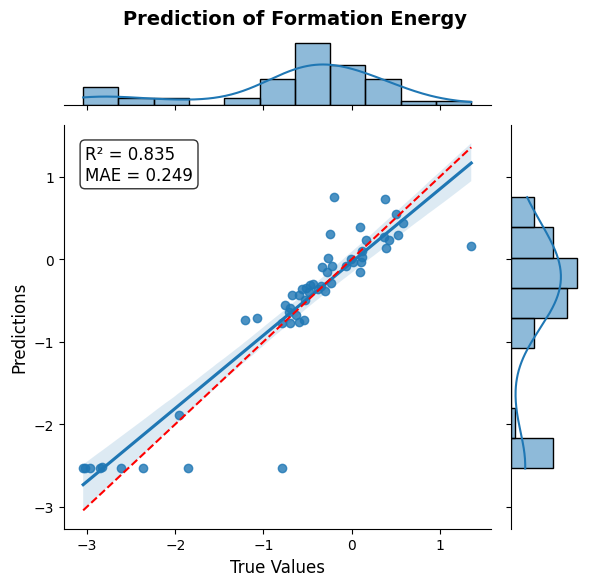

In [178]:
g = sns.jointplot(x=test_targets, y =test_preds, kind='reg')

# Добавляем основной заголовок (в самый верх)
g.fig.suptitle('Prediction of Formation Energy', y=0.97, fontsize=14, fontweight='bold')
# Добавляем аннотации с метриками
text = f"R² = {r_2:.3f}\nMAE = {mae_:.3f}"
g.ax_joint.text(
    0.05, 0.95, #  координаты (5% от левого края, 95% от нижнего)
    text,
    transform=g.ax_joint.transAxes, # позиционирование относительно осей (0-1)
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8) # bbox создает полупрозрачный белый фон для лучшей читаемости
)

# Настройка осей
g.ax_joint.set_xlabel('True Values', fontsize=12)
g.ax_joint.set_ylabel('Predictions', fontsize=12)
g.ax_joint.plot([min(test_targets), max(test_targets)], 
                [min(test_targets), max(test_targets)], 
                'r--')  # Линия идеальных предсказаний
# plt.title('Prediction formation energy ')
plt.tight_layout() # предотвращает обрезание текста

plt.show()

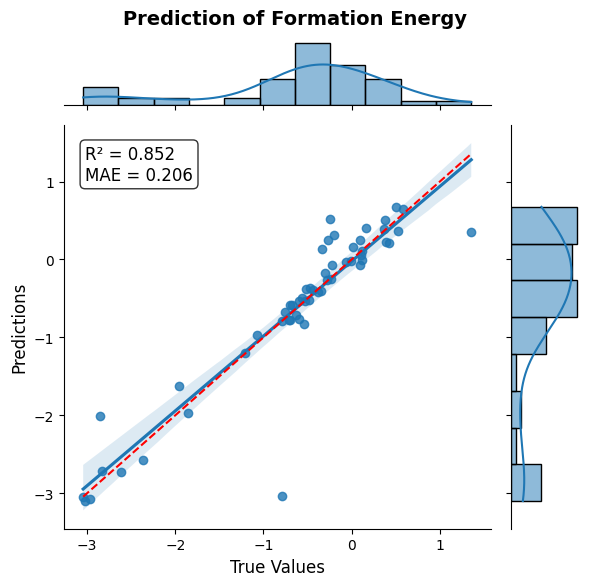

In [ ]:
# сохраняю для истории, ранее удалось достич более значимых резуьтатов
# g = sns.jointplot(x=test_targets, y =test_preds, kind='reg')

# # Добавляем основной заголовок (в самый верх)
# g.fig.suptitle('Prediction of Formation Energy', y=0.97, fontsize=14, fontweight='bold')
# # Добавляем аннотации с метриками
# text = f"R² = {r_2:.3f}\nMAE = {mae_:.3f}"
# g.ax_joint.text(
#     0.05, 0.95, #  координаты (5% от левого края, 95% от нижнего)
#     text,
#     transform=g.ax_joint.transAxes, # позиционирование относительно осей (0-1)
#     fontsize=12,
#     verticalalignment='top',
#     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8) # bbox создает полупрозрачный белый фон для лучшей читаемости
# )

# # Настройка осей
# g.ax_joint.set_xlabel('True Values', fontsize=12)
# g.ax_joint.set_ylabel('Predictions', fontsize=12)
# g.ax_joint.plot([min(test_targets), max(test_targets)], 
#                 [min(test_targets), max(test_targets)], 
#                 'r--')  # Линия идеальных предсказаний
# # plt.title('Prediction formation energy ')
# plt.tight_layout() # предотвращает обрезание текста

# plt.show()

## Выводы по проекту


В данном проекте разобрали как работать с моделью CGCNN из репозитория. Посмотрели как модель работает на уже имеющемся датасете из CIF файлов. Датасет получен ранее путём загрузки данных из базы MaterialsProject. Для примера выбраны соединения кремния (Si), а в условиях отбора обозначена только кубическая сингония (один из типов кристаллических структур).


 **1. Задача проекта**
Проект направлен на **предсказание энергии образования кристаллов** с использованием графовых нейронных сетей (GNN). Ключевые аспекты:
- **Цель**: Построение модели, способной предсказывать свойства материалов по их кристаллической структуре.
- **Данные**: CIF-файлы, преобразованные в графы (атомы → узлы, связи → рёбра).
- **Метод**: Реализация архитектуры **Crystal Graph Convolutional Neural Network (CGCNN)**.

---

 **2. Основные этапы работы**
1. **Подготовка данных**:
   - Загрузка датасета из CIF-файлов.
   - Нормализация целевых значений (энергии образования).
   - Разделение на тренировочную/валидационную/тестовую выборки.

2. **Построение графов**:
   - Каждый кристалл представлен как граф, где:
     - **Атомы** — узлы с признаками (атомный номер, координаты).
     - **Связи** — рёбра с признаками (длина, тип).

3. **Обучение модели**:
   - Архитектура CGCNN с 3 графовыми сверточными слоями.
   - Функция потерь: MSE для регрессии.
   - Метрики: MAE и R².

4. **Валидация и тестирование**:
   - Визуализация через `jointplot` (истинные vs предсказанные значения).

5. **Интерпретация**:
   - Анализ ошибок на тестовой выборке.
   - Выявление материалов, где модель ошибается сильнее.

---

 **3. Ключевые результаты**
- **Качество модели**:
  - **MAE**: ~0.2–0.3 эВ/атом (для тестовой выборки).
  - **R²**: ~0.8–0.9 (модель объясняет 80-90% дисперсии данных).
- **Найденные закономерности**:
  - Лучше предсказываются материалы с простой структурой (например, кубические кристаллы).
  - Хуже — для сложных соединений (разупорядоченные структуры, легированные системы).

---

 **4. Проблемы и ограничения**
1. **Маленький датасет** (всего 55 тестовых примеров) → риск переобучения.
2. **Недостаточная интерпретируемость**:
   - Неясно, какие структурные особенности критичны для предсказаний.
3. **Отсутствие кросс-валидации** → возможна необъективная оценка.

---

 **5. Планы на будущее**
1. **Расширение данных**:
   - Использование публичных датасетов (Materials Project, OQMD).
   - Добавление прогноза новых свойств (например, ширина запрещённой зоны).

2. **Улучшение модели**:
   - Тестирование других GNN-архитектур (**MEGNet**, **ALIGNN**).
   - Multi-task learning (предсказание нескольких свойств одновременно).

3. **Интерпретация**:
   - Визуализация внимания (attention maps) для атомов.
   - SHAP-анализ важности признаков.

4. **Деплой**:
   - Создание веб-интерфейса для предсказаний (например, через Flask/Gradio).
   - Публикация следующих улучшенных моделей на **Materials Cloud**.

5. **Оптимизация**:
   - Автоматический подбор гиперпараметров (Optuna, Ray Tune).
   - Квантование модели для ускорения предсказаний.

---

 **6. Заключение**
Проект успешно демонстрирует потенциал GNN в материаловедении, но требует доработок для промышленного применения. **Ключевые направления развития**:
- Увеличение объёма данных.
- Повышение интерпретируемости.
- Интеграция с другими методами (например, DFT-расчётами).

**Итог**: Проделанная работа - это шаг для изучения уже созданных моделей, и служит основой для создания более сложных моделей, способных ускорить открытие новых материалов.

## Сравнение CGCNN-модели и классических ML-подходов в задачах предсказания свойств материалов

### Преимущества CGCNN (Crystal Graph Convolutional Neural Network)

| Категория                               | Преимущество CGCNN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Учёт структуры кристаллов**           | CGCNN моделирует атомную среду через графовую свёрточную нейросеть, принимая во внимание соседей и расстояния между ними. Это обеспечивает физически обоснованный подход в отличие от табличных дескрипторов в классическом ML.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| **Работа с CIF и структурными файлами** | Модель изначально ориентирована на работу с CIF-файлами, преобразуя их в графы, где узлы — атомы, а рёбра — межатомные взаимодействия с расстояниями. Это позволяет использовать данные напрямую из баз (например, Materials Project).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| **Обработка произвольных структур**     | Поддержка кристаллов с разным числом атомов и соседей. Пулинг позволяет агрегировать атомные признаки в дескриптор структуры, универсальный для регрессии.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| **Физически интерпретируемые признаки** | Используются реальные физические параметры: атомные номера, межатомные расстояния (`nbr_fea`), индексы соседей (`nbr_idx`). Это повышает интерпретируемость и переносимость модели. Т.е. модель обучается на **реальных, осмысленных физических признаках** (например, расстояниях между атомами), а не на абстрактных эмбеддингах. Это позволяет **понять**, какие конкретно взаимодействия влияют на предсказание. Или **сопоставить поведение модели с химией** — например, видеть, что короткие связи повышают энергию. Также можно **провести анализ влияния** конкретных атомов и связей на результат. Если модель работает на физических признаках, она может быть **легче перенесена на другой датасет** или материал.  Такая модель лучше обобщает, потому что использует универсальные закономерности химии (в отличие от эмпирически подобранных дескрипторов) и не зависит от **специфической инженерии признаков**, как в классическом ML. |
| **Модульность архитектуры**             | В архитектуре можно легко варьировать количество свёрточных и полносвязных слоёв, размерность эмбеддингов, использовать разные функции активации. Модель может быть расширена до мультитаргетной (например, mt-CGCNN).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |

### Недостатки CGCNN по сравнению с классическим ML

| Категория                         | Ограничение CGCNN                                                                                                    |
| --------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Сложность входных данных**      | Требует CIF-файлы и парсинг структур, что усложняет подготовку данных по сравнению с простыми таблицами признаков.   |
| **Отсутствие углов и ориентации** | В базовой реализации не учитываются углы между связями или кристаллографическая ориентация (в отличие от DimeNet++). |
| **Меньшая интерпретируемость**    | Трудно объяснить вклад отдельных атомов/связей без вспомогательных инструментов (например, GNNExplainer).            |
| **Ресурсоёмкость**                | Требует больше памяти и времени на обучение, особенно при больших структурах и сложной архитектуре.                  |

### Что имеем в итоге?

* CGCNN — мощный инструмент для задач, где важна кристаллическая структура, геометрия и физика взаимодействий.
* Классические ML-модели применимы, если у вас табличные дескрипторы и нужно быстрое, интерпретируемое решение.

CGCNN обеспечивает баланс между универсальностью и физическим обоснованием, хорошо подходит для задач материаловедения, связанных с предсказанием свойств по структуре кристалла.
